# Solving Sod Problem with PINN-WE


* This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

* The paper about this code can be reffed to https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

* For strong shock waves, PINN-WE can let you get a discontinuous result quickly and sharply. But it can not guarantee the result must be physical. You can try to change the random seed or learning rate to get a different result. In the paper, we show the best result of some tests to demonstrate that PINN-WE has the potential ability to handle a non-linear discontinuous problem.

* So physics constraints are needed near shock waves. They are conservation laws, Rankine-Hugoniot relations and entropy condition. We develop a physics screen method here to determinate the problem.


In [538]:
def train(epoch):
#    tocs1 = time.time()
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int_train)                                    
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,p_ic_train)   
        
        loss_rh1 = model.loss_rh(x_screen1, x_screen1_L,x_screen1_R) # RH relation
        #loss_rh2 = model.loss_rh(x_end,x_d) # RH relation along time direction
        loss_s = model.loss_character(x_screen1,x_screen1_L,x_screen1_R, x_screen1_P,x_screen1_PL,x_screen1_PR) # Entropy condition
        #loss_s = model.loss_character(x_screen1,x_screen1_R) # Entropy condition
        loss_s0 = model.loss_character(x_screen2,x_screen2_L,x_screen2_R, x_screen2_P,x_screen2_PL,x_screen2_PR) # Entropy condition
        loss_con = model.loss_con(x_screen1 ,x_ic_train) #Conservation laws
        loss = loss_pde + 10*loss_ic + 10* loss_rh1   +10*(loss_s+loss_s0)   +10*loss_con 
        print(f'epoch {epoch}, loss_tot:{loss:.8f},loss_pde:{loss_pde:.8f},loss_s:{loss_s:.8f},loss_rh:{loss_rh1:.8f}, loss_con:{loss_con:.8f}, loss_ic:{loss_ic:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    return loss

In [571]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
# Seeds
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    #random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(124)
   
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))

# Initial conditions
def IC(x):
    N=x.shape[0]
    rho_init = np.zeros(N)                                              
    u_init = np.zeros(N)                                                
    p_init = np.zeros(N)                                                

    # rho, p - initial condition
    for i in range(N):
        if (x[i,1] < 0.5):
            rho_init[i] = 1.0
            p_init[i] = 1.0
        else:
            rho_init[i] = 0.125
            p_init[i] = 0.1

    return rho_init, u_init, p_init

# Generate Neural Network
class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  
        self.net.add_module('Linear_layer_1', nn.Linear(2, 50))                     
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              

        for num in range(2, 5):                                                     
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(50, 50))       
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 
        self.net.add_module('Linear_layer_final', nn.Linear(50, 3))                 

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    # Loss function for PDE
    def loss_pde(self, x):
        y = self.net(x)                                                
        rho,p,u = y[:, 0:1], y[:, 1:2], y[:, 2:]
        
        U2 = rho*u
        U3 = 0.5*rho*u**2 + p/0.4
        
        #F1 = U2
        F2 = rho*u**2+p
        F3 = u*(U3 + p)
        
        gamma = 1.4                                                    

        # Gradients and partial derivatives
        drho_g = gradients(rho, x)[0]                                  
        rho_t, rho_x = drho_g[:, :1], drho_g[:, 1:]             


        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            

       # dp_g = gradients(p, x)[0]                                     
       # p_t, p_x = dp_g[:, :1], dp_g[:, 1:]                           
        
        dU2_g = gradients(U2, x)[0]
        U2_t,U2_x = dU2_g[:,:1], dU2_g[:,1:]
        dU3_g = gradients(U3, x)[0]
        U3_t,U3_x = dU3_g[:,:1], dU3_g[:,1:]
        dF2_g = gradients(F2, x)[0]
        F2_t,F2_x = dF2_g[:,:1], dF2_g[:,1:]
        dF3_g = gradients(F3, x)[0]
        F3_t,F3_x = dF3_g[:,:1], dF3_g[:,1:]

        d = 0.1*(abs(u_x)-u_x)  + 1
     
        f = (((rho_t + U2_x)/d)**2).mean() + \
            (((U2_t  + F2_x)/d)**2).mean() + \
            (((U3_t  + F3_x)/d)**2).mean() #+\
            #((rho_t).mean())**2 +\
            #((U3_t).mean())**2 
    
        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, p_ic):
        y_ic = self.net(x_ic)                                                      
        rho_ic_nn, p_ic_nn,u_ic_nn = y_ic[:, 0], y_ic[:, 1], y_ic[:, 2]            

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean()

        return loss_ics
    
    # Loss function for conservation
    def loss_con(self, x_en,x_in):
        y_en = self.net(x_en)                                       
        y_in = self.net(x_in)                                       
        rhoen, pen,uen = y_en[:, 0], y_en[:, 1], y_en[:, 2]         
        rhoin, pin,uin = y_in[:, 0], y_in[:, 1], y_in[:, 2]         

        U3 = 0.5*rhoen*uen**2 + pen/0.4
        U3in = 0.5*rhoin*uin**2 + pin/0.4
        # Loss function for the initial condition
        loss_en = ((rhoen - rhoin).mean())**2 + \
            ((U3- U3in).mean())**2 +\
            (((1-0.1)*0.2 - rhoen*uen).mean())**2
        return loss_en
    
    # Loss function for RH relation
    def loss_rh(self, x,x_l,x_r):
        y = self.net(x)                                    
        y_r = self.net(x_r)                                    
        y_l = self.net(x_l)                                    
        rho, p,u = y[:, 0], y[:, 1], y[:, 2]          
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]          
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]          

        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        eta =  torch.clamp(d-0.1,max=0)
       # eta = 1
        
        loss_rh =  (((pr/pl - (6*rhor-rhol)/(6*rhol-rhor))*(pr-pl)*eta)**2).max()+\
                   ((((ur-ul)**2 -2/rhor*(pr-pl)**2/(0.4*pr+2.4*pl))*eta)**2).max()
        return loss_rh
    
   # def loss_character(self, x_l,x_r):
   #     loss_s = model.loss_character(x_screen1,x_screen1_L,x_screen1_R, x_screen1_P,x_screen1_PL,x_screen1_PR) # Entropy condition
   #     y_r = self.net(x_r)                                                      # Initial condition
   #     y_l = self.net(x_l)                                                      # Initial condition
   #     rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]            # rho, u, p - initial condition
   #     rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]            # rho, u, p - initial condition
#
   #     du_g = gradients(ul, x_l)[0]                                      
   #     u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
   #     d = 1/(0.1*(abs(u_x)-u_x)  + 1)
   #     eta =  torch.clamp(d-0.1,max=0)
   #     #eta = 1
   #     # Loss function for the initial condition
   #     gamma = 1.4
   #     ss = 1.0e-10
   #     cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
   #     cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
   #     sR = torch.max(abs(ul)+cL,abs(ur)+cR)* torch.clamp(abs(rhol-rhor)-0.01,min=0)
   #     sL = torch.min(-abs(ul)-cL,-abs(ur)-cR)
   #     
   #     s = torch.clamp(abs(rhol-rhor)-0.01,min=0)*(abs(rhol*ul - rhor*ur))/(abs(rhol - rhor)+ss)
   #     if (s.max() > 1000):
   #         print(rhol-rhor)
   #         print(s)
   #     #print(torch.clamp(s-sR,min=0))
   #    # print(eta)
   #    # sm = exp(-100*(s-sR))
   #     loss_s = (((torch.clamp(s-sR,min=0))*eta)**2).max()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
   #     return loss_s
    
    def loss_character(self, x,x_l,x_r,xP,xP_l,xP_r):
        #loss_s = model.loss_character(x_screen1,x_screen1_L,x_screen1_R, x_screen1_P,x_screen1_PL,x_screen1_PR) # Entropy condition
        y = self.net(x)                                       
        y_r = self.net(x_r)                                     
        y_l = self.net(x_l)                                     
        yP = self.net(xP)
        yP_r = self.net(xP_r)
        yP_l = self.net(xP_l)
        rho, p,u    = y[:, 0], y[:, 1], y[:, 2]           
        rhoP, pP,uP    = yP[:, 0], yP[:, 1], yP[:, 2]           
        rhoPl, pPl,uPl    = yP_l[:, 0], yP_l[:, 1], yP_l[:, 2]           
        rhoPr, pPr,uPr    = yP_r[:, 0], yP_r[:, 1], yP_r[:, 2]           
        rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]           
        rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]           

        du_g = gradients(u, x)[0]                                      
        u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
        d = 1/(0.1*(abs(u_x)-u_x)  + 1)
        eta =  torch.clamp(d-0.6,max=0)
        #eta = 1
        # Loss function for the initial condition
        gamma = 1.4
        ss = 1.0e-10
        cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
        cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
        sR = torch.clamp(abs(rhoPr-rhoP)-0.01,min=0)*(ur+cR)*torch.clamp(abs(pPr-pP)-0.01,min=0)
        sL = torch.clamp(abs(rhoPl-rhoP)-0.01,min=0)*(ul-cL)*torch.clamp(abs(pPl-pP)-0.01,min=0)
        
        aL = torch.clamp(abs(pPl-pP)-0.01,min=0)*torch.clamp(abs(rhoPl-rhoP)-0.01,min=0)*(abs(rhoPl*uPl - rhoP*uP))/(abs(rhoPl - rhoP)+ss)
        aR = torch.clamp(abs(pPr-pP)-0.01,min=0)*torch.clamp(abs(rhoPr-rhoP)-0.01,min=0)*(abs(rhoPr*uPr - rhoP*uP))/(abs(rhoPr - rhoP)+ss)
        
        #s = torch.clamp(abs(rhol-rhor)-0.01,min=0)*(abs(rhol*ul - rhor*ur))/(abs(rhol - rhor)+ss)
       # if (s.max() > 1000):
       #     print(rhol-rhor)
       #     print(s)
        #print(torch.clamp(s-sR,min=0))
       # print(eta)
       # sm = exp(-100*(s-sR))
        loss_s = (((torch.clamp(aR-sR,min=0))*eta)**2).max()+ (((torch.clamp(aL+sL,min=0))*eta)**2).max()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
        return loss_s
    #def loss_character(self, x_l,x_r):
    #    y_r = self.net(x_r)                                                      # Initial condition
    #    y_l = self.net(x_l)                                                      # Initial condition
    #    rhol, pl,ul = y_l[:, 0], y_l[:, 1], y_l[:, 2]            # rho, u, p - initial condition
    #    rhor, pr,ur = y_r[:, 0], y_r[:, 1], y_r[:, 2]            # rho, u, p - initial condition
##
    #    du_g = gradients(ul, x_l)[0]                                      
    #    u_t, u_x = du_g[:, :1], du_g[:, 1:]                            
    #    d = 1/(0.1*(abs(u_x)-u_x)  + 1)
    #    eta =  torch.clamp(d-0.1,max=0)
    #    #eta = 1
    #    # Loss function for the initial condition
    #    gamma = 1.4
    #    ss = 1.0e-10
    #    cL = torch.sqrt(gamma*abs(pl)/(abs(rhol)+ss))
    #    cR = torch.sqrt(gamma*abs(pr)/(abs(rhor)+ss))
    #    sR = torch.max(abs(ul)+cL,abs(ur)+cR)* torch.clamp(abs(rhol-rhor)-0.01,min=0)
    #    sL = torch.min(-abs(ul)-cL,-abs(ur)-cR)
    #    
    #    s = torch.clamp(abs(rhol-rhor)-0.01,min=0)*(abs(rhol*ul - rhor*ur))/(abs(rhol - rhor)+ss)
    #    if (s.max() > 1000):
    #        print(rhol-rhor)
    #        print(s)
    #    #print(torch.clamp(s-sR,min=0))
    #   # print(eta)
    #   # sm = exp(-100*(s-sR))
    #    loss_s = (((torch.clamp(s-sR,min=0))*eta)**2).max()  #torch.min((((,torch.tensor(1.0))  #+ ((torch.clamp(sL-s,min=0))**2).max()
    #    return loss_s
    
        
    

def X_entropy(x,T,dt,dx):
    N=x.shape[0]
    xs   = np.zeros((N,2)) 
    xsL  = np.zeros((N,2)) 
    xsR  = np.zeros((N,2)) 
    xsP  = np.zeros((N,2)) 
    xsPL = np.zeros((N,2)) 
    xsPR = np.zeros((N,2)) 
    
    for i in range(N):
        xs[i,1] = x[i,1]
        xs[i,0] = x[i,0] + T
        xsL[i,1] = xs[i,1] - dx
        xsL[i,0] = xs[i,0]
        xsR[i,1] = xs[i,1] + dx
        xsR[i,0] = xs[i,0]
        xsP[i,0] = xs[i,0] + dt
        xsP[i,1] = xs[i,1]
        xsPL[i,0] = xsP[i,0]
        xsPL[i,1] = xsP[i,1]- dx
        xsPR[i,0] = xsP[i,0]
        xsPR[i,1] = xsP[i,1]+ dx
        
    return xs,xsL,xsR,xsP,xsPL,xsPR

def X_right(x,dx):
    N=x.shape[0]
    xen =np.zeros((N,2)) 
    
    for i in range(N):
        xen[i,1] = x[i,1] + dx
        xen[i,0] = x[i,0] 
    return xen
    
device = torch.device('cuda')         # change to cpu if you dont have a cuda device                              

num_x = 200                                                        
num_t = 100                                                        
L = 1.0
T = 0.2
dt = T/num_t
dx = L/num_x
Tstart = 0
Tend = 0.2
Xstart = 0
Xend = 1.0
x_ic_train, x_int_train = Mesh_Data(num_x,num_t,Tstart,Tend, Xstart,Xend)
rho_ic_train, u_ic_train, p_ic_train = IC(x_ic_train)                    

x_screen1,x_screen1_L,x_screen1_R,x_screen1_P,x_screen1_PL,x_screen1_PR = X_entropy(x_ic_train,0.2,0.01,0.01)
x_screen2,x_screen2_L,x_screen2_R,x_screen2_P,x_screen2_PL,x_screen2_PR = X_entropy(x_ic_train,0.1,0.01,0.01)

x_screen1     = torch.tensor(x_screen1, requires_grad=True, dtype=torch.float32).to(device)
x_screen1_L   = torch.tensor(x_screen1_L, dtype=torch.float32).to(device) 
x_screen1_R   = torch.tensor(x_screen1_R, dtype=torch.float32).to(device)
x_screen1_P   = torch.tensor(x_screen1_P, requires_grad=True, dtype=torch.float32).to(device)
x_screen1_PL  = torch.tensor(x_screen1_PL, dtype=torch.float32).to(device)
x_screen1_PR  = torch.tensor(x_screen1_PR, dtype=torch.float32).to(device)

x_screen2     = torch.tensor(x_screen2, requires_grad=True, dtype=torch.float32).to(device)
x_screen2_L   = torch.tensor(x_screen2_L, dtype=torch.float32).to(device)
x_screen2_R   = torch.tensor(x_screen2_R, dtype=torch.float32).to(device)
x_screen2_P   = torch.tensor(x_screen2_P, requires_grad=True, dtype=torch.float32).to(device)
x_screen2_PL  = torch.tensor(x_screen2_PL, dtype=torch.float32).to(device)
x_screen2_PR  = torch.tensor(x_screen2_PR, dtype=torch.float32).to(device)

x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)
x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)

model = DNN().to(device)

print('Start training...')


Start training...


In [572]:
def Mesh_Data(num_x,num_t,Tstart,Tend, Xstart,Xend):

    x_ic = np.zeros((num_x,2))
    x_int = np.zeros((num_x*(num_t),2))
    
    x =   np.linspace(Xstart, Xend, num_x) 
    x_ic[:,0] = 0
    x_ic[:,1] = x
    
    dt = (Tend - Tstart)/num_t
    t = np.linspace(Tstart, Tend, num_t)                                     
    t_grid, x_grid = np.meshgrid(t, x)                                 
    T = t_grid.flatten()[:, None]                                      
    X = x_grid.flatten()[:, None]                                      
    x_int = X[:, 0][:,None]                                        
    t_int = T[:, 0][:,None]                                        
#x_int_train = np.hstack((t_int, x_int))                            

    x_int = np.hstack((t_int, x_int))                            
    
    return x_ic,x_int




In [573]:
x_int[:,1]

array([0., 0., 0., ..., 1., 1., 1.])

In [574]:
epoch = 0
epochi = epoch
lr = 0.001                                                           # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100000
tic = time.time()
for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    if loss < 0.01:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')


epoch 1, loss_tot:9.03761387,loss_pde:0.00814041,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.04107198, loss_ic:0.86187536
epoch 2, loss_tot:7.87824059,loss_pde:0.00551964,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.04081873, loss_ic:0.74645334
epoch 3, loss_tot:6.86289835,loss_pde:0.00367977,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.03886966, loss_ic:0.64705217
epoch 4, loss_tot:5.98452616,loss_pde:0.00255249,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.03526353, loss_ic:0.56293380
epoch 5, loss_tot:5.24714994,loss_pde:0.00206411,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.03014251, loss_ic:0.49436608
epoch 6, loss_tot:4.66419554,loss_pde:0.00213139,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.02395327, loss_ic:0.44225317
epoch 7, loss_tot:4.25042772,loss_pde:0.00266676,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.01753619, loss_ic:0.40723985
epoch 8, loss_tot:4.00867462,loss_pde:0.00358325,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.01200966, los

epoch 66, loss_tot:1.51960242,loss_pde:0.24528471,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00641025, loss_ic:0.12102152
epoch 67, loss_tot:1.50744689,loss_pde:0.25941363,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00604844, loss_ic:0.11875489
epoch 68, loss_tot:1.49804997,loss_pde:0.27457380,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00566802, loss_ic:0.11667960
epoch 69, loss_tot:1.49006128,loss_pde:0.28731593,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00542951, loss_ic:0.11484501
epoch 70, loss_tot:1.48180139,loss_pde:0.29470503,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00539133, loss_ic:0.11331830
epoch 71, loss_tot:1.47385001,loss_pde:0.29741699,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00547347, loss_ic:0.11216982
epoch 72, loss_tot:1.46727204,loss_pde:0.29833332,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00550145, loss_ic:0.11139242
epoch 73, loss_tot:1.46147656,loss_pde:0.29938889,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00533

epoch 130, loss_tot:1.22046959,loss_pde:0.17149283,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00165327, loss_ic:0.10324441
epoch 131, loss_tot:1.21734250,loss_pde:0.16989635,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00159295, loss_ic:0.10315166
epoch 132, loss_tot:1.21427262,loss_pde:0.16802639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00153798, loss_ic:0.10308665
epoch 133, loss_tot:1.21126175,loss_pde:0.16592616,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00149478, loss_ic:0.10303878
epoch 134, loss_tot:1.20831037,loss_pde:0.16390307,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00145270, loss_ic:0.10298803
epoch 135, loss_tot:1.20540607,loss_pde:0.16212361,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00140306, loss_ic:0.10292520
epoch 136, loss_tot:1.20255709,loss_pde:0.16041583,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00135263, loss_ic:0.10286149
epoch 137, loss_tot:1.19975936,loss_pde:0.15849449,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 196, loss_tot:1.04233706,loss_pde:0.09259126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00046219, loss_ic:0.09451239
epoch 197, loss_tot:1.03920841,loss_pde:0.09181920,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00045710, loss_ic:0.09428182
epoch 198, loss_tot:1.03606689,loss_pde:0.09105388,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00045204, loss_ic:0.09404927
epoch 199, loss_tot:1.03291368,loss_pde:0.09028598,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00044667, loss_ic:0.09381609
epoch 200, loss_tot:1.02974939,loss_pde:0.08951412,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00044113, loss_ic:0.09358239
epoch 201, loss_tot:1.02657509,loss_pde:0.08874845,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00043574, loss_ic:0.09334692
epoch 202, loss_tot:1.02339220,loss_pde:0.08800022,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00043025, loss_ic:0.09310895
epoch 203, loss_tot:1.02020109,loss_pde:0.08725574,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 260, loss_tot:0.84938413,loss_pde:0.07731789,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00029657, loss_ic:0.07691005
epoch 261, loss_tot:0.84637052,loss_pde:0.07770105,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00029535, loss_ic:0.07657160
epoch 262, loss_tot:0.84332722,loss_pde:0.07808790,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00029407, loss_ic:0.07622986
epoch 263, loss_tot:0.84025210,loss_pde:0.07847837,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00029272, loss_ic:0.07588466
epoch 264, loss_tot:0.83714354,loss_pde:0.07887264,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00029132, loss_ic:0.07553577
epoch 265, loss_tot:0.83399981,loss_pde:0.07927042,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00028984, loss_ic:0.07518310
epoch 266, loss_tot:0.83081919,loss_pde:0.07967217,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00028827, loss_ic:0.07482643
epoch 267, loss_tot:0.82760042,loss_pde:0.08007713,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 324, loss_tot:0.62677675,loss_pde:0.08832268,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00008861, loss_ic:0.05375680
epoch 325, loss_tot:0.62948644,loss_pde:0.09587014,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004811, loss_ic:0.05331352
epoch 326, loss_tot:0.62603569,loss_pde:0.08830486,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00020028, loss_ic:0.05357280
epoch 327, loss_tot:0.61911249,loss_pde:0.08759866,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011259, loss_ic:0.05303879
epoch 328, loss_tot:0.62067926,loss_pde:0.09407609,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005033, loss_ic:0.05260999
epoch 329, loss_tot:0.61700875,loss_pde:0.08763538,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00016188, loss_ic:0.05277546
epoch 330, loss_tot:0.61183327,loss_pde:0.08737163,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011715, loss_ic:0.05232901
epoch 331, loss_tot:0.61237711,loss_pde:0.09265797,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 390, loss_tot:0.48964226,loss_pde:0.07316784,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00016955, loss_ic:0.04147789
epoch 391, loss_tot:0.48788905,loss_pde:0.07276866,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017281, loss_ic:0.04133923
epoch 392, loss_tot:0.48616776,loss_pde:0.07240560,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017509, loss_ic:0.04120113
epoch 393, loss_tot:0.48447597,loss_pde:0.07212773,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00017835, loss_ic:0.04105647
epoch 394, loss_tot:0.48280919,loss_pde:0.07173049,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018247, loss_ic:0.04092540
epoch 395, loss_tot:0.48116785,loss_pde:0.07150712,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018549, loss_ic:0.04078058
epoch 396, loss_tot:0.47955322,loss_pde:0.07117658,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018768, loss_ic:0.04064998
epoch 397, loss_tot:0.47796980,loss_pde:0.07094839,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 457, loss_tot:0.42427909,loss_pde:0.07497683,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00022604, loss_ic:0.03470419
epoch 458, loss_tot:0.42277771,loss_pde:0.07427954,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00023064, loss_ic:0.03461917
epoch 459, loss_tot:0.42300451,loss_pde:0.07472503,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00027271, loss_ic:0.03455524
epoch 460, loss_tot:0.42261466,loss_pde:0.07498525,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024202, loss_ic:0.03452092
epoch 461, loss_tot:0.42099446,loss_pde:0.07409301,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026119, loss_ic:0.03442895
epoch 462, loss_tot:0.42018530,loss_pde:0.07409889,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024717, loss_ic:0.03436147
epoch 463, loss_tot:0.42018390,loss_pde:0.07473280,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00022859, loss_ic:0.03431652
epoch 464, loss_tot:0.41940385,loss_pde:0.07418119,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 522, loss_tot:0.37400225,loss_pde:0.06334389,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026101, loss_ic:0.03080483
epoch 523, loss_tot:0.37312305,loss_pde:0.06305505,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026689, loss_ic:0.03073992
epoch 524, loss_tot:0.37223992,loss_pde:0.06286220,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026172, loss_ic:0.03067605
epoch 525, loss_tot:0.37135348,loss_pde:0.06258388,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026664, loss_ic:0.03061032
epoch 526, loss_tot:0.37046355,loss_pde:0.06238860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026172, loss_ic:0.03054578
epoch 527, loss_tot:0.36957055,loss_pde:0.06210651,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026670, loss_ic:0.03047970
epoch 528, loss_tot:0.36867455,loss_pde:0.06190845,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00026211, loss_ic:0.03041450
epoch 529, loss_tot:0.36777577,loss_pde:0.06162929,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 586, loss_tot:0.32029113,loss_pde:0.05166163,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00023925, loss_ic:0.02662370
epoch 587, loss_tot:0.31986779,loss_pde:0.05218324,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00021359, loss_ic:0.02655486
epoch 588, loss_tot:0.31939253,loss_pde:0.05173367,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00027145, loss_ic:0.02649443
epoch 589, loss_tot:0.31831971,loss_pde:0.05180566,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00021812, loss_ic:0.02643328
epoch 590, loss_tot:0.31715342,loss_pde:0.05102571,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024559, loss_ic:0.02636718
epoch 591, loss_tot:0.31643069,loss_pde:0.05099773,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024608, loss_ic:0.02629722
epoch 592, loss_tot:0.31593892,loss_pde:0.05157104,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00020908, loss_ic:0.02622770
epoch 593, loss_tot:0.31517991,loss_pde:0.05097290,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 655, loss_tot:0.30384412,loss_pde:0.07369795,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00020101, loss_ic:0.02281361
epoch 656, loss_tot:0.27120104,loss_pde:0.04260896,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00013891, loss_ic:0.02272030
epoch 657, loss_tot:0.29505953,loss_pde:0.06262745,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00048681, loss_ic:0.02275640
epoch 658, loss_tot:0.29343015,loss_pde:0.06501555,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00018412, loss_ic:0.02265733
epoch 659, loss_tot:0.26959103,loss_pde:0.04299621,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00011171, loss_ic:0.02254777
epoch 660, loss_tot:0.28550899,loss_pde:0.05586165,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00039777, loss_ic:0.02256697
epoch 661, loss_tot:0.28476316,loss_pde:0.05726941,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00014978, loss_ic:0.02259959
epoch 662, loss_tot:0.26786193,loss_pde:0.04165625,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 720, loss_tot:0.23950045,loss_pde:0.03654786,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00010401, loss_ic:0.02019125
epoch 721, loss_tot:0.23903759,loss_pde:0.03658025,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009132, loss_ic:0.02015442
epoch 722, loss_tot:0.23856556,loss_pde:0.03641353,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009616, loss_ic:0.02011904
epoch 723, loss_tot:0.23813310,loss_pde:0.03631906,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009744, loss_ic:0.02008396
epoch 724, loss_tot:0.23771673,loss_pde:0.03633472,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00008982, loss_ic:0.02004838
epoch 725, loss_tot:0.23727489,loss_pde:0.03614470,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009906, loss_ic:0.02001396
epoch 726, loss_tot:0.23681788,loss_pde:0.03612692,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009111, loss_ic:0.01997798
epoch 727, loss_tot:0.23638088,loss_pde:0.03604540,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 785, loss_tot:0.21910283,loss_pde:0.03740637,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005105, loss_ic:0.01811859
epoch 786, loss_tot:0.22476521,loss_pde:0.04126419,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00023967, loss_ic:0.01811043
epoch 787, loss_tot:0.23701587,loss_pde:0.05457354,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00015033, loss_ic:0.01809391
epoch 788, loss_tot:0.26276413,loss_pde:0.07452285,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00068114, loss_ic:0.01814299
epoch 789, loss_tot:0.30022633,loss_pde:0.11282022,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00058758, loss_ic:0.01815303
epoch 790, loss_tot:0.33640820,loss_pde:0.13869296,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00146984, loss_ic:0.01830168
epoch 791, loss_tot:0.30447826,loss_pde:0.11739969,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00057151, loss_ic:0.01813635
epoch 792, loss_tot:0.23529124,loss_pde:0.05035759,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 854, loss_tot:0.19763675,loss_pde:0.03088352,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003533, loss_ic:0.01663999
epoch 855, loss_tot:0.19733275,loss_pde:0.03073205,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004095, loss_ic:0.01661912
epoch 856, loss_tot:0.19715874,loss_pde:0.03073509,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004483, loss_ic:0.01659754
epoch 857, loss_tot:0.19700474,loss_pde:0.03089831,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003415, loss_ic:0.01657650
epoch 858, loss_tot:0.19675368,loss_pde:0.03075513,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004546, loss_ic:0.01655440
epoch 859, loss_tot:0.19646324,loss_pde:0.03074550,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003762, loss_ic:0.01653416
epoch 860, loss_tot:0.19624260,loss_pde:0.03072723,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003825, loss_ic:0.01651329
epoch 861, loss_tot:0.19607532,loss_pde:0.03071411,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 922, loss_tot:0.18409665,loss_pde:0.03047514,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003023, loss_ic:0.01533192
epoch 923, loss_tot:0.18391909,loss_pde:0.03046409,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003093, loss_ic:0.01531457
epoch 924, loss_tot:0.18374209,loss_pde:0.03046722,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003000, loss_ic:0.01529749
epoch 925, loss_tot:0.18356554,loss_pde:0.03045653,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003074, loss_ic:0.01528016
epoch 926, loss_tot:0.18338953,loss_pde:0.03046124,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002965, loss_ic:0.01526318
epoch 927, loss_tot:0.18321408,loss_pde:0.03044828,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003065, loss_ic:0.01524593
epoch 928, loss_tot:0.18303929,loss_pde:0.03045535,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002928, loss_ic:0.01522912
epoch 929, loss_tot:0.18286526,loss_pde:0.03043942,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 989, loss_tot:0.17550394,loss_pde:0.03060241,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001888, loss_ic:0.01447128
epoch 990, loss_tot:0.17531605,loss_pde:0.03037266,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004379, loss_ic:0.01445055
epoch 991, loss_tot:0.17431208,loss_pde:0.02971031,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002138, loss_ic:0.01443880
epoch 992, loss_tot:0.17417713,loss_pde:0.02976784,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001983, loss_ic:0.01442110
epoch 993, loss_tot:0.17464896,loss_pde:0.03026134,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003908, loss_ic:0.01439968
epoch 994, loss_tot:0.17438215,loss_pde:0.03032448,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001732, loss_ic:0.01438845
epoch 995, loss_tot:0.17367749,loss_pde:0.02969731,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002751, loss_ic:0.01437050
epoch 996, loss_tot:0.17358610,loss_pde:0.02972216,loss_s:0.00000000,loss_rh:0.00000000, loss_con

epoch 1056, loss_tot:0.16538537,loss_pde:0.02952901,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002103, loss_ic:0.01356460
epoch 1057, loss_tot:0.16525486,loss_pde:0.02952970,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002010, loss_ic:0.01355241
epoch 1058, loss_tot:0.16512378,loss_pde:0.02951747,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002086, loss_ic:0.01353977
epoch 1059, loss_tot:0.16499262,loss_pde:0.02951476,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002026, loss_ic:0.01352752
epoch 1060, loss_tot:0.16486177,loss_pde:0.02950706,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002047, loss_ic:0.01351500
epoch 1061, loss_tot:0.16473161,loss_pde:0.02950153,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002044, loss_ic:0.01350257
epoch 1062, loss_tot:0.16460194,loss_pde:0.02949707,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002008, loss_ic:0.01349041
epoch 1063, loss_tot:0.16447239,loss_pde:0.02948617,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1122, loss_tot:0.29405382,loss_pde:0.15329486,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00105780, loss_ic:0.01301810
epoch 1123, loss_tot:0.24770319,loss_pde:0.10778844,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00097607, loss_ic:0.01301540
epoch 1124, loss_tot:0.17207012,loss_pde:0.04202688,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00008697, loss_ic:0.01291735
epoch 1125, loss_tot:0.16744184,loss_pde:0.03760231,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005435, loss_ic:0.01292960
epoch 1126, loss_tot:0.21715161,loss_pde:0.08171049,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00056847, loss_ic:0.01297564
epoch 1127, loss_tot:0.22253868,loss_pde:0.08755390,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00053482, loss_ic:0.01296365
epoch 1128, loss_tot:0.17752615,loss_pde:0.04693446,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00022487, loss_ic:0.01283430
epoch 1129, loss_tot:0.16078693,loss_pde:0.03236336,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1191, loss_tot:0.15040568,loss_pde:0.02799669,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001481, loss_ic:0.01222609
epoch 1192, loss_tot:0.15032724,loss_pde:0.02802756,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001361, loss_ic:0.01221635
epoch 1193, loss_tot:0.15026142,loss_pde:0.02807435,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001609, loss_ic:0.01220262
epoch 1194, loss_tot:0.15012535,loss_pde:0.02803423,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001369, loss_ic:0.01219542
epoch 1195, loss_tot:0.14998131,loss_pde:0.02799906,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001480, loss_ic:0.01218343
epoch 1196, loss_tot:0.14989603,loss_pde:0.02801953,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001515, loss_ic:0.01217250
epoch 1197, loss_tot:0.14981729,loss_pde:0.02803326,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001347, loss_ic:0.01216493
epoch 1198, loss_tot:0.14969835,loss_pde:0.02802081,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1259, loss_tot:0.14342394,loss_pde:0.02757211,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001337, loss_ic:0.01157181
epoch 1260, loss_tot:0.14332289,loss_pde:0.02756320,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001340, loss_ic:0.01156256
epoch 1261, loss_tot:0.14322184,loss_pde:0.02755306,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001338, loss_ic:0.01155350
epoch 1262, loss_tot:0.14312093,loss_pde:0.02754290,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001335, loss_ic:0.01154445
epoch 1263, loss_tot:0.14301996,loss_pde:0.02753375,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001336, loss_ic:0.01153526
epoch 1264, loss_tot:0.14291912,loss_pde:0.02752404,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001327, loss_ic:0.01152624
epoch 1265, loss_tot:0.14281827,loss_pde:0.02751489,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001331, loss_ic:0.01151703
epoch 1266, loss_tot:0.14271747,loss_pde:0.02750538,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1323, loss_tot:0.13959424,loss_pde:0.02832539,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000400, loss_ic:0.01112289
epoch 1324, loss_tot:0.15329845,loss_pde:0.04065050,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00009991, loss_ic:0.01116489
epoch 1325, loss_tot:0.17215310,loss_pde:0.05743583,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00034860, loss_ic:0.01112312
epoch 1326, loss_tot:0.15204053,loss_pde:0.03902379,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00013380, loss_ic:0.01116788
epoch 1327, loss_tot:0.13816996,loss_pde:0.02695234,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000921, loss_ic:0.01111255
epoch 1328, loss_tot:0.15381485,loss_pde:0.04121129,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00015016, loss_ic:0.01111020
epoch 1329, loss_tot:0.15722816,loss_pde:0.04423726,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00015830, loss_ic:0.01114079
epoch 1330, loss_tot:0.14122340,loss_pde:0.02982140,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1391, loss_tot:0.13209890,loss_pde:0.02601096,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001038, loss_ic:0.01059841
epoch 1392, loss_tot:0.13199578,loss_pde:0.02599126,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001083, loss_ic:0.01058962
epoch 1393, loss_tot:0.13189065,loss_pde:0.02597250,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001018, loss_ic:0.01058163
epoch 1394, loss_tot:0.13181242,loss_pde:0.02597039,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001021, loss_ic:0.01057399
epoch 1395, loss_tot:0.13174418,loss_pde:0.02597826,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001110, loss_ic:0.01056549
epoch 1396, loss_tot:0.13165808,loss_pde:0.02597396,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001023, loss_ic:0.01055818
epoch 1397, loss_tot:0.13155831,loss_pde:0.02595639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001059, loss_ic:0.01054961
epoch 1398, loss_tot:0.13146807,loss_pde:0.02595174,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1455, loss_tot:0.12678041,loss_pde:0.02557722,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000996, loss_ic:0.01011035
epoch 1456, loss_tot:0.12670022,loss_pde:0.02557068,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000995, loss_ic:0.01010300
epoch 1457, loss_tot:0.12662011,loss_pde:0.02556331,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000992, loss_ic:0.01009576
epoch 1458, loss_tot:0.12654012,loss_pde:0.02555685,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000992, loss_ic:0.01008840
epoch 1459, loss_tot:0.12646016,loss_pde:0.02555003,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000989, loss_ic:0.01008113
epoch 1460, loss_tot:0.12638026,loss_pde:0.02554272,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000991, loss_ic:0.01007385
epoch 1461, loss_tot:0.12630048,loss_pde:0.02553563,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000988, loss_ic:0.01006661
epoch 1462, loss_tot:0.12622079,loss_pde:0.02552764,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1521, loss_tot:0.26602089,loss_pde:0.15691859,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00107843, loss_ic:0.00983180
epoch 1522, loss_tot:0.27195707,loss_pde:0.15967575,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00135579, loss_ic:0.00987235
epoch 1523, loss_tot:0.20391127,loss_pde:0.09957816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00061635, loss_ic:0.00981696
epoch 1524, loss_tot:0.13713072,loss_pde:0.03793106,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00013146, loss_ic:0.00978851
epoch 1525, loss_tot:0.13892888,loss_pde:0.04012033,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00007098, loss_ic:0.00980987
epoch 1526, loss_tot:0.18267277,loss_pde:0.08023310,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00044245, loss_ic:0.00980151
epoch 1527, loss_tot:0.19015156,loss_pde:0.08691046,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00056948, loss_ic:0.00975463
epoch 1528, loss_tot:0.14948602,loss_pde:0.05044488,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1585, loss_tot:0.11831112,loss_pde:0.02458806,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000903, loss_ic:0.00936328
epoch 1586, loss_tot:0.11811821,loss_pde:0.02446676,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00935792
epoch 1587, loss_tot:0.11810892,loss_pde:0.02451295,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00935252
epoch 1588, loss_tot:0.11810560,loss_pde:0.02459626,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000862, loss_ic:0.00934231
epoch 1589, loss_tot:0.11800116,loss_pde:0.02451376,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000865, loss_ic:0.00934009
epoch 1590, loss_tot:0.11791558,loss_pde:0.02450615,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000807, loss_ic:0.00933287
epoch 1591, loss_tot:0.11783684,loss_pde:0.02452816,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00932344
epoch 1592, loss_tot:0.11776690,loss_pde:0.02450214,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1653, loss_tot:0.11411911,loss_pde:0.02445912,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000765, loss_ic:0.00895835
epoch 1654, loss_tot:0.11406189,loss_pde:0.02445914,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00895261
epoch 1655, loss_tot:0.11400485,loss_pde:0.02445821,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00894698
epoch 1656, loss_tot:0.11394781,loss_pde:0.02445673,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00894143
epoch 1657, loss_tot:0.11389082,loss_pde:0.02445608,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000765, loss_ic:0.00893583
epoch 1658, loss_tot:0.11383382,loss_pde:0.02445533,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000764, loss_ic:0.00893021
epoch 1659, loss_tot:0.11377697,loss_pde:0.02445299,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000763, loss_ic:0.00892477
epoch 1660, loss_tot:0.11372011,loss_pde:0.02445281,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1720, loss_tot:0.11096650,loss_pde:0.02487672,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001154, loss_ic:0.00859744
epoch 1721, loss_tot:0.11139647,loss_pde:0.02535779,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001562, loss_ic:0.00858825
epoch 1722, loss_tot:0.11226825,loss_pde:0.02614121,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002253, loss_ic:0.00859018
epoch 1723, loss_tot:0.11403354,loss_pde:0.02787371,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003754, loss_ic:0.00857844
epoch 1724, loss_tot:0.11747254,loss_pde:0.03094754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006390, loss_ic:0.00858860
epoch 1725, loss_tot:0.12433891,loss_pde:0.03737824,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012113, loss_ic:0.00857494
epoch 1726, loss_tot:0.13704343,loss_pde:0.04883732,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00021584, loss_ic:0.00860478
epoch 1727, loss_tot:0.16097909,loss_pde:0.07079234,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1786, loss_tot:0.10787947,loss_pde:0.02398640,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000869, loss_ic:0.00838062
epoch 1787, loss_tot:0.10805225,loss_pde:0.02424470,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000868, loss_ic:0.00837208
epoch 1788, loss_tot:0.10793261,loss_pde:0.02415128,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000827, loss_ic:0.00836987
epoch 1789, loss_tot:0.10766696,loss_pde:0.02397393,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000653, loss_ic:0.00836277
epoch 1790, loss_tot:0.10761937,loss_pde:0.02397509,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000720, loss_ic:0.00835723
epoch 1791, loss_tot:0.10772558,loss_pde:0.02411176,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000899, loss_ic:0.00835240
epoch 1792, loss_tot:0.10768605,loss_pde:0.02418789,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00834224
epoch 1793, loss_tot:0.10749769,loss_pde:0.02405621,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1856, loss_tot:0.10456777,loss_pde:0.02411763,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000696, loss_ic:0.00803806
epoch 1857, loss_tot:0.10452354,loss_pde:0.02411969,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00803346
epoch 1858, loss_tot:0.10447919,loss_pde:0.02411906,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00802907
epoch 1859, loss_tot:0.10443480,loss_pde:0.02411959,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000695, loss_ic:0.00802457
epoch 1860, loss_tot:0.10439057,loss_pde:0.02411969,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000695, loss_ic:0.00802014
epoch 1861, loss_tot:0.10434650,loss_pde:0.02412049,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000693, loss_ic:0.00801567
epoch 1862, loss_tot:0.10430248,loss_pde:0.02412190,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00801114
epoch 1863, loss_tot:0.10425848,loss_pde:0.02412172,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1924, loss_tot:0.10163280,loss_pde:0.02413293,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00774307
epoch 1925, loss_tot:0.10159077,loss_pde:0.02413261,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00773890
epoch 1926, loss_tot:0.10154869,loss_pde:0.02413252,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00773470
epoch 1927, loss_tot:0.10150674,loss_pde:0.02413220,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00773054
epoch 1928, loss_tot:0.10146474,loss_pde:0.02413216,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00772634
epoch 1929, loss_tot:0.10142277,loss_pde:0.02413183,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00772218
epoch 1930, loss_tot:0.10138090,loss_pde:0.02413177,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00771800
epoch 1931, loss_tot:0.10133899,loss_pde:0.02413136,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 1994, loss_tot:0.10387132,loss_pde:0.02771103,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004102, loss_ic:0.00757501
epoch 1995, loss_tot:0.09995203,loss_pde:0.02441268,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000584, loss_ic:0.00754809
epoch 1996, loss_tot:0.10014680,loss_pde:0.02459344,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000905, loss_ic:0.00754629
epoch 1997, loss_tot:0.10286361,loss_pde:0.02691151,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003773, loss_ic:0.00755747
epoch 1998, loss_tot:0.10218268,loss_pde:0.02654835,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002411, loss_ic:0.00753933
epoch 1999, loss_tot:0.09954299,loss_pde:0.02402193,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001025, loss_ic:0.00754186
epoch 2000, loss_tot:0.09972099,loss_pde:0.02420461,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001093, loss_ic:0.00754071
epoch 2001, loss_tot:0.10148594,loss_pde:0.02593603,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2058, loss_tot:0.09694055,loss_pde:0.02381094,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000670, loss_ic:0.00730627
epoch 2059, loss_tot:0.09690525,loss_pde:0.02380982,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000687, loss_ic:0.00730267
epoch 2060, loss_tot:0.09686524,loss_pde:0.02380647,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00729903
epoch 2061, loss_tot:0.09682588,loss_pde:0.02379886,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000696, loss_ic:0.00729574
epoch 2062, loss_tot:0.09679046,loss_pde:0.02380320,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000687, loss_ic:0.00729186
epoch 2063, loss_tot:0.09675713,loss_pde:0.02381069,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00728798
epoch 2064, loss_tot:0.09672172,loss_pde:0.02381037,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000688, loss_ic:0.00728426
epoch 2065, loss_tot:0.09668367,loss_pde:0.02381269,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2122, loss_tot:0.09467007,loss_pde:0.02384515,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000698, loss_ic:0.00707551
epoch 2123, loss_tot:0.09463545,loss_pde:0.02384542,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00707202
epoch 2124, loss_tot:0.09460089,loss_pde:0.02384548,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00706855
epoch 2125, loss_tot:0.09456632,loss_pde:0.02384583,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000698, loss_ic:0.00706507
epoch 2126, loss_tot:0.09453179,loss_pde:0.02384579,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00706161
epoch 2127, loss_tot:0.09449728,loss_pde:0.02384602,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00705814
epoch 2128, loss_tot:0.09446284,loss_pde:0.02384611,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000700, loss_ic:0.00705468
epoch 2129, loss_tot:0.09442835,loss_pde:0.02384627,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2188, loss_tot:0.09243117,loss_pde:0.02383045,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00685299
epoch 2189, loss_tot:0.09239788,loss_pde:0.02382982,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00684973
epoch 2190, loss_tot:0.09236461,loss_pde:0.02382909,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00684647
epoch 2191, loss_tot:0.09233136,loss_pde:0.02382860,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00684320
epoch 2192, loss_tot:0.09229815,loss_pde:0.02382791,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00683994
epoch 2193, loss_tot:0.09226497,loss_pde:0.02382746,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00683667
epoch 2194, loss_tot:0.09223177,loss_pde:0.02382657,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00683343
epoch 2195, loss_tot:0.09219860,loss_pde:0.02382613,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2252, loss_tot:0.09472455,loss_pde:0.02676034,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002780, loss_ic:0.00676862
epoch 2253, loss_tot:0.09326020,loss_pde:0.02568710,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001207, loss_ic:0.00674524
epoch 2254, loss_tot:0.09245503,loss_pde:0.02480301,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001008, loss_ic:0.00675512
epoch 2255, loss_tot:0.09333955,loss_pde:0.02544800,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002677, loss_ic:0.00676239
epoch 2256, loss_tot:0.09352113,loss_pde:0.02597339,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001242, loss_ic:0.00674235
epoch 2257, loss_tot:0.09199012,loss_pde:0.02431592,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000617, loss_ic:0.00676125
epoch 2258, loss_tot:0.09165663,loss_pde:0.02400105,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001672, loss_ic:0.00674883
epoch 2259, loss_tot:0.09277403,loss_pde:0.02533449,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2322, loss_tot:0.08880284,loss_pde:0.02336001,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00653723
epoch 2323, loss_tot:0.08877601,loss_pde:0.02336821,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00653371
epoch 2324, loss_tot:0.08874678,loss_pde:0.02335849,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00653175
epoch 2325, loss_tot:0.08871574,loss_pde:0.02336063,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00652843
epoch 2326, loss_tot:0.08868630,loss_pde:0.02336125,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00652537
epoch 2327, loss_tot:0.08865798,loss_pde:0.02336032,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000705, loss_ic:0.00652272
epoch 2328, loss_tot:0.08862896,loss_pde:0.02336729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00651910
epoch 2329, loss_tot:0.08859943,loss_pde:0.02336250,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2389, loss_tot:0.08687227,loss_pde:0.02333207,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000721, loss_ic:0.00634681
epoch 2390, loss_tot:0.08684373,loss_pde:0.02333095,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00634406
epoch 2391, loss_tot:0.08681521,loss_pde:0.02332937,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00634136
epoch 2392, loss_tot:0.08678668,loss_pde:0.02332837,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00633861
epoch 2393, loss_tot:0.08675819,loss_pde:0.02332720,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00633588
epoch 2394, loss_tot:0.08672968,loss_pde:0.02332594,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00633316
epoch 2395, loss_tot:0.08670117,loss_pde:0.02332479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00633041
epoch 2396, loss_tot:0.08667267,loss_pde:0.02332332,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2457, loss_tot:0.08494383,loss_pde:0.02321639,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00616548
epoch 2458, loss_tot:0.08491566,loss_pde:0.02321419,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00616288
epoch 2459, loss_tot:0.08488742,loss_pde:0.02321198,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00616028
epoch 2460, loss_tot:0.08485924,loss_pde:0.02320974,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00615768
epoch 2461, loss_tot:0.08483104,loss_pde:0.02320749,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00615508
epoch 2462, loss_tot:0.08480280,loss_pde:0.02320522,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00615249
epoch 2463, loss_tot:0.08477463,loss_pde:0.02320296,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00614990
epoch 2464, loss_tot:0.08474640,loss_pde:0.02320057,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2527, loss_tot:0.27545705,loss_pde:0.20004511,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00132547, loss_ic:0.00621573
epoch 2528, loss_tot:0.21200530,loss_pde:0.14233024,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00075202, loss_ic:0.00621548
epoch 2529, loss_tot:0.11635390,loss_pde:0.05211438,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00024781, loss_ic:0.00617614
epoch 2530, loss_tot:0.08733509,loss_pde:0.02561782,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003040, loss_ic:0.00614133
epoch 2531, loss_tot:0.14075945,loss_pde:0.07550164,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00036814, loss_ic:0.00615764
epoch 2532, loss_tot:0.17919677,loss_pde:0.11208622,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00061306, loss_ic:0.00609800
epoch 2533, loss_tot:0.13520683,loss_pde:0.07115278,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00029202, loss_ic:0.00611339
epoch 2534, loss_tot:0.08620009,loss_pde:0.02563160,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2597, loss_tot:0.08155615,loss_pde:0.02252037,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000792, loss_ic:0.00589566
epoch 2598, loss_tot:0.08150058,loss_pde:0.02252197,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00589101
epoch 2599, loss_tot:0.08152585,loss_pde:0.02259403,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000674, loss_ic:0.00588644
epoch 2600, loss_tot:0.08152215,loss_pde:0.02257958,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000774, loss_ic:0.00588652
epoch 2601, loss_tot:0.08145159,loss_pde:0.02254573,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000743, loss_ic:0.00588316
epoch 2602, loss_tot:0.08139207,loss_pde:0.02250320,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000707, loss_ic:0.00588181
epoch 2603, loss_tot:0.08139072,loss_pde:0.02252103,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00588003
epoch 2604, loss_tot:0.08139036,loss_pde:0.02256106,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2667, loss_tot:0.07970449,loss_pde:0.02239145,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00572393
epoch 2668, loss_tot:0.07967870,loss_pde:0.02238840,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00572166
epoch 2669, loss_tot:0.07965297,loss_pde:0.02238585,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00571934
epoch 2670, loss_tot:0.07962726,loss_pde:0.02238359,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00571698
epoch 2671, loss_tot:0.07960155,loss_pde:0.02238068,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00571471
epoch 2672, loss_tot:0.07957584,loss_pde:0.02237911,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00571229
epoch 2673, loss_tot:0.07955011,loss_pde:0.02237603,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00571003
epoch 2674, loss_tot:0.07952439,loss_pde:0.02237352,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2731, loss_tot:0.07806478,loss_pde:0.02220935,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00557809
epoch 2732, loss_tot:0.07803927,loss_pde:0.02220614,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00557586
epoch 2733, loss_tot:0.07801376,loss_pde:0.02220299,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00557362
epoch 2734, loss_tot:0.07798827,loss_pde:0.02219981,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00557139
epoch 2735, loss_tot:0.07796276,loss_pde:0.02219663,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00556915
epoch 2736, loss_tot:0.07793727,loss_pde:0.02219345,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00556692
epoch 2737, loss_tot:0.07791177,loss_pde:0.02219021,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00556470
epoch 2738, loss_tot:0.07788623,loss_pde:0.02218702,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2796, loss_tot:0.07641303,loss_pde:0.02198858,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00543492
epoch 2797, loss_tot:0.07638773,loss_pde:0.02198482,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00543276
epoch 2798, loss_tot:0.07636244,loss_pde:0.02198136,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00543058
epoch 2799, loss_tot:0.07633717,loss_pde:0.02197747,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00542844
epoch 2800, loss_tot:0.07631190,loss_pde:0.02197424,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00542624
epoch 2801, loss_tot:0.07628668,loss_pde:0.02197027,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00542411
epoch 2802, loss_tot:0.07626149,loss_pde:0.02196729,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00542189
epoch 2803, loss_tot:0.07623638,loss_pde:0.02196309,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2862, loss_tot:0.07662372,loss_pde:0.02279772,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000687, loss_ic:0.00537573
epoch 2863, loss_tot:0.07589132,loss_pde:0.02218985,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000815, loss_ic:0.00536200
epoch 2864, loss_tot:0.07664078,loss_pde:0.02282555,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001509, loss_ic:0.00536643
epoch 2865, loss_tot:0.07708279,loss_pde:0.02333754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000948, loss_ic:0.00536504
epoch 2866, loss_tot:0.07570605,loss_pde:0.02192541,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001234, loss_ic:0.00536572
epoch 2867, loss_tot:0.07526556,loss_pde:0.02150548,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000924, loss_ic:0.00536676
epoch 2868, loss_tot:0.07641264,loss_pde:0.02268150,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000997, loss_ic:0.00536315
epoch 2869, loss_tot:0.07626506,loss_pde:0.02251906,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2926, loss_tot:0.07370375,loss_pde:0.02130111,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000767, loss_ic:0.00523259
epoch 2927, loss_tot:0.07368056,loss_pde:0.02129745,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000753, loss_ic:0.00523078
epoch 2928, loss_tot:0.07365985,loss_pde:0.02129612,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00522902
epoch 2929, loss_tot:0.07363825,loss_pde:0.02129905,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000752, loss_ic:0.00522639
epoch 2930, loss_tot:0.07361402,loss_pde:0.02128954,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00522499
epoch 2931, loss_tot:0.07359043,loss_pde:0.02128641,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000752, loss_ic:0.00522288
epoch 2932, loss_tot:0.07356884,loss_pde:0.02128590,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00522075
epoch 2933, loss_tot:0.07354704,loss_pde:0.02128092,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 2996, loss_tot:0.07214535,loss_pde:0.02110930,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00509603
epoch 2997, loss_tot:0.07212324,loss_pde:0.02110619,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00509412
epoch 2998, loss_tot:0.07210116,loss_pde:0.02110317,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00509221
epoch 2999, loss_tot:0.07207908,loss_pde:0.02110009,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00509032
epoch 3000, loss_tot:0.07205698,loss_pde:0.02109717,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00508840
epoch 3001, loss_tot:0.07203487,loss_pde:0.02109410,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00508649
epoch 3002, loss_tot:0.07201278,loss_pde:0.02109098,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000758, loss_ic:0.00508460
epoch 3003, loss_tot:0.07199071,loss_pde:0.02108785,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3061, loss_tot:0.07071520,loss_pde:0.02089931,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00497398
epoch 3062, loss_tot:0.07069332,loss_pde:0.02089595,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00497213
epoch 3063, loss_tot:0.07067138,loss_pde:0.02089263,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00497027
epoch 3064, loss_tot:0.07064948,loss_pde:0.02088917,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00496842
epoch 3065, loss_tot:0.07062759,loss_pde:0.02088581,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00496657
epoch 3066, loss_tot:0.07060573,loss_pde:0.02088237,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00496473
epoch 3067, loss_tot:0.07058382,loss_pde:0.02087910,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00496286
epoch 3068, loss_tot:0.07056192,loss_pde:0.02087561,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3128, loss_tot:0.07057825,loss_pde:0.02135978,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000686, loss_ic:0.00491498
epoch 3129, loss_tot:0.07161799,loss_pde:0.02230716,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001621, loss_ic:0.00491487
epoch 3130, loss_tot:0.07719103,loss_pde:0.02729745,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00005972, loss_ic:0.00492964
epoch 3131, loss_tot:0.07621323,loss_pde:0.02672240,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00004625, loss_ic:0.00490283
epoch 3132, loss_tot:0.07084484,loss_pde:0.02164284,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001365, loss_ic:0.00490655
epoch 3133, loss_tot:0.07017103,loss_pde:0.02102387,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001063, loss_ic:0.00490409
epoch 3134, loss_tot:0.07382490,loss_pde:0.02450041,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003046, loss_ic:0.00490199
epoch 3135, loss_tot:0.07428432,loss_pde:0.02468538,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3198, loss_tot:0.06814329,loss_pde:0.02025585,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000768, loss_ic:0.00478106
epoch 3199, loss_tot:0.06811996,loss_pde:0.02024804,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00477979
epoch 3200, loss_tot:0.06809543,loss_pde:0.02024326,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00477786
epoch 3201, loss_tot:0.06807455,loss_pde:0.02023716,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000742, loss_ic:0.00477632
epoch 3202, loss_tot:0.06805693,loss_pde:0.02023341,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00477490
epoch 3203, loss_tot:0.06803825,loss_pde:0.02023581,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000749, loss_ic:0.00477276
epoch 3204, loss_tot:0.06801649,loss_pde:0.02023188,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000729, loss_ic:0.00477117
epoch 3205, loss_tot:0.06799365,loss_pde:0.02022849,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3262, loss_tot:0.06683969,loss_pde:0.02005839,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000750, loss_ic:0.00467063
epoch 3263, loss_tot:0.06681940,loss_pde:0.02005685,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000749, loss_ic:0.00466876
epoch 3264, loss_tot:0.06679921,loss_pde:0.02005786,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00466668
epoch 3265, loss_tot:0.06677897,loss_pde:0.02005635,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00466482
epoch 3266, loss_tot:0.06675874,loss_pde:0.02005101,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000744, loss_ic:0.00466333
epoch 3267, loss_tot:0.06673859,loss_pde:0.02004521,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000747, loss_ic:0.00466186
epoch 3268, loss_tot:0.06671833,loss_pde:0.02004177,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000749, loss_ic:0.00466016
epoch 3269, loss_tot:0.06669816,loss_pde:0.02003974,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3326, loss_tot:0.06555035,loss_pde:0.01984259,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00456333
epoch 3327, loss_tot:0.06553032,loss_pde:0.01983880,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00456170
epoch 3328, loss_tot:0.06551020,loss_pde:0.01983513,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00456005
epoch 3329, loss_tot:0.06549014,loss_pde:0.01983167,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00455840
epoch 3330, loss_tot:0.06547006,loss_pde:0.01982822,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00455673
epoch 3331, loss_tot:0.06545004,loss_pde:0.01982459,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00455509
epoch 3332, loss_tot:0.06542994,loss_pde:0.01982083,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00455346
epoch 3333, loss_tot:0.06540989,loss_pde:0.01981713,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3397, loss_tot:0.11684222,loss_pde:0.06806096,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00031774, loss_ic:0.00456038
epoch 3398, loss_tot:0.08887447,loss_pde:0.04260567,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012196, loss_ic:0.00450491
epoch 3399, loss_tot:0.06509345,loss_pde:0.02009564,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000648, loss_ic:0.00449330
epoch 3400, loss_tot:0.08086628,loss_pde:0.03470675,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00010815, loss_ic:0.00450780
epoch 3401, loss_tot:0.09856445,loss_pde:0.05161699,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00019515, loss_ic:0.00449959
epoch 3402, loss_tot:0.08445884,loss_pde:0.03799475,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00012738, loss_ic:0.00451903
epoch 3403, loss_tot:0.06536800,loss_pde:0.02024754,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000511, loss_ic:0.00450694
epoch 3404, loss_tot:0.07225594,loss_pde:0.02654754,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3464, loss_tot:0.06321879,loss_pde:0.01916805,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00439777
epoch 3465, loss_tot:0.06319682,loss_pde:0.01915115,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000700, loss_ic:0.00439757
epoch 3466, loss_tot:0.06314815,loss_pde:0.01912089,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00439506
epoch 3467, loss_tot:0.06311759,loss_pde:0.01910765,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00439354
epoch 3468, loss_tot:0.06311581,loss_pde:0.01912560,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000704, loss_ic:0.00439198
epoch 3469, loss_tot:0.06310988,loss_pde:0.01914464,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00438914
epoch 3470, loss_tot:0.06307951,loss_pde:0.01912252,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00438853
epoch 3471, loss_tot:0.06304382,loss_pde:0.01910481,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3533, loss_tot:0.06188326,loss_pde:0.01890994,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00428999
epoch 3534, loss_tot:0.06186468,loss_pde:0.01890633,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00428850
epoch 3535, loss_tot:0.06184611,loss_pde:0.01890264,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00428700
epoch 3536, loss_tot:0.06182758,loss_pde:0.01889938,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00428546
epoch 3537, loss_tot:0.06180906,loss_pde:0.01889611,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00428396
epoch 3538, loss_tot:0.06179052,loss_pde:0.01889300,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00428240
epoch 3539, loss_tot:0.06177194,loss_pde:0.01888936,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000734, loss_ic:0.00428091
epoch 3540, loss_tot:0.06175341,loss_pde:0.01888596,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3600, loss_tot:0.06064473,loss_pde:0.01867228,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00418987
epoch 3601, loss_tot:0.06062634,loss_pde:0.01866853,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00418840
epoch 3602, loss_tot:0.06060790,loss_pde:0.01866479,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00418693
epoch 3603, loss_tot:0.06058947,loss_pde:0.01866104,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00418547
epoch 3604, loss_tot:0.06057108,loss_pde:0.01865730,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00418400
epoch 3605, loss_tot:0.06055268,loss_pde:0.01865353,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00418254
epoch 3606, loss_tot:0.06053424,loss_pde:0.01864976,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000738, loss_ic:0.00418107
epoch 3607, loss_tot:0.06051587,loss_pde:0.01864599,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3668, loss_tot:0.07258626,loss_pde:0.03054093,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00006988, loss_ic:0.00413465
epoch 3669, loss_tot:0.06984393,loss_pde:0.02802906,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00007190, loss_ic:0.00410958
epoch 3670, loss_tot:0.06573255,loss_pde:0.02414458,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00003743, loss_ic:0.00412136
epoch 3671, loss_tot:0.06278722,loss_pde:0.02149630,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00002835, loss_ic:0.00410074
epoch 3672, loss_tot:0.06143859,loss_pde:0.02026170,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00001418, loss_ic:0.00410351
epoch 3673, loss_tot:0.06041455,loss_pde:0.01936934,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00409776
epoch 3674, loss_tot:0.05961283,loss_pde:0.01857739,loss_s:0.00000000,loss_rh:0.00000000, loss_con:0.00000854, loss_ic:0.00409500
epoch 3675, loss_tot:0.05997730,loss_pde:0.01888814,loss_s:0.00000000,loss_rh:0.00000000, 

epoch 3738, loss_tot:0.06669901,loss_pde:0.02573395,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00004486, loss_ic:0.00405164
epoch 3739, loss_tot:0.05989025,loss_pde:0.01941848,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001701, loss_ic:0.00403016
epoch 3740, loss_tot:0.05857190,loss_pde:0.01822834,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000822, loss_ic:0.00402613
epoch 3741, loss_tot:0.06181205,loss_pde:0.02126243,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00002258, loss_ic:0.00403237
epoch 3742, loss_tot:0.06690401,loss_pde:0.02613476,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00006292, loss_ic:0.00401400
epoch 3743, loss_tot:0.07081889,loss_pde:0.02969900,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00007285, loss_ic:0.00403914
epoch 3744, loss_tot:0.07170893,loss_pde:0.03065538,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00009010, loss_ic:0.00401525
epoch 3745, loss_tot:0.06917770,loss_pde:0.02816806,loss_s:0.00000001,loss_rh:0.00000000, 

epoch 3802, loss_tot:0.05730881,loss_pde:0.01777474,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00394629
epoch 3803, loss_tot:0.05729054,loss_pde:0.01776925,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00394495
epoch 3804, loss_tot:0.05727532,loss_pde:0.01776576,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00394371
epoch 3805, loss_tot:0.05726222,loss_pde:0.01776274,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00394286
epoch 3806, loss_tot:0.05725053,loss_pde:0.01776459,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00394114
epoch 3807, loss_tot:0.05723958,loss_pde:0.01776379,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00394048
epoch 3808, loss_tot:0.05722896,loss_pde:0.01776912,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000765, loss_ic:0.00393832
epoch 3809, loss_tot:0.05721835,loss_pde:0.01776862,loss_s:0.00000001,loss_rh:0.00000000, 

epoch 3871, loss_tot:0.05798025,loss_pde:0.01900545,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001398, loss_ic:0.00388349
epoch 3872, loss_tot:0.05805657,loss_pde:0.01911875,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001884, loss_ic:0.00387493
epoch 3873, loss_tot:0.05760552,loss_pde:0.01867042,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001269, loss_ic:0.00388081
epoch 3874, loss_tot:0.05692660,loss_pde:0.01807662,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001200, loss_ic:0.00387299
epoch 3875, loss_tot:0.05638706,loss_pde:0.01756622,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000730, loss_ic:0.00387478
epoch 3876, loss_tot:0.05621084,loss_pde:0.01742122,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00387201
epoch 3877, loss_tot:0.05638076,loss_pde:0.01760292,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000874, loss_ic:0.00386904
epoch 3878, loss_tot:0.05670202,loss_pde:0.01789761,loss_s:0.00000001,loss_rh:0.00000000, 

epoch 3936, loss_tot:0.05527351,loss_pde:0.01724531,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00379572
epoch 3937, loss_tot:0.05525848,loss_pde:0.01724458,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000761, loss_ic:0.00379377
epoch 3938, loss_tot:0.05524395,loss_pde:0.01724019,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00379327
epoch 3939, loss_tot:0.05522995,loss_pde:0.01724075,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000765, loss_ic:0.00379126
epoch 3940, loss_tot:0.05521674,loss_pde:0.01723697,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00379088
epoch 3941, loss_tot:0.05520449,loss_pde:0.01723950,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00378877
epoch 3942, loss_tot:0.05519357,loss_pde:0.01723769,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00378850
epoch 3943, loss_tot:0.05518436,loss_pde:0.01724326,loss_s:0.00000001,loss_rh:0.00000000, 

epoch 4001, loss_tot:0.05570958,loss_pde:0.01815012,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001180, loss_ic:0.00374413
epoch 4002, loss_tot:0.05490936,loss_pde:0.01742594,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001124, loss_ic:0.00373709
epoch 4003, loss_tot:0.05440031,loss_pde:0.01692590,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000690, loss_ic:0.00374053
epoch 4004, loss_tot:0.05444327,loss_pde:0.01696598,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000715, loss_ic:0.00374057
epoch 4005, loss_tot:0.05484101,loss_pde:0.01737919,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001071, loss_ic:0.00373547
epoch 4006, loss_tot:0.05518533,loss_pde:0.01770351,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001017, loss_ic:0.00373800
epoch 4007, loss_tot:0.05519309,loss_pde:0.01775405,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00001348, loss_ic:0.00373041
epoch 4008, loss_tot:0.05487769,loss_pde:0.01744296,loss_s:0.00000001,loss_rh:0.00000000, 

epoch 4071, loss_tot:0.05334508,loss_pde:0.01671602,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00365573
epoch 4072, loss_tot:0.05333079,loss_pde:0.01671411,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000735, loss_ic:0.00365430
epoch 4073, loss_tot:0.05331633,loss_pde:0.01671059,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00365339
epoch 4074, loss_tot:0.05330180,loss_pde:0.01670854,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00365194
epoch 4075, loss_tot:0.05328720,loss_pde:0.01670480,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00365106
epoch 4076, loss_tot:0.05327242,loss_pde:0.01670248,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000736, loss_ic:0.00364962
epoch 4077, loss_tot:0.05325771,loss_pde:0.01669860,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000716, loss_ic:0.00364874
epoch 4078, loss_tot:0.05324296,loss_pde:0.01669618,loss_s:0.00000001,loss_rh:0.00000000, 

epoch 4136, loss_tot:0.05836948,loss_pde:0.02187688,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00004335, loss_ic:0.00360589
epoch 4137, loss_tot:0.05290720,loss_pde:0.01669566,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00000558, loss_ic:0.00361556
epoch 4138, loss_tot:0.05610086,loss_pde:0.01964936,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00002036, loss_ic:0.00362477
epoch 4139, loss_tot:0.06221876,loss_pde:0.02548959,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00006262, loss_ic:0.00361029
epoch 4140, loss_tot:0.06380101,loss_pde:0.02691277,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00005482, loss_ic:0.00363399
epoch 4141, loss_tot:0.05947124,loss_pde:0.02288767,loss_s:0.00000001,loss_rh:0.00000000, loss_con:0.00005372, loss_ic:0.00360463
epoch 4142, loss_tot:0.05416920,loss_pde:0.01794656,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00001162, loss_ic:0.00361063
epoch 4143, loss_tot:0.05299823,loss_pde:0.01686099,loss_s:0.00000002,loss_rh:0.00000000, 

epoch 4203, loss_tot:0.05165459,loss_pde:0.01624559,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000746, loss_ic:0.00353343
epoch 4204, loss_tot:0.05163728,loss_pde:0.01624070,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000688, loss_ic:0.00353276
epoch 4205, loss_tot:0.05162088,loss_pde:0.01623526,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000721, loss_ic:0.00353133
epoch 4206, loss_tot:0.05160633,loss_pde:0.01623329,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00353021
epoch 4207, loss_tot:0.05159347,loss_pde:0.01622932,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00352938
epoch 4208, loss_tot:0.05158132,loss_pde:0.01622839,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00352795
epoch 4209, loss_tot:0.05156873,loss_pde:0.01622522,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000695, loss_ic:0.00352739
epoch 4210, loss_tot:0.05155494,loss_pde:0.01622381,loss_s:0.00000002,loss_rh:0.00000000, 

epoch 4267, loss_tot:0.05078901,loss_pde:0.01608139,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00346349
epoch 4268, loss_tot:0.05077583,loss_pde:0.01607884,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000721, loss_ic:0.00346246
epoch 4269, loss_tot:0.05076264,loss_pde:0.01607487,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000726, loss_ic:0.00346150
epoch 4270, loss_tot:0.05074946,loss_pde:0.01607196,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00346051
epoch 4271, loss_tot:0.05073629,loss_pde:0.01607070,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00345930
epoch 4272, loss_tot:0.05072316,loss_pde:0.01606830,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00345824
epoch 4273, loss_tot:0.05070997,loss_pde:0.01606475,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000725, loss_ic:0.00345725
epoch 4274, loss_tot:0.05069683,loss_pde:0.01606153,loss_s:0.00000002,loss_rh:0.00000000, 

epoch 4331, loss_tot:0.06222283,loss_pde:0.02696750,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00005862, loss_ic:0.00346689
epoch 4332, loss_tot:0.05956315,loss_pde:0.02457273,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00006133, loss_ic:0.00343769
epoch 4333, loss_tot:0.05568064,loss_pde:0.02116611,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00344431
epoch 4334, loss_tot:0.05363232,loss_pde:0.01916587,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00000994, loss_ic:0.00343668
epoch 4335, loss_tot:0.05425723,loss_pde:0.01971106,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00002702, loss_ic:0.00342757
epoch 4336, loss_tot:0.05648570,loss_pde:0.02171736,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00003758, loss_ic:0.00343923
epoch 4337, loss_tot:0.05717758,loss_pde:0.02249262,loss_s:0.00000002,loss_rh:0.00000000, loss_con:0.00003759, loss_ic:0.00343088
epoch 4338, loss_tot:0.05448456,loss_pde:0.01999968,loss_s:0.00000002,loss_rh:0.00000000, 

epoch 4395, loss_tot:0.04937490,loss_pde:0.01566434,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000704, loss_ic:0.00336399
epoch 4396, loss_tot:0.04936039,loss_pde:0.01565780,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00336309
epoch 4397, loss_tot:0.04935621,loss_pde:0.01566130,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000699, loss_ic:0.00336247
epoch 4398, loss_tot:0.04935154,loss_pde:0.01567050,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00336085
epoch 4399, loss_tot:0.04933794,loss_pde:0.01566506,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000698, loss_ic:0.00336028
epoch 4400, loss_tot:0.04931859,loss_pde:0.01565690,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000722, loss_ic:0.00335892
epoch 4401, loss_tot:0.04930202,loss_pde:0.01564763,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000693, loss_ic:0.00335848
epoch 4402, loss_tot:0.04929086,loss_pde:0.01564563,loss_s:0.00000003,loss_rh:0.00000000, 

epoch 4459, loss_tot:0.04862357,loss_pde:0.01554268,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00330087
epoch 4460, loss_tot:0.04861197,loss_pde:0.01554084,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00329991
epoch 4461, loss_tot:0.04860044,loss_pde:0.01553882,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00329895
epoch 4462, loss_tot:0.04858888,loss_pde:0.01553672,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000718, loss_ic:0.00329801
epoch 4463, loss_tot:0.04857732,loss_pde:0.01553466,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00329706
epoch 4464, loss_tot:0.04856580,loss_pde:0.01553265,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00329610
epoch 4465, loss_tot:0.04855429,loss_pde:0.01553071,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00000717, loss_ic:0.00329516
epoch 4466, loss_tot:0.04854275,loss_pde:0.01552863,loss_s:0.00000003,loss_rh:0.00000000, 

epoch 4524, loss_tot:0.04900421,loss_pde:0.01646077,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00001060, loss_ic:0.00324371
epoch 4525, loss_tot:0.04981103,loss_pde:0.01723348,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00002092, loss_ic:0.00323680
epoch 4526, loss_tot:0.05122791,loss_pde:0.01856362,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00002060, loss_ic:0.00324580
epoch 4527, loss_tot:0.05372811,loss_pde:0.02092770,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00004456, loss_ic:0.00323545
epoch 4528, loss_tot:0.05808272,loss_pde:0.02501583,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00005346, loss_ic:0.00325319
epoch 4529, loss_tot:0.06564448,loss_pde:0.03211999,loss_s:0.00000003,loss_rh:0.00000000, loss_con:0.00011349, loss_ic:0.00323893
epoch 4530, loss_tot:0.07823131,loss_pde:0.04396234,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00015306, loss_ic:0.00327380
epoch 4531, loss_tot:0.09838429,loss_pde:0.06278960,loss_s:0.00000003,loss_rh:0.00000000, 

epoch 4593, loss_tot:0.04740107,loss_pde:0.01523329,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00320947
epoch 4594, loss_tot:0.04741564,loss_pde:0.01525275,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000627, loss_ic:0.00320998
epoch 4595, loss_tot:0.04742045,loss_pde:0.01527583,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000772, loss_ic:0.00320671
epoch 4596, loss_tot:0.04739105,loss_pde:0.01525507,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00320662
epoch 4597, loss_tot:0.04734265,loss_pde:0.01522944,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00320469
epoch 4598, loss_tot:0.04730871,loss_pde:0.01519760,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00320353
epoch 4599, loss_tot:0.04730116,loss_pde:0.01519453,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000668, loss_ic:0.00320394
epoch 4600, loss_tot:0.04730458,loss_pde:0.01520881,loss_s:0.00000004,loss_rh:0.00000000, 

epoch 4663, loss_tot:0.04656480,loss_pde:0.01505317,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00314400
epoch 4664, loss_tot:0.04655431,loss_pde:0.01505174,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00314309
epoch 4665, loss_tot:0.04654377,loss_pde:0.01504992,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00314223
epoch 4666, loss_tot:0.04653324,loss_pde:0.01504845,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00314129
epoch 4667, loss_tot:0.04652276,loss_pde:0.01504681,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00314044
epoch 4668, loss_tot:0.04651226,loss_pde:0.01504526,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000714, loss_ic:0.00313952
epoch 4669, loss_tot:0.04650176,loss_pde:0.01504366,loss_s:0.00000004,loss_rh:0.00000000, loss_con:0.00000711, loss_ic:0.00313866
epoch 4670, loss_tot:0.04649130,loss_pde:0.01504179,loss_s:0.00000005,loss_rh:0.00000000, 

epoch 4727, loss_tot:0.04589744,loss_pde:0.01494456,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00308811
epoch 4728, loss_tot:0.04588713,loss_pde:0.01494275,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00308727
epoch 4729, loss_tot:0.04587672,loss_pde:0.01494097,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00308640
epoch 4730, loss_tot:0.04586634,loss_pde:0.01493916,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00308555
epoch 4731, loss_tot:0.04585600,loss_pde:0.01493738,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00308468
epoch 4732, loss_tot:0.04584564,loss_pde:0.01493555,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00308384
epoch 4733, loss_tot:0.04583522,loss_pde:0.01493375,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00000713, loss_ic:0.00308297
epoch 4734, loss_tot:0.04582491,loss_pde:0.01493193,loss_s:0.00000005,loss_rh:0.00000000, 

epoch 4796, loss_tot:0.05130479,loss_pde:0.02017951,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00003864, loss_ic:0.00307383
epoch 4797, loss_tot:0.05422104,loss_pde:0.02318845,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00004311, loss_ic:0.00306010
epoch 4798, loss_tot:0.05169124,loss_pde:0.02069844,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00002919, loss_ic:0.00307003
epoch 4799, loss_tot:0.04663574,loss_pde:0.01594383,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000990, loss_ic:0.00305924
epoch 4800, loss_tot:0.04573688,loss_pde:0.01504505,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000908, loss_ic:0.00306005
epoch 4801, loss_tot:0.04898525,loss_pde:0.01812290,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00002080, loss_ic:0.00306537
epoch 4802, loss_tot:0.05073791,loss_pde:0.01993660,loss_s:0.00000005,loss_rh:0.00000000, loss_con:0.00002735, loss_ic:0.00305273
epoch 4803, loss_tot:0.04877911,loss_pde:0.01794395,loss_s:0.00000006,loss_rh:0.00000000, 

epoch 4860, loss_tot:0.04475763,loss_pde:0.01462502,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000719, loss_ic:0.00300600
epoch 4861, loss_tot:0.04474251,loss_pde:0.01461802,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000681, loss_ic:0.00300557
epoch 4862, loss_tot:0.04473005,loss_pde:0.01461647,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00300426
epoch 4863, loss_tot:0.04472025,loss_pde:0.01461667,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00300338
epoch 4864, loss_tot:0.04471265,loss_pde:0.01461527,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00300275
epoch 4865, loss_tot:0.04470608,loss_pde:0.01461805,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000724, loss_ic:0.00300150
epoch 4866, loss_tot:0.04469790,loss_pde:0.01461887,loss_s:0.00000006,loss_rh:0.00000000, loss_con:0.00000682, loss_ic:0.00300101
epoch 4867, loss_tot:0.04468622,loss_pde:0.01461610,loss_s:0.00000006,loss_rh:0.00000000, 

epoch 4930, loss_tot:0.04408823,loss_pde:0.01452129,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00000704, loss_ic:0.00294958
epoch 4931, loss_tot:0.04407883,loss_pde:0.01451967,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00294882
epoch 4932, loss_tot:0.04406951,loss_pde:0.01451812,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00294803
epoch 4933, loss_tot:0.04406014,loss_pde:0.01451653,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00294726
epoch 4934, loss_tot:0.04405078,loss_pde:0.01451495,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00294648
epoch 4935, loss_tot:0.04404141,loss_pde:0.01451328,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00294571
epoch 4936, loss_tot:0.04403209,loss_pde:0.01451169,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00000703, loss_ic:0.00294494
epoch 4937, loss_tot:0.04402271,loss_pde:0.01451010,loss_s:0.00000007,loss_rh:0.00000000, 

epoch 4994, loss_tot:0.13284604,loss_pde:0.09891643,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00040499, loss_ic:0.00298788
epoch 4995, loss_tot:0.16042016,loss_pde:0.12423652,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00063177, loss_ic:0.00298653
epoch 4996, loss_tot:0.16882522,loss_pde:0.13287325,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00056304, loss_ic:0.00303207
epoch 4997, loss_tot:0.13949819,loss_pde:0.10378607,loss_s:0.00000007,loss_rh:0.00000000, loss_con:0.00054628, loss_ic:0.00302487
epoch 4998, loss_tot:0.08539628,loss_pde:0.05338737,loss_s:0.00000008,loss_rh:0.00000000, loss_con:0.00017960, loss_ic:0.00302121
epoch 4999, loss_tot:0.04733110,loss_pde:0.01729270,loss_s:0.00000008,loss_rh:0.00000000, loss_con:0.00002776, loss_ic:0.00297600
epoch 5000, loss_tot:0.05308224,loss_pde:0.02296511,loss_s:0.00000008,loss_rh:0.00000000, loss_con:0.00006044, loss_ic:0.00295120
epoch 5001, loss_tot:0.08468583,loss_pde:0.05308446,loss_s:0.00000009,loss_rh:0.00000000, 

epoch 5065, loss_tot:0.04303861,loss_pde:0.01422493,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000648, loss_ic:0.00287480
epoch 5066, loss_tot:0.04300971,loss_pde:0.01420578,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000661, loss_ic:0.00287369
epoch 5067, loss_tot:0.04302438,loss_pde:0.01422337,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00287289
epoch 5068, loss_tot:0.04304612,loss_pde:0.01424561,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000658, loss_ic:0.00287339
epoch 5069, loss_tot:0.04303813,loss_pde:0.01424770,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000745, loss_ic:0.00287151
epoch 5070, loss_tot:0.04300209,loss_pde:0.01422002,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00287136
epoch 5071, loss_tot:0.04296779,loss_pde:0.01420345,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000700, loss_ic:0.00286935
epoch 5072, loss_tot:0.04295757,loss_pde:0.01420293,loss_s:0.00000009,loss_rh:0.00000000, 

epoch 5129, loss_tot:0.04244496,loss_pde:0.01412880,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00282458
epoch 5130, loss_tot:0.04243600,loss_pde:0.01412737,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000697, loss_ic:0.00282380
epoch 5131, loss_tot:0.04242709,loss_pde:0.01412590,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000695, loss_ic:0.00282307
epoch 5132, loss_tot:0.04241821,loss_pde:0.01412468,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000696, loss_ic:0.00282230
epoch 5133, loss_tot:0.04240934,loss_pde:0.01412340,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000697, loss_ic:0.00282153
epoch 5134, loss_tot:0.04240043,loss_pde:0.01412190,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00282082
epoch 5135, loss_tot:0.04239160,loss_pde:0.01412054,loss_s:0.00000009,loss_rh:0.00000000, loss_con:0.00000697, loss_ic:0.00282004
epoch 5136, loss_tot:0.04238271,loss_pde:0.01411884,loss_s:0.00000009,loss_rh:0.00000000, 

epoch 5196, loss_tot:0.04185016,loss_pde:0.01402600,loss_s:0.00000010,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00277538
epoch 5197, loss_tot:0.04184131,loss_pde:0.01402444,loss_s:0.00000010,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00277464
epoch 5198, loss_tot:0.04183250,loss_pde:0.01402285,loss_s:0.00000010,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00277393
epoch 5199, loss_tot:0.04182360,loss_pde:0.01402126,loss_s:0.00000010,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00277319
epoch 5200, loss_tot:0.04181471,loss_pde:0.01401956,loss_s:0.00000010,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00277248
epoch 5201, loss_tot:0.04180589,loss_pde:0.01401802,loss_s:0.00000010,loss_rh:0.00000000, loss_con:0.00000695, loss_ic:0.00277174
epoch 5202, loss_tot:0.04179700,loss_pde:0.01401639,loss_s:0.00000010,loss_rh:0.00000000, loss_con:0.00000693, loss_ic:0.00277103
epoch 5203, loss_tot:0.04178811,loss_pde:0.01401478,loss_s:0.00000010,loss_rh:0.00000000, 

epoch 5266, loss_tot:0.04215803,loss_pde:0.01445896,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00001069, loss_ic:0.00275910
epoch 5267, loss_tot:0.04202993,loss_pde:0.01433495,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00000913, loss_ic:0.00276025
epoch 5268, loss_tot:0.04482291,loss_pde:0.01694895,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00001754, loss_ic:0.00276974
epoch 5269, loss_tot:0.04560528,loss_pde:0.01771154,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00002853, loss_ic:0.00276073
epoch 5270, loss_tot:0.04338826,loss_pde:0.01561400,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00001183, loss_ic:0.00276547
epoch 5271, loss_tot:0.04167946,loss_pde:0.01403869,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00000791, loss_ic:0.00275605
epoch 5272, loss_tot:0.04237441,loss_pde:0.01472462,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00001120, loss_ic:0.00275366
epoch 5273, loss_tot:0.04364333,loss_pde:0.01592020,loss_s:0.00000012,loss_rh:0.00000000, 

epoch 5336, loss_tot:0.04082830,loss_pde:0.01372612,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00000675, loss_ic:0.00270335
epoch 5337, loss_tot:0.04082057,loss_pde:0.01372423,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00000674, loss_ic:0.00270276
epoch 5338, loss_tot:0.04081412,loss_pde:0.01372493,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00000681, loss_ic:0.00270199
epoch 5339, loss_tot:0.04080671,loss_pde:0.01372341,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00000671, loss_ic:0.00270149
epoch 5340, loss_tot:0.04079764,loss_pde:0.01372303,loss_s:0.00000012,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00270049
epoch 5341, loss_tot:0.04078793,loss_pde:0.01372003,loss_s:0.00000013,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00269994
epoch 5342, loss_tot:0.04077885,loss_pde:0.01371884,loss_s:0.00000013,loss_rh:0.00000000, loss_con:0.00000682, loss_ic:0.00269906
epoch 5343, loss_tot:0.04077075,loss_pde:0.01371823,loss_s:0.00000013,loss_rh:0.00000000, 

epoch 5400, loss_tot:0.04030018,loss_pde:0.01364033,loss_s:0.00000014,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00265906
epoch 5401, loss_tot:0.04029193,loss_pde:0.01363881,loss_s:0.00000014,loss_rh:0.00000000, loss_con:0.00000677, loss_ic:0.00265840
epoch 5402, loss_tot:0.04028370,loss_pde:0.01363741,loss_s:0.00000014,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00265771
epoch 5403, loss_tot:0.04027547,loss_pde:0.01363589,loss_s:0.00000014,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00265704
epoch 5404, loss_tot:0.04026719,loss_pde:0.01363442,loss_s:0.00000014,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00265636
epoch 5405, loss_tot:0.04025896,loss_pde:0.01363290,loss_s:0.00000014,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00265569
epoch 5406, loss_tot:0.04025073,loss_pde:0.01363144,loss_s:0.00000014,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00265501
epoch 5407, loss_tot:0.04024248,loss_pde:0.01362992,loss_s:0.00000014,loss_rh:0.00000000, 

epoch 5464, loss_tot:0.03977226,loss_pde:0.01354083,loss_s:0.00000015,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00261621
epoch 5465, loss_tot:0.03976409,loss_pde:0.01353908,loss_s:0.00000015,loss_rh:0.00000000, loss_con:0.00000674, loss_ic:0.00261561
epoch 5466, loss_tot:0.03975593,loss_pde:0.01353788,loss_s:0.00000015,loss_rh:0.00000000, loss_con:0.00000679, loss_ic:0.00261486
epoch 5467, loss_tot:0.03974789,loss_pde:0.01353606,loss_s:0.00000015,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00261430
epoch 5468, loss_tot:0.03973990,loss_pde:0.01353516,loss_s:0.00000015,loss_rh:0.00000000, loss_con:0.00000681, loss_ic:0.00261351
epoch 5469, loss_tot:0.03973212,loss_pde:0.01353344,loss_s:0.00000015,loss_rh:0.00000000, loss_con:0.00000670, loss_ic:0.00261301
epoch 5470, loss_tot:0.03972463,loss_pde:0.01353332,loss_s:0.00000015,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00261213
epoch 5471, loss_tot:0.03971770,loss_pde:0.01353200,loss_s:0.00000016,loss_rh:0.00000000, 

epoch 5529, loss_tot:0.04192112,loss_pde:0.01557110,loss_s:0.00000017,loss_rh:0.00000000, loss_con:0.00001856, loss_ic:0.00261627
epoch 5530, loss_tot:0.04133701,loss_pde:0.01513623,loss_s:0.00000016,loss_rh:0.00000000, loss_con:0.00001592, loss_ic:0.00260399
epoch 5531, loss_tot:0.03981585,loss_pde:0.01368717,loss_s:0.00000017,loss_rh:0.00000000, loss_con:0.00000576, loss_ic:0.00260694
epoch 5532, loss_tot:0.03957931,loss_pde:0.01343828,loss_s:0.00000016,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00260779
epoch 5533, loss_tot:0.04059741,loss_pde:0.01442581,loss_s:0.00000016,loss_rh:0.00000000, loss_con:0.00001152, loss_ic:0.00260548
epoch 5534, loss_tot:0.04097487,loss_pde:0.01474181,loss_s:0.00000017,loss_rh:0.00000000, loss_con:0.00001365, loss_ic:0.00260949
epoch 5535, loss_tot:0.04014252,loss_pde:0.01402583,loss_s:0.00000016,loss_rh:0.00000000, loss_con:0.00001036, loss_ic:0.00260115
epoch 5536, loss_tot:0.03942174,loss_pde:0.01335065,loss_s:0.00000016,loss_rh:0.00000000, 

epoch 5593, loss_tot:0.03892215,loss_pde:0.01328638,loss_s:0.00000018,loss_rh:0.00000000, loss_con:0.00000681, loss_ic:0.00255659
epoch 5594, loss_tot:0.03891465,loss_pde:0.01328669,loss_s:0.00000018,loss_rh:0.00000000, loss_con:0.00000666, loss_ic:0.00255595
epoch 5595, loss_tot:0.03890532,loss_pde:0.01328776,loss_s:0.00000018,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00255481
epoch 5596, loss_tot:0.03889567,loss_pde:0.01328278,loss_s:0.00000018,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00255444
epoch 5597, loss_tot:0.03888748,loss_pde:0.01327960,loss_s:0.00000018,loss_rh:0.00000000, loss_con:0.00000669, loss_ic:0.00255391
epoch 5598, loss_tot:0.03888050,loss_pde:0.01328028,loss_s:0.00000018,loss_rh:0.00000000, loss_con:0.00000674, loss_ic:0.00255310
epoch 5599, loss_tot:0.03887345,loss_pde:0.01328024,loss_s:0.00000018,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00255254
epoch 5600, loss_tot:0.03886535,loss_pde:0.01327950,loss_s:0.00000019,loss_rh:0.00000000, 

epoch 5657, loss_tot:0.03841330,loss_pde:0.01320084,loss_s:0.00000020,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00251432
epoch 5658, loss_tot:0.03840537,loss_pde:0.01319934,loss_s:0.00000020,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00251368
epoch 5659, loss_tot:0.03839751,loss_pde:0.01319796,loss_s:0.00000020,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00251303
epoch 5660, loss_tot:0.03838961,loss_pde:0.01319641,loss_s:0.00000021,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00251240
epoch 5661, loss_tot:0.03838171,loss_pde:0.01319497,loss_s:0.00000021,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00251175
epoch 5662, loss_tot:0.03837382,loss_pde:0.01319348,loss_s:0.00000021,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00251111
epoch 5663, loss_tot:0.03836590,loss_pde:0.01319202,loss_s:0.00000021,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00251046
epoch 5664, loss_tot:0.03835805,loss_pde:0.01319053,loss_s:0.00000021,loss_rh:0.00000000, 

epoch 5727, loss_tot:0.03841958,loss_pde:0.01364875,loss_s:0.00000023,loss_rh:0.00000000, loss_con:0.00000733, loss_ic:0.00246953
epoch 5728, loss_tot:0.03881446,loss_pde:0.01404739,loss_s:0.00000023,loss_rh:0.00000000, loss_con:0.00000602, loss_ic:0.00247046
epoch 5729, loss_tot:0.03948521,loss_pde:0.01468920,loss_s:0.00000023,loss_rh:0.00000000, loss_con:0.00000816, loss_ic:0.00247121
epoch 5730, loss_tot:0.04056992,loss_pde:0.01580351,loss_s:0.00000023,loss_rh:0.00000000, loss_con:0.00000549, loss_ic:0.00247092
epoch 5731, loss_tot:0.04233148,loss_pde:0.01753582,loss_s:0.00000023,loss_rh:0.00000000, loss_con:0.00000900, loss_ic:0.00247033
epoch 5732, loss_tot:0.04483374,loss_pde:0.02003521,loss_s:0.00000023,loss_rh:0.00000000, loss_con:0.00000501, loss_ic:0.00247461
epoch 5733, loss_tot:0.04814675,loss_pde:0.02328765,loss_s:0.00000023,loss_rh:0.00000000, loss_con:0.00001065, loss_ic:0.00247503
epoch 5734, loss_tot:0.05093767,loss_pde:0.02612565,loss_s:0.00000023,loss_rh:0.00000000, 

epoch 5797, loss_tot:0.03784787,loss_pde:0.01334841,loss_s:0.00000025,loss_rh:0.00000000, loss_con:0.00000648, loss_ic:0.00244322
epoch 5798, loss_tot:0.03752241,loss_pde:0.01305878,loss_s:0.00000025,loss_rh:0.00000000, loss_con:0.00000737, loss_ic:0.00243874
epoch 5799, loss_tot:0.03740261,loss_pde:0.01291979,loss_s:0.00000025,loss_rh:0.00000000, loss_con:0.00000709, loss_ic:0.00244094
epoch 5800, loss_tot:0.03746128,loss_pde:0.01298307,loss_s:0.00000025,loss_rh:0.00000000, loss_con:0.00000660, loss_ic:0.00244096
epoch 5801, loss_tot:0.03762056,loss_pde:0.01318878,loss_s:0.00000025,loss_rh:0.00000000, loss_con:0.00000805, loss_ic:0.00243488
epoch 5802, loss_tot:0.03779238,loss_pde:0.01334587,loss_s:0.00000025,loss_rh:0.00000000, loss_con:0.00000712, loss_ic:0.00243727
epoch 5803, loss_tot:0.03792575,loss_pde:0.01346635,loss_s:0.00000025,loss_rh:0.00000000, loss_con:0.00000938, loss_ic:0.00243632
epoch 5804, loss_tot:0.03798233,loss_pde:0.01348027,loss_s:0.00000025,loss_rh:0.00000000, 

epoch 5868, loss_tot:0.05310706,loss_pde:0.02812407,loss_s:0.00000029,loss_rh:0.00000000, loss_con:0.00006525, loss_ic:0.00243277
epoch 5869, loss_tot:0.04273717,loss_pde:0.01828163,loss_s:0.00000026,loss_rh:0.00000000, loss_con:0.00003588, loss_ic:0.00240941
epoch 5870, loss_tot:0.03739562,loss_pde:0.01321335,loss_s:0.00000028,loss_rh:0.00000000, loss_con:0.00000534, loss_ic:0.00241261
epoch 5871, loss_tot:0.03808582,loss_pde:0.01382033,loss_s:0.00000028,loss_rh:0.00000000, loss_con:0.00000861, loss_ic:0.00241765
epoch 5872, loss_tot:0.04276862,loss_pde:0.01839083,loss_s:0.00000027,loss_rh:0.00000000, loss_con:0.00003719, loss_ic:0.00240032
epoch 5873, loss_tot:0.04820916,loss_pde:0.02357316,loss_s:0.00000029,loss_rh:0.00000000, loss_con:0.00004987, loss_ic:0.00241344
epoch 5874, loss_tot:0.05128969,loss_pde:0.02656777,loss_s:0.00000026,loss_rh:0.00000000, loss_con:0.00007357, loss_ic:0.00239836
epoch 5875, loss_tot:0.05059661,loss_pde:0.02572438,loss_s:0.00000029,loss_rh:0.00000000, 

epoch 5932, loss_tot:0.03647365,loss_pde:0.01273874,loss_s:0.00000030,loss_rh:0.00000000, loss_con:0.00000667, loss_ic:0.00236653
epoch 5933, loss_tot:0.03647590,loss_pde:0.01273209,loss_s:0.00000030,loss_rh:0.00000000, loss_con:0.00000654, loss_ic:0.00236754
epoch 5934, loss_tot:0.03647795,loss_pde:0.01273910,loss_s:0.00000030,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00236665
epoch 5935, loss_tot:0.03647675,loss_pde:0.01274574,loss_s:0.00000030,loss_rh:0.00000000, loss_con:0.00000630, loss_ic:0.00236649
epoch 5936, loss_tot:0.03647303,loss_pde:0.01275765,loss_s:0.00000030,loss_rh:0.00000000, loss_con:0.00000696, loss_ic:0.00236428
epoch 5937, loss_tot:0.03646642,loss_pde:0.01274582,loss_s:0.00000030,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00236520
epoch 5938, loss_tot:0.03645760,loss_pde:0.01274814,loss_s:0.00000030,loss_rh:0.00000000, loss_con:0.00000698, loss_ic:0.00236366
epoch 5939, loss_tot:0.03644719,loss_pde:0.01274264,loss_s:0.00000030,loss_rh:0.00000000, 

epoch 5997, loss_tot:0.03973999,loss_pde:0.01569952,loss_s:0.00000033,loss_rh:0.00000000, loss_con:0.00001927, loss_ic:0.00238444
epoch 5998, loss_tot:0.04687791,loss_pde:0.02269639,loss_s:0.00000031,loss_rh:0.00000000, loss_con:0.00006411, loss_ic:0.00235373
epoch 5999, loss_tot:0.05090236,loss_pde:0.02671025,loss_s:0.00000034,loss_rh:0.00000000, loss_con:0.00005335, loss_ic:0.00236552
epoch 6000, loss_tot:0.04830148,loss_pde:0.02426095,loss_s:0.00000031,loss_rh:0.00000000, loss_con:0.00005794, loss_ic:0.00234581
epoch 6001, loss_tot:0.04171032,loss_pde:0.01781025,loss_s:0.00000033,loss_rh:0.00000000, loss_con:0.00003202, loss_ic:0.00235765
epoch 6002, loss_tot:0.03686989,loss_pde:0.01311804,loss_s:0.00000032,loss_rh:0.00000000, loss_con:0.00001054, loss_ic:0.00236432
epoch 6003, loss_tot:0.03665185,loss_pde:0.01301722,loss_s:0.00000032,loss_rh:0.00000000, loss_con:0.00000941, loss_ic:0.00235373
epoch 6004, loss_tot:0.04003577,loss_pde:0.01627340,loss_s:0.00000033,loss_rh:0.00000000, 

epoch 6066, loss_tot:0.03557913,loss_pde:0.01248210,loss_s:0.00000035,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00230303
epoch 6067, loss_tot:0.03556661,loss_pde:0.01248150,loss_s:0.00000036,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00230172
epoch 6068, loss_tot:0.03555617,loss_pde:0.01247600,loss_s:0.00000036,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00230134
epoch 6069, loss_tot:0.03554944,loss_pde:0.01247094,loss_s:0.00000036,loss_rh:0.00000000, loss_con:0.00000646, loss_ic:0.00230104
epoch 6070, loss_tot:0.03554445,loss_pde:0.01247347,loss_s:0.00000036,loss_rh:0.00000000, loss_con:0.00000653, loss_ic:0.00230022
epoch 6071, loss_tot:0.03554044,loss_pde:0.01247639,loss_s:0.00000036,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00229982
epoch 6072, loss_tot:0.03553549,loss_pde:0.01247898,loss_s:0.00000036,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00229883
epoch 6073, loss_tot:0.03552886,loss_pde:0.01247294,loss_s:0.00000036,loss_rh:0.00000000, 

epoch 6133, loss_tot:0.03508720,loss_pde:0.01238165,loss_s:0.00000038,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00226367
epoch 6134, loss_tot:0.03508039,loss_pde:0.01237936,loss_s:0.00000038,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00226329
epoch 6135, loss_tot:0.03507367,loss_pde:0.01237833,loss_s:0.00000038,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00226260
epoch 6136, loss_tot:0.03506720,loss_pde:0.01237651,loss_s:0.00000038,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00226222
epoch 6137, loss_tot:0.03506124,loss_pde:0.01237894,loss_s:0.00000038,loss_rh:0.00000000, loss_con:0.00000658, loss_ic:0.00226127
epoch 6138, loss_tot:0.03505592,loss_pde:0.01237678,loss_s:0.00000038,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00226111
epoch 6139, loss_tot:0.03505175,loss_pde:0.01237950,loss_s:0.00000038,loss_rh:0.00000000, loss_con:0.00000666, loss_ic:0.00226018
epoch 6140, loss_tot:0.03504924,loss_pde:0.01238023,loss_s:0.00000038,loss_rh:0.00000000, 

epoch 6203, loss_tot:0.03538905,loss_pde:0.01282309,loss_s:0.00000041,loss_rh:0.00000000, loss_con:0.00000752, loss_ic:0.00224867
epoch 6204, loss_tot:0.03481900,loss_pde:0.01222451,loss_s:0.00000042,loss_rh:0.00000000, loss_con:0.00000609, loss_ic:0.00225294
epoch 6205, loss_tot:0.03481976,loss_pde:0.01225080,loss_s:0.00000042,loss_rh:0.00000000, loss_con:0.00000628, loss_ic:0.00225020
epoch 6206, loss_tot:0.03523191,loss_pde:0.01272684,loss_s:0.00000042,loss_rh:0.00000000, loss_con:0.00000691, loss_ic:0.00224318
epoch 6207, loss_tot:0.03542823,loss_pde:0.01289313,loss_s:0.00000043,loss_rh:0.00000000, loss_con:0.00000853, loss_ic:0.00224455
epoch 6208, loss_tot:0.03514766,loss_pde:0.01264542,loss_s:0.00000042,loss_rh:0.00000000, loss_con:0.00000696, loss_ic:0.00224284
epoch 6209, loss_tot:0.03478574,loss_pde:0.01225674,loss_s:0.00000042,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00224615
epoch 6210, loss_tot:0.03471221,loss_pde:0.01221904,loss_s:0.00000042,loss_rh:0.00000000, 

epoch 6268, loss_tot:0.03427211,loss_pde:0.01213936,loss_s:0.00000044,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00220647
epoch 6269, loss_tot:0.03426549,loss_pde:0.01213922,loss_s:0.00000044,loss_rh:0.00000000, loss_con:0.00000640, loss_ic:0.00220579
epoch 6270, loss_tot:0.03425904,loss_pde:0.01213644,loss_s:0.00000044,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00220544
epoch 6271, loss_tot:0.03425242,loss_pde:0.01213606,loss_s:0.00000044,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00220480
epoch 6272, loss_tot:0.03424538,loss_pde:0.01213487,loss_s:0.00000044,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00220426
epoch 6273, loss_tot:0.03423803,loss_pde:0.01213440,loss_s:0.00000044,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00220355
epoch 6274, loss_tot:0.03423070,loss_pde:0.01213086,loss_s:0.00000044,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00220317
epoch 6275, loss_tot:0.03422363,loss_pde:0.01212860,loss_s:0.00000044,loss_rh:0.00000000, 

epoch 6338, loss_tot:0.03378890,loss_pde:0.01204575,loss_s:0.00000048,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00216745
epoch 6339, loss_tot:0.03378207,loss_pde:0.01204475,loss_s:0.00000048,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00216685
epoch 6340, loss_tot:0.03377533,loss_pde:0.01204311,loss_s:0.00000048,loss_rh:0.00000000, loss_con:0.00000637, loss_ic:0.00216637
epoch 6341, loss_tot:0.03376869,loss_pde:0.01204247,loss_s:0.00000048,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00216572
epoch 6342, loss_tot:0.03376219,loss_pde:0.01204095,loss_s:0.00000048,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00216528
epoch 6343, loss_tot:0.03375601,loss_pde:0.01204107,loss_s:0.00000048,loss_rh:0.00000000, loss_con:0.00000644, loss_ic:0.00216458
epoch 6344, loss_tot:0.03375033,loss_pde:0.01203978,loss_s:0.00000048,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00216423
epoch 6345, loss_tot:0.03374554,loss_pde:0.01204189,loss_s:0.00000048,loss_rh:0.00000000, 

epoch 6402, loss_tot:0.03404827,loss_pde:0.01247674,loss_s:0.00000052,loss_rh:0.00000000, loss_con:0.00000831, loss_ic:0.00214832
epoch 6403, loss_tot:0.03390309,loss_pde:0.01241021,loss_s:0.00000052,loss_rh:0.00000000, loss_con:0.00000708, loss_ic:0.00214169
epoch 6404, loss_tot:0.03372535,loss_pde:0.01220238,loss_s:0.00000052,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00214499
epoch 6405, loss_tot:0.03353521,loss_pde:0.01198734,loss_s:0.00000052,loss_rh:0.00000000, loss_con:0.00000600, loss_ic:0.00214826
epoch 6406, loss_tot:0.03344404,loss_pde:0.01191443,loss_s:0.00000052,loss_rh:0.00000000, loss_con:0.00000681, loss_ic:0.00214563
epoch 6407, loss_tot:0.03358705,loss_pde:0.01206836,loss_s:0.00000052,loss_rh:0.00000000, loss_con:0.00000716, loss_ic:0.00214419
epoch 6408, loss_tot:0.03379168,loss_pde:0.01231551,loss_s:0.00000052,loss_rh:0.00000000, loss_con:0.00000723, loss_ic:0.00213987
epoch 6409, loss_tot:0.03385073,loss_pde:0.01233957,loss_s:0.00000053,loss_rh:0.00000000, 

epoch 6466, loss_tot:0.03313538,loss_pde:0.01195736,loss_s:0.00000058,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00211068
epoch 6467, loss_tot:0.03317654,loss_pde:0.01202002,loss_s:0.00000057,loss_rh:0.00000000, loss_con:0.00000751, loss_ic:0.00210758
epoch 6468, loss_tot:0.03323757,loss_pde:0.01207111,loss_s:0.00000058,loss_rh:0.00000000, loss_con:0.00000677, loss_ic:0.00210930
epoch 6469, loss_tot:0.03332872,loss_pde:0.01218035,loss_s:0.00000057,loss_rh:0.00000000, loss_con:0.00000836, loss_ic:0.00210591
epoch 6470, loss_tot:0.03346264,loss_pde:0.01228656,loss_s:0.00000058,loss_rh:0.00000000, loss_con:0.00000771, loss_ic:0.00210931
epoch 6471, loss_tot:0.03366538,loss_pde:0.01251280,loss_s:0.00000057,loss_rh:0.00000000, loss_con:0.00001006, loss_ic:0.00210463
epoch 6472, loss_tot:0.03396457,loss_pde:0.01276991,loss_s:0.00000059,loss_rh:0.00000000, loss_con:0.00000947, loss_ic:0.00210941
epoch 6473, loss_tot:0.03440581,loss_pde:0.01319252,loss_s:0.00000057,loss_rh:0.00000000, 

epoch 6530, loss_tot:0.03321640,loss_pde:0.01219622,loss_s:0.00000062,loss_rh:0.00000000, loss_con:0.00000812, loss_ic:0.00209328
epoch 6531, loss_tot:0.03309347,loss_pde:0.01211505,loss_s:0.00000060,loss_rh:0.00000000, loss_con:0.00000852, loss_ic:0.00208872
epoch 6532, loss_tot:0.03290609,loss_pde:0.01192919,loss_s:0.00000061,loss_rh:0.00000000, loss_con:0.00000692, loss_ic:0.00209017
epoch 6533, loss_tot:0.03273343,loss_pde:0.01180024,loss_s:0.00000060,loss_rh:0.00000000, loss_con:0.00000647, loss_ic:0.00208625
epoch 6534, loss_tot:0.03265080,loss_pde:0.01170671,loss_s:0.00000061,loss_rh:0.00000000, loss_con:0.00000611, loss_ic:0.00208769
epoch 6535, loss_tot:0.03267571,loss_pde:0.01172025,loss_s:0.00000062,loss_rh:0.00000000, loss_con:0.00000621, loss_ic:0.00208872
epoch 6536, loss_tot:0.03274578,loss_pde:0.01180578,loss_s:0.00000061,loss_rh:0.00000000, loss_con:0.00000666, loss_ic:0.00208673
epoch 6537, loss_tot:0.03282522,loss_pde:0.01187602,loss_s:0.00000062,loss_rh:0.00000000, 

epoch 6601, loss_tot:0.03222989,loss_pde:0.01165107,loss_s:0.00000069,loss_rh:0.00000000, loss_con:0.00000628, loss_ic:0.00205092
epoch 6602, loss_tot:0.03222661,loss_pde:0.01165705,loss_s:0.00000068,loss_rh:0.00000000, loss_con:0.00000653, loss_ic:0.00204974
epoch 6603, loss_tot:0.03222441,loss_pde:0.01165471,loss_s:0.00000069,loss_rh:0.00000000, loss_con:0.00000629, loss_ic:0.00204999
epoch 6604, loss_tot:0.03222360,loss_pde:0.01166433,loss_s:0.00000069,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00204865
epoch 6605, loss_tot:0.03222491,loss_pde:0.01166413,loss_s:0.00000069,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00204908
epoch 6606, loss_tot:0.03222919,loss_pde:0.01168019,loss_s:0.00000069,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00204750
epoch 6607, loss_tot:0.03223761,loss_pde:0.01168464,loss_s:0.00000069,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00204825
epoch 6608, loss_tot:0.03225220,loss_pde:0.01171266,loss_s:0.00000069,loss_rh:0.00000000, 

epoch 6667, loss_tot:0.03189870,loss_pde:0.01149352,loss_s:0.00000073,loss_rh:0.00000000, loss_con:0.00000601, loss_ic:0.00203378
epoch 6668, loss_tot:0.03207923,loss_pde:0.01162641,loss_s:0.00000073,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00203754
epoch 6669, loss_tot:0.03237867,loss_pde:0.01191914,loss_s:0.00000073,loss_rh:0.00000000, loss_con:0.00000803, loss_ic:0.00203719
epoch 6670, loss_tot:0.03258194,loss_pde:0.01218482,loss_s:0.00000071,loss_rh:0.00000000, loss_con:0.00000902, loss_ic:0.00202999
epoch 6671, loss_tot:0.03252482,loss_pde:0.01212206,loss_s:0.00000073,loss_rh:0.00000000, loss_con:0.00000805, loss_ic:0.00203149
epoch 6672, loss_tot:0.03228818,loss_pde:0.01192696,loss_s:0.00000073,loss_rh:0.00000000, loss_con:0.00000835, loss_ic:0.00202704
epoch 6673, loss_tot:0.03201857,loss_pde:0.01164849,loss_s:0.00000074,loss_rh:0.00000000, loss_con:0.00000679, loss_ic:0.00202948
epoch 6674, loss_tot:0.03185705,loss_pde:0.01150335,loss_s:0.00000074,loss_rh:0.00000000, 

epoch 6731, loss_tot:0.03148196,loss_pde:0.01143182,loss_s:0.00000081,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00199798
epoch 6732, loss_tot:0.03147536,loss_pde:0.01143184,loss_s:0.00000081,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00199723
epoch 6733, loss_tot:0.03146861,loss_pde:0.01142940,loss_s:0.00000081,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00199690
epoch 6734, loss_tot:0.03146184,loss_pde:0.01143081,loss_s:0.00000081,loss_rh:0.00000000, loss_con:0.00000628, loss_ic:0.00199601
epoch 6735, loss_tot:0.03145511,loss_pde:0.01142681,loss_s:0.00000081,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00199581
epoch 6736, loss_tot:0.03144839,loss_pde:0.01142514,loss_s:0.00000081,loss_rh:0.00000000, loss_con:0.00000628, loss_ic:0.00199523
epoch 6737, loss_tot:0.03144177,loss_pde:0.01142216,loss_s:0.00000081,loss_rh:0.00000000, loss_con:0.00000622, loss_ic:0.00199493
epoch 6738, loss_tot:0.03143526,loss_pde:0.01142287,loss_s:0.00000081,loss_rh:0.00000000, 

epoch 6795, loss_tot:0.04887152,loss_pde:0.02794671,loss_s:0.00000091,loss_rh:0.00000000, loss_con:0.00007242, loss_ic:0.00201915
epoch 6796, loss_tot:0.03526204,loss_pde:0.01492982,loss_s:0.00000083,loss_rh:0.00000000, loss_con:0.00001892, loss_ic:0.00201348
epoch 6797, loss_tot:0.03310855,loss_pde:0.01310657,loss_s:0.00000082,loss_rh:0.00000000, loss_con:0.00001025, loss_ic:0.00198913
epoch 6798, loss_tot:0.04100548,loss_pde:0.02066137,loss_s:0.00000087,loss_rh:0.00000000, loss_con:0.00004245, loss_ic:0.00199109
epoch 6799, loss_tot:0.04845654,loss_pde:0.02776765,loss_s:0.00000079,loss_rh:0.00000000, loss_con:0.00008370, loss_ic:0.00198440
epoch 6800, loss_tot:0.04802986,loss_pde:0.02723576,loss_s:0.00000090,loss_rh:0.00000000, loss_con:0.00005858, loss_ic:0.00201992
epoch 6801, loss_tot:0.04047335,loss_pde:0.02021461,loss_s:0.00000080,loss_rh:0.00000000, loss_con:0.00004395, loss_ic:0.00198112
epoch 6802, loss_tot:0.03333831,loss_pde:0.01335405,loss_s:0.00000084,loss_rh:0.00000000, 

epoch 6862, loss_tot:0.03079928,loss_pde:0.01125785,loss_s:0.00000094,loss_rh:0.00000000, loss_con:0.00000620, loss_ic:0.00194700
epoch 6863, loss_tot:0.03080042,loss_pde:0.01127127,loss_s:0.00000093,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00194556
epoch 6864, loss_tot:0.03079126,loss_pde:0.01125438,loss_s:0.00000094,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00194659
epoch 6865, loss_tot:0.03077537,loss_pde:0.01124977,loss_s:0.00000094,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00194531
epoch 6866, loss_tot:0.03075851,loss_pde:0.01124245,loss_s:0.00000094,loss_rh:0.00000000, loss_con:0.00000608, loss_ic:0.00194459
epoch 6867, loss_tot:0.03074690,loss_pde:0.01123973,loss_s:0.00000094,loss_rh:0.00000000, loss_con:0.00000613, loss_ic:0.00194364
epoch 6868, loss_tot:0.03074170,loss_pde:0.01123300,loss_s:0.00000094,loss_rh:0.00000000, loss_con:0.00000630, loss_ic:0.00194363
epoch 6869, loss_tot:0.03074083,loss_pde:0.01123297,loss_s:0.00000095,loss_rh:0.00000000, 

epoch 6927, loss_tot:0.03054033,loss_pde:0.01132401,loss_s:0.00000102,loss_rh:0.00000000, loss_con:0.00000615, loss_ic:0.00191446
epoch 6928, loss_tot:0.03061954,loss_pde:0.01141020,loss_s:0.00000102,loss_rh:0.00000000, loss_con:0.00000642, loss_ic:0.00191349
epoch 6929, loss_tot:0.03074740,loss_pde:0.01153833,loss_s:0.00000102,loss_rh:0.00000000, loss_con:0.00000609, loss_ic:0.00191379
epoch 6930, loss_tot:0.03095476,loss_pde:0.01175359,loss_s:0.00000103,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00191258
epoch 6931, loss_tot:0.03128361,loss_pde:0.01207824,loss_s:0.00000103,loss_rh:0.00000000, loss_con:0.00000599, loss_ic:0.00191352
epoch 6932, loss_tot:0.03180878,loss_pde:0.01261270,loss_s:0.00000103,loss_rh:0.00000000, loss_con:0.00000665, loss_ic:0.00191192
epoch 6933, loss_tot:0.03258793,loss_pde:0.01341788,loss_s:0.00000102,loss_rh:0.00000000, loss_con:0.00000564, loss_ic:0.00191035
epoch 6934, loss_tot:0.03377431,loss_pde:0.01458058,loss_s:0.00000103,loss_rh:0.00000000, 

epoch 6992, loss_tot:0.03235257,loss_pde:0.01326912,loss_s:0.00000106,loss_rh:0.00000000, loss_con:0.00001684, loss_ic:0.00189044
epoch 6993, loss_tot:0.03145760,loss_pde:0.01241074,loss_s:0.00000109,loss_rh:0.00000000, loss_con:0.00001082, loss_ic:0.00189277
epoch 6994, loss_tot:0.03073091,loss_pde:0.01176964,loss_s:0.00000107,loss_rh:0.00000000, loss_con:0.00000857, loss_ic:0.00188649
epoch 6995, loss_tot:0.03025316,loss_pde:0.01124566,loss_s:0.00000111,loss_rh:0.00000000, loss_con:0.00000716, loss_ic:0.00189248
epoch 6996, loss_tot:0.03005448,loss_pde:0.01105850,loss_s:0.00000111,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00189173
epoch 6997, loss_tot:0.03009140,loss_pde:0.01114431,loss_s:0.00000109,loss_rh:0.00000000, loss_con:0.00000701, loss_ic:0.00188661
epoch 6998, loss_tot:0.03031892,loss_pde:0.01135331,loss_s:0.00000110,loss_rh:0.00000000, loss_con:0.00000801, loss_ic:0.00188745
epoch 6999, loss_tot:0.03061445,loss_pde:0.01164370,loss_s:0.00000109,loss_rh:0.00000000, 

epoch 7056, loss_tot:0.03636477,loss_pde:0.01727455,loss_s:0.00000121,loss_rh:0.00000000, loss_con:0.00002927, loss_ic:0.00187854
epoch 7057, loss_tot:0.03783996,loss_pde:0.01880564,loss_s:0.00000108,loss_rh:0.00000000, loss_con:0.00003988, loss_ic:0.00186247
epoch 7058, loss_tot:0.03790504,loss_pde:0.01880201,loss_s:0.00000117,loss_rh:0.00000000, loss_con:0.00003621, loss_ic:0.00187292
epoch 7059, loss_tot:0.03665200,loss_pde:0.01760840,loss_s:0.00000111,loss_rh:0.00000000, loss_con:0.00003538, loss_ic:0.00186786
epoch 7060, loss_tot:0.03465779,loss_pde:0.01556272,loss_s:0.00000122,loss_rh:0.00000000, loss_con:0.00002293, loss_ic:0.00188536
epoch 7061, loss_tot:0.03245642,loss_pde:0.01361287,loss_s:0.00000112,loss_rh:0.00000000, loss_con:0.00001886, loss_ic:0.00186438
epoch 7062, loss_tot:0.03075617,loss_pde:0.01200082,loss_s:0.00000114,loss_rh:0.00000000, loss_con:0.00000900, loss_ic:0.00186539
epoch 7063, loss_tot:0.02981330,loss_pde:0.01110782,loss_s:0.00000115,loss_rh:0.00000000, 

epoch 7120, loss_tot:0.02949287,loss_pde:0.01105421,loss_s:0.00000126,loss_rh:0.00000000, loss_con:0.00000710, loss_ic:0.00183550
epoch 7121, loss_tot:0.02952128,loss_pde:0.01107631,loss_s:0.00000128,loss_rh:0.00000000, loss_con:0.00000664, loss_ic:0.00183658
epoch 7122, loss_tot:0.02956273,loss_pde:0.01113805,loss_s:0.00000126,loss_rh:0.00000000, loss_con:0.00000740, loss_ic:0.00183381
epoch 7123, loss_tot:0.02962320,loss_pde:0.01117209,loss_s:0.00000128,loss_rh:0.00000000, loss_con:0.00000686, loss_ic:0.00183697
epoch 7124, loss_tot:0.02971012,loss_pde:0.01128272,loss_s:0.00000127,loss_rh:0.00000000, loss_con:0.00000820, loss_ic:0.00183328
epoch 7125, loss_tot:0.02983594,loss_pde:0.01138660,loss_s:0.00000129,loss_rh:0.00000000, loss_con:0.00000766, loss_ic:0.00183598
epoch 7126, loss_tot:0.03001768,loss_pde:0.01159503,loss_s:0.00000126,loss_rh:0.00000000, loss_con:0.00000963, loss_ic:0.00183137
epoch 7127, loss_tot:0.03028253,loss_pde:0.01180818,loss_s:0.00000130,loss_rh:0.00000000, 

epoch 7184, loss_tot:0.02914134,loss_pde:0.01080905,loss_s:0.00000135,loss_rh:0.00000000, loss_con:0.00000678, loss_ic:0.00182509
epoch 7185, loss_tot:0.02914335,loss_pde:0.01090615,loss_s:0.00000133,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00181607
epoch 7186, loss_tot:0.02926517,loss_pde:0.01106195,loss_s:0.00000129,loss_rh:0.00000000, loss_con:0.00000694, loss_ic:0.00181209
epoch 7187, loss_tot:0.02934450,loss_pde:0.01110799,loss_s:0.00000133,loss_rh:0.00000000, loss_con:0.00000706, loss_ic:0.00181526
epoch 7188, loss_tot:0.02939406,loss_pde:0.01110783,loss_s:0.00000134,loss_rh:0.00000000, loss_con:0.00000790, loss_ic:0.00181938
epoch 7189, loss_tot:0.02934744,loss_pde:0.01106613,loss_s:0.00000136,loss_rh:0.00000000, loss_con:0.00000739, loss_ic:0.00181938
epoch 7190, loss_tot:0.02926793,loss_pde:0.01107405,loss_s:0.00000131,loss_rh:0.00000000, loss_con:0.00000685, loss_ic:0.00181123
epoch 7191, loss_tot:0.02917329,loss_pde:0.01098474,loss_s:0.00000133,loss_rh:0.00000000, 

epoch 7249, loss_tot:0.02878760,loss_pde:0.01085261,loss_s:0.00000145,loss_rh:0.00000000, loss_con:0.00000670, loss_ic:0.00178535
epoch 7250, loss_tot:0.02880561,loss_pde:0.01085958,loss_s:0.00000146,loss_rh:0.00000000, loss_con:0.00000630, loss_ic:0.00178684
epoch 7251, loss_tot:0.02883307,loss_pde:0.01090509,loss_s:0.00000145,loss_rh:0.00000000, loss_con:0.00000693, loss_ic:0.00178442
epoch 7252, loss_tot:0.02887478,loss_pde:0.01093834,loss_s:0.00000146,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00178583
epoch 7253, loss_tot:0.02893708,loss_pde:0.01101834,loss_s:0.00000145,loss_rh:0.00000000, loss_con:0.00000731, loss_ic:0.00178312
epoch 7254, loss_tot:0.02903016,loss_pde:0.01108972,loss_s:0.00000147,loss_rh:0.00000000, loss_con:0.00000660, loss_ic:0.00178598
epoch 7255, loss_tot:0.02916827,loss_pde:0.01125283,loss_s:0.00000145,loss_rh:0.00000000, loss_con:0.00000805, loss_ic:0.00178205
epoch 7256, loss_tot:0.02937439,loss_pde:0.01142834,loss_s:0.00000148,loss_rh:0.00000000, 

epoch 7314, loss_tot:0.02882610,loss_pde:0.01106735,loss_s:0.00000152,loss_rh:0.00000000, loss_con:0.00000702, loss_ic:0.00176733
epoch 7315, loss_tot:0.02866857,loss_pde:0.01093622,loss_s:0.00000151,loss_rh:0.00000000, loss_con:0.00000789, loss_ic:0.00176384
epoch 7316, loss_tot:0.02859570,loss_pde:0.01083993,loss_s:0.00000154,loss_rh:0.00000000, loss_con:0.00000695, loss_ic:0.00176709
epoch 7317, loss_tot:0.02857720,loss_pde:0.01086104,loss_s:0.00000152,loss_rh:0.00000000, loss_con:0.00000683, loss_ic:0.00176326
epoch 7318, loss_tot:0.02854820,loss_pde:0.01084173,loss_s:0.00000153,loss_rh:0.00000000, loss_con:0.00000677, loss_ic:0.00176235
epoch 7319, loss_tot:0.02848148,loss_pde:0.01077684,loss_s:0.00000153,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00176275
epoch 7320, loss_tot:0.02841813,loss_pde:0.01070327,loss_s:0.00000154,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00176354
epoch 7321, loss_tot:0.02840817,loss_pde:0.01070014,loss_s:0.00000154,loss_rh:0.00000000, 

epoch 7378, loss_tot:0.09413230,loss_pde:0.07276233,loss_s:0.00000190,loss_rh:0.00000000, loss_con:0.00026328, loss_ic:0.00187182
epoch 7379, loss_tot:0.08542851,loss_pde:0.06411895,loss_s:0.00000153,loss_rh:0.00000000, loss_con:0.00026288, loss_ic:0.00186656
epoch 7380, loss_tot:0.06529001,loss_pde:0.04586928,loss_s:0.00000165,loss_rh:0.00000000, loss_con:0.00013533, loss_ic:0.00180510
epoch 7381, loss_tot:0.04332527,loss_pde:0.02478400,loss_s:0.00000146,loss_rh:0.00000000, loss_con:0.00006441, loss_ic:0.00178826
epoch 7382, loss_tot:0.02985645,loss_pde:0.01220570,loss_s:0.00000156,loss_rh:0.00000000, loss_con:0.00000377, loss_ic:0.00175975
epoch 7383, loss_tot:0.03154825,loss_pde:0.01334302,loss_s:0.00000174,loss_rh:0.00000000, loss_con:0.00000942, loss_ic:0.00180936
epoch 7384, loss_tot:0.04278044,loss_pde:0.02414815,loss_s:0.00000163,loss_rh:0.00000000, loss_con:0.00007261, loss_ic:0.00178899
epoch 7385, loss_tot:0.05353664,loss_pde:0.03486718,loss_s:0.00000168,loss_rh:0.00000000, 

epoch 7444, loss_tot:0.02788939,loss_pde:0.01061664,loss_s:0.00000168,loss_rh:0.00000000, loss_con:0.00000653, loss_ic:0.00171906
epoch 7445, loss_tot:0.02785222,loss_pde:0.01056125,loss_s:0.00000171,loss_rh:0.00000000, loss_con:0.00000619, loss_ic:0.00172120
epoch 7446, loss_tot:0.02782817,loss_pde:0.01053847,loss_s:0.00000171,loss_rh:0.00000000, loss_con:0.00000623, loss_ic:0.00172103
epoch 7447, loss_tot:0.02782007,loss_pde:0.01054431,loss_s:0.00000170,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00171926
epoch 7448, loss_tot:0.02782898,loss_pde:0.01056495,loss_s:0.00000170,loss_rh:0.00000000, loss_con:0.00000646, loss_ic:0.00171824
epoch 7449, loss_tot:0.02783941,loss_pde:0.01058151,loss_s:0.00000170,loss_rh:0.00000000, loss_con:0.00000635, loss_ic:0.00171773
epoch 7450, loss_tot:0.02784673,loss_pde:0.01057180,loss_s:0.00000173,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00171945
epoch 7451, loss_tot:0.02784099,loss_pde:0.01059156,loss_s:0.00000171,loss_rh:0.00000000, 

epoch 7508, loss_tot:0.02750754,loss_pde:0.01050263,loss_s:0.00000183,loss_rh:0.00000000, loss_con:0.00000640, loss_ic:0.00169226
epoch 7509, loss_tot:0.02750259,loss_pde:0.01050397,loss_s:0.00000183,loss_rh:0.00000000, loss_con:0.00000645, loss_ic:0.00169158
epoch 7510, loss_tot:0.02749776,loss_pde:0.01050203,loss_s:0.00000184,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00169134
epoch 7511, loss_tot:0.02749297,loss_pde:0.01050237,loss_s:0.00000184,loss_rh:0.00000000, loss_con:0.00000646, loss_ic:0.00169076
epoch 7512, loss_tot:0.02748824,loss_pde:0.01050011,loss_s:0.00000184,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00169058
epoch 7513, loss_tot:0.02748362,loss_pde:0.01050258,loss_s:0.00000184,loss_rh:0.00000000, loss_con:0.00000648, loss_ic:0.00168979
epoch 7514, loss_tot:0.02747924,loss_pde:0.01050012,loss_s:0.00000184,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00168968
epoch 7515, loss_tot:0.02747504,loss_pde:0.01050178,loss_s:0.00000184,loss_rh:0.00000000, 

epoch 7573, loss_tot:0.02764749,loss_pde:0.01072914,loss_s:0.00000182,loss_rh:0.00000000, loss_con:0.00000800, loss_ic:0.00168201
epoch 7574, loss_tot:0.02840689,loss_pde:0.01148696,loss_s:0.00000180,loss_rh:0.00000000, loss_con:0.00001145, loss_ic:0.00167875
epoch 7575, loss_tot:0.02912760,loss_pde:0.01217809,loss_s:0.00000185,loss_rh:0.00000000, loss_con:0.00001055, loss_ic:0.00168255
epoch 7576, loss_tot:0.02910242,loss_pde:0.01221489,loss_s:0.00000180,loss_rh:0.00000000, loss_con:0.00001256, loss_ic:0.00167439
epoch 7577, loss_tot:0.02840531,loss_pde:0.01145135,loss_s:0.00000189,loss_rh:0.00000000, loss_con:0.00001157, loss_ic:0.00168194
epoch 7578, loss_tot:0.02758768,loss_pde:0.01071562,loss_s:0.00000185,loss_rh:0.00000000, loss_con:0.00000727, loss_ic:0.00167809
epoch 7579, loss_tot:0.02729450,loss_pde:0.01044233,loss_s:0.00000184,loss_rh:0.00000000, loss_con:0.00000669, loss_ic:0.00167669
epoch 7580, loss_tot:0.02759721,loss_pde:0.01071719,loss_s:0.00000186,loss_rh:0.00000000, 

epoch 7643, loss_tot:0.02692124,loss_pde:0.01036603,loss_s:0.00000199,loss_rh:0.00000000, loss_con:0.00000634, loss_ic:0.00164719
epoch 7644, loss_tot:0.02691583,loss_pde:0.01036603,loss_s:0.00000199,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00164661
epoch 7645, loss_tot:0.02691079,loss_pde:0.01036362,loss_s:0.00000200,loss_rh:0.00000000, loss_con:0.00000639, loss_ic:0.00164633
epoch 7646, loss_tot:0.02690595,loss_pde:0.01036459,loss_s:0.00000200,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00164578
epoch 7647, loss_tot:0.02690119,loss_pde:0.01036466,loss_s:0.00000200,loss_rh:0.00000000, loss_con:0.00000640, loss_ic:0.00164525
epoch 7648, loss_tot:0.02689649,loss_pde:0.01036185,loss_s:0.00000200,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00164509
epoch 7649, loss_tot:0.02689172,loss_pde:0.01036193,loss_s:0.00000200,loss_rh:0.00000000, loss_con:0.00000641, loss_ic:0.00164457
epoch 7650, loss_tot:0.02688692,loss_pde:0.01036113,loss_s:0.00000200,loss_rh:0.00000000, 

epoch 7710, loss_tot:0.05250371,loss_pde:0.03512795,loss_s:0.00000194,loss_rh:0.00000000, loss_con:0.00010502, loss_ic:0.00163062
epoch 7711, loss_tot:0.06541979,loss_pde:0.04719717,loss_s:0.00000237,loss_rh:0.00000000, loss_con:0.00013445, loss_ic:0.00168544
epoch 7712, loss_tot:0.08135430,loss_pde:0.06260511,loss_s:0.00000189,loss_rh:0.00000000, loss_con:0.00021876, loss_ic:0.00165427
epoch 7713, loss_tot:0.09619586,loss_pde:0.07664642,loss_s:0.00000240,loss_rh:0.00000000, loss_con:0.00023632, loss_ic:0.00171623
epoch 7714, loss_tot:0.10088150,loss_pde:0.08095324,loss_s:0.00000189,loss_rh:0.00000000, loss_con:0.00031241, loss_ic:0.00167853
epoch 7715, loss_tot:0.09271087,loss_pde:0.07237474,loss_s:0.00000261,loss_rh:0.00000000, loss_con:0.00025418, loss_ic:0.00177682
epoch 7716, loss_tot:0.07282379,loss_pde:0.05264492,loss_s:0.00000213,loss_rh:0.00000000, loss_con:0.00020500, loss_ic:0.00181076
epoch 7717, loss_tot:0.05020844,loss_pde:0.03281286,loss_s:0.00000216,loss_rh:0.00000000, 

epoch 7780, loss_tot:0.02638773,loss_pde:0.01024165,loss_s:0.00000220,loss_rh:0.00000000, loss_con:0.00000614, loss_ic:0.00160627
epoch 7781, loss_tot:0.02637542,loss_pde:0.01023672,loss_s:0.00000220,loss_rh:0.00000000, loss_con:0.00000629, loss_ic:0.00160538
epoch 7782, loss_tot:0.02637454,loss_pde:0.01025026,loss_s:0.00000218,loss_rh:0.00000000, loss_con:0.00000684, loss_ic:0.00160341
epoch 7783, loss_tot:0.02638495,loss_pde:0.01024979,loss_s:0.00000221,loss_rh:0.00000000, loss_con:0.00000638, loss_ic:0.00160493
epoch 7784, loss_tot:0.02638713,loss_pde:0.01026577,loss_s:0.00000220,loss_rh:0.00000000, loss_con:0.00000673, loss_ic:0.00160321
epoch 7785, loss_tot:0.02636961,loss_pde:0.01025478,loss_s:0.00000220,loss_rh:0.00000000, loss_con:0.00000618, loss_ic:0.00160309
epoch 7786, loss_tot:0.02634054,loss_pde:0.01023901,loss_s:0.00000219,loss_rh:0.00000000, loss_con:0.00000636, loss_ic:0.00160161
epoch 7787, loss_tot:0.02632133,loss_pde:0.01021086,loss_s:0.00000220,loss_rh:0.00000000, 

epoch 7850, loss_tot:0.02602839,loss_pde:0.01017156,loss_s:0.00000231,loss_rh:0.00000000, loss_con:0.00000651, loss_ic:0.00157686
epoch 7851, loss_tot:0.02602388,loss_pde:0.01017486,loss_s:0.00000231,loss_rh:0.00000000, loss_con:0.00000655, loss_ic:0.00157605
epoch 7852, loss_tot:0.02601946,loss_pde:0.01017338,loss_s:0.00000231,loss_rh:0.00000000, loss_con:0.00000648, loss_ic:0.00157582
epoch 7853, loss_tot:0.02601501,loss_pde:0.01017249,loss_s:0.00000231,loss_rh:0.00000000, loss_con:0.00000657, loss_ic:0.00157537
epoch 7854, loss_tot:0.02601063,loss_pde:0.01017012,loss_s:0.00000231,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00157524
epoch 7855, loss_tot:0.02600647,loss_pde:0.01017437,loss_s:0.00000231,loss_rh:0.00000000, loss_con:0.00000656, loss_ic:0.00157434
epoch 7856, loss_tot:0.02600227,loss_pde:0.01016908,loss_s:0.00000232,loss_rh:0.00000000, loss_con:0.00000650, loss_ic:0.00157450
epoch 7857, loss_tot:0.02599839,loss_pde:0.01017289,loss_s:0.00000232,loss_rh:0.00000000, 

epoch 7920, loss_tot:0.02642765,loss_pde:0.01048071,loss_s:0.00000249,loss_rh:0.00000000, loss_con:0.00001006, loss_ic:0.00158214
epoch 7921, loss_tot:0.02649312,loss_pde:0.01069522,loss_s:0.00000241,loss_rh:0.00000000, loss_con:0.00000631, loss_ic:0.00157107
epoch 7922, loss_tot:0.02663681,loss_pde:0.01088990,loss_s:0.00000246,loss_rh:0.00000000, loss_con:0.00000849, loss_ic:0.00156374
epoch 7923, loss_tot:0.02704156,loss_pde:0.01118823,loss_s:0.00000243,loss_rh:0.00000000, loss_con:0.00001319, loss_ic:0.00156972
epoch 7924, loss_tot:0.02742056,loss_pde:0.01135947,loss_s:0.00000253,loss_rh:0.00000000, loss_con:0.00000959, loss_ic:0.00159399
epoch 7925, loss_tot:0.02684117,loss_pde:0.01099812,loss_s:0.00000238,loss_rh:0.00000000, loss_con:0.00001115, loss_ic:0.00157077
epoch 7926, loss_tot:0.02658083,loss_pde:0.01077801,loss_s:0.00000240,loss_rh:0.00000000, loss_con:0.00000850, loss_ic:0.00156938
epoch 7927, loss_tot:0.02604002,loss_pde:0.01023068,loss_s:0.00000240,loss_rh:0.00000000, 

epoch 7985, loss_tot:0.02550321,loss_pde:0.01002738,loss_s:0.00000255,loss_rh:0.00000000, loss_con:0.00000658, loss_ic:0.00153846
epoch 7986, loss_tot:0.02550009,loss_pde:0.01003389,loss_s:0.00000255,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00153775
epoch 7987, loss_tot:0.02549579,loss_pde:0.01003403,loss_s:0.00000254,loss_rh:0.00000000, loss_con:0.00000657, loss_ic:0.00153706
epoch 7988, loss_tot:0.02549192,loss_pde:0.01002580,loss_s:0.00000256,loss_rh:0.00000000, loss_con:0.00000658, loss_ic:0.00153747
epoch 7989, loss_tot:0.02548678,loss_pde:0.01003217,loss_s:0.00000255,loss_rh:0.00000000, loss_con:0.00000653, loss_ic:0.00153638
epoch 7990, loss_tot:0.02548162,loss_pde:0.01003174,loss_s:0.00000255,loss_rh:0.00000000, loss_con:0.00000643, loss_ic:0.00153600
epoch 7991, loss_tot:0.02547641,loss_pde:0.01002717,loss_s:0.00000256,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00153578
epoch 7992, loss_tot:0.02547104,loss_pde:0.01002512,loss_s:0.00000256,loss_rh:0.00000000, 

epoch 8055, loss_tot:0.03266475,loss_pde:0.01718263,loss_s:0.00000262,loss_rh:0.00000000, loss_con:0.00003482, loss_ic:0.00151078
epoch 8056, loss_tot:0.03685497,loss_pde:0.02102825,loss_s:0.00000293,loss_rh:0.00000000, loss_con:0.00004246, loss_ic:0.00153728
epoch 8057, loss_tot:0.04309964,loss_pde:0.02717543,loss_s:0.00000258,loss_rh:0.00000000, loss_con:0.00007330, loss_ic:0.00151654
epoch 8058, loss_tot:0.05223529,loss_pde:0.03567334,loss_s:0.00000305,loss_rh:0.00000001, loss_con:0.00009209, loss_ic:0.00156105
epoch 8059, loss_tot:0.06428991,loss_pde:0.04741208,loss_s:0.00000252,loss_rh:0.00000000, loss_con:0.00015284, loss_ic:0.00153242
epoch 8060, loss_tot:0.07863237,loss_pde:0.06080923,loss_s:0.00000316,loss_rh:0.00000002, loss_con:0.00017891, loss_ic:0.00160023
epoch 8061, loss_tot:0.09121062,loss_pde:0.07294936,loss_s:0.00000246,loss_rh:0.00000001, loss_con:0.00026294, loss_ic:0.00156072
epoch 8062, loss_tot:0.09631830,loss_pde:0.07765133,loss_s:0.00000312,loss_rh:0.00000001, 

epoch 8121, loss_tot:0.02499903,loss_pde:0.00991262,loss_s:0.00000281,loss_rh:0.00000000, loss_con:0.00000659, loss_ic:0.00149923
epoch 8122, loss_tot:0.02498460,loss_pde:0.00989491,loss_s:0.00000282,loss_rh:0.00000000, loss_con:0.00000662, loss_ic:0.00149952
epoch 8123, loss_tot:0.02502048,loss_pde:0.00992945,loss_s:0.00000284,loss_rh:0.00000000, loss_con:0.00000632, loss_ic:0.00149994
epoch 8124, loss_tot:0.02506175,loss_pde:0.00999263,loss_s:0.00000281,loss_rh:0.00000000, loss_con:0.00000672, loss_ic:0.00149739
epoch 8125, loss_tot:0.02506751,loss_pde:0.00997970,loss_s:0.00000286,loss_rh:0.00000000, loss_con:0.00000633, loss_ic:0.00149959
epoch 8126, loss_tot:0.02503332,loss_pde:0.00996684,loss_s:0.00000282,loss_rh:0.00000000, loss_con:0.00000676, loss_ic:0.00149707
epoch 8127, loss_tot:0.02498727,loss_pde:0.00991740,loss_s:0.00000283,loss_rh:0.00000000, loss_con:0.00000646, loss_ic:0.00149770
epoch 8128, loss_tot:0.02495942,loss_pde:0.00990163,loss_s:0.00000282,loss_rh:0.00000000, 

epoch 8191, loss_tot:0.02468026,loss_pde:0.00985733,loss_s:0.00000297,loss_rh:0.00000001, loss_con:0.00000669, loss_ic:0.00147262
epoch 8192, loss_tot:0.02467593,loss_pde:0.00985902,loss_s:0.00000297,loss_rh:0.00000001, loss_con:0.00000667, loss_ic:0.00147205
epoch 8193, loss_tot:0.02467160,loss_pde:0.00985664,loss_s:0.00000297,loss_rh:0.00000001, loss_con:0.00000665, loss_ic:0.00147187
epoch 8194, loss_tot:0.02466729,loss_pde:0.00985676,loss_s:0.00000298,loss_rh:0.00000001, loss_con:0.00000668, loss_ic:0.00147139
epoch 8195, loss_tot:0.02466301,loss_pde:0.00985840,loss_s:0.00000297,loss_rh:0.00000001, loss_con:0.00000670, loss_ic:0.00147078
epoch 8196, loss_tot:0.02465871,loss_pde:0.00985572,loss_s:0.00000298,loss_rh:0.00000001, loss_con:0.00000664, loss_ic:0.00147067
epoch 8197, loss_tot:0.02465446,loss_pde:0.00985371,loss_s:0.00000298,loss_rh:0.00000001, loss_con:0.00000667, loss_ic:0.00147041
epoch 8198, loss_tot:0.02465020,loss_pde:0.00985508,loss_s:0.00000298,loss_rh:0.00000001, 

epoch 8255, loss_tot:0.05087438,loss_pde:0.03503639,loss_s:0.00000348,loss_rh:0.00000051, loss_con:0.00008538, loss_ic:0.00149444
epoch 8256, loss_tot:0.03335603,loss_pde:0.01834611,loss_s:0.00000332,loss_rh:0.00000065, loss_con:0.00003095, loss_ic:0.00146606
epoch 8257, loss_tot:0.02590758,loss_pde:0.01110755,loss_s:0.00000316,loss_rh:0.00000032, loss_con:0.00000491, loss_ic:0.00147160
epoch 8258, loss_tot:0.03397551,loss_pde:0.01870731,loss_s:0.00000328,loss_rh:0.00000031, loss_con:0.00003564, loss_ic:0.00148759
epoch 8259, loss_tot:0.04228282,loss_pde:0.02694796,loss_s:0.00000301,loss_rh:0.00000040, loss_con:0.00005649, loss_ic:0.00147358
epoch 8260, loss_tot:0.03915115,loss_pde:0.02367266,loss_s:0.00000320,loss_rh:0.00000024, loss_con:0.00005429, loss_ic:0.00149012
epoch 8261, loss_tot:0.02933487,loss_pde:0.01430969,loss_s:0.00000300,loss_rh:0.00000021, loss_con:0.00002083, loss_ic:0.00147847
epoch 8262, loss_tot:0.02607355,loss_pde:0.01106548,loss_s:0.00000305,loss_rh:0.00000005, 

epoch 8324, loss_tot:0.02425428,loss_pde:0.00976155,loss_s:0.00000321,loss_rh:0.00000013, loss_con:0.00000635, loss_ic:0.00143958
epoch 8325, loss_tot:0.02424321,loss_pde:0.00973598,loss_s:0.00000325,loss_rh:0.00000010, loss_con:0.00000645, loss_ic:0.00144092
epoch 8326, loss_tot:0.02424962,loss_pde:0.00968037,loss_s:0.00000334,loss_rh:0.00000006, loss_con:0.00000680, loss_ic:0.00144672
epoch 8327, loss_tot:0.02423841,loss_pde:0.00972436,loss_s:0.00000327,loss_rh:0.00000008, loss_con:0.00000641, loss_ic:0.00144165
epoch 8328, loss_tot:0.02423757,loss_pde:0.00974567,loss_s:0.00000323,loss_rh:0.00000011, loss_con:0.00000645, loss_ic:0.00143940
epoch 8329, loss_tot:0.02423170,loss_pde:0.00975594,loss_s:0.00000322,loss_rh:0.00000013, loss_con:0.00000635, loss_ic:0.00143787
epoch 8330, loss_tot:0.02422228,loss_pde:0.00973081,loss_s:0.00000327,loss_rh:0.00000010, loss_con:0.00000640, loss_ic:0.00143937
epoch 8331, loss_tot:0.02422666,loss_pde:0.00967885,loss_s:0.00000336,loss_rh:0.00000007, 

epoch 8391, loss_tot:0.02395969,loss_pde:0.00968820,loss_s:0.00000348,loss_rh:0.00000012, loss_con:0.00000677, loss_ic:0.00141677
epoch 8392, loss_tot:0.02395544,loss_pde:0.00969058,loss_s:0.00000348,loss_rh:0.00000013, loss_con:0.00000681, loss_ic:0.00141607
epoch 8393, loss_tot:0.02395114,loss_pde:0.00968974,loss_s:0.00000349,loss_rh:0.00000013, loss_con:0.00000677, loss_ic:0.00141575
epoch 8394, loss_tot:0.02394689,loss_pde:0.00968678,loss_s:0.00000349,loss_rh:0.00000012, loss_con:0.00000680, loss_ic:0.00141559
epoch 8395, loss_tot:0.02394253,loss_pde:0.00968490,loss_s:0.00000350,loss_rh:0.00000012, loss_con:0.00000681, loss_ic:0.00141534
epoch 8396, loss_tot:0.02393828,loss_pde:0.00968581,loss_s:0.00000350,loss_rh:0.00000012, loss_con:0.00000680, loss_ic:0.00141482
epoch 8397, loss_tot:0.02393398,loss_pde:0.00968500,loss_s:0.00000351,loss_rh:0.00000012, loss_con:0.00000681, loss_ic:0.00141446
epoch 8398, loss_tot:0.02392971,loss_pde:0.00968369,loss_s:0.00000351,loss_rh:0.00000012, 

epoch 8459, loss_tot:0.03148662,loss_pde:0.01722131,loss_s:0.00000381,loss_rh:0.00000026, loss_con:0.00001560, loss_ic:0.00140686
epoch 8460, loss_tot:0.03577530,loss_pde:0.02148256,loss_s:0.00000346,loss_rh:0.00000042, loss_con:0.00002899, loss_ic:0.00139640
epoch 8461, loss_tot:0.04188402,loss_pde:0.02725806,loss_s:0.00000395,loss_rh:0.00000038, loss_con:0.00003140, loss_ic:0.00142688
epoch 8462, loss_tot:0.04937850,loss_pde:0.03462284,loss_s:0.00000348,loss_rh:0.00000035, loss_con:0.00006270, loss_ic:0.00140904
epoch 8463, loss_tot:0.05689395,loss_pde:0.04176865,loss_s:0.00000395,loss_rh:0.00000029, loss_con:0.00006307, loss_ic:0.00144522
epoch 8464, loss_tot:0.06253374,loss_pde:0.04715417,loss_s:0.00000336,loss_rh:0.00000066, loss_con:0.00011627, loss_ic:0.00141766
epoch 8465, loss_tot:0.06399011,loss_pde:0.04804466,loss_s:0.00000413,loss_rh:0.00000046, loss_con:0.00010548, loss_ic:0.00148447
epoch 8466, loss_tot:0.06017464,loss_pde:0.04427400,loss_s:0.00000333,loss_rh:0.00000055, 

epoch 8528, loss_tot:0.02345497,loss_pde:0.00958223,loss_s:0.00000390,loss_rh:0.00000034, loss_con:0.00000677, loss_ic:0.00137627
epoch 8529, loss_tot:0.02345350,loss_pde:0.00959031,loss_s:0.00000388,loss_rh:0.00000034, loss_con:0.00000660, loss_ic:0.00137549
epoch 8530, loss_tot:0.02345013,loss_pde:0.00958918,loss_s:0.00000389,loss_rh:0.00000036, loss_con:0.00000684, loss_ic:0.00137501
epoch 8531, loss_tot:0.02344793,loss_pde:0.00959235,loss_s:0.00000388,loss_rh:0.00000036, loss_con:0.00000709, loss_ic:0.00137423
epoch 8532, loss_tot:0.02345214,loss_pde:0.00959179,loss_s:0.00000393,loss_rh:0.00000033, loss_con:0.00000680, loss_ic:0.00137498
epoch 8533, loss_tot:0.02345917,loss_pde:0.00961343,loss_s:0.00000390,loss_rh:0.00000035, loss_con:0.00000735, loss_ic:0.00137298
epoch 8534, loss_tot:0.02346355,loss_pde:0.00961978,loss_s:0.00000393,loss_rh:0.00000033, loss_con:0.00000685, loss_ic:0.00137326
epoch 8535, loss_tot:0.02345981,loss_pde:0.00962184,loss_s:0.00000392,loss_rh:0.00000034, 

epoch 8592, loss_tot:0.02480345,loss_pde:0.01097059,loss_s:0.00000410,loss_rh:0.00000146, loss_con:0.00000619, loss_ic:0.00137153
epoch 8593, loss_tot:0.03236694,loss_pde:0.01831239,loss_s:0.00000403,loss_rh:0.00000175, loss_con:0.00004534, loss_ic:0.00135433
epoch 8594, loss_tot:0.04091821,loss_pde:0.02634332,loss_s:0.00000423,loss_rh:0.00000121, loss_con:0.00006417, loss_ic:0.00138787
epoch 8595, loss_tot:0.04441441,loss_pde:0.02980522,loss_s:0.00000379,loss_rh:0.00000110, loss_con:0.00008918, loss_ic:0.00136685
epoch 8596, loss_tot:0.04095444,loss_pde:0.02641384,loss_s:0.00000411,loss_rh:0.00000098, loss_con:0.00006337, loss_ic:0.00138559
epoch 8597, loss_tot:0.03298499,loss_pde:0.01888131,loss_s:0.00000378,loss_rh:0.00000128, loss_con:0.00004466, loss_ic:0.00136065
epoch 8598, loss_tot:0.02585246,loss_pde:0.01196282,loss_s:0.00000392,loss_rh:0.00000082, loss_con:0.00001407, loss_ic:0.00137015
epoch 8599, loss_tot:0.02328556,loss_pde:0.00950780,loss_s:0.00000391,loss_rh:0.00000078, 

epoch 8662, loss_tot:0.02297795,loss_pde:0.00947033,loss_s:0.00000430,loss_rh:0.00000059, loss_con:0.00000684, loss_ic:0.00133903
epoch 8663, loss_tot:0.02296375,loss_pde:0.00946535,loss_s:0.00000429,loss_rh:0.00000060, loss_con:0.00000704, loss_ic:0.00133791
epoch 8664, loss_tot:0.02295293,loss_pde:0.00947536,loss_s:0.00000428,loss_rh:0.00000066, loss_con:0.00000652, loss_ic:0.00133630
epoch 8665, loss_tot:0.02294500,loss_pde:0.00947058,loss_s:0.00000430,loss_rh:0.00000064, loss_con:0.00000675, loss_ic:0.00133576
epoch 8666, loss_tot:0.02294293,loss_pde:0.00945779,loss_s:0.00000434,loss_rh:0.00000060, loss_con:0.00000706, loss_ic:0.00133652
epoch 8667, loss_tot:0.02294077,loss_pde:0.00947407,loss_s:0.00000431,loss_rh:0.00000064, loss_con:0.00000664, loss_ic:0.00133509
epoch 8668, loss_tot:0.02294046,loss_pde:0.00947662,loss_s:0.00000430,loss_rh:0.00000064, loss_con:0.00000679, loss_ic:0.00133466
epoch 8669, loss_tot:0.02294017,loss_pde:0.00945928,loss_s:0.00000435,loss_rh:0.00000061, 

epoch 8726, loss_tot:0.02535589,loss_pde:0.01193508,loss_s:0.00000465,loss_rh:0.00000083, loss_con:0.00001442, loss_ic:0.00132218
epoch 8727, loss_tot:0.02676887,loss_pde:0.01336912,loss_s:0.00000431,loss_rh:0.00000099, loss_con:0.00002265, loss_ic:0.00131202
epoch 8728, loss_tot:0.02896357,loss_pde:0.01537780,loss_s:0.00000471,loss_rh:0.00000084, loss_con:0.00002557, loss_ic:0.00132745
epoch 8729, loss_tot:0.03228109,loss_pde:0.01864865,loss_s:0.00000425,loss_rh:0.00000101, loss_con:0.00004278, loss_ic:0.00131521
epoch 8730, loss_tot:0.03727786,loss_pde:0.02332729,loss_s:0.00000478,loss_rh:0.00000085, loss_con:0.00005174, loss_ic:0.00133769
epoch 8731, loss_tot:0.04445736,loss_pde:0.03033419,loss_s:0.00000401,loss_rh:0.00000127, loss_con:0.00008743, loss_ic:0.00131961
epoch 8732, loss_tot:0.05450869,loss_pde:0.03975152,loss_s:0.00000494,loss_rh:0.00000099, loss_con:0.00010784, loss_ic:0.00136195
epoch 8733, loss_tot:0.06665166,loss_pde:0.05150579,loss_s:0.00000388,loss_rh:0.00000133, 

epoch 8790, loss_tot:0.02274749,loss_pde:0.00954150,loss_s:0.00000481,loss_rh:0.00000100, loss_con:0.00000688, loss_ic:0.00130792
epoch 8791, loss_tot:0.02268123,loss_pde:0.00952507,loss_s:0.00000467,loss_rh:0.00000103, loss_con:0.00000722, loss_ic:0.00130270
epoch 8792, loss_tot:0.02259041,loss_pde:0.00943192,loss_s:0.00000469,loss_rh:0.00000106, loss_con:0.00000695, loss_ic:0.00130315
epoch 8793, loss_tot:0.02252345,loss_pde:0.00936792,loss_s:0.00000469,loss_rh:0.00000104, loss_con:0.00000674, loss_ic:0.00130308
epoch 8794, loss_tot:0.02251402,loss_pde:0.00935250,loss_s:0.00000471,loss_rh:0.00000100, loss_con:0.00000669, loss_ic:0.00130376
epoch 8795, loss_tot:0.02255237,loss_pde:0.00936191,loss_s:0.00000480,loss_rh:0.00000099, loss_con:0.00000689, loss_ic:0.00130637
epoch 8796, loss_tot:0.02259396,loss_pde:0.00945187,loss_s:0.00000470,loss_rh:0.00000101, loss_con:0.00000690, loss_ic:0.00130160
epoch 8797, loss_tot:0.02261256,loss_pde:0.00945978,loss_s:0.00000476,loss_rh:0.00000100, 

epoch 8860, loss_tot:0.02236636,loss_pde:0.00945320,loss_s:0.00000499,loss_rh:0.00000131, loss_con:0.00000647, loss_ic:0.00127854
epoch 8861, loss_tot:0.02242891,loss_pde:0.00948202,loss_s:0.00000507,loss_rh:0.00000127, loss_con:0.00000725, loss_ic:0.00128110
epoch 8862, loss_tot:0.02252803,loss_pde:0.00961731,loss_s:0.00000500,loss_rh:0.00000137, loss_con:0.00000728, loss_ic:0.00127742
epoch 8863, loss_tot:0.02268053,loss_pde:0.00977683,loss_s:0.00000499,loss_rh:0.00000130, loss_con:0.00000676, loss_ic:0.00127731
epoch 8864, loss_tot:0.02292215,loss_pde:0.00998452,loss_s:0.00000509,loss_rh:0.00000121, loss_con:0.00000718, loss_ic:0.00128029
epoch 8865, loss_tot:0.02329687,loss_pde:0.01039680,loss_s:0.00000498,loss_rh:0.00000137, loss_con:0.00000796, loss_ic:0.00127570
epoch 8866, loss_tot:0.02387905,loss_pde:0.01097005,loss_s:0.00000503,loss_rh:0.00000137, loss_con:0.00000682, loss_ic:0.00127767
epoch 8867, loss_tot:0.02475578,loss_pde:0.01180923,loss_s:0.00000507,loss_rh:0.00000130, 

epoch 8925, loss_tot:0.03348053,loss_pde:0.02016813,loss_s:0.00000542,loss_rh:0.00000179, loss_con:0.00004280, loss_ic:0.00128122
epoch 8926, loss_tot:0.03292453,loss_pde:0.01969994,loss_s:0.00000482,loss_rh:0.00000204, loss_con:0.00004954, loss_ic:0.00126606
epoch 8927, loss_tot:0.03191757,loss_pde:0.01860223,loss_s:0.00000553,loss_rh:0.00000148, loss_con:0.00003848, loss_ic:0.00128604
epoch 8928, loss_tot:0.03037260,loss_pde:0.01730141,loss_s:0.00000474,loss_rh:0.00000236, loss_con:0.00004135, loss_ic:0.00125867
epoch 8929, loss_tot:0.02857209,loss_pde:0.01549471,loss_s:0.00000539,loss_rh:0.00000189, loss_con:0.00002608, loss_ic:0.00127438
epoch 8930, loss_tot:0.02664321,loss_pde:0.01367704,loss_s:0.00000506,loss_rh:0.00000182, loss_con:0.00002556, loss_ic:0.00126418
epoch 8931, loss_tot:0.02488396,loss_pde:0.01194409,loss_s:0.00000540,loss_rh:0.00000164, loss_con:0.00001546, loss_ic:0.00127149
epoch 8932, loss_tot:0.02348850,loss_pde:0.01072343,loss_s:0.00000501,loss_rh:0.00000211, 

epoch 8989, loss_tot:0.03469278,loss_pde:0.02135170,loss_s:0.00000576,loss_rh:0.00000194, loss_con:0.00004453, loss_ic:0.00128188
epoch 8990, loss_tot:0.02873279,loss_pde:0.01580350,loss_s:0.00000501,loss_rh:0.00000265, loss_con:0.00003530, loss_ic:0.00124997
epoch 8991, loss_tot:0.02424467,loss_pde:0.01154401,loss_s:0.00000526,loss_rh:0.00000281, loss_con:0.00001123, loss_ic:0.00125077
epoch 8992, loss_tot:0.02202503,loss_pde:0.00940643,loss_s:0.00000526,loss_rh:0.00000248, loss_con:0.00000708, loss_ic:0.00124704
epoch 8993, loss_tot:0.02219615,loss_pde:0.00952266,loss_s:0.00000544,loss_rh:0.00000213, loss_con:0.00000963, loss_ic:0.00125014
epoch 8994, loss_tot:0.02400142,loss_pde:0.01130896,loss_s:0.00000553,loss_rh:0.00000236, loss_con:0.00001186, loss_ic:0.00124949
epoch 8995, loss_tot:0.02645735,loss_pde:0.01374890,loss_s:0.00000512,loss_rh:0.00000258, loss_con:0.00002545, loss_ic:0.00123770
epoch 8996, loss_tot:0.02862847,loss_pde:0.01559314,loss_s:0.00000590,loss_rh:0.00000210, 

epoch 9059, loss_tot:0.02155623,loss_pde:0.00918335,loss_s:0.00000579,loss_rh:0.00000219, loss_con:0.00000629, loss_ic:0.00122302
epoch 9060, loss_tot:0.02155372,loss_pde:0.00914138,loss_s:0.00000590,loss_rh:0.00000205, loss_con:0.00000761, loss_ic:0.00122568
epoch 9061, loss_tot:0.02154962,loss_pde:0.00917037,loss_s:0.00000585,loss_rh:0.00000208, loss_con:0.00000669, loss_ic:0.00122331
epoch 9062, loss_tot:0.02154813,loss_pde:0.00917280,loss_s:0.00000583,loss_rh:0.00000204, loss_con:0.00000689, loss_ic:0.00122278
epoch 9063, loss_tot:0.02155442,loss_pde:0.00913855,loss_s:0.00000597,loss_rh:0.00000223, loss_con:0.00000730, loss_ic:0.00122609
epoch 9064, loss_tot:0.02155794,loss_pde:0.00920168,loss_s:0.00000581,loss_rh:0.00000214, loss_con:0.00000713, loss_ic:0.00122055
epoch 9065, loss_tot:0.02156535,loss_pde:0.00918046,loss_s:0.00000591,loss_rh:0.00000207, loss_con:0.00000686, loss_ic:0.00122365
epoch 9066, loss_tot:0.02158073,loss_pde:0.00921351,loss_s:0.00000584,loss_rh:0.00000207, 

epoch 9124, loss_tot:0.02154881,loss_pde:0.00923887,loss_s:0.00000593,loss_rh:0.00000233, loss_con:0.00000666, loss_ic:0.00121607
epoch 9125, loss_tot:0.02192919,loss_pde:0.00958846,loss_s:0.00000605,loss_rh:0.00000239, loss_con:0.00000844, loss_ic:0.00121720
epoch 9126, loss_tot:0.02218812,loss_pde:0.00987477,loss_s:0.00000598,loss_rh:0.00000220, loss_con:0.00000937, loss_ic:0.00121378
epoch 9127, loss_tot:0.02213503,loss_pde:0.00974886,loss_s:0.00000622,loss_rh:0.00000240, loss_con:0.00001046, loss_ic:0.00121954
epoch 9128, loss_tot:0.02185335,loss_pde:0.00958910,loss_s:0.00000588,loss_rh:0.00000261, loss_con:0.00000839, loss_ic:0.00120954
epoch 9129, loss_tot:0.02151476,loss_pde:0.00919106,loss_s:0.00000614,loss_rh:0.00000220, loss_con:0.00000713, loss_ic:0.00121689
epoch 9130, loss_tot:0.02135964,loss_pde:0.00905497,loss_s:0.00000608,loss_rh:0.00000225, loss_con:0.00000769, loss_ic:0.00121445
epoch 9131, loss_tot:0.02140612,loss_pde:0.00914785,loss_s:0.00000600,loss_rh:0.00000249, 

epoch 9194, loss_tot:0.02110178,loss_pde:0.00903723,loss_s:0.00000636,loss_rh:0.00000274, loss_con:0.00000725, loss_ic:0.00119011
epoch 9195, loss_tot:0.02110158,loss_pde:0.00907450,loss_s:0.00000631,loss_rh:0.00000288, loss_con:0.00000628, loss_ic:0.00118724
epoch 9196, loss_tot:0.02108972,loss_pde:0.00902902,loss_s:0.00000644,loss_rh:0.00000257, loss_con:0.00000708, loss_ic:0.00118997
epoch 9197, loss_tot:0.02108977,loss_pde:0.00905172,loss_s:0.00000640,loss_rh:0.00000267, loss_con:0.00000719, loss_ic:0.00118755
epoch 9198, loss_tot:0.02108395,loss_pde:0.00903984,loss_s:0.00000642,loss_rh:0.00000256, loss_con:0.00000655, loss_ic:0.00118887
epoch 9199, loss_tot:0.02108008,loss_pde:0.00905435,loss_s:0.00000636,loss_rh:0.00000277, loss_con:0.00000670, loss_ic:0.00118675
epoch 9200, loss_tot:0.02107717,loss_pde:0.00901921,loss_s:0.00000643,loss_rh:0.00000255, loss_con:0.00000740, loss_ic:0.00118941
epoch 9201, loss_tot:0.02107449,loss_pde:0.00902541,loss_s:0.00000644,loss_rh:0.00000259, 

epoch 9260, loss_tot:0.03787022,loss_pde:0.02501680,loss_s:0.00000685,loss_rh:0.00000352, loss_con:0.00005554, loss_ic:0.00121943
epoch 9261, loss_tot:0.02920981,loss_pde:0.01691531,loss_s:0.00000574,loss_rh:0.00000537, loss_con:0.00004196, loss_ic:0.00117639
epoch 9262, loss_tot:0.02346681,loss_pde:0.01141272,loss_s:0.00000623,loss_rh:0.00000464, loss_con:0.00000975, loss_ic:0.00118479
epoch 9263, loss_tot:0.02164355,loss_pde:0.00957057,loss_s:0.00000649,loss_rh:0.00000379, loss_con:0.00000633, loss_ic:0.00119069
epoch 9264, loss_tot:0.02303916,loss_pde:0.01107047,loss_s:0.00000608,loss_rh:0.00000448, loss_con:0.00001369, loss_ic:0.00117262
epoch 9265, loss_tot:0.02632164,loss_pde:0.01419915,loss_s:0.00000656,loss_rh:0.00000426, loss_con:0.00002205, loss_ic:0.00117938
epoch 9266, loss_tot:0.02983025,loss_pde:0.01757802,loss_s:0.00000620,loss_rh:0.00000406, loss_con:0.00004551, loss_ic:0.00116945
epoch 9267, loss_tot:0.03198246,loss_pde:0.01952102,loss_s:0.00000703,loss_rh:0.00000326, 

epoch 9330, loss_tot:0.02072551,loss_pde:0.00900786,loss_s:0.00000696,loss_rh:0.00000347, loss_con:0.00000664, loss_ic:0.00115470
epoch 9331, loss_tot:0.02071856,loss_pde:0.00901042,loss_s:0.00000694,loss_rh:0.00000337, loss_con:0.00000738, loss_ic:0.00115313
epoch 9332, loss_tot:0.02071773,loss_pde:0.00897797,loss_s:0.00000713,loss_rh:0.00000345, loss_con:0.00000687, loss_ic:0.00115653
epoch 9333, loss_tot:0.02071487,loss_pde:0.00902642,loss_s:0.00000695,loss_rh:0.00000334, loss_con:0.00000747, loss_ic:0.00115108
epoch 9334, loss_tot:0.02071034,loss_pde:0.00897814,loss_s:0.00000714,loss_rh:0.00000353, loss_con:0.00000697, loss_ic:0.00115557
epoch 9335, loss_tot:0.02070663,loss_pde:0.00900664,loss_s:0.00000701,loss_rh:0.00000320, loss_con:0.00000720, loss_ic:0.00115259
epoch 9336, loss_tot:0.02071383,loss_pde:0.00902152,loss_s:0.00000697,loss_rh:0.00000348, loss_con:0.00000725, loss_ic:0.00115154
epoch 9337, loss_tot:0.02071098,loss_pde:0.00899478,loss_s:0.00000701,loss_rh:0.00000318, 

epoch 9395, loss_tot:0.02052883,loss_pde:0.00891377,loss_s:0.00000720,loss_rh:0.00000370, loss_con:0.00000752, loss_ic:0.00114309
epoch 9396, loss_tot:0.02090921,loss_pde:0.00923276,loss_s:0.00000745,loss_rh:0.00000368, loss_con:0.00000904, loss_ic:0.00114747
epoch 9397, loss_tot:0.02141934,loss_pde:0.00983642,loss_s:0.00000710,loss_rh:0.00000379, loss_con:0.00000951, loss_ic:0.00113789
epoch 9398, loss_tot:0.02174700,loss_pde:0.01003367,loss_s:0.00000754,loss_rh:0.00000404, loss_con:0.00001136, loss_ic:0.00114839
epoch 9399, loss_tot:0.02174042,loss_pde:0.01012149,loss_s:0.00000717,loss_rh:0.00000335, loss_con:0.00001088, loss_ic:0.00114049
epoch 9400, loss_tot:0.02144621,loss_pde:0.00976422,loss_s:0.00000744,loss_rh:0.00000378, loss_con:0.00000952, loss_ic:0.00114746
epoch 9401, loss_tot:0.02102308,loss_pde:0.00943314,loss_s:0.00000706,loss_rh:0.00000378, loss_con:0.00000845, loss_ic:0.00113971
epoch 9402, loss_tot:0.02065233,loss_pde:0.00899457,loss_s:0.00000733,loss_rh:0.00000362, 

epoch 9465, loss_tot:0.02025778,loss_pde:0.00880669,loss_s:0.00000770,loss_rh:0.00000411, loss_con:0.00000754, loss_ic:0.00112576
epoch 9466, loss_tot:0.02024849,loss_pde:0.00890303,loss_s:0.00000737,loss_rh:0.00000457, loss_con:0.00000665, loss_ic:0.00111595
epoch 9467, loss_tot:0.02023381,loss_pde:0.00887408,loss_s:0.00000746,loss_rh:0.00000435, loss_con:0.00000631, loss_ic:0.00111786
epoch 9468, loss_tot:0.02024998,loss_pde:0.00881281,loss_s:0.00000768,loss_rh:0.00000392, loss_con:0.00000765, loss_ic:0.00112447
epoch 9469, loss_tot:0.02024086,loss_pde:0.00890569,loss_s:0.00000738,loss_rh:0.00000471, loss_con:0.00000652, loss_ic:0.00111491
epoch 9470, loss_tot:0.02022954,loss_pde:0.00888781,loss_s:0.00000740,loss_rh:0.00000461, loss_con:0.00000636, loss_ic:0.00111580
epoch 9471, loss_tot:0.02024123,loss_pde:0.00881547,loss_s:0.00000765,loss_rh:0.00000384, loss_con:0.00000735, loss_ic:0.00112374
epoch 9472, loss_tot:0.02021708,loss_pde:0.00885842,loss_s:0.00000750,loss_rh:0.00000438, 

epoch 9536, loss_tot:0.02150613,loss_pde:0.01017843,loss_s:0.00000651,loss_rh:0.00000623, loss_con:0.00000830, loss_ic:0.00111174
epoch 9537, loss_tot:0.02078113,loss_pde:0.00931642,loss_s:0.00000755,loss_rh:0.00000471, loss_con:0.00000845, loss_ic:0.00112576
epoch 9538, loss_tot:0.02035302,loss_pde:0.00884034,loss_s:0.00000779,loss_rh:0.00000398, loss_con:0.00000547, loss_ic:0.00113404
epoch 9539, loss_tot:0.02041709,loss_pde:0.00902412,loss_s:0.00000733,loss_rh:0.00000503, loss_con:0.00000927, loss_ic:0.00111767
epoch 9540, loss_tot:0.02098007,loss_pde:0.00960375,loss_s:0.00000717,loss_rh:0.00000488, loss_con:0.00000929, loss_ic:0.00111628
epoch 9541, loss_tot:0.02092443,loss_pde:0.00953794,loss_s:0.00000762,loss_rh:0.00000412, loss_con:0.00000848, loss_ic:0.00111843
epoch 9542, loss_tot:0.02075636,loss_pde:0.00924849,loss_s:0.00000811,loss_rh:0.00000406, loss_con:0.00000721, loss_ic:0.00113141
epoch 9543, loss_tot:0.02019948,loss_pde:0.00889592,loss_s:0.00000762,loss_rh:0.00000419, 

epoch 9602, loss_tot:0.01986516,loss_pde:0.00876885,loss_s:0.00000808,loss_rh:0.00000460, loss_con:0.00000644, loss_ic:0.00109051
epoch 9603, loss_tot:0.01985565,loss_pde:0.00875899,loss_s:0.00000809,loss_rh:0.00000449, loss_con:0.00000662, loss_ic:0.00109046
epoch 9604, loss_tot:0.01986465,loss_pde:0.00872221,loss_s:0.00000825,loss_rh:0.00000474, loss_con:0.00000745, loss_ic:0.00109380
epoch 9605, loss_tot:0.01985083,loss_pde:0.00875245,loss_s:0.00000814,loss_rh:0.00000441, loss_con:0.00000650, loss_ic:0.00109079
epoch 9606, loss_tot:0.01985102,loss_pde:0.00875902,loss_s:0.00000809,loss_rh:0.00000461, loss_con:0.00000670, loss_ic:0.00108979
epoch 9607, loss_tot:0.01984482,loss_pde:0.00873526,loss_s:0.00000818,loss_rh:0.00000436, loss_con:0.00000684, loss_ic:0.00109159
epoch 9608, loss_tot:0.01983977,loss_pde:0.00874690,loss_s:0.00000810,loss_rh:0.00000457, loss_con:0.00000715, loss_ic:0.00108947
epoch 9609, loss_tot:0.01983822,loss_pde:0.00874778,loss_s:0.00000811,loss_rh:0.00000461, 

epoch 9672, loss_tot:0.01965471,loss_pde:0.00875198,loss_s:0.00000855,loss_rh:0.00000467, loss_con:0.00000691, loss_ic:0.00107014
epoch 9673, loss_tot:0.01966883,loss_pde:0.00878483,loss_s:0.00000837,loss_rh:0.00000508, loss_con:0.00000700, loss_ic:0.00106796
epoch 9674, loss_tot:0.01968035,loss_pde:0.00874205,loss_s:0.00000854,loss_rh:0.00000483, loss_con:0.00000704, loss_ic:0.00107341
epoch 9675, loss_tot:0.01970984,loss_pde:0.00879667,loss_s:0.00000837,loss_rh:0.00000516, loss_con:0.00000752, loss_ic:0.00107027
epoch 9676, loss_tot:0.01975704,loss_pde:0.00885085,loss_s:0.00000836,loss_rh:0.00000539, loss_con:0.00000651, loss_ic:0.00107035
epoch 9677, loss_tot:0.01982988,loss_pde:0.00892910,loss_s:0.00000828,loss_rh:0.00000541, loss_con:0.00000789, loss_ic:0.00106850
epoch 9678, loss_tot:0.01994280,loss_pde:0.00901031,loss_s:0.00000847,loss_rh:0.00000521, loss_con:0.00000762, loss_ic:0.00107195
epoch 9679, loss_tot:0.02012211,loss_pde:0.00921343,loss_s:0.00000833,loss_rh:0.00000529, 

epoch 9742, loss_tot:0.01952214,loss_pde:0.00868108,loss_s:0.00000857,loss_rh:0.00000563, loss_con:0.00000598, loss_ic:0.00106393
epoch 9743, loss_tot:0.01951334,loss_pde:0.00863928,loss_s:0.00000867,loss_rh:0.00000530, loss_con:0.00000677, loss_ic:0.00106666
epoch 9744, loss_tot:0.01963106,loss_pde:0.00876635,loss_s:0.00000867,loss_rh:0.00000531, loss_con:0.00000716, loss_ic:0.00106533
epoch 9745, loss_tot:0.01972981,loss_pde:0.00889694,loss_s:0.00000875,loss_rh:0.00000533, loss_con:0.00000615, loss_ic:0.00106305
epoch 9746, loss_tot:0.01971179,loss_pde:0.00889195,loss_s:0.00000867,loss_rh:0.00000543, loss_con:0.00000787, loss_ic:0.00106001
epoch 9747, loss_tot:0.01960113,loss_pde:0.00875335,loss_s:0.00000890,loss_rh:0.00000510, loss_con:0.00000684, loss_ic:0.00106394
epoch 9748, loss_tot:0.01949253,loss_pde:0.00867194,loss_s:0.00000876,loss_rh:0.00000507, loss_con:0.00000682, loss_ic:0.00106141
epoch 9749, loss_tot:0.01946315,loss_pde:0.00862845,loss_s:0.00000882,loss_rh:0.00000512, 

epoch 9806, loss_tot:0.01927806,loss_pde:0.00862414,loss_s:0.00000899,loss_rh:0.00000566, loss_con:0.00000673, loss_ic:0.00104401
epoch 9807, loss_tot:0.01927321,loss_pde:0.00863732,loss_s:0.00000899,loss_rh:0.00000575, loss_con:0.00000717, loss_ic:0.00104169
epoch 9808, loss_tot:0.01926693,loss_pde:0.00862913,loss_s:0.00000911,loss_rh:0.00000530, loss_con:0.00000662, loss_ic:0.00104275
epoch 9809, loss_tot:0.01927082,loss_pde:0.00860651,loss_s:0.00000927,loss_rh:0.00000583, loss_con:0.00000736, loss_ic:0.00104397
epoch 9810, loss_tot:0.01926872,loss_pde:0.00866034,loss_s:0.00000909,loss_rh:0.00000542, loss_con:0.00000678, loss_ic:0.00103956
epoch 9811, loss_tot:0.01926485,loss_pde:0.00862893,loss_s:0.00000920,loss_rh:0.00000580, loss_con:0.00000682, loss_ic:0.00104177
epoch 9812, loss_tot:0.01925921,loss_pde:0.00862529,loss_s:0.00000916,loss_rh:0.00000537, loss_con:0.00000696, loss_ic:0.00104190
epoch 9813, loss_tot:0.01926503,loss_pde:0.00864717,loss_s:0.00000901,loss_rh:0.00000582, 

epoch 9876, loss_tot:0.03437418,loss_pde:0.02328409,loss_s:0.00000991,loss_rh:0.00000629, loss_con:0.00003829, loss_ic:0.00105451
epoch 9877, loss_tot:0.03290491,loss_pde:0.02191414,loss_s:0.00000844,loss_rh:0.00000711, loss_con:0.00005218, loss_ic:0.00103135
epoch 9878, loss_tot:0.03192413,loss_pde:0.02081290,loss_s:0.00000973,loss_rh:0.00000618, loss_con:0.00004092, loss_ic:0.00105430
epoch 9879, loss_tot:0.03162518,loss_pde:0.02060346,loss_s:0.00000864,loss_rh:0.00000695, loss_con:0.00005319, loss_ic:0.00103340
epoch 9880, loss_tot:0.03152512,loss_pde:0.02057811,loss_s:0.00000949,loss_rh:0.00000716, loss_con:0.00003859, loss_ic:0.00103947
epoch 9881, loss_tot:0.02994967,loss_pde:0.01916870,loss_s:0.00000855,loss_rh:0.00000785, loss_con:0.00003937, loss_ic:0.00102233
epoch 9882, loss_tot:0.02704032,loss_pde:0.01624948,loss_s:0.00000967,loss_rh:0.00000652, loss_con:0.00002559, loss_ic:0.00103731
epoch 9883, loss_tot:0.02338201,loss_pde:0.01274432,loss_s:0.00000909,loss_rh:0.00000704, 

epoch 9944, loss_tot:0.03594512,loss_pde:0.02482568,loss_s:0.00001013,loss_rh:0.00000669, loss_con:0.00005768, loss_ic:0.00103744
epoch 9945, loss_tot:0.03684814,loss_pde:0.02578491,loss_s:0.00000879,loss_rh:0.00000734, loss_con:0.00006977, loss_ic:0.00102042
epoch 9946, loss_tot:0.03671928,loss_pde:0.02553890,loss_s:0.00001020,loss_rh:0.00000665, loss_con:0.00005941, loss_ic:0.00104177
epoch 9947, loss_tot:0.03505547,loss_pde:0.02407371,loss_s:0.00000873,loss_rh:0.00000785, loss_con:0.00006540, loss_ic:0.00101619
epoch 9948, loss_tot:0.03228549,loss_pde:0.02131690,loss_s:0.00001010,loss_rh:0.00000698, loss_con:0.00004620, loss_ic:0.00103358
epoch 9949, loss_tot:0.02858671,loss_pde:0.01784040,loss_s:0.00000913,loss_rh:0.00000740, loss_con:0.00004202, loss_ic:0.00101609
epoch 9950, loss_tot:0.02480224,loss_pde:0.01414528,loss_s:0.00001004,loss_rh:0.00000669, loss_con:0.00002289, loss_ic:0.00102607
epoch 9951, loss_tot:0.02160723,loss_pde:0.01117346,loss_s:0.00000934,loss_rh:0.00000743, 

epoch 10008, loss_tot:0.02105345,loss_pde:0.01080193,loss_s:0.00000989,loss_rh:0.00000631, loss_con:0.00001430, loss_ic:0.00099465
epoch 10009, loss_tot:0.02154502,loss_pde:0.01122574,loss_s:0.00001022,loss_rh:0.00000647, loss_con:0.00001435, loss_ic:0.00100089
epoch 10010, loss_tot:0.02214413,loss_pde:0.01182898,loss_s:0.00000973,loss_rh:0.00000648, loss_con:0.00001899, loss_ic:0.00099632
epoch 10011, loss_tot:0.02291691,loss_pde:0.01244104,loss_s:0.00001050,loss_rh:0.00000708, loss_con:0.00001947, loss_ic:0.00101053
epoch 10012, loss_tot:0.02384130,loss_pde:0.01350397,loss_s:0.00000933,loss_rh:0.00000780, loss_con:0.00002540, loss_ic:0.00099121
epoch 10013, loss_tot:0.02502050,loss_pde:0.01454447,loss_s:0.00001022,loss_rh:0.00000726, loss_con:0.00002471, loss_ic:0.00100541
epoch 10014, loss_tot:0.02641510,loss_pde:0.01590671,loss_s:0.00000961,loss_rh:0.00000693, loss_con:0.00003409, loss_ic:0.00100021
epoch 10015, loss_tot:0.02797822,loss_pde:0.01734284,loss_s:0.00001045,loss_rh:0.00

epoch 10072, loss_tot:0.01880164,loss_pde:0.00871976,loss_s:0.00001042,loss_rh:0.00000655, loss_con:0.00000619, loss_ic:0.00098502
epoch 10073, loss_tot:0.01885824,loss_pde:0.00879593,loss_s:0.00001015,loss_rh:0.00000693, loss_con:0.00000860, loss_ic:0.00098055
epoch 10074, loss_tot:0.01893196,loss_pde:0.00880987,loss_s:0.00001043,loss_rh:0.00000689, loss_con:0.00000843, loss_ic:0.00098646
epoch 10075, loss_tot:0.01903623,loss_pde:0.00898243,loss_s:0.00001008,loss_rh:0.00000748, loss_con:0.00000803, loss_ic:0.00097979
epoch 10076, loss_tot:0.01915291,loss_pde:0.00904988,loss_s:0.00001037,loss_rh:0.00000744, loss_con:0.00000850, loss_ic:0.00098399
epoch 10077, loss_tot:0.01930969,loss_pde:0.00923907,loss_s:0.00001007,loss_rh:0.00000724, loss_con:0.00000889, loss_ic:0.00098086
epoch 10078, loss_tot:0.01949024,loss_pde:0.00936581,loss_s:0.00001039,loss_rh:0.00000745, loss_con:0.00001001, loss_ic:0.00098459
epoch 10079, loss_tot:0.01972720,loss_pde:0.00966283,loss_s:0.00001006,loss_rh:0.00

epoch 10136, loss_tot:0.01843655,loss_pde:0.00849636,loss_s:0.00001050,loss_rh:0.00000749, loss_con:0.00000624, loss_ic:0.00096979
epoch 10137, loss_tot:0.01850323,loss_pde:0.00853040,loss_s:0.00001071,loss_rh:0.00000678, loss_con:0.00000798, loss_ic:0.00097182
epoch 10138, loss_tot:0.01853694,loss_pde:0.00858905,loss_s:0.00001064,loss_rh:0.00000748, loss_con:0.00000722, loss_ic:0.00096945
epoch 10139, loss_tot:0.01859138,loss_pde:0.00867077,loss_s:0.00001038,loss_rh:0.00000773, loss_con:0.00000643, loss_ic:0.00096752
epoch 10140, loss_tot:0.01861269,loss_pde:0.00860398,loss_s:0.00001074,loss_rh:0.00000691, loss_con:0.00000862, loss_ic:0.00097460
epoch 10141, loss_tot:0.01862226,loss_pde:0.00869319,loss_s:0.00001039,loss_rh:0.00000770, loss_con:0.00000792, loss_ic:0.00096690
epoch 10142, loss_tot:0.01863051,loss_pde:0.00869439,loss_s:0.00001055,loss_rh:0.00000795, loss_con:0.00000618, loss_ic:0.00096893
epoch 10143, loss_tot:0.01860556,loss_pde:0.00865553,loss_s:0.00001052,loss_rh:0.00

epoch 10205, loss_tot:0.03054223,loss_pde:0.02011867,loss_s:0.00001114,loss_rh:0.00000965, loss_con:0.00003752, loss_ic:0.00098406
epoch 10206, loss_tot:0.02981885,loss_pde:0.01951928,loss_s:0.00001013,loss_rh:0.00000856, loss_con:0.00003189, loss_ic:0.00097938
epoch 10207, loss_tot:0.02641914,loss_pde:0.01625580,loss_s:0.00001076,loss_rh:0.00000972, loss_con:0.00002229, loss_ic:0.00097356
epoch 10208, loss_tot:0.02219548,loss_pde:0.01232257,loss_s:0.00000945,loss_rh:0.00001007, loss_con:0.00001286, loss_ic:0.00095492
epoch 10209, loss_tot:0.01926989,loss_pde:0.00935752,loss_s:0.00001067,loss_rh:0.00000921, loss_con:0.00000643, loss_ic:0.00096493
epoch 10210, loss_tot:0.01860761,loss_pde:0.00862988,loss_s:0.00001093,loss_rh:0.00000830, loss_con:0.00000767, loss_ic:0.00097086
epoch 10211, loss_tot:0.02030505,loss_pde:0.01040867,loss_s:0.00001004,loss_rh:0.00000893, loss_con:0.00000766, loss_ic:0.00096301
epoch 10212, loss_tot:0.02266123,loss_pde:0.01257825,loss_s:0.00001078,loss_rh:0.00

epoch 10268, loss_tot:0.01805089,loss_pde:0.00839056,loss_s:0.00001120,loss_rh:0.00000769, loss_con:0.00000681, loss_ic:0.00094034
epoch 10269, loss_tot:0.01806399,loss_pde:0.00833130,loss_s:0.00001157,loss_rh:0.00000852, loss_con:0.00000766, loss_ic:0.00094551
epoch 10270, loss_tot:0.01804183,loss_pde:0.00838638,loss_s:0.00001132,loss_rh:0.00000747, loss_con:0.00000656, loss_ic:0.00094020
epoch 10271, loss_tot:0.01803107,loss_pde:0.00835487,loss_s:0.00001143,loss_rh:0.00000803, loss_con:0.00000671, loss_ic:0.00094145
epoch 10272, loss_tot:0.01802765,loss_pde:0.00835636,loss_s:0.00001133,loss_rh:0.00000757, loss_con:0.00000740, loss_ic:0.00094083
epoch 10273, loss_tot:0.01802114,loss_pde:0.00836356,loss_s:0.00001121,loss_rh:0.00000798, loss_con:0.00000659, loss_ic:0.00093998
epoch 10274, loss_tot:0.01801512,loss_pde:0.00833189,loss_s:0.00001126,loss_rh:0.00000768, loss_con:0.00000634, loss_ic:0.00094304
epoch 10275, loss_tot:0.01801587,loss_pde:0.00831757,loss_s:0.00001131,loss_rh:0.00

epoch 10331, loss_tot:0.02379689,loss_pde:0.01405862,loss_s:0.00001043,loss_rh:0.00001040, loss_con:0.00002286, loss_ic:0.00093014
epoch 10332, loss_tot:0.02391055,loss_pde:0.01394936,loss_s:0.00001151,loss_rh:0.00000841, loss_con:0.00003246, loss_ic:0.00094374
epoch 10333, loss_tot:0.02252805,loss_pde:0.01268197,loss_s:0.00001116,loss_rh:0.00000757, loss_con:0.00002524, loss_ic:0.00094064
epoch 10334, loss_tot:0.02055264,loss_pde:0.01077915,loss_s:0.00001194,loss_rh:0.00000811, loss_con:0.00001245, loss_ic:0.00094484
epoch 10335, loss_tot:0.01876655,loss_pde:0.00922166,loss_s:0.00001138,loss_rh:0.00000809, loss_con:0.00000831, loss_ic:0.00092671
epoch 10336, loss_tot:0.01807887,loss_pde:0.00844167,loss_s:0.00001197,loss_rh:0.00000975, loss_con:0.00000968, loss_ic:0.00093232
epoch 10337, loss_tot:0.01827221,loss_pde:0.00863429,loss_s:0.00001209,loss_rh:0.00000851, loss_con:0.00000557, loss_ic:0.00093761
epoch 10338, loss_tot:0.01920089,loss_pde:0.00952680,loss_s:0.00001142,loss_rh:0.00

epoch 10394, loss_tot:0.01773473,loss_pde:0.00833887,loss_s:0.00001146,loss_rh:0.00000976, loss_con:0.00000584, loss_ic:0.00091253
epoch 10395, loss_tot:0.01774361,loss_pde:0.00827766,loss_s:0.00001181,loss_rh:0.00000838, loss_con:0.00000776, loss_ic:0.00091865
epoch 10396, loss_tot:0.01772163,loss_pde:0.00824943,loss_s:0.00001193,loss_rh:0.00000831, loss_con:0.00000698, loss_ic:0.00092000
epoch 10397, loss_tot:0.01773552,loss_pde:0.00833539,loss_s:0.00001167,loss_rh:0.00000915, loss_con:0.00000592, loss_ic:0.00091327
epoch 10398, loss_tot:0.01771611,loss_pde:0.00830250,loss_s:0.00001185,loss_rh:0.00000835, loss_con:0.00000796, loss_ic:0.00091320
epoch 10399, loss_tot:0.01774196,loss_pde:0.00827892,loss_s:0.00001220,loss_rh:0.00000901, loss_con:0.00000720, loss_ic:0.00091789
epoch 10400, loss_tot:0.01772549,loss_pde:0.00832142,loss_s:0.00001202,loss_rh:0.00000809, loss_con:0.00000646, loss_ic:0.00091384
epoch 10401, loss_tot:0.01770800,loss_pde:0.00830233,loss_s:0.00001198,loss_rh:0.00

epoch 10459, loss_tot:0.01954268,loss_pde:0.01012109,loss_s:0.00001216,loss_rh:0.00000918, loss_con:0.00001007, loss_ic:0.00091076
epoch 10460, loss_tot:0.01935463,loss_pde:0.00994900,loss_s:0.00001187,loss_rh:0.00000930, loss_con:0.00001177, loss_ic:0.00090763
epoch 10461, loss_tot:0.01887369,loss_pde:0.00933972,loss_s:0.00001286,loss_rh:0.00000966, loss_con:0.00001212, loss_ic:0.00091875
epoch 10462, loss_tot:0.01828200,loss_pde:0.00893218,loss_s:0.00001207,loss_rh:0.00000897, loss_con:0.00001049, loss_ic:0.00090344
epoch 10463, loss_tot:0.01795037,loss_pde:0.00858947,loss_s:0.00001217,loss_rh:0.00000933, loss_con:0.00000777, loss_ic:0.00090682
epoch 10464, loss_tot:0.01787452,loss_pde:0.00847158,loss_s:0.00001245,loss_rh:0.00000922, loss_con:0.00000723, loss_ic:0.00091140
epoch 10465, loss_tot:0.01803190,loss_pde:0.00863306,loss_s:0.00001240,loss_rh:0.00000936, loss_con:0.00000910, loss_ic:0.00090903
epoch 10466, loss_tot:0.01826831,loss_pde:0.00897164,loss_s:0.00001215,loss_rh:0.00

epoch 10522, loss_tot:0.01742242,loss_pde:0.00819072,loss_s:0.00001278,loss_rh:0.00000899, loss_con:0.00000683, loss_ic:0.00089457
epoch 10523, loss_tot:0.01742369,loss_pde:0.00827529,loss_s:0.00001236,loss_rh:0.00000947, loss_con:0.00000641, loss_ic:0.00088659
epoch 10524, loss_tot:0.01740112,loss_pde:0.00823847,loss_s:0.00001239,loss_rh:0.00000884, loss_con:0.00000709, loss_ic:0.00088794
epoch 10525, loss_tot:0.01744994,loss_pde:0.00818930,loss_s:0.00001283,loss_rh:0.00000995, loss_con:0.00000699, loss_ic:0.00089629
epoch 10526, loss_tot:0.01741795,loss_pde:0.00824802,loss_s:0.00001255,loss_rh:0.00000882, loss_con:0.00000688, loss_ic:0.00088874
epoch 10527, loss_tot:0.01741111,loss_pde:0.00827606,loss_s:0.00001239,loss_rh:0.00000874, loss_con:0.00000605, loss_ic:0.00088633
epoch 10528, loss_tot:0.01745772,loss_pde:0.00820804,loss_s:0.00001286,loss_rh:0.00001027, loss_con:0.00000850, loss_ic:0.00089334
epoch 10529, loss_tot:0.01742569,loss_pde:0.00827304,loss_s:0.00001258,loss_rh:0.00

epoch 10586, loss_tot:0.01752636,loss_pde:0.00845702,loss_s:0.00001260,loss_rh:0.00000946, loss_con:0.00000501, loss_ic:0.00087986
epoch 10587, loss_tot:0.01759730,loss_pde:0.00847013,loss_s:0.00001259,loss_rh:0.00001052, loss_con:0.00000833, loss_ic:0.00088128
epoch 10588, loss_tot:0.01757238,loss_pde:0.00843946,loss_s:0.00001282,loss_rh:0.00000868, loss_con:0.00000676, loss_ic:0.00088503
epoch 10589, loss_tot:0.01753475,loss_pde:0.00841165,loss_s:0.00001277,loss_rh:0.00000907, loss_con:0.00000865, loss_ic:0.00088182
epoch 10590, loss_tot:0.01762574,loss_pde:0.00852452,loss_s:0.00001301,loss_rh:0.00000935, loss_con:0.00000764, loss_ic:0.00088013
epoch 10591, loss_tot:0.01775965,loss_pde:0.00870494,loss_s:0.00001281,loss_rh:0.00000837, loss_con:0.00000760, loss_ic:0.00087669
epoch 10592, loss_tot:0.01782343,loss_pde:0.00870936,loss_s:0.00001304,loss_rh:0.00000895, loss_con:0.00000942, loss_ic:0.00088000
epoch 10593, loss_tot:0.01773231,loss_pde:0.00867849,loss_s:0.00001263,loss_rh:0.00

epoch 10652, loss_tot:0.04069315,loss_pde:0.03073677,loss_s:0.00001371,loss_rh:0.00001025, loss_con:0.00007970, loss_ic:0.00089198
epoch 10653, loss_tot:0.04421703,loss_pde:0.03419807,loss_s:0.00001174,loss_rh:0.00001063, loss_con:0.00009576, loss_ic:0.00088377
epoch 10654, loss_tot:0.04652199,loss_pde:0.03598341,loss_s:0.00001471,loss_rh:0.00001245, loss_con:0.00009324, loss_ic:0.00093347
epoch 10655, loss_tot:0.04533229,loss_pde:0.03513709,loss_s:0.00001133,loss_rh:0.00001207, loss_con:0.00011343, loss_ic:0.00088269
epoch 10656, loss_tot:0.04155615,loss_pde:0.03155025,loss_s:0.00001332,loss_rh:0.00001172, loss_con:0.00007600, loss_ic:0.00089955
epoch 10657, loss_tot:0.03540414,loss_pde:0.02538558,loss_s:0.00001244,loss_rh:0.00000899, loss_con:0.00006174, loss_ic:0.00091867
epoch 10658, loss_tot:0.02748320,loss_pde:0.01794628,loss_s:0.00001347,loss_rh:0.00001111, loss_con:0.00003253, loss_ic:0.00089659
epoch 10659, loss_tot:0.02091621,loss_pde:0.01179866,loss_s:0.00001136,loss_rh:0.00

epoch 10715, loss_tot:0.01700118,loss_pde:0.00812614,loss_s:0.00001339,loss_rh:0.00000917, loss_con:0.00000720, loss_ic:0.00085774
epoch 10716, loss_tot:0.01699783,loss_pde:0.00810253,loss_s:0.00001357,loss_rh:0.00000949, loss_con:0.00000811, loss_ic:0.00085836
epoch 10717, loss_tot:0.01702088,loss_pde:0.00821163,loss_s:0.00001327,loss_rh:0.00001075, loss_con:0.00000583, loss_ic:0.00085108
epoch 10718, loss_tot:0.01696162,loss_pde:0.00813614,loss_s:0.00001330,loss_rh:0.00001038, loss_con:0.00000732, loss_ic:0.00085155
epoch 10719, loss_tot:0.01699556,loss_pde:0.00807418,loss_s:0.00001369,loss_rh:0.00000977, loss_con:0.00000756, loss_ic:0.00086112
epoch 10720, loss_tot:0.01695651,loss_pde:0.00813417,loss_s:0.00001330,loss_rh:0.00001071, loss_con:0.00000662, loss_ic:0.00085160
epoch 10721, loss_tot:0.01695180,loss_pde:0.00814590,loss_s:0.00001316,loss_rh:0.00001113, loss_con:0.00000589, loss_ic:0.00085041
epoch 10722, loss_tot:0.01695051,loss_pde:0.00808690,loss_s:0.00001340,loss_rh:0.00

epoch 10780, loss_tot:0.01852735,loss_pde:0.00924619,loss_s:0.00001031,loss_rh:0.00001387, loss_con:0.00000754, loss_ic:0.00089639
epoch 10781, loss_tot:0.01865415,loss_pde:0.00960242,loss_s:0.00001354,loss_rh:0.00001156, loss_con:0.00000844, loss_ic:0.00087163
epoch 10782, loss_tot:0.02173175,loss_pde:0.01173531,loss_s:0.00001406,loss_rh:0.00001247, loss_con:0.00001450, loss_ic:0.00095862
epoch 10783, loss_tot:0.02184574,loss_pde:0.01270841,loss_s:0.00001351,loss_rh:0.00001003, loss_con:0.00001991, loss_ic:0.00087027
epoch 10784, loss_tot:0.02189268,loss_pde:0.01280636,loss_s:0.00001077,loss_rh:0.00001245, loss_con:0.00001013, loss_ic:0.00087528
epoch 10785, loss_tot:0.01998104,loss_pde:0.01079548,loss_s:0.00001326,loss_rh:0.00001087, loss_con:0.00001270, loss_ic:0.00088172
epoch 10786, loss_tot:0.01850104,loss_pde:0.00897942,loss_s:0.00001408,loss_rh:0.00001160, loss_con:0.00001499, loss_ic:0.00091149
epoch 10787, loss_tot:0.01743844,loss_pde:0.00856548,loss_s:0.00001266,loss_rh:0.00

epoch 10844, loss_tot:0.01666672,loss_pde:0.00800650,loss_s:0.00001403,loss_rh:0.00000992, loss_con:0.00000727, loss_ic:0.00083481
epoch 10845, loss_tot:0.01666922,loss_pde:0.00802938,loss_s:0.00001394,loss_rh:0.00000983, loss_con:0.00000635, loss_ic:0.00083386
epoch 10846, loss_tot:0.01666343,loss_pde:0.00801071,loss_s:0.00001411,loss_rh:0.00000997, loss_con:0.00000794, loss_ic:0.00083325
epoch 10847, loss_tot:0.01665245,loss_pde:0.00803383,loss_s:0.00001413,loss_rh:0.00000930, loss_con:0.00000632, loss_ic:0.00083211
epoch 10848, loss_tot:0.01666182,loss_pde:0.00801103,loss_s:0.00001439,loss_rh:0.00001063, loss_con:0.00000729, loss_ic:0.00083277
epoch 10849, loss_tot:0.01665253,loss_pde:0.00805133,loss_s:0.00001410,loss_rh:0.00000941, loss_con:0.00000704, loss_ic:0.00082957
epoch 10850, loss_tot:0.01665076,loss_pde:0.00801466,loss_s:0.00001425,loss_rh:0.00001057, loss_con:0.00000641, loss_ic:0.00083238
epoch 10851, loss_tot:0.01664237,loss_pde:0.00799983,loss_s:0.00001420,loss_rh:0.00

epoch 10909, loss_tot:0.05841720,loss_pde:0.04819692,loss_s:0.00001486,loss_rh:0.00001267, loss_con:0.00012087, loss_ic:0.00087362
epoch 10910, loss_tot:0.05027984,loss_pde:0.04018542,loss_s:0.00001202,loss_rh:0.00001367, loss_con:0.00012468, loss_ic:0.00085908
epoch 10911, loss_tot:0.03817898,loss_pde:0.02850659,loss_s:0.00001459,loss_rh:0.00001228, loss_con:0.00006628, loss_ic:0.00087409
epoch 10912, loss_tot:0.02646985,loss_pde:0.01739574,loss_s:0.00001195,loss_rh:0.00001551, loss_con:0.00004914, loss_ic:0.00083081
epoch 10913, loss_tot:0.02076547,loss_pde:0.01216411,loss_s:0.00001162,loss_rh:0.00001384, loss_con:0.00000436, loss_ic:0.00083032
epoch 10914, loss_tot:0.02122422,loss_pde:0.01252734,loss_s:0.00001290,loss_rh:0.00001678, loss_con:0.00000927, loss_ic:0.00083074
epoch 10915, loss_tot:0.02561649,loss_pde:0.01680964,loss_s:0.00001265,loss_rh:0.00001318, loss_con:0.00001754, loss_ic:0.00083731
epoch 10916, loss_tot:0.02928254,loss_pde:0.02023415,loss_s:0.00001380,loss_rh:0.00

epoch 10972, loss_tot:0.01640732,loss_pde:0.00803713,loss_s:0.00001134,loss_rh:0.00001388, loss_con:0.00000540, loss_ic:0.00080640
epoch 10973, loss_tot:0.01639881,loss_pde:0.00800929,loss_s:0.00001113,loss_rh:0.00001364, loss_con:0.00000658, loss_ic:0.00080760
epoch 10974, loss_tot:0.01642279,loss_pde:0.00801563,loss_s:0.00001125,loss_rh:0.00001364, loss_con:0.00000785, loss_ic:0.00080798
epoch 10975, loss_tot:0.01643283,loss_pde:0.00808861,loss_s:0.00001132,loss_rh:0.00001381, loss_con:0.00000582, loss_ic:0.00080348
epoch 10976, loss_tot:0.01639704,loss_pde:0.00802565,loss_s:0.00001125,loss_rh:0.00001343, loss_con:0.00000614, loss_ic:0.00080631
epoch 10977, loss_tot:0.01639892,loss_pde:0.00800350,loss_s:0.00001121,loss_rh:0.00001344, loss_con:0.00000771, loss_ic:0.00080718
epoch 10978, loss_tot:0.01636703,loss_pde:0.00801475,loss_s:0.00001126,loss_rh:0.00001351, loss_con:0.00000552, loss_ic:0.00080494
epoch 10979, loss_tot:0.01637265,loss_pde:0.00802596,loss_s:0.00001142,loss_rh:0.00

epoch 11037, loss_tot:0.06645349,loss_pde:0.05614723,loss_s:0.00001243,loss_rh:0.00001508, loss_con:0.00015491, loss_ic:0.00084820
epoch 11038, loss_tot:0.07394364,loss_pde:0.06344694,loss_s:0.00001080,loss_rh:0.00001309, loss_con:0.00019239, loss_ic:0.00083339
epoch 11039, loss_tot:0.07473294,loss_pde:0.06403964,loss_s:0.00001278,loss_rh:0.00001443, loss_con:0.00016974, loss_ic:0.00087237
epoch 11040, loss_tot:0.06230614,loss_pde:0.05201716,loss_s:0.00001095,loss_rh:0.00001254, loss_con:0.00016380, loss_ic:0.00084161
epoch 11041, loss_tot:0.04248946,loss_pde:0.03305984,loss_s:0.00001307,loss_rh:0.00001764, loss_con:0.00007493, loss_ic:0.00083732
epoch 11042, loss_tot:0.02412990,loss_pde:0.01543556,loss_s:0.00001233,loss_rh:0.00001515, loss_con:0.00002918, loss_ic:0.00081277
epoch 11043, loss_tot:0.01677960,loss_pde:0.00828675,loss_s:0.00001176,loss_rh:0.00001456, loss_con:0.00000447, loss_ic:0.00081849
epoch 11044, loss_tot:0.02155732,loss_pde:0.01298234,loss_s:0.00001224,loss_rh:0.00

epoch 11100, loss_tot:0.01614859,loss_pde:0.00795144,loss_s:0.00001157,loss_rh:0.00001327, loss_con:0.00000685, loss_ic:0.00078802
epoch 11101, loss_tot:0.01611108,loss_pde:0.00794235,loss_s:0.00001172,loss_rh:0.00001327, loss_con:0.00000615, loss_ic:0.00078573
epoch 11102, loss_tot:0.01609836,loss_pde:0.00795541,loss_s:0.00001170,loss_rh:0.00001344, loss_con:0.00000570, loss_ic:0.00078345
epoch 11103, loss_tot:0.01612511,loss_pde:0.00795203,loss_s:0.00001176,loss_rh:0.00001340, loss_con:0.00000745, loss_ic:0.00078469
epoch 11104, loss_tot:0.01613040,loss_pde:0.00796049,loss_s:0.00001181,loss_rh:0.00001371, loss_con:0.00000654, loss_ic:0.00078493
epoch 11105, loss_tot:0.01615405,loss_pde:0.00799891,loss_s:0.00001205,loss_rh:0.00001437, loss_con:0.00000584, loss_ic:0.00078325
epoch 11106, loss_tot:0.01614229,loss_pde:0.00794744,loss_s:0.00001178,loss_rh:0.00001360, loss_con:0.00000731, loss_ic:0.00078680
epoch 11107, loss_tot:0.01611930,loss_pde:0.00796041,loss_s:0.00001173,loss_rh:0.00

epoch 11163, loss_tot:0.01595162,loss_pde:0.00789008,loss_s:0.00001186,loss_rh:0.00001369, loss_con:0.00000770, loss_ic:0.00077290
epoch 11164, loss_tot:0.01593463,loss_pde:0.00791094,loss_s:0.00001191,loss_rh:0.00001387, loss_con:0.00000577, loss_ic:0.00077082
epoch 11165, loss_tot:0.01593369,loss_pde:0.00792177,loss_s:0.00001203,loss_rh:0.00001373, loss_con:0.00000602, loss_ic:0.00076941
epoch 11166, loss_tot:0.01593078,loss_pde:0.00791241,loss_s:0.00001200,loss_rh:0.00001365, loss_con:0.00000727, loss_ic:0.00076892
epoch 11167, loss_tot:0.01592425,loss_pde:0.00790373,loss_s:0.00001202,loss_rh:0.00001393, loss_con:0.00000638, loss_ic:0.00076972
epoch 11168, loss_tot:0.01594032,loss_pde:0.00791402,loss_s:0.00001231,loss_rh:0.00001473, loss_con:0.00000645, loss_ic:0.00076914
epoch 11169, loss_tot:0.01592650,loss_pde:0.00788130,loss_s:0.00001196,loss_rh:0.00001368, loss_con:0.00000659, loss_ic:0.00077228
epoch 11170, loss_tot:0.01591905,loss_pde:0.00789753,loss_s:0.00001204,loss_rh:0.00

epoch 11226, loss_tot:0.04866639,loss_pde:0.02264768,loss_s:0.00001528,loss_rh:0.00001373, loss_con:0.00003916, loss_ic:0.00253371
epoch 11227, loss_tot:0.05914501,loss_pde:0.02283728,loss_s:0.00001243,loss_rh:0.00001133, loss_con:0.00004988, loss_ic:0.00355714
epoch 11228, loss_tot:0.07161471,loss_pde:0.02431350,loss_s:0.00001334,loss_rh:0.00002013, loss_con:0.00011108, loss_ic:0.00458557
epoch 11229, loss_tot:0.06419197,loss_pde:0.02563462,loss_s:0.00001693,loss_rh:0.00002050, loss_con:0.00008617, loss_ic:0.00373214
epoch 11230, loss_tot:0.04879542,loss_pde:0.02304454,loss_s:0.00001437,loss_rh:0.00000576, loss_con:0.00000132, loss_ic:0.00255364
epoch 11231, loss_tot:0.03766956,loss_pde:0.01747160,loss_s:0.00001404,loss_rh:0.00001427, loss_con:0.00002980, loss_ic:0.00196170
epoch 11232, loss_tot:0.03997843,loss_pde:0.02062401,loss_s:0.00001185,loss_rh:0.00001239, loss_con:0.00002250, loss_ic:0.00188870
epoch 11233, loss_tot:0.06737503,loss_pde:0.04749031,loss_s:0.00000913,loss_rh:0.00

epoch 11289, loss_tot:0.01716247,loss_pde:0.00839314,loss_s:0.00001470,loss_rh:0.00000975, loss_con:0.00000661, loss_ic:0.00084587
epoch 11290, loss_tot:0.01689035,loss_pde:0.00825940,loss_s:0.00001624,loss_rh:0.00001043, loss_con:0.00000671, loss_ic:0.00082971
epoch 11291, loss_tot:0.01698294,loss_pde:0.00838947,loss_s:0.00001805,loss_rh:0.00001094, loss_con:0.00000211, loss_ic:0.00082825
epoch 11292, loss_tot:0.01674837,loss_pde:0.00812151,loss_s:0.00001872,loss_rh:0.00001281, loss_con:0.00000384, loss_ic:0.00082733
epoch 11293, loss_tot:0.01677045,loss_pde:0.00820995,loss_s:0.00001856,loss_rh:0.00001225, loss_con:0.00000598, loss_ic:0.00081926
epoch 11294, loss_tot:0.01671963,loss_pde:0.00817144,loss_s:0.00001833,loss_rh:0.00000950, loss_con:0.00001603, loss_ic:0.00081096
epoch 11295, loss_tot:0.01666600,loss_pde:0.00822025,loss_s:0.00001793,loss_rh:0.00001109, loss_con:0.00001315, loss_ic:0.00080241
epoch 11296, loss_tot:0.01664349,loss_pde:0.00827485,loss_s:0.00001732,loss_rh:0.00

epoch 11355, loss_tot:0.01583017,loss_pde:0.00782151,loss_s:0.00001645,loss_rh:0.00000876, loss_con:0.00000635, loss_ic:0.00076931
epoch 11356, loss_tot:0.01583275,loss_pde:0.00783271,loss_s:0.00001631,loss_rh:0.00000914, loss_con:0.00000601, loss_ic:0.00076855
epoch 11357, loss_tot:0.01582728,loss_pde:0.00783171,loss_s:0.00001622,loss_rh:0.00000926, loss_con:0.00000591, loss_ic:0.00076817
epoch 11358, loss_tot:0.01581981,loss_pde:0.00782145,loss_s:0.00001625,loss_rh:0.00000881, loss_con:0.00000640, loss_ic:0.00076837
epoch 11359, loss_tot:0.01582571,loss_pde:0.00780871,loss_s:0.00001655,loss_rh:0.00000939, loss_con:0.00000651, loss_ic:0.00076924
epoch 11360, loss_tot:0.01581705,loss_pde:0.00781240,loss_s:0.00001659,loss_rh:0.00000914, loss_con:0.00000597, loss_ic:0.00076877
epoch 11361, loss_tot:0.01581251,loss_pde:0.00783117,loss_s:0.00001634,loss_rh:0.00000874, loss_con:0.00000593, loss_ic:0.00076713
epoch 11362, loss_tot:0.01580620,loss_pde:0.00783385,loss_s:0.00001624,loss_rh:0.00

epoch 11418, loss_tot:0.01589027,loss_pde:0.00809633,loss_s:0.00001616,loss_rh:0.00000906, loss_con:0.00000714, loss_ic:0.00074704
epoch 11419, loss_tot:0.01599628,loss_pde:0.00817171,loss_s:0.00001645,loss_rh:0.00000892, loss_con:0.00000724, loss_ic:0.00074985
epoch 11420, loss_tot:0.01616015,loss_pde:0.00834503,loss_s:0.00001640,loss_rh:0.00000869, loss_con:0.00000849, loss_ic:0.00074793
epoch 11421, loss_tot:0.01640317,loss_pde:0.00856390,loss_s:0.00001679,loss_rh:0.00000872, loss_con:0.00000778, loss_ic:0.00075064
epoch 11422, loss_tot:0.01677173,loss_pde:0.00896027,loss_s:0.00001613,loss_rh:0.00000909, loss_con:0.00001050, loss_ic:0.00074542
epoch 11423, loss_tot:0.01733817,loss_pde:0.00947150,loss_s:0.00001656,loss_rh:0.00000931, loss_con:0.00001048, loss_ic:0.00075031
epoch 11424, loss_tot:0.01819002,loss_pde:0.01034686,loss_s:0.00001597,loss_rh:0.00000892, loss_con:0.00001377, loss_ic:0.00074566
epoch 11425, loss_tot:0.01951247,loss_pde:0.01152634,loss_s:0.00001715,loss_rh:0.00

epoch 11481, loss_tot:0.01572474,loss_pde:0.00800264,loss_s:0.00001634,loss_rh:0.00000873, loss_con:0.00000691, loss_ic:0.00074023
epoch 11482, loss_tot:0.01585495,loss_pde:0.00810927,loss_s:0.00001655,loss_rh:0.00000881, loss_con:0.00000715, loss_ic:0.00074206
epoch 11483, loss_tot:0.01588149,loss_pde:0.00815312,loss_s:0.00001649,loss_rh:0.00000865, loss_con:0.00000729, loss_ic:0.00074041
epoch 11484, loss_tot:0.01579267,loss_pde:0.00803972,loss_s:0.00001686,loss_rh:0.00000872, loss_con:0.00000731, loss_ic:0.00074240
epoch 11485, loss_tot:0.01566011,loss_pde:0.00794594,loss_s:0.00001649,loss_rh:0.00000877, loss_con:0.00000712, loss_ic:0.00073903
epoch 11486, loss_tot:0.01555574,loss_pde:0.00784427,loss_s:0.00001658,loss_rh:0.00000886, loss_con:0.00000614, loss_ic:0.00073957
epoch 11487, loss_tot:0.01552512,loss_pde:0.00780678,loss_s:0.00001663,loss_rh:0.00000850, loss_con:0.00000661, loss_ic:0.00074009
epoch 11488, loss_tot:0.01557344,loss_pde:0.00786241,loss_s:0.00001651,loss_rh:0.00

epoch 11544, loss_tot:0.01540473,loss_pde:0.00783066,loss_s:0.00001666,loss_rh:0.00000914, loss_con:0.00000643, loss_ic:0.00072517
epoch 11545, loss_tot:0.01539288,loss_pde:0.00781631,loss_s:0.00001684,loss_rh:0.00000857, loss_con:0.00000655, loss_ic:0.00072569
epoch 11546, loss_tot:0.01539124,loss_pde:0.00781322,loss_s:0.00001695,loss_rh:0.00000850, loss_con:0.00000639, loss_ic:0.00072596
epoch 11547, loss_tot:0.01539248,loss_pde:0.00782033,loss_s:0.00001679,loss_rh:0.00000888, loss_con:0.00000651, loss_ic:0.00072503
epoch 11548, loss_tot:0.01538785,loss_pde:0.00781374,loss_s:0.00001674,loss_rh:0.00000898, loss_con:0.00000644, loss_ic:0.00072524
epoch 11549, loss_tot:0.01538426,loss_pde:0.00780828,loss_s:0.00001677,loss_rh:0.00000859, loss_con:0.00000663, loss_ic:0.00072561
epoch 11550, loss_tot:0.01538251,loss_pde:0.00780939,loss_s:0.00001676,loss_rh:0.00000888, loss_con:0.00000680, loss_ic:0.00072488
epoch 11551, loss_tot:0.01538002,loss_pde:0.00781562,loss_s:0.00001685,loss_rh:0.00

epoch 11613, loss_tot:0.02220715,loss_pde:0.01452107,loss_s:0.00001636,loss_rh:0.00000928, loss_con:0.00002574, loss_ic:0.00071723
epoch 11614, loss_tot:0.02692874,loss_pde:0.01890981,loss_s:0.00001857,loss_rh:0.00001083, loss_con:0.00003919, loss_ic:0.00073330
epoch 11615, loss_tot:0.02712507,loss_pde:0.01924577,loss_s:0.00001693,loss_rh:0.00000955, loss_con:0.00003882, loss_ic:0.00072264
epoch 11616, loss_tot:0.02304743,loss_pde:0.01507725,loss_s:0.00001857,loss_rh:0.00001109, loss_con:0.00002854, loss_ic:0.00073881
epoch 11617, loss_tot:0.01791056,loss_pde:0.01022280,loss_s:0.00001713,loss_rh:0.00001010, loss_con:0.00001429, loss_ic:0.00072725
epoch 11618, loss_tot:0.01538478,loss_pde:0.00777173,loss_s:0.00001721,loss_rh:0.00000991, loss_con:0.00000712, loss_ic:0.00072706
epoch 11619, loss_tot:0.01651234,loss_pde:0.00887870,loss_s:0.00001731,loss_rh:0.00000971, loss_con:0.00001099, loss_ic:0.00072535
epoch 11620, loss_tot:0.01944145,loss_pde:0.01179984,loss_s:0.00001649,loss_rh:0.00

epoch 11677, loss_tot:0.01516385,loss_pde:0.00774646,loss_s:0.00001773,loss_rh:0.00000893, loss_con:0.00000677, loss_ic:0.00070830
epoch 11678, loss_tot:0.01515331,loss_pde:0.00776775,loss_s:0.00001735,loss_rh:0.00000858, loss_con:0.00000652, loss_ic:0.00070611
epoch 11679, loss_tot:0.01516095,loss_pde:0.00777827,loss_s:0.00001727,loss_rh:0.00000881, loss_con:0.00000630, loss_ic:0.00070589
epoch 11680, loss_tot:0.01516723,loss_pde:0.00776739,loss_s:0.00001751,loss_rh:0.00000921, loss_con:0.00000674, loss_ic:0.00070652
epoch 11681, loss_tot:0.01516870,loss_pde:0.00775913,loss_s:0.00001767,loss_rh:0.00000895, loss_con:0.00000683, loss_ic:0.00070750
epoch 11682, loss_tot:0.01516110,loss_pde:0.00777574,loss_s:0.00001738,loss_rh:0.00000852, loss_con:0.00000653, loss_ic:0.00070611
epoch 11683, loss_tot:0.01515506,loss_pde:0.00777011,loss_s:0.00001740,loss_rh:0.00000872, loss_con:0.00000634, loss_ic:0.00070603
epoch 11684, loss_tot:0.01515302,loss_pde:0.00777592,loss_s:0.00001717,loss_rh:0.00

epoch 11743, loss_tot:0.01501557,loss_pde:0.00775221,loss_s:0.00001764,loss_rh:0.00000868, loss_con:0.00000651, loss_ic:0.00069351
epoch 11744, loss_tot:0.01502729,loss_pde:0.00776198,loss_s:0.00001744,loss_rh:0.00000951, loss_con:0.00000665, loss_ic:0.00069292
epoch 11745, loss_tot:0.01502356,loss_pde:0.00776332,loss_s:0.00001739,loss_rh:0.00000954, loss_con:0.00000628, loss_ic:0.00069281
epoch 11746, loss_tot:0.01501875,loss_pde:0.00774169,loss_s:0.00001765,loss_rh:0.00000879, loss_con:0.00000659, loss_ic:0.00069467
epoch 11747, loss_tot:0.01503812,loss_pde:0.00773634,loss_s:0.00001799,loss_rh:0.00000930, loss_con:0.00000718, loss_ic:0.00069571
epoch 11748, loss_tot:0.01502515,loss_pde:0.00775137,loss_s:0.00001789,loss_rh:0.00000891, loss_con:0.00000647, loss_ic:0.00069411
epoch 11749, loss_tot:0.01504255,loss_pde:0.00779627,loss_s:0.00001742,loss_rh:0.00000973, loss_con:0.00000651, loss_ic:0.00069097
epoch 11750, loss_tot:0.01505545,loss_pde:0.00780754,loss_s:0.00001739,loss_rh:0.00

epoch 11807, loss_tot:0.01510812,loss_pde:0.00782964,loss_s:0.00001791,loss_rh:0.00000883, loss_con:0.00000742, loss_ic:0.00069368
epoch 11808, loss_tot:0.01495809,loss_pde:0.00766353,loss_s:0.00001819,loss_rh:0.00000945, loss_con:0.00000671, loss_ic:0.00069511
epoch 11809, loss_tot:0.01525491,loss_pde:0.00798411,loss_s:0.00001799,loss_rh:0.00000895, loss_con:0.00000677, loss_ic:0.00069337
epoch 11810, loss_tot:0.01564657,loss_pde:0.00834647,loss_s:0.00001807,loss_rh:0.00000869, loss_con:0.00000848, loss_ic:0.00069477
epoch 11811, loss_tot:0.01580121,loss_pde:0.00855776,loss_s:0.00001742,loss_rh:0.00000911, loss_con:0.00000884, loss_ic:0.00068897
epoch 11812, loss_tot:0.01561164,loss_pde:0.00832864,loss_s:0.00001803,loss_rh:0.00000893, loss_con:0.00000833, loss_ic:0.00069301
epoch 11813, loss_tot:0.01524828,loss_pde:0.00800610,loss_s:0.00001770,loss_rh:0.00000878, loss_con:0.00000818, loss_ic:0.00068956
epoch 11814, loss_tot:0.01497156,loss_pde:0.00772662,loss_s:0.00001803,loss_rh:0.00

epoch 11870, loss_tot:0.01480182,loss_pde:0.00768031,loss_s:0.00001823,loss_rh:0.00000911, loss_con:0.00000676, loss_ic:0.00067805
epoch 11871, loss_tot:0.01479605,loss_pde:0.00767896,loss_s:0.00001812,loss_rh:0.00000894, loss_con:0.00000656, loss_ic:0.00067808
epoch 11872, loss_tot:0.01478963,loss_pde:0.00767822,loss_s:0.00001818,loss_rh:0.00000891, loss_con:0.00000642, loss_ic:0.00067763
epoch 11873, loss_tot:0.01479414,loss_pde:0.00768033,loss_s:0.00001844,loss_rh:0.00000911, loss_con:0.00000642, loss_ic:0.00067740
epoch 11874, loss_tot:0.01478415,loss_pde:0.00768477,loss_s:0.00001830,loss_rh:0.00000873, loss_con:0.00000659, loss_ic:0.00067631
epoch 11875, loss_tot:0.01479478,loss_pde:0.00769882,loss_s:0.00001804,loss_rh:0.00000960, loss_con:0.00000631, loss_ic:0.00067565
epoch 11876, loss_tot:0.01478660,loss_pde:0.00769212,loss_s:0.00001800,loss_rh:0.00000951, loss_con:0.00000614, loss_ic:0.00067580
epoch 11877, loss_tot:0.01478351,loss_pde:0.00766967,loss_s:0.00001828,loss_rh:0.00

epoch 11934, loss_tot:0.02159898,loss_pde:0.01435788,loss_s:0.00001823,loss_rh:0.00000932, loss_con:0.00002699, loss_ic:0.00066957
epoch 11935, loss_tot:0.02486762,loss_pde:0.01744150,loss_s:0.00001950,loss_rh:0.00000952, loss_con:0.00003182, loss_ic:0.00068176
epoch 11936, loss_tot:0.02953604,loss_pde:0.02206549,loss_s:0.00001696,loss_rh:0.00001012, loss_con:0.00005049, loss_ic:0.00066948
epoch 11937, loss_tot:0.03610795,loss_pde:0.02828381,loss_s:0.00001922,loss_rh:0.00001047, loss_con:0.00006269, loss_ic:0.00069003
epoch 11938, loss_tot:0.04442846,loss_pde:0.03640023,loss_s:0.00001686,loss_rh:0.00000965, loss_con:0.00009140, loss_ic:0.00068491
epoch 11939, loss_tot:0.05401977,loss_pde:0.04540869,loss_s:0.00002106,loss_rh:0.00001085, loss_con:0.00011034, loss_ic:0.00071886
epoch 11940, loss_tot:0.06149036,loss_pde:0.05278239,loss_s:0.00001675,loss_rh:0.00000946, loss_con:0.00014637, loss_ic:0.00069822
epoch 11941, loss_tot:0.06467415,loss_pde:0.05577287,loss_s:0.00002012,loss_rh:0.00

epoch 12002, loss_tot:0.01468239,loss_pde:0.00771331,loss_s:0.00001892,loss_rh:0.00000950, loss_con:0.00000717, loss_ic:0.00066131
epoch 12003, loss_tot:0.01465788,loss_pde:0.00768203,loss_s:0.00001907,loss_rh:0.00000926, loss_con:0.00000717, loss_ic:0.00066208
epoch 12004, loss_tot:0.01462917,loss_pde:0.00768959,loss_s:0.00001861,loss_rh:0.00000963, loss_con:0.00000641, loss_ic:0.00065931
epoch 12005, loss_tot:0.01459424,loss_pde:0.00764978,loss_s:0.00001863,loss_rh:0.00000987, loss_con:0.00000643, loss_ic:0.00065951
epoch 12006, loss_tot:0.01456250,loss_pde:0.00762122,loss_s:0.00001863,loss_rh:0.00000915, loss_con:0.00000651, loss_ic:0.00065984
epoch 12007, loss_tot:0.01456719,loss_pde:0.00759194,loss_s:0.00001904,loss_rh:0.00000959, loss_con:0.00000666, loss_ic:0.00066223
epoch 12008, loss_tot:0.01455838,loss_pde:0.00760970,loss_s:0.00001895,loss_rh:0.00000892, loss_con:0.00000617, loss_ic:0.00066083
epoch 12009, loss_tot:0.01458787,loss_pde:0.00766212,loss_s:0.00001854,loss_rh:0.00

epoch 12070, loss_tot:0.02121310,loss_pde:0.01427901,loss_s:0.00002024,loss_rh:0.00000995, loss_con:0.00000704, loss_ic:0.00065619
epoch 12071, loss_tot:0.02051934,loss_pde:0.01359341,loss_s:0.00001941,loss_rh:0.00000935, loss_con:0.00001081, loss_ic:0.00065302
epoch 12072, loss_tot:0.01781246,loss_pde:0.01095452,loss_s:0.00001926,loss_rh:0.00001003, loss_con:0.00000638, loss_ic:0.00065012
epoch 12073, loss_tot:0.01555190,loss_pde:0.00869101,loss_s:0.00001825,loss_rh:0.00001074, loss_con:0.00000857, loss_ic:0.00064852
epoch 12074, loss_tot:0.01526792,loss_pde:0.00838952,loss_s:0.00001892,loss_rh:0.00001016, loss_con:0.00000810, loss_ic:0.00065067
epoch 12075, loss_tot:0.01662070,loss_pde:0.00976708,loss_s:0.00001925,loss_rh:0.00000960, loss_con:0.00000869, loss_ic:0.00064782
epoch 12076, loss_tot:0.01790549,loss_pde:0.01100747,loss_s:0.00001987,loss_rh:0.00000924, loss_con:0.00000809, loss_ic:0.00065261
epoch 12077, loss_tot:0.01769943,loss_pde:0.01089241,loss_s:0.00001908,loss_rh:0.00

epoch 12136, loss_tot:0.01591901,loss_pde:0.00905276,loss_s:0.00001956,loss_rh:0.00000958, loss_con:0.00001111, loss_ic:0.00064637
epoch 12137, loss_tot:0.01550835,loss_pde:0.00870259,loss_s:0.00001909,loss_rh:0.00000920, loss_con:0.00001016, loss_ic:0.00064212
epoch 12138, loss_tot:0.01509207,loss_pde:0.00826440,loss_s:0.00002008,loss_rh:0.00000968, loss_con:0.00000856, loss_ic:0.00064445
epoch 12139, loss_tot:0.01472258,loss_pde:0.00795994,loss_s:0.00001946,loss_rh:0.00000901, loss_con:0.00000784, loss_ic:0.00063995
epoch 12140, loss_tot:0.01447870,loss_pde:0.00771395,loss_s:0.00001946,loss_rh:0.00000967, loss_con:0.00000721, loss_ic:0.00064013
epoch 12141, loss_tot:0.01433239,loss_pde:0.00757442,loss_s:0.00001938,loss_rh:0.00000918, loss_con:0.00000682, loss_ic:0.00064042
epoch 12142, loss_tot:0.01431854,loss_pde:0.00754802,loss_s:0.00001944,loss_rh:0.00000907, loss_con:0.00000688, loss_ic:0.00064166
epoch 12143, loss_tot:0.01440606,loss_pde:0.00760543,loss_s:0.00001979,loss_rh:0.00

epoch 12204, loss_tot:0.02179689,loss_pde:0.01483572,loss_s:0.00001945,loss_rh:0.00001007, loss_con:0.00003257, loss_ic:0.00063403
epoch 12205, loss_tot:0.02251330,loss_pde:0.01548537,loss_s:0.00002114,loss_rh:0.00001003, loss_con:0.00002689, loss_ic:0.00064474
epoch 12206, loss_tot:0.02181805,loss_pde:0.01490824,loss_s:0.00001882,loss_rh:0.00001072, loss_con:0.00002886, loss_ic:0.00063258
epoch 12207, loss_tot:0.02004445,loss_pde:0.01307852,loss_s:0.00002005,loss_rh:0.00001130, loss_con:0.00002475, loss_ic:0.00064050
epoch 12208, loss_tot:0.01777074,loss_pde:0.01095927,loss_s:0.00001870,loss_rh:0.00001035, loss_con:0.00001548, loss_ic:0.00063662
epoch 12209, loss_tot:0.01573924,loss_pde:0.00893901,loss_s:0.00001991,loss_rh:0.00001043, loss_con:0.00000970, loss_ic:0.00063999
epoch 12210, loss_tot:0.01448835,loss_pde:0.00778800,loss_s:0.00001945,loss_rh:0.00001047, loss_con:0.00000726, loss_ic:0.00063285
epoch 12211, loss_tot:0.01424746,loss_pde:0.00758948,loss_s:0.00001940,loss_rh:0.00

epoch 12267, loss_tot:0.01430293,loss_pde:0.00768277,loss_s:0.00002024,loss_rh:0.00000937, loss_con:0.00000708, loss_ic:0.00062533
epoch 12268, loss_tot:0.01432965,loss_pde:0.00774528,loss_s:0.00001968,loss_rh:0.00000992, loss_con:0.00000720, loss_ic:0.00062164
epoch 12269, loss_tot:0.01437169,loss_pde:0.00777451,loss_s:0.00002000,loss_rh:0.00001012, loss_con:0.00000734, loss_ic:0.00062226
epoch 12270, loss_tot:0.01441295,loss_pde:0.00783804,loss_s:0.00001991,loss_rh:0.00000942, loss_con:0.00000745, loss_ic:0.00062071
epoch 12271, loss_tot:0.01448635,loss_pde:0.00785867,loss_s:0.00002072,loss_rh:0.00000992, loss_con:0.00000786, loss_ic:0.00062427
epoch 12272, loss_tot:0.01455500,loss_pde:0.00798390,loss_s:0.00002003,loss_rh:0.00000921, loss_con:0.00000757, loss_ic:0.00062029
epoch 12273, loss_tot:0.01467583,loss_pde:0.00807631,loss_s:0.00002008,loss_rh:0.00001011, loss_con:0.00000779, loss_ic:0.00062198
epoch 12274, loss_tot:0.01480652,loss_pde:0.00822936,loss_s:0.00001962,loss_rh:0.00

epoch 12331, loss_tot:0.01430039,loss_pde:0.00771447,loss_s:0.00002062,loss_rh:0.00000968, loss_con:0.00000725, loss_ic:0.00062105
epoch 12332, loss_tot:0.01437511,loss_pde:0.00782792,loss_s:0.00002005,loss_rh:0.00000915, loss_con:0.00000794, loss_ic:0.00061758
epoch 12333, loss_tot:0.01443969,loss_pde:0.00789037,loss_s:0.00002012,loss_rh:0.00001060, loss_con:0.00000755, loss_ic:0.00061666
epoch 12334, loss_tot:0.01442812,loss_pde:0.00791448,loss_s:0.00001971,loss_rh:0.00001073, loss_con:0.00000745, loss_ic:0.00061348
epoch 12335, loss_tot:0.01436979,loss_pde:0.00781193,loss_s:0.00002047,loss_rh:0.00000992, loss_con:0.00000790, loss_ic:0.00061749
epoch 12336, loss_tot:0.01430520,loss_pde:0.00775686,loss_s:0.00002049,loss_rh:0.00000963, loss_con:0.00000696, loss_ic:0.00061775
epoch 12337, loss_tot:0.01418736,loss_pde:0.00764927,loss_s:0.00002055,loss_rh:0.00000945, loss_con:0.00000707, loss_ic:0.00061673
epoch 12338, loss_tot:0.01410399,loss_pde:0.00759606,loss_s:0.00002025,loss_rh:0.00

epoch 12398, loss_tot:0.01462852,loss_pde:0.00808978,loss_s:0.00002100,loss_rh:0.00000978, loss_con:0.00000286, loss_ic:0.00062023
epoch 12399, loss_tot:0.01726864,loss_pde:0.01057447,loss_s:0.00002182,loss_rh:0.00001061, loss_con:0.00001450, loss_ic:0.00062249
epoch 12400, loss_tot:0.02176055,loss_pde:0.01505868,loss_s:0.00002008,loss_rh:0.00001077, loss_con:0.00003333, loss_ic:0.00060600
epoch 12401, loss_tot:0.02541151,loss_pde:0.01851287,loss_s:0.00002175,loss_rh:0.00001169, loss_con:0.00003181, loss_ic:0.00062461
epoch 12402, loss_tot:0.02642131,loss_pde:0.01955577,loss_s:0.00001974,loss_rh:0.00001030, loss_con:0.00004151, loss_ic:0.00061500
epoch 12403, loss_tot:0.02444454,loss_pde:0.01737741,loss_s:0.00002264,loss_rh:0.00001241, loss_con:0.00004187, loss_ic:0.00062979
epoch 12404, loss_tot:0.02023617,loss_pde:0.01341605,loss_s:0.00002132,loss_rh:0.00001275, loss_con:0.00003216, loss_ic:0.00061577
epoch 12405, loss_tot:0.01633599,loss_pde:0.00980392,loss_s:0.00002211,loss_rh:0.00

epoch 12462, loss_tot:0.01380476,loss_pde:0.00744346,loss_s:0.00002093,loss_rh:0.00000930, loss_con:0.00000652, loss_ic:0.00059937
epoch 12463, loss_tot:0.01380045,loss_pde:0.00743080,loss_s:0.00002101,loss_rh:0.00000969, loss_con:0.00000663, loss_ic:0.00059964
epoch 12464, loss_tot:0.01378602,loss_pde:0.00743941,loss_s:0.00002083,loss_rh:0.00000984, loss_con:0.00000643, loss_ic:0.00059756
epoch 12465, loss_tot:0.01377526,loss_pde:0.00743153,loss_s:0.00002104,loss_rh:0.00000930, loss_con:0.00000660, loss_ic:0.00059743
epoch 12466, loss_tot:0.01377697,loss_pde:0.00740859,loss_s:0.00002145,loss_rh:0.00001012, loss_con:0.00000665, loss_ic:0.00059861
epoch 12467, loss_tot:0.01377009,loss_pde:0.00741619,loss_s:0.00002139,loss_rh:0.00000989, loss_con:0.00000610, loss_ic:0.00059802
epoch 12468, loss_tot:0.01376367,loss_pde:0.00742849,loss_s:0.00002090,loss_rh:0.00000926, loss_con:0.00000661, loss_ic:0.00059674
epoch 12469, loss_tot:0.01377334,loss_pde:0.00744536,loss_s:0.00002070,loss_rh:0.00

epoch 12526, loss_tot:0.03646592,loss_pde:0.02927116,loss_s:0.00002339,loss_rh:0.00001068, loss_con:0.00006637, loss_ic:0.00061903
epoch 12527, loss_tot:0.03448524,loss_pde:0.02739278,loss_s:0.00002011,loss_rh:0.00001127, loss_con:0.00007076, loss_ic:0.00060711
epoch 12528, loss_tot:0.03028997,loss_pde:0.02330077,loss_s:0.00002249,loss_rh:0.00001108, loss_con:0.00004659, loss_ic:0.00061877
epoch 12529, loss_tot:0.02485651,loss_pde:0.01807905,loss_s:0.00002020,loss_rh:0.00001146, loss_con:0.00004377, loss_ic:0.00060231
epoch 12530, loss_tot:0.01961852,loss_pde:0.01306933,loss_s:0.00002198,loss_rh:0.00001032, loss_con:0.00001855, loss_ic:0.00060407
epoch 12531, loss_tot:0.01577273,loss_pde:0.00936627,loss_s:0.00002159,loss_rh:0.00001096, loss_con:0.00001515, loss_ic:0.00059294
epoch 12532, loss_tot:0.01400388,loss_pde:0.00771781,loss_s:0.00002205,loss_rh:0.00000961, loss_con:0.00000475, loss_ic:0.00059219
epoch 12533, loss_tot:0.01432055,loss_pde:0.00799135,loss_s:0.00002212,loss_rh:0.00

epoch 12592, loss_tot:0.01357276,loss_pde:0.00737666,loss_s:0.00002154,loss_rh:0.00000953, loss_con:0.00000655, loss_ic:0.00058199
epoch 12593, loss_tot:0.01358153,loss_pde:0.00737221,loss_s:0.00002185,loss_rh:0.00000950, loss_con:0.00000653, loss_ic:0.00058304
epoch 12594, loss_tot:0.01359609,loss_pde:0.00741276,loss_s:0.00002133,loss_rh:0.00001069, loss_con:0.00000645, loss_ic:0.00057986
epoch 12595, loss_tot:0.01360786,loss_pde:0.00740962,loss_s:0.00002118,loss_rh:0.00001132, loss_con:0.00000668, loss_ic:0.00058065
epoch 12596, loss_tot:0.01360856,loss_pde:0.00741039,loss_s:0.00002117,loss_rh:0.00001061, loss_con:0.00000642, loss_ic:0.00058162
epoch 12597, loss_tot:0.01362004,loss_pde:0.00740218,loss_s:0.00002174,loss_rh:0.00000947, loss_con:0.00000672, loss_ic:0.00058385
epoch 12598, loss_tot:0.01363598,loss_pde:0.00743591,loss_s:0.00002199,loss_rh:0.00000991, loss_con:0.00000682, loss_ic:0.00058128
epoch 12599, loss_tot:0.01364632,loss_pde:0.00747294,loss_s:0.00002182,loss_rh:0.00

epoch 12657, loss_tot:0.01379778,loss_pde:0.00756747,loss_s:0.00002216,loss_rh:0.00001021, loss_con:0.00000936, loss_ic:0.00058131
epoch 12658, loss_tot:0.01402525,loss_pde:0.00789043,loss_s:0.00002095,loss_rh:0.00001081, loss_con:0.00000520, loss_ic:0.00057652
epoch 12659, loss_tot:0.01413532,loss_pde:0.00792119,loss_s:0.00002183,loss_rh:0.00001103, loss_con:0.00001004, loss_ic:0.00057851
epoch 12660, loss_tot:0.01413192,loss_pde:0.00796954,loss_s:0.00002186,loss_rh:0.00000922, loss_con:0.00000721, loss_ic:0.00057794
epoch 12661, loss_tot:0.01405028,loss_pde:0.00784211,loss_s:0.00002280,loss_rh:0.00001031, loss_con:0.00000847, loss_ic:0.00057925
epoch 12662, loss_tot:0.01386258,loss_pde:0.00773771,loss_s:0.00002196,loss_rh:0.00001065, loss_con:0.00000695, loss_ic:0.00057292
epoch 12663, loss_tot:0.01368969,loss_pde:0.00752201,loss_s:0.00002221,loss_rh:0.00001039, loss_con:0.00000852, loss_ic:0.00057565
epoch 12664, loss_tot:0.01354278,loss_pde:0.00736597,loss_s:0.00002240,loss_rh:0.00

epoch 12720, loss_tot:0.01384777,loss_pde:0.00779057,loss_s:0.00002314,loss_rh:0.00001002, loss_con:0.00000786, loss_ic:0.00056471
epoch 12721, loss_tot:0.01405919,loss_pde:0.00804844,loss_s:0.00002213,loss_rh:0.00001084, loss_con:0.00000775, loss_ic:0.00056036
epoch 12722, loss_tot:0.01434452,loss_pde:0.00821626,loss_s:0.00002309,loss_rh:0.00001129, loss_con:0.00001155, loss_ic:0.00056690
epoch 12723, loss_tot:0.01477613,loss_pde:0.00868800,loss_s:0.00002254,loss_rh:0.00001021, loss_con:0.00000964, loss_ic:0.00056643
epoch 12724, loss_tot:0.01542244,loss_pde:0.00928133,loss_s:0.00002373,loss_rh:0.00001045, loss_con:0.00001045, loss_ic:0.00056949
epoch 12725, loss_tot:0.01635842,loss_pde:0.01030886,loss_s:0.00002174,loss_rh:0.00001101, loss_con:0.00001260, loss_ic:0.00055960
epoch 12726, loss_tot:0.01769636,loss_pde:0.01143599,loss_s:0.00002276,loss_rh:0.00001199, loss_con:0.00002017, loss_ic:0.00057112
epoch 12727, loss_tot:0.01965696,loss_pde:0.01341865,loss_s:0.00002131,loss_rh:0.00

epoch 12789, loss_tot:0.01408142,loss_pde:0.00775041,loss_s:0.00002065,loss_rh:0.00001693, loss_con:0.00000504, loss_ic:0.00059047
epoch 12790, loss_tot:0.01401470,loss_pde:0.00749594,loss_s:0.00002146,loss_rh:0.00001679, loss_con:0.00001668, loss_ic:0.00059695
epoch 12791, loss_tot:0.01402191,loss_pde:0.00769660,loss_s:0.00002237,loss_rh:0.00001332, loss_con:0.00000821, loss_ic:0.00058863
epoch 12792, loss_tot:0.01425932,loss_pde:0.00797704,loss_s:0.00002367,loss_rh:0.00001313, loss_con:0.00000672, loss_ic:0.00058469
epoch 12793, loss_tot:0.01406505,loss_pde:0.00781682,loss_s:0.00002305,loss_rh:0.00001265, loss_con:0.00000812, loss_ic:0.00058100
epoch 12794, loss_tot:0.01390957,loss_pde:0.00765151,loss_s:0.00002187,loss_rh:0.00001070, loss_con:0.00000447, loss_ic:0.00058876
epoch 12795, loss_tot:0.01375680,loss_pde:0.00737369,loss_s:0.00002157,loss_rh:0.00001104, loss_con:0.00000851, loss_ic:0.00059719
epoch 12796, loss_tot:0.01359367,loss_pde:0.00724547,loss_s:0.00002203,loss_rh:0.00

epoch 12853, loss_tot:0.01320631,loss_pde:0.00716287,loss_s:0.00002316,loss_rh:0.00001080, loss_con:0.00000672, loss_ic:0.00056366
epoch 12854, loss_tot:0.01320619,loss_pde:0.00717592,loss_s:0.00002323,loss_rh:0.00001026, loss_con:0.00000644, loss_ic:0.00056310
epoch 12855, loss_tot:0.01318592,loss_pde:0.00718600,loss_s:0.00002281,loss_rh:0.00000983, loss_con:0.00000648, loss_ic:0.00056086
epoch 12856, loss_tot:0.01318866,loss_pde:0.00719916,loss_s:0.00002267,loss_rh:0.00001055, loss_con:0.00000597, loss_ic:0.00055975
epoch 12857, loss_tot:0.01318217,loss_pde:0.00719590,loss_s:0.00002281,loss_rh:0.00000986, loss_con:0.00000615, loss_ic:0.00055980
epoch 12858, loss_tot:0.01317470,loss_pde:0.00717869,loss_s:0.00002285,loss_rh:0.00000964, loss_con:0.00000676, loss_ic:0.00056035
epoch 12859, loss_tot:0.01318235,loss_pde:0.00717978,loss_s:0.00002307,loss_rh:0.00001003, loss_con:0.00000588, loss_ic:0.00056128
epoch 12860, loss_tot:0.01317129,loss_pde:0.00717976,loss_s:0.00002275,loss_rh:0.00

epoch 12918, loss_tot:0.05550454,loss_pde:0.04799242,loss_s:0.00002163,loss_rh:0.00001015, loss_con:0.00012814, loss_ic:0.00059129
epoch 12919, loss_tot:0.05177697,loss_pde:0.04435498,loss_s:0.00002565,loss_rh:0.00001269, loss_con:0.00010080, loss_ic:0.00060306
epoch 12920, loss_tot:0.04138377,loss_pde:0.03438752,loss_s:0.00002054,loss_rh:0.00001511, loss_con:0.00008714, loss_ic:0.00057683
epoch 12921, loss_tot:0.02872847,loss_pde:0.02215092,loss_s:0.00002343,loss_rh:0.00001449, loss_con:0.00003954, loss_ic:0.00058029
epoch 12922, loss_tot:0.01823279,loss_pde:0.01200398,loss_s:0.00002259,loss_rh:0.00001295, loss_con:0.00002077, loss_ic:0.00056657
epoch 12923, loss_tot:0.01407280,loss_pde:0.00801546,loss_s:0.00002364,loss_rh:0.00001156, loss_con:0.00000343, loss_ic:0.00056711
epoch 12924, loss_tot:0.01619834,loss_pde:0.01009993,loss_s:0.00002411,loss_rh:0.00001269, loss_con:0.00000972, loss_ic:0.00056333
epoch 12925, loss_tot:0.02187233,loss_pde:0.01570005,loss_s:0.00002229,loss_rh:0.00

epoch 12981, loss_tot:0.01304275,loss_pde:0.00715486,loss_s:0.00002422,loss_rh:0.00001121, loss_con:0.00000778, loss_ic:0.00054558
epoch 12982, loss_tot:0.01305253,loss_pde:0.00723712,loss_s:0.00002378,loss_rh:0.00000972, loss_con:0.00000510, loss_ic:0.00054293
epoch 12983, loss_tot:0.01309900,loss_pde:0.00722181,loss_s:0.00002344,loss_rh:0.00001174, loss_con:0.00000844, loss_ic:0.00054410
epoch 12984, loss_tot:0.01307918,loss_pde:0.00723976,loss_s:0.00002282,loss_rh:0.00001119, loss_con:0.00000556, loss_ic:0.00054437
epoch 12985, loss_tot:0.01306015,loss_pde:0.00719389,loss_s:0.00002333,loss_rh:0.00001027, loss_con:0.00000649, loss_ic:0.00054653
epoch 12986, loss_tot:0.01305015,loss_pde:0.00718298,loss_s:0.00002351,loss_rh:0.00000994, loss_con:0.00000765, loss_ic:0.00054562
epoch 12987, loss_tot:0.01305284,loss_pde:0.00724544,loss_s:0.00002321,loss_rh:0.00001087, loss_con:0.00000485, loss_ic:0.00054181
epoch 12988, loss_tot:0.01303936,loss_pde:0.00719092,loss_s:0.00002298,loss_rh:0.00

epoch 13049, loss_tot:0.02206409,loss_pde:0.01620117,loss_s:0.00002407,loss_rh:0.00001021, loss_con:0.00001208, loss_ic:0.00053993
epoch 13050, loss_tot:0.02538362,loss_pde:0.01960764,loss_s:0.00002347,loss_rh:0.00001158, loss_con:0.00001155, loss_ic:0.00053100
epoch 13051, loss_tot:0.02920808,loss_pde:0.02319624,loss_s:0.00002498,loss_rh:0.00001064, loss_con:0.00001900, loss_ic:0.00054656
epoch 13052, loss_tot:0.03159928,loss_pde:0.02566689,loss_s:0.00002306,loss_rh:0.00001068, loss_con:0.00002674, loss_ic:0.00053275
epoch 13053, loss_tot:0.03313826,loss_pde:0.02687786,loss_s:0.00002480,loss_rh:0.00001074, loss_con:0.00003478, loss_ic:0.00055572
epoch 13054, loss_tot:0.03278881,loss_pde:0.02647959,loss_s:0.00002229,loss_rh:0.00001154, loss_con:0.00005350, loss_ic:0.00054359
epoch 13055, loss_tot:0.03407565,loss_pde:0.02754323,loss_s:0.00002553,loss_rh:0.00001097, loss_con:0.00005372, loss_ic:0.00056302
epoch 13056, loss_tot:0.03796206,loss_pde:0.03127908,loss_s:0.00002266,loss_rh:0.00

epoch 13113, loss_tot:0.01292315,loss_pde:0.00717858,loss_s:0.00002461,loss_rh:0.00001057, loss_con:0.00000738, loss_ic:0.00053190
epoch 13114, loss_tot:0.01294065,loss_pde:0.00724909,loss_s:0.00002396,loss_rh:0.00001011, loss_con:0.00000644, loss_ic:0.00052864
epoch 13115, loss_tot:0.01293926,loss_pde:0.00723010,loss_s:0.00002392,loss_rh:0.00001077, loss_con:0.00000654, loss_ic:0.00052969
epoch 13116, loss_tot:0.01291755,loss_pde:0.00722214,loss_s:0.00002362,loss_rh:0.00001050, loss_con:0.00000649, loss_ic:0.00052893
epoch 13117, loss_tot:0.01289922,loss_pde:0.00719164,loss_s:0.00002437,loss_rh:0.00001099, loss_con:0.00000744, loss_ic:0.00052796
epoch 13118, loss_tot:0.01287506,loss_pde:0.00720579,loss_s:0.00002434,loss_rh:0.00001046, loss_con:0.00000613, loss_ic:0.00052600
epoch 13119, loss_tot:0.01286441,loss_pde:0.00714411,loss_s:0.00002473,loss_rh:0.00001092, loss_con:0.00000759, loss_ic:0.00052879
epoch 13120, loss_tot:0.01282387,loss_pde:0.00711571,loss_s:0.00002404,loss_rh:0.00

epoch 13177, loss_tot:0.02076782,loss_pde:0.01485790,loss_s:0.00002569,loss_rh:0.00001074, loss_con:0.00002215, loss_ic:0.00053242
epoch 13178, loss_tot:0.02464058,loss_pde:0.01865118,loss_s:0.00002367,loss_rh:0.00001021, loss_con:0.00004208, loss_ic:0.00052298
epoch 13179, loss_tot:0.03017864,loss_pde:0.02377656,loss_s:0.00002663,loss_rh:0.00001261, loss_con:0.00006035, loss_ic:0.00054062
epoch 13180, loss_tot:0.03740050,loss_pde:0.03086326,loss_s:0.00002340,loss_rh:0.00001492, loss_con:0.00007795, loss_ic:0.00053745
epoch 13181, loss_tot:0.04610870,loss_pde:0.03924520,loss_s:0.00002728,loss_rh:0.00001052, loss_con:0.00009160, loss_ic:0.00055695
epoch 13182, loss_tot:0.05492746,loss_pde:0.04774965,loss_s:0.00002256,loss_rh:0.00001111, loss_con:0.00013391, loss_ic:0.00055020
epoch 13183, loss_tot:0.06129352,loss_pde:0.05372899,loss_s:0.00002778,loss_rh:0.00001284, loss_con:0.00013871, loss_ic:0.00057712
epoch 13184, loss_tot:0.06005847,loss_pde:0.05257750,loss_s:0.00002222,loss_rh:0.00

epoch 13242, loss_tot:0.01265126,loss_pde:0.00707179,loss_s:0.00002527,loss_rh:0.00001057, loss_con:0.00000602, loss_ic:0.00051609
epoch 13243, loss_tot:0.01267072,loss_pde:0.00706773,loss_s:0.00002460,loss_rh:0.00001098, loss_con:0.00000756, loss_ic:0.00051716
epoch 13244, loss_tot:0.01268975,loss_pde:0.00709649,loss_s:0.00002399,loss_rh:0.00001086, loss_con:0.00000599, loss_ic:0.00051848
epoch 13245, loss_tot:0.01271101,loss_pde:0.00709220,loss_s:0.00002428,loss_rh:0.00001003, loss_con:0.00000663, loss_ic:0.00052095
epoch 13246, loss_tot:0.01270238,loss_pde:0.00711692,loss_s:0.00002420,loss_rh:0.00001046, loss_con:0.00000693, loss_ic:0.00051696
epoch 13247, loss_tot:0.01269799,loss_pde:0.00713956,loss_s:0.00002453,loss_rh:0.00001030, loss_con:0.00000597, loss_ic:0.00051504
epoch 13248, loss_tot:0.01267149,loss_pde:0.00709168,loss_s:0.00002481,loss_rh:0.00001064, loss_con:0.00000746, loss_ic:0.00051506
epoch 13249, loss_tot:0.01265891,loss_pde:0.00709450,loss_s:0.00002520,loss_rh:0.00

epoch 13305, loss_tot:0.01255465,loss_pde:0.00707941,loss_s:0.00002522,loss_rh:0.00001045, loss_con:0.00000565, loss_ic:0.00050620
epoch 13306, loss_tot:0.01254219,loss_pde:0.00704042,loss_s:0.00002490,loss_rh:0.00001076, loss_con:0.00000770, loss_ic:0.00050682
epoch 13307, loss_tot:0.01254487,loss_pde:0.00703270,loss_s:0.00002517,loss_rh:0.00001101, loss_con:0.00000681, loss_ic:0.00050822
epoch 13308, loss_tot:0.01253787,loss_pde:0.00702342,loss_s:0.00002508,loss_rh:0.00001044, loss_con:0.00000659, loss_ic:0.00050933
epoch 13309, loss_tot:0.01253954,loss_pde:0.00703950,loss_s:0.00002462,loss_rh:0.00001134, loss_con:0.00000655, loss_ic:0.00050750
epoch 13310, loss_tot:0.01254252,loss_pde:0.00707580,loss_s:0.00002426,loss_rh:0.00001168, loss_con:0.00000553, loss_ic:0.00050520
epoch 13311, loss_tot:0.01252613,loss_pde:0.00703472,loss_s:0.00002463,loss_rh:0.00001065, loss_con:0.00000763, loss_ic:0.00050623
epoch 13312, loss_tot:0.01254589,loss_pde:0.00703832,loss_s:0.00002526,loss_rh:0.00

epoch 13369, loss_tot:0.32798424,loss_pde:0.07854173,loss_s:0.00000745,loss_rh:0.00004480, loss_con:0.00006937, loss_ic:0.02482263
epoch 13370, loss_tot:0.28763217,loss_pde:0.07124569,loss_s:0.00000463,loss_rh:0.00009152, loss_con:0.00009290, loss_ic:0.02144960
epoch 13371, loss_tot:0.25969854,loss_pde:0.07488617,loss_s:0.00000493,loss_rh:0.00009898, loss_con:0.00012498, loss_ic:0.01825234
epoch 13372, loss_tot:0.22547442,loss_pde:0.06782407,loss_s:0.00000342,loss_rh:0.00013311, loss_con:0.00005055, loss_ic:0.01557795
epoch 13373, loss_tot:0.20428705,loss_pde:0.06923130,loss_s:0.00000111,loss_rh:0.00022758, loss_con:0.00002992, loss_ic:0.01324696
epoch 13374, loss_tot:0.17475194,loss_pde:0.06294273,loss_s:0.00000091,loss_rh:0.00016632, loss_con:0.00002970, loss_ic:0.01098399
epoch 13375, loss_tot:0.16063058,loss_pde:0.07033688,loss_s:0.00000228,loss_rh:0.00011947, loss_con:0.00005576, loss_ic:0.00885186
epoch 13376, loss_tot:0.15791076,loss_pde:0.08542819,loss_s:0.00000336,loss_rh:0.00

epoch 13438, loss_tot:0.01951468,loss_pde:0.01138988,loss_s:0.00002586,loss_rh:0.00002217, loss_con:0.00003980, loss_ic:0.00072464
epoch 13439, loss_tot:0.01937523,loss_pde:0.01126024,loss_s:0.00002640,loss_rh:0.00002309, loss_con:0.00004036, loss_ic:0.00072166
epoch 13440, loss_tot:0.01920124,loss_pde:0.01109087,loss_s:0.00002838,loss_rh:0.00002348, loss_con:0.00003614, loss_ic:0.00072303
epoch 13441, loss_tot:0.01910460,loss_pde:0.01096327,loss_s:0.00003028,loss_rh:0.00002334, loss_con:0.00003390, loss_ic:0.00072661
epoch 13442, loss_tot:0.01900698,loss_pde:0.01090136,loss_s:0.00003084,loss_rh:0.00002346, loss_con:0.00003319, loss_ic:0.00072307
epoch 13443, loss_tot:0.01888948,loss_pde:0.01083868,loss_s:0.00003053,loss_rh:0.00002531, loss_con:0.00003367, loss_ic:0.00071557
epoch 13444, loss_tot:0.01880451,loss_pde:0.01080285,loss_s:0.00003073,loss_rh:0.00002459, loss_con:0.00003492, loss_ic:0.00070992
epoch 13445, loss_tot:0.01876188,loss_pde:0.01080173,loss_s:0.00003163,loss_rh:0.00

epoch 13501, loss_tot:0.01543357,loss_pde:0.00854159,loss_s:0.00002838,loss_rh:0.00002116, loss_con:0.00002340, loss_ic:0.00061626
epoch 13502, loss_tot:0.01540698,loss_pde:0.00853907,loss_s:0.00002848,loss_rh:0.00002040, loss_con:0.00002359, loss_ic:0.00061432
epoch 13503, loss_tot:0.01538645,loss_pde:0.00854802,loss_s:0.00002842,loss_rh:0.00002009, loss_con:0.00002307, loss_ic:0.00061226
epoch 13504, loss_tot:0.01536342,loss_pde:0.00853595,loss_s:0.00002853,loss_rh:0.00002019, loss_con:0.00002267, loss_ic:0.00061135
epoch 13505, loss_tot:0.01533984,loss_pde:0.00851877,loss_s:0.00002877,loss_rh:0.00002048, loss_con:0.00002212, loss_ic:0.00061073
epoch 13506, loss_tot:0.01531954,loss_pde:0.00851383,loss_s:0.00002890,loss_rh:0.00002064, loss_con:0.00002137, loss_ic:0.00060966
epoch 13507, loss_tot:0.01530039,loss_pde:0.00850055,loss_s:0.00002885,loss_rh:0.00002033, loss_con:0.00002133, loss_ic:0.00060947
epoch 13508, loss_tot:0.01527992,loss_pde:0.00849358,loss_s:0.00002841,loss_rh:0.00

epoch 13564, loss_tot:0.01452530,loss_pde:0.00824552,loss_s:0.00002220,loss_rh:0.00001572, loss_con:0.00002218, loss_ic:0.00056788
epoch 13565, loss_tot:0.01450201,loss_pde:0.00825847,loss_s:0.00002169,loss_rh:0.00001432, loss_con:0.00002207, loss_ic:0.00056627
epoch 13566, loss_tot:0.01451094,loss_pde:0.00829717,loss_s:0.00002096,loss_rh:0.00001462, loss_con:0.00002198, loss_ic:0.00056381
epoch 13567, loss_tot:0.01448972,loss_pde:0.00827713,loss_s:0.00002101,loss_rh:0.00001417, loss_con:0.00002202, loss_ic:0.00056406
epoch 13568, loss_tot:0.01448612,loss_pde:0.00823083,loss_s:0.00002208,loss_rh:0.00001525, loss_con:0.00002228, loss_ic:0.00056592
epoch 13569, loss_tot:0.01448497,loss_pde:0.00822054,loss_s:0.00002232,loss_rh:0.00001581, loss_con:0.00002245, loss_ic:0.00056587
epoch 13570, loss_tot:0.01446027,loss_pde:0.00824189,loss_s:0.00002171,loss_rh:0.00001430, loss_con:0.00002217, loss_ic:0.00056366
epoch 13571, loss_tot:0.01447429,loss_pde:0.00828856,loss_s:0.00002101,loss_rh:0.00

epoch 13627, loss_tot:0.01410581,loss_pde:0.00813160,loss_s:0.00002119,loss_rh:0.00001486, loss_con:0.00002238, loss_ic:0.00053899
epoch 13628, loss_tot:0.01410969,loss_pde:0.00809068,loss_s:0.00002245,loss_rh:0.00001651, loss_con:0.00002256, loss_ic:0.00054038
epoch 13629, loss_tot:0.01411434,loss_pde:0.00808229,loss_s:0.00002285,loss_rh:0.00001714, loss_con:0.00002258, loss_ic:0.00054064
epoch 13630, loss_tot:0.01408996,loss_pde:0.00810044,loss_s:0.00002226,loss_rh:0.00001539, loss_con:0.00002244, loss_ic:0.00053886
epoch 13631, loss_tot:0.01410147,loss_pde:0.00814539,loss_s:0.00002129,loss_rh:0.00001509, loss_con:0.00002217, loss_ic:0.00053706
epoch 13632, loss_tot:0.01408033,loss_pde:0.00812569,loss_s:0.00002135,loss_rh:0.00001469, loss_con:0.00002224, loss_ic:0.00053718
epoch 13633, loss_tot:0.01408696,loss_pde:0.00808090,loss_s:0.00002253,loss_rh:0.00001653, loss_con:0.00002241, loss_ic:0.00053914
epoch 13634, loss_tot:0.01409138,loss_pde:0.00807541,loss_s:0.00002273,loss_rh:0.00

epoch 13691, loss_tot:0.01575893,loss_pde:0.00979401,loss_s:0.00002234,loss_rh:0.00001919, loss_con:0.00002747, loss_ic:0.00052749
epoch 13692, loss_tot:0.01479814,loss_pde:0.00880842,loss_s:0.00002353,loss_rh:0.00001769, loss_con:0.00002484, loss_ic:0.00053292
epoch 13693, loss_tot:0.01398151,loss_pde:0.00810520,loss_s:0.00002225,loss_rh:0.00001461, loss_con:0.00002429, loss_ic:0.00052648
epoch 13694, loss_tot:0.01406992,loss_pde:0.00821963,loss_s:0.00002172,loss_rh:0.00001568, loss_con:0.00002389, loss_ic:0.00052374
epoch 13695, loss_tot:0.01464590,loss_pde:0.00876122,loss_s:0.00002190,loss_rh:0.00001555, loss_con:0.00002290, loss_ic:0.00052812
epoch 13696, loss_tot:0.01501843,loss_pde:0.00913941,loss_s:0.00002147,loss_rh:0.00001567, loss_con:0.00002574, loss_ic:0.00052501
epoch 13697, loss_tot:0.01485461,loss_pde:0.00891018,loss_s:0.00002284,loss_rh:0.00001643, loss_con:0.00002508, loss_ic:0.00053009
epoch 13698, loss_tot:0.01426844,loss_pde:0.00841423,loss_s:0.00002203,loss_rh:0.00

epoch 13755, loss_tot:0.01370195,loss_pde:0.00795210,loss_s:0.00002337,loss_rh:0.00001745, loss_con:0.00002260, loss_ic:0.00051157
epoch 13756, loss_tot:0.01371711,loss_pde:0.00794255,loss_s:0.00002394,loss_rh:0.00001860, loss_con:0.00002265, loss_ic:0.00051226
epoch 13757, loss_tot:0.01368491,loss_pde:0.00795414,loss_s:0.00002316,loss_rh:0.00001683, loss_con:0.00002298, loss_ic:0.00051011
epoch 13758, loss_tot:0.01369293,loss_pde:0.00800585,loss_s:0.00002170,loss_rh:0.00001555, loss_con:0.00002286, loss_ic:0.00050860
epoch 13759, loss_tot:0.01368261,loss_pde:0.00799568,loss_s:0.00002153,loss_rh:0.00001591, loss_con:0.00002302, loss_ic:0.00050823
epoch 13760, loss_tot:0.01367074,loss_pde:0.00795508,loss_s:0.00002257,loss_rh:0.00001645, loss_con:0.00002293, loss_ic:0.00050962
epoch 13761, loss_tot:0.01367675,loss_pde:0.00795575,loss_s:0.00002275,loss_rh:0.00001684, loss_con:0.00002266, loss_ic:0.00050985
epoch 13762, loss_tot:0.01365558,loss_pde:0.00796818,loss_s:0.00002195,loss_rh:0.00

epoch 13819, loss_tot:0.01351749,loss_pde:0.00791507,loss_s:0.00002301,loss_rh:0.00001631, loss_con:0.00002328, loss_ic:0.00049764
epoch 13820, loss_tot:0.01351475,loss_pde:0.00791691,loss_s:0.00002290,loss_rh:0.00001642, loss_con:0.00002307, loss_ic:0.00049740
epoch 13821, loss_tot:0.01350862,loss_pde:0.00793400,loss_s:0.00002202,loss_rh:0.00001596, loss_con:0.00002253, loss_ic:0.00049696
epoch 13822, loss_tot:0.01350400,loss_pde:0.00792551,loss_s:0.00002211,loss_rh:0.00001598, loss_con:0.00002276, loss_ic:0.00049699
epoch 13823, loss_tot:0.01351560,loss_pde:0.00790791,loss_s:0.00002310,loss_rh:0.00001749, loss_con:0.00002301, loss_ic:0.00049717
epoch 13824, loss_tot:0.01350516,loss_pde:0.00790813,loss_s:0.00002295,loss_rh:0.00001678, loss_con:0.00002342, loss_ic:0.00049655
epoch 13825, loss_tot:0.01350646,loss_pde:0.00793463,loss_s:0.00002198,loss_rh:0.00001593, loss_con:0.00002322, loss_ic:0.00049604
epoch 13826, loss_tot:0.01349874,loss_pde:0.00793036,loss_s:0.00002208,loss_rh:0.00

epoch 13883, loss_tot:0.02068194,loss_pde:0.01480186,loss_s:0.00002711,loss_rh:0.00001714, loss_con:0.00003451, loss_ic:0.00050925
epoch 13884, loss_tot:0.01399365,loss_pde:0.00842999,loss_s:0.00002359,loss_rh:0.00001530, loss_con:0.00002374, loss_ic:0.00049374
epoch 13885, loss_tot:0.01522227,loss_pde:0.00962960,loss_s:0.00002210,loss_rh:0.00001925, loss_con:0.00002750, loss_ic:0.00049042
epoch 13886, loss_tot:0.02082334,loss_pde:0.01495139,loss_s:0.00002306,loss_rh:0.00001813, loss_con:0.00004155, loss_ic:0.00050445
epoch 13887, loss_tot:0.02358665,loss_pde:0.01778514,loss_s:0.00002067,loss_rh:0.00001942, loss_con:0.00004453, loss_ic:0.00049553
epoch 13888, loss_tot:0.02072167,loss_pde:0.01478323,loss_s:0.00002581,loss_rh:0.00001815, loss_con:0.00003649, loss_ic:0.00051341
epoch 13889, loss_tot:0.01548656,loss_pde:0.00977302,loss_s:0.00002493,loss_rh:0.00001805, loss_con:0.00003165, loss_ic:0.00049672
epoch 13890, loss_tot:0.01351801,loss_pde:0.00797666,loss_s:0.00002347,loss_rh:0.00

epoch 13946, loss_tot:0.01331288,loss_pde:0.00786018,loss_s:0.00002298,loss_rh:0.00001536, loss_con:0.00002324, loss_ic:0.00048369
epoch 13947, loss_tot:0.01329967,loss_pde:0.00785376,loss_s:0.00002292,loss_rh:0.00001545, loss_con:0.00002335, loss_ic:0.00048287
epoch 13948, loss_tot:0.01330744,loss_pde:0.00781379,loss_s:0.00002423,loss_rh:0.00001804, loss_con:0.00002368, loss_ic:0.00048341
epoch 13949, loss_tot:0.01330414,loss_pde:0.00781643,loss_s:0.00002428,loss_rh:0.00001784, loss_con:0.00002343, loss_ic:0.00048322
epoch 13950, loss_tot:0.01328233,loss_pde:0.00784601,loss_s:0.00002309,loss_rh:0.00001516, loss_con:0.00002267, loss_ic:0.00048272
epoch 13951, loss_tot:0.01334313,loss_pde:0.00788905,loss_s:0.00002262,loss_rh:0.00001762, loss_con:0.00002260, loss_ic:0.00048257
epoch 13952, loss_tot:0.01331931,loss_pde:0.00786731,loss_s:0.00002242,loss_rh:0.00001767, loss_con:0.00002346, loss_ic:0.00048165
epoch 13953, loss_tot:0.01330606,loss_pde:0.00783077,loss_s:0.00002358,loss_rh:0.00

epoch 14010, loss_tot:0.01318106,loss_pde:0.00782053,loss_s:0.00002274,loss_rh:0.00001682, loss_con:0.00002313, loss_ic:0.00047337
epoch 14011, loss_tot:0.01316928,loss_pde:0.00781020,loss_s:0.00002300,loss_rh:0.00001624, loss_con:0.00002315, loss_ic:0.00047352
epoch 14012, loss_tot:0.01317672,loss_pde:0.00778806,loss_s:0.00002423,loss_rh:0.00001729, loss_con:0.00002330, loss_ic:0.00047406
epoch 14013, loss_tot:0.01317062,loss_pde:0.00778570,loss_s:0.00002413,loss_rh:0.00001699, loss_con:0.00002364, loss_ic:0.00047373
epoch 14014, loss_tot:0.01316787,loss_pde:0.00781615,loss_s:0.00002297,loss_rh:0.00001620, loss_con:0.00002304, loss_ic:0.00047296
epoch 14015, loss_tot:0.01316433,loss_pde:0.00781333,loss_s:0.00002300,loss_rh:0.00001622, loss_con:0.00002300, loss_ic:0.00047289
epoch 14016, loss_tot:0.01316212,loss_pde:0.00778999,loss_s:0.00002402,loss_rh:0.00001664, loss_con:0.00002339, loss_ic:0.00047317
epoch 14017, loss_tot:0.01315522,loss_pde:0.00779554,loss_s:0.00002379,loss_rh:0.00

epoch 14074, loss_tot:0.01308670,loss_pde:0.00780243,loss_s:0.00002323,loss_rh:0.00001655, loss_con:0.00002311, loss_ic:0.00046553
epoch 14075, loss_tot:0.01309590,loss_pde:0.00781559,loss_s:0.00002300,loss_rh:0.00001696, loss_con:0.00002347, loss_ic:0.00046461
epoch 14076, loss_tot:0.01310271,loss_pde:0.00778957,loss_s:0.00002458,loss_rh:0.00001674, loss_con:0.00002365, loss_ic:0.00046634
epoch 14077, loss_tot:0.01312662,loss_pde:0.00782144,loss_s:0.00002463,loss_rh:0.00001737, loss_con:0.00002363, loss_ic:0.00046488
epoch 14078, loss_tot:0.01314998,loss_pde:0.00786651,loss_s:0.00002370,loss_rh:0.00001578, loss_con:0.00002321, loss_ic:0.00046566
epoch 14079, loss_tot:0.01320523,loss_pde:0.00793425,loss_s:0.00002339,loss_rh:0.00001618, loss_con:0.00002384, loss_ic:0.00046369
epoch 14080, loss_tot:0.01329591,loss_pde:0.00797897,loss_s:0.00002465,loss_rh:0.00001652, loss_con:0.00002394, loss_ic:0.00046659
epoch 14081, loss_tot:0.01343005,loss_pde:0.00814265,loss_s:0.00002395,loss_rh:0.00

epoch 14137, loss_tot:0.01350856,loss_pde:0.00812113,loss_s:0.00002666,loss_rh:0.00001763, loss_con:0.00002467, loss_ic:0.00046979
epoch 14138, loss_tot:0.01312786,loss_pde:0.00784447,loss_s:0.00002464,loss_rh:0.00001552, loss_con:0.00002346, loss_ic:0.00046473
epoch 14139, loss_tot:0.01305582,loss_pde:0.00776400,loss_s:0.00002307,loss_rh:0.00001673, loss_con:0.00002415, loss_ic:0.00046523
epoch 14140, loss_tot:0.01319401,loss_pde:0.00789289,loss_s:0.00002337,loss_rh:0.00001657, loss_con:0.00002339, loss_ic:0.00046678
epoch 14141, loss_tot:0.01342935,loss_pde:0.00811874,loss_s:0.00002439,loss_rh:0.00001763, loss_con:0.00002330, loss_ic:0.00046574
epoch 14142, loss_tot:0.01341517,loss_pde:0.00808997,loss_s:0.00002466,loss_rh:0.00001537, loss_con:0.00002428, loss_ic:0.00046821
epoch 14143, loss_tot:0.01328576,loss_pde:0.00800787,loss_s:0.00002339,loss_rh:0.00001739, loss_con:0.00002447, loss_ic:0.00046254
epoch 14144, loss_tot:0.01308897,loss_pde:0.00780284,loss_s:0.00002369,loss_rh:0.00

epoch 14202, loss_tot:0.01288216,loss_pde:0.00769082,loss_s:0.00002408,loss_rh:0.00001610, loss_con:0.00002371, loss_ic:0.00045524
epoch 14203, loss_tot:0.01289589,loss_pde:0.00767229,loss_s:0.00002527,loss_rh:0.00001714, loss_con:0.00002373, loss_ic:0.00045623
epoch 14204, loss_tot:0.01287699,loss_pde:0.00768561,loss_s:0.00002478,loss_rh:0.00001601, loss_con:0.00002319, loss_ic:0.00045516
epoch 14205, loss_tot:0.01290621,loss_pde:0.00772188,loss_s:0.00002364,loss_rh:0.00001728, loss_con:0.00002291, loss_ic:0.00045460
epoch 14206, loss_tot:0.01288663,loss_pde:0.00770789,loss_s:0.00002385,loss_rh:0.00001668, loss_con:0.00002256, loss_ic:0.00045478
epoch 14207, loss_tot:0.01288493,loss_pde:0.00768713,loss_s:0.00002510,loss_rh:0.00001625, loss_con:0.00002300, loss_ic:0.00045543
epoch 14208, loss_tot:0.01286735,loss_pde:0.00768007,loss_s:0.00002471,loss_rh:0.00001566, loss_con:0.00002385, loss_ic:0.00045450
epoch 14209, loss_tot:0.01290487,loss_pde:0.00771865,loss_s:0.00002371,loss_rh:0.00

epoch 14267, loss_tot:0.01277293,loss_pde:0.00765762,loss_s:0.00002476,loss_rh:0.00001537, loss_con:0.00002378, loss_ic:0.00044762
epoch 14268, loss_tot:0.01281971,loss_pde:0.00765358,loss_s:0.00002648,loss_rh:0.00001883, loss_con:0.00002286, loss_ic:0.00044844
epoch 14269, loss_tot:0.01279103,loss_pde:0.00764222,loss_s:0.00002623,loss_rh:0.00001753, loss_con:0.00002399, loss_ic:0.00044713
epoch 14270, loss_tot:0.01280486,loss_pde:0.00770515,loss_s:0.00002464,loss_rh:0.00001579, loss_con:0.00002311, loss_ic:0.00044643
epoch 14271, loss_tot:0.01277820,loss_pde:0.00767347,loss_s:0.00002463,loss_rh:0.00001564, loss_con:0.00002345, loss_ic:0.00044675
epoch 14272, loss_tot:0.01280871,loss_pde:0.00765800,loss_s:0.00002589,loss_rh:0.00001736, loss_con:0.00002363, loss_ic:0.00044819
epoch 14273, loss_tot:0.01278383,loss_pde:0.00766359,loss_s:0.00002524,loss_rh:0.00001659, loss_con:0.00002360, loss_ic:0.00044659
epoch 14274, loss_tot:0.01281783,loss_pde:0.00770034,loss_s:0.00002406,loss_rh:0.00

epoch 14332, loss_tot:0.01304321,loss_pde:0.00788742,loss_s:0.00002665,loss_rh:0.00001732, loss_con:0.00002200, loss_ic:0.00044962
epoch 14333, loss_tot:0.01339589,loss_pde:0.00816949,loss_s:0.00002728,loss_rh:0.00001800, loss_con:0.00002522, loss_ic:0.00045214
epoch 14334, loss_tot:0.01356000,loss_pde:0.00842736,loss_s:0.00002479,loss_rh:0.00001663, loss_con:0.00002704, loss_ic:0.00044481
epoch 14335, loss_tot:0.01356765,loss_pde:0.00842591,loss_s:0.00002509,loss_rh:0.00001591, loss_con:0.00002368, loss_ic:0.00044949
epoch 14336, loss_tot:0.01323464,loss_pde:0.00808506,loss_s:0.00002599,loss_rh:0.00001616, loss_con:0.00002630, loss_ic:0.00044651
epoch 14337, loss_tot:0.01299371,loss_pde:0.00783447,loss_s:0.00002614,loss_rh:0.00001603, loss_con:0.00002398, loss_ic:0.00044977
epoch 14338, loss_tot:0.01273505,loss_pde:0.00761919,loss_s:0.00002426,loss_rh:0.00001643, loss_con:0.00002420, loss_ic:0.00044670
epoch 14339, loss_tot:0.01279329,loss_pde:0.00768411,loss_s:0.00002408,loss_rh:0.00

epoch 14397, loss_tot:0.01269479,loss_pde:0.00767034,loss_s:0.00002469,loss_rh:0.00001716, loss_con:0.00002297, loss_ic:0.00043762
epoch 14398, loss_tot:0.01262782,loss_pde:0.00760481,loss_s:0.00002509,loss_rh:0.00001583, loss_con:0.00002325, loss_ic:0.00043814
epoch 14399, loss_tot:0.01267825,loss_pde:0.00762073,loss_s:0.00002686,loss_rh:0.00001762, loss_con:0.00002255, loss_ic:0.00043873
epoch 14400, loss_tot:0.01261473,loss_pde:0.00756884,loss_s:0.00002652,loss_rh:0.00001682, loss_con:0.00002423, loss_ic:0.00043701
epoch 14401, loss_tot:0.01267891,loss_pde:0.00766294,loss_s:0.00002470,loss_rh:0.00001738, loss_con:0.00002387, loss_ic:0.00043565
epoch 14402, loss_tot:0.01262640,loss_pde:0.00760876,loss_s:0.00002478,loss_rh:0.00001635, loss_con:0.00002382, loss_ic:0.00043681
epoch 14403, loss_tot:0.01263366,loss_pde:0.00761367,loss_s:0.00002575,loss_rh:0.00001464, loss_con:0.00002299, loss_ic:0.00043862
epoch 14404, loss_tot:0.01267135,loss_pde:0.00758524,loss_s:0.00002720,loss_rh:0.00

epoch 14461, loss_tot:0.02684842,loss_pde:0.02129990,loss_s:0.00002708,loss_rh:0.00001493, loss_con:0.00004767, loss_ic:0.00046517
epoch 14462, loss_tot:0.02512946,loss_pde:0.01965833,loss_s:0.00002752,loss_rh:0.00002080, loss_con:0.00005300, loss_ic:0.00044580
epoch 14463, loss_tot:0.02078442,loss_pde:0.01517679,loss_s:0.00003246,loss_rh:0.00002094, loss_con:0.00004666, loss_ic:0.00046070
epoch 14464, loss_tot:0.01521263,loss_pde:0.01001645,loss_s:0.00002806,loss_rh:0.00001826, loss_con:0.00003437, loss_ic:0.00043892
epoch 14465, loss_tot:0.01322657,loss_pde:0.00814274,loss_s:0.00002566,loss_rh:0.00001776, loss_con:0.00002506, loss_ic:0.00043989
epoch 14466, loss_tot:0.01360375,loss_pde:0.00853163,loss_s:0.00002552,loss_rh:0.00001626, loss_con:0.00002409, loss_ic:0.00044134
epoch 14467, loss_tot:0.01619401,loss_pde:0.01107878,loss_s:0.00002639,loss_rh:0.00001755, loss_con:0.00002474, loss_ic:0.00044284
epoch 14468, loss_tot:0.01846506,loss_pde:0.01311767,loss_s:0.00002903,loss_rh:0.00

epoch 14530, loss_tot:0.01244902,loss_pde:0.00752434,loss_s:0.00002553,loss_rh:0.00001659, loss_con:0.00002313, loss_ic:0.00042722
epoch 14531, loss_tot:0.01247894,loss_pde:0.00755535,loss_s:0.00002680,loss_rh:0.00001507, loss_con:0.00002251, loss_ic:0.00042798
epoch 14532, loss_tot:0.01249007,loss_pde:0.00752443,loss_s:0.00002808,loss_rh:0.00001750, loss_con:0.00002365, loss_ic:0.00042733
epoch 14533, loss_tot:0.01247539,loss_pde:0.00755850,loss_s:0.00002654,loss_rh:0.00001494, loss_con:0.00002385, loss_ic:0.00042636
epoch 14534, loss_tot:0.01247441,loss_pde:0.00755466,loss_s:0.00002645,loss_rh:0.00001452, loss_con:0.00002448, loss_ic:0.00042652
epoch 14535, loss_tot:0.01245995,loss_pde:0.00754240,loss_s:0.00002620,loss_rh:0.00001499, loss_con:0.00002346, loss_ic:0.00042711
epoch 14536, loss_tot:0.01250068,loss_pde:0.00755959,loss_s:0.00002732,loss_rh:0.00001757, loss_con:0.00002308, loss_ic:0.00042613
epoch 14537, loss_tot:0.01246236,loss_pde:0.00755393,loss_s:0.00002661,loss_rh:0.00

epoch 14593, loss_tot:0.01443620,loss_pde:0.00937069,loss_s:0.00002865,loss_rh:0.00001363, loss_con:0.00003042, loss_ic:0.00043386
epoch 14594, loss_tot:0.01840961,loss_pde:0.01338082,loss_s:0.00002802,loss_rh:0.00001845, loss_con:0.00003574, loss_ic:0.00042067
epoch 14595, loss_tot:0.02209954,loss_pde:0.01680565,loss_s:0.00002957,loss_rh:0.00001293, loss_con:0.00004384, loss_ic:0.00044305
epoch 14596, loss_tot:0.02376050,loss_pde:0.01853058,loss_s:0.00002591,loss_rh:0.00001633, loss_con:0.00005833, loss_ic:0.00042242
epoch 14597, loss_tot:0.02276434,loss_pde:0.01753874,loss_s:0.00002671,loss_rh:0.00001519, loss_con:0.00004203, loss_ic:0.00043863
epoch 14598, loss_tot:0.01967009,loss_pde:0.01451571,loss_s:0.00002524,loss_rh:0.00001781, loss_con:0.00004676, loss_ic:0.00042562
epoch 14599, loss_tot:0.01595512,loss_pde:0.01094815,loss_s:0.00002790,loss_rh:0.00001552, loss_con:0.00002750, loss_ic:0.00042978
epoch 14600, loss_tot:0.01320876,loss_pde:0.00826394,loss_s:0.00002610,loss_rh:0.00

epoch 14658, loss_tot:0.01231645,loss_pde:0.00748736,loss_s:0.00002808,loss_rh:0.00001640, loss_con:0.00002274, loss_ic:0.00041568
epoch 14659, loss_tot:0.01238375,loss_pde:0.00754759,loss_s:0.00002634,loss_rh:0.00001625, loss_con:0.00002386, loss_ic:0.00041717
epoch 14660, loss_tot:0.01233740,loss_pde:0.00752655,loss_s:0.00002638,loss_rh:0.00001601, loss_con:0.00002303, loss_ic:0.00041566
epoch 14661, loss_tot:0.01237291,loss_pde:0.00753537,loss_s:0.00002754,loss_rh:0.00001458, loss_con:0.00002383, loss_ic:0.00041780
epoch 14662, loss_tot:0.01237517,loss_pde:0.00750238,loss_s:0.00002858,loss_rh:0.00001814, loss_con:0.00002449, loss_ic:0.00041607
epoch 14663, loss_tot:0.01237936,loss_pde:0.00755994,loss_s:0.00002722,loss_rh:0.00001514, loss_con:0.00002363, loss_ic:0.00041596
epoch 14664, loss_tot:0.01236849,loss_pde:0.00753969,loss_s:0.00002770,loss_rh:0.00001471, loss_con:0.00002469, loss_ic:0.00041578
epoch 14665, loss_tot:0.01237655,loss_pde:0.00757110,loss_s:0.00002734,loss_rh:0.00

epoch 14721, loss_tot:0.01388835,loss_pde:0.00906752,loss_s:0.00002684,loss_rh:0.00001712, loss_con:0.00002510, loss_ic:0.00041301
epoch 14722, loss_tot:0.01372460,loss_pde:0.00884459,loss_s:0.00002705,loss_rh:0.00001614, loss_con:0.00002571, loss_ic:0.00041911
epoch 14723, loss_tot:0.01307529,loss_pde:0.00829735,loss_s:0.00002756,loss_rh:0.00001318, loss_con:0.00002329, loss_ic:0.00041376
epoch 14724, loss_tot:0.01288519,loss_pde:0.00793277,loss_s:0.00003065,loss_rh:0.00001641, loss_con:0.00002678, loss_ic:0.00042140
epoch 14725, loss_tot:0.01256923,loss_pde:0.00772350,loss_s:0.00002897,loss_rh:0.00001884, loss_con:0.00002213, loss_ic:0.00041463
epoch 14726, loss_tot:0.01250229,loss_pde:0.00766505,loss_s:0.00002699,loss_rh:0.00001580, loss_con:0.00002452, loss_ic:0.00041641
epoch 14727, loss_tot:0.01251897,loss_pde:0.00771528,loss_s:0.00002740,loss_rh:0.00001482, loss_con:0.00002358, loss_ic:0.00041457
epoch 14728, loss_tot:0.01248169,loss_pde:0.00766154,loss_s:0.00002969,loss_rh:0.00

epoch 14784, loss_tot:0.01595661,loss_pde:0.01104068,loss_s:0.00002839,loss_rh:0.00001452, loss_con:0.00003235, loss_ic:0.00041634
epoch 14785, loss_tot:0.01730081,loss_pde:0.01237240,loss_s:0.00002906,loss_rh:0.00001795, loss_con:0.00003463, loss_ic:0.00041120
epoch 14786, loss_tot:0.01765756,loss_pde:0.01272078,loss_s:0.00002980,loss_rh:0.00001324, loss_con:0.00003439, loss_ic:0.00041625
epoch 14787, loss_tot:0.01727640,loss_pde:0.01235162,loss_s:0.00002607,loss_rh:0.00001766, loss_con:0.00004106, loss_ic:0.00040769
epoch 14788, loss_tot:0.01625281,loss_pde:0.01137615,loss_s:0.00002719,loss_rh:0.00001624, loss_con:0.00002908, loss_ic:0.00041516
epoch 14789, loss_tot:0.01498501,loss_pde:0.01013039,loss_s:0.00002812,loss_rh:0.00001546, loss_con:0.00003092, loss_ic:0.00041097
epoch 14790, loss_tot:0.01367565,loss_pde:0.00886683,loss_s:0.00002857,loss_rh:0.00001460, loss_con:0.00002511, loss_ic:0.00041260
epoch 14791, loss_tot:0.01265424,loss_pde:0.00787155,loss_s:0.00002756,loss_rh:0.00

epoch 14848, loss_tot:0.01503179,loss_pde:0.01026811,loss_s:0.00002608,loss_rh:0.00001814, loss_con:0.00003244, loss_ic:0.00039971
epoch 14849, loss_tot:0.01582082,loss_pde:0.01097281,loss_s:0.00002762,loss_rh:0.00001686, loss_con:0.00002935, loss_ic:0.00041097
epoch 14850, loss_tot:0.01694491,loss_pde:0.01212975,loss_s:0.00002830,loss_rh:0.00001631, loss_con:0.00003227, loss_ic:0.00040463
epoch 14851, loss_tot:0.01816399,loss_pde:0.01322151,loss_s:0.00002958,loss_rh:0.00001338, loss_con:0.00003708, loss_ic:0.00041421
epoch 14852, loss_tot:0.01946541,loss_pde:0.01456575,loss_s:0.00002621,loss_rh:0.00001828, loss_con:0.00004419, loss_ic:0.00040129
epoch 14853, loss_tot:0.02121933,loss_pde:0.01619332,loss_s:0.00002817,loss_rh:0.00001499, loss_con:0.00004006, loss_ic:0.00041938
epoch 14854, loss_tot:0.02346884,loss_pde:0.01838493,loss_s:0.00002958,loss_rh:0.00001997, loss_con:0.00004440, loss_ic:0.00041444
epoch 14855, loss_tot:0.02548797,loss_pde:0.02017585,loss_s:0.00003243,loss_rh:0.00

epoch 14911, loss_tot:0.01204360,loss_pde:0.00735275,loss_s:0.00002857,loss_rh:0.00001488, loss_con:0.00002178, loss_ic:0.00040386
epoch 14912, loss_tot:0.01206140,loss_pde:0.00733077,loss_s:0.00002810,loss_rh:0.00001616, loss_con:0.00002523, loss_ic:0.00040357
epoch 14913, loss_tot:0.01203917,loss_pde:0.00733381,loss_s:0.00002829,loss_rh:0.00001498, loss_con:0.00002309, loss_ic:0.00040418
epoch 14914, loss_tot:0.01205527,loss_pde:0.00733413,loss_s:0.00002995,loss_rh:0.00001460, loss_con:0.00002151, loss_ic:0.00040605
epoch 14915, loss_tot:0.01205216,loss_pde:0.00732809,loss_s:0.00002971,loss_rh:0.00001291, loss_con:0.00002452, loss_ic:0.00040527
epoch 14916, loss_tot:0.01206145,loss_pde:0.00738654,loss_s:0.00002801,loss_rh:0.00001583, loss_con:0.00002051, loss_ic:0.00040314
epoch 14917, loss_tot:0.01207530,loss_pde:0.00733068,loss_s:0.00002791,loss_rh:0.00001705, loss_con:0.00002483, loss_ic:0.00040468
epoch 14918, loss_tot:0.01205799,loss_pde:0.00737731,loss_s:0.00002824,loss_rh:0.00

epoch 14974, loss_tot:0.01809608,loss_pde:0.01334146,loss_s:0.00002867,loss_rh:0.00001563, loss_con:0.00003327, loss_ic:0.00039789
epoch 14975, loss_tot:0.01459972,loss_pde:0.00969979,loss_s:0.00003170,loss_rh:0.00001219, loss_con:0.00003515, loss_ic:0.00041096
epoch 14976, loss_tot:0.01238919,loss_pde:0.00778887,loss_s:0.00002788,loss_rh:0.00001565, loss_con:0.00001683, loss_ic:0.00039967
epoch 14977, loss_tot:0.01308748,loss_pde:0.00826315,loss_s:0.00002768,loss_rh:0.00001516, loss_con:0.00003299, loss_ic:0.00040661
epoch 14978, loss_tot:0.01513666,loss_pde:0.01040570,loss_s:0.00002872,loss_rh:0.00001531, loss_con:0.00002162, loss_ic:0.00040745
epoch 14979, loss_tot:0.01616773,loss_pde:0.01133901,loss_s:0.00003026,loss_rh:0.00001768, loss_con:0.00003070, loss_ic:0.00040423
epoch 14980, loss_tot:0.01493088,loss_pde:0.01012489,loss_s:0.00003146,loss_rh:0.00001215, loss_con:0.00002706, loss_ic:0.00040993
epoch 14981, loss_tot:0.01300242,loss_pde:0.00838807,loss_s:0.00002928,loss_rh:0.00

epoch 15040, loss_tot:0.01189843,loss_pde:0.00731158,loss_s:0.00002824,loss_rh:0.00001587, loss_con:0.00002249, loss_ic:0.00039208
epoch 15041, loss_tot:0.01185548,loss_pde:0.00724503,loss_s:0.00002793,loss_rh:0.00001686, loss_con:0.00002405, loss_ic:0.00039221
epoch 15042, loss_tot:0.01185614,loss_pde:0.00726051,loss_s:0.00002894,loss_rh:0.00001607, loss_con:0.00002352, loss_ic:0.00039104
epoch 15043, loss_tot:0.01187213,loss_pde:0.00723385,loss_s:0.00003099,loss_rh:0.00001682, loss_con:0.00002464, loss_ic:0.00039137
epoch 15044, loss_tot:0.01188473,loss_pde:0.00731062,loss_s:0.00002983,loss_rh:0.00001386, loss_con:0.00002267, loss_ic:0.00039104
epoch 15045, loss_tot:0.01186496,loss_pde:0.00728455,loss_s:0.00002965,loss_rh:0.00001343, loss_con:0.00002346, loss_ic:0.00039151
epoch 15046, loss_tot:0.01188569,loss_pde:0.00726802,loss_s:0.00003046,loss_rh:0.00001598, loss_con:0.00002342, loss_ic:0.00039191
epoch 15047, loss_tot:0.01184330,loss_pde:0.00725388,loss_s:0.00002889,loss_rh:0.00

epoch 15107, loss_tot:0.01769448,loss_pde:0.01299798,loss_s:0.00002815,loss_rh:0.00001780, loss_con:0.00003734, loss_ic:0.00038636
epoch 15108, loss_tot:0.01903464,loss_pde:0.01432340,loss_s:0.00003061,loss_rh:0.00001459, loss_con:0.00002667, loss_ic:0.00039926
epoch 15109, loss_tot:0.02009792,loss_pde:0.01541944,loss_s:0.00003113,loss_rh:0.00001570, loss_con:0.00003297, loss_ic:0.00038805
epoch 15110, loss_tot:0.01830578,loss_pde:0.01370564,loss_s:0.00003098,loss_rh:0.00001404, loss_con:0.00002146, loss_ic:0.00039354
epoch 15111, loss_tot:0.01478652,loss_pde:0.01019132,loss_s:0.00002943,loss_rh:0.00001542, loss_con:0.00002968, loss_ic:0.00038499
epoch 15112, loss_tot:0.01209744,loss_pde:0.00756882,loss_s:0.00002992,loss_rh:0.00001528, loss_con:0.00002150, loss_ic:0.00038617
epoch 15113, loss_tot:0.01220336,loss_pde:0.00757103,loss_s:0.00003273,loss_rh:0.00001733, loss_con:0.00002459, loss_ic:0.00038859
epoch 15114, loss_tot:0.01416967,loss_pde:0.00960192,loss_s:0.00003162,loss_rh:0.00

epoch 15170, loss_tot:0.01550313,loss_pde:0.01093243,loss_s:0.00002924,loss_rh:0.00001586, loss_con:0.00003358, loss_ic:0.00037839
epoch 15171, loss_tot:0.01664354,loss_pde:0.01196900,loss_s:0.00003180,loss_rh:0.00001241, loss_con:0.00003375, loss_ic:0.00038949
epoch 15172, loss_tot:0.01821795,loss_pde:0.01348779,loss_s:0.00003221,loss_rh:0.00002051, loss_con:0.00003828, loss_ic:0.00038201
epoch 15173, loss_tot:0.01986438,loss_pde:0.01506568,loss_s:0.00003249,loss_rh:0.00001318, loss_con:0.00004075, loss_ic:0.00039345
epoch 15174, loss_tot:0.02201127,loss_pde:0.01724283,loss_s:0.00002851,loss_rh:0.00001603, loss_con:0.00004893, loss_ic:0.00038337
epoch 15175, loss_tot:0.02439173,loss_pde:0.01945342,loss_s:0.00003086,loss_rh:0.00001399, loss_con:0.00005061, loss_ic:0.00039838
epoch 15176, loss_tot:0.02703195,loss_pde:0.02203894,loss_s:0.00003035,loss_rh:0.00001978, loss_con:0.00005867, loss_ic:0.00039050
epoch 15177, loss_tot:0.02871958,loss_pde:0.02363057,loss_s:0.00003182,loss_rh:0.00

epoch 15234, loss_tot:0.01179225,loss_pde:0.00729047,loss_s:0.00003225,loss_rh:0.00001667, loss_con:0.00002473, loss_ic:0.00037653
epoch 15235, loss_tot:0.01181939,loss_pde:0.00736050,loss_s:0.00003149,loss_rh:0.00001313, loss_con:0.00002404, loss_ic:0.00037723
epoch 15236, loss_tot:0.01192180,loss_pde:0.00746891,loss_s:0.00002863,loss_rh:0.00001681, loss_con:0.00002455, loss_ic:0.00037529
epoch 15237, loss_tot:0.01195957,loss_pde:0.00748677,loss_s:0.00002867,loss_rh:0.00001723, loss_con:0.00002384, loss_ic:0.00037754
epoch 15238, loss_tot:0.01205099,loss_pde:0.00760944,loss_s:0.00002954,loss_rh:0.00001625, loss_con:0.00002369, loss_ic:0.00037468
epoch 15239, loss_tot:0.01208678,loss_pde:0.00760595,loss_s:0.00003087,loss_rh:0.00001441, loss_con:0.00002547, loss_ic:0.00037733
epoch 15240, loss_tot:0.01217203,loss_pde:0.00772584,loss_s:0.00003051,loss_rh:0.00001463, loss_con:0.00002539, loss_ic:0.00037409
epoch 15241, loss_tot:0.01225468,loss_pde:0.00775274,loss_s:0.00003212,loss_rh:0.00

epoch 15300, loss_tot:0.01155730,loss_pde:0.00714299,loss_s:0.00003117,loss_rh:0.00001380, loss_con:0.00002334, loss_ic:0.00037312
epoch 15301, loss_tot:0.01158549,loss_pde:0.00715423,loss_s:0.00003190,loss_rh:0.00001521, loss_con:0.00002425, loss_ic:0.00037176
epoch 15302, loss_tot:0.01161250,loss_pde:0.00721196,loss_s:0.00003080,loss_rh:0.00001468, loss_con:0.00002274, loss_ic:0.00037183
epoch 15303, loss_tot:0.01163362,loss_pde:0.00722032,loss_s:0.00003160,loss_rh:0.00001323, loss_con:0.00002423, loss_ic:0.00037227
epoch 15304, loss_tot:0.01169225,loss_pde:0.00729766,loss_s:0.00003054,loss_rh:0.00001483, loss_con:0.00002211, loss_ic:0.00037198
epoch 15305, loss_tot:0.01174539,loss_pde:0.00731233,loss_s:0.00003029,loss_rh:0.00001586, loss_con:0.00002705, loss_ic:0.00037011
epoch 15306, loss_tot:0.01177442,loss_pde:0.00738739,loss_s:0.00003122,loss_rh:0.00001485, loss_con:0.00002172, loss_ic:0.00037091
epoch 15307, loss_tot:0.01187686,loss_pde:0.00738361,loss_s:0.00003327,loss_rh:0.00

epoch 15364, loss_tot:0.01239073,loss_pde:0.00794220,loss_s:0.00003301,loss_rh:0.00001395, loss_con:0.00002726, loss_ic:0.00037063
epoch 15365, loss_tot:0.01240643,loss_pde:0.00802531,loss_s:0.00003162,loss_rh:0.00001444, loss_con:0.00002464, loss_ic:0.00036742
epoch 15366, loss_tot:0.01247458,loss_pde:0.00802976,loss_s:0.00003027,loss_rh:0.00001512, loss_con:0.00002578, loss_ic:0.00037331
epoch 15367, loss_tot:0.01255463,loss_pde:0.00816836,loss_s:0.00002939,loss_rh:0.00001768, loss_con:0.00002518, loss_ic:0.00036637
epoch 15368, loss_tot:0.01257734,loss_pde:0.00814384,loss_s:0.00003119,loss_rh:0.00001517, loss_con:0.00002646, loss_ic:0.00037053
epoch 15369, loss_tot:0.01261517,loss_pde:0.00824268,loss_s:0.00003135,loss_rh:0.00001380, loss_con:0.00002587, loss_ic:0.00036624
epoch 15370, loss_tot:0.01270229,loss_pde:0.00820287,loss_s:0.00003323,loss_rh:0.00001467, loss_con:0.00002805, loss_ic:0.00037399
epoch 15371, loss_tot:0.01268524,loss_pde:0.00830399,loss_s:0.00003066,loss_rh:0.00

epoch 15427, loss_tot:0.83341146,loss_pde:0.14444813,loss_s:0.00000630,loss_rh:0.00004453, loss_con:0.00046397, loss_ic:0.06838153
epoch 15428, loss_tot:0.81927180,loss_pde:0.15002334,loss_s:0.00000672,loss_rh:0.00000533, loss_con:0.00063503, loss_ic:0.06627777
epoch 15429, loss_tot:0.78903931,loss_pde:0.13699982,loss_s:0.00000822,loss_rh:0.00000716, loss_con:0.00066095, loss_ic:0.06452762
epoch 15430, loss_tot:0.75943214,loss_pde:0.12153712,loss_s:0.00000354,loss_rh:0.00000623, loss_con:0.00083609, loss_ic:0.06294364
epoch 15431, loss_tot:0.75139368,loss_pde:0.14211951,loss_s:0.00000089,loss_rh:0.00001545, loss_con:0.00067090, loss_ic:0.06024017
epoch 15432, loss_tot:0.70201135,loss_pde:0.12540184,loss_s:0.00000007,loss_rh:0.00005649, loss_con:0.00047406, loss_ic:0.05713033
epoch 15433, loss_tot:0.69955891,loss_pde:0.14596316,loss_s:0.00000000,loss_rh:0.00006635, loss_con:0.00044398, loss_ic:0.05484924
epoch 15434, loss_tot:0.65316588,loss_pde:0.11291882,loss_s:0.00000013,loss_rh:0.00

epoch 15496, loss_tot:0.19967535,loss_pde:0.05397830,loss_s:0.00000159,loss_rh:0.00002742, loss_con:0.00007488, loss_ic:0.01446582
epoch 15497, loss_tot:0.19800954,loss_pde:0.05341800,loss_s:0.00000153,loss_rh:0.00002487, loss_con:0.00007387, loss_ic:0.01435888
epoch 15498, loss_tot:0.19641984,loss_pde:0.05301300,loss_s:0.00000142,loss_rh:0.00002215, loss_con:0.00007001, loss_ic:0.01424710
epoch 15499, loss_tot:0.19485688,loss_pde:0.05261953,loss_s:0.00000131,loss_rh:0.00001835, loss_con:0.00006641, loss_ic:0.01413767
epoch 15500, loss_tot:0.19336353,loss_pde:0.05214441,loss_s:0.00000119,loss_rh:0.00001515, loss_con:0.00006813, loss_ic:0.01403744
epoch 15501, loss_tot:0.19191936,loss_pde:0.05160395,loss_s:0.00000106,loss_rh:0.00001053, loss_con:0.00007110, loss_ic:0.01394884
epoch 15502, loss_tot:0.19050995,loss_pde:0.05134955,loss_s:0.00000117,loss_rh:0.00000550, loss_con:0.00006924, loss_ic:0.01384013
epoch 15503, loss_tot:0.18921196,loss_pde:0.05109752,loss_s:0.00000133,loss_rh:0.00

epoch 15564, loss_tot:0.14172086,loss_pde:0.03580880,loss_s:0.00000179,loss_rh:0.00000095, loss_con:0.00003728, loss_ic:0.01055119
epoch 15565, loss_tot:0.14119318,loss_pde:0.03565293,loss_s:0.00000179,loss_rh:0.00000095, loss_con:0.00003705, loss_ic:0.01051423
epoch 15566, loss_tot:0.14066970,loss_pde:0.03549918,loss_s:0.00000179,loss_rh:0.00000095, loss_con:0.00003668, loss_ic:0.01047763
epoch 15567, loss_tot:0.14014742,loss_pde:0.03534590,loss_s:0.00000179,loss_rh:0.00000096, loss_con:0.00003621, loss_ic:0.01044120
epoch 15568, loss_tot:0.13947389,loss_pde:0.03518608,loss_s:0.00000183,loss_rh:0.00000053, loss_con:0.00003586, loss_ic:0.01039056
epoch 15569, loss_tot:0.13873266,loss_pde:0.03506241,loss_s:0.00000192,loss_rh:0.00000046, loss_con:0.00003623, loss_ic:0.01032842
epoch 15570, loss_tot:0.13796881,loss_pde:0.03498875,loss_s:0.00000208,loss_rh:0.00000173, loss_con:0.00003731, loss_ic:0.01025690
epoch 15571, loss_tot:0.13723919,loss_pde:0.03495461,loss_s:0.00000225,loss_rh:0.00

epoch 15632, loss_tot:0.11567364,loss_pde:0.03102747,loss_s:0.00000234,loss_rh:0.00000259, loss_con:0.00001385, loss_ic:0.00844585
epoch 15633, loss_tot:0.11742727,loss_pde:0.03151580,loss_s:0.00000248,loss_rh:0.00000221, loss_con:0.00003484, loss_ic:0.00855162
epoch 15634, loss_tot:0.11949523,loss_pde:0.03552736,loss_s:0.00000232,loss_rh:0.00000276, loss_con:0.00001373, loss_ic:0.00837798
epoch 15635, loss_tot:0.12081917,loss_pde:0.03496016,loss_s:0.00000253,loss_rh:0.00000215, loss_con:0.00004137, loss_ic:0.00853985
epoch 15636, loss_tot:0.12018144,loss_pde:0.03670430,loss_s:0.00000232,loss_rh:0.00000286, loss_con:0.00001439, loss_ic:0.00832814
epoch 15637, loss_tot:0.11708648,loss_pde:0.03190425,loss_s:0.00000254,loss_rh:0.00000224, loss_con:0.00003543, loss_ic:0.00847801
epoch 15638, loss_tot:0.11305390,loss_pde:0.02968064,loss_s:0.00000240,loss_rh:0.00000276, loss_con:0.00001327, loss_ic:0.00831891
epoch 15639, loss_tot:0.11037953,loss_pde:0.02652192,loss_s:0.00000250,loss_rh:0.00

epoch 15695, loss_tot:0.09551872,loss_pde:0.02307734,loss_s:0.00000369,loss_rh:0.00000776, loss_con:0.00001286, loss_ic:0.00721982
epoch 15696, loss_tot:0.09529150,loss_pde:0.02316670,loss_s:0.00000369,loss_rh:0.00000820, loss_con:0.00000987, loss_ic:0.00719072
epoch 15697, loss_tot:0.09506231,loss_pde:0.02294545,loss_s:0.00000376,loss_rh:0.00000815, loss_con:0.00001235, loss_ic:0.00718742
epoch 15698, loss_tot:0.09483261,loss_pde:0.02301085,loss_s:0.00000377,loss_rh:0.00000858, loss_con:0.00000969, loss_ic:0.00716014
epoch 15699, loss_tot:0.09460374,loss_pde:0.02281672,loss_s:0.00000384,loss_rh:0.00000859, loss_con:0.00001176, loss_ic:0.00715452
epoch 15700, loss_tot:0.09437685,loss_pde:0.02284835,loss_s:0.00000384,loss_rh:0.00000899, loss_con:0.00000990, loss_ic:0.00713011
epoch 15701, loss_tot:0.09415235,loss_pde:0.02269631,loss_s:0.00000390,loss_rh:0.00000902, loss_con:0.00001136, loss_ic:0.00712133
epoch 15702, loss_tot:0.09393016,loss_pde:0.02269709,loss_s:0.00000391,loss_rh:0.00

epoch 15759, loss_tot:0.08490216,loss_pde:0.02104151,loss_s:0.00000358,loss_rh:0.00000379, loss_con:0.00001193, loss_ic:0.00636675
epoch 15760, loss_tot:0.08451433,loss_pde:0.02126149,loss_s:0.00000347,loss_rh:0.00000425, loss_con:0.00000325, loss_ic:0.00631431
epoch 15761, loss_tot:0.08380648,loss_pde:0.02035182,loss_s:0.00000354,loss_rh:0.00000401, loss_con:0.00000719, loss_ic:0.00633071
epoch 15762, loss_tot:0.08335606,loss_pde:0.02009076,loss_s:0.00000354,loss_rh:0.00000411, loss_con:0.00000613, loss_ic:0.00631275
epoch 15763, loss_tot:0.08338382,loss_pde:0.02036103,loss_s:0.00000351,loss_rh:0.00000432, loss_con:0.00000355, loss_ic:0.00629090
epoch 15764, loss_tot:0.08359989,loss_pde:0.02035967,loss_s:0.00000361,loss_rh:0.00000407, loss_con:0.00000952, loss_ic:0.00630682
epoch 15765, loss_tot:0.08358734,loss_pde:0.02084487,loss_s:0.00000352,loss_rh:0.00000451, loss_con:0.00000308, loss_ic:0.00626313
epoch 15766, loss_tot:0.08322824,loss_pde:0.02024646,loss_s:0.00000362,loss_rh:0.00

epoch 15823, loss_tot:0.07583829,loss_pde:0.01827888,loss_s:0.00000274,loss_rh:0.00000089, loss_con:0.00000515, loss_ic:0.00574716
epoch 15824, loss_tot:0.07574148,loss_pde:0.01839119,loss_s:0.00000260,loss_rh:0.00000060, loss_con:0.00000249, loss_ic:0.00572935
epoch 15825, loss_tot:0.07565471,loss_pde:0.01824592,loss_s:0.00000251,loss_rh:0.00000031, loss_con:0.00000588, loss_ic:0.00573217
epoch 15826, loss_tot:0.07558395,loss_pde:0.01844222,loss_s:0.00000236,loss_rh:0.00000014, loss_con:0.00000198, loss_ic:0.00570970
epoch 15827, loss_tot:0.07553945,loss_pde:0.01825827,loss_s:0.00000229,loss_rh:0.00000002, loss_con:0.00000734, loss_ic:0.00571847
epoch 15828, loss_tot:0.07553951,loss_pde:0.01862175,loss_s:0.00000212,loss_rh:0.00000000, loss_con:0.00000145, loss_ic:0.00568820
epoch 15829, loss_tot:0.07561272,loss_pde:0.01841010,loss_s:0.00000210,loss_rh:0.00000000, loss_con:0.00001045, loss_ic:0.00570771
epoch 15830, loss_tot:0.07581808,loss_pde:0.01913196,loss_s:0.00000205,loss_rh:0.00

epoch 15893, loss_tot:0.06971096,loss_pde:0.01709644,loss_s:0.00000344,loss_rh:0.00000379, loss_con:0.00000177, loss_ic:0.00525245
epoch 15894, loss_tot:0.06963623,loss_pde:0.01700201,loss_s:0.00000347,loss_rh:0.00000367, loss_con:0.00000363, loss_ic:0.00525265
epoch 15895, loss_tot:0.06956427,loss_pde:0.01706396,loss_s:0.00000343,loss_rh:0.00000376, loss_con:0.00000189, loss_ic:0.00524096
epoch 15896, loss_tot:0.06947854,loss_pde:0.01699914,loss_s:0.00000344,loss_rh:0.00000367, loss_con:0.00000305, loss_ic:0.00523778
epoch 15897, loss_tot:0.06938517,loss_pde:0.01698099,loss_s:0.00000342,loss_rh:0.00000368, loss_con:0.00000246, loss_ic:0.00523087
epoch 15898, loss_tot:0.06930176,loss_pde:0.01698532,loss_s:0.00000339,loss_rh:0.00000367, loss_con:0.00000218, loss_ic:0.00522240
epoch 15899, loss_tot:0.06923573,loss_pde:0.01692325,loss_s:0.00000340,loss_rh:0.00000356, loss_con:0.00000343, loss_ic:0.00522086
epoch 15900, loss_tot:0.06917718,loss_pde:0.01701264,loss_s:0.00000334,loss_rh:0.00

epoch 15957, loss_tot:0.07251819,loss_pde:0.02356608,loss_s:0.00000241,loss_rh:0.00000055, loss_con:0.00001890, loss_ic:0.00487335
epoch 15958, loss_tot:0.07047372,loss_pde:0.02084387,loss_s:0.00000269,loss_rh:0.00000047, loss_con:0.00002114, loss_ic:0.00493869
epoch 15959, loss_tot:0.06703224,loss_pde:0.01820610,loss_s:0.00000250,loss_rh:0.00000057, loss_con:0.00000307, loss_ic:0.00487648
epoch 15960, loss_tot:0.06515088,loss_pde:0.01623565,loss_s:0.00000257,loss_rh:0.00000056, loss_con:0.00000188, loss_ic:0.00488651
epoch 15961, loss_tot:0.06595279,loss_pde:0.01686854,loss_s:0.00000267,loss_rh:0.00000056, loss_con:0.00000959, loss_ic:0.00489560
epoch 15962, loss_tot:0.06794938,loss_pde:0.01935364,loss_s:0.00000252,loss_rh:0.00000067, loss_con:0.00000658, loss_ic:0.00484980
epoch 15963, loss_tot:0.06883734,loss_pde:0.01960311,loss_s:0.00000276,loss_rh:0.00000059, loss_con:0.00002018, loss_ic:0.00489989
epoch 15964, loss_tot:0.06779140,loss_pde:0.01928427,loss_s:0.00000256,loss_rh:0.00

epoch 16021, loss_tot:0.06159500,loss_pde:0.01567815,loss_s:0.00000291,loss_rh:0.00000175, loss_con:0.00000213, loss_ic:0.00458490
epoch 16022, loss_tot:0.06154290,loss_pde:0.01567460,loss_s:0.00000291,loss_rh:0.00000176, loss_con:0.00000208, loss_ic:0.00458009
epoch 16023, loss_tot:0.06149198,loss_pde:0.01565281,loss_s:0.00000291,loss_rh:0.00000174, loss_con:0.00000228, loss_ic:0.00457698
epoch 16024, loss_tot:0.06144123,loss_pde:0.01566587,loss_s:0.00000290,loss_rh:0.00000176, loss_con:0.00000195, loss_ic:0.00457093
epoch 16025, loss_tot:0.06139014,loss_pde:0.01563201,loss_s:0.00000290,loss_rh:0.00000174, loss_con:0.00000236, loss_ic:0.00456881
epoch 16026, loss_tot:0.06133860,loss_pde:0.01565513,loss_s:0.00000288,loss_rh:0.00000177, loss_con:0.00000189, loss_ic:0.00456180
epoch 16027, loss_tot:0.06128663,loss_pde:0.01561422,loss_s:0.00000289,loss_rh:0.00000174, loss_con:0.00000247, loss_ic:0.00456015
epoch 16028, loss_tot:0.06123442,loss_pde:0.01564150,loss_s:0.00000286,loss_rh:0.00

epoch 16085, loss_tot:0.06251048,loss_pde:0.01909782,loss_s:0.00000172,loss_rh:0.00000000, loss_con:0.00000222, loss_ic:0.00433732
epoch 16086, loss_tot:0.06374578,loss_pde:0.02002870,loss_s:0.00000180,loss_rh:0.00000000, loss_con:0.00000574, loss_ic:0.00436417
epoch 16087, loss_tot:0.06195153,loss_pde:0.01858767,loss_s:0.00000178,loss_rh:0.00000000, loss_con:0.00000164, loss_ic:0.00433297
epoch 16088, loss_tot:0.05916514,loss_pde:0.01571522,loss_s:0.00000180,loss_rh:0.00000000, loss_con:0.00000293, loss_ic:0.00434026
epoch 16089, loss_tot:0.05849767,loss_pde:0.01512440,loss_s:0.00000181,loss_rh:0.00000000, loss_con:0.00000249, loss_ic:0.00433303
epoch 16090, loss_tot:0.06001425,loss_pde:0.01675796,loss_s:0.00000182,loss_rh:0.00000000, loss_con:0.00000158, loss_ic:0.00432223
epoch 16091, loss_tot:0.06122379,loss_pde:0.01782356,loss_s:0.00000185,loss_rh:0.00000000, loss_con:0.00000363, loss_ic:0.00433454
epoch 16092, loss_tot:0.06061241,loss_pde:0.01749771,loss_s:0.00000183,loss_rh:0.00

epoch 16150, loss_tot:0.05584279,loss_pde:0.01463302,loss_s:0.00000230,loss_rh:0.00000068, loss_con:0.00000206, loss_ic:0.00411593
epoch 16151, loss_tot:0.05580268,loss_pde:0.01460886,loss_s:0.00000231,loss_rh:0.00000070, loss_con:0.00000224, loss_ic:0.00411414
epoch 16152, loss_tot:0.05576397,loss_pde:0.01461877,loss_s:0.00000231,loss_rh:0.00000072, loss_con:0.00000206, loss_ic:0.00410944
epoch 16153, loss_tot:0.05572524,loss_pde:0.01459662,loss_s:0.00000232,loss_rh:0.00000073, loss_con:0.00000223, loss_ic:0.00410759
epoch 16154, loss_tot:0.05568520,loss_pde:0.01460192,loss_s:0.00000232,loss_rh:0.00000075, loss_con:0.00000208, loss_ic:0.00410319
epoch 16155, loss_tot:0.05564380,loss_pde:0.01458218,loss_s:0.00000232,loss_rh:0.00000076, loss_con:0.00000220, loss_ic:0.00410088
epoch 16156, loss_tot:0.05560246,loss_pde:0.01458103,loss_s:0.00000232,loss_rh:0.00000078, loss_con:0.00000211, loss_ic:0.00409693
epoch 16157, loss_tot:0.05556238,loss_pde:0.01456934,loss_s:0.00000233,loss_rh:0.00

epoch 16214, loss_tot:0.06720203,loss_pde:0.02728482,loss_s:0.00000227,loss_rh:0.00000165, loss_con:0.00003947, loss_ic:0.00394833
epoch 16215, loss_tot:0.05703009,loss_pde:0.01709772,loss_s:0.00000245,loss_rh:0.00000143, loss_con:0.00000194, loss_ic:0.00398742
epoch 16216, loss_tot:0.05703399,loss_pde:0.01698506,loss_s:0.00000254,loss_rh:0.00000136, loss_con:0.00001669, loss_ic:0.00398429
epoch 16217, loss_tot:0.06361928,loss_pde:0.02370313,loss_s:0.00000229,loss_rh:0.00000177, loss_con:0.00004677, loss_ic:0.00394078
epoch 16218, loss_tot:0.06729157,loss_pde:0.02670621,loss_s:0.00000265,loss_rh:0.00000131, loss_con:0.00004513, loss_ic:0.00400945
epoch 16219, loss_tot:0.06378169,loss_pde:0.02408550,loss_s:0.00000233,loss_rh:0.00000170, loss_con:0.00002398, loss_ic:0.00394161
epoch 16220, loss_tot:0.05724476,loss_pde:0.01746901,loss_s:0.00000246,loss_rh:0.00000152, loss_con:0.00000329, loss_ic:0.00397030
epoch 16221, loss_tot:0.05482201,loss_pde:0.01518468,loss_s:0.00000248,loss_rh:0.00

epoch 16280, loss_tot:0.05142039,loss_pde:0.01381461,loss_s:0.00000145,loss_rh:0.00000000, loss_con:0.00000249, loss_ic:0.00375664
epoch 16281, loss_tot:0.05139107,loss_pde:0.01381645,loss_s:0.00000146,loss_rh:0.00000000, loss_con:0.00000257, loss_ic:0.00375343
epoch 16282, loss_tot:0.05136264,loss_pde:0.01386136,loss_s:0.00000146,loss_rh:0.00000000, loss_con:0.00000240, loss_ic:0.00374627
epoch 16283, loss_tot:0.05132739,loss_pde:0.01384718,loss_s:0.00000147,loss_rh:0.00000000, loss_con:0.00000253, loss_ic:0.00374402
epoch 16284, loss_tot:0.05128510,loss_pde:0.01387525,loss_s:0.00000147,loss_rh:0.00000000, loss_con:0.00000234, loss_ic:0.00373718
epoch 16285, loss_tot:0.05124202,loss_pde:0.01385836,loss_s:0.00000147,loss_rh:0.00000000, loss_con:0.00000240, loss_ic:0.00373449
epoch 16286, loss_tot:0.05120436,loss_pde:0.01386826,loss_s:0.00000148,loss_rh:0.00000000, loss_con:0.00000235, loss_ic:0.00372978
epoch 16287, loss_tot:0.05117277,loss_pde:0.01387582,loss_s:0.00000148,loss_rh:0.00

epoch 16345, loss_tot:0.04929541,loss_pde:0.01355240,loss_s:0.00000190,loss_rh:0.00000031, loss_con:0.00000306, loss_ic:0.00356903
epoch 16346, loss_tot:0.04926982,loss_pde:0.01356825,loss_s:0.00000189,loss_rh:0.00000032, loss_con:0.00000328, loss_ic:0.00356467
epoch 16347, loss_tot:0.04924696,loss_pde:0.01355038,loss_s:0.00000190,loss_rh:0.00000033, loss_con:0.00000309, loss_ic:0.00356434
epoch 16348, loss_tot:0.04922836,loss_pde:0.01358064,loss_s:0.00000189,loss_rh:0.00000034, loss_con:0.00000344, loss_ic:0.00355910
epoch 16349, loss_tot:0.04921694,loss_pde:0.01356326,loss_s:0.00000191,loss_rh:0.00000035, loss_con:0.00000317, loss_ic:0.00355993
epoch 16350, loss_tot:0.04921701,loss_pde:0.01362375,loss_s:0.00000189,loss_rh:0.00000037, loss_con:0.00000380, loss_ic:0.00355327
epoch 16351, loss_tot:0.04923636,loss_pde:0.01361844,loss_s:0.00000193,loss_rh:0.00000037, loss_con:0.00000346, loss_ic:0.00355603
epoch 16352, loss_tot:0.04928787,loss_pde:0.01374887,loss_s:0.00000189,loss_rh:0.00

epoch 16409, loss_tot:0.04758195,loss_pde:0.01350166,loss_s:0.00000149,loss_rh:0.00000003, loss_con:0.00000331, loss_ic:0.00340320
epoch 16410, loss_tot:0.04775764,loss_pde:0.01375871,loss_s:0.00000145,loss_rh:0.00000003, loss_con:0.00000615, loss_ic:0.00339226
epoch 16411, loss_tot:0.04763056,loss_pde:0.01362309,loss_s:0.00000151,loss_rh:0.00000002, loss_con:0.00000368, loss_ic:0.00339554
epoch 16412, loss_tot:0.04735660,loss_pde:0.01345488,loss_s:0.00000147,loss_rh:0.00000003, loss_con:0.00000426, loss_ic:0.00338441
epoch 16413, loss_tot:0.04720621,loss_pde:0.01332167,loss_s:0.00000149,loss_rh:0.00000003, loss_con:0.00000304, loss_ic:0.00338390
epoch 16414, loss_tot:0.04722521,loss_pde:0.01339156,loss_s:0.00000148,loss_rh:0.00000004, loss_con:0.00000260, loss_ic:0.00337924
epoch 16415, loss_tot:0.04726797,loss_pde:0.01348632,loss_s:0.00000145,loss_rh:0.00000005, loss_con:0.00000434, loss_ic:0.00337232
epoch 16416, loss_tot:0.04724088,loss_pde:0.01347674,loss_s:0.00000148,loss_rh:0.00

epoch 16479, loss_tot:0.04494387,loss_pde:0.01307133,loss_s:0.00000174,loss_rh:0.00000000, loss_con:0.00000376, loss_ic:0.00318175
epoch 16480, loss_tot:0.04491997,loss_pde:0.01306807,loss_s:0.00000175,loss_rh:0.00000000, loss_con:0.00000386, loss_ic:0.00317958
epoch 16481, loss_tot:0.04489616,loss_pde:0.01306126,loss_s:0.00000177,loss_rh:0.00000000, loss_con:0.00000376, loss_ic:0.00317797
epoch 16482, loss_tot:0.04487230,loss_pde:0.01305790,loss_s:0.00000178,loss_rh:0.00000000, loss_con:0.00000383, loss_ic:0.00317583
epoch 16483, loss_tot:0.04484863,loss_pde:0.01305212,loss_s:0.00000179,loss_rh:0.00000000, loss_con:0.00000377, loss_ic:0.00317409
epoch 16484, loss_tot:0.04482511,loss_pde:0.01304884,loss_s:0.00000180,loss_rh:0.00000000, loss_con:0.00000380, loss_ic:0.00317203
epoch 16485, loss_tot:0.04480172,loss_pde:0.01304320,loss_s:0.00000181,loss_rh:0.00000000, loss_con:0.00000378, loss_ic:0.00317026
epoch 16486, loss_tot:0.04477844,loss_pde:0.01303952,loss_s:0.00000182,loss_rh:0.00

epoch 16546, loss_tot:0.05370045,loss_pde:0.02245052,loss_s:0.00000182,loss_rh:0.00000000, loss_con:0.00003182, loss_ic:0.00309136
epoch 16547, loss_tot:0.04933521,loss_pde:0.01799976,loss_s:0.00000198,loss_rh:0.00000000, loss_con:0.00001151, loss_ic:0.00312005
epoch 16548, loss_tot:0.04449754,loss_pde:0.01353153,loss_s:0.00000187,loss_rh:0.00000000, loss_con:0.00000374, loss_ic:0.00309099
epoch 16549, loss_tot:0.04465776,loss_pde:0.01372264,loss_s:0.00000183,loss_rh:0.00000000, loss_con:0.00000930, loss_ic:0.00308238
epoch 16550, loss_tot:0.04828617,loss_pde:0.01714955,loss_s:0.00000192,loss_rh:0.00000000, loss_con:0.00001298, loss_ic:0.00309876
epoch 16551, loss_tot:0.04981503,loss_pde:0.01890615,loss_s:0.00000178,loss_rh:0.00000000, loss_con:0.00002122, loss_ic:0.00306789
epoch 16552, loss_tot:0.04717284,loss_pde:0.01614148,loss_s:0.00000189,loss_rh:0.00000000, loss_con:0.00000903, loss_ic:0.00309222
epoch 16553, loss_tot:0.04401499,loss_pde:0.01322336,loss_s:0.00000179,loss_rh:0.00

epoch 16612, loss_tot:0.04239227,loss_pde:0.01254317,loss_s:0.00000203,loss_rh:0.00000011, loss_con:0.00000337, loss_ic:0.00297940
epoch 16613, loss_tot:0.04237692,loss_pde:0.01253779,loss_s:0.00000204,loss_rh:0.00000012, loss_con:0.00000323, loss_ic:0.00297853
epoch 16614, loss_tot:0.04236258,loss_pde:0.01254289,loss_s:0.00000203,loss_rh:0.00000012, loss_con:0.00000361, loss_ic:0.00297620
epoch 16615, loss_tot:0.04234571,loss_pde:0.01253545,loss_s:0.00000204,loss_rh:0.00000013, loss_con:0.00000315, loss_ic:0.00297571
epoch 16616, loss_tot:0.04232499,loss_pde:0.01253421,loss_s:0.00000204,loss_rh:0.00000013, loss_con:0.00000359, loss_ic:0.00297332
epoch 16617, loss_tot:0.04230244,loss_pde:0.01252423,loss_s:0.00000204,loss_rh:0.00000014, loss_con:0.00000324, loss_ic:0.00297240
epoch 16618, loss_tot:0.04228161,loss_pde:0.01252083,loss_s:0.00000204,loss_rh:0.00000014, loss_con:0.00000339, loss_ic:0.00297050
epoch 16619, loss_tot:0.04226391,loss_pde:0.01251728,loss_s:0.00000204,loss_rh:0.00

epoch 16676, loss_tot:0.04127099,loss_pde:0.01235345,loss_s:0.00000210,loss_rh:0.00000020, loss_con:0.00000348, loss_ic:0.00288598
epoch 16677, loss_tot:0.04125417,loss_pde:0.01235034,loss_s:0.00000210,loss_rh:0.00000020, loss_con:0.00000345, loss_ic:0.00288463
epoch 16678, loss_tot:0.04123735,loss_pde:0.01234829,loss_s:0.00000210,loss_rh:0.00000020, loss_con:0.00000348, loss_ic:0.00288312
epoch 16679, loss_tot:0.04122055,loss_pde:0.01234523,loss_s:0.00000210,loss_rh:0.00000020, loss_con:0.00000345, loss_ic:0.00288178
epoch 16680, loss_tot:0.04120378,loss_pde:0.01234297,loss_s:0.00000210,loss_rh:0.00000020, loss_con:0.00000349, loss_ic:0.00288029
epoch 16681, loss_tot:0.04118702,loss_pde:0.01233984,loss_s:0.00000210,loss_rh:0.00000020, loss_con:0.00000346, loss_ic:0.00287896
epoch 16682, loss_tot:0.04117029,loss_pde:0.01233734,loss_s:0.00000210,loss_rh:0.00000020, loss_con:0.00000350, loss_ic:0.00287750
epoch 16683, loss_tot:0.04115354,loss_pde:0.01233408,loss_s:0.00000210,loss_rh:0.00

epoch 16740, loss_tot:0.04979197,loss_pde:0.02098041,loss_s:0.00000211,loss_rh:0.00000000, loss_con:0.00001566, loss_ic:0.00286338
epoch 16741, loss_tot:0.04533803,loss_pde:0.01696299,loss_s:0.00000199,loss_rh:0.00000000, loss_con:0.00000754, loss_ic:0.00282797
epoch 16742, loss_tot:0.04139937,loss_pde:0.01297417,loss_s:0.00000200,loss_rh:0.00000000, loss_con:0.00000695, loss_ic:0.00283357
epoch 16743, loss_tot:0.04244283,loss_pde:0.01399590,loss_s:0.00000205,loss_rh:0.00000000, loss_con:0.00000793, loss_ic:0.00283471
epoch 16744, loss_tot:0.04592796,loss_pde:0.01760989,loss_s:0.00000194,loss_rh:0.00000000, loss_con:0.00001784, loss_ic:0.00281203
epoch 16745, loss_tot:0.04638501,loss_pde:0.01788127,loss_s:0.00000206,loss_rh:0.00000000, loss_con:0.00000997, loss_ic:0.00283834
epoch 16746, loss_tot:0.04312621,loss_pde:0.01491137,loss_s:0.00000196,loss_rh:0.00000000, loss_con:0.00000625, loss_ic:0.00281328
epoch 16747, loss_tot:0.04047301,loss_pde:0.01221697,loss_s:0.00000197,loss_rh:0.00

epoch 16803, loss_tot:0.03945339,loss_pde:0.01197147,loss_s:0.00000225,loss_rh:0.00000023, loss_con:0.00000328, loss_ic:0.00274243
epoch 16804, loss_tot:0.03944041,loss_pde:0.01196794,loss_s:0.00000225,loss_rh:0.00000023, loss_con:0.00000345, loss_ic:0.00274132
epoch 16805, loss_tot:0.03942713,loss_pde:0.01197573,loss_s:0.00000225,loss_rh:0.00000023, loss_con:0.00000353, loss_ic:0.00273914
epoch 16806, loss_tot:0.03941353,loss_pde:0.01196919,loss_s:0.00000225,loss_rh:0.00000023, loss_con:0.00000326, loss_ic:0.00273870
epoch 16807, loss_tot:0.03939965,loss_pde:0.01197356,loss_s:0.00000224,loss_rh:0.00000022, loss_con:0.00000370, loss_ic:0.00273644
epoch 16808, loss_tot:0.03938416,loss_pde:0.01196913,loss_s:0.00000225,loss_rh:0.00000022, loss_con:0.00000322, loss_ic:0.00273581
epoch 16809, loss_tot:0.03936644,loss_pde:0.01196549,loss_s:0.00000224,loss_rh:0.00000022, loss_con:0.00000360, loss_ic:0.00273402
epoch 16810, loss_tot:0.03934881,loss_pde:0.01196393,loss_s:0.00000225,loss_rh:0.00

epoch 16868, loss_tot:0.03853413,loss_pde:0.01188872,loss_s:0.00000230,loss_rh:0.00000024, loss_con:0.00000364, loss_ic:0.00265835
epoch 16869, loss_tot:0.03852042,loss_pde:0.01188698,loss_s:0.00000231,loss_rh:0.00000024, loss_con:0.00000362, loss_ic:0.00265718
epoch 16870, loss_tot:0.03850671,loss_pde:0.01188572,loss_s:0.00000231,loss_rh:0.00000024, loss_con:0.00000364, loss_ic:0.00265590
epoch 16871, loss_tot:0.03849299,loss_pde:0.01188393,loss_s:0.00000231,loss_rh:0.00000024, loss_con:0.00000363, loss_ic:0.00265473
epoch 16872, loss_tot:0.03847931,loss_pde:0.01188302,loss_s:0.00000231,loss_rh:0.00000024, loss_con:0.00000364, loss_ic:0.00265343
epoch 16873, loss_tot:0.03846556,loss_pde:0.01188139,loss_s:0.00000231,loss_rh:0.00000024, loss_con:0.00000363, loss_ic:0.00265223
epoch 16874, loss_tot:0.03845190,loss_pde:0.01188041,loss_s:0.00000231,loss_rh:0.00000024, loss_con:0.00000364, loss_ic:0.00265095
epoch 16875, loss_tot:0.03843825,loss_pde:0.01187896,loss_s:0.00000231,loss_rh:0.00

epoch 16931, loss_tot:0.12383297,loss_pde:0.09382112,loss_s:0.00000192,loss_rh:0.00000007, loss_con:0.00035448, loss_ic:0.00264472
epoch 16932, loss_tot:0.09624358,loss_pde:0.06726093,loss_s:0.00000255,loss_rh:0.00000004, loss_con:0.00020691, loss_ic:0.00268876
epoch 16933, loss_tot:0.05807513,loss_pde:0.03116556,loss_s:0.00000206,loss_rh:0.00000000, loss_con:0.00006972, loss_ic:0.00261918
epoch 16934, loss_tot:0.03990095,loss_pde:0.01351460,loss_s:0.00000219,loss_rh:0.00000000, loss_con:0.00000297, loss_ic:0.00263348
epoch 16935, loss_tot:0.05112000,loss_pde:0.02416170,loss_s:0.00000235,loss_rh:0.00000000, loss_con:0.00004509, loss_ic:0.00264839
epoch 16936, loss_tot:0.07044804,loss_pde:0.04252365,loss_s:0.00000202,loss_rh:0.00000001, loss_con:0.00015240, loss_ic:0.00263800
epoch 16937, loss_tot:0.07290965,loss_pde:0.04488933,loss_s:0.00000244,loss_rh:0.00000000, loss_con:0.00009332, loss_ic:0.00270626
epoch 16938, loss_tot:0.05677971,loss_pde:0.02975521,loss_s:0.00000207,loss_rh:0.00

epoch 16994, loss_tot:0.03707684,loss_pde:0.01163037,loss_s:0.00000250,loss_rh:0.00000039, loss_con:0.00000312, loss_ic:0.00253863
epoch 16995, loss_tot:0.03705560,loss_pde:0.01163612,loss_s:0.00000249,loss_rh:0.00000038, loss_con:0.00000337, loss_ic:0.00253570
epoch 16996, loss_tot:0.03704865,loss_pde:0.01163214,loss_s:0.00000249,loss_rh:0.00000038, loss_con:0.00000383, loss_ic:0.00253495
epoch 16997, loss_tot:0.03703690,loss_pde:0.01164089,loss_s:0.00000250,loss_rh:0.00000037, loss_con:0.00000300, loss_ic:0.00253373
epoch 16998, loss_tot:0.03702369,loss_pde:0.01164566,loss_s:0.00000249,loss_rh:0.00000037, loss_con:0.00000400, loss_ic:0.00253096
epoch 16999, loss_tot:0.03701424,loss_pde:0.01163399,loss_s:0.00000250,loss_rh:0.00000036, loss_con:0.00000327, loss_ic:0.00253189
epoch 17000, loss_tot:0.03699774,loss_pde:0.01164455,loss_s:0.00000249,loss_rh:0.00000036, loss_con:0.00000349, loss_ic:0.00252898
epoch 17001, loss_tot:0.03696893,loss_pde:0.01161345,loss_s:0.00000249,loss_rh:0.00

epoch 17058, loss_tot:0.03625484,loss_pde:0.01158994,loss_s:0.00000252,loss_rh:0.00000027, loss_con:0.00000368, loss_ic:0.00246001
epoch 17059, loss_tot:0.03624285,loss_pde:0.01158899,loss_s:0.00000252,loss_rh:0.00000027, loss_con:0.00000375, loss_ic:0.00245885
epoch 17060, loss_tot:0.03623089,loss_pde:0.01158777,loss_s:0.00000252,loss_rh:0.00000028, loss_con:0.00000369, loss_ic:0.00245783
epoch 17061, loss_tot:0.03621893,loss_pde:0.01158693,loss_s:0.00000252,loss_rh:0.00000028, loss_con:0.00000373, loss_ic:0.00245667
epoch 17062, loss_tot:0.03620695,loss_pde:0.01158540,loss_s:0.00000253,loss_rh:0.00000028, loss_con:0.00000371, loss_ic:0.00245564
epoch 17063, loss_tot:0.03619498,loss_pde:0.01158476,loss_s:0.00000253,loss_rh:0.00000028, loss_con:0.00000372, loss_ic:0.00245450
epoch 17064, loss_tot:0.03618307,loss_pde:0.01158318,loss_s:0.00000253,loss_rh:0.00000028, loss_con:0.00000373, loss_ic:0.00245345
epoch 17065, loss_tot:0.03617116,loss_pde:0.01158229,loss_s:0.00000253,loss_rh:0.00

epoch 17126, loss_tot:0.03545495,loss_pde:0.01152909,loss_s:0.00000259,loss_rh:0.00000028, loss_con:0.00000390, loss_ic:0.00238581
epoch 17127, loss_tot:0.03544337,loss_pde:0.01152845,loss_s:0.00000259,loss_rh:0.00000028, loss_con:0.00000393, loss_ic:0.00238469
epoch 17128, loss_tot:0.03543181,loss_pde:0.01152729,loss_s:0.00000259,loss_rh:0.00000028, loss_con:0.00000391, loss_ic:0.00238368
epoch 17129, loss_tot:0.03542023,loss_pde:0.01152676,loss_s:0.00000259,loss_rh:0.00000028, loss_con:0.00000395, loss_ic:0.00238253
epoch 17130, loss_tot:0.03540869,loss_pde:0.01152550,loss_s:0.00000259,loss_rh:0.00000028, loss_con:0.00000390, loss_ic:0.00238154
epoch 17131, loss_tot:0.03539715,loss_pde:0.01152508,loss_s:0.00000259,loss_rh:0.00000028, loss_con:0.00000396, loss_ic:0.00238037
epoch 17132, loss_tot:0.03538565,loss_pde:0.01152369,loss_s:0.00000259,loss_rh:0.00000028, loss_con:0.00000390, loss_ic:0.00237942
epoch 17133, loss_tot:0.03537419,loss_pde:0.01152353,loss_s:0.00000259,loss_rh:0.00

epoch 17192, loss_tot:0.03499011,loss_pde:0.01148514,loss_s:0.00000278,loss_rh:0.00000029, loss_con:0.00000351, loss_ic:0.00234392
epoch 17193, loss_tot:0.03540525,loss_pde:0.01188938,loss_s:0.00000276,loss_rh:0.00000030, loss_con:0.00000361, loss_ic:0.00234492
epoch 17194, loss_tot:0.03665448,loss_pde:0.01322075,loss_s:0.00000268,loss_rh:0.00000029, loss_con:0.00000378, loss_ic:0.00233663
epoch 17195, loss_tot:0.03647525,loss_pde:0.01292728,loss_s:0.00000272,loss_rh:0.00000031, loss_con:0.00000432, loss_ic:0.00234745
epoch 17196, loss_tot:0.03529755,loss_pde:0.01184866,loss_s:0.00000267,loss_rh:0.00000032, loss_con:0.00000443, loss_ic:0.00233747
epoch 17197, loss_tot:0.03494790,loss_pde:0.01148808,loss_s:0.00000272,loss_rh:0.00000034, loss_con:0.00000274, loss_ic:0.00234019
epoch 17198, loss_tot:0.03557203,loss_pde:0.01207235,loss_s:0.00000274,loss_rh:0.00000036, loss_con:0.00000436, loss_ic:0.00234251
epoch 17199, loss_tot:0.03586392,loss_pde:0.01245687,loss_s:0.00000271,loss_rh:0.00

epoch 17255, loss_tot:0.03414602,loss_pde:0.01133193,loss_s:0.00000272,loss_rh:0.00000022, loss_con:0.00000401, loss_ic:0.00227445
epoch 17256, loss_tot:0.03413542,loss_pde:0.01133173,loss_s:0.00000273,loss_rh:0.00000022, loss_con:0.00000375, loss_ic:0.00227367
epoch 17257, loss_tot:0.03412366,loss_pde:0.01132877,loss_s:0.00000273,loss_rh:0.00000023, loss_con:0.00000395, loss_ic:0.00227259
epoch 17258, loss_tot:0.03411191,loss_pde:0.01132873,loss_s:0.00000273,loss_rh:0.00000023, loss_con:0.00000386, loss_ic:0.00227150
epoch 17259, loss_tot:0.03410140,loss_pde:0.01132743,loss_s:0.00000273,loss_rh:0.00000023, loss_con:0.00000381, loss_ic:0.00227063
epoch 17260, loss_tot:0.03409180,loss_pde:0.01132936,loss_s:0.00000273,loss_rh:0.00000022, loss_con:0.00000398, loss_ic:0.00226931
epoch 17261, loss_tot:0.03408157,loss_pde:0.01132945,loss_s:0.00000273,loss_rh:0.00000022, loss_con:0.00000376, loss_ic:0.00226850
epoch 17262, loss_tot:0.03407008,loss_pde:0.01132762,loss_s:0.00000273,loss_rh:0.00

epoch 17318, loss_tot:0.03347994,loss_pde:0.01129477,loss_s:0.00000278,loss_rh:0.00000021, loss_con:0.00000411, loss_ic:0.00221142
epoch 17319, loss_tot:0.03346955,loss_pde:0.01129402,loss_s:0.00000278,loss_rh:0.00000021, loss_con:0.00000412, loss_ic:0.00221044
epoch 17320, loss_tot:0.03345916,loss_pde:0.01129340,loss_s:0.00000279,loss_rh:0.00000021, loss_con:0.00000412, loss_ic:0.00220946
epoch 17321, loss_tot:0.03344879,loss_pde:0.01129269,loss_s:0.00000279,loss_rh:0.00000021, loss_con:0.00000412, loss_ic:0.00220849
epoch 17322, loss_tot:0.03343841,loss_pde:0.01129202,loss_s:0.00000279,loss_rh:0.00000021, loss_con:0.00000413, loss_ic:0.00220751
epoch 17323, loss_tot:0.03342805,loss_pde:0.01129130,loss_s:0.00000279,loss_rh:0.00000021, loss_con:0.00000413, loss_ic:0.00220655
epoch 17324, loss_tot:0.03341768,loss_pde:0.01129062,loss_s:0.00000279,loss_rh:0.00000021, loss_con:0.00000414, loss_ic:0.00220557
epoch 17325, loss_tot:0.03340731,loss_pde:0.01128992,loss_s:0.00000279,loss_rh:0.00

epoch 17383, loss_tot:0.03281313,loss_pde:0.01124607,loss_s:0.00000286,loss_rh:0.00000021, loss_con:0.00000425, loss_ic:0.00214939
epoch 17384, loss_tot:0.03280342,loss_pde:0.01124696,loss_s:0.00000286,loss_rh:0.00000021, loss_con:0.00000440, loss_ic:0.00214818
epoch 17385, loss_tot:0.03279386,loss_pde:0.01124512,loss_s:0.00000286,loss_rh:0.00000021, loss_con:0.00000422, loss_ic:0.00214758
epoch 17386, loss_tot:0.03278475,loss_pde:0.01124730,loss_s:0.00000286,loss_rh:0.00000021, loss_con:0.00000446, loss_ic:0.00214622
epoch 17387, loss_tot:0.03277626,loss_pde:0.01124553,loss_s:0.00000287,loss_rh:0.00000021, loss_con:0.00000418, loss_ic:0.00214582
epoch 17388, loss_tot:0.03276886,loss_pde:0.01125051,loss_s:0.00000286,loss_rh:0.00000021, loss_con:0.00000456, loss_ic:0.00214421
epoch 17389, loss_tot:0.03276311,loss_pde:0.01124982,loss_s:0.00000287,loss_rh:0.00000021, loss_con:0.00000411, loss_ic:0.00214414
epoch 17390, loss_tot:0.03276036,loss_pde:0.01126118,loss_s:0.00000286,loss_rh:0.00

epoch 17446, loss_tot:0.03273978,loss_pde:0.01190579,loss_s:0.00000298,loss_rh:0.00000017, loss_con:0.00000359, loss_ic:0.00207666
epoch 17447, loss_tot:0.03308955,loss_pde:0.01222531,loss_s:0.00000298,loss_rh:0.00000014, loss_con:0.00000522, loss_ic:0.00207808
epoch 17448, loss_tot:0.03258576,loss_pde:0.01179250,loss_s:0.00000295,loss_rh:0.00000013, loss_con:0.00000432, loss_ic:0.00207193
epoch 17449, loss_tot:0.03208429,loss_pde:0.01124846,loss_s:0.00000301,loss_rh:0.00000014, loss_con:0.00000478, loss_ic:0.00207566
epoch 17450, loss_tot:0.03220631,loss_pde:0.01140247,loss_s:0.00000300,loss_rh:0.00000015, loss_con:0.00000518, loss_ic:0.00207205
epoch 17451, loss_tot:0.03248190,loss_pde:0.01171334,loss_s:0.00000303,loss_rh:0.00000016, loss_con:0.00000348, loss_ic:0.00207020
epoch 17452, loss_tot:0.03236846,loss_pde:0.01155209,loss_s:0.00000306,loss_rh:0.00000017, loss_con:0.00000489, loss_ic:0.00207351
epoch 17453, loss_tot:0.03209155,loss_pde:0.01131844,loss_s:0.00000303,loss_rh:0.00

epoch 17509, loss_tot:0.03110666,loss_pde:0.01108135,loss_s:0.00000319,loss_rh:0.00000023, loss_con:0.00000520, loss_ic:0.00199391
epoch 17510, loss_tot:0.03109589,loss_pde:0.01108120,loss_s:0.00000320,loss_rh:0.00000023, loss_con:0.00000507, loss_ic:0.00199298
epoch 17511, loss_tot:0.03108437,loss_pde:0.01108204,loss_s:0.00000319,loss_rh:0.00000023, loss_con:0.00000526, loss_ic:0.00199155
epoch 17512, loss_tot:0.03107195,loss_pde:0.01108068,loss_s:0.00000320,loss_rh:0.00000023, loss_con:0.00000507, loss_ic:0.00199063
epoch 17513, loss_tot:0.03105956,loss_pde:0.01107876,loss_s:0.00000320,loss_rh:0.00000023, loss_con:0.00000520, loss_ic:0.00198945
epoch 17514, loss_tot:0.03104792,loss_pde:0.01107756,loss_s:0.00000320,loss_rh:0.00000023, loss_con:0.00000517, loss_ic:0.00198843
epoch 17515, loss_tot:0.03103689,loss_pde:0.01107757,loss_s:0.00000320,loss_rh:0.00000023, loss_con:0.00000511, loss_ic:0.00198738
epoch 17516, loss_tot:0.03102569,loss_pde:0.01107733,loss_s:0.00000320,loss_rh:0.00

epoch 17572, loss_tot:0.03041055,loss_pde:0.01104626,loss_s:0.00000328,loss_rh:0.00000026, loss_con:0.00000538, loss_ic:0.00192751
epoch 17573, loss_tot:0.03040000,loss_pde:0.01104528,loss_s:0.00000328,loss_rh:0.00000025, loss_con:0.00000538, loss_ic:0.00192657
epoch 17574, loss_tot:0.03038950,loss_pde:0.01104392,loss_s:0.00000327,loss_rh:0.00000024, loss_con:0.00000538, loss_ic:0.00192566
epoch 17575, loss_tot:0.03037898,loss_pde:0.01104223,loss_s:0.00000327,loss_rh:0.00000023, loss_con:0.00000538, loss_ic:0.00192479
epoch 17576, loss_tot:0.03036849,loss_pde:0.01104036,loss_s:0.00000327,loss_rh:0.00000023, loss_con:0.00000539, loss_ic:0.00192393
epoch 17577, loss_tot:0.03035818,loss_pde:0.01103876,loss_s:0.00000327,loss_rh:0.00000023, loss_con:0.00000540, loss_ic:0.00192305
epoch 17578, loss_tot:0.03034761,loss_pde:0.01103431,loss_s:0.00000328,loss_rh:0.00000025, loss_con:0.00000540, loss_ic:0.00192240
epoch 17579, loss_tot:0.03033728,loss_pde:0.01103120,loss_s:0.00000330,loss_rh:0.00

epoch 17637, loss_tot:0.02985779,loss_pde:0.01109411,loss_s:0.00000334,loss_rh:0.00000028, loss_con:0.00000667, loss_ic:0.00186608
epoch 17638, loss_tot:0.02992514,loss_pde:0.01115272,loss_s:0.00000337,loss_rh:0.00000027, loss_con:0.00000515, loss_ic:0.00186845
epoch 17639, loss_tot:0.03005078,loss_pde:0.01129732,loss_s:0.00000334,loss_rh:0.00000031, loss_con:0.00000796, loss_ic:0.00186374
epoch 17640, loss_tot:0.03028204,loss_pde:0.01149731,loss_s:0.00000342,loss_rh:0.00000033, loss_con:0.00000580, loss_ic:0.00186893
epoch 17641, loss_tot:0.03070242,loss_pde:0.01194013,loss_s:0.00000335,loss_rh:0.00000036, loss_con:0.00001132, loss_ic:0.00186121
epoch 17642, loss_tot:0.03146585,loss_pde:0.01262997,loss_s:0.00000346,loss_rh:0.00000035, loss_con:0.00000865, loss_ic:0.00187113
epoch 17643, loss_tot:0.03284531,loss_pde:0.01401483,loss_s:0.00000331,loss_rh:0.00000037, loss_con:0.00002080, loss_ic:0.00185857
epoch 17644, loss_tot:0.03534054,loss_pde:0.01632648,loss_s:0.00000351,loss_rh:0.00

epoch 17701, loss_tot:0.02938093,loss_pde:0.01090165,loss_s:0.00000351,loss_rh:0.00000042, loss_con:0.00000559, loss_ic:0.00183841
epoch 17702, loss_tot:0.02957003,loss_pde:0.01106867,loss_s:0.00000355,loss_rh:0.00000041, loss_con:0.00000480, loss_ic:0.00184137
epoch 17703, loss_tot:0.02957965,loss_pde:0.01110253,loss_s:0.00000350,loss_rh:0.00000040, loss_con:0.00000657, loss_ic:0.00183724
epoch 17704, loss_tot:0.02938020,loss_pde:0.01093806,loss_s:0.00000351,loss_rh:0.00000037, loss_con:0.00000417, loss_ic:0.00183616
epoch 17705, loss_tot:0.02928817,loss_pde:0.01083077,loss_s:0.00000352,loss_rh:0.00000036, loss_con:0.00000525, loss_ic:0.00183661
epoch 17706, loss_tot:0.02939516,loss_pde:0.01095983,loss_s:0.00000348,loss_rh:0.00000034, loss_con:0.00000606, loss_ic:0.00183366
epoch 17707, loss_tot:0.02945786,loss_pde:0.01102069,loss_s:0.00000350,loss_rh:0.00000032, loss_con:0.00000430, loss_ic:0.00183560
epoch 17708, loss_tot:0.02934435,loss_pde:0.01091386,loss_s:0.00000347,loss_rh:0.00

epoch 17765, loss_tot:0.02873181,loss_pde:0.01078909,loss_s:0.00000358,loss_rh:0.00000039, loss_con:0.00000527, loss_ic:0.00178503
epoch 17766, loss_tot:0.02872321,loss_pde:0.01078987,loss_s:0.00000357,loss_rh:0.00000037, loss_con:0.00000529, loss_ic:0.00178411
epoch 17767, loss_tot:0.02871501,loss_pde:0.01079074,loss_s:0.00000356,loss_rh:0.00000035, loss_con:0.00000534, loss_ic:0.00178318
epoch 17768, loss_tot:0.02870749,loss_pde:0.01079277,loss_s:0.00000356,loss_rh:0.00000037, loss_con:0.00000522, loss_ic:0.00178233
epoch 17769, loss_tot:0.02869871,loss_pde:0.01078885,loss_s:0.00000357,loss_rh:0.00000035, loss_con:0.00000535, loss_ic:0.00178172
epoch 17770, loss_tot:0.02869029,loss_pde:0.01078530,loss_s:0.00000358,loss_rh:0.00000038, loss_con:0.00000531, loss_ic:0.00178123
epoch 17771, loss_tot:0.02868191,loss_pde:0.01078442,loss_s:0.00000359,loss_rh:0.00000039, loss_con:0.00000532, loss_ic:0.00178045
epoch 17772, loss_tot:0.02867372,loss_pde:0.01078305,loss_s:0.00000359,loss_rh:0.00

epoch 17829, loss_tot:0.02821354,loss_pde:0.01074366,loss_s:0.00000365,loss_rh:0.00000042, loss_con:0.00000544, loss_ic:0.00173747
epoch 17830, loss_tot:0.02820594,loss_pde:0.01074562,loss_s:0.00000365,loss_rh:0.00000042, loss_con:0.00000540, loss_ic:0.00173657
epoch 17831, loss_tot:0.02819774,loss_pde:0.01074269,loss_s:0.00000366,loss_rh:0.00000042, loss_con:0.00000541, loss_ic:0.00173602
epoch 17832, loss_tot:0.02818993,loss_pde:0.01074017,loss_s:0.00000367,loss_rh:0.00000045, loss_con:0.00000546, loss_ic:0.00173540
epoch 17833, loss_tot:0.02818204,loss_pde:0.01073841,loss_s:0.00000368,loss_rh:0.00000046, loss_con:0.00000546, loss_ic:0.00173477
epoch 17834, loss_tot:0.02817415,loss_pde:0.01073737,loss_s:0.00000368,loss_rh:0.00000045, loss_con:0.00000544, loss_ic:0.00173411
epoch 17835, loss_tot:0.02816621,loss_pde:0.01073670,loss_s:0.00000367,loss_rh:0.00000043, loss_con:0.00000544, loss_ic:0.00173341
epoch 17836, loss_tot:0.02815823,loss_pde:0.01073695,loss_s:0.00000366,loss_rh:0.00

epoch 17893, loss_tot:0.02771734,loss_pde:0.01068546,loss_s:0.00000375,loss_rh:0.00000048, loss_con:0.00000544, loss_ic:0.00169351
epoch 17894, loss_tot:0.02771009,loss_pde:0.01068542,loss_s:0.00000376,loss_rh:0.00000051, loss_con:0.00000552, loss_ic:0.00169268
epoch 17895, loss_tot:0.02770287,loss_pde:0.01068320,loss_s:0.00000377,loss_rh:0.00000051, loss_con:0.00000544, loss_ic:0.00169225
epoch 17896, loss_tot:0.02769588,loss_pde:0.01068498,loss_s:0.00000376,loss_rh:0.00000050, loss_con:0.00000557, loss_ic:0.00169126
epoch 17897, loss_tot:0.02768922,loss_pde:0.01068338,loss_s:0.00000376,loss_rh:0.00000047, loss_con:0.00000540, loss_ic:0.00169095
epoch 17898, loss_tot:0.02768375,loss_pde:0.01068890,loss_s:0.00000374,loss_rh:0.00000048, loss_con:0.00000562, loss_ic:0.00168964
epoch 17899, loss_tot:0.02767886,loss_pde:0.01068495,loss_s:0.00000376,loss_rh:0.00000048, loss_con:0.00000534, loss_ic:0.00168980
epoch 17900, loss_tot:0.02767642,loss_pde:0.01069317,loss_s:0.00000376,loss_rh:0.00

epoch 17958, loss_tot:0.02741614,loss_pde:0.01053333,loss_s:0.00000386,loss_rh:0.00000047, loss_con:0.00000572, loss_ic:0.00167823
epoch 17959, loss_tot:0.02780659,loss_pde:0.01095911,loss_s:0.00000380,loss_rh:0.00000042, loss_con:0.00000670, loss_ic:0.00167383
epoch 17960, loss_tot:0.02833944,loss_pde:0.01143666,loss_s:0.00000387,loss_rh:0.00000046, loss_con:0.00000646, loss_ic:0.00167950
epoch 17961, loss_tot:0.02812752,loss_pde:0.01128404,loss_s:0.00000378,loss_rh:0.00000047, loss_con:0.00000865, loss_ic:0.00167145
epoch 17962, loss_tot:0.02753808,loss_pde:0.01067368,loss_s:0.00000388,loss_rh:0.00000047, loss_con:0.00000489, loss_ic:0.00167720
epoch 17963, loss_tot:0.02739613,loss_pde:0.01054603,loss_s:0.00000389,loss_rh:0.00000054, loss_con:0.00000524, loss_ic:0.00167534
epoch 17964, loss_tot:0.02774245,loss_pde:0.01093040,loss_s:0.00000386,loss_rh:0.00000057, loss_con:0.00000622, loss_ic:0.00167056
epoch 17965, loss_tot:0.02793281,loss_pde:0.01108054,loss_s:0.00000393,loss_rh:0.00

epoch 18026, loss_tot:0.02686182,loss_pde:0.01049092,loss_s:0.00000395,loss_rh:0.00000054, loss_con:0.00000520, loss_ic:0.00162740
epoch 18027, loss_tot:0.02685591,loss_pde:0.01048320,loss_s:0.00000400,loss_rh:0.00000065, loss_con:0.00000519, loss_ic:0.00162744
epoch 18028, loss_tot:0.02684954,loss_pde:0.01048258,loss_s:0.00000403,loss_rh:0.00000073, loss_con:0.00000526, loss_ic:0.00162668
epoch 18029, loss_tot:0.02684232,loss_pde:0.01047874,loss_s:0.00000404,loss_rh:0.00000077, loss_con:0.00000523, loss_ic:0.00162632
epoch 18030, loss_tot:0.02683486,loss_pde:0.01047972,loss_s:0.00000404,loss_rh:0.00000076, loss_con:0.00000521, loss_ic:0.00162550
epoch 18031, loss_tot:0.02682773,loss_pde:0.01048101,loss_s:0.00000402,loss_rh:0.00000071, loss_con:0.00000523, loss_ic:0.00162471
epoch 18032, loss_tot:0.02682095,loss_pde:0.01048430,loss_s:0.00000400,loss_rh:0.00000065, loss_con:0.00000517, loss_ic:0.00162385
epoch 18033, loss_tot:0.02681416,loss_pde:0.01049165,loss_s:0.00000397,loss_rh:0.00

epoch 18090, loss_tot:0.02642966,loss_pde:0.01045347,loss_s:0.00000406,loss_rh:0.00000064, loss_con:0.00000528, loss_ic:0.00158765
epoch 18091, loss_tot:0.02642296,loss_pde:0.01045266,loss_s:0.00000406,loss_rh:0.00000063, loss_con:0.00000532, loss_ic:0.00158703
epoch 18092, loss_tot:0.02641639,loss_pde:0.01045272,loss_s:0.00000405,loss_rh:0.00000062, loss_con:0.00000526, loss_ic:0.00158644
epoch 18093, loss_tot:0.02640971,loss_pde:0.01044654,loss_s:0.00000407,loss_rh:0.00000065, loss_con:0.00000531, loss_ic:0.00158629
epoch 18094, loss_tot:0.02640325,loss_pde:0.01044305,loss_s:0.00000408,loss_rh:0.00000067, loss_con:0.00000528, loss_ic:0.00158599
epoch 18095, loss_tot:0.02639657,loss_pde:0.01044116,loss_s:0.00000407,loss_rh:0.00000066, loss_con:0.00000530, loss_ic:0.00158550
epoch 18096, loss_tot:0.02638971,loss_pde:0.01044163,loss_s:0.00000406,loss_rh:0.00000062, loss_con:0.00000527, loss_ic:0.00158486
epoch 18097, loss_tot:0.02638384,loss_pde:0.01044354,loss_s:0.00000405,loss_rh:0.00

epoch 18156, loss_tot:0.02710062,loss_pde:0.01148473,loss_s:0.00000423,loss_rh:0.00000072, loss_con:0.00000787, loss_ic:0.00154877
epoch 18157, loss_tot:0.02652377,loss_pde:0.01083293,loss_s:0.00000433,loss_rh:0.00000063, loss_con:0.00000780, loss_ic:0.00155633
epoch 18158, loss_tot:0.02634517,loss_pde:0.01075195,loss_s:0.00000423,loss_rh:0.00000069, loss_con:0.00000478, loss_ic:0.00154963
epoch 18159, loss_tot:0.02660916,loss_pde:0.01092835,loss_s:0.00000430,loss_rh:0.00000078, loss_con:0.00000698, loss_ic:0.00155602
epoch 18160, loss_tot:0.02679963,loss_pde:0.01119013,loss_s:0.00000428,loss_rh:0.00000077, loss_con:0.00000482, loss_ic:0.00155108
epoch 18161, loss_tot:0.02657764,loss_pde:0.01098155,loss_s:0.00000428,loss_rh:0.00000078, loss_con:0.00000468, loss_ic:0.00154987
epoch 18162, loss_tot:0.02619300,loss_pde:0.01056755,loss_s:0.00000430,loss_rh:0.00000075, loss_con:0.00000709, loss_ic:0.00155040
epoch 18163, loss_tot:0.02605029,loss_pde:0.01050106,loss_s:0.00000422,loss_rh:0.00

epoch 18220, loss_tot:0.02626130,loss_pde:0.01092001,loss_s:0.00000437,loss_rh:0.00000081, loss_con:0.00000603, loss_ic:0.00152292
epoch 18221, loss_tot:0.02651335,loss_pde:0.01121608,loss_s:0.00000424,loss_rh:0.00000076, loss_con:0.00000958, loss_ic:0.00151515
epoch 18222, loss_tot:0.02688772,loss_pde:0.01153700,loss_s:0.00000432,loss_rh:0.00000073, loss_con:0.00000696, loss_ic:0.00152306
epoch 18223, loss_tot:0.02743604,loss_pde:0.01212565,loss_s:0.00000420,loss_rh:0.00000083, loss_con:0.00001332, loss_ic:0.00151269
epoch 18224, loss_tot:0.02824736,loss_pde:0.01284573,loss_s:0.00000439,loss_rh:0.00000070, loss_con:0.00001013, loss_ic:0.00152494
epoch 18225, loss_tot:0.02943847,loss_pde:0.01406642,loss_s:0.00000424,loss_rh:0.00000088, loss_con:0.00002024, loss_ic:0.00151185
epoch 18226, loss_tot:0.03119154,loss_pde:0.01565647,loss_s:0.00000447,loss_rh:0.00000078, loss_con:0.00001800, loss_ic:0.00153026
epoch 18227, loss_tot:0.03371094,loss_pde:0.01818980,loss_s:0.00000419,loss_rh:0.00

epoch 18284, loss_tot:0.02532186,loss_pde:0.01026794,loss_s:0.00000443,loss_rh:0.00000086, loss_con:0.00000549, loss_ic:0.00149462
epoch 18285, loss_tot:0.02537262,loss_pde:0.01031558,loss_s:0.00000442,loss_rh:0.00000077, loss_con:0.00000480, loss_ic:0.00149571
epoch 18286, loss_tot:0.02542255,loss_pde:0.01038310,loss_s:0.00000436,loss_rh:0.00000077, loss_con:0.00000623, loss_ic:0.00149259
epoch 18287, loss_tot:0.02543975,loss_pde:0.01038912,loss_s:0.00000441,loss_rh:0.00000071, loss_con:0.00000481, loss_ic:0.00149513
epoch 18288, loss_tot:0.02541785,loss_pde:0.01039265,loss_s:0.00000437,loss_rh:0.00000076, loss_con:0.00000628, loss_ic:0.00149111
epoch 18289, loss_tot:0.02536784,loss_pde:0.01033357,loss_s:0.00000444,loss_rh:0.00000076, loss_con:0.00000492, loss_ic:0.00149330
epoch 18290, loss_tot:0.02531190,loss_pde:0.01030445,loss_s:0.00000442,loss_rh:0.00000078, loss_con:0.00000555, loss_ic:0.00149000
epoch 18291, loss_tot:0.02526986,loss_pde:0.01026169,loss_s:0.00000442,loss_rh:0.00

epoch 18348, loss_tot:0.02491461,loss_pde:0.01021243,loss_s:0.00000455,loss_rh:0.00000086, loss_con:0.00000545, loss_ic:0.00145935
epoch 18349, loss_tot:0.02490989,loss_pde:0.01020800,loss_s:0.00000457,loss_rh:0.00000086, loss_con:0.00000529, loss_ic:0.00145947
epoch 18350, loss_tot:0.02490589,loss_pde:0.01021600,loss_s:0.00000455,loss_rh:0.00000087, loss_con:0.00000551, loss_ic:0.00145806
epoch 18351, loss_tot:0.02490213,loss_pde:0.01020963,loss_s:0.00000459,loss_rh:0.00000090, loss_con:0.00000525, loss_ic:0.00145851
epoch 18352, loss_tot:0.02489936,loss_pde:0.01021709,loss_s:0.00000459,loss_rh:0.00000093, loss_con:0.00000562, loss_ic:0.00145710
epoch 18353, loss_tot:0.02489738,loss_pde:0.01021623,loss_s:0.00000459,loss_rh:0.00000088, loss_con:0.00000522, loss_ic:0.00145742
epoch 18354, loss_tot:0.02489772,loss_pde:0.01023264,loss_s:0.00000455,loss_rh:0.00000089, loss_con:0.00000560, loss_ic:0.00145547
epoch 18355, loss_tot:0.02489954,loss_pde:0.01022736,loss_s:0.00000458,loss_rh:0.00

epoch 18414, loss_tot:0.02475951,loss_pde:0.01034811,loss_s:0.00000483,loss_rh:0.00000100, loss_con:0.00000783, loss_ic:0.00142748
epoch 18415, loss_tot:0.02452507,loss_pde:0.01017863,loss_s:0.00000481,loss_rh:0.00000091, loss_con:0.00000476, loss_ic:0.00142417
epoch 18416, loss_tot:0.02463536,loss_pde:0.01030103,loss_s:0.00000483,loss_rh:0.00000082, loss_con:0.00000409, loss_ic:0.00142369
epoch 18417, loss_tot:0.02488676,loss_pde:0.01052271,loss_s:0.00000485,loss_rh:0.00000092, loss_con:0.00000793, loss_ic:0.00142270
epoch 18418, loss_tot:0.02500086,loss_pde:0.01071308,loss_s:0.00000484,loss_rh:0.00000081, loss_con:0.00000281, loss_ic:0.00142032
epoch 18419, loss_tot:0.02487646,loss_pde:0.01053981,loss_s:0.00000483,loss_rh:0.00000101, loss_con:0.00000797, loss_ic:0.00141986
epoch 18420, loss_tot:0.02463404,loss_pde:0.01037476,loss_s:0.00000481,loss_rh:0.00000097, loss_con:0.00000350, loss_ic:0.00141665
epoch 18421, loss_tot:0.02446529,loss_pde:0.01018941,loss_s:0.00000484,loss_rh:0.00

epoch 18478, loss_tot:0.02367666,loss_pde:0.01005308,loss_s:0.00000519,loss_rh:0.00000116, loss_con:0.00000569, loss_ic:0.00135031
epoch 18479, loss_tot:0.02366717,loss_pde:0.01006297,loss_s:0.00000515,loss_rh:0.00000109, loss_con:0.00000530, loss_ic:0.00134888
epoch 18480, loss_tot:0.02365968,loss_pde:0.01005383,loss_s:0.00000513,loss_rh:0.00000117, loss_con:0.00000570, loss_ic:0.00134859
epoch 18481, loss_tot:0.02365121,loss_pde:0.01005866,loss_s:0.00000511,loss_rh:0.00000118, loss_con:0.00000530, loss_ic:0.00134766
epoch 18482, loss_tot:0.02364105,loss_pde:0.01004417,loss_s:0.00000514,loss_rh:0.00000108, loss_con:0.00000571, loss_ic:0.00134776
epoch 18483, loss_tot:0.02363471,loss_pde:0.01004349,loss_s:0.00000521,loss_rh:0.00000126, loss_con:0.00000546, loss_ic:0.00134719
epoch 18484, loss_tot:0.02362765,loss_pde:0.01003593,loss_s:0.00000525,loss_rh:0.00000135, loss_con:0.00000567, loss_ic:0.00134691
epoch 18485, loss_tot:0.02361911,loss_pde:0.01003497,loss_s:0.00000523,loss_rh:0.00

epoch 18542, loss_tot:0.03597455,loss_pde:0.02196445,loss_s:0.00000522,loss_rh:0.00000174, loss_con:0.00004200, loss_ic:0.00135205
epoch 18543, loss_tot:0.03435686,loss_pde:0.02087853,loss_s:0.00000539,loss_rh:0.00000108, loss_con:0.00000147, loss_ic:0.00133990
epoch 18544, loss_tot:0.02982241,loss_pde:0.01626182,loss_s:0.00000551,loss_rh:0.00000151, loss_con:0.00000678, loss_ic:0.00134226
epoch 18545, loss_tot:0.02726380,loss_pde:0.01365734,loss_s:0.00000545,loss_rh:0.00000158, loss_con:0.00002076, loss_ic:0.00133285
epoch 18546, loss_tot:0.02950589,loss_pde:0.01589556,loss_s:0.00000551,loss_rh:0.00000113, loss_con:0.00001182, loss_ic:0.00134257
epoch 18547, loss_tot:0.03307294,loss_pde:0.01930485,loss_s:0.00000539,loss_rh:0.00000161, loss_con:0.00003782, loss_ic:0.00133198
epoch 18548, loss_tot:0.03232620,loss_pde:0.01883070,loss_s:0.00000559,loss_rh:0.00000107, loss_con:0.00001012, loss_ic:0.00133277
epoch 18549, loss_tot:0.02734015,loss_pde:0.01399579,loss_s:0.00000543,loss_rh:0.00

epoch 18608, loss_tot:0.02298144,loss_pde:0.00985796,loss_s:0.00000536,loss_rh:0.00000141, loss_con:0.00000622, loss_ic:0.00129935
epoch 18609, loss_tot:0.02297122,loss_pde:0.00987319,loss_s:0.00000539,loss_rh:0.00000137, loss_con:0.00000448, loss_ic:0.00129856
epoch 18610, loss_tot:0.02296619,loss_pde:0.00986171,loss_s:0.00000543,loss_rh:0.00000148, loss_con:0.00000534, loss_ic:0.00129821
epoch 18611, loss_tot:0.02296381,loss_pde:0.00984817,loss_s:0.00000544,loss_rh:0.00000146, loss_con:0.00000556, loss_ic:0.00129911
epoch 18612, loss_tot:0.02295871,loss_pde:0.00987725,loss_s:0.00000537,loss_rh:0.00000132, loss_con:0.00000452, loss_ic:0.00129694
epoch 18613, loss_tot:0.02295182,loss_pde:0.00984334,loss_s:0.00000536,loss_rh:0.00000148, loss_con:0.00000586, loss_ic:0.00129815
epoch 18614, loss_tot:0.02294017,loss_pde:0.00986098,loss_s:0.00000534,loss_rh:0.00000146, loss_con:0.00000476, loss_ic:0.00129636
epoch 18615, loss_tot:0.02293085,loss_pde:0.00984322,loss_s:0.00000540,loss_rh:0.00

epoch 18673, loss_tot:0.02263853,loss_pde:0.00980947,loss_s:0.00000552,loss_rh:0.00000163, loss_con:0.00000509, loss_ic:0.00127066
epoch 18674, loss_tot:0.02263037,loss_pde:0.00979470,loss_s:0.00000558,loss_rh:0.00000152, loss_con:0.00000527, loss_ic:0.00127119
epoch 18675, loss_tot:0.02262638,loss_pde:0.00978279,loss_s:0.00000564,loss_rh:0.00000167, loss_con:0.00000523, loss_ic:0.00127182
epoch 18676, loss_tot:0.02262133,loss_pde:0.00977264,loss_s:0.00000563,loss_rh:0.00000166, loss_con:0.00000531, loss_ic:0.00127227
epoch 18677, loss_tot:0.02261522,loss_pde:0.00976923,loss_s:0.00000558,loss_rh:0.00000149, loss_con:0.00000526, loss_ic:0.00127227
epoch 18678, loss_tot:0.02261323,loss_pde:0.00977483,loss_s:0.00000553,loss_rh:0.00000168, loss_con:0.00000525, loss_ic:0.00127138
epoch 18679, loss_tot:0.02260820,loss_pde:0.00977725,loss_s:0.00000553,loss_rh:0.00000171, loss_con:0.00000521, loss_ic:0.00127065
epoch 18680, loss_tot:0.02260095,loss_pde:0.00978003,loss_s:0.00000557,loss_rh:0.00

epoch 18737, loss_tot:0.02542930,loss_pde:0.01267663,loss_s:0.00000611,loss_rh:0.00000151, loss_con:0.00000504, loss_ic:0.00126261
epoch 18738, loss_tot:0.02379770,loss_pde:0.01107308,loss_s:0.00000610,loss_rh:0.00000158, loss_con:0.00000448, loss_ic:0.00126030
epoch 18739, loss_tot:0.02276070,loss_pde:0.01006243,loss_s:0.00000604,loss_rh:0.00000150, loss_con:0.00000619, loss_ic:0.00125609
epoch 18740, loss_tot:0.02342576,loss_pde:0.01069487,loss_s:0.00000600,loss_rh:0.00000127, loss_con:0.00000508, loss_ic:0.00126074
epoch 18741, loss_tot:0.02414259,loss_pde:0.01142723,loss_s:0.00000579,loss_rh:0.00000155, loss_con:0.00000617, loss_ic:0.00125802
epoch 18742, loss_tot:0.02363905,loss_pde:0.01090878,loss_s:0.00000585,loss_rh:0.00000130, loss_con:0.00000500, loss_ic:0.00126087
epoch 18743, loss_tot:0.02280665,loss_pde:0.01008372,loss_s:0.00000591,loss_rh:0.00000141, loss_con:0.00000447, loss_ic:0.00126050
epoch 18744, loss_tot:0.02289397,loss_pde:0.01018559,loss_s:0.00000590,loss_rh:0.00

epoch 18801, loss_tot:0.02210522,loss_pde:0.00966835,loss_s:0.00000584,loss_rh:0.00000179, loss_con:0.00000489, loss_ic:0.00123117
epoch 18802, loss_tot:0.02209821,loss_pde:0.00965463,loss_s:0.00000585,loss_rh:0.00000175, loss_con:0.00000508, loss_ic:0.00123168
epoch 18803, loss_tot:0.02209165,loss_pde:0.00965159,loss_s:0.00000590,loss_rh:0.00000168, loss_con:0.00000492, loss_ic:0.00123151
epoch 18804, loss_tot:0.02208857,loss_pde:0.00964492,loss_s:0.00000594,loss_rh:0.00000176, loss_con:0.00000509, loss_ic:0.00123158
epoch 18805, loss_tot:0.02208345,loss_pde:0.00964903,loss_s:0.00000591,loss_rh:0.00000167, loss_con:0.00000499, loss_ic:0.00123087
epoch 18806, loss_tot:0.02207981,loss_pde:0.00965291,loss_s:0.00000586,loss_rh:0.00000177, loss_con:0.00000493, loss_ic:0.00123013
epoch 18807, loss_tot:0.02207384,loss_pde:0.00964445,loss_s:0.00000587,loss_rh:0.00000175, loss_con:0.00000512, loss_ic:0.00123020
epoch 18808, loss_tot:0.02206711,loss_pde:0.00964369,loss_s:0.00000591,loss_rh:0.00

epoch 18864, loss_tot:0.02181014,loss_pde:0.00959341,loss_s:0.00000612,loss_rh:0.00000197, loss_con:0.00000516, loss_ic:0.00120841
epoch 18865, loss_tot:0.02180443,loss_pde:0.00959737,loss_s:0.00000610,loss_rh:0.00000186, loss_con:0.00000512, loss_ic:0.00120762
epoch 18866, loss_tot:0.02180131,loss_pde:0.00960101,loss_s:0.00000604,loss_rh:0.00000191, loss_con:0.00000512, loss_ic:0.00120695
epoch 18867, loss_tot:0.02179638,loss_pde:0.00959642,loss_s:0.00000604,loss_rh:0.00000189, loss_con:0.00000512, loss_ic:0.00120695
epoch 18868, loss_tot:0.02179113,loss_pde:0.00958851,loss_s:0.00000610,loss_rh:0.00000190, loss_con:0.00000514, loss_ic:0.00120712
epoch 18869, loss_tot:0.02178731,loss_pde:0.00958917,loss_s:0.00000613,loss_rh:0.00000197, loss_con:0.00000516, loss_ic:0.00120655
epoch 18870, loss_tot:0.02178164,loss_pde:0.00959315,loss_s:0.00000611,loss_rh:0.00000186, loss_con:0.00000513, loss_ic:0.00120574
epoch 18871, loss_tot:0.02177876,loss_pde:0.00959693,loss_s:0.00000605,loss_rh:0.00

epoch 18927, loss_tot:0.05092254,loss_pde:0.03728544,loss_s:0.00000679,loss_rh:0.00000335, loss_con:0.00006954, loss_ic:0.00128403
epoch 18928, loss_tot:0.03025975,loss_pde:0.01776478,loss_s:0.00000613,loss_rh:0.00000361, loss_con:0.00002998, loss_ic:0.00120978
epoch 18929, loss_tot:0.02280527,loss_pde:0.01033352,loss_s:0.00000654,loss_rh:0.00000326, loss_con:0.00001153, loss_ic:0.00122584
epoch 18930, loss_tot:0.03297758,loss_pde:0.02019631,loss_s:0.00000684,loss_rh:0.00000201, loss_con:0.00002319, loss_ic:0.00124609
epoch 18931, loss_tot:0.04274908,loss_pde:0.02972362,loss_s:0.00000636,loss_rh:0.00000213, loss_con:0.00007486, loss_ic:0.00121919
epoch 18932, loss_tot:0.03851377,loss_pde:0.02542231,loss_s:0.00000727,loss_rh:0.00000174, loss_con:0.00004508, loss_ic:0.00125506
epoch 18933, loss_tot:0.02684993,loss_pde:0.01461432,loss_s:0.00000681,loss_rh:0.00000217, loss_con:0.00001338, loss_ic:0.00120120
epoch 18934, loss_tot:0.02297498,loss_pde:0.01069001,loss_s:0.00000721,loss_rh:0.00

epoch 18993, loss_tot:0.02134949,loss_pde:0.00947512,loss_s:0.00000636,loss_rh:0.00000217, loss_con:0.00000541, loss_ic:0.00117350
epoch 18994, loss_tot:0.02135251,loss_pde:0.00947827,loss_s:0.00000637,loss_rh:0.00000215, loss_con:0.00000499, loss_ic:0.00117392
epoch 18995, loss_tot:0.02134170,loss_pde:0.00948754,loss_s:0.00000641,loss_rh:0.00000193, loss_con:0.00000482, loss_ic:0.00117226
epoch 18996, loss_tot:0.02132594,loss_pde:0.00945148,loss_s:0.00000648,loss_rh:0.00000199, loss_con:0.00000558, loss_ic:0.00117340
epoch 18997, loss_tot:0.02130997,loss_pde:0.00946569,loss_s:0.00000642,loss_rh:0.00000199, loss_con:0.00000454, loss_ic:0.00117147
epoch 18998, loss_tot:0.02130333,loss_pde:0.00943489,loss_s:0.00000643,loss_rh:0.00000198, loss_con:0.00000553, loss_ic:0.00117291
epoch 18999, loss_tot:0.02130616,loss_pde:0.00944263,loss_s:0.00000649,loss_rh:0.00000210, loss_con:0.00000479, loss_ic:0.00117298
epoch 19000, loss_tot:0.02130832,loss_pde:0.00945846,loss_s:0.00000650,loss_rh:0.00

epoch 19059, loss_tot:0.02104161,loss_pde:0.00939932,loss_s:0.00000657,loss_rh:0.00000227, loss_con:0.00000517, loss_ic:0.00115022
epoch 19060, loss_tot:0.02103508,loss_pde:0.00940336,loss_s:0.00000663,loss_rh:0.00000211, loss_con:0.00000510, loss_ic:0.00114933
epoch 19061, loss_tot:0.02103086,loss_pde:0.00941209,loss_s:0.00000664,loss_rh:0.00000209, loss_con:0.00000512, loss_ic:0.00114803
epoch 19062, loss_tot:0.02102899,loss_pde:0.00942057,loss_s:0.00000660,loss_rh:0.00000231, loss_con:0.00000499, loss_ic:0.00114694
epoch 19063, loss_tot:0.02102420,loss_pde:0.00941007,loss_s:0.00000660,loss_rh:0.00000225, loss_con:0.00000508, loss_ic:0.00114748
epoch 19064, loss_tot:0.02101922,loss_pde:0.00939823,loss_s:0.00000668,loss_rh:0.00000226, loss_con:0.00000508, loss_ic:0.00114807
epoch 19065, loss_tot:0.02101582,loss_pde:0.00939940,loss_s:0.00000671,loss_rh:0.00000238, loss_con:0.00000511, loss_ic:0.00114744
epoch 19066, loss_tot:0.02101058,loss_pde:0.00940775,loss_s:0.00000668,loss_rh:0.00

epoch 19123, loss_tot:0.02615700,loss_pde:0.01467563,loss_s:0.00000745,loss_rh:0.00000212, loss_con:0.00000479, loss_ic:0.00113379
epoch 19124, loss_tot:0.02166906,loss_pde:0.01026751,loss_s:0.00000710,loss_rh:0.00000214, loss_con:0.00000242, loss_ic:0.00112850
epoch 19125, loss_tot:0.02186093,loss_pde:0.01026632,loss_s:0.00000727,loss_rh:0.00000249, loss_con:0.00001282, loss_ic:0.00113688
epoch 19126, loss_tot:0.02510933,loss_pde:0.01371463,loss_s:0.00000718,loss_rh:0.00000189, loss_con:0.00000094, loss_ic:0.00112946
epoch 19127, loss_tot:0.02674030,loss_pde:0.01517097,loss_s:0.00000723,loss_rh:0.00000243, loss_con:0.00001399, loss_ic:0.00113328
epoch 19128, loss_tot:0.02490247,loss_pde:0.01349328,loss_s:0.00000720,loss_rh:0.00000182, loss_con:0.00000300, loss_ic:0.00112889
epoch 19129, loss_tot:0.02189710,loss_pde:0.01047930,loss_s:0.00000714,loss_rh:0.00000215, loss_con:0.00000433, loss_ic:0.00112816
epoch 19130, loss_tot:0.02122107,loss_pde:0.00971914,loss_s:0.00000729,loss_rh:0.00

epoch 19188, loss_tot:0.03554716,loss_pde:0.02357394,loss_s:0.00000755,loss_rh:0.00000246, loss_con:0.00004489, loss_ic:0.00114242
epoch 19189, loss_tot:0.04218871,loss_pde:0.03030436,loss_s:0.00000695,loss_rh:0.00000378, loss_con:0.00006584, loss_ic:0.00111186
epoch 19190, loss_tot:0.05063702,loss_pde:0.03802551,loss_s:0.00000770,loss_rh:0.00000241, loss_con:0.00008522, loss_ic:0.00116582
epoch 19191, loss_tot:0.05953139,loss_pde:0.04706278,loss_s:0.00000663,loss_rh:0.00000312, loss_con:0.00011314, loss_ic:0.00112397
epoch 19192, loss_tot:0.06665380,loss_pde:0.05341451,loss_s:0.00000756,loss_rh:0.00000215, loss_con:0.00013047, loss_ic:0.00118375
epoch 19193, loss_tot:0.06736340,loss_pde:0.05457018,loss_s:0.00000648,loss_rh:0.00000386, loss_con:0.00013506, loss_ic:0.00113392
epoch 19194, loss_tot:0.05933854,loss_pde:0.04631200,loss_s:0.00000763,loss_rh:0.00000228, loss_con:0.00011026, loss_ic:0.00118248
epoch 19195, loss_tot:0.04360854,loss_pde:0.03148610,loss_s:0.00000683,loss_rh:0.00

epoch 19256, loss_tot:0.02036345,loss_pde:0.00929574,loss_s:0.00000729,loss_rh:0.00000259, loss_con:0.00000541, loss_ic:0.00109148
epoch 19257, loss_tot:0.02037629,loss_pde:0.00928925,loss_s:0.00000727,loss_rh:0.00000241, loss_con:0.00000505, loss_ic:0.00109397
epoch 19258, loss_tot:0.02038142,loss_pde:0.00931188,loss_s:0.00000716,loss_rh:0.00000253, loss_con:0.00000541, loss_ic:0.00109185
epoch 19259, loss_tot:0.02037083,loss_pde:0.00928624,loss_s:0.00000722,loss_rh:0.00000242, loss_con:0.00000528, loss_ic:0.00109354
epoch 19260, loss_tot:0.02035583,loss_pde:0.00929289,loss_s:0.00000731,loss_rh:0.00000263, loss_con:0.00000523, loss_ic:0.00109112
epoch 19261, loss_tot:0.02033461,loss_pde:0.00926047,loss_s:0.00000735,loss_rh:0.00000261, loss_con:0.00000541, loss_ic:0.00109205
epoch 19262, loss_tot:0.02031408,loss_pde:0.00926640,loss_s:0.00000723,loss_rh:0.00000239, loss_con:0.00000500, loss_ic:0.00109016
epoch 19263, loss_tot:0.02030413,loss_pde:0.00924533,loss_s:0.00000723,loss_rh:0.00

epoch 19320, loss_tot:0.02008894,loss_pde:0.00923148,loss_s:0.00000734,loss_rh:0.00000267, loss_con:0.00000508, loss_ic:0.00107065
epoch 19321, loss_tot:0.02008505,loss_pde:0.00922153,loss_s:0.00000749,loss_rh:0.00000274, loss_con:0.00000511, loss_ic:0.00107101
epoch 19322, loss_tot:0.02008324,loss_pde:0.00922204,loss_s:0.00000754,loss_rh:0.00000291, loss_con:0.00000520, loss_ic:0.00107047
epoch 19323, loss_tot:0.02007884,loss_pde:0.00921143,loss_s:0.00000749,loss_rh:0.00000270, loss_con:0.00000516, loss_ic:0.00107139
epoch 19324, loss_tot:0.02007805,loss_pde:0.00922039,loss_s:0.00000736,loss_rh:0.00000272, loss_con:0.00000521, loss_ic:0.00107048
epoch 19325, loss_tot:0.02007582,loss_pde:0.00921196,loss_s:0.00000737,loss_rh:0.00000268, loss_con:0.00000517, loss_ic:0.00107116
epoch 19326, loss_tot:0.02007503,loss_pde:0.00922260,loss_s:0.00000747,loss_rh:0.00000271, loss_con:0.00000520, loss_ic:0.00106987
epoch 19327, loss_tot:0.02007600,loss_pde:0.00922009,loss_s:0.00000751,loss_rh:0.00

epoch 19383, loss_tot:0.02080083,loss_pde:0.00994402,loss_s:0.00000774,loss_rh:0.00000274, loss_con:0.00000990, loss_ic:0.00106530
epoch 19384, loss_tot:0.02087910,loss_pde:0.01014755,loss_s:0.00000763,loss_rh:0.00000257, loss_con:0.00000341, loss_ic:0.00105954
epoch 19385, loss_tot:0.02056858,loss_pde:0.00977886,loss_s:0.00000789,loss_rh:0.00000280, loss_con:0.00000582, loss_ic:0.00106246
epoch 19386, loss_tot:0.02018669,loss_pde:0.00936262,loss_s:0.00000791,loss_rh:0.00000304, loss_con:0.00000701, loss_ic:0.00106444
epoch 19387, loss_tot:0.02005723,loss_pde:0.00934310,loss_s:0.00000768,loss_rh:0.00000263, loss_con:0.00000297, loss_ic:0.00105813
epoch 19388, loss_tot:0.02018709,loss_pde:0.00935433,loss_s:0.00000772,loss_rh:0.00000274, loss_con:0.00000953, loss_ic:0.00106328
epoch 19389, loss_tot:0.02033967,loss_pde:0.00966749,loss_s:0.00000754,loss_rh:0.00000271, loss_con:0.00000288, loss_ic:0.00105409
epoch 19390, loss_tot:0.02033360,loss_pde:0.00955970,loss_s:0.00000783,loss_rh:0.00

epoch 19452, loss_tot:0.01964919,loss_pde:0.00911172,loss_s:0.00000784,loss_rh:0.00000276, loss_con:0.00000496, loss_ic:0.00103819
epoch 19453, loss_tot:0.01964851,loss_pde:0.00911438,loss_s:0.00000777,loss_rh:0.00000297, loss_con:0.00000517, loss_ic:0.00103751
epoch 19454, loss_tot:0.01964360,loss_pde:0.00911147,loss_s:0.00000776,loss_rh:0.00000294, loss_con:0.00000497, loss_ic:0.00103755
epoch 19455, loss_tot:0.01963769,loss_pde:0.00910210,loss_s:0.00000785,loss_rh:0.00000282, loss_con:0.00000515, loss_ic:0.00103774
epoch 19456, loss_tot:0.01963416,loss_pde:0.00910864,loss_s:0.00000788,loss_rh:0.00000287, loss_con:0.00000505, loss_ic:0.00103675
epoch 19457, loss_tot:0.01963021,loss_pde:0.00911941,loss_s:0.00000781,loss_rh:0.00000283, loss_con:0.00000496, loss_ic:0.00103548
epoch 19458, loss_tot:0.01962517,loss_pde:0.00910433,loss_s:0.00000783,loss_rh:0.00000270, loss_con:0.00000523, loss_ic:0.00103631
epoch 19459, loss_tot:0.01962652,loss_pde:0.00909254,loss_s:0.00000798,loss_rh:0.00

epoch 19516, loss_tot:0.02922478,loss_pde:0.01855111,loss_s:0.00000890,loss_rh:0.00000303, loss_con:0.00000920, loss_ic:0.00104624
epoch 19517, loss_tot:0.03334138,loss_pde:0.02210140,loss_s:0.00000912,loss_rh:0.00000381, loss_con:0.00005615, loss_ic:0.00105492
epoch 19518, loss_tot:0.03183914,loss_pde:0.02088266,loss_s:0.00000914,loss_rh:0.00000194, loss_con:0.00002708, loss_ic:0.00105749
epoch 19519, loss_tot:0.02691383,loss_pde:0.01639223,loss_s:0.00000816,loss_rh:0.00000308, loss_con:0.00002153, loss_ic:0.00101938
epoch 19520, loss_tot:0.02437571,loss_pde:0.01333941,loss_s:0.00000911,loss_rh:0.00000337, loss_con:0.00004332, loss_ic:0.00104783
epoch 19521, loss_tot:0.02559346,loss_pde:0.01522540,loss_s:0.00000837,loss_rh:0.00000247, loss_con:0.00000361, loss_ic:0.00102236
epoch 19522, loss_tot:0.02692017,loss_pde:0.01616949,loss_s:0.00000905,loss_rh:0.00000362, loss_con:0.00003240, loss_ic:0.00103000
epoch 19523, loss_tot:0.02634309,loss_pde:0.01562935,loss_s:0.00000937,loss_rh:0.00

epoch 19581, loss_tot:0.01928270,loss_pde:0.00906506,loss_s:0.00000832,loss_rh:0.00000310, loss_con:0.00000408, loss_ic:0.00100626
epoch 19582, loss_tot:0.01926349,loss_pde:0.00903571,loss_s:0.00000818,loss_rh:0.00000297, loss_con:0.00000572, loss_ic:0.00100591
epoch 19583, loss_tot:0.01925069,loss_pde:0.00902982,loss_s:0.00000818,loss_rh:0.00000291, loss_con:0.00000498, loss_ic:0.00100602
epoch 19584, loss_tot:0.01925196,loss_pde:0.00902869,loss_s:0.00000830,loss_rh:0.00000307, loss_con:0.00000454, loss_ic:0.00100642
epoch 19585, loss_tot:0.01925799,loss_pde:0.00901879,loss_s:0.00000834,loss_rh:0.00000319, loss_con:0.00000582, loss_ic:0.00100657
epoch 19586, loss_tot:0.01925249,loss_pde:0.00904973,loss_s:0.00000821,loss_rh:0.00000278, loss_con:0.00000427, loss_ic:0.00100501
epoch 19587, loss_tot:0.01924486,loss_pde:0.00902731,loss_s:0.00000824,loss_rh:0.00000289, loss_con:0.00000544, loss_ic:0.00100519
epoch 19588, loss_tot:0.01923945,loss_pde:0.00903046,loss_s:0.00000819,loss_rh:0.00

epoch 19648, loss_tot:0.01903120,loss_pde:0.00896306,loss_s:0.00000869,loss_rh:0.00000379, loss_con:0.00000521, loss_ic:0.00098912
epoch 19649, loss_tot:0.01902803,loss_pde:0.00895779,loss_s:0.00000874,loss_rh:0.00000392, loss_con:0.00000519, loss_ic:0.00098917
epoch 19650, loss_tot:0.01901733,loss_pde:0.00897012,loss_s:0.00000858,loss_rh:0.00000346, loss_con:0.00000522, loss_ic:0.00098746
epoch 19651, loss_tot:0.01901657,loss_pde:0.00900417,loss_s:0.00000835,loss_rh:0.00000329, loss_con:0.00000496, loss_ic:0.00098464
epoch 19652, loss_tot:0.01901490,loss_pde:0.00901097,loss_s:0.00000832,loss_rh:0.00000337, loss_con:0.00000496, loss_ic:0.00098373
epoch 19653, loss_tot:0.01900439,loss_pde:0.00898958,loss_s:0.00000845,loss_rh:0.00000312, loss_con:0.00000502, loss_ic:0.00098489
epoch 19654, loss_tot:0.01900253,loss_pde:0.00897413,loss_s:0.00000855,loss_rh:0.00000334, loss_con:0.00000509, loss_ic:0.00098586
epoch 19655, loss_tot:0.01899735,loss_pde:0.00896918,loss_s:0.00000848,loss_rh:0.00

epoch 19711, loss_tot:0.02244772,loss_pde:0.01258104,loss_s:0.00000940,loss_rh:0.00000278, loss_con:0.00000209, loss_ic:0.00097240
epoch 19712, loss_tot:0.02395578,loss_pde:0.01396840,loss_s:0.00000946,loss_rh:0.00000354, loss_con:0.00000650, loss_ic:0.00097924
epoch 19713, loss_tot:0.02196425,loss_pde:0.01203663,loss_s:0.00000926,loss_rh:0.00000289, loss_con:0.00000904, loss_ic:0.00097157
epoch 19714, loss_tot:0.02011929,loss_pde:0.01022571,loss_s:0.00000906,loss_rh:0.00000291, loss_con:0.00000133, loss_ic:0.00097606
epoch 19715, loss_tot:0.02082002,loss_pde:0.01083970,loss_s:0.00000891,loss_rh:0.00000348, loss_con:0.00001475, loss_ic:0.00097089
epoch 19716, loss_tot:0.02187566,loss_pde:0.01195962,loss_s:0.00000909,loss_rh:0.00000244, loss_con:0.00000533, loss_ic:0.00097475
epoch 19717, loss_tot:0.02104495,loss_pde:0.01121638,loss_s:0.00000905,loss_rh:0.00000320, loss_con:0.00000479, loss_ic:0.00096582
epoch 19718, loss_tot:0.01954043,loss_pde:0.00955603,loss_s:0.00000944,loss_rh:0.00

epoch 19778, loss_tot:0.01865691,loss_pde:0.00894813,loss_s:0.00000882,loss_rh:0.00000334, loss_con:0.00000480, loss_ic:0.00095391
epoch 19779, loss_tot:0.01865660,loss_pde:0.00895574,loss_s:0.00000885,loss_rh:0.00000322, loss_con:0.00000537, loss_ic:0.00095264
epoch 19780, loss_tot:0.01866270,loss_pde:0.00893543,loss_s:0.00000911,loss_rh:0.00000376, loss_con:0.00000518, loss_ic:0.00095468
epoch 19781, loss_tot:0.01866536,loss_pde:0.00894646,loss_s:0.00000914,loss_rh:0.00000400, loss_con:0.00000533, loss_ic:0.00095341
epoch 19782, loss_tot:0.01866598,loss_pde:0.00893526,loss_s:0.00000908,loss_rh:0.00000368, loss_con:0.00000534, loss_ic:0.00095497
epoch 19783, loss_tot:0.01867192,loss_pde:0.00898379,loss_s:0.00000882,loss_rh:0.00000337, loss_con:0.00000511, loss_ic:0.00095152
epoch 19784, loss_tot:0.01868430,loss_pde:0.00896829,loss_s:0.00000889,loss_rh:0.00000327, loss_con:0.00000553, loss_ic:0.00095391
epoch 19785, loss_tot:0.01870672,loss_pde:0.00900944,loss_s:0.00000899,loss_rh:0.00

epoch 19841, loss_tot:0.01895583,loss_pde:0.00924813,loss_s:0.00000945,loss_rh:0.00000351, loss_con:0.00000616, loss_ic:0.00095165
epoch 19842, loss_tot:0.01861039,loss_pde:0.00897065,loss_s:0.00000916,loss_rh:0.00000334, loss_con:0.00000597, loss_ic:0.00094551
epoch 19843, loss_tot:0.01846655,loss_pde:0.00882845,loss_s:0.00000920,loss_rh:0.00000324, loss_con:0.00000538, loss_ic:0.00094599
epoch 19844, loss_tot:0.01855239,loss_pde:0.00890761,loss_s:0.00000937,loss_rh:0.00000351, loss_con:0.00000526, loss_ic:0.00094634
epoch 19845, loss_tot:0.01874522,loss_pde:0.00913116,loss_s:0.00000927,loss_rh:0.00000362, loss_con:0.00000646, loss_ic:0.00094207
epoch 19846, loss_tot:0.01889927,loss_pde:0.00924881,loss_s:0.00000927,loss_rh:0.00000330, loss_con:0.00000616, loss_ic:0.00094632
epoch 19847, loss_tot:0.01891800,loss_pde:0.00931337,loss_s:0.00000912,loss_rh:0.00000359, loss_con:0.00000682, loss_ic:0.00094092
epoch 19848, loss_tot:0.01880538,loss_pde:0.00913732,loss_s:0.00000941,loss_rh:0.00

epoch 19908, loss_tot:0.01825902,loss_pde:0.00881882,loss_s:0.00000918,loss_rh:0.00000411, loss_con:0.00000509, loss_ic:0.00092564
epoch 19909, loss_tot:0.01825418,loss_pde:0.00880777,loss_s:0.00000918,loss_rh:0.00000407, loss_con:0.00000503, loss_ic:0.00092635
epoch 19910, loss_tot:0.01824509,loss_pde:0.00879135,loss_s:0.00000927,loss_rh:0.00000357, loss_con:0.00000513, loss_ic:0.00092740
epoch 19911, loss_tot:0.01825316,loss_pde:0.00876788,loss_s:0.00000959,loss_rh:0.00000409, loss_con:0.00000520, loss_ic:0.00092965
epoch 19912, loss_tot:0.01824707,loss_pde:0.00877712,loss_s:0.00000957,loss_rh:0.00000408, loss_con:0.00000529, loss_ic:0.00092805
epoch 19913, loss_tot:0.01823427,loss_pde:0.00879592,loss_s:0.00000932,loss_rh:0.00000352, loss_con:0.00000517, loss_ic:0.00092582
epoch 19914, loss_tot:0.01823552,loss_pde:0.00881617,loss_s:0.00000926,loss_rh:0.00000372, loss_con:0.00000514, loss_ic:0.00092381
epoch 19915, loss_tot:0.01823032,loss_pde:0.00880411,loss_s:0.00000939,loss_rh:0.00

epoch 19972, loss_tot:0.01870602,loss_pde:0.00929592,loss_s:0.00001009,loss_rh:0.00000382, loss_con:0.00000683, loss_ic:0.00092027
epoch 19973, loss_tot:0.01837423,loss_pde:0.00896436,loss_s:0.00001013,loss_rh:0.00000364, loss_con:0.00000535, loss_ic:0.00092187
epoch 19974, loss_tot:0.01874873,loss_pde:0.00939991,loss_s:0.00000975,loss_rh:0.00000342, loss_con:0.00000584, loss_ic:0.00091588
epoch 19975, loss_tot:0.01940540,loss_pde:0.00995884,loss_s:0.00000972,loss_rh:0.00000400, loss_con:0.00000832, loss_ic:0.00092262
epoch 19976, loss_tot:0.01973739,loss_pde:0.01043807,loss_s:0.00000945,loss_rh:0.00000419, loss_con:0.00000514, loss_ic:0.00091116
epoch 19977, loss_tot:0.01944606,loss_pde:0.01002078,loss_s:0.00000971,loss_rh:0.00000398, loss_con:0.00000785, loss_ic:0.00092098
epoch 19978, loss_tot:0.01879221,loss_pde:0.00946810,loss_s:0.00000978,loss_rh:0.00000346, loss_con:0.00000445, loss_ic:0.00091472
epoch 19979, loss_tot:0.01823866,loss_pde:0.00884999,loss_s:0.00000996,loss_rh:0.00

epoch 20035, loss_tot:0.01787131,loss_pde:0.00869268,loss_s:0.00000993,loss_rh:0.00000400, loss_con:0.00000523, loss_ic:0.00089870
epoch 20036, loss_tot:0.01787580,loss_pde:0.00872330,loss_s:0.00000966,loss_rh:0.00000414, loss_con:0.00000512, loss_ic:0.00089633
epoch 20037, loss_tot:0.01787369,loss_pde:0.00871575,loss_s:0.00000967,loss_rh:0.00000420, loss_con:0.00000520, loss_ic:0.00089673
epoch 20038, loss_tot:0.01786045,loss_pde:0.00870303,loss_s:0.00000980,loss_rh:0.00000364, loss_con:0.00000513, loss_ic:0.00089716
epoch 20039, loss_tot:0.01786057,loss_pde:0.00868600,loss_s:0.00000990,loss_rh:0.00000379, loss_con:0.00000532, loss_ic:0.00089844
epoch 20040, loss_tot:0.01785707,loss_pde:0.00869227,loss_s:0.00000979,loss_rh:0.00000388, loss_con:0.00000514, loss_ic:0.00089767
epoch 20041, loss_tot:0.01785456,loss_pde:0.00868079,loss_s:0.00000980,loss_rh:0.00000393, loss_con:0.00000528, loss_ic:0.00089837
epoch 20042, loss_tot:0.01784777,loss_pde:0.00868427,loss_s:0.00000984,loss_rh:0.00

epoch 20098, loss_tot:0.01969447,loss_pde:0.01064201,loss_s:0.00001091,loss_rh:0.00000394, loss_con:0.00000396, loss_ic:0.00088644
epoch 20099, loss_tot:0.02197938,loss_pde:0.01284536,loss_s:0.00001080,loss_rh:0.00000368, loss_con:0.00000873, loss_ic:0.00089018
epoch 20100, loss_tot:0.02301803,loss_pde:0.01399531,loss_s:0.00001063,loss_rh:0.00000326, loss_con:0.00000367, loss_ic:0.00088471
epoch 20101, loss_tot:0.02151674,loss_pde:0.01243274,loss_s:0.00001034,loss_rh:0.00000426, loss_con:0.00000830, loss_ic:0.00088550
epoch 20102, loss_tot:0.01909288,loss_pde:0.01002793,loss_s:0.00001050,loss_rh:0.00000309, loss_con:0.00000484, loss_ic:0.00088806
epoch 20103, loss_tot:0.01781219,loss_pde:0.00873396,loss_s:0.00001057,loss_rh:0.00000343, loss_con:0.00000472, loss_ic:0.00088910
epoch 20104, loss_tot:0.01840666,loss_pde:0.00931898,loss_s:0.00001052,loss_rh:0.00000364, loss_con:0.00000733, loss_ic:0.00088728
epoch 20105, loss_tot:0.01976516,loss_pde:0.01071913,loss_s:0.00001060,loss_rh:0.00

epoch 20163, loss_tot:0.01751154,loss_pde:0.00859841,loss_s:0.00001038,loss_rh:0.00000435, loss_con:0.00000492, loss_ic:0.00087166
epoch 20164, loss_tot:0.01750466,loss_pde:0.00859130,loss_s:0.00001036,loss_rh:0.00000432, loss_con:0.00000563, loss_ic:0.00087102
epoch 20165, loss_tot:0.01749738,loss_pde:0.00861312,loss_s:0.00001013,loss_rh:0.00000410, loss_con:0.00000491, loss_ic:0.00086929
epoch 20166, loss_tot:0.01749658,loss_pde:0.00861402,loss_s:0.00001011,loss_rh:0.00000418, loss_con:0.00000517, loss_ic:0.00086879
epoch 20167, loss_tot:0.01749344,loss_pde:0.00860013,loss_s:0.00001025,loss_rh:0.00000408, loss_con:0.00000526, loss_ic:0.00086973
epoch 20168, loss_tot:0.01749193,loss_pde:0.00860608,loss_s:0.00001026,loss_rh:0.00000408, loss_con:0.00000503, loss_ic:0.00086922
epoch 20169, loss_tot:0.01749076,loss_pde:0.00860794,loss_s:0.00001013,loss_rh:0.00000415, loss_con:0.00000525, loss_ic:0.00086875
epoch 20170, loss_tot:0.01748592,loss_pde:0.00861161,loss_s:0.00001015,loss_rh:0.00

epoch 20226, loss_tot:0.02195995,loss_pde:0.01282960,loss_s:0.00001119,loss_rh:0.00000385, loss_con:0.00001864, loss_ic:0.00087936
epoch 20227, loss_tot:0.02054351,loss_pde:0.01172948,loss_s:0.00001082,loss_rh:0.00000462, loss_con:0.00001021, loss_ic:0.00085574
epoch 20228, loss_tot:0.01859182,loss_pde:0.00964159,loss_s:0.00001124,loss_rh:0.00000424, loss_con:0.00001145, loss_ic:0.00086809
epoch 20229, loss_tot:0.01756011,loss_pde:0.00881510,loss_s:0.00001057,loss_rh:0.00000376, loss_con:0.00000323, loss_ic:0.00085694
epoch 20230, loss_tot:0.01792892,loss_pde:0.00914242,loss_s:0.00001039,loss_rh:0.00000422, loss_con:0.00000736, loss_ic:0.00085668
epoch 20231, loss_tot:0.01901007,loss_pde:0.01006751,loss_s:0.00001083,loss_rh:0.00000360, loss_con:0.00001010, loss_ic:0.00086973
epoch 20232, loss_tot:0.01975559,loss_pde:0.01095052,loss_s:0.00001057,loss_rh:0.00000419, loss_con:0.00000958, loss_ic:0.00085617
epoch 20233, loss_tot:0.01953730,loss_pde:0.01056003,loss_s:0.00001095,loss_rh:0.00

epoch 20289, loss_tot:0.01719402,loss_pde:0.00849155,loss_s:0.00001102,loss_rh:0.00000531, loss_con:0.00000559, loss_ic:0.00084833
epoch 20290, loss_tot:0.01717368,loss_pde:0.00850463,loss_s:0.00001072,loss_rh:0.00000443, loss_con:0.00000511, loss_ic:0.00084664
epoch 20291, loss_tot:0.01717958,loss_pde:0.00854847,loss_s:0.00001032,loss_rh:0.00000510, loss_con:0.00000525, loss_ic:0.00084244
epoch 20292, loss_tot:0.01718008,loss_pde:0.00855405,loss_s:0.00001024,loss_rh:0.00000532, loss_con:0.00000496, loss_ic:0.00084209
epoch 20293, loss_tot:0.01716188,loss_pde:0.00853694,loss_s:0.00001036,loss_rh:0.00000465, loss_con:0.00000510, loss_ic:0.00084239
epoch 20294, loss_tot:0.01716027,loss_pde:0.00849222,loss_s:0.00001078,loss_rh:0.00000458, loss_con:0.00000530, loss_ic:0.00084614
epoch 20295, loss_tot:0.01716091,loss_pde:0.00848542,loss_s:0.00001090,loss_rh:0.00000496, loss_con:0.00000534, loss_ic:0.00084634
epoch 20296, loss_tot:0.01714526,loss_pde:0.00849834,loss_s:0.00001064,loss_rh:0.00

epoch 20355, loss_tot:0.01729947,loss_pde:0.00881029,loss_s:0.00001087,loss_rh:0.00000464, loss_con:0.00000465, loss_ic:0.00082876
epoch 20356, loss_tot:0.01726303,loss_pde:0.00871130,loss_s:0.00001101,loss_rh:0.00000459, loss_con:0.00000835, loss_ic:0.00083123
epoch 20357, loss_tot:0.01723145,loss_pde:0.00878465,loss_s:0.00001096,loss_rh:0.00000426, loss_con:0.00000223, loss_ic:0.00082723
epoch 20358, loss_tot:0.01720893,loss_pde:0.00860124,loss_s:0.00001135,loss_rh:0.00000500, loss_con:0.00001046, loss_ic:0.00083395
epoch 20359, loss_tot:0.01716668,loss_pde:0.00872224,loss_s:0.00001090,loss_rh:0.00000404, loss_con:0.00000198, loss_ic:0.00082752
epoch 20360, loss_tot:0.01713365,loss_pde:0.00858228,loss_s:0.00001083,loss_rh:0.00000512, loss_con:0.00000896, loss_ic:0.00083022
epoch 20361, loss_tot:0.01710625,loss_pde:0.00863229,loss_s:0.00001070,loss_rh:0.00000481, loss_con:0.00000390, loss_ic:0.00082798
epoch 20362, loss_tot:0.01710091,loss_pde:0.00860011,loss_s:0.00001080,loss_rh:0.00

epoch 20424, loss_tot:0.01719790,loss_pde:0.00870972,loss_s:0.00001139,loss_rh:0.00000451, loss_con:0.00000842, loss_ic:0.00082449
epoch 20425, loss_tot:0.01767992,loss_pde:0.00919485,loss_s:0.00001113,loss_rh:0.00000458, loss_con:0.00000654, loss_ic:0.00082626
epoch 20426, loss_tot:0.01829495,loss_pde:0.00991824,loss_s:0.00001077,loss_rh:0.00000516, loss_con:0.00000777, loss_ic:0.00081397
epoch 20427, loss_tot:0.01841673,loss_pde:0.00981756,loss_s:0.00001142,loss_rh:0.00000390, loss_con:0.00001231, loss_ic:0.00083229
epoch 20428, loss_tot:0.01796617,loss_pde:0.00952636,loss_s:0.00001128,loss_rh:0.00000479, loss_con:0.00000549, loss_ic:0.00082242
epoch 20429, loss_tot:0.01729200,loss_pde:0.00875986,loss_s:0.00001130,loss_rh:0.00000431, loss_con:0.00000837, loss_ic:0.00082923
epoch 20430, loss_tot:0.01696718,loss_pde:0.00856908,loss_s:0.00001077,loss_rh:0.00000537, loss_con:0.00000423, loss_ic:0.00081943
epoch 20431, loss_tot:0.01711262,loss_pde:0.00871985,loss_s:0.00001062,loss_rh:0.00

epoch 20488, loss_tot:0.01664218,loss_pde:0.00838779,loss_s:0.00001120,loss_rh:0.00000443, loss_con:0.00000555, loss_ic:0.00080426
epoch 20489, loss_tot:0.01664464,loss_pde:0.00837750,loss_s:0.00001139,loss_rh:0.00000476, loss_con:0.00000517, loss_ic:0.00080539
epoch 20490, loss_tot:0.01663920,loss_pde:0.00838886,loss_s:0.00001123,loss_rh:0.00000460, loss_con:0.00000508, loss_ic:0.00080412
epoch 20491, loss_tot:0.01663632,loss_pde:0.00837806,loss_s:0.00001123,loss_rh:0.00000456, loss_con:0.00000536, loss_ic:0.00080468
epoch 20492, loss_tot:0.01663676,loss_pde:0.00837910,loss_s:0.00001133,loss_rh:0.00000479, loss_con:0.00000514, loss_ic:0.00080449
epoch 20493, loss_tot:0.01662910,loss_pde:0.00838650,loss_s:0.00001119,loss_rh:0.00000447, loss_con:0.00000552, loss_ic:0.00080307
epoch 20494, loss_tot:0.01662769,loss_pde:0.00839534,loss_s:0.00001131,loss_rh:0.00000470, loss_con:0.00000529, loss_ic:0.00080194
epoch 20495, loss_tot:0.01662405,loss_pde:0.00840137,loss_s:0.00001122,loss_rh:0.00

epoch 20551, loss_tot:0.01747155,loss_pde:0.00941077,loss_s:0.00001179,loss_rh:0.00000425, loss_con:0.00000120, loss_ic:0.00078883
epoch 20552, loss_tot:0.01772101,loss_pde:0.00949565,loss_s:0.00001195,loss_rh:0.00000509, loss_con:0.00001356, loss_ic:0.00079193
epoch 20553, loss_tot:0.01763479,loss_pde:0.00946379,loss_s:0.00001218,loss_rh:0.00000437, loss_con:0.00000491, loss_ic:0.00079564
epoch 20554, loss_tot:0.01733522,loss_pde:0.00920088,loss_s:0.00001192,loss_rh:0.00000485, loss_con:0.00000646, loss_ic:0.00079020
epoch 20555, loss_tot:0.01705119,loss_pde:0.00883773,loss_s:0.00001208,loss_rh:0.00000485, loss_con:0.00000999, loss_ic:0.00079442
epoch 20556, loss_tot:0.01694833,loss_pde:0.00892755,loss_s:0.00001168,loss_rh:0.00000488, loss_con:0.00000220, loss_ic:0.00078331
epoch 20557, loss_tot:0.01699454,loss_pde:0.00875586,loss_s:0.00001223,loss_rh:0.00000464, loss_con:0.00001332, loss_ic:0.00079368
epoch 20558, loss_tot:0.01710819,loss_pde:0.00903757,loss_s:0.00001229,loss_rh:0.00

epoch 20614, loss_tot:0.01762129,loss_pde:0.00946887,loss_s:0.00001225,loss_rh:0.00000474, loss_con:0.00000950, loss_ic:0.00078875
epoch 20615, loss_tot:0.01782507,loss_pde:0.00982803,loss_s:0.00001187,loss_rh:0.00000496, loss_con:0.00000742, loss_ic:0.00077545
epoch 20616, loss_tot:0.01770902,loss_pde:0.00958740,loss_s:0.00001197,loss_rh:0.00000467, loss_con:0.00000928, loss_ic:0.00078624
epoch 20617, loss_tot:0.01735188,loss_pde:0.00934544,loss_s:0.00001160,loss_rh:0.00000511, loss_con:0.00000719, loss_ic:0.00077675
epoch 20618, loss_tot:0.01691223,loss_pde:0.00880821,loss_s:0.00001206,loss_rh:0.00000466, loss_con:0.00000702, loss_ic:0.00078665
epoch 20619, loss_tot:0.01654970,loss_pde:0.00854473,loss_s:0.00001182,loss_rh:0.00000481, loss_con:0.00000573, loss_ic:0.00077814
epoch 20620, loss_tot:0.01637032,loss_pde:0.00836645,loss_s:0.00001169,loss_rh:0.00000514, loss_con:0.00000464, loss_ic:0.00077892
epoch 20621, loss_tot:0.01637143,loss_pde:0.00833388,loss_s:0.00001167,loss_rh:0.00

epoch 20679, loss_tot:0.02714988,loss_pde:0.01873173,loss_s:0.00001274,loss_rh:0.00000396, loss_con:0.00003247, loss_ic:0.00079265
epoch 20680, loss_tot:0.02947840,loss_pde:0.02117135,loss_s:0.00001175,loss_rh:0.00000629, loss_con:0.00004363, loss_ic:0.00076903
epoch 20681, loss_tot:0.03119634,loss_pde:0.02260470,loss_s:0.00001297,loss_rh:0.00000398, loss_con:0.00004373, loss_ic:0.00079848
epoch 20682, loss_tot:0.03224567,loss_pde:0.02391660,loss_s:0.00001166,loss_rh:0.00000702, loss_con:0.00004833, loss_ic:0.00076589
epoch 20683, loss_tot:0.03210397,loss_pde:0.02346301,loss_s:0.00001294,loss_rh:0.00000420, loss_con:0.00004636, loss_ic:0.00080059
epoch 20684, loss_tot:0.03077016,loss_pde:0.02252401,loss_s:0.00001191,loss_rh:0.00000557, loss_con:0.00004032, loss_ic:0.00076682
epoch 20685, loss_tot:0.02854429,loss_pde:0.02004246,loss_s:0.00001306,loss_rh:0.00000417, loss_con:0.00003569, loss_ic:0.00079727
epoch 20686, loss_tot:0.02601611,loss_pde:0.01801619,loss_s:0.00001189,loss_rh:0.00

epoch 20745, loss_tot:0.01876918,loss_pde:0.01099228,loss_s:0.00001215,loss_rh:0.00000555, loss_con:0.00001295, loss_ic:0.00074705
epoch 20746, loss_tot:0.01965194,loss_pde:0.01173657,loss_s:0.00001259,loss_rh:0.00000452, loss_con:0.00001411, loss_ic:0.00076031
epoch 20747, loss_tot:0.02088753,loss_pde:0.01307312,loss_s:0.00001206,loss_rh:0.00000594, loss_con:0.00001980, loss_ic:0.00074364
epoch 20748, loss_tot:0.02248637,loss_pde:0.01442068,loss_s:0.00001313,loss_rh:0.00000515, loss_con:0.00002059, loss_ic:0.00076771
epoch 20749, loss_tot:0.02462659,loss_pde:0.01666029,loss_s:0.00001247,loss_rh:0.00000765, loss_con:0.00003024, loss_ic:0.00074627
epoch 20750, loss_tot:0.02706192,loss_pde:0.01885847,loss_s:0.00001299,loss_rh:0.00000427, loss_con:0.00003108, loss_ic:0.00077200
epoch 20751, loss_tot:0.03009855,loss_pde:0.02198243,loss_s:0.00001177,loss_rh:0.00000799, loss_con:0.00004649, loss_ic:0.00074536
epoch 20752, loss_tot:0.03299954,loss_pde:0.02452480,loss_s:0.00001281,loss_rh:0.00

epoch 20808, loss_tot:0.01576541,loss_pde:0.00829087,loss_s:0.00001289,loss_rh:0.00000554, loss_con:0.00000628, loss_ic:0.00072274
epoch 20809, loss_tot:0.01576449,loss_pde:0.00834376,loss_s:0.00001261,loss_rh:0.00000581, loss_con:0.00000545, loss_ic:0.00071821
epoch 20810, loss_tot:0.01575232,loss_pde:0.00828455,loss_s:0.00001282,loss_rh:0.00000509, loss_con:0.00000633, loss_ic:0.00072254
epoch 20811, loss_tot:0.01574157,loss_pde:0.00832065,loss_s:0.00001259,loss_rh:0.00000564, loss_con:0.00000561, loss_ic:0.00071826
epoch 20812, loss_tot:0.01572112,loss_pde:0.00827436,loss_s:0.00001284,loss_rh:0.00000511, loss_con:0.00000618, loss_ic:0.00072055
epoch 20813, loss_tot:0.01571552,loss_pde:0.00827488,loss_s:0.00001309,loss_rh:0.00000607, loss_con:0.00000604, loss_ic:0.00071887
epoch 20814, loss_tot:0.01569259,loss_pde:0.00826146,loss_s:0.00001303,loss_rh:0.00000538, loss_con:0.00000539, loss_ic:0.00071931
epoch 20815, loss_tot:0.01569598,loss_pde:0.00829626,loss_s:0.00001265,loss_rh:0.00

epoch 20877, loss_tot:0.01558000,loss_pde:0.00838292,loss_s:0.00001303,loss_rh:0.00000675, loss_con:0.00000395, loss_ic:0.00069598
epoch 20878, loss_tot:0.01539743,loss_pde:0.00810786,loss_s:0.00001348,loss_rh:0.00000540, loss_con:0.00000744, loss_ic:0.00070264
epoch 20879, loss_tot:0.01538471,loss_pde:0.00807574,loss_s:0.00001388,loss_rh:0.00000663, loss_con:0.00000419, loss_ic:0.00070621
epoch 20880, loss_tot:0.01542195,loss_pde:0.00812429,loss_s:0.00001370,loss_rh:0.00000660, loss_con:0.00000613, loss_ic:0.00070332
epoch 20881, loss_tot:0.01552220,loss_pde:0.00828092,loss_s:0.00001330,loss_rh:0.00000593, loss_con:0.00000581, loss_ic:0.00069909
epoch 20882, loss_tot:0.01563605,loss_pde:0.00845104,loss_s:0.00001308,loss_rh:0.00000673, loss_con:0.00000568, loss_ic:0.00069302
epoch 20883, loss_tot:0.01567020,loss_pde:0.00839451,loss_s:0.00001360,loss_rh:0.00000563, loss_con:0.00000759, loss_ic:0.00070075
epoch 20884, loss_tot:0.01567225,loss_pde:0.00844439,loss_s:0.00001341,loss_rh:0.00

epoch 20940, loss_tot:0.01583691,loss_pde:0.00864343,loss_s:0.00001333,loss_rh:0.00000862, loss_con:0.00000899, loss_ic:0.00068842
epoch 20941, loss_tot:0.01733970,loss_pde:0.01021956,loss_s:0.00001354,loss_rh:0.00000633, loss_con:0.00000329, loss_ic:0.00068885
epoch 20942, loss_tot:0.01906460,loss_pde:0.01183487,loss_s:0.00001361,loss_rh:0.00000722, loss_con:0.00001043, loss_ic:0.00069172
epoch 20943, loss_tot:0.01989277,loss_pde:0.01272636,loss_s:0.00001421,loss_rh:0.00000592, loss_con:0.00000462, loss_ic:0.00069189
epoch 20944, loss_tot:0.01937666,loss_pde:0.01217100,loss_s:0.00001353,loss_rh:0.00000688, loss_con:0.00000935, loss_ic:0.00069081
epoch 20945, loss_tot:0.01788046,loss_pde:0.01077111,loss_s:0.00001325,loss_rh:0.00000613, loss_con:0.00000672, loss_ic:0.00068483
epoch 20946, loss_tot:0.01629634,loss_pde:0.00921036,loss_s:0.00001281,loss_rh:0.00000744, loss_con:0.00000549, loss_ic:0.00068286
epoch 20947, loss_tot:0.01546038,loss_pde:0.00827624,loss_s:0.00001354,loss_rh:0.00

epoch 21004, loss_tot:0.01506015,loss_pde:0.00800234,loss_s:0.00001350,loss_rh:0.00000689, loss_con:0.00000630, loss_ic:0.00067908
epoch 21005, loss_tot:0.01506006,loss_pde:0.00806484,loss_s:0.00001331,loss_rh:0.00000698, loss_con:0.00000435, loss_ic:0.00067488
epoch 21006, loss_tot:0.01508348,loss_pde:0.00802229,loss_s:0.00001355,loss_rh:0.00000652, loss_con:0.00000681, loss_ic:0.00067923
epoch 21007, loss_tot:0.01513703,loss_pde:0.00812574,loss_s:0.00001364,loss_rh:0.00000610, loss_con:0.00000509, loss_ic:0.00067630
epoch 21008, loss_tot:0.01520079,loss_pde:0.00817391,loss_s:0.00001365,loss_rh:0.00000599, loss_con:0.00000695, loss_ic:0.00067610
epoch 21009, loss_tot:0.01526758,loss_pde:0.00829950,loss_s:0.00001348,loss_rh:0.00000628, loss_con:0.00000587, loss_ic:0.00067118
epoch 21010, loss_tot:0.01533764,loss_pde:0.00827216,loss_s:0.00001415,loss_rh:0.00000679, loss_con:0.00000649, loss_ic:0.00067912
epoch 21011, loss_tot:0.01537948,loss_pde:0.00837327,loss_s:0.00001395,loss_rh:0.00

epoch 21068, loss_tot:0.01581061,loss_pde:0.00880432,loss_s:0.00001376,loss_rh:0.00000744, loss_con:0.00000883, loss_ic:0.00067060
epoch 21069, loss_tot:0.01585736,loss_pde:0.00899429,loss_s:0.00001361,loss_rh:0.00000619, loss_con:0.00000571, loss_ic:0.00066079
epoch 21070, loss_tot:0.01589195,loss_pde:0.00881777,loss_s:0.00001487,loss_rh:0.00000785, loss_con:0.00000940, loss_ic:0.00067529
epoch 21071, loss_tot:0.01580154,loss_pde:0.00888488,loss_s:0.00001454,loss_rh:0.00000790, loss_con:0.00000556, loss_ic:0.00066366
epoch 21072, loss_tot:0.01563101,loss_pde:0.00867353,loss_s:0.00001404,loss_rh:0.00000600, loss_con:0.00000839, loss_ic:0.00066731
epoch 21073, loss_tot:0.01549569,loss_pde:0.00866143,loss_s:0.00001353,loss_rh:0.00000692, loss_con:0.00000576, loss_ic:0.00065722
epoch 21074, loss_tot:0.01532901,loss_pde:0.00836043,loss_s:0.00001409,loss_rh:0.00000627, loss_con:0.00000690, loss_ic:0.00066960
epoch 21075, loss_tot:0.01519723,loss_pde:0.00830805,loss_s:0.00001409,loss_rh:0.00

epoch 21133, loss_tot:0.02468037,loss_pde:0.01789164,loss_s:0.00001462,loss_rh:0.00000901, loss_con:0.00000849, loss_ic:0.00064675
epoch 21134, loss_tot:0.02415252,loss_pde:0.01686695,loss_s:0.00001602,loss_rh:0.00000684, loss_con:0.00003378, loss_ic:0.00067191
epoch 21135, loss_tot:0.02143591,loss_pde:0.01442435,loss_s:0.00001696,loss_rh:0.00000966, loss_con:0.00000815, loss_ic:0.00066639
epoch 21136, loss_tot:0.01967821,loss_pde:0.01279652,loss_s:0.00001614,loss_rh:0.00001144, loss_con:0.00000608, loss_ic:0.00065451
epoch 21137, loss_tot:0.02008680,loss_pde:0.01257160,loss_s:0.00001770,loss_rh:0.00000941, loss_con:0.00004657, loss_ic:0.00067784
epoch 21138, loss_tot:0.02028408,loss_pde:0.01352233,loss_s:0.00001451,loss_rh:0.00000754, loss_con:0.00000494, loss_ic:0.00064918
epoch 21139, loss_tot:0.01849022,loss_pde:0.01137681,loss_s:0.00001547,loss_rh:0.00000821, loss_con:0.00002621, loss_ic:0.00066145
epoch 21140, loss_tot:0.01737136,loss_pde:0.01047038,loss_s:0.00001552,loss_rh:0.00

epoch 21197, loss_tot:0.01452808,loss_pde:0.00782540,loss_s:0.00001437,loss_rh:0.00000647, loss_con:0.00000462, loss_ic:0.00064481
epoch 21198, loss_tot:0.01452429,loss_pde:0.00783063,loss_s:0.00001423,loss_rh:0.00000705, loss_con:0.00000532, loss_ic:0.00064276
epoch 21199, loss_tot:0.01452573,loss_pde:0.00781377,loss_s:0.00001428,loss_rh:0.00000708, loss_con:0.00000566, loss_ic:0.00064418
epoch 21200, loss_tot:0.01452370,loss_pde:0.00782201,loss_s:0.00001427,loss_rh:0.00000635, loss_con:0.00000479, loss_ic:0.00064476
epoch 21201, loss_tot:0.01453707,loss_pde:0.00778448,loss_s:0.00001473,loss_rh:0.00000752, loss_con:0.00000618, loss_ic:0.00064683
epoch 21202, loss_tot:0.01450813,loss_pde:0.00784218,loss_s:0.00001429,loss_rh:0.00000635, loss_con:0.00000477, loss_ic:0.00064117
epoch 21203, loss_tot:0.01450560,loss_pde:0.00782928,loss_s:0.00001445,loss_rh:0.00000656, loss_con:0.00000570, loss_ic:0.00064092
epoch 21204, loss_tot:0.01450741,loss_pde:0.00784522,loss_s:0.00001426,loss_rh:0.00

epoch 21262, loss_tot:0.01591987,loss_pde:0.00933188,loss_s:0.00001457,loss_rh:0.00000766, loss_con:0.00000881, loss_ic:0.00062776
epoch 21263, loss_tot:0.01718690,loss_pde:0.01046899,loss_s:0.00001457,loss_rh:0.00000743, loss_con:0.00000877, loss_ic:0.00064102
epoch 21264, loss_tot:0.01949669,loss_pde:0.01288939,loss_s:0.00001435,loss_rh:0.00000767, loss_con:0.00001421, loss_ic:0.00062450
epoch 21265, loss_tot:0.02367914,loss_pde:0.01665336,loss_s:0.00001578,loss_rh:0.00000764, loss_con:0.00001988, loss_ic:0.00065928
epoch 21266, loss_tot:0.03094993,loss_pde:0.02400880,loss_s:0.00001543,loss_rh:0.00001121, loss_con:0.00003117, loss_ic:0.00063631
epoch 21267, loss_tot:0.04265627,loss_pde:0.03515624,loss_s:0.00001559,loss_rh:0.00000609, loss_con:0.00005111, loss_ic:0.00067721
epoch 21268, loss_tot:0.06085188,loss_pde:0.05331361,loss_s:0.00001387,loss_rh:0.00000987, loss_con:0.00008203, loss_ic:0.00064805
epoch 21269, loss_tot:0.08316721,loss_pde:0.07437584,loss_s:0.00001550,loss_rh:0.00

epoch 21328, loss_tot:0.01445590,loss_pde:0.00790221,loss_s:0.00001521,loss_rh:0.00000745, loss_con:0.00000538, loss_ic:0.00062733
epoch 21329, loss_tot:0.01438899,loss_pde:0.00779151,loss_s:0.00001551,loss_rh:0.00000767, loss_con:0.00000553, loss_ic:0.00063104
epoch 21330, loss_tot:0.01427455,loss_pde:0.00770823,loss_s:0.00001493,loss_rh:0.00000672, loss_con:0.00000561, loss_ic:0.00062937
epoch 21331, loss_tot:0.01427662,loss_pde:0.00773074,loss_s:0.00001482,loss_rh:0.00000721, loss_con:0.00000515, loss_ic:0.00062742
epoch 21332, loss_tot:0.01432704,loss_pde:0.00781052,loss_s:0.00001480,loss_rh:0.00000665, loss_con:0.00000524, loss_ic:0.00062495
epoch 21333, loss_tot:0.01433140,loss_pde:0.00775706,loss_s:0.00001521,loss_rh:0.00000727, loss_con:0.00000580, loss_ic:0.00062915
epoch 21334, loss_tot:0.01426713,loss_pde:0.00772617,loss_s:0.00001507,loss_rh:0.00000649, loss_con:0.00000559, loss_ic:0.00062694
epoch 21335, loss_tot:0.01426941,loss_pde:0.00776992,loss_s:0.00001472,loss_rh:0.00

epoch 21391, loss_tot:0.01407613,loss_pde:0.00762468,loss_s:0.00001500,loss_rh:0.00000801, loss_con:0.00000546, loss_ic:0.00061668
epoch 21392, loss_tot:0.01406898,loss_pde:0.00761202,loss_s:0.00001510,loss_rh:0.00000723, loss_con:0.00000562, loss_ic:0.00061775
epoch 21393, loss_tot:0.01407397,loss_pde:0.00760478,loss_s:0.00001541,loss_rh:0.00000721, loss_con:0.00000530, loss_ic:0.00061899
epoch 21394, loss_tot:0.01406094,loss_pde:0.00762759,loss_s:0.00001512,loss_rh:0.00000717, loss_con:0.00000539, loss_ic:0.00061565
epoch 21395, loss_tot:0.01406021,loss_pde:0.00763821,loss_s:0.00001512,loss_rh:0.00000731, loss_con:0.00000555, loss_ic:0.00061422
epoch 21396, loss_tot:0.01405755,loss_pde:0.00762704,loss_s:0.00001544,loss_rh:0.00000725, loss_con:0.00000553, loss_ic:0.00061483
epoch 21397, loss_tot:0.01405100,loss_pde:0.00763042,loss_s:0.00001532,loss_rh:0.00000695, loss_con:0.00000549, loss_ic:0.00061430
epoch 21398, loss_tot:0.01406252,loss_pde:0.00764533,loss_s:0.00001504,loss_rh:0.00

epoch 21454, loss_tot:0.02077555,loss_pde:0.01397089,loss_s:0.00001762,loss_rh:0.00000676, loss_con:0.00001992, loss_ic:0.00063617
epoch 21455, loss_tot:0.01965862,loss_pde:0.01317682,loss_s:0.00001642,loss_rh:0.00000663, loss_con:0.00001668, loss_ic:0.00060845
epoch 21456, loss_tot:0.01752590,loss_pde:0.01098813,loss_s:0.00001694,loss_rh:0.00000623, loss_con:0.00001072, loss_ic:0.00061989
epoch 21457, loss_tot:0.01537053,loss_pde:0.00897467,loss_s:0.00001666,loss_rh:0.00000782, loss_con:0.00000916, loss_ic:0.00060595
epoch 21458, loss_tot:0.01415834,loss_pde:0.00777898,loss_s:0.00001660,loss_rh:0.00000700, loss_con:0.00000491, loss_ic:0.00060942
epoch 21459, loss_tot:0.01420226,loss_pde:0.00782313,loss_s:0.00001666,loss_rh:0.00000606, loss_con:0.00000687, loss_ic:0.00060832
epoch 21460, loss_tot:0.01519945,loss_pde:0.00880952,loss_s:0.00001713,loss_rh:0.00000855, loss_con:0.00000811, loss_ic:0.00060521
epoch 21461, loss_tot:0.01633185,loss_pde:0.00981371,loss_s:0.00001774,loss_rh:0.00

epoch 21518, loss_tot:0.01694863,loss_pde:0.01051601,loss_s:0.00001636,loss_rh:0.00000613, loss_con:0.00001297, loss_ic:0.00060781
epoch 21519, loss_tot:0.01789544,loss_pde:0.01153240,loss_s:0.00001518,loss_rh:0.00001137, loss_con:0.00001793, loss_ic:0.00059182
epoch 21520, loss_tot:0.01893830,loss_pde:0.01244580,loss_s:0.00001564,loss_rh:0.00000766, loss_con:0.00001664, loss_ic:0.00060930
epoch 21521, loss_tot:0.02030878,loss_pde:0.01387972,loss_s:0.00001528,loss_rh:0.00001021, loss_con:0.00002367, loss_ic:0.00059375
epoch 21522, loss_tot:0.02165977,loss_pde:0.01494666,loss_s:0.00001716,loss_rh:0.00000655, loss_con:0.00002511, loss_ic:0.00062249
epoch 21523, loss_tot:0.02304648,loss_pde:0.01645698,loss_s:0.00001620,loss_rh:0.00001014, loss_con:0.00003019, loss_ic:0.00060242
epoch 21524, loss_tot:0.02396373,loss_pde:0.01727606,loss_s:0.00001631,loss_rh:0.00000689, loss_con:0.00003030, loss_ic:0.00061526
epoch 21525, loss_tot:0.02464364,loss_pde:0.01809578,loss_s:0.00001487,loss_rh:0.00

epoch 21586, loss_tot:0.02220989,loss_pde:0.01563190,loss_s:0.00001683,loss_rh:0.00000594, loss_con:0.00002681, loss_ic:0.00060823
epoch 21587, loss_tot:0.02302033,loss_pde:0.01663085,loss_s:0.00001593,loss_rh:0.00000926, loss_con:0.00002958, loss_ic:0.00058417
epoch 21588, loss_tot:0.02342867,loss_pde:0.01675415,loss_s:0.00001779,loss_rh:0.00000685, loss_con:0.00002962, loss_ic:0.00061318
epoch 21589, loss_tot:0.02339990,loss_pde:0.01696904,loss_s:0.00001652,loss_rh:0.00000971, loss_con:0.00002882, loss_ic:0.00058803
epoch 21590, loss_tot:0.02270406,loss_pde:0.01610808,loss_s:0.00001694,loss_rh:0.00000646, loss_con:0.00002663, loss_ic:0.00060956
epoch 21591, loss_tot:0.02161249,loss_pde:0.01528692,loss_s:0.00001579,loss_rh:0.00000979, loss_con:0.00002419, loss_ic:0.00058279
epoch 21592, loss_tot:0.02014938,loss_pde:0.01361570,loss_s:0.00001707,loss_rh:0.00000626, loss_con:0.00001998, loss_ic:0.00061006
epoch 21593, loss_tot:0.01859295,loss_pde:0.01231026,loss_s:0.00001686,loss_rh:0.00

epoch 21654, loss_tot:0.01487450,loss_pde:0.00866801,loss_s:0.00001822,loss_rh:0.00000961, loss_con:0.00000615, loss_ic:0.00058667
epoch 21655, loss_tot:0.01385199,loss_pde:0.00771091,loss_s:0.00001887,loss_rh:0.00000808, loss_con:0.00000767, loss_ic:0.00057949
epoch 21656, loss_tot:0.01395385,loss_pde:0.00794486,loss_s:0.00001762,loss_rh:0.00000803, loss_con:0.00000432, loss_ic:0.00057093
epoch 21657, loss_tot:0.01486758,loss_pde:0.00866973,loss_s:0.00001719,loss_rh:0.00000910, loss_con:0.00000728, loss_ic:0.00058621
epoch 21658, loss_tot:0.01589669,loss_pde:0.00981323,loss_s:0.00001729,loss_rh:0.00000627, loss_con:0.00000579, loss_ic:0.00057899
epoch 21659, loss_tot:0.01657273,loss_pde:0.01042278,loss_s:0.00001791,loss_rh:0.00000866, loss_con:0.00000625, loss_ic:0.00058217
epoch 21660, loss_tot:0.01646405,loss_pde:0.01037248,loss_s:0.00001777,loss_rh:0.00000691, loss_con:0.00000604, loss_ic:0.00057843
epoch 21661, loss_tot:0.01578232,loss_pde:0.00964315,loss_s:0.00001633,loss_rh:0.00

epoch 21722, loss_tot:0.01506117,loss_pde:0.00914208,loss_s:0.00001635,loss_rh:0.00000761, loss_con:0.00000543, loss_ic:0.00056252
epoch 21723, loss_tot:0.01425694,loss_pde:0.00818768,loss_s:0.00001630,loss_rh:0.00000797, loss_con:0.00000673, loss_ic:0.00057593
epoch 21724, loss_tot:0.01376382,loss_pde:0.00776214,loss_s:0.00001669,loss_rh:0.00000660, loss_con:0.00000549, loss_ic:0.00057139
epoch 21725, loss_tot:0.01360388,loss_pde:0.00758761,loss_s:0.00001714,loss_rh:0.00000796, loss_con:0.00000603, loss_ic:0.00057050
epoch 21726, loss_tot:0.01372184,loss_pde:0.00771875,loss_s:0.00001697,loss_rh:0.00000725, loss_con:0.00000625, loss_ic:0.00056984
epoch 21727, loss_tot:0.01403303,loss_pde:0.00805167,loss_s:0.00001652,loss_rh:0.00000856, loss_con:0.00000865, loss_ic:0.00056441
epoch 21728, loss_tot:0.01435874,loss_pde:0.00828571,loss_s:0.00001682,loss_rh:0.00000699, loss_con:0.00000779, loss_ic:0.00057570
epoch 21729, loss_tot:0.01467083,loss_pde:0.00866959,loss_s:0.00001691,loss_rh:0.00

epoch 21785, loss_tot:0.01547357,loss_pde:0.00940245,loss_s:0.00001772,loss_rh:0.00000667, loss_con:0.00001150, loss_ic:0.00057122
epoch 21786, loss_tot:0.01557266,loss_pde:0.00964470,loss_s:0.00001675,loss_rh:0.00001044, loss_con:0.00001212, loss_ic:0.00055349
epoch 21787, loss_tot:0.01551980,loss_pde:0.00955741,loss_s:0.00001718,loss_rh:0.00000796, loss_con:0.00000956, loss_ic:0.00056155
epoch 21788, loss_tot:0.01538480,loss_pde:0.00940887,loss_s:0.00001681,loss_rh:0.00000979, loss_con:0.00001376, loss_ic:0.00055723
epoch 21789, loss_tot:0.01515388,loss_pde:0.00913678,loss_s:0.00001744,loss_rh:0.00000604, loss_con:0.00000884, loss_ic:0.00056939
epoch 21790, loss_tot:0.01491924,loss_pde:0.00898829,loss_s:0.00001701,loss_rh:0.00000972, loss_con:0.00001222, loss_ic:0.00055415
epoch 21791, loss_tot:0.01469245,loss_pde:0.00875475,loss_s:0.00001749,loss_rh:0.00000805, loss_con:0.00000789, loss_ic:0.00056033
epoch 21792, loss_tot:0.01454869,loss_pde:0.00866994,loss_s:0.00001724,loss_rh:0.00

epoch 21850, loss_tot:0.01360916,loss_pde:0.00786780,loss_s:0.00001788,loss_rh:0.00000724, loss_con:0.00000652, loss_ic:0.00054250
epoch 21851, loss_tot:0.01369692,loss_pde:0.00797152,loss_s:0.00001787,loss_rh:0.00000872, loss_con:0.00000920, loss_ic:0.00053674
epoch 21852, loss_tot:0.01379582,loss_pde:0.00808324,loss_s:0.00001780,loss_rh:0.00000708, loss_con:0.00000599, loss_ic:0.00054039
epoch 21853, loss_tot:0.01392162,loss_pde:0.00819364,loss_s:0.00001759,loss_rh:0.00000858, loss_con:0.00000970, loss_ic:0.00053693
epoch 21854, loss_tot:0.01409069,loss_pde:0.00829710,loss_s:0.00001828,loss_rh:0.00000758, loss_con:0.00000727, loss_ic:0.00054622
epoch 21855, loss_tot:0.01425621,loss_pde:0.00851722,loss_s:0.00001751,loss_rh:0.00000845, loss_con:0.00001118, loss_ic:0.00053675
epoch 21856, loss_tot:0.01448418,loss_pde:0.00873915,loss_s:0.00001789,loss_rh:0.00000663, loss_con:0.00000705, loss_ic:0.00054294
epoch 21857, loss_tot:0.01480596,loss_pde:0.00906998,loss_s:0.00001785,loss_rh:0.00

epoch 21913, loss_tot:0.01282231,loss_pde:0.00725015,loss_s:0.00001856,loss_rh:0.00000874, loss_con:0.00000627, loss_ic:0.00052364
epoch 21914, loss_tot:0.01279580,loss_pde:0.00727486,loss_s:0.00001808,loss_rh:0.00000776, loss_con:0.00000642, loss_ic:0.00051983
epoch 21915, loss_tot:0.01283307,loss_pde:0.00730792,loss_s:0.00001773,loss_rh:0.00000940, loss_con:0.00000550, loss_ic:0.00051989
epoch 21916, loss_tot:0.01282590,loss_pde:0.00728938,loss_s:0.00001776,loss_rh:0.00000910, loss_con:0.00000651, loss_ic:0.00052029
epoch 21917, loss_tot:0.01286609,loss_pde:0.00729105,loss_s:0.00001829,loss_rh:0.00000807, loss_con:0.00000586, loss_ic:0.00052528
epoch 21918, loss_tot:0.01288855,loss_pde:0.00730517,loss_s:0.00001802,loss_rh:0.00000818, loss_con:0.00000685, loss_ic:0.00052529
epoch 21919, loss_tot:0.01293014,loss_pde:0.00742335,loss_s:0.00001787,loss_rh:0.00000834, loss_con:0.00000499, loss_ic:0.00051948
epoch 21920, loss_tot:0.01298031,loss_pde:0.00743791,loss_s:0.00001791,loss_rh:0.00

epoch 21977, loss_tot:0.01279476,loss_pde:0.00734007,loss_s:0.00001880,loss_rh:0.00000854, loss_con:0.00000573, loss_ic:0.00051241
epoch 21978, loss_tot:0.01276710,loss_pde:0.00735068,loss_s:0.00001865,loss_rh:0.00000852, loss_con:0.00000685, loss_ic:0.00050762
epoch 21979, loss_tot:0.01281708,loss_pde:0.00737575,loss_s:0.00001835,loss_rh:0.00000920, loss_con:0.00000688, loss_ic:0.00050970
epoch 21980, loss_tot:0.01288154,loss_pde:0.00751965,loss_s:0.00001794,loss_rh:0.00000957, loss_con:0.00000562, loss_ic:0.00050305
epoch 21981, loss_tot:0.01296588,loss_pde:0.00746498,loss_s:0.00001860,loss_rh:0.00000769, loss_con:0.00000872, loss_ic:0.00051507
epoch 21982, loss_tot:0.01306362,loss_pde:0.00764588,loss_s:0.00001804,loss_rh:0.00000831, loss_con:0.00000601, loss_ic:0.00050941
epoch 21983, loss_tot:0.01315869,loss_pde:0.00768514,loss_s:0.00001852,loss_rh:0.00000750, loss_con:0.00000849, loss_ic:0.00051284
epoch 21984, loss_tot:0.01327472,loss_pde:0.00786911,loss_s:0.00001846,loss_rh:0.00

epoch 22041, loss_tot:0.01272342,loss_pde:0.00733754,loss_s:0.00001846,loss_rh:0.00000823, loss_con:0.00000709, loss_ic:0.00050481
epoch 22042, loss_tot:0.01278064,loss_pde:0.00740648,loss_s:0.00001907,loss_rh:0.00000936, loss_con:0.00000652, loss_ic:0.00050247
epoch 22043, loss_tot:0.01275125,loss_pde:0.00739416,loss_s:0.00001878,loss_rh:0.00000769, loss_con:0.00000639, loss_ic:0.00050285
epoch 22044, loss_tot:0.01272560,loss_pde:0.00741296,loss_s:0.00001851,loss_rh:0.00000853, loss_con:0.00000724, loss_ic:0.00049697
epoch 22045, loss_tot:0.01268560,loss_pde:0.00733204,loss_s:0.00001887,loss_rh:0.00000803, loss_con:0.00000675, loss_ic:0.00050170
epoch 22046, loss_tot:0.01264067,loss_pde:0.00735170,loss_s:0.00001848,loss_rh:0.00000837, loss_con:0.00000681, loss_ic:0.00049523
epoch 22047, loss_tot:0.01261131,loss_pde:0.00724940,loss_s:0.00001918,loss_rh:0.00000864, loss_con:0.00000614, loss_ic:0.00050222
epoch 22048, loss_tot:0.01257089,loss_pde:0.00726525,loss_s:0.00001867,loss_rh:0.00

epoch 22105, loss_tot:0.01343679,loss_pde:0.00815512,loss_s:0.00001903,loss_rh:0.00000912, loss_con:0.00000916, loss_ic:0.00049086
epoch 22106, loss_tot:0.01356523,loss_pde:0.00826422,loss_s:0.00001885,loss_rh:0.00000743, loss_con:0.00000901, loss_ic:0.00049480
epoch 22107, loss_tot:0.01356690,loss_pde:0.00824758,loss_s:0.00001900,loss_rh:0.00000986, loss_con:0.00000781, loss_ic:0.00049526
epoch 22108, loss_tot:0.01344172,loss_pde:0.00809704,loss_s:0.00001953,loss_rh:0.00000800, loss_con:0.00000861, loss_ic:0.00049832
epoch 22109, loss_tot:0.01323161,loss_pde:0.00801322,loss_s:0.00001841,loss_rh:0.00000994, loss_con:0.00000713, loss_ic:0.00048636
epoch 22110, loss_tot:0.01294278,loss_pde:0.00765404,loss_s:0.00001861,loss_rh:0.00000861, loss_con:0.00000659, loss_ic:0.00049506
epoch 22111, loss_tot:0.01269566,loss_pde:0.00738220,loss_s:0.00001848,loss_rh:0.00000838, loss_con:0.00000823, loss_ic:0.00049627
epoch 22112, loss_tot:0.01256443,loss_pde:0.00724959,loss_s:0.00001941,loss_rh:0.00

epoch 22168, loss_tot:0.01389724,loss_pde:0.00874221,loss_s:0.00001855,loss_rh:0.00000807, loss_con:0.00000343, loss_ic:0.00048545
epoch 22169, loss_tot:0.01324573,loss_pde:0.00790497,loss_s:0.00001922,loss_rh:0.00000742, loss_con:0.00001255, loss_ic:0.00049490
epoch 22170, loss_tot:0.01288573,loss_pde:0.00766412,loss_s:0.00001868,loss_rh:0.00000787, loss_con:0.00000526, loss_ic:0.00049035
epoch 22171, loss_tot:0.01303172,loss_pde:0.00780271,loss_s:0.00001897,loss_rh:0.00000889, loss_con:0.00000667, loss_ic:0.00048837
epoch 22172, loss_tot:0.01354550,loss_pde:0.00837466,loss_s:0.00001906,loss_rh:0.00000960, loss_con:0.00000915, loss_ic:0.00047927
epoch 22173, loss_tot:0.01392132,loss_pde:0.00864739,loss_s:0.00001939,loss_rh:0.00000794, loss_con:0.00000397, loss_ic:0.00049609
epoch 22174, loss_tot:0.01390996,loss_pde:0.00853821,loss_s:0.00002019,loss_rh:0.00000939, loss_con:0.00001027, loss_ic:0.00049733
epoch 22175, loss_tot:0.01339562,loss_pde:0.00823117,loss_s:0.00001891,loss_rh:0.00

epoch 22233, loss_tot:0.01402197,loss_pde:0.00886083,loss_s:0.00001867,loss_rh:0.00001207, loss_con:0.00001347, loss_ic:0.00047190
epoch 22234, loss_tot:0.01468249,loss_pde:0.00946145,loss_s:0.00001970,loss_rh:0.00000670, loss_con:0.00000923, loss_ic:0.00048647
epoch 22235, loss_tot:0.01569424,loss_pde:0.01041916,loss_s:0.00001959,loss_rh:0.00001096, loss_con:0.00001949, loss_ic:0.00047747
epoch 22236, loss_tot:0.01683736,loss_pde:0.01161346,loss_s:0.00001929,loss_rh:0.00000741, loss_con:0.00001204, loss_ic:0.00048365
epoch 22237, loss_tot:0.01853393,loss_pde:0.01316797,loss_s:0.00001881,loss_rh:0.00001395, loss_con:0.00002780, loss_ic:0.00047604
epoch 22238, loss_tot:0.02003798,loss_pde:0.01462474,loss_s:0.00001978,loss_rh:0.00000553, loss_con:0.00001988, loss_ic:0.00049613
epoch 22239, loss_tot:0.02189562,loss_pde:0.01628495,loss_s:0.00002033,loss_rh:0.00001424, loss_con:0.00003627, loss_ic:0.00049022
epoch 22240, loss_tot:0.02265416,loss_pde:0.01718402,loss_s:0.00002036,loss_rh:0.00

epoch 22296, loss_tot:0.02313246,loss_pde:0.01752126,loss_s:0.00002076,loss_rh:0.00000702, loss_con:0.00002968, loss_ic:0.00050366
epoch 22297, loss_tot:0.02499970,loss_pde:0.01955530,loss_s:0.00001898,loss_rh:0.00001057, loss_con:0.00003456, loss_ic:0.00048034
epoch 22298, loss_tot:0.02634283,loss_pde:0.02073741,loss_s:0.00001963,loss_rh:0.00000786, loss_con:0.00003661, loss_ic:0.00049643
epoch 22299, loss_tot:0.02705634,loss_pde:0.02164792,loss_s:0.00001832,loss_rh:0.00001404, loss_con:0.00003926, loss_ic:0.00046923
epoch 22300, loss_tot:0.02670430,loss_pde:0.02097672,loss_s:0.00002047,loss_rh:0.00000719, loss_con:0.00004039, loss_ic:0.00050471
epoch 22301, loss_tot:0.02534737,loss_pde:0.01986610,loss_s:0.00002000,loss_rh:0.00001125, loss_con:0.00003227, loss_ic:0.00048461
epoch 22302, loss_tot:0.02223313,loss_pde:0.01667237,loss_s:0.00002098,loss_rh:0.00000656, loss_con:0.00002985, loss_ic:0.00049868
epoch 22303, loss_tot:0.01867839,loss_pde:0.01342446,loss_s:0.00001931,loss_rh:0.00

epoch 22360, loss_tot:0.01389959,loss_pde:0.00878863,loss_s:0.00002048,loss_rh:0.00001109, loss_con:0.00001272, loss_ic:0.00046681
epoch 22361, loss_tot:0.01427190,loss_pde:0.00926218,loss_s:0.00001962,loss_rh:0.00000813, loss_con:0.00000779, loss_ic:0.00046543
epoch 22362, loss_tot:0.01487269,loss_pde:0.00980078,loss_s:0.00001881,loss_rh:0.00001378, loss_con:0.00001552, loss_ic:0.00045908
epoch 22363, loss_tot:0.01540104,loss_pde:0.01032286,loss_s:0.00001961,loss_rh:0.00000740, loss_con:0.00000977, loss_ic:0.00047104
epoch 22364, loss_tot:0.01613649,loss_pde:0.01095283,loss_s:0.00001989,loss_rh:0.00000972, loss_con:0.00001807, loss_ic:0.00047068
epoch 22365, loss_tot:0.01655415,loss_pde:0.01146330,loss_s:0.00002014,loss_rh:0.00000730, loss_con:0.00001149, loss_ic:0.00047015
epoch 22366, loss_tot:0.01698792,loss_pde:0.01183524,loss_s:0.00001930,loss_rh:0.00001460, loss_con:0.00002028, loss_ic:0.00046109
epoch 22367, loss_tot:0.01697542,loss_pde:0.01188890,loss_s:0.00001989,loss_rh:0.00

epoch 22424, loss_tot:0.01256697,loss_pde:0.00762262,loss_s:0.00002069,loss_rh:0.00000881, loss_con:0.00000439, loss_ic:0.00046054
epoch 22425, loss_tot:0.01249047,loss_pde:0.00751652,loss_s:0.00002016,loss_rh:0.00000864, loss_con:0.00000914, loss_ic:0.00045945
epoch 22426, loss_tot:0.01247857,loss_pde:0.00763260,loss_s:0.00001935,loss_rh:0.00000957, loss_con:0.00000542, loss_ic:0.00045026
epoch 22427, loss_tot:0.01242215,loss_pde:0.00746222,loss_s:0.00001978,loss_rh:0.00000870, loss_con:0.00000764, loss_ic:0.00045987
epoch 22428, loss_tot:0.01241075,loss_pde:0.00748458,loss_s:0.00002073,loss_rh:0.00000952, loss_con:0.00000611, loss_ic:0.00045625
epoch 22429, loss_tot:0.01235101,loss_pde:0.00737684,loss_s:0.00002099,loss_rh:0.00000897, loss_con:0.00000664, loss_ic:0.00046081
epoch 22430, loss_tot:0.01230342,loss_pde:0.00743293,loss_s:0.00001994,loss_rh:0.00000928, loss_con:0.00000741, loss_ic:0.00045042
epoch 22431, loss_tot:0.01225715,loss_pde:0.00734509,loss_s:0.00001983,loss_rh:0.00

epoch 22487, loss_tot:0.01203522,loss_pde:0.00713821,loss_s:0.00002036,loss_rh:0.00000707, loss_con:0.00000897, loss_ic:0.00045330
epoch 22488, loss_tot:0.01223915,loss_pde:0.00731365,loss_s:0.00002166,loss_rh:0.00001170, loss_con:0.00000621, loss_ic:0.00045298
epoch 22489, loss_tot:0.01233200,loss_pde:0.00737017,loss_s:0.00002180,loss_rh:0.00000980, loss_con:0.00000664, loss_ic:0.00045794
epoch 22490, loss_tot:0.01238971,loss_pde:0.00755799,loss_s:0.00001965,loss_rh:0.00000988, loss_con:0.00000845, loss_ic:0.00044520
epoch 22491, loss_tot:0.01246527,loss_pde:0.00766840,loss_s:0.00001942,loss_rh:0.00000833, loss_con:0.00000478, loss_ic:0.00044716
epoch 22492, loss_tot:0.01249147,loss_pde:0.00753932,loss_s:0.00002015,loss_rh:0.00000863, loss_con:0.00000906, loss_ic:0.00045738
epoch 22493, loss_tot:0.01243562,loss_pde:0.00760302,loss_s:0.00002025,loss_rh:0.00000660, loss_con:0.00000447, loss_ic:0.00045194
epoch 22494, loss_tot:0.01236947,loss_pde:0.00745232,loss_s:0.00002047,loss_rh:0.00

epoch 22552, loss_tot:0.01194781,loss_pde:0.00712772,loss_s:0.00002157,loss_rh:0.00000918, loss_con:0.00000538, loss_ic:0.00044588
epoch 22553, loss_tot:0.01183414,loss_pde:0.00701840,loss_s:0.00002128,loss_rh:0.00000857, loss_con:0.00000841, loss_ic:0.00044332
epoch 22554, loss_tot:0.01180283,loss_pde:0.00708114,loss_s:0.00002032,loss_rh:0.00000970, loss_con:0.00000378, loss_ic:0.00043837
epoch 22555, loss_tot:0.01172841,loss_pde:0.00688566,loss_s:0.00002040,loss_rh:0.00000981, loss_con:0.00000890, loss_ic:0.00044517
epoch 22556, loss_tot:0.01168852,loss_pde:0.00689351,loss_s:0.00002043,loss_rh:0.00000756, loss_con:0.00000402, loss_ic:0.00044748
epoch 22557, loss_tot:0.01165972,loss_pde:0.00679618,loss_s:0.00002061,loss_rh:0.00000854, loss_con:0.00000806, loss_ic:0.00044915
epoch 22558, loss_tot:0.01163093,loss_pde:0.00687095,loss_s:0.00002028,loss_rh:0.00000945, loss_con:0.00000491, loss_ic:0.00044136
epoch 22559, loss_tot:0.01163339,loss_pde:0.00684984,loss_s:0.00002042,loss_rh:0.00

epoch 22615, loss_tot:0.01203711,loss_pde:0.00733098,loss_s:0.00002074,loss_rh:0.00000743, loss_con:0.00000413, loss_ic:0.00043832
epoch 22616, loss_tot:0.01230871,loss_pde:0.00748165,loss_s:0.00002197,loss_rh:0.00001006, loss_con:0.00000616, loss_ic:0.00044451
epoch 22617, loss_tot:0.01222193,loss_pde:0.00748336,loss_s:0.00002119,loss_rh:0.00000721, loss_con:0.00000668, loss_ic:0.00043878
epoch 22618, loss_tot:0.01226482,loss_pde:0.00751481,loss_s:0.00001984,loss_rh:0.00001063, loss_con:0.00000584, loss_ic:0.00043869
epoch 22619, loss_tot:0.01222376,loss_pde:0.00749637,loss_s:0.00001947,loss_rh:0.00001131, loss_con:0.00000669, loss_ic:0.00043527
epoch 22620, loss_tot:0.01194852,loss_pde:0.00713722,loss_s:0.00002012,loss_rh:0.00000821, loss_con:0.00000402, loss_ic:0.00044879
epoch 22621, loss_tot:0.01187075,loss_pde:0.00695236,loss_s:0.00002141,loss_rh:0.00000874, loss_con:0.00001000, loss_ic:0.00045169
epoch 22622, loss_tot:0.01167255,loss_pde:0.00696330,loss_s:0.00002051,loss_rh:0.00

epoch 22682, loss_tot:0.01242754,loss_pde:0.00774834,loss_s:0.00002179,loss_rh:0.00000945, loss_con:0.00000664, loss_ic:0.00043004
epoch 22683, loss_tot:0.01244469,loss_pde:0.00771225,loss_s:0.00002158,loss_rh:0.00000738, loss_con:0.00000865, loss_ic:0.00043563
epoch 22684, loss_tot:0.01255524,loss_pde:0.00789816,loss_s:0.00002133,loss_rh:0.00000848, loss_con:0.00000882, loss_ic:0.00042708
epoch 22685, loss_tot:0.01275542,loss_pde:0.00802606,loss_s:0.00002137,loss_rh:0.00000811, loss_con:0.00000820, loss_ic:0.00043525
epoch 22686, loss_tot:0.01305555,loss_pde:0.00835515,loss_s:0.00002109,loss_rh:0.00000913, loss_con:0.00001109, loss_ic:0.00042874
epoch 22687, loss_tot:0.01353089,loss_pde:0.00867974,loss_s:0.00002247,loss_rh:0.00000806, loss_con:0.00000971, loss_ic:0.00044488
epoch 22688, loss_tot:0.01410348,loss_pde:0.00934240,loss_s:0.00002124,loss_rh:0.00000921, loss_con:0.00001489, loss_ic:0.00043076
epoch 22689, loss_tot:0.01492731,loss_pde:0.01014740,loss_s:0.00002076,loss_rh:0.00

epoch 22746, loss_tot:0.01144276,loss_pde:0.00685485,loss_s:0.00002173,loss_rh:0.00000888, loss_con:0.00000649, loss_ic:0.00042169
epoch 22747, loss_tot:0.01142971,loss_pde:0.00684695,loss_s:0.00002176,loss_rh:0.00000777, loss_con:0.00000644, loss_ic:0.00042230
epoch 22748, loss_tot:0.01144666,loss_pde:0.00679643,loss_s:0.00002235,loss_rh:0.00000945, loss_con:0.00000627, loss_ic:0.00042695
epoch 22749, loss_tot:0.01141685,loss_pde:0.00681599,loss_s:0.00002186,loss_rh:0.00000783, loss_con:0.00000635, loss_ic:0.00042404
epoch 22750, loss_tot:0.01144921,loss_pde:0.00686650,loss_s:0.00002104,loss_rh:0.00001015, loss_con:0.00000534, loss_ic:0.00042175
epoch 22751, loss_tot:0.01141923,loss_pde:0.00682054,loss_s:0.00002118,loss_rh:0.00000914, loss_con:0.00000651, loss_ic:0.00042303
epoch 22752, loss_tot:0.01140949,loss_pde:0.00675418,loss_s:0.00002156,loss_rh:0.00000774, loss_con:0.00000595, loss_ic:0.00043028
epoch 22753, loss_tot:0.01140688,loss_pde:0.00679975,loss_s:0.00002128,loss_rh:0.00

epoch 22812, loss_tot:0.01165595,loss_pde:0.00701209,loss_s:0.00002110,loss_rh:0.00001221, loss_con:0.00000840, loss_ic:0.00042267
epoch 22813, loss_tot:0.01169531,loss_pde:0.00708515,loss_s:0.00002122,loss_rh:0.00001047, loss_con:0.00000724, loss_ic:0.00042209
epoch 22814, loss_tot:0.01177133,loss_pde:0.00712612,loss_s:0.00002167,loss_rh:0.00000748, loss_con:0.00000475, loss_ic:0.00043061
epoch 22815, loss_tot:0.01166137,loss_pde:0.00694486,loss_s:0.00002210,loss_rh:0.00000852, loss_con:0.00001131, loss_ic:0.00042971
epoch 22816, loss_tot:0.01142345,loss_pde:0.00689762,loss_s:0.00002142,loss_rh:0.00000821, loss_con:0.00000308, loss_ic:0.00041987
epoch 22817, loss_tot:0.01129092,loss_pde:0.00672620,loss_s:0.00002132,loss_rh:0.00000919, loss_con:0.00000853, loss_ic:0.00041743
epoch 22818, loss_tot:0.01127651,loss_pde:0.00670535,loss_s:0.00002186,loss_rh:0.00000805, loss_con:0.00000550, loss_ic:0.00042171
epoch 22819, loss_tot:0.01139362,loss_pde:0.00682860,loss_s:0.00002233,loss_rh:0.00

epoch 22875, loss_tot:0.01278882,loss_pde:0.00824983,loss_s:0.00002308,loss_rh:0.00001025, loss_con:0.00000843, loss_ic:0.00041215
epoch 22876, loss_tot:0.01197845,loss_pde:0.00750518,loss_s:0.00002317,loss_rh:0.00001116, loss_con:0.00000717, loss_ic:0.00040582
epoch 22877, loss_tot:0.01133832,loss_pde:0.00684399,loss_s:0.00002244,loss_rh:0.00001111, loss_con:0.00000704, loss_ic:0.00040885
epoch 22878, loss_tot:0.01117169,loss_pde:0.00663729,loss_s:0.00002274,loss_rh:0.00000785, loss_con:0.00000716, loss_ic:0.00041569
epoch 22879, loss_tot:0.01146952,loss_pde:0.00680934,loss_s:0.00002469,loss_rh:0.00001012, loss_con:0.00000694, loss_ic:0.00042427
epoch 22880, loss_tot:0.01181371,loss_pde:0.00730202,loss_s:0.00002412,loss_rh:0.00000894, loss_con:0.00000885, loss_ic:0.00040925
epoch 22881, loss_tot:0.01223734,loss_pde:0.00779669,loss_s:0.00002386,loss_rh:0.00000883, loss_con:0.00000611, loss_ic:0.00040526
epoch 22882, loss_tot:0.01239671,loss_pde:0.00781053,loss_s:0.00002295,loss_rh:0.00

epoch 22939, loss_tot:0.01979173,loss_pde:0.01533296,loss_s:0.00002279,loss_rh:0.00001054, loss_con:0.00001120, loss_ic:0.00040136
epoch 22940, loss_tot:0.01856145,loss_pde:0.01374904,loss_s:0.00002355,loss_rh:0.00001034, loss_con:0.00001820, loss_ic:0.00042914
epoch 22941, loss_tot:0.01849979,loss_pde:0.01402039,loss_s:0.00002347,loss_rh:0.00000881, loss_con:0.00000151, loss_ic:0.00041416
epoch 22942, loss_tot:0.01832190,loss_pde:0.01361325,loss_s:0.00002432,loss_rh:0.00000983, loss_con:0.00001086, loss_ic:0.00042586
epoch 22943, loss_tot:0.01759776,loss_pde:0.01313222,loss_s:0.00002455,loss_rh:0.00000635, loss_con:0.00000582, loss_ic:0.00040983
epoch 22944, loss_tot:0.01587581,loss_pde:0.01132304,loss_s:0.00002333,loss_rh:0.00000820, loss_con:0.00000744, loss_ic:0.00041630
epoch 22945, loss_tot:0.01399912,loss_pde:0.00938182,loss_s:0.00002441,loss_rh:0.00000841, loss_con:0.00001292, loss_ic:0.00041599
epoch 22946, loss_tot:0.01266674,loss_pde:0.00828173,loss_s:0.00002394,loss_rh:0.00

epoch 23003, loss_tot:0.01795094,loss_pde:0.01325058,loss_s:0.00002372,loss_rh:0.00000600, loss_con:0.00002005, loss_ic:0.00042027
epoch 23004, loss_tot:0.02012048,loss_pde:0.01549823,loss_s:0.00002230,loss_rh:0.00001225, loss_con:0.00002878, loss_ic:0.00039890
epoch 23005, loss_tot:0.02239099,loss_pde:0.01748725,loss_s:0.00002386,loss_rh:0.00000586, loss_con:0.00002822, loss_ic:0.00043243
epoch 23006, loss_tot:0.02504607,loss_pde:0.02007894,loss_s:0.00002386,loss_rh:0.00001304, loss_con:0.00004084, loss_ic:0.00041898
epoch 23007, loss_tot:0.02662627,loss_pde:0.02165142,loss_s:0.00002426,loss_rh:0.00000713, loss_con:0.00003528, loss_ic:0.00043082
epoch 23008, loss_tot:0.02734108,loss_pde:0.02242254,loss_s:0.00002216,loss_rh:0.00001604, loss_con:0.00004387, loss_ic:0.00040978
epoch 23009, loss_tot:0.02680610,loss_pde:0.02181228,loss_s:0.00002349,loss_rh:0.00000942, loss_con:0.00003509, loss_ic:0.00043138
epoch 23010, loss_tot:0.02535134,loss_pde:0.02063616,loss_s:0.00002225,loss_rh:0.00

epoch 23067, loss_tot:0.01269232,loss_pde:0.00825506,loss_s:0.00002426,loss_rh:0.00001025, loss_con:0.00001387, loss_ic:0.00039534
epoch 23068, loss_tot:0.01305510,loss_pde:0.00872022,loss_s:0.00002384,loss_rh:0.00000840, loss_con:0.00000540, loss_ic:0.00039585
epoch 23069, loss_tot:0.01347745,loss_pde:0.00897922,loss_s:0.00002352,loss_rh:0.00001145, loss_con:0.00001681, loss_ic:0.00039805
epoch 23070, loss_tot:0.01392341,loss_pde:0.00937920,loss_s:0.00002490,loss_rh:0.00000783, loss_con:0.00000738, loss_ic:0.00041432
epoch 23071, loss_tot:0.01444595,loss_pde:0.00991460,loss_s:0.00002408,loss_rh:0.00001066, loss_con:0.00001858, loss_ic:0.00039982
epoch 23072, loss_tot:0.01480603,loss_pde:0.01038445,loss_s:0.00002442,loss_rh:0.00000728, loss_con:0.00001056, loss_ic:0.00039991
epoch 23073, loss_tot:0.01519985,loss_pde:0.01069726,loss_s:0.00002351,loss_rh:0.00001146, loss_con:0.00001944, loss_ic:0.00039585
epoch 23074, loss_tot:0.01541930,loss_pde:0.01083860,loss_s:0.00002483,loss_rh:0.00

epoch 23132, loss_tot:0.01082255,loss_pde:0.00652756,loss_s:0.00002366,loss_rh:0.00000973, loss_con:0.00000640, loss_ic:0.00038971
epoch 23133, loss_tot:0.01097091,loss_pde:0.00672389,loss_s:0.00002267,loss_rh:0.00001101, loss_con:0.00000550, loss_ic:0.00038553
epoch 23134, loss_tot:0.01126678,loss_pde:0.00688051,loss_s:0.00002309,loss_rh:0.00000935, loss_con:0.00000760, loss_ic:0.00039859
epoch 23135, loss_tot:0.01175731,loss_pde:0.00741476,loss_s:0.00002373,loss_rh:0.00000813, loss_con:0.00000581, loss_ic:0.00039658
epoch 23136, loss_tot:0.01219359,loss_pde:0.00779876,loss_s:0.00002461,loss_rh:0.00000907, loss_con:0.00000968, loss_ic:0.00039611
epoch 23137, loss_tot:0.01259185,loss_pde:0.00830853,loss_s:0.00002403,loss_rh:0.00001046, loss_con:0.00000832, loss_ic:0.00038552
epoch 23138, loss_tot:0.01281452,loss_pde:0.00839921,loss_s:0.00002428,loss_rh:0.00000886, loss_con:0.00001140, loss_ic:0.00039699
epoch 23139, loss_tot:0.01297669,loss_pde:0.00866055,loss_s:0.00002407,loss_rh:0.00

epoch 23196, loss_tot:0.01533816,loss_pde:0.01091401,loss_s:0.00002342,loss_rh:0.00001595, loss_con:0.00001612, loss_ic:0.00038692
epoch 23197, loss_tot:0.01556327,loss_pde:0.01129925,loss_s:0.00002354,loss_rh:0.00001021, loss_con:0.00000180, loss_ic:0.00039085
epoch 23198, loss_tot:0.01602727,loss_pde:0.01147787,loss_s:0.00002431,loss_rh:0.00001164, loss_con:0.00001625, loss_ic:0.00040274
epoch 23199, loss_tot:0.01596694,loss_pde:0.01123245,loss_s:0.00002775,loss_rh:0.00001153, loss_con:0.00001971, loss_ic:0.00041446
epoch 23200, loss_tot:0.01483315,loss_pde:0.01052555,loss_s:0.00002609,loss_rh:0.00000840, loss_con:0.00000929, loss_ic:0.00038698
epoch 23201, loss_tot:0.01422192,loss_pde:0.00967760,loss_s:0.00002614,loss_rh:0.00001214, loss_con:0.00002085, loss_ic:0.00039531
epoch 23202, loss_tot:0.01392481,loss_pde:0.00981210,loss_s:0.00002356,loss_rh:0.00000985, loss_con:0.00000451, loss_ic:0.00037335
epoch 23203, loss_tot:0.01402953,loss_pde:0.00932569,loss_s:0.00002754,loss_rh:0.00

epoch 23261, loss_tot:0.01087338,loss_pde:0.00667069,loss_s:0.00002478,loss_rh:0.00000915, loss_con:0.00000645, loss_ic:0.00037989
epoch 23262, loss_tot:0.01097183,loss_pde:0.00674431,loss_s:0.00002389,loss_rh:0.00000826, loss_con:0.00000656, loss_ic:0.00038405
epoch 23263, loss_tot:0.01109903,loss_pde:0.00691606,loss_s:0.00002377,loss_rh:0.00000821, loss_con:0.00000692, loss_ic:0.00037940
epoch 23264, loss_tot:0.01132609,loss_pde:0.00699466,loss_s:0.00002519,loss_rh:0.00000852, loss_con:0.00000790, loss_ic:0.00039153
epoch 23265, loss_tot:0.01157569,loss_pde:0.00738228,loss_s:0.00002388,loss_rh:0.00000836, loss_con:0.00000687, loss_ic:0.00038024
epoch 23266, loss_tot:0.01197319,loss_pde:0.00770269,loss_s:0.00002400,loss_rh:0.00000835, loss_con:0.00000929, loss_ic:0.00038541
epoch 23267, loss_tot:0.01253009,loss_pde:0.00831332,loss_s:0.00002360,loss_rh:0.00000922, loss_con:0.00001017, loss_ic:0.00037869
epoch 23268, loss_tot:0.01335266,loss_pde:0.00897575,loss_s:0.00002490,loss_rh:0.00

epoch 23326, loss_tot:0.01075345,loss_pde:0.00661665,loss_s:0.00002428,loss_rh:0.00000813, loss_con:0.00000591, loss_ic:0.00037536
epoch 23327, loss_tot:0.01070345,loss_pde:0.00649471,loss_s:0.00002559,loss_rh:0.00000950, loss_con:0.00000634, loss_ic:0.00037944
epoch 23328, loss_tot:0.01063717,loss_pde:0.00643375,loss_s:0.00002511,loss_rh:0.00000935, loss_con:0.00000617, loss_ic:0.00037971
epoch 23329, loss_tot:0.01060650,loss_pde:0.00646423,loss_s:0.00002404,loss_rh:0.00000858, loss_con:0.00000550, loss_ic:0.00037611
epoch 23330, loss_tot:0.01057607,loss_pde:0.00638579,loss_s:0.00002428,loss_rh:0.00000854, loss_con:0.00000688, loss_ic:0.00037933
epoch 23331, loss_tot:0.01060647,loss_pde:0.00640561,loss_s:0.00002500,loss_rh:0.00000840, loss_con:0.00000501, loss_ic:0.00038168
epoch 23332, loss_tot:0.01058573,loss_pde:0.00639713,loss_s:0.00002440,loss_rh:0.00000851, loss_con:0.00000764, loss_ic:0.00037831
epoch 23333, loss_tot:0.01059622,loss_pde:0.00645274,loss_s:0.00002401,loss_rh:0.00

epoch 23389, loss_tot:0.01699935,loss_pde:0.01265680,loss_s:0.00002573,loss_rh:0.00001035, loss_con:0.00001438, loss_ic:0.00038379
epoch 23390, loss_tot:0.01647022,loss_pde:0.01220848,loss_s:0.00002437,loss_rh:0.00001183, loss_con:0.00001657, loss_ic:0.00037341
epoch 23391, loss_tot:0.01595860,loss_pde:0.01154596,loss_s:0.00002547,loss_rh:0.00000840, loss_con:0.00001582, loss_ic:0.00039157
epoch 23392, loss_tot:0.01563737,loss_pde:0.01140531,loss_s:0.00002521,loss_rh:0.00000994, loss_con:0.00001504, loss_ic:0.00037301
epoch 23393, loss_tot:0.01528195,loss_pde:0.01085650,loss_s:0.00002736,loss_rh:0.00000698, loss_con:0.00001973, loss_ic:0.00038847
epoch 23394, loss_tot:0.01486944,loss_pde:0.01066204,loss_s:0.00002492,loss_rh:0.00001065, loss_con:0.00001637, loss_ic:0.00036880
epoch 23395, loss_tot:0.01443494,loss_pde:0.01015249,loss_s:0.00002522,loss_rh:0.00000683, loss_con:0.00001235, loss_ic:0.00038384
epoch 23396, loss_tot:0.01385641,loss_pde:0.00958813,loss_s:0.00002503,loss_rh:0.00

epoch 23454, loss_tot:0.01159324,loss_pde:0.00753773,loss_s:0.00002496,loss_rh:0.00000854, loss_con:0.00000607, loss_ic:0.00036598
epoch 23455, loss_tot:0.01143182,loss_pde:0.00722312,loss_s:0.00002553,loss_rh:0.00000778, loss_con:0.00000853, loss_ic:0.00037902
epoch 23456, loss_tot:0.01122657,loss_pde:0.00715454,loss_s:0.00002470,loss_rh:0.00000860, loss_con:0.00000507, loss_ic:0.00036884
epoch 23457, loss_tot:0.01104815,loss_pde:0.00689145,loss_s:0.00002523,loss_rh:0.00001007, loss_con:0.00000846, loss_ic:0.00037191
epoch 23458, loss_tot:0.01087884,loss_pde:0.00684038,loss_s:0.00002526,loss_rh:0.00000898, loss_con:0.00000470, loss_ic:0.00036490
epoch 23459, loss_tot:0.01074189,loss_pde:0.00657263,loss_s:0.00002593,loss_rh:0.00000793, loss_con:0.00000872, loss_ic:0.00037435
epoch 23460, loss_tot:0.01063601,loss_pde:0.00658230,loss_s:0.00002478,loss_rh:0.00000871, loss_con:0.00000506, loss_ic:0.00036682
epoch 23461, loss_tot:0.01055975,loss_pde:0.00644276,loss_s:0.00002508,loss_rh:0.00

epoch 23518, loss_tot:0.01210252,loss_pde:0.00800043,loss_s:0.00002583,loss_rh:0.00001047, loss_con:0.00001103, loss_ic:0.00036288
epoch 23519, loss_tot:0.01184571,loss_pde:0.00787386,loss_s:0.00002508,loss_rh:0.00000837, loss_con:0.00000491, loss_ic:0.00035882
epoch 23520, loss_tot:0.01149583,loss_pde:0.00729338,loss_s:0.00002466,loss_rh:0.00000973, loss_con:0.00000908, loss_ic:0.00037678
epoch 23521, loss_tot:0.01109443,loss_pde:0.00690424,loss_s:0.00002564,loss_rh:0.00001077, loss_con:0.00000549, loss_ic:0.00037711
epoch 23522, loss_tot:0.01068760,loss_pde:0.00664187,loss_s:0.00002621,loss_rh:0.00000887, loss_con:0.00000908, loss_ic:0.00036042
epoch 23523, loss_tot:0.01076741,loss_pde:0.00671312,loss_s:0.00002711,loss_rh:0.00000925, loss_con:0.00000418, loss_ic:0.00036488
epoch 23524, loss_tot:0.01082863,loss_pde:0.00678974,loss_s:0.00002662,loss_rh:0.00000860, loss_con:0.00001008, loss_ic:0.00035858
epoch 23525, loss_tot:0.01090635,loss_pde:0.00681875,loss_s:0.00002553,loss_rh:0.00

epoch 23581, loss_tot:0.01138032,loss_pde:0.00742826,loss_s:0.00002566,loss_rh:0.00000928, loss_con:0.00000739, loss_ic:0.00035288
epoch 23582, loss_tot:0.01176149,loss_pde:0.00764840,loss_s:0.00002639,loss_rh:0.00000845, loss_con:0.00001100, loss_ic:0.00036548
epoch 23583, loss_tot:0.01210796,loss_pde:0.00807355,loss_s:0.00002682,loss_rh:0.00000882, loss_con:0.00000823, loss_ic:0.00035958
epoch 23584, loss_tot:0.01219907,loss_pde:0.00812806,loss_s:0.00002706,loss_rh:0.00000807, loss_con:0.00000871, loss_ic:0.00036326
epoch 23585, loss_tot:0.01203926,loss_pde:0.00799753,loss_s:0.00002643,loss_rh:0.00000895, loss_con:0.00000859, loss_ic:0.00036021
epoch 23586, loss_tot:0.01161319,loss_pde:0.00750949,loss_s:0.00002622,loss_rh:0.00000790, loss_con:0.00000631, loss_ic:0.00036994
epoch 23587, loss_tot:0.01112410,loss_pde:0.00705172,loss_s:0.00002683,loss_rh:0.00000882, loss_con:0.00000693, loss_ic:0.00036467
epoch 23588, loss_tot:0.01063828,loss_pde:0.00660920,loss_s:0.00002637,loss_rh:0.00

epoch 23645, loss_tot:0.02878824,loss_pde:0.02409457,loss_s:0.00003000,loss_rh:0.00000676, loss_con:0.00004451, loss_ic:0.00038809
epoch 23646, loss_tot:0.02651764,loss_pde:0.02223197,loss_s:0.00002776,loss_rh:0.00001068, loss_con:0.00002750, loss_ic:0.00036263
epoch 23647, loss_tot:0.02376068,loss_pde:0.01916412,loss_s:0.00002983,loss_rh:0.00001037, loss_con:0.00004351, loss_ic:0.00037594
epoch 23648, loss_tot:0.02180269,loss_pde:0.01783467,loss_s:0.00002659,loss_rh:0.00000961, loss_con:0.00001342, loss_ic:0.00034718
epoch 23649, loss_tot:0.01986163,loss_pde:0.01537681,loss_s:0.00002936,loss_rh:0.00001052, loss_con:0.00002683, loss_ic:0.00038177
epoch 23650, loss_tot:0.01812537,loss_pde:0.01410844,loss_s:0.00002897,loss_rh:0.00001011, loss_con:0.00000127, loss_ic:0.00036134
epoch 23651, loss_tot:0.01599566,loss_pde:0.01181781,loss_s:0.00002845,loss_rh:0.00001106, loss_con:0.00001101, loss_ic:0.00036726
epoch 23652, loss_tot:0.01435733,loss_pde:0.01029758,loss_s:0.00002867,loss_rh:0.00

epoch 23714, loss_tot:0.01085498,loss_pde:0.00685888,loss_s:0.00002784,loss_rh:0.00000829, loss_con:0.00000729, loss_ic:0.00035619
epoch 23715, loss_tot:0.01107759,loss_pde:0.00718756,loss_s:0.00002615,loss_rh:0.00000886, loss_con:0.00000829, loss_ic:0.00034570
epoch 23716, loss_tot:0.01142074,loss_pde:0.00743043,loss_s:0.00002645,loss_rh:0.00000708, loss_con:0.00000907, loss_ic:0.00035643
epoch 23717, loss_tot:0.01196072,loss_pde:0.00800443,loss_s:0.00002700,loss_rh:0.00001008, loss_con:0.00000991, loss_ic:0.00034863
epoch 23718, loss_tot:0.01263541,loss_pde:0.00857778,loss_s:0.00002730,loss_rh:0.00000739, loss_con:0.00001235, loss_ic:0.00035872
epoch 23719, loss_tot:0.01376495,loss_pde:0.00978060,loss_s:0.00002614,loss_rh:0.00001249, loss_con:0.00001538, loss_ic:0.00034443
epoch 23720, loss_tot:0.01523477,loss_pde:0.01111971,loss_s:0.00002712,loss_rh:0.00000706, loss_con:0.00001418, loss_ic:0.00036315
epoch 23721, loss_tot:0.01748364,loss_pde:0.01321821,loss_s:0.00002684,loss_rh:0.00

epoch 23778, loss_tot:0.01025192,loss_pde:0.00634346,loss_s:0.00002718,loss_rh:0.00000740, loss_con:0.00000612, loss_ic:0.00035014
epoch 23779, loss_tot:0.01027961,loss_pde:0.00642293,loss_s:0.00002630,loss_rh:0.00000889, loss_con:0.00000757, loss_ic:0.00034291
epoch 23780, loss_tot:0.01028585,loss_pde:0.00637664,loss_s:0.00002644,loss_rh:0.00000773, loss_con:0.00000730, loss_ic:0.00034945
epoch 23781, loss_tot:0.01032992,loss_pde:0.00643335,loss_s:0.00002643,loss_rh:0.00000808, loss_con:0.00000689, loss_ic:0.00034825
epoch 23782, loss_tot:0.01038924,loss_pde:0.00653115,loss_s:0.00002599,loss_rh:0.00000845, loss_con:0.00000581, loss_ic:0.00034557
epoch 23783, loss_tot:0.01043966,loss_pde:0.00653401,loss_s:0.00002596,loss_rh:0.00000967, loss_con:0.00000750, loss_ic:0.00034744
epoch 23784, loss_tot:0.01049729,loss_pde:0.00657093,loss_s:0.00002713,loss_rh:0.00000747, loss_con:0.00000621, loss_ic:0.00035183
epoch 23785, loss_tot:0.01055954,loss_pde:0.00667037,loss_s:0.00002645,loss_rh:0.00

epoch 23846, loss_tot:0.01911162,loss_pde:0.01494857,loss_s:0.00002688,loss_rh:0.00001559, loss_con:0.00003189, loss_ic:0.00034194
epoch 23847, loss_tot:0.02033393,loss_pde:0.01611100,loss_s:0.00002948,loss_rh:0.00000720, loss_con:0.00002320, loss_ic:0.00036241
epoch 23848, loss_tot:0.02153666,loss_pde:0.01730246,loss_s:0.00002838,loss_rh:0.00001127, loss_con:0.00002968, loss_ic:0.00035408
epoch 23849, loss_tot:0.02197270,loss_pde:0.01760960,loss_s:0.00002866,loss_rh:0.00000817, loss_con:0.00003253, loss_ic:0.00036695
epoch 23850, loss_tot:0.02193849,loss_pde:0.01787120,loss_s:0.00002620,loss_rh:0.00001279, loss_con:0.00002659, loss_ic:0.00034115
epoch 23851, loss_tot:0.02155521,loss_pde:0.01729334,loss_s:0.00002819,loss_rh:0.00000960, loss_con:0.00002657, loss_ic:0.00036182
epoch 23852, loss_tot:0.02071974,loss_pde:0.01677384,loss_s:0.00002657,loss_rh:0.00000942, loss_con:0.00001527, loss_ic:0.00034333
epoch 23853, loss_tot:0.01889206,loss_pde:0.01454994,loss_s:0.00002947,loss_rh:0.00

epoch 23909, loss_tot:0.01135249,loss_pde:0.00747416,loss_s:0.00002906,loss_rh:0.00000790, loss_con:0.00000983, loss_ic:0.00034104
epoch 23910, loss_tot:0.01080346,loss_pde:0.00704116,loss_s:0.00002822,loss_rh:0.00000903, loss_con:0.00000742, loss_ic:0.00033157
epoch 23911, loss_tot:0.01040766,loss_pde:0.00649694,loss_s:0.00002936,loss_rh:0.00000943, loss_con:0.00000846, loss_ic:0.00034382
epoch 23912, loss_tot:0.01012734,loss_pde:0.00630950,loss_s:0.00002861,loss_rh:0.00000816, loss_con:0.00000662, loss_ic:0.00033840
epoch 23913, loss_tot:0.01004825,loss_pde:0.00626982,loss_s:0.00002787,loss_rh:0.00000992, loss_con:0.00000595, loss_ic:0.00033410
epoch 23914, loss_tot:0.01000192,loss_pde:0.00617803,loss_s:0.00002792,loss_rh:0.00000908, loss_con:0.00000755, loss_ic:0.00033783
epoch 23915, loss_tot:0.01007107,loss_pde:0.00621145,loss_s:0.00002781,loss_rh:0.00000738, loss_con:0.00000575, loss_ic:0.00034502
epoch 23916, loss_tot:0.01019935,loss_pde:0.00628510,loss_s:0.00002833,loss_rh:0.00

epoch 23975, loss_tot:0.01591558,loss_pde:0.01195906,loss_s:0.00002780,loss_rh:0.00000994, loss_con:0.00001604, loss_ic:0.00034187
epoch 23976, loss_tot:0.01722339,loss_pde:0.01324869,loss_s:0.00002630,loss_rh:0.00001388, loss_con:0.00002272, loss_ic:0.00033457
epoch 23977, loss_tot:0.01874424,loss_pde:0.01453550,loss_s:0.00002787,loss_rh:0.00000703, loss_con:0.00002356, loss_ic:0.00036242
epoch 23978, loss_tot:0.02031499,loss_pde:0.01621572,loss_s:0.00002693,loss_rh:0.00001035, loss_con:0.00002532, loss_ic:0.00034733
epoch 23979, loss_tot:0.02137503,loss_pde:0.01708268,loss_s:0.00002878,loss_rh:0.00000710, loss_con:0.00003326, loss_ic:0.00036009
epoch 23980, loss_tot:0.02207633,loss_pde:0.01795959,loss_s:0.00002714,loss_rh:0.00001434, loss_con:0.00003386, loss_ic:0.00033634
epoch 23981, loss_tot:0.02238039,loss_pde:0.01815152,loss_s:0.00002897,loss_rh:0.00000736, loss_con:0.00003110, loss_ic:0.00035546
epoch 23982, loss_tot:0.02223614,loss_pde:0.01807677,loss_s:0.00002824,loss_rh:0.00

In [575]:
lr = 0.0001                                                          
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=30)

In [579]:

epochi = epoch

epochs = 1000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 24019, loss_tot:0.00984671,loss_pde:0.00608705,loss_s:0.00002793,loss_rh:0.00000738, loss_con:0.00000641, loss_ic:0.00033424
epoch 24019, loss_tot:0.00984629,loss_pde:0.00608678,loss_s:0.00002794,loss_rh:0.00000738, loss_con:0.00000640, loss_ic:0.00033423
epoch 24019, loss_tot:0.00984597,loss_pde:0.00608656,loss_s:0.00002794,loss_rh:0.00000738, loss_con:0.00000640, loss_ic:0.00033422
epoch 24019, loss_tot:0.00984566,loss_pde:0.00608636,loss_s:0.00002794,loss_rh:0.00000738, loss_con:0.00000640, loss_ic:0.00033421
epoch 24019, loss_tot:0.00984533,loss_pde:0.00608615,loss_s:0.00002794,loss_rh:0.00000738, loss_con:0.00000640, loss_ic:0.00033419
epoch 24019, loss_tot:0.00984503,loss_pde:0.00608595,loss_s:0.00002794,loss_rh:0.00000738, loss_con:0.00000640, loss_ic:0.00033418
epoch 24019, loss_tot:0.00984474,loss_pde:0.00608575,loss_s:0.00002794,loss_rh:0.00000738, loss_con:0.00000640, loss_ic:0.00033417
epoch 24019, loss_tot:0.00984444,loss_pde:0.00608556,loss_s:0.00002794,loss_rh:0.00

epoch 24021, loss_tot:0.00983284,loss_pde:0.00607763,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033385
epoch 24021, loss_tot:0.00983284,loss_pde:0.00607763,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033385
epoch 24021, loss_tot:0.00983283,loss_pde:0.00607764,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033385
epoch 24021, loss_tot:0.00983283,loss_pde:0.00607763,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033385
epoch 24021, loss_tot:0.00983283,loss_pde:0.00607764,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033385
epoch 24022, loss_tot:0.00983283,loss_pde:0.00607764,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033385
epoch 24022, loss_tot:0.00983283,loss_pde:0.00607765,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033384
epoch 24022, loss_tot:0.00983282,loss_pde:0.00607764,loss_s:0.00002802,loss_rh:0.00

epoch 24028, loss_tot:0.00983257,loss_pde:0.00607769,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033382
epoch 24028, loss_tot:0.00983256,loss_pde:0.00607768,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033382
epoch 24028, loss_tot:0.00983257,loss_pde:0.00607769,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033381
epoch 24028, loss_tot:0.00983256,loss_pde:0.00607769,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033381
epoch 24028, loss_tot:0.00983256,loss_pde:0.00607769,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033381
epoch 24028, loss_tot:0.00983256,loss_pde:0.00607770,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033381
epoch 24028, loss_tot:0.00983255,loss_pde:0.00607769,loss_s:0.00002802,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033381
epoch 24028, loss_tot:0.00983254,loss_pde:0.00607769,loss_s:0.00002802,loss_rh:0.00

epoch 24035, loss_tot:0.00983231,loss_pde:0.00607774,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033379
epoch 24035, loss_tot:0.00983230,loss_pde:0.00607774,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033378
epoch 24035, loss_tot:0.00983230,loss_pde:0.00607775,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033378
epoch 24035, loss_tot:0.00983230,loss_pde:0.00607775,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033378
epoch 24035, loss_tot:0.00983230,loss_pde:0.00607775,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033378
epoch 24035, loss_tot:0.00983230,loss_pde:0.00607775,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033378
epoch 24035, loss_tot:0.00983229,loss_pde:0.00607776,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033378
epoch 24035, loss_tot:0.00983229,loss_pde:0.00607776,loss_s:0.00002803,loss_rh:0.00

epoch 24045, loss_tot:0.00983208,loss_pde:0.00607781,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033376
epoch 24045, loss_tot:0.00983207,loss_pde:0.00607781,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033375
epoch 24045, loss_tot:0.00983207,loss_pde:0.00607782,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033375
epoch 24045, loss_tot:0.00983207,loss_pde:0.00607781,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033375
epoch 24045, loss_tot:0.00983206,loss_pde:0.00607782,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033375
epoch 24045, loss_tot:0.00983206,loss_pde:0.00607782,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033375
epoch 24046, loss_tot:0.00983206,loss_pde:0.00607782,loss_s:0.00002803,loss_rh:0.00000725, loss_con:0.00000640, loss_ic:0.00033375
epoch 24046, loss_tot:0.00983206,loss_pde:0.00607782,loss_s:0.00002803,loss_rh:0.00

epoch 24055, loss_tot:0.00983188,loss_pde:0.00607789,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033373
epoch 24055, loss_tot:0.00983187,loss_pde:0.00607789,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033373
epoch 24055, loss_tot:0.00983186,loss_pde:0.00607788,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033373
epoch 24055, loss_tot:0.00983186,loss_pde:0.00607789,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033373
epoch 24055, loss_tot:0.00983186,loss_pde:0.00607789,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033373
epoch 24055, loss_tot:0.00983185,loss_pde:0.00607789,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033372
epoch 24055, loss_tot:0.00983184,loss_pde:0.00607789,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033372
epoch 24055, loss_tot:0.00983184,loss_pde:0.00607790,loss_s:0.00002803,loss_rh:0.00

epoch 24063, loss_tot:0.00983167,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033370
epoch 24063, loss_tot:0.00983167,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033370
epoch 24063, loss_tot:0.00983167,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033370
epoch 24063, loss_tot:0.00983166,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033370
epoch 24063, loss_tot:0.00983166,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033370
epoch 24064, loss_tot:0.00983166,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033370
epoch 24064, loss_tot:0.00983165,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033370
epoch 24064, loss_tot:0.00983165,loss_pde:0.00607793,loss_s:0.00002803,loss_rh:0.00

epoch 24076, loss_tot:0.00983149,loss_pde:0.00607797,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033368
epoch 24076, loss_tot:0.00983148,loss_pde:0.00607796,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033368
epoch 24076, loss_tot:0.00983148,loss_pde:0.00607796,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033368
epoch 24076, loss_tot:0.00983148,loss_pde:0.00607797,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033368
epoch 24076, loss_tot:0.00983148,loss_pde:0.00607797,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033368
epoch 24076, loss_tot:0.00983147,loss_pde:0.00607797,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033368
epoch 24076, loss_tot:0.00983147,loss_pde:0.00607797,loss_s:0.00002803,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033368
epoch 24076, loss_tot:0.00983147,loss_pde:0.00607797,loss_s:0.00002804,loss_rh:0.00

epoch 24089, loss_tot:0.00983132,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000640, loss_ic:0.00033366
epoch 24089, loss_tot:0.00983132,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033366
epoch 24090, loss_tot:0.00983132,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033366
epoch 24090, loss_tot:0.00983132,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033366
epoch 24090, loss_tot:0.00983131,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033366
epoch 24090, loss_tot:0.00983131,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033366
epoch 24090, loss_tot:0.00983130,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033366
epoch 24090, loss_tot:0.00983130,loss_pde:0.00607801,loss_s:0.00002804,loss_rh:0.00

epoch 24098, loss_tot:0.00983115,loss_pde:0.00607804,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033364
epoch 24098, loss_tot:0.00983115,loss_pde:0.00607804,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033364
epoch 24098, loss_tot:0.00983115,loss_pde:0.00607804,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033364
epoch 24098, loss_tot:0.00983114,loss_pde:0.00607804,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033364
epoch 24098, loss_tot:0.00983113,loss_pde:0.00607804,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033364
epoch 24098, loss_tot:0.00983113,loss_pde:0.00607804,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033364
epoch 24098, loss_tot:0.00983113,loss_pde:0.00607805,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033364
epoch 24098, loss_tot:0.00983113,loss_pde:0.00607805,loss_s:0.00002804,loss_rh:0.00

epoch 24108, loss_tot:0.00983099,loss_pde:0.00607807,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033362
epoch 24108, loss_tot:0.00983099,loss_pde:0.00607807,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033362
epoch 24109, loss_tot:0.00983099,loss_pde:0.00607807,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033362
epoch 24109, loss_tot:0.00983099,loss_pde:0.00607808,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033362
epoch 24109, loss_tot:0.00983098,loss_pde:0.00607807,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033362
epoch 24109, loss_tot:0.00983099,loss_pde:0.00607808,loss_s:0.00002804,loss_rh:0.00000724, loss_con:0.00000639, loss_ic:0.00033362
epoch 24109, loss_tot:0.00983098,loss_pde:0.00607808,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033362
epoch 24109, loss_tot:0.00983098,loss_pde:0.00607808,loss_s:0.00002804,loss_rh:0.00

epoch 24121, loss_tot:0.00983087,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033361
epoch 24121, loss_tot:0.00983086,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033361
epoch 24121, loss_tot:0.00983085,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033361
epoch 24121, loss_tot:0.00983085,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033361
epoch 24122, loss_tot:0.00983085,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033361
epoch 24122, loss_tot:0.00983085,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033361
epoch 24122, loss_tot:0.00983085,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033361
epoch 24122, loss_tot:0.00983085,loss_pde:0.00607813,loss_s:0.00002804,loss_rh:0.00

epoch 24135, loss_tot:0.00983073,loss_pde:0.00607817,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033359
epoch 24135, loss_tot:0.00983073,loss_pde:0.00607817,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033359
epoch 24135, loss_tot:0.00983073,loss_pde:0.00607818,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033359
epoch 24135, loss_tot:0.00983073,loss_pde:0.00607818,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033359
epoch 24136, loss_tot:0.00983073,loss_pde:0.00607818,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033359
epoch 24136, loss_tot:0.00983072,loss_pde:0.00607818,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033359
epoch 24136, loss_tot:0.00983072,loss_pde:0.00607818,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033359
epoch 24136, loss_tot:0.00983072,loss_pde:0.00607818,loss_s:0.00002804,loss_rh:0.00

epoch 24149, loss_tot:0.00983061,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033358
epoch 24149, loss_tot:0.00983061,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033357
epoch 24150, loss_tot:0.00983061,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033357
epoch 24150, loss_tot:0.00983060,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033357
epoch 24150, loss_tot:0.00983060,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033357
epoch 24150, loss_tot:0.00983060,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033357
epoch 24151, loss_tot:0.00983060,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033357
epoch 24151, loss_tot:0.00983059,loss_pde:0.00607823,loss_s:0.00002804,loss_rh:0.00

epoch 24164, loss_tot:0.00983051,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033356
epoch 24164, loss_tot:0.00983050,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033356
epoch 24164, loss_tot:0.00983050,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033356
epoch 24165, loss_tot:0.00983050,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033356
epoch 24165, loss_tot:0.00983049,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033356
epoch 24165, loss_tot:0.00983049,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033356
epoch 24166, loss_tot:0.00983049,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033356
epoch 24166, loss_tot:0.00983048,loss_pde:0.00607829,loss_s:0.00002805,loss_rh:0.00

epoch 24179, loss_tot:0.00983039,loss_pde:0.00607835,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033354
epoch 24179, loss_tot:0.00983038,loss_pde:0.00607835,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033354
epoch 24180, loss_tot:0.00983038,loss_pde:0.00607835,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033354
epoch 24180, loss_tot:0.00983038,loss_pde:0.00607835,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033354
epoch 24181, loss_tot:0.00983038,loss_pde:0.00607835,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033354
epoch 24181, loss_tot:0.00983038,loss_pde:0.00607835,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033354
epoch 24181, loss_tot:0.00983038,loss_pde:0.00607835,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033354
epoch 24181, loss_tot:0.00983038,loss_pde:0.00607836,loss_s:0.00002805,loss_rh:0.00

epoch 24194, loss_tot:0.00983031,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033353
epoch 24195, loss_tot:0.00983031,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033353
epoch 24195, loss_tot:0.00983031,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033353
epoch 24195, loss_tot:0.00983030,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033353
epoch 24195, loss_tot:0.00983030,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033353
epoch 24195, loss_tot:0.00983030,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033353
epoch 24195, loss_tot:0.00983029,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000723, loss_con:0.00000639, loss_ic:0.00033353
epoch 24195, loss_tot:0.00983029,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00

epoch 24211, loss_tot:0.00983022,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033353
epoch 24211, loss_tot:0.00983022,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033353
epoch 24212, loss_tot:0.00983022,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033353
epoch 24212, loss_tot:0.00983021,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033353
epoch 24212, loss_tot:0.00983021,loss_pde:0.00607838,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033353
epoch 24212, loss_tot:0.00983021,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033353
epoch 24212, loss_tot:0.00983020,loss_pde:0.00607838,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033353
epoch 24212, loss_tot:0.00983020,loss_pde:0.00607838,loss_s:0.00002805,loss_rh:0.00

epoch 24226, loss_tot:0.00983014,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033352
epoch 24226, loss_tot:0.00983013,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033352
epoch 24227, loss_tot:0.00983013,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033352
epoch 24227, loss_tot:0.00983013,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033352
epoch 24227, loss_tot:0.00983013,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033352
epoch 24227, loss_tot:0.00983012,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033352
epoch 24227, loss_tot:0.00983012,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033352
epoch 24228, loss_tot:0.00983012,loss_pde:0.00607839,loss_s:0.00002805,loss_rh:0.00

epoch 24242, loss_tot:0.00983007,loss_pde:0.00607841,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24242, loss_tot:0.00983006,loss_pde:0.00607841,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24242, loss_tot:0.00983006,loss_pde:0.00607841,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24243, loss_tot:0.00983006,loss_pde:0.00607841,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24243, loss_tot:0.00983006,loss_pde:0.00607840,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24243, loss_tot:0.00983006,loss_pde:0.00607841,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24243, loss_tot:0.00983005,loss_pde:0.00607840,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24243, loss_tot:0.00983005,loss_pde:0.00607840,loss_s:0.00002805,loss_rh:0.00

epoch 24257, loss_tot:0.00982999,loss_pde:0.00607843,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033351
epoch 24257, loss_tot:0.00982999,loss_pde:0.00607843,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24258, loss_tot:0.00982999,loss_pde:0.00607843,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24258, loss_tot:0.00982999,loss_pde:0.00607843,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24258, loss_tot:0.00982999,loss_pde:0.00607843,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24258, loss_tot:0.00982998,loss_pde:0.00607843,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24258, loss_tot:0.00982999,loss_pde:0.00607843,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24258, loss_tot:0.00982999,loss_pde:0.00607844,loss_s:0.00002805,loss_rh:0.00

epoch 24273, loss_tot:0.00982994,loss_pde:0.00607846,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24274, loss_tot:0.00982994,loss_pde:0.00607846,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24274, loss_tot:0.00982993,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24274, loss_tot:0.00982993,loss_pde:0.00607846,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24275, loss_tot:0.00982993,loss_pde:0.00607846,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24275, loss_tot:0.00982993,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24275, loss_tot:0.00982993,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24275, loss_tot:0.00982993,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00

epoch 24291, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24291, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24291, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24292, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24292, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24292, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24293, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033350
epoch 24293, loss_tot:0.00982989,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00

epoch 24310, loss_tot:0.00982986,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24310, loss_tot:0.00982986,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24311, loss_tot:0.00982986,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24311, loss_tot:0.00982986,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24311, loss_tot:0.00982986,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24312, loss_tot:0.00982986,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24312, loss_tot:0.00982986,loss_pde:0.00607846,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24312, loss_tot:0.00982985,loss_pde:0.00607845,loss_s:0.00002805,loss_rh:0.00

epoch 24327, loss_tot:0.00982981,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24328, loss_tot:0.00982981,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24328, loss_tot:0.00982982,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24328, loss_tot:0.00982981,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24328, loss_tot:0.00982982,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24328, loss_tot:0.00982981,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24328, loss_tot:0.00982981,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033349
epoch 24329, loss_tot:0.00982981,loss_pde:0.00607848,loss_s:0.00002805,loss_rh:0.00

epoch 24340, loss_tot:0.00982977,loss_pde:0.00607850,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033348
epoch 24340, loss_tot:0.00982977,loss_pde:0.00607851,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033348
epoch 24341, loss_tot:0.00982977,loss_pde:0.00607851,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033348
epoch 24341, loss_tot:0.00982977,loss_pde:0.00607851,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033348
epoch 24342, loss_tot:0.00982977,loss_pde:0.00607851,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033348
epoch 24342, loss_tot:0.00982977,loss_pde:0.00607851,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033348
epoch 24342, loss_tot:0.00982977,loss_pde:0.00607851,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033348
epoch 24343, loss_tot:0.00982977,loss_pde:0.00607851,loss_s:0.00002805,loss_rh:0.00

epoch 24356, loss_tot:0.00982974,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24357, loss_tot:0.00982974,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24357, loss_tot:0.00982973,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24357, loss_tot:0.00982973,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24358, loss_tot:0.00982973,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24358, loss_tot:0.00982973,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24359, loss_tot:0.00982973,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24359, loss_tot:0.00982973,loss_pde:0.00607854,loss_s:0.00002805,loss_rh:0.00

epoch 24375, loss_tot:0.00982972,loss_pde:0.00607856,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24375, loss_tot:0.00982972,loss_pde:0.00607857,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24376, loss_tot:0.00982972,loss_pde:0.00607857,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24376, loss_tot:0.00982971,loss_pde:0.00607856,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24376, loss_tot:0.00982972,loss_pde:0.00607857,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24376, loss_tot:0.00982971,loss_pde:0.00607857,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24376, loss_tot:0.00982971,loss_pde:0.00607856,loss_s:0.00002805,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033347
epoch 24376, loss_tot:0.00982971,loss_pde:0.00607857,loss_s:0.00002805,loss_rh:0.00

epoch 24387, loss_tot:0.00982917,loss_pde:0.00607883,loss_s:0.00002806,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033338
epoch 24387, loss_tot:0.00982913,loss_pde:0.00607884,loss_s:0.00002806,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033337
epoch 24387, loss_tot:0.00982909,loss_pde:0.00607885,loss_s:0.00002806,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033337
epoch 24387, loss_tot:0.00982907,loss_pde:0.00607888,loss_s:0.00002806,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033336
epoch 24387, loss_tot:0.00982903,loss_pde:0.00607889,loss_s:0.00002806,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033335
epoch 24387, loss_tot:0.00982901,loss_pde:0.00607892,loss_s:0.00002806,loss_rh:0.00000722, loss_con:0.00000638, loss_ic:0.00033335
epoch 24387, loss_tot:0.00982896,loss_pde:0.00607893,loss_s:0.00002806,loss_rh:0.00000721, loss_con:0.00000638, loss_ic:0.00033334
epoch 24387, loss_tot:0.00982894,loss_pde:0.00607896,loss_s:0.00002806,loss_rh:0.00

epoch 24389, loss_tot:0.00982647,loss_pde:0.00608257,loss_s:0.00002805,loss_rh:0.00000720, loss_con:0.00000644, loss_ic:0.00033269
epoch 24389, loss_tot:0.00982642,loss_pde:0.00608267,loss_s:0.00002805,loss_rh:0.00000720, loss_con:0.00000644, loss_ic:0.00033267
epoch 24389, loss_tot:0.00982637,loss_pde:0.00608278,loss_s:0.00002805,loss_rh:0.00000720, loss_con:0.00000645, loss_ic:0.00033266
epoch 24389, loss_tot:0.00982630,loss_pde:0.00608286,loss_s:0.00002805,loss_rh:0.00000720, loss_con:0.00000645, loss_ic:0.00033264
epoch 24389, loss_tot:0.00982627,loss_pde:0.00608298,loss_s:0.00002805,loss_rh:0.00000720, loss_con:0.00000645, loss_ic:0.00033263
epoch 24389, loss_tot:0.00982621,loss_pde:0.00608307,loss_s:0.00002805,loss_rh:0.00000720, loss_con:0.00000645, loss_ic:0.00033261
epoch 24389, loss_tot:0.00982615,loss_pde:0.00608318,loss_s:0.00002805,loss_rh:0.00000720, loss_con:0.00000645, loss_ic:0.00033259
epoch 24389, loss_tot:0.00982610,loss_pde:0.00608328,loss_s:0.00002805,loss_rh:0.00

epoch 24391, loss_tot:0.00982445,loss_pde:0.00608639,loss_s:0.00002804,loss_rh:0.00000720, loss_con:0.00000646, loss_ic:0.00033211
epoch 24391, loss_tot:0.00982443,loss_pde:0.00608642,loss_s:0.00002804,loss_rh:0.00000720, loss_con:0.00000646, loss_ic:0.00033211
epoch 24391, loss_tot:0.00982441,loss_pde:0.00608645,loss_s:0.00002803,loss_rh:0.00000720, loss_con:0.00000646, loss_ic:0.00033210
epoch 24391, loss_tot:0.00982223,loss_pde:0.00609975,loss_s:0.00002798,loss_rh:0.00000718, loss_con:0.00000649, loss_ic:0.00033060
epoch 24391, loss_tot:0.00982224,loss_pde:0.00609974,loss_s:0.00002798,loss_rh:0.00000718, loss_con:0.00000649, loss_ic:0.00033060
epoch 24392, loss_tot:0.00982224,loss_pde:0.00609971,loss_s:0.00002798,loss_rh:0.00000718, loss_con:0.00000649, loss_ic:0.00033060
epoch 24392, loss_tot:0.00982225,loss_pde:0.00609969,loss_s:0.00002798,loss_rh:0.00000718, loss_con:0.00000649, loss_ic:0.00033060
epoch 24392, loss_tot:0.00982225,loss_pde:0.00609967,loss_s:0.00002798,loss_rh:0.00

epoch 24398, loss_tot:0.00982228,loss_pde:0.00609872,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000651, loss_ic:0.00033067
epoch 24398, loss_tot:0.00982228,loss_pde:0.00609871,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000651, loss_ic:0.00033067
epoch 24398, loss_tot:0.00982227,loss_pde:0.00609869,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000651, loss_ic:0.00033067
epoch 24398, loss_tot:0.00982228,loss_pde:0.00609868,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000651, loss_ic:0.00033067
epoch 24398, loss_tot:0.00982229,loss_pde:0.00609867,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000651, loss_ic:0.00033067
epoch 24398, loss_tot:0.00982228,loss_pde:0.00609866,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000651, loss_ic:0.00033067
epoch 24398, loss_tot:0.00982229,loss_pde:0.00609864,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000651, loss_ic:0.00033068
epoch 24398, loss_tot:0.00982228,loss_pde:0.00609863,loss_s:0.00002799,loss_rh:0.00

epoch 24408, loss_tot:0.00982229,loss_pde:0.00609814,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000652, loss_ic:0.00033071
epoch 24408, loss_tot:0.00982230,loss_pde:0.00609815,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000652, loss_ic:0.00033071
epoch 24408, loss_tot:0.00982230,loss_pde:0.00609814,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000652, loss_ic:0.00033071
epoch 24408, loss_tot:0.00982230,loss_pde:0.00609813,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000652, loss_ic:0.00033071
epoch 24408, loss_tot:0.00982228,loss_pde:0.00609811,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033071
epoch 24408, loss_tot:0.00982230,loss_pde:0.00609811,loss_s:0.00002799,loss_rh:0.00000719, loss_con:0.00000652, loss_ic:0.00033072
epoch 24408, loss_tot:0.00982230,loss_pde:0.00609811,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033072
epoch 24408, loss_tot:0.00982229,loss_pde:0.00609809,loss_s:0.00002799,loss_rh:0.00

epoch 24413, loss_tot:0.00982229,loss_pde:0.00609780,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033074
epoch 24413, loss_tot:0.00982229,loss_pde:0.00609779,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033074
epoch 24414, loss_tot:0.00982229,loss_pde:0.00609779,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033074
epoch 24414, loss_tot:0.00982229,loss_pde:0.00609779,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033074
epoch 24415, loss_tot:0.00982229,loss_pde:0.00609779,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033074
epoch 24415, loss_tot:0.00982230,loss_pde:0.00609779,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033074
epoch 24415, loss_tot:0.00982230,loss_pde:0.00609778,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033074
epoch 24415, loss_tot:0.00982229,loss_pde:0.00609777,loss_s:0.00002799,loss_rh:0.00

epoch 24424, loss_tot:0.00982229,loss_pde:0.00609763,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033076
epoch 24424, loss_tot:0.00982229,loss_pde:0.00609763,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033076
epoch 24424, loss_tot:0.00982229,loss_pde:0.00609762,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033076
epoch 24425, loss_tot:0.00982229,loss_pde:0.00609762,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033076
epoch 24425, loss_tot:0.00982228,loss_pde:0.00609762,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033076
epoch 24425, loss_tot:0.00982229,loss_pde:0.00609762,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033076
epoch 24425, loss_tot:0.00982229,loss_pde:0.00609762,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033076
epoch 24425, loss_tot:0.00982228,loss_pde:0.00609761,loss_s:0.00002799,loss_rh:0.00

epoch 24441, loss_tot:0.00982228,loss_pde:0.00609746,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033077
epoch 24441, loss_tot:0.00982228,loss_pde:0.00609745,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033077
epoch 24441, loss_tot:0.00982228,loss_pde:0.00609745,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033077
epoch 24442, loss_tot:0.00982228,loss_pde:0.00609745,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033077
epoch 24442, loss_tot:0.00982228,loss_pde:0.00609744,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033077
epoch 24442, loss_tot:0.00982228,loss_pde:0.00609744,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033077
epoch 24442, loss_tot:0.00982227,loss_pde:0.00609743,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033077
epoch 24442, loss_tot:0.00982228,loss_pde:0.00609743,loss_s:0.00002799,loss_rh:0.00

epoch 24452, loss_tot:0.00982226,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24452, loss_tot:0.00982227,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24452, loss_tot:0.00982227,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24453, loss_tot:0.00982227,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24453, loss_tot:0.00982227,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24453, loss_tot:0.00982227,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24453, loss_tot:0.00982227,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24453, loss_tot:0.00982227,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00

epoch 24469, loss_tot:0.00982226,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24470, loss_tot:0.00982226,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24470, loss_tot:0.00982225,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24470, loss_tot:0.00982226,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24470, loss_tot:0.00982225,loss_pde:0.00609722,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24470, loss_tot:0.00982226,loss_pde:0.00609722,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24470, loss_tot:0.00982226,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24470, loss_tot:0.00982226,loss_pde:0.00609722,loss_s:0.00002799,loss_rh:0.00

epoch 24483, loss_tot:0.00982224,loss_pde:0.00609717,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24484, loss_tot:0.00982224,loss_pde:0.00609717,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24484, loss_tot:0.00982225,loss_pde:0.00609717,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24485, loss_tot:0.00982225,loss_pde:0.00609717,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24485, loss_tot:0.00982225,loss_pde:0.00609717,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24486, loss_tot:0.00982225,loss_pde:0.00609717,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24486, loss_tot:0.00982224,loss_pde:0.00609717,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24486, loss_tot:0.00982224,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00

epoch 24503, loss_tot:0.00982224,loss_pde:0.00609715,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24504, loss_tot:0.00982224,loss_pde:0.00609715,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24504, loss_tot:0.00982223,loss_pde:0.00609715,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24504, loss_tot:0.00982224,loss_pde:0.00609715,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24504, loss_tot:0.00982224,loss_pde:0.00609715,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24505, loss_tot:0.00982224,loss_pde:0.00609715,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24505, loss_tot:0.00982224,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24506, loss_tot:0.00982224,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00

epoch 24525, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24525, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24526, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24526, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24526, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24526, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24527, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033080
epoch 24527, loss_tot:0.00982223,loss_pde:0.00609716,loss_s:0.00002799,loss_rh:0.00

epoch 24542, loss_tot:0.00982223,loss_pde:0.00609719,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24543, loss_tot:0.00982223,loss_pde:0.00609719,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24543, loss_tot:0.00982222,loss_pde:0.00609719,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24543, loss_tot:0.00982223,loss_pde:0.00609719,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24543, loss_tot:0.00982222,loss_pde:0.00609719,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24543, loss_tot:0.00982222,loss_pde:0.00609718,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24543, loss_tot:0.00982223,loss_pde:0.00609719,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24543, loss_tot:0.00982222,loss_pde:0.00609719,loss_s:0.00002799,loss_rh:0.00

epoch 24558, loss_tot:0.00982222,loss_pde:0.00609721,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24558, loss_tot:0.00982222,loss_pde:0.00609721,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24558, loss_tot:0.00982222,loss_pde:0.00609722,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24558, loss_tot:0.00982222,loss_pde:0.00609721,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24558, loss_tot:0.00982222,loss_pde:0.00609721,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24558, loss_tot:0.00982222,loss_pde:0.00609721,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24558, loss_tot:0.00982222,loss_pde:0.00609721,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24559, loss_tot:0.00982222,loss_pde:0.00609721,loss_s:0.00002799,loss_rh:0.00

epoch 24575, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24575, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24575, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24575, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24576, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24576, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24577, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24577, loss_tot:0.00982223,loss_pde:0.00609723,loss_s:0.00002799,loss_rh:0.00

epoch 24591, loss_tot:0.00982222,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24591, loss_tot:0.00982222,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24591, loss_tot:0.00982222,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24591, loss_tot:0.00982222,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24592, loss_tot:0.00982222,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24592, loss_tot:0.00982222,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24592, loss_tot:0.00982223,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033079
epoch 24592, loss_tot:0.00982222,loss_pde:0.00609724,loss_s:0.00002799,loss_rh:0.00

epoch 24608, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24608, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24608, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24609, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24609, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24610, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24610, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24610, loss_tot:0.00982222,loss_pde:0.00609725,loss_s:0.00002799,loss_rh:0.00

epoch 24626, loss_tot:0.00982223,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24626, loss_tot:0.00982222,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24627, loss_tot:0.00982222,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24627, loss_tot:0.00982222,loss_pde:0.00609726,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24627, loss_tot:0.00982221,loss_pde:0.00609726,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24627, loss_tot:0.00982222,loss_pde:0.00609726,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24627, loss_tot:0.00982222,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24627, loss_tot:0.00982222,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00

epoch 24641, loss_tot:0.00982222,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24641, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24641, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24642, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24642, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24642, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24642, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24643, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00

epoch 24656, loss_tot:0.00982221,loss_pde:0.00609728,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24657, loss_tot:0.00982221,loss_pde:0.00609728,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24657, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24657, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24658, loss_tot:0.00982221,loss_pde:0.00609727,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24658, loss_tot:0.00982221,loss_pde:0.00609728,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24658, loss_tot:0.00982222,loss_pde:0.00609728,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24658, loss_tot:0.00982221,loss_pde:0.00609728,loss_s:0.00002799,loss_rh:0.00

epoch 24675, loss_tot:0.00982222,loss_pde:0.00609729,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24675, loss_tot:0.00982222,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24676, loss_tot:0.00982222,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24676, loss_tot:0.00982221,loss_pde:0.00609729,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24676, loss_tot:0.00982221,loss_pde:0.00609729,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24677, loss_tot:0.00982221,loss_pde:0.00609729,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24677, loss_tot:0.00982221,loss_pde:0.00609729,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24678, loss_tot:0.00982221,loss_pde:0.00609729,loss_s:0.00002799,loss_rh:0.00

epoch 24695, loss_tot:0.00982221,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24695, loss_tot:0.00982221,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24696, loss_tot:0.00982221,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24696, loss_tot:0.00982222,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24696, loss_tot:0.00982221,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24697, loss_tot:0.00982221,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24697, loss_tot:0.00982221,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24698, loss_tot:0.00982221,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00

epoch 24712, loss_tot:0.00982220,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24712, loss_tot:0.00982220,loss_pde:0.00609730,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24712, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24712, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24713, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24713, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24714, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000652, loss_ic:0.00033078
epoch 24714, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00

epoch 24731, loss_tot:0.00982221,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24731, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24731, loss_tot:0.00982221,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24732, loss_tot:0.00982221,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24732, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24733, loss_tot:0.00982221,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24733, loss_tot:0.00982220,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24733, loss_tot:0.00982220,loss_pde:0.00609731,loss_s:0.00002799,loss_rh:0.00

epoch 24748, loss_tot:0.00982220,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24748, loss_tot:0.00982219,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24748, loss_tot:0.00982220,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24748, loss_tot:0.00982220,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24748, loss_tot:0.00982220,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24748, loss_tot:0.00982220,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24749, loss_tot:0.00982220,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24749, loss_tot:0.00982220,loss_pde:0.00609732,loss_s:0.00002799,loss_rh:0.00

epoch 24760, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24760, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24760, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24760, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24760, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24761, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24761, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033078
epoch 24762, loss_tot:0.00982220,loss_pde:0.00609733,loss_s:0.00002799,loss_rh:0.00

epoch 24776, loss_tot:0.00982221,loss_pde:0.00609736,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24776, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24776, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24776, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24776, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24777, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24777, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24777, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00

epoch 24791, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24791, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24791, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24791, loss_tot:0.00982221,loss_pde:0.00609736,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24791, loss_tot:0.00982221,loss_pde:0.00609736,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24792, loss_tot:0.00982221,loss_pde:0.00609736,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24792, loss_tot:0.00982221,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24792, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00

epoch 24805, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24805, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24806, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24806, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24807, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24807, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24807, loss_tot:0.00982220,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24807, loss_tot:0.00982219,loss_pde:0.00609735,loss_s:0.00002799,loss_rh:0.00

epoch 24826, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24826, loss_tot:0.00982220,loss_pde:0.00609736,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24826, loss_tot:0.00982220,loss_pde:0.00609736,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24826, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24826, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24827, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24827, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24828, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00

epoch 24843, loss_tot:0.00982219,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24843, loss_tot:0.00982219,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24843, loss_tot:0.00982219,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24844, loss_tot:0.00982219,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24844, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24844, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24845, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24845, loss_tot:0.00982220,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00

epoch 24862, loss_tot:0.00982219,loss_pde:0.00609738,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24862, loss_tot:0.00982220,loss_pde:0.00609738,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24862, loss_tot:0.00982219,loss_pde:0.00609738,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24862, loss_tot:0.00982219,loss_pde:0.00609738,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24862, loss_tot:0.00982219,loss_pde:0.00609737,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24862, loss_tot:0.00982219,loss_pde:0.00609738,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24862, loss_tot:0.00982219,loss_pde:0.00609738,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24863, loss_tot:0.00982219,loss_pde:0.00609738,loss_s:0.00002799,loss_rh:0.00

epoch 24881, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24882, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24882, loss_tot:0.00982220,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24882, loss_tot:0.00982220,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24883, loss_tot:0.00982220,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24883, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24883, loss_tot:0.00982220,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24883, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002799,loss_rh:0.00

epoch 24898, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24898, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24898, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24898, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24898, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24898, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24898, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24899, loss_tot:0.00982219,loss_pde:0.00609739,loss_s:0.00002800,loss_rh:0.00

epoch 24913, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24913, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24913, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24913, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24914, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24914, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24914, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24915, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00

epoch 24933, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24933, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24934, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24934, loss_tot:0.00982220,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24934, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24934, loss_tot:0.00982218,loss_pde:0.00609739,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24934, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24934, loss_tot:0.00982219,loss_pde:0.00609740,loss_s:0.00002800,loss_rh:0.00

epoch 24950, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24951, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24951, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24952, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24952, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24953, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000720, loss_con:0.00000651, loss_ic:0.00033077
epoch 24953, loss_tot:0.00982220,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24953, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00

epoch 24963, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24963, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24963, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24963, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24964, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24964, loss_tot:0.00982220,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24964, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24964, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00

epoch 24980, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24980, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24980, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24981, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24981, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24981, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24981, loss_tot:0.00982220,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033077
epoch 24981, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00

epoch 24999, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24999, loss_tot:0.00982220,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24999, loss_tot:0.00982219,loss_pde:0.00609741,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24999, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 24999, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25000, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25000, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25000, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00

epoch 25013, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25014, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25014, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25015, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25015, loss_tot:0.00982220,loss_pde:0.00609743,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25015, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25015, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00000721, loss_con:0.00000651, loss_ic:0.00033076
epoch 25016, loss_tot:0.00982219,loss_pde:0.00609742,loss_s:0.00002800,loss_rh:0.00

In [569]:
##### lr = 0.0001                                                           # Learning rate
optimizer = torch.optim.LBFGS(model.parameters(),lr=1,max_iter=30)

In [570]:

epochi = epoch

epochs = 2000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 4364, loss_tot:0.05215363,loss_pde:0.01703157,loss_s:0.00000009,loss_rh:0.00006669, loss_con:0.00001273, loss_ic:0.00343270
epoch 4364, loss_tot:7.90117264,loss_pde:7.55174351,loss_s:0.00000005,loss_rh:0.00066314, loss_con:0.02317211, loss_ic:0.01110761
epoch 4364, loss_tot:0.05089266,loss_pde:0.01592298,loss_s:0.00000009,loss_rh:0.00006488, loss_con:0.00000942, loss_ic:0.00342258
epoch 4364, loss_tot:0.05087705,loss_pde:0.01591971,loss_s:0.00000009,loss_rh:0.00006424, loss_con:0.00000900, loss_ic:0.00342241
epoch 4364, loss_tot:0.05080448,loss_pde:0.01592318,loss_s:0.00000009,loss_rh:0.00005905, loss_con:0.00000589, loss_ic:0.00342310
epoch 4364, loss_tot:0.05080518,loss_pde:0.01587600,loss_s:0.00000009,loss_rh:0.00006086, loss_con:0.00000706, loss_ic:0.00342491
epoch 4364, loss_tot:0.05079123,loss_pde:0.01586325,loss_s:0.00000009,loss_rh:0.00006006, loss_con:0.00000682, loss_ic:0.00342582
epoch 4364, loss_tot:0.05085514,loss_pde:0.01580948,loss_s:0.00000009,loss_rh:0.00006634, 

epoch 4366, loss_tot:0.05076345,loss_pde:0.01584826,loss_s:0.00000009,loss_rh:0.00006588, loss_con:0.00000641, loss_ic:0.00341913
epoch 4366, loss_tot:0.05094948,loss_pde:0.01592588,loss_s:0.00000009,loss_rh:0.00007461, loss_con:0.00000958, loss_ic:0.00341808
epoch 4366, loss_tot:0.05074303,loss_pde:0.01586538,loss_s:0.00000009,loss_rh:0.00006236, loss_con:0.00000751, loss_ic:0.00341781
epoch 4366, loss_tot:0.05090413,loss_pde:0.01583969,loss_s:0.00000009,loss_rh:0.00007872, loss_con:0.00000493, loss_ic:0.00342271
epoch 4366, loss_tot:0.05075911,loss_pde:0.01584974,loss_s:0.00000009,loss_rh:0.00006568, loss_con:0.00000642, loss_ic:0.00341875
epoch 4366, loss_tot:0.05094834,loss_pde:0.01590636,loss_s:0.00000009,loss_rh:0.00007474, loss_con:0.00000978, loss_ic:0.00341958
epoch 4366, loss_tot:0.05074206,loss_pde:0.01586606,loss_s:0.00000009,loss_rh:0.00006249, loss_con:0.00000753, loss_ic:0.00341749
epoch 4366, loss_tot:0.05090270,loss_pde:0.01583790,loss_s:0.00000009,loss_rh:0.00007878, 

epoch 4368, loss_tot:0.05070224,loss_pde:0.01585936,loss_s:0.00000009,loss_rh:0.00006289, loss_con:0.00000765, loss_ic:0.00341365
epoch 4368, loss_tot:0.05094153,loss_pde:0.01584856,loss_s:0.00000009,loss_rh:0.00008569, loss_con:0.00000406, loss_ic:0.00341946
epoch 4368, loss_tot:0.05073666,loss_pde:0.01584098,loss_s:0.00000009,loss_rh:0.00006798, loss_con:0.00000637, loss_ic:0.00341513
epoch 4368, loss_tot:0.05095461,loss_pde:0.01596761,loss_s:0.00000009,loss_rh:0.00007809, loss_con:0.00000938, loss_ic:0.00341114
epoch 4368, loss_tot:0.05071093,loss_pde:0.01586439,loss_s:0.00000009,loss_rh:0.00006368, loss_con:0.00000775, loss_ic:0.00341313
epoch 4368, loss_tot:0.05095756,loss_pde:0.01586989,loss_s:0.00000009,loss_rh:0.00008632, loss_con:0.00000441, loss_ic:0.00341795
epoch 4368, loss_tot:0.05073131,loss_pde:0.01584446,loss_s:0.00000009,loss_rh:0.00006763, loss_con:0.00000634, loss_ic:0.00341463
epoch 4368, loss_tot:0.05078960,loss_pde:0.01586898,loss_s:0.00000009,loss_rh:0.00006893, 

epoch 4370, loss_tot:0.05065711,loss_pde:0.01586149,loss_s:0.00000009,loss_rh:0.00006340, loss_con:0.00000767, loss_ic:0.00340839
epoch 4370, loss_tot:0.05094169,loss_pde:0.01583650,loss_s:0.00000009,loss_rh:0.00009002, loss_con:0.00000420, loss_ic:0.00341620
epoch 4370, loss_tot:0.05070237,loss_pde:0.01583809,loss_s:0.00000009,loss_rh:0.00006952, loss_con:0.00000634, loss_ic:0.00341048
epoch 4370, loss_tot:0.05078534,loss_pde:0.01588462,loss_s:0.00000009,loss_rh:0.00007193, loss_con:0.00000924, loss_ic:0.00340881
epoch 4370, loss_tot:0.05063908,loss_pde:0.01584971,loss_s:0.00000009,loss_rh:0.00006231, loss_con:0.00000750, loss_ic:0.00340904
epoch 4370, loss_tot:0.05105775,loss_pde:0.01581030,loss_s:0.00000009,loss_rh:0.00009910, loss_con:0.00000366, loss_ic:0.00342190
epoch 4370, loss_tot:0.05071880,loss_pde:0.01582748,loss_s:0.00000009,loss_rh:0.00007160, loss_con:0.00000613, loss_ic:0.00341131
epoch 4370, loss_tot:0.05078636,loss_pde:0.01588766,loss_s:0.00000009,loss_rh:0.00007220, 

epoch 4372, loss_tot:0.05037628,loss_pde:0.01584826,loss_s:0.00000009,loss_rh:0.00008602, loss_con:0.00000704, loss_ic:0.00335965
epoch 4372, loss_tot:0.05031366,loss_pde:0.01581233,loss_s:0.00000009,loss_rh:0.00007568, loss_con:0.00000818, loss_ic:0.00336618
epoch 4372, loss_tot:0.05029782,loss_pde:0.01581175,loss_s:0.00000009,loss_rh:0.00007149, loss_con:0.00000920, loss_ic:0.00336782
epoch 4372, loss_tot:0.05021187,loss_pde:0.01582435,loss_s:0.00000009,loss_rh:0.00007099, loss_con:0.00000899, loss_ic:0.00335868
epoch 4372, loss_tot:0.05016509,loss_pde:0.01589555,loss_s:0.00000010,loss_rh:0.00007373, loss_con:0.00000946, loss_ic:0.00334366
epoch 4372, loss_tot:0.05014004,loss_pde:0.01602427,loss_s:0.00000010,loss_rh:0.00007461, loss_con:0.00000928, loss_ic:0.00332759
epoch 4372, loss_tot:0.05013609,loss_pde:0.01601674,loss_s:0.00000010,loss_rh:0.00007470, loss_con:0.00000915, loss_ic:0.00332798
epoch 4372, loss_tot:0.05012906,loss_pde:0.01600666,loss_s:0.00000010,loss_rh:0.00007402, 

epoch 4374, loss_tot:0.04713423,loss_pde:0.01557009,loss_s:0.00000012,loss_rh:0.00009566, loss_con:0.00001273, loss_ic:0.00304790
epoch 4374, loss_tot:0.04691110,loss_pde:0.01529254,loss_s:0.00000011,loss_rh:0.00008458, loss_con:0.00001112, loss_ic:0.00306604
epoch 4374, loss_tot:0.04684741,loss_pde:0.01520969,loss_s:0.00000011,loss_rh:0.00007613, loss_con:0.00000980, loss_ic:0.00307774
epoch 4374, loss_tot:0.04679212,loss_pde:0.01521152,loss_s:0.00000011,loss_rh:0.00007746, loss_con:0.00001113, loss_ic:0.00306936
epoch 4374, loss_tot:0.04670257,loss_pde:0.01510751,loss_s:0.00000011,loss_rh:0.00007661, loss_con:0.00001099, loss_ic:0.00307179
epoch 4374, loss_tot:0.04665764,loss_pde:0.01503925,loss_s:0.00000011,loss_rh:0.00008646, loss_con:0.00001059, loss_ic:0.00306467
epoch 4374, loss_tot:0.04657850,loss_pde:0.01509248,loss_s:0.00000011,loss_rh:0.00008293, loss_con:0.00001072, loss_ic:0.00305485
epoch 4374, loss_tot:0.04660945,loss_pde:0.01517316,loss_s:0.00000012,loss_rh:0.00008646, 

epoch 4376, loss_tot:0.04585641,loss_pde:0.01498785,loss_s:0.00000013,loss_rh:0.00009236, loss_con:0.00000749, loss_ic:0.00298688
epoch 4376, loss_tot:0.04619754,loss_pde:0.01528833,loss_s:0.00000014,loss_rh:0.00011462, loss_con:0.00001157, loss_ic:0.00296460
epoch 4376, loss_tot:0.04579004,loss_pde:0.01504128,loss_s:0.00000013,loss_rh:0.00008887, loss_con:0.00000872, loss_ic:0.00297715
epoch 4377, loss_tot:0.04603394,loss_pde:0.01500137,loss_s:0.00000013,loss_rh:0.00010652, loss_con:0.00000634, loss_ic:0.00299027
epoch 4377, loss_tot:0.04577345,loss_pde:0.01500217,loss_s:0.00000013,loss_rh:0.00008831, loss_con:0.00000769, loss_ic:0.00298100
epoch 4377, loss_tot:0.04595943,loss_pde:0.01521738,loss_s:0.00000013,loss_rh:0.00010112, loss_con:0.00001070, loss_ic:0.00296225
epoch 4377, loss_tot:0.04575387,loss_pde:0.01505604,loss_s:0.00000013,loss_rh:0.00008742, loss_con:0.00000867, loss_ic:0.00297356
epoch 4377, loss_tot:0.04612831,loss_pde:0.01507631,loss_s:0.00000013,loss_rh:0.00011100, 

epoch 4379, loss_tot:0.04547183,loss_pde:0.01491732,loss_s:0.00000014,loss_rh:0.00008613, loss_con:0.00000830, loss_ic:0.00296089
epoch 4379, loss_tot:0.04611937,loss_pde:0.01540025,loss_s:0.00000015,loss_rh:0.00013204, loss_con:0.00001689, loss_ic:0.00292284
epoch 4379, loss_tot:0.04557087,loss_pde:0.01503676,loss_s:0.00000014,loss_rh:0.00009651, loss_con:0.00001045, loss_ic:0.00294631
epoch 4379, loss_tot:0.04588111,loss_pde:0.01482027,loss_s:0.00000013,loss_rh:0.00011803, loss_con:0.00000604, loss_ic:0.00298188
epoch 4379, loss_tot:0.04544290,loss_pde:0.01491902,loss_s:0.00000014,loss_rh:0.00008494, loss_con:0.00000844, loss_ic:0.00295887
epoch 4379, loss_tot:0.04599013,loss_pde:0.01530251,loss_s:0.00000014,loss_rh:0.00012841, loss_con:0.00001445, loss_ic:0.00292576
epoch 4379, loss_tot:0.04555587,loss_pde:0.01502762,loss_s:0.00000014,loss_rh:0.00009684, loss_con:0.00001055, loss_ic:0.00294530
epoch 4379, loss_tot:0.04594283,loss_pde:0.01484146,loss_s:0.00000013,loss_rh:0.00012486, 

epoch 4381, loss_tot:0.04568162,loss_pde:0.01515486,loss_s:0.00000015,loss_rh:0.00010616, loss_con:0.00000998, loss_ic:0.00293639
epoch 4381, loss_tot:0.04529601,loss_pde:0.01492221,loss_s:0.00000014,loss_rh:0.00009170, loss_con:0.00000988, loss_ic:0.00293565
epoch 4381, loss_tot:0.04542758,loss_pde:0.01481916,loss_s:0.00000014,loss_rh:0.00010194, loss_con:0.00000668, loss_ic:0.00295208
epoch 4381, loss_tot:0.04519021,loss_pde:0.01486329,loss_s:0.00000014,loss_rh:0.00008233, loss_con:0.00000835, loss_ic:0.00294188
epoch 4381, loss_tot:0.04541676,loss_pde:0.01498385,loss_s:0.00000015,loss_rh:0.00010330, loss_con:0.00001109, loss_ic:0.00292875
epoch 4381, loss_tot:0.04525385,loss_pde:0.01490625,loss_s:0.00000014,loss_rh:0.00008942, loss_con:0.00000947, loss_ic:0.00293573
epoch 4381, loss_tot:0.04605709,loss_pde:0.01482026,loss_s:0.00000013,loss_rh:0.00014846, loss_con:0.00000372, loss_ic:0.00297138
epoch 4381, loss_tot:0.04529541,loss_pde:0.01483618,loss_s:0.00000014,loss_rh:0.00009323, 

epoch 4383, loss_tot:0.04513584,loss_pde:0.01478435,loss_s:0.00000014,loss_rh:0.00009195, loss_con:0.00000752, loss_ic:0.00293554
epoch 4383, loss_tot:0.04576249,loss_pde:0.01514782,loss_s:0.00000016,loss_rh:0.00013763, loss_con:0.00001393, loss_ic:0.00290975
epoch 4383, loss_tot:0.04520834,loss_pde:0.01488754,loss_s:0.00000015,loss_rh:0.00009848, loss_con:0.00001011, loss_ic:0.00292334
epoch 4383, loss_tot:0.04626451,loss_pde:0.01481378,loss_s:0.00000013,loss_rh:0.00017834, loss_con:0.00000345, loss_ic:0.00296315
epoch 4383, loss_tot:0.04512636,loss_pde:0.01478094,loss_s:0.00000014,loss_rh:0.00009199, loss_con:0.00000752, loss_ic:0.00293489
epoch 4383, loss_tot:0.04577134,loss_pde:0.01515297,loss_s:0.00000016,loss_rh:0.00013843, loss_con:0.00001406, loss_ic:0.00290919
epoch 4383, loss_tot:0.04520406,loss_pde:0.01488442,loss_s:0.00000015,loss_rh:0.00009887, loss_con:0.00001016, loss_ic:0.00292278
epoch 4383, loss_tot:0.04678564,loss_pde:0.01492583,loss_s:0.00000012,loss_rh:0.00020148, 

epoch 4385, loss_tot:0.04715616,loss_pde:0.01499603,loss_s:0.00000012,loss_rh:0.00023295, loss_con:0.00000284, loss_ic:0.00298011
epoch 4385, loss_tot:0.04499147,loss_pde:0.01476712,loss_s:0.00000014,loss_rh:0.00009023, loss_con:0.00000770, loss_ic:0.00292436
epoch 4385, loss_tot:0.04541147,loss_pde:0.01491633,loss_s:0.00000016,loss_rh:0.00012263, loss_con:0.00001274, loss_ic:0.00291399
epoch 4385, loss_tot:0.04503697,loss_pde:0.01481395,loss_s:0.00000015,loss_rh:0.00009455, loss_con:0.00000966, loss_ic:0.00291795
epoch 4385, loss_tot:0.04635547,loss_pde:0.01485451,loss_s:0.00000013,loss_rh:0.00018940, loss_con:0.00000386, loss_ic:0.00295672
epoch 4385, loss_tot:0.04508612,loss_pde:0.01474525,loss_s:0.00000014,loss_rh:0.00009956, loss_con:0.00000714, loss_ic:0.00292725
epoch 4385, loss_tot:0.04607208,loss_pde:0.01521816,loss_s:0.00000017,loss_rh:0.00015794, loss_con:0.00002104, loss_ic:0.00290625
epoch 4385, loss_tot:0.04520214,loss_pde:0.01489260,loss_s:0.00000015,loss_rh:0.00010651, 

epoch 4387, loss_tot:0.04594129,loss_pde:0.01514304,loss_s:0.00000017,loss_rh:0.00015955, loss_con:0.00001582, loss_ic:0.00290428
epoch 4387, loss_tot:0.04514480,loss_pde:0.01482496,loss_s:0.00000016,loss_rh:0.00011036, loss_con:0.00001091, loss_ic:0.00291056
epoch 4387, loss_tot:0.04889819,loss_pde:0.01544255,loss_s:0.00000011,loss_rh:0.00034541, loss_con:0.00000155, loss_ic:0.00299849
epoch 4387, loss_tot:0.04495964,loss_pde:0.01473231,loss_s:0.00000014,loss_rh:0.00009539, loss_con:0.00000769, loss_ic:0.00291951
epoch 4388, loss_tot:0.04560250,loss_pde:0.01495541,loss_s:0.00000016,loss_rh:0.00013641, loss_con:0.00001175, loss_ic:0.00291639
epoch 4388, loss_tot:0.04499299,loss_pde:0.01478195,loss_s:0.00000015,loss_rh:0.00009852, loss_con:0.00001020, loss_ic:0.00291223
epoch 4388, loss_tot:0.04615616,loss_pde:0.01503021,loss_s:0.00000013,loss_rh:0.00016302, loss_con:0.00000408, loss_ic:0.00294536
epoch 4388, loss_tot:0.04508823,loss_pde:0.01480079,loss_s:0.00000014,loss_rh:0.00010139, 

epoch 4390, loss_tot:0.04524019,loss_pde:0.01483820,loss_s:0.00000016,loss_rh:0.00012314, loss_con:0.00001184, loss_ic:0.00290506
epoch 4390, loss_tot:0.04484161,loss_pde:0.01471820,loss_s:0.00000015,loss_rh:0.00009192, loss_con:0.00000968, loss_ic:0.00291059
epoch 4390, loss_tot:0.04697601,loss_pde:0.01511516,loss_s:0.00000012,loss_rh:0.00023590, loss_con:0.00000274, loss_ic:0.00294732
epoch 4390, loss_tot:0.04492246,loss_pde:0.01467416,loss_s:0.00000014,loss_rh:0.00009941, loss_con:0.00000771, loss_ic:0.00291757
epoch 4390, loss_tot:0.04525004,loss_pde:0.01485861,loss_s:0.00000016,loss_rh:0.00012308, loss_con:0.00001142, loss_ic:0.00290449
epoch 4390, loss_tot:0.04483162,loss_pde:0.01471244,loss_s:0.00000015,loss_rh:0.00009136, loss_con:0.00000968, loss_ic:0.00291074
epoch 4390, loss_tot:0.04677496,loss_pde:0.01498502,loss_s:0.00000012,loss_rh:0.00022578, loss_con:0.00000336, loss_ic:0.00294973
epoch 4390, loss_tot:0.04491197,loss_pde:0.01468025,loss_s:0.00000014,loss_rh:0.00009889, 

epoch 4392, loss_tot:0.04517083,loss_pde:0.01479649,loss_s:0.00000016,loss_rh:0.00012196, loss_con:0.00001210, loss_ic:0.00290321
epoch 4392, loss_tot:0.04476422,loss_pde:0.01467097,loss_s:0.00000015,loss_rh:0.00009008, loss_con:0.00000952, loss_ic:0.00290958
epoch 4392, loss_tot:0.04676929,loss_pde:0.01502780,loss_s:0.00000012,loss_rh:0.00022815, loss_con:0.00000378, loss_ic:0.00294210
epoch 4392, loss_tot:0.04487506,loss_pde:0.01464324,loss_s:0.00000014,loss_rh:0.00010011, loss_con:0.00000760, loss_ic:0.00291533
epoch 4392, loss_tot:0.04516907,loss_pde:0.01480104,loss_s:0.00000016,loss_rh:0.00012206, loss_con:0.00001191, loss_ic:0.00290268
epoch 4392, loss_tot:0.04475768,loss_pde:0.01466857,loss_s:0.00000015,loss_rh:0.00008988, loss_con:0.00000953, loss_ic:0.00290936
epoch 4392, loss_tot:0.04679710,loss_pde:0.01502411,loss_s:0.00000012,loss_rh:0.00023018, loss_con:0.00000370, loss_ic:0.00294330
epoch 4392, loss_tot:0.04487635,loss_pde:0.01464024,loss_s:0.00000014,loss_rh:0.00010055, 

epoch 4394, loss_tot:0.04567235,loss_pde:0.01472277,loss_s:0.00000013,loss_rh:0.00014605, loss_con:0.00001048, loss_ic:0.00293830
epoch 4394, loss_tot:0.04481165,loss_pde:0.01467163,loss_s:0.00000014,loss_rh:0.00009424, loss_con:0.00000962, loss_ic:0.00291000
epoch 4394, loss_tot:0.04527861,loss_pde:0.01485394,loss_s:0.00000016,loss_rh:0.00012806, loss_con:0.00001430, loss_ic:0.00289995
epoch 4394, loss_tot:0.04475936,loss_pde:0.01464644,loss_s:0.00000015,loss_rh:0.00009409, loss_con:0.00000992, loss_ic:0.00290714
epoch 4394, loss_tot:0.04626154,loss_pde:0.01485276,loss_s:0.00000012,loss_rh:0.00019257, loss_con:0.00000582, loss_ic:0.00294236
epoch 4394, loss_tot:0.04476267,loss_pde:0.01460141,loss_s:0.00000014,loss_rh:0.00009442, loss_con:0.00000792, loss_ic:0.00291365
epoch 4394, loss_tot:0.04512077,loss_pde:0.01473987,loss_s:0.00000016,loss_rh:0.00012270, loss_con:0.00001210, loss_ic:0.00290313
epoch 4394, loss_tot:0.04472135,loss_pde:0.01463325,loss_s:0.00000015,loss_rh:0.00009129, 

epoch 4396, loss_tot:0.04491773,loss_pde:0.01466842,loss_s:0.00000015,loss_rh:0.00011013, loss_con:0.00001061, loss_ic:0.00290404
epoch 4396, loss_tot:0.04486229,loss_pde:0.01458541,loss_s:0.00000014,loss_rh:0.00010516, loss_con:0.00000595, loss_ic:0.00291644
epoch 4396, loss_tot:0.04457702,loss_pde:0.01458934,loss_s:0.00000014,loss_rh:0.00008129, loss_con:0.00000904, loss_ic:0.00290830
epoch 4396, loss_tot:0.04463541,loss_pde:0.01457366,loss_s:0.00000014,loss_rh:0.00008701, loss_con:0.00000828, loss_ic:0.00291074
epoch 4396, loss_tot:0.04455855,loss_pde:0.01457893,loss_s:0.00000014,loss_rh:0.00007979, loss_con:0.00000872, loss_ic:0.00290931
epoch 4396, loss_tot:0.04583683,loss_pde:0.01498366,loss_s:0.00000018,loss_rh:0.00016923, loss_con:0.00001530, loss_ic:0.00290060
epoch 4396, loss_tot:0.04483828,loss_pde:0.01463047,loss_s:0.00000015,loss_rh:0.00010521, loss_con:0.00001068, loss_ic:0.00290474
epoch 4396, loss_tot:0.04527522,loss_pde:0.01482964,loss_s:0.00000013,loss_rh:0.00012728, 

epoch 4398, loss_tot:0.04557318,loss_pde:0.01500477,loss_s:0.00000016,loss_rh:0.00013476, loss_con:0.00001153, loss_ic:0.00291039
epoch 4398, loss_tot:0.04469668,loss_pde:0.01460449,loss_s:0.00000015,loss_rh:0.00009515, loss_con:0.00001034, loss_ic:0.00290358
epoch 4398, loss_tot:0.04525987,loss_pde:0.01469278,loss_s:0.00000013,loss_rh:0.00013481, loss_con:0.00000653, loss_ic:0.00291523
epoch 4398, loss_tot:0.04464772,loss_pde:0.01454669,loss_s:0.00000014,loss_rh:0.00009182, loss_con:0.00000827, loss_ic:0.00290987
epoch 4398, loss_tot:0.04607326,loss_pde:0.01503847,loss_s:0.00000018,loss_rh:0.00018046, loss_con:0.00001554, loss_ic:0.00290731
epoch 4398, loss_tot:0.04475074,loss_pde:0.01460226,loss_s:0.00000015,loss_rh:0.00010020, loss_con:0.00001053, loss_ic:0.00290396
epoch 4398, loss_tot:0.04516444,loss_pde:0.01459619,loss_s:0.00000013,loss_rh:0.00013199, loss_con:0.00000630, loss_ic:0.00291840
epoch 4398, loss_tot:0.04460829,loss_pde:0.01454277,loss_s:0.00000014,loss_rh:0.00008845, 

epoch 4400, loss_tot:0.04475945,loss_pde:0.01454095,loss_s:0.00000014,loss_rh:0.00010459, loss_con:0.00000790, loss_ic:0.00290922
epoch 4400, loss_tot:0.04476345,loss_pde:0.01456796,loss_s:0.00000015,loss_rh:0.00010238, loss_con:0.00001163, loss_ic:0.00290540
epoch 4400, loss_tot:0.04446430,loss_pde:0.01453333,loss_s:0.00000014,loss_rh:0.00007849, loss_con:0.00000929, loss_ic:0.00290517
epoch 4400, loss_tot:0.04465027,loss_pde:0.01450267,loss_s:0.00000014,loss_rh:0.00009552, loss_con:0.00000849, loss_ic:0.00291062
epoch 4400, loss_tot:0.04451067,loss_pde:0.01452194,loss_s:0.00000014,loss_rh:0.00008300, loss_con:0.00000895, loss_ic:0.00290678
epoch 4400, loss_tot:0.04695194,loss_pde:0.01510625,loss_s:0.00000017,loss_rh:0.00022860, loss_con:0.00002429, loss_ic:0.00293151
epoch 4400, loss_tot:0.04488968,loss_pde:0.01470092,loss_s:0.00000015,loss_rh:0.00011369, loss_con:0.00001050, loss_ic:0.00289453
epoch 4401, loss_tot:0.04545642,loss_pde:0.01463069,loss_s:0.00000013,loss_rh:0.00015077, 

epoch 4402, loss_tot:0.04462663,loss_pde:0.01449551,loss_s:0.00000014,loss_rh:0.00009725, loss_con:0.00000780, loss_ic:0.00290792
epoch 4402, loss_tot:0.04484500,loss_pde:0.01462490,loss_s:0.00000015,loss_rh:0.00011155, loss_con:0.00001233, loss_ic:0.00289798
epoch 4403, loss_tot:0.04446639,loss_pde:0.01452384,loss_s:0.00000014,loss_rh:0.00008179, loss_con:0.00000966, loss_ic:0.00290267
epoch 4403, loss_tot:0.04461924,loss_pde:0.01449238,loss_s:0.00000014,loss_rh:0.00009620, loss_con:0.00000754, loss_ic:0.00290880
epoch 4403, loss_tot:0.04444172,loss_pde:0.01450533,loss_s:0.00000014,loss_rh:0.00007972, loss_con:0.00000882, loss_ic:0.00290496
epoch 4403, loss_tot:0.04535767,loss_pde:0.01477529,loss_s:0.00000016,loss_rh:0.00014678, loss_con:0.00001514, loss_ic:0.00289616
epoch 4403, loss_tot:0.04467629,loss_pde:0.01456647,loss_s:0.00000014,loss_rh:0.00009971, loss_con:0.00001091, loss_ic:0.00290022
epoch 4403, loss_tot:0.04664280,loss_pde:0.01476657,loss_s:0.00000012,loss_rh:0.00024221, 

epoch 4405, loss_tot:0.04554719,loss_pde:0.01483484,loss_s:0.00000016,loss_rh:0.00016068, loss_con:0.00001542, loss_ic:0.00289497
epoch 4405, loss_tot:0.04469273,loss_pde:0.01455871,loss_s:0.00000014,loss_rh:0.00010345, loss_con:0.00001110, loss_ic:0.00289871
epoch 4405, loss_tot:0.04943212,loss_pde:0.01611394,loss_s:0.00000010,loss_rh:0.00037665, loss_con:0.00000431, loss_ic:0.00295076
epoch 4405, loss_tot:0.04478868,loss_pde:0.01447461,loss_s:0.00000014,loss_rh:0.00011043, loss_con:0.00000743, loss_ic:0.00291341
epoch 4405, loss_tot:0.04510795,loss_pde:0.01473514,loss_s:0.00000015,loss_rh:0.00013027, loss_con:0.00001320, loss_ic:0.00289366
epoch 4405, loss_tot:0.04443723,loss_pde:0.01450540,loss_s:0.00000014,loss_rh:0.00008207, loss_con:0.00000985, loss_ic:0.00290113
epoch 4405, loss_tot:0.04468630,loss_pde:0.01448452,loss_s:0.00000014,loss_rh:0.00010461, loss_con:0.00000734, loss_ic:0.00290809
epoch 4405, loss_tot:0.04443042,loss_pde:0.01448201,loss_s:0.00000014,loss_rh:0.00008197, 

epoch 4407, loss_tot:0.04585516,loss_pde:0.01484230,loss_s:0.00000017,loss_rh:0.00017660, loss_con:0.00001585, loss_ic:0.00290866
epoch 4407, loss_tot:0.04463570,loss_pde:0.01455285,loss_s:0.00000014,loss_rh:0.00010177, loss_con:0.00001092, loss_ic:0.00289545
epoch 4407, loss_tot:0.04510152,loss_pde:0.01438006,loss_s:0.00000013,loss_rh:0.00013616, loss_con:0.00000585, loss_ic:0.00293001
epoch 4407, loss_tot:0.04450122,loss_pde:0.01447429,loss_s:0.00000014,loss_rh:0.00009165, loss_con:0.00000853, loss_ic:0.00290238
epoch 4407, loss_tot:0.04594767,loss_pde:0.01503775,loss_s:0.00000018,loss_rh:0.00018353, loss_con:0.00001685, loss_ic:0.00289044
epoch 4407, loss_tot:0.04455843,loss_pde:0.01450918,loss_s:0.00000014,loss_rh:0.00009569, loss_con:0.00001061, loss_ic:0.00289849
epoch 4407, loss_tot:0.04512459,loss_pde:0.01456876,loss_s:0.00000013,loss_rh:0.00013905, loss_con:0.00000640, loss_ic:0.00291000
epoch 4407, loss_tot:0.04453204,loss_pde:0.01445507,loss_s:0.00000014,loss_rh:0.00009504, 

epoch 4409, loss_tot:0.04492278,loss_pde:0.01460653,loss_s:0.00000015,loss_rh:0.00012484, loss_con:0.00001278, loss_ic:0.00289385
epoch 4409, loss_tot:0.04439057,loss_pde:0.01447490,loss_s:0.00000014,loss_rh:0.00008324, loss_con:0.00000987, loss_ic:0.00289831
epoch 4409, loss_tot:0.04754648,loss_pde:0.01503797,loss_s:0.00000010,loss_rh:0.00030131, loss_con:0.00000293, loss_ic:0.00294650
epoch 4409, loss_tot:0.04467684,loss_pde:0.01445227,loss_s:0.00000014,loss_rh:0.00010947, loss_con:0.00000752, loss_ic:0.00290533
epoch 4409, loss_tot:0.04476646,loss_pde:0.01454950,loss_s:0.00000015,loss_rh:0.00011432, loss_con:0.00001190, loss_ic:0.00289532
epoch 4409, loss_tot:0.04431716,loss_pde:0.01445730,loss_s:0.00000014,loss_rh:0.00007731, loss_con:0.00000942, loss_ic:0.00289911
epoch 4409, loss_tot:0.04461942,loss_pde:0.01443902,loss_s:0.00000014,loss_rh:0.00010458, loss_con:0.00000740, loss_ic:0.00290592
epoch 4409, loss_tot:0.04439843,loss_pde:0.01444440,loss_s:0.00000014,loss_rh:0.00008554, 

epoch 4411, loss_tot:0.04552560,loss_pde:0.01479935,loss_s:0.00000017,loss_rh:0.00016396, loss_con:0.00001597, loss_ic:0.00289253
epoch 4411, loss_tot:0.04458239,loss_pde:0.01450963,loss_s:0.00000014,loss_rh:0.00010197, loss_con:0.00001097, loss_ic:0.00289419
epoch 4411, loss_tot:0.04959378,loss_pde:0.01554959,loss_s:0.00000009,loss_rh:0.00042951, loss_con:0.00000437, loss_ic:0.00297044
epoch 4411, loss_tot:0.04446070,loss_pde:0.01443694,loss_s:0.00000014,loss_rh:0.00009447, loss_con:0.00000780, loss_ic:0.00289996
epoch 4411, loss_tot:0.04466983,loss_pde:0.01455750,loss_s:0.00000015,loss_rh:0.00010601, loss_con:0.00001336, loss_ic:0.00289172
epoch 4411, loss_tot:0.04430626,loss_pde:0.01444566,loss_s:0.00000014,loss_rh:0.00007930, loss_con:0.00000962, loss_ic:0.00289699
epoch 4411, loss_tot:0.04469277,loss_pde:0.01452774,loss_s:0.00000014,loss_rh:0.00010405, loss_con:0.00001046, loss_ic:0.00290186
epoch 4411, loss_tot:0.04434394,loss_pde:0.01443051,loss_s:0.00000014,loss_rh:0.00008378, 

epoch 4413, loss_tot:0.04483360,loss_pde:0.01462652,loss_s:0.00000015,loss_rh:0.00012097, loss_con:0.00001421, loss_ic:0.00288538
epoch 4413, loss_tot:0.04436039,loss_pde:0.01446876,loss_s:0.00000014,loss_rh:0.00008645, loss_con:0.00001009, loss_ic:0.00289248
epoch 4413, loss_tot:0.04755941,loss_pde:0.01480579,loss_s:0.00000011,loss_rh:0.00027212, loss_con:0.00000957, loss_ic:0.00299356
epoch 4413, loss_tot:0.04470232,loss_pde:0.01455364,loss_s:0.00000014,loss_rh:0.00011277, loss_con:0.00000525, loss_ic:0.00289671
epoch 4413, loss_tot:0.04469176,loss_pde:0.01454638,loss_s:0.00000015,loss_rh:0.00011122, loss_con:0.00001397, loss_ic:0.00288920
epoch 4413, loss_tot:0.04426587,loss_pde:0.01442570,loss_s:0.00000014,loss_rh:0.00007894, loss_con:0.00000961, loss_ic:0.00289533
epoch 4413, loss_tot:0.04434453,loss_pde:0.01446597,loss_s:0.00000014,loss_rh:0.00008523, loss_con:0.00001023, loss_ic:0.00289226
epoch 4413, loss_tot:0.04426549,loss_pde:0.01443659,loss_s:0.00000014,loss_rh:0.00007867, 

epoch 4415, loss_tot:0.04447784,loss_pde:0.01446083,loss_s:0.00000014,loss_rh:0.00009833, loss_con:0.00001139, loss_ic:0.00289183
epoch 4415, loss_tot:0.04796090,loss_pde:0.01531781,loss_s:0.00000011,loss_rh:0.00033140, loss_con:0.00000334, loss_ic:0.00292947
epoch 4415, loss_tot:0.04451143,loss_pde:0.01438579,loss_s:0.00000014,loss_rh:0.00010419, loss_con:0.00000817, loss_ic:0.00290007
epoch 4415, loss_tot:0.04475502,loss_pde:0.01461212,loss_s:0.00000015,loss_rh:0.00011813, loss_con:0.00001199, loss_ic:0.00288402
epoch 4416, loss_tot:0.04422839,loss_pde:0.01441554,loss_s:0.00000014,loss_rh:0.00007773, loss_con:0.00000996, loss_ic:0.00289345
epoch 4416, loss_tot:0.04454103,loss_pde:0.01444274,loss_s:0.00000014,loss_rh:0.00010630, loss_con:0.00000728, loss_ic:0.00289610
epoch 4416, loss_tot:0.04429102,loss_pde:0.01440499,loss_s:0.00000014,loss_rh:0.00008457, loss_con:0.00000904, loss_ic:0.00289485
epoch 4416, loss_tot:0.04548493,loss_pde:0.01476523,loss_s:0.00000016,loss_rh:0.00016570, 

epoch 4418, loss_tot:0.04436259,loss_pde:0.01441007,loss_s:0.00000014,loss_rh:0.00009430, loss_con:0.00000859, loss_ic:0.00289222
epoch 4418, loss_tot:0.04444625,loss_pde:0.01446855,loss_s:0.00000014,loss_rh:0.00009756, loss_con:0.00001171, loss_ic:0.00288835
epoch 4418, loss_tot:0.04417785,loss_pde:0.01441356,loss_s:0.00000014,loss_rh:0.00007620, loss_con:0.00000984, loss_ic:0.00289025
epoch 4418, loss_tot:0.04442776,loss_pde:0.01439422,loss_s:0.00000014,loss_rh:0.00010009, loss_con:0.00000798, loss_ic:0.00289514
epoch 4418, loss_tot:0.04425691,loss_pde:0.01439903,loss_s:0.00000014,loss_rh:0.00008454, loss_con:0.00000908, loss_ic:0.00289203
epoch 4418, loss_tot:0.04528144,loss_pde:0.01469338,loss_s:0.00000016,loss_rh:0.00015522, loss_con:0.00001587, loss_ic:0.00288755
epoch 4418, loss_tot:0.04437434,loss_pde:0.01445340,loss_s:0.00000014,loss_rh:0.00009248, loss_con:0.00001107, loss_ic:0.00288840
epoch 4418, loss_tot:0.04707767,loss_pde:0.01487818,loss_s:0.00000011,loss_rh:0.00028970, 

epoch 4420, loss_tot:0.04423781,loss_pde:0.01438755,loss_s:0.00000014,loss_rh:0.00008538, loss_con:0.00000902, loss_ic:0.00289049
epoch 4420, loss_tot:0.04513821,loss_pde:0.01464456,loss_s:0.00000015,loss_rh:0.00014842, loss_con:0.00001566, loss_ic:0.00288513
epoch 4420, loss_tot:0.04429773,loss_pde:0.01443692,loss_s:0.00000014,loss_rh:0.00008835, loss_con:0.00001106, loss_ic:0.00288652
epoch 4420, loss_tot:0.04649957,loss_pde:0.01468068,loss_s:0.00000012,loss_rh:0.00025336, loss_con:0.00000345, loss_ic:0.00292497
epoch 4420, loss_tot:0.04439305,loss_pde:0.01438593,loss_s:0.00000014,loss_rh:0.00010045, loss_con:0.00000834, loss_ic:0.00289179
epoch 4420, loss_tot:0.04449038,loss_pde:0.01446747,loss_s:0.00000015,loss_rh:0.00010345, loss_con:0.00001205, loss_ic:0.00288664
epoch 4420, loss_tot:0.04415039,loss_pde:0.01439787,loss_s:0.00000014,loss_rh:0.00007680, loss_con:0.00000992, loss_ic:0.00288838
epoch 4420, loss_tot:0.04422697,loss_pde:0.01441704,loss_s:0.00000014,loss_rh:0.00008303, 

epoch 4422, loss_tot:0.04420752,loss_pde:0.01437489,loss_s:0.00000014,loss_rh:0.00008525, loss_con:0.00000910, loss_ic:0.00288878
epoch 4422, loss_tot:0.04508515,loss_pde:0.01465010,loss_s:0.00000015,loss_rh:0.00014623, loss_con:0.00001601, loss_ic:0.00288112
epoch 4422, loss_tot:0.04425766,loss_pde:0.01442319,loss_s:0.00000014,loss_rh:0.00008708, loss_con:0.00001106, loss_ic:0.00288517
epoch 4422, loss_tot:0.04638709,loss_pde:0.01471377,loss_s:0.00000012,loss_rh:0.00024838, loss_con:0.00000399, loss_ic:0.00291484
epoch 4422, loss_tot:0.04435780,loss_pde:0.01437559,loss_s:0.00000014,loss_rh:0.00010007, loss_con:0.00000826, loss_ic:0.00288975
epoch 4422, loss_tot:0.04444211,loss_pde:0.01444561,loss_s:0.00000015,loss_rh:0.00010130, loss_con:0.00001254, loss_ic:0.00288566
epoch 4422, loss_tot:0.04412396,loss_pde:0.01439789,loss_s:0.00000014,loss_rh:0.00007688, loss_con:0.00000998, loss_ic:0.00288560
epoch 4422, loss_tot:0.04419650,loss_pde:0.01440993,loss_s:0.00000014,loss_rh:0.00008265, 

epoch 4424, loss_tot:0.04433041,loss_pde:0.01440667,loss_s:0.00000014,loss_rh:0.00009857, loss_con:0.00000775, loss_ic:0.00288591
epoch 4424, loss_tot:0.04518749,loss_pde:0.01466243,loss_s:0.00000015,loss_rh:0.00015440, loss_con:0.00001706, loss_ic:0.00288090
epoch 4424, loss_tot:0.04418612,loss_pde:0.01441072,loss_s:0.00000014,loss_rh:0.00008344, loss_con:0.00001089, loss_ic:0.00288306
epoch 4424, loss_tot:0.04447550,loss_pde:0.01437311,loss_s:0.00000014,loss_rh:0.00011158, loss_con:0.00000737, loss_ic:0.00289115
epoch 4424, loss_tot:0.04414835,loss_pde:0.01437667,loss_s:0.00000014,loss_rh:0.00008188, loss_con:0.00000930, loss_ic:0.00288585
epoch 4424, loss_tot:0.04505276,loss_pde:0.01465452,loss_s:0.00000015,loss_rh:0.00014603, loss_con:0.00001490, loss_ic:0.00287875
epoch 4424, loss_tot:0.04423769,loss_pde:0.01442185,loss_s:0.00000014,loss_rh:0.00008759, loss_con:0.00001113, loss_ic:0.00288272
epoch 4424, loss_tot:0.04643235,loss_pde:0.01472426,loss_s:0.00000012,loss_rh:0.00025275, 

epoch 4426, loss_tot:0.04414511,loss_pde:0.01436508,loss_s:0.00000014,loss_rh:0.00008481, loss_con:0.00000930, loss_ic:0.00288375
epoch 4426, loss_tot:0.04506791,loss_pde:0.01463669,loss_s:0.00000015,loss_rh:0.00014840, loss_con:0.00001500, loss_ic:0.00287957
epoch 4426, loss_tot:0.04420036,loss_pde:0.01441555,loss_s:0.00000014,loss_rh:0.00008667, loss_con:0.00001103, loss_ic:0.00288063
epoch 4426, loss_tot:0.04666383,loss_pde:0.01469761,loss_s:0.00000012,loss_rh:0.00027558, loss_con:0.00000477, loss_ic:0.00291616
epoch 4426, loss_tot:0.04432184,loss_pde:0.01435342,loss_s:0.00000014,loss_rh:0.00010229, loss_con:0.00000845, loss_ic:0.00288596
epoch 4426, loss_tot:0.04440624,loss_pde:0.01446568,loss_s:0.00000015,loss_rh:0.00010222, loss_con:0.00001282, loss_ic:0.00287887
epoch 4427, loss_tot:0.04407182,loss_pde:0.01436887,loss_s:0.00000014,loss_rh:0.00007760, loss_con:0.00000999, loss_ic:0.00288256
epoch 4427, loss_tot:0.04413233,loss_pde:0.01439076,loss_s:0.00000014,loss_rh:0.00008200, 

epoch 4428, loss_tot:0.04426747,loss_pde:0.01432236,loss_s:0.00000014,loss_rh:0.00009934, loss_con:0.00000849, loss_ic:0.00288654
epoch 4429, loss_tot:0.04407736,loss_pde:0.01436521,loss_s:0.00000014,loss_rh:0.00008056, loss_con:0.00000958, loss_ic:0.00288093
epoch 4429, loss_tot:0.04504088,loss_pde:0.01451053,loss_s:0.00000015,loss_rh:0.00014641, loss_con:0.00001553, loss_ic:0.00289095
epoch 4429, loss_tot:0.04419392,loss_pde:0.01443901,loss_s:0.00000015,loss_rh:0.00008813, loss_con:0.00001105, loss_ic:0.00287616
epoch 4429, loss_tot:0.04612503,loss_pde:0.01461214,loss_s:0.00000012,loss_rh:0.00023801, loss_con:0.00000465, loss_ic:0.00290851
epoch 4429, loss_tot:0.04424911,loss_pde:0.01435239,loss_s:0.00000014,loss_rh:0.00009777, loss_con:0.00000862, loss_ic:0.00288314
epoch 4429, loss_tot:0.04433588,loss_pde:0.01442757,loss_s:0.00000015,loss_rh:0.00009968, loss_con:0.00001220, loss_ic:0.00287881
epoch 4429, loss_tot:0.04403314,loss_pde:0.01436869,loss_s:0.00000014,loss_rh:0.00007617, 

epoch 4431, loss_tot:0.04501849,loss_pde:0.01461957,loss_s:0.00000015,loss_rh:0.00014001, loss_con:0.00001148, loss_ic:0.00288825
epoch 4431, loss_tot:0.04420269,loss_pde:0.01445164,loss_s:0.00000015,loss_rh:0.00008943, loss_con:0.00001257, loss_ic:0.00287295
epoch 4431, loss_tot:0.04473105,loss_pde:0.01446672,loss_s:0.00000014,loss_rh:0.00013650, loss_con:0.00000824, loss_ic:0.00288155
epoch 4431, loss_tot:0.04416208,loss_pde:0.01435530,loss_s:0.00000014,loss_rh:0.00009058, loss_con:0.00000770, loss_ic:0.00288226
epoch 4431, loss_tot:0.04455810,loss_pde:0.01449641,loss_s:0.00000015,loss_rh:0.00011587, loss_con:0.00001212, loss_ic:0.00287803
epoch 4431, loss_tot:0.04404719,loss_pde:0.01437118,loss_s:0.00000014,loss_rh:0.00007898, loss_con:0.00001066, loss_ic:0.00287781
epoch 4431, loss_tot:0.04435158,loss_pde:0.01433968,loss_s:0.00000014,loss_rh:0.00010874, loss_con:0.00000723, loss_ic:0.00288508
epoch 4431, loss_tot:0.04407900,loss_pde:0.01434935,loss_s:0.00000014,loss_rh:0.00008373, 

epoch 4433, loss_tot:0.04399895,loss_pde:0.01435834,loss_s:0.00000014,loss_rh:0.00007744, loss_con:0.00001025, loss_ic:0.00287623
epoch 4433, loss_tot:0.04527580,loss_pde:0.01453178,loss_s:0.00000013,loss_rh:0.00017834, loss_con:0.00000527, loss_ic:0.00289066
epoch 4433, loss_tot:0.04421459,loss_pde:0.01432925,loss_s:0.00000014,loss_rh:0.00009878, loss_con:0.00000865, loss_ic:0.00288097
epoch 4433, loss_tot:0.04579414,loss_pde:0.01504763,loss_s:0.00000016,loss_rh:0.00018526, loss_con:0.00001713, loss_ic:0.00287211
epoch 4433, loss_tot:0.04415525,loss_pde:0.01438598,loss_s:0.00000015,loss_rh:0.00008971, loss_con:0.00001117, loss_ic:0.00287590
epoch 4433, loss_tot:0.04587952,loss_pde:0.01459652,loss_s:0.00000013,loss_rh:0.00022442, loss_con:0.00000478, loss_ic:0.00289897
epoch 4433, loss_tot:0.04417684,loss_pde:0.01435357,loss_s:0.00000014,loss_rh:0.00009605, loss_con:0.00000882, loss_ic:0.00287731
epoch 4433, loss_tot:0.04431460,loss_pde:0.01439850,loss_s:0.00000015,loss_rh:0.00010274, 

epoch 4435, loss_tot:0.04573377,loss_pde:0.01466959,loss_s:0.00000013,loss_rh:0.00021580, loss_con:0.00000589, loss_ic:0.00288460
epoch 4435, loss_tot:0.04423326,loss_pde:0.01429610,loss_s:0.00000014,loss_rh:0.00010062, loss_con:0.00000862, loss_ic:0.00288434
epoch 4435, loss_tot:0.04491499,loss_pde:0.01493147,loss_s:0.00000015,loss_rh:0.00012350, loss_con:0.00001994, loss_ic:0.00285476
epoch 4435, loss_tot:0.04397871,loss_pde:0.01435200,loss_s:0.00000015,loss_rh:0.00007814, loss_con:0.00001056, loss_ic:0.00287382
epoch 4435, loss_tot:0.04425314,loss_pde:0.01433929,loss_s:0.00000014,loss_rh:0.00010641, loss_con:0.00000821, loss_ic:0.00287662
epoch 4435, loss_tot:0.04400521,loss_pde:0.01433765,loss_s:0.00000014,loss_rh:0.00008245, loss_con:0.00000950, loss_ic:0.00287466
epoch 4435, loss_tot:0.04495481,loss_pde:0.01456858,loss_s:0.00000015,loss_rh:0.00014997, loss_con:0.00001453, loss_ic:0.00287398
epoch 4435, loss_tot:0.04409298,loss_pde:0.01437659,loss_s:0.00000015,loss_rh:0.00008770, 

epoch 4437, loss_tot:0.04393247,loss_pde:0.01434704,loss_s:0.00000015,loss_rh:0.00007679, loss_con:0.00001041, loss_ic:0.00287120
epoch 4437, loss_tot:0.04518905,loss_pde:0.01446766,loss_s:0.00000013,loss_rh:0.00018010, loss_con:0.00000487, loss_ic:0.00288704
epoch 4437, loss_tot:0.04412394,loss_pde:0.01432711,loss_s:0.00000014,loss_rh:0.00009726, loss_con:0.00000875, loss_ic:0.00287354
epoch 4437, loss_tot:0.04498376,loss_pde:0.01456913,loss_s:0.00000015,loss_rh:0.00014585, loss_con:0.00001682, loss_ic:0.00287865
epoch 4437, loss_tot:0.04409159,loss_pde:0.01448567,loss_s:0.00000015,loss_rh:0.00008503, loss_con:0.00001026, loss_ic:0.00286516
epoch 4437, loss_tot:0.04483331,loss_pde:0.01452324,loss_s:0.00000014,loss_rh:0.00015092, loss_con:0.00000602, loss_ic:0.00287393
epoch 4437, loss_tot:0.04418739,loss_pde:0.01431443,loss_s:0.00000014,loss_rh:0.00009612, loss_con:0.00001151, loss_ic:0.00287953
epoch 4437, loss_tot:0.04435821,loss_pde:0.01439942,loss_s:0.00000015,loss_rh:0.00010699, 

epoch 4439, loss_tot:0.04470937,loss_pde:0.01452104,loss_s:0.00000015,loss_rh:0.00013616, loss_con:0.00001442, loss_ic:0.00286811
epoch 4439, loss_tot:0.04398977,loss_pde:0.01435651,loss_s:0.00000015,loss_rh:0.00008313, loss_con:0.00001086, loss_ic:0.00286919
epoch 4439, loss_tot:0.04542679,loss_pde:0.01455165,loss_s:0.00000013,loss_rh:0.00020039, loss_con:0.00000526, loss_ic:0.00288173
epoch 4439, loss_tot:0.04409564,loss_pde:0.01429939,loss_s:0.00000014,loss_rh:0.00009744, loss_con:0.00000879, loss_ic:0.00287326
epoch 4440, loss_tot:0.04463867,loss_pde:0.01491404,loss_s:0.00000015,loss_rh:0.00010863, loss_con:0.00001214, loss_ic:0.00285154
epoch 4440, loss_tot:0.04389996,loss_pde:0.01432375,loss_s:0.00000015,loss_rh:0.00007587, loss_con:0.00001071, loss_ic:0.00287089
epoch 4440, loss_tot:0.04410733,loss_pde:0.01429541,loss_s:0.00000014,loss_rh:0.00009857, loss_con:0.00000837, loss_ic:0.00287410
epoch 4440, loss_tot:0.04393633,loss_pde:0.01432235,loss_s:0.00000014,loss_rh:0.00008149, 

epoch 4442, loss_tot:0.04474279,loss_pde:0.01452903,loss_s:0.00000015,loss_rh:0.00013879, loss_con:0.00001360, loss_ic:0.00286884
epoch 4442, loss_tot:0.04397853,loss_pde:0.01435930,loss_s:0.00000015,loss_rh:0.00008430, loss_con:0.00001115, loss_ic:0.00286633
epoch 4442, loss_tot:0.04579837,loss_pde:0.01451047,loss_s:0.00000013,loss_rh:0.00022807, loss_con:0.00000417, loss_ic:0.00289642
epoch 4442, loss_tot:0.04407723,loss_pde:0.01431770,loss_s:0.00000014,loss_rh:0.00009872, loss_con:0.00000907, loss_ic:0.00286801
epoch 4442, loss_tot:0.04417038,loss_pde:0.01437829,loss_s:0.00000015,loss_rh:0.00009868, loss_con:0.00001155, loss_ic:0.00286884
epoch 4442, loss_tot:0.04385353,loss_pde:0.01432520,loss_s:0.00000015,loss_rh:0.00007530, loss_con:0.00001023, loss_ic:0.00286716
epoch 4442, loss_tot:0.04390899,loss_pde:0.01434235,loss_s:0.00000015,loss_rh:0.00007903, loss_con:0.00001082, loss_ic:0.00286666
epoch 4442, loss_tot:0.04386324,loss_pde:0.01433199,loss_s:0.00000015,loss_rh:0.00007544, 

epoch 4444, loss_tot:0.04501529,loss_pde:0.01474371,loss_s:0.00000015,loss_rh:0.00014615, loss_con:0.00000881, loss_ic:0.00287205
epoch 4444, loss_tot:0.04397206,loss_pde:0.01438179,loss_s:0.00000015,loss_rh:0.00008224, loss_con:0.00001379, loss_ic:0.00286285
epoch 4444, loss_tot:0.04486296,loss_pde:0.01442438,loss_s:0.00000014,loss_rh:0.00016212, loss_con:0.00000748, loss_ic:0.00287412
epoch 4444, loss_tot:0.04406009,loss_pde:0.01431436,loss_s:0.00000014,loss_rh:0.00009859, loss_con:0.00000888, loss_ic:0.00286696
epoch 4444, loss_tot:0.04478270,loss_pde:0.01453004,loss_s:0.00000015,loss_rh:0.00014369, loss_con:0.00001476, loss_ic:0.00286667
epoch 4444, loss_tot:0.04387710,loss_pde:0.01434364,loss_s:0.00000015,loss_rh:0.00007806, loss_con:0.00001087, loss_ic:0.00286427
epoch 4444, loss_tot:0.04424063,loss_pde:0.01428664,loss_s:0.00000014,loss_rh:0.00011467, loss_con:0.00000797, loss_ic:0.00287262
epoch 4444, loss_tot:0.04390329,loss_pde:0.01431669,loss_s:0.00000015,loss_rh:0.00008311, 

epoch 4446, loss_tot:0.04505540,loss_pde:0.01447419,loss_s:0.00000014,loss_rh:0.00018031, loss_con:0.00000458, loss_ic:0.00287309
epoch 4446, loss_tot:0.04401915,loss_pde:0.01428350,loss_s:0.00000014,loss_rh:0.00009735, loss_con:0.00000928, loss_ic:0.00286680
epoch 4446, loss_tot:0.04478513,loss_pde:0.01473274,loss_s:0.00000015,loss_rh:0.00013971, loss_con:0.00001189, loss_ic:0.00285349
epoch 4446, loss_tot:0.04387535,loss_pde:0.01429654,loss_s:0.00000015,loss_rh:0.00007916, loss_con:0.00001200, loss_ic:0.00286657
epoch 4446, loss_tot:0.04424413,loss_pde:0.01434527,loss_s:0.00000014,loss_rh:0.00011723, loss_con:0.00000723, loss_ic:0.00286528
epoch 4446, loss_tot:0.04387426,loss_pde:0.01431490,loss_s:0.00000015,loss_rh:0.00008267, loss_con:0.00000957, loss_ic:0.00286355
epoch 4446, loss_tot:0.04462306,loss_pde:0.01451955,loss_s:0.00000015,loss_rh:0.00013424, loss_con:0.00001364, loss_ic:0.00286232
epoch 4446, loss_tot:0.04389818,loss_pde:0.01434191,loss_s:0.00000015,loss_rh:0.00008156, 

epoch 4448, loss_tot:0.04382457,loss_pde:0.01432217,loss_s:0.00000015,loss_rh:0.00007794, loss_con:0.00001086, loss_ic:0.00286129
epoch 4448, loss_tot:0.04377817,loss_pde:0.01431868,loss_s:0.00000015,loss_rh:0.00007426, loss_con:0.00001050, loss_ic:0.00286104
epoch 4448, loss_tot:0.04512686,loss_pde:0.01443810,loss_s:0.00000014,loss_rh:0.00018368, loss_con:0.00000669, loss_ic:0.00287836
epoch 4448, loss_tot:0.04400160,loss_pde:0.01431538,loss_s:0.00000015,loss_rh:0.00009799, loss_con:0.00000896, loss_ic:0.00286152
epoch 4448, loss_tot:0.04462028,loss_pde:0.01449731,loss_s:0.00000015,loss_rh:0.00013533, loss_con:0.00001405, loss_ic:0.00286276
epoch 4448, loss_tot:0.04380675,loss_pde:0.01432250,loss_s:0.00000015,loss_rh:0.00007635, loss_con:0.00001089, loss_ic:0.00286104
epoch 4448, loss_tot:0.04422320,loss_pde:0.01438658,loss_s:0.00000014,loss_rh:0.00011530, loss_con:0.00000674, loss_ic:0.00286148
epoch 4448, loss_tot:0.04387408,loss_pde:0.01430067,loss_s:0.00000015,loss_rh:0.00008474, 

epoch 4450, loss_tot:0.04419795,loss_pde:0.01429965,loss_s:0.00000014,loss_rh:0.00011773, loss_con:0.00000838, loss_ic:0.00286358
epoch 4450, loss_tot:0.04383688,loss_pde:0.01430220,loss_s:0.00000015,loss_rh:0.00008415, loss_con:0.00000955, loss_ic:0.00285962
epoch 4450, loss_tot:0.04455371,loss_pde:0.01447291,loss_s:0.00000015,loss_rh:0.00013203, loss_con:0.00001449, loss_ic:0.00286141
epoch 4450, loss_tot:0.04383024,loss_pde:0.01433328,loss_s:0.00000015,loss_rh:0.00007984, loss_con:0.00001101, loss_ic:0.00285869
epoch 4450, loss_tot:0.04534649,loss_pde:0.01446867,loss_s:0.00000014,loss_rh:0.00020326, loss_con:0.00000669, loss_ic:0.00287770
epoch 4450, loss_tot:0.04408152,loss_pde:0.01430924,loss_s:0.00000014,loss_rh:0.00010844, loss_con:0.00000845, loss_ic:0.00286019
epoch 4450, loss_tot:0.04460645,loss_pde:0.01450836,loss_s:0.00000015,loss_rh:0.00013505, loss_con:0.00001463, loss_ic:0.00285999
epoch 4450, loss_tot:0.04375407,loss_pde:0.01431900,loss_s:0.00000015,loss_rh:0.00007344, 

epoch 4452, loss_tot:0.04400126,loss_pde:0.01429408,loss_s:0.00000015,loss_rh:0.00010348, loss_con:0.00000886, loss_ic:0.00285823
epoch 4453, loss_tot:0.04477255,loss_pde:0.01441390,loss_s:0.00000015,loss_rh:0.00013766, loss_con:0.00001500, loss_ic:0.00288306
epoch 4453, loss_tot:0.04379212,loss_pde:0.01443945,loss_s:0.00000015,loss_rh:0.00007742, loss_con:0.00001098, loss_ic:0.00284672
epoch 4453, loss_tot:0.04410766,loss_pde:0.01429074,loss_s:0.00000014,loss_rh:0.00011321, loss_con:0.00000843, loss_ic:0.00285990
epoch 4453, loss_tot:0.04379009,loss_pde:0.01427200,loss_s:0.00000015,loss_rh:0.00008198, loss_con:0.00000993, loss_ic:0.00285974
epoch 4453, loss_tot:0.04454211,loss_pde:0.01457795,loss_s:0.00000015,loss_rh:0.00013213, loss_con:0.00001421, loss_ic:0.00284992
epoch 4453, loss_tot:0.04381137,loss_pde:0.01431753,loss_s:0.00000015,loss_rh:0.00008039, loss_con:0.00001129, loss_ic:0.00285755
epoch 4453, loss_tot:0.04542565,loss_pde:0.01462794,loss_s:0.00000014,loss_rh:0.00021190, 

epoch 4455, loss_tot:0.04370671,loss_pde:0.01433551,loss_s:0.00000015,loss_rh:0.00007765, loss_con:0.00000948, loss_ic:0.00284984
epoch 4455, loss_tot:0.04365723,loss_pde:0.01428876,loss_s:0.00000015,loss_rh:0.00007533, loss_con:0.00000999, loss_ic:0.00285137
epoch 4455, loss_tot:0.04364201,loss_pde:0.01427091,loss_s:0.00000015,loss_rh:0.00007274, loss_con:0.00001074, loss_ic:0.00285349
epoch 4455, loss_tot:0.04364281,loss_pde:0.01427492,loss_s:0.00000015,loss_rh:0.00007442, loss_con:0.00001023, loss_ic:0.00285199
epoch 4455, loss_tot:0.04363862,loss_pde:0.01426914,loss_s:0.00000015,loss_rh:0.00007401, loss_con:0.00001032, loss_ic:0.00285247
epoch 4455, loss_tot:0.04364147,loss_pde:0.01424955,loss_s:0.00000015,loss_rh:0.00007360, loss_con:0.00001086, loss_ic:0.00285458
epoch 4455, loss_tot:0.04362777,loss_pde:0.01425675,loss_s:0.00000015,loss_rh:0.00007348, loss_con:0.00001051, loss_ic:0.00285297
epoch 4455, loss_tot:0.04362320,loss_pde:0.01425282,loss_s:0.00000015,loss_rh:0.00007333, 

epoch 4457, loss_tot:0.04189768,loss_pde:0.01464755,loss_s:0.00000032,loss_rh:0.00009058, loss_con:0.00001329, loss_ic:0.00262082
epoch 4457, loss_tot:0.04185098,loss_pde:0.01465466,loss_s:0.00000033,loss_rh:0.00008874, loss_con:0.00001376, loss_ic:0.00261681
epoch 4457, loss_tot:0.04176246,loss_pde:0.01486814,loss_s:0.00000036,loss_rh:0.00008305, loss_con:0.00001615, loss_ic:0.00258987
epoch 4457, loss_tot:0.04172487,loss_pde:0.01484807,loss_s:0.00000036,loss_rh:0.00008155, loss_con:0.00001534, loss_ic:0.00259043
epoch 4457, loss_tot:0.04169226,loss_pde:0.01482196,loss_s:0.00000035,loss_rh:0.00007968, loss_con:0.00001518, loss_ic:0.00259182
epoch 4457, loss_tot:0.04164332,loss_pde:0.01475792,loss_s:0.00000034,loss_rh:0.00007621, loss_con:0.00001507, loss_ic:0.00259692
epoch 4457, loss_tot:0.04160320,loss_pde:0.01479527,loss_s:0.00000034,loss_rh:0.00007291, loss_con:0.00001560, loss_ic:0.00259194
epoch 4457, loss_tot:0.04156261,loss_pde:0.01475223,loss_s:0.00000034,loss_rh:0.00006949, 

epoch 4459, loss_tot:0.04065890,loss_pde:0.01510088,loss_s:0.00000037,loss_rh:0.00005331, loss_con:0.00001424, loss_ic:0.00248789
epoch 4459, loss_tot:0.04125953,loss_pde:0.01516876,loss_s:0.00000041,loss_rh:0.00011349, loss_con:0.00000931, loss_ic:0.00248586
epoch 4459, loss_tot:0.04079839,loss_pde:0.01508363,loss_s:0.00000038,loss_rh:0.00007341, loss_con:0.00001268, loss_ic:0.00248500
epoch 4459, loss_tot:0.04112710,loss_pde:0.01530474,loss_s:0.00000037,loss_rh:0.00007530, loss_con:0.00001745, loss_ic:0.00248912
epoch 4459, loss_tot:0.04062875,loss_pde:0.01507139,loss_s:0.00000037,loss_rh:0.00005500, loss_con:0.00001365, loss_ic:0.00248672
epoch 4459, loss_tot:0.04065972,loss_pde:0.01510151,loss_s:0.00000037,loss_rh:0.00005568, loss_con:0.00001441, loss_ic:0.00248536
epoch 4459, loss_tot:0.04060542,loss_pde:0.01508128,loss_s:0.00000037,loss_rh:0.00005297, loss_con:0.00001396, loss_ic:0.00248512
epoch 4459, loss_tot:0.04060695,loss_pde:0.01508200,loss_s:0.00000037,loss_rh:0.00005339, 

epoch 4461, loss_tot:0.03880343,loss_pde:0.01524402,loss_s:0.00000043,loss_rh:0.00005984, loss_con:0.00001518, loss_ic:0.00228050
epoch 4461, loss_tot:0.03890407,loss_pde:0.01567731,loss_s:0.00000046,loss_rh:0.00006076, loss_con:0.00001752, loss_ic:0.00224394
epoch 4461, loss_tot:0.03875788,loss_pde:0.01537427,loss_s:0.00000044,loss_rh:0.00005538, loss_con:0.00001594, loss_ic:0.00226660
epoch 4461, loss_tot:0.03885496,loss_pde:0.01507020,loss_s:0.00000042,loss_rh:0.00007091, loss_con:0.00001563, loss_ic:0.00229152
epoch 4461, loss_tot:0.03876090,loss_pde:0.01521347,loss_s:0.00000043,loss_rh:0.00006125, loss_con:0.00001573, loss_ic:0.00227734
epoch 4461, loss_tot:0.03896236,loss_pde:0.01577134,loss_s:0.00000047,loss_rh:0.00006735, loss_con:0.00001862, loss_ic:0.00223266
epoch 4461, loss_tot:0.03872594,loss_pde:0.01536057,loss_s:0.00000044,loss_rh:0.00005742, loss_con:0.00001631, loss_ic:0.00226236
epoch 4461, loss_tot:0.03884705,loss_pde:0.01512754,loss_s:0.00000043,loss_rh:0.00007246, 

epoch 4463, loss_tot:0.03799564,loss_pde:0.01543826,loss_s:0.00000050,loss_rh:0.00006241, loss_con:0.00001227, loss_ic:0.00218056
epoch 4463, loss_tot:0.03796837,loss_pde:0.01549440,loss_s:0.00000051,loss_rh:0.00006230, loss_con:0.00001217, loss_ic:0.00217242
epoch 4463, loss_tot:0.03794900,loss_pde:0.01558422,loss_s:0.00000052,loss_rh:0.00006198, loss_con:0.00001230, loss_ic:0.00216168
epoch 4463, loss_tot:0.03794111,loss_pde:0.01563712,loss_s:0.00000053,loss_rh:0.00006206, loss_con:0.00001197, loss_ic:0.00215584
epoch 4464, loss_tot:0.03792480,loss_pde:0.01562029,loss_s:0.00000052,loss_rh:0.00006125, loss_con:0.00001149, loss_ic:0.00215720
epoch 4464, loss_tot:0.03791390,loss_pde:0.01558933,loss_s:0.00000051,loss_rh:0.00006177, loss_con:0.00001060, loss_ic:0.00215958
epoch 4464, loss_tot:0.03790276,loss_pde:0.01556626,loss_s:0.00000051,loss_rh:0.00006141, loss_con:0.00001119, loss_ic:0.00216054
epoch 4464, loss_tot:0.03786868,loss_pde:0.01552962,loss_s:0.00000052,loss_rh:0.00006043, 

epoch 4466, loss_tot:0.03673856,loss_pde:0.01558621,loss_s:0.00000068,loss_rh:0.00006976, loss_con:0.00000753, loss_ic:0.00203727
epoch 4466, loss_tot:0.03672281,loss_pde:0.01555986,loss_s:0.00000068,loss_rh:0.00006961, loss_con:0.00000793, loss_ic:0.00203808
epoch 4466, loss_tot:0.03670189,loss_pde:0.01555883,loss_s:0.00000068,loss_rh:0.00007030, loss_con:0.00000804, loss_ic:0.00203529
epoch 4466, loss_tot:0.03663489,loss_pde:0.01556880,loss_s:0.00000069,loss_rh:0.00007478, loss_con:0.00000816, loss_ic:0.00202297
epoch 4466, loss_tot:0.03661275,loss_pde:0.01557490,loss_s:0.00000069,loss_rh:0.00007563, loss_con:0.00000890, loss_ic:0.00201856
epoch 4466, loss_tot:0.03657315,loss_pde:0.01556337,loss_s:0.00000069,loss_rh:0.00007665, loss_con:0.00000806, loss_ic:0.00201557
epoch 4466, loss_tot:0.03653587,loss_pde:0.01554935,loss_s:0.00000069,loss_rh:0.00007609, loss_con:0.00000755, loss_ic:0.00201432
epoch 4466, loss_tot:0.03650574,loss_pde:0.01554173,loss_s:0.00000069,loss_rh:0.00007473, 

epoch 4468, loss_tot:0.03525624,loss_pde:0.01579550,loss_s:0.00000090,loss_rh:0.00008255, loss_con:0.00000916, loss_ic:0.00185346
epoch 4468, loss_tot:0.03524150,loss_pde:0.01580500,loss_s:0.00000089,loss_rh:0.00008229, loss_con:0.00000874, loss_ic:0.00185172
epoch 4468, loss_tot:0.03520749,loss_pde:0.01580916,loss_s:0.00000089,loss_rh:0.00008163, loss_con:0.00000866, loss_ic:0.00184865
epoch 4468, loss_tot:0.03518087,loss_pde:0.01593841,loss_s:0.00000092,loss_rh:0.00008339, loss_con:0.00000980, loss_ic:0.00183014
epoch 4468, loss_tot:0.03513897,loss_pde:0.01586953,loss_s:0.00000091,loss_rh:0.00008210, loss_con:0.00000905, loss_ic:0.00183488
epoch 4468, loss_tot:0.03510303,loss_pde:0.01583365,loss_s:0.00000091,loss_rh:0.00008228, loss_con:0.00000905, loss_ic:0.00183470
epoch 4468, loss_tot:0.03519816,loss_pde:0.01594463,loss_s:0.00000093,loss_rh:0.00008677, loss_con:0.00000844, loss_ic:0.00182922
epoch 4468, loss_tot:0.03507146,loss_pde:0.01578426,loss_s:0.00000091,loss_rh:0.00008298, 

epoch 4470, loss_tot:0.03431794,loss_pde:0.01594453,loss_s:0.00000112,loss_rh:0.00008589, loss_con:0.00000696, loss_ic:0.00174337
epoch 4470, loss_tot:0.03427173,loss_pde:0.01588289,loss_s:0.00000111,loss_rh:0.00008231, loss_con:0.00000706, loss_ic:0.00174841
epoch 4470, loss_tot:0.03455311,loss_pde:0.01588857,loss_s:0.00000111,loss_rh:0.00009163, loss_con:0.00000508, loss_ic:0.00176863
epoch 4470, loss_tot:0.03425952,loss_pde:0.01583590,loss_s:0.00000111,loss_rh:0.00008162, loss_con:0.00000683, loss_ic:0.00175280
epoch 4470, loss_tot:0.03435671,loss_pde:0.01599011,loss_s:0.00000112,loss_rh:0.00008754, loss_con:0.00000717, loss_ic:0.00174083
epoch 4470, loss_tot:0.03426189,loss_pde:0.01588139,loss_s:0.00000112,loss_rh:0.00008260, loss_con:0.00000685, loss_ic:0.00174749
epoch 4470, loss_tot:0.03441797,loss_pde:0.01584750,loss_s:0.00000112,loss_rh:0.00009052, loss_con:0.00000677, loss_ic:0.00175864
epoch 4470, loss_tot:0.03424231,loss_pde:0.01583067,loss_s:0.00000111,loss_rh:0.00008105, 

epoch 4472, loss_tot:0.03414226,loss_pde:0.01587648,loss_s:0.00000112,loss_rh:0.00008282, loss_con:0.00000649, loss_ic:0.00173615
epoch 4472, loss_tot:0.03409649,loss_pde:0.01584848,loss_s:0.00000111,loss_rh:0.00008185, loss_con:0.00000670, loss_ic:0.00173513
epoch 4472, loss_tot:0.03419665,loss_pde:0.01601536,loss_s:0.00000114,loss_rh:0.00009330, loss_con:0.00000782, loss_ic:0.00171586
epoch 4472, loss_tot:0.03411062,loss_pde:0.01590161,loss_s:0.00000113,loss_rh:0.00008507, loss_con:0.00000692, loss_ic:0.00172778
epoch 4472, loss_tot:0.03414623,loss_pde:0.01585196,loss_s:0.00000112,loss_rh:0.00008574, loss_con:0.00000627, loss_ic:0.00173630
epoch 4472, loss_tot:0.03407848,loss_pde:0.01586132,loss_s:0.00000112,loss_rh:0.00008162, loss_con:0.00000656, loss_ic:0.00173241
epoch 4472, loss_tot:0.03456922,loss_pde:0.01637593,loss_s:0.00000122,loss_rh:0.00012239, loss_con:0.00000900, loss_ic:0.00168672
epoch 4472, loss_tot:0.03414420,loss_pde:0.01592904,loss_s:0.00000113,loss_rh:0.00008955, 

epoch 4474, loss_tot:0.03637657,loss_pde:0.01717640,loss_s:0.00000144,loss_rh:0.00026127, loss_con:0.00001479, loss_ic:0.00164251
epoch 4474, loss_tot:0.03412748,loss_pde:0.01597141,loss_s:0.00000120,loss_rh:0.00010153, loss_con:0.00000640, loss_ic:0.00170648
epoch 4474, loss_tot:0.03446965,loss_pde:0.01579561,loss_s:0.00000110,loss_rh:0.00012496, loss_con:0.00000549, loss_ic:0.00173585
epoch 4474, loss_tot:0.03392094,loss_pde:0.01581416,loss_s:0.00000116,loss_rh:0.00008477, loss_con:0.00000574, loss_ic:0.00171902
epoch 4474, loss_tot:0.03420753,loss_pde:0.01598966,loss_s:0.00000121,loss_rh:0.00011458, loss_con:0.00000777, loss_ic:0.00169823
epoch 4474, loss_tot:0.03389682,loss_pde:0.01586358,loss_s:0.00000118,loss_rh:0.00008450, loss_con:0.00000644, loss_ic:0.00171121
epoch 4475, loss_tot:0.03448965,loss_pde:0.01573881,loss_s:0.00000109,loss_rh:0.00013151, loss_con:0.00000531, loss_ic:0.00173718
epoch 4475, loss_tot:0.03397757,loss_pde:0.01579406,loss_s:0.00000115,loss_rh:0.00009135, 

epoch 4477, loss_tot:0.03387886,loss_pde:0.01582229,loss_s:0.00000119,loss_rh:0.00009472, loss_con:0.00000585, loss_ic:0.00170389
epoch 4477, loss_tot:0.03471815,loss_pde:0.01573253,loss_s:0.00000109,loss_rh:0.00017528, loss_con:0.00000351, loss_ic:0.00171868
epoch 4477, loss_tot:0.03386822,loss_pde:0.01577977,loss_s:0.00000117,loss_rh:0.00009561, loss_con:0.00000549, loss_ic:0.00170657
epoch 4477, loss_tot:0.03404302,loss_pde:0.01586218,loss_s:0.00000120,loss_rh:0.00010689, loss_con:0.00000676, loss_ic:0.00170324
epoch 4477, loss_tot:0.03370938,loss_pde:0.01580109,loss_s:0.00000118,loss_rh:0.00007909, loss_con:0.00000602, loss_ic:0.00170454
epoch 4477, loss_tot:0.03379606,loss_pde:0.01582336,loss_s:0.00000119,loss_rh:0.00008735, loss_con:0.00000637, loss_ic:0.00170236
epoch 4477, loss_tot:0.03373143,loss_pde:0.01580461,loss_s:0.00000119,loss_rh:0.00008205, loss_con:0.00000617, loss_ic:0.00170328
epoch 4477, loss_tot:0.03530524,loss_pde:0.01567732,loss_s:0.00000106,loss_rh:0.00023503, 

epoch 4479, loss_tot:0.03376339,loss_pde:0.01574149,loss_s:0.00000116,loss_rh:0.00009839, loss_con:0.00000478, loss_ic:0.00169785
epoch 4479, loss_tot:0.03413689,loss_pde:0.01597343,loss_s:0.00000119,loss_rh:0.00012328, loss_con:0.00000773, loss_ic:0.00168415
epoch 4479, loss_tot:0.03358489,loss_pde:0.01580933,loss_s:0.00000118,loss_rh:0.00007885, loss_con:0.00000573, loss_ic:0.00169180
epoch 4479, loss_tot:0.03441993,loss_pde:0.01566022,loss_s:0.00000110,loss_rh:0.00016019, loss_con:0.00000360, loss_ic:0.00171108
epoch 4479, loss_tot:0.03375354,loss_pde:0.01573678,loss_s:0.00000116,loss_rh:0.00009817, loss_con:0.00000479, loss_ic:0.00169755
epoch 4479, loss_tot:0.03412318,loss_pde:0.01598145,loss_s:0.00000118,loss_rh:0.00012182, loss_con:0.00000758, loss_ic:0.00168359
epoch 4479, loss_tot:0.03357359,loss_pde:0.01580770,loss_s:0.00000118,loss_rh:0.00007826, loss_con:0.00000570, loss_ic:0.00169145
epoch 4479, loss_tot:0.03440328,loss_pde:0.01566037,loss_s:0.00000111,loss_rh:0.00015965, 

epoch 4481, loss_tot:0.03348854,loss_pde:0.01583072,loss_s:0.00000119,loss_rh:0.00007836, loss_con:0.00000545, loss_ic:0.00168077
epoch 4481, loss_tot:0.03433858,loss_pde:0.01570702,loss_s:0.00000113,loss_rh:0.00016138, loss_con:0.00000347, loss_ic:0.00169718
epoch 4481, loss_tot:0.03366254,loss_pde:0.01575121,loss_s:0.00000118,loss_rh:0.00009799, loss_con:0.00000444, loss_ic:0.00168752
epoch 4481, loss_tot:0.03470264,loss_pde:0.01628050,loss_s:0.00000119,loss_rh:0.00016775, loss_con:0.00000929, loss_ic:0.00166399
epoch 4481, loss_tot:0.03354999,loss_pde:0.01586128,loss_s:0.00000120,loss_rh:0.00008457, loss_con:0.00000587, loss_ic:0.00167723
epoch 4481, loss_tot:0.03424289,loss_pde:0.01569334,loss_s:0.00000113,loss_rh:0.00015244, loss_con:0.00000336, loss_ic:0.00169802
epoch 4481, loss_tot:0.03361717,loss_pde:0.01576167,loss_s:0.00000118,loss_rh:0.00009430, loss_con:0.00000466, loss_ic:0.00168541
epoch 4481, loss_tot:0.03410380,loss_pde:0.01606015,loss_s:0.00000120,loss_rh:0.00012897, 

epoch 4483, loss_tot:0.03446766,loss_pde:0.01564664,loss_s:0.00000112,loss_rh:0.00018286, loss_con:0.00000320, loss_ic:0.00169493
epoch 4483, loss_tot:0.03361608,loss_pde:0.01573281,loss_s:0.00000118,loss_rh:0.00010096, loss_con:0.00000429, loss_ic:0.00168189
epoch 4483, loss_tot:0.03396779,loss_pde:0.01598855,loss_s:0.00000120,loss_rh:0.00012032, loss_con:0.00000761, loss_ic:0.00166879
epoch 4483, loss_tot:0.03338424,loss_pde:0.01580823,loss_s:0.00000120,loss_rh:0.00007440, loss_con:0.00000522, loss_ic:0.00167678
epoch 4483, loss_tot:0.03444239,loss_pde:0.01567657,loss_s:0.00000114,loss_rh:0.00017838, loss_con:0.00000423, loss_ic:0.00169283
epoch 4483, loss_tot:0.03362531,loss_pde:0.01572821,loss_s:0.00000118,loss_rh:0.00010219, loss_con:0.00000421, loss_ic:0.00168213
epoch 4483, loss_tot:0.03428347,loss_pde:0.01611948,loss_s:0.00000121,loss_rh:0.00014378, loss_con:0.00000969, loss_ic:0.00166172
epoch 4483, loss_tot:0.03343036,loss_pde:0.01582916,loss_s:0.00000121,loss_rh:0.00007920, 

epoch 4485, loss_tot:0.03448294,loss_pde:0.01561703,loss_s:0.00000113,loss_rh:0.00019096, loss_con:0.00000297, loss_ic:0.00169154
epoch 4485, loss_tot:0.03357186,loss_pde:0.01571339,loss_s:0.00000119,loss_rh:0.00010014, loss_con:0.00000430, loss_ic:0.00168021
epoch 4485, loss_tot:0.03413104,loss_pde:0.01610442,loss_s:0.00000121,loss_rh:0.00012967, loss_con:0.00000570, loss_ic:0.00166609
epoch 4485, loss_tot:0.03335287,loss_pde:0.01579650,loss_s:0.00000121,loss_rh:0.00007532, loss_con:0.00000545, loss_ic:0.00167365
epoch 4485, loss_tot:0.03408272,loss_pde:0.01564525,loss_s:0.00000115,loss_rh:0.00014791, loss_con:0.00000352, loss_ic:0.00169117
epoch 4485, loss_tot:0.03353579,loss_pde:0.01571230,loss_s:0.00000119,loss_rh:0.00009668, loss_con:0.00000441, loss_ic:0.00168007
epoch 4485, loss_tot:0.03388548,loss_pde:0.01596541,loss_s:0.00000121,loss_rh:0.00011886, loss_con:0.00000668, loss_ic:0.00166525
epoch 4486, loss_tot:0.03334291,loss_pde:0.01578450,loss_s:0.00000121,loss_rh:0.00007471, 

epoch 4487, loss_tot:0.03432157,loss_pde:0.01562432,loss_s:0.00000114,loss_rh:0.00017648, loss_con:0.00000336, loss_ic:0.00168874
epoch 4488, loss_tot:0.03354718,loss_pde:0.01568838,loss_s:0.00000119,loss_rh:0.00010046, loss_con:0.00000423, loss_ic:0.00168000
epoch 4488, loss_tot:0.03387728,loss_pde:0.01591260,loss_s:0.00000121,loss_rh:0.00012164, loss_con:0.00000756, loss_ic:0.00166606
epoch 4488, loss_tot:0.03329452,loss_pde:0.01576110,loss_s:0.00000122,loss_rh:0.00007309, loss_con:0.00000516, loss_ic:0.00167388
epoch 4488, loss_tot:0.03429293,loss_pde:0.01562257,loss_s:0.00000114,loss_rh:0.00017068, loss_con:0.00000311, loss_ic:0.00169211
epoch 4488, loss_tot:0.03355443,loss_pde:0.01568234,loss_s:0.00000119,loss_rh:0.00010160, loss_con:0.00000428, loss_ic:0.00168013
epoch 4488, loss_tot:0.03394306,loss_pde:0.01593731,loss_s:0.00000120,loss_rh:0.00012609, loss_con:0.00000717, loss_ic:0.00166611
epoch 4488, loss_tot:0.03330413,loss_pde:0.01576613,loss_s:0.00000122,loss_rh:0.00007390, 

epoch 4490, loss_tot:0.03509436,loss_pde:0.01683806,loss_s:0.00000127,loss_rh:0.00019345, loss_con:0.00000460, loss_ic:0.00162631
epoch 4490, loss_tot:0.03342765,loss_pde:0.01578807,loss_s:0.00000123,loss_rh:0.00008692, loss_con:0.00000628, loss_ic:0.00166953
epoch 4490, loss_tot:0.03411673,loss_pde:0.01558653,loss_s:0.00000115,loss_rh:0.00015317, loss_con:0.00000376, loss_ic:0.00169494
epoch 4490, loss_tot:0.03344222,loss_pde:0.01569189,loss_s:0.00000121,loss_rh:0.00009206, loss_con:0.00000458, loss_ic:0.00167720
epoch 4490, loss_tot:0.03377775,loss_pde:0.01589392,loss_s:0.00000123,loss_rh:0.00011658, loss_con:0.00000719, loss_ic:0.00166337
epoch 4490, loss_tot:0.03329210,loss_pde:0.01574448,loss_s:0.00000122,loss_rh:0.00007538, loss_con:0.00000544, loss_ic:0.00167271
epoch 4490, loss_tot:0.03436850,loss_pde:0.01565662,loss_s:0.00000115,loss_rh:0.00017735, loss_con:0.00000295, loss_ic:0.00168974
epoch 4490, loss_tot:0.03352508,loss_pde:0.01566721,loss_s:0.00000120,loss_rh:0.00010097, 

epoch 4492, loss_tot:0.03328213,loss_pde:0.01572253,loss_s:0.00000122,loss_rh:0.00007624, loss_con:0.00000527, loss_ic:0.00167322
epoch 4492, loss_tot:0.03416963,loss_pde:0.01574081,loss_s:0.00000116,loss_rh:0.00014865, loss_con:0.00000410, loss_ic:0.00168897
epoch 4492, loss_tot:0.03347545,loss_pde:0.01567926,loss_s:0.00000120,loss_rh:0.00009399, loss_con:0.00000434, loss_ic:0.00168009
epoch 4492, loss_tot:0.03391266,loss_pde:0.01587584,loss_s:0.00000118,loss_rh:0.00013208, loss_con:0.00000719, loss_ic:0.00166323
epoch 4492, loss_tot:0.03327541,loss_pde:0.01571039,loss_s:0.00000121,loss_rh:0.00007619, loss_con:0.00000541, loss_ic:0.00167369
epoch 4492, loss_tot:0.03424108,loss_pde:0.01576693,loss_s:0.00000115,loss_rh:0.00015348, loss_con:0.00000289, loss_ic:0.00168989
epoch 4492, loss_tot:0.03348811,loss_pde:0.01566593,loss_s:0.00000120,loss_rh:0.00009595, loss_con:0.00000448, loss_ic:0.00168060
epoch 4492, loss_tot:0.03391730,loss_pde:0.01587663,loss_s:0.00000118,loss_rh:0.00013269, 

epoch 4494, loss_tot:0.03422634,loss_pde:0.01560830,loss_s:0.00000114,loss_rh:0.00016748, loss_con:0.00000340, loss_ic:0.00168979
epoch 4494, loss_tot:0.03347781,loss_pde:0.01563180,loss_s:0.00000119,loss_rh:0.00009900, loss_con:0.00000434, loss_ic:0.00168007
epoch 4494, loss_tot:0.03385260,loss_pde:0.01586289,loss_s:0.00000122,loss_rh:0.00012818, loss_con:0.00000777, loss_ic:0.00166180
epoch 4494, loss_tot:0.03323441,loss_pde:0.01568760,loss_s:0.00000122,loss_rh:0.00007451, loss_con:0.00000531, loss_ic:0.00167365
epoch 4494, loss_tot:0.03420309,loss_pde:0.01560615,loss_s:0.00000115,loss_rh:0.00016470, loss_con:0.00000340, loss_ic:0.00169045
epoch 4494, loss_tot:0.03347270,loss_pde:0.01563847,loss_s:0.00000120,loss_rh:0.00009881, loss_con:0.00000436, loss_ic:0.00167905
epoch 4494, loss_tot:0.03394876,loss_pde:0.01583406,loss_s:0.00000119,loss_rh:0.00013622, loss_con:0.00000763, loss_ic:0.00166644
epoch 4494, loss_tot:0.03325060,loss_pde:0.01569063,loss_s:0.00000122,loss_rh:0.00007602, 

epoch 4496, loss_tot:0.03399811,loss_pde:0.01558595,loss_s:0.00000116,loss_rh:0.00014755, loss_con:0.00000351, loss_ic:0.00168899
epoch 4496, loss_tot:0.03339930,loss_pde:0.01562315,loss_s:0.00000120,loss_rh:0.00009330, loss_con:0.00000454, loss_ic:0.00167857
epoch 4496, loss_tot:0.03388571,loss_pde:0.01590299,loss_s:0.00000121,loss_rh:0.00013169, loss_con:0.00000718, loss_ic:0.00165819
epoch 4496, loss_tot:0.03325440,loss_pde:0.01568150,loss_s:0.00000122,loss_rh:0.00007747, loss_con:0.00000556, loss_ic:0.00167305
epoch 4496, loss_tot:0.03454981,loss_pde:0.01572110,loss_s:0.00000114,loss_rh:0.00018820, loss_con:0.00000341, loss_ic:0.00169011
epoch 4496, loss_tot:0.03348159,loss_pde:0.01559704,loss_s:0.00000119,loss_rh:0.00010096, loss_con:0.00000441, loss_ic:0.00168189
epoch 4496, loss_tot:0.03400987,loss_pde:0.01592383,loss_s:0.00000121,loss_rh:0.00014228, loss_con:0.00000747, loss_ic:0.00165764
epoch 4496, loss_tot:0.03323928,loss_pde:0.01569454,loss_s:0.00000122,loss_rh:0.00007616, 

epoch 4498, loss_tot:0.03402072,loss_pde:0.01557251,loss_s:0.00000116,loss_rh:0.00015582, loss_con:0.00000317, loss_ic:0.00168467
epoch 4498, loss_tot:0.03337772,loss_pde:0.01561101,loss_s:0.00000120,loss_rh:0.00009290, loss_con:0.00000450, loss_ic:0.00167806
epoch 4498, loss_tot:0.03387420,loss_pde:0.01588141,loss_s:0.00000121,loss_rh:0.00013017, loss_con:0.00000742, loss_ic:0.00166048
epoch 4498, loss_tot:0.03322597,loss_pde:0.01567159,loss_s:0.00000122,loss_rh:0.00007656, loss_con:0.00000535, loss_ic:0.00167231
epoch 4499, loss_tot:0.03414344,loss_pde:0.01554058,loss_s:0.00000114,loss_rh:0.00016463, loss_con:0.00000332, loss_ic:0.00169119
epoch 4499, loss_tot:0.03341850,loss_pde:0.01560111,loss_s:0.00000120,loss_rh:0.00009734, loss_con:0.00000443, loss_ic:0.00167877
epoch 4499, loss_tot:0.03389226,loss_pde:0.01584281,loss_s:0.00000119,loss_rh:0.00013346, loss_con:0.00000728, loss_ic:0.00166301
epoch 4499, loss_tot:0.03321244,loss_pde:0.01566606,loss_s:0.00000122,loss_rh:0.00007537, 

epoch 4501, loss_tot:0.03319697,loss_pde:0.01565670,loss_s:0.00000122,loss_rh:0.00007531, loss_con:0.00000531, loss_ic:0.00167219
epoch 4501, loss_tot:0.03416925,loss_pde:0.01551604,loss_s:0.00000115,loss_rh:0.00016867, loss_con:0.00000370, loss_ic:0.00169180
epoch 4501, loss_tot:0.03340680,loss_pde:0.01558217,loss_s:0.00000120,loss_rh:0.00009817, loss_con:0.00000430, loss_ic:0.00167879
epoch 4501, loss_tot:0.03387727,loss_pde:0.01583676,loss_s:0.00000119,loss_rh:0.00013132, loss_con:0.00000772, loss_ic:0.00166382
epoch 4501, loss_tot:0.03319293,loss_pde:0.01565162,loss_s:0.00000121,loss_rh:0.00007480, loss_con:0.00000523, loss_ic:0.00167289
epoch 4501, loss_tot:0.03427162,loss_pde:0.01553989,loss_s:0.00000114,loss_rh:0.00017356, loss_con:0.00000448, loss_ic:0.00169398
epoch 4501, loss_tot:0.03342509,loss_pde:0.01557999,loss_s:0.00000119,loss_rh:0.00010011, loss_con:0.00000420, loss_ic:0.00167900
epoch 4501, loss_tot:0.03402828,loss_pde:0.01587548,loss_s:0.00000119,loss_rh:0.00014420, 

epoch 4503, loss_tot:0.03316069,loss_pde:0.01563057,loss_s:0.00000121,loss_rh:0.00007311, loss_con:0.00000544, loss_ic:0.00167325
epoch 4503, loss_tot:0.03423848,loss_pde:0.01551512,loss_s:0.00000113,loss_rh:0.00017543, loss_con:0.00000260, loss_ic:0.00169318
epoch 4503, loss_tot:0.03341265,loss_pde:0.01556392,loss_s:0.00000119,loss_rh:0.00009967, loss_con:0.00000442, loss_ic:0.00167959
epoch 4503, loss_tot:0.03387646,loss_pde:0.01582725,loss_s:0.00000119,loss_rh:0.00013368, loss_con:0.00000732, loss_ic:0.00166272
epoch 4503, loss_tot:0.03316834,loss_pde:0.01563429,loss_s:0.00000121,loss_rh:0.00007369, loss_con:0.00000539, loss_ic:0.00167311
epoch 4503, loss_tot:0.03419857,loss_pde:0.01551201,loss_s:0.00000113,loss_rh:0.00017229, loss_con:0.00000260, loss_ic:0.00169263
epoch 4503, loss_tot:0.03340330,loss_pde:0.01557291,loss_s:0.00000120,loss_rh:0.00009832, loss_con:0.00000461, loss_ic:0.00167891
epoch 4503, loss_tot:0.03418197,loss_pde:0.01591135,loss_s:0.00000118,loss_rh:0.00015380, 

epoch 4505, loss_tot:0.03407037,loss_pde:0.01548926,loss_s:0.00000114,loss_rh:0.00016472, loss_con:0.00000310, loss_ic:0.00168915
epoch 4505, loss_tot:0.03334684,loss_pde:0.01555697,loss_s:0.00000120,loss_rh:0.00009464, loss_con:0.00000454, loss_ic:0.00167861
epoch 4505, loss_tot:0.03373291,loss_pde:0.01579184,loss_s:0.00000120,loss_rh:0.00012178, loss_con:0.00000688, loss_ic:0.00166425
epoch 4505, loss_tot:0.03315347,loss_pde:0.01562385,loss_s:0.00000121,loss_rh:0.00007317, loss_con:0.00000537, loss_ic:0.00167321
epoch 4505, loss_tot:0.03417360,loss_pde:0.01550545,loss_s:0.00000114,loss_rh:0.00017467, loss_con:0.00000283, loss_ic:0.00168817
epoch 4505, loss_tot:0.03338095,loss_pde:0.01554486,loss_s:0.00000120,loss_rh:0.00009877, loss_con:0.00000444, loss_ic:0.00167920
epoch 4505, loss_tot:0.03384928,loss_pde:0.01584329,loss_s:0.00000118,loss_rh:0.00012790, loss_con:0.00000726, loss_ic:0.00166425
epoch 4505, loss_tot:0.03317697,loss_pde:0.01562432,loss_s:0.00000121,loss_rh:0.00007487, 

epoch 4507, loss_tot:0.03421564,loss_pde:0.01555043,loss_s:0.00000115,loss_rh:0.00017618, loss_con:0.00000238, loss_ic:0.00168682
epoch 4507, loss_tot:0.03337869,loss_pde:0.01553424,loss_s:0.00000119,loss_rh:0.00009933, loss_con:0.00000443, loss_ic:0.00167949
epoch 4507, loss_tot:0.03372719,loss_pde:0.01577192,loss_s:0.00000120,loss_rh:0.00012217, loss_con:0.00000766, loss_ic:0.00166450
epoch 4507, loss_tot:0.03312241,loss_pde:0.01560647,loss_s:0.00000122,loss_rh:0.00007153, loss_con:0.00000537, loss_ic:0.00167348
epoch 4507, loss_tot:0.03419593,loss_pde:0.01549554,loss_s:0.00000114,loss_rh:0.00017728, loss_con:0.00000339, loss_ic:0.00168824
epoch 4507, loss_tot:0.03337221,loss_pde:0.01552505,loss_s:0.00000119,loss_rh:0.00009834, loss_con:0.00000444, loss_ic:0.00168074
epoch 4507, loss_tot:0.03399030,loss_pde:0.01596631,loss_s:0.00000122,loss_rh:0.00014158, loss_con:0.00000719, loss_ic:0.00165241
epoch 4507, loss_tot:0.03317106,loss_pde:0.01562092,loss_s:0.00000122,loss_rh:0.00007590, 

epoch 4509, loss_tot:0.03309927,loss_pde:0.01558881,loss_s:0.00000122,loss_rh:0.00007079, loss_con:0.00000539, loss_ic:0.00167365
epoch 4509, loss_tot:0.03416879,loss_pde:0.01544657,loss_s:0.00000113,loss_rh:0.00017681, loss_con:0.00000291, loss_ic:0.00169138
epoch 4509, loss_tot:0.03335933,loss_pde:0.01551828,loss_s:0.00000119,loss_rh:0.00009903, loss_con:0.00000443, loss_ic:0.00167945
epoch 4509, loss_tot:0.03364726,loss_pde:0.01573167,loss_s:0.00000121,loss_rh:0.00011701, loss_con:0.00000707, loss_ic:0.00166627
epoch 4509, loss_tot:0.03309918,loss_pde:0.01558442,loss_s:0.00000121,loss_rh:0.00007084, loss_con:0.00000535, loss_ic:0.00167407
epoch 4509, loss_tot:0.03324095,loss_pde:0.01562328,loss_s:0.00000122,loss_rh:0.00008341, loss_con:0.00000582, loss_ic:0.00167132
epoch 4509, loss_tot:0.03314582,loss_pde:0.01559644,loss_s:0.00000121,loss_rh:0.00007525, loss_con:0.00000551, loss_ic:0.00167297
epoch 4510, loss_tot:0.03428668,loss_pde:0.01549822,loss_s:0.00000114,loss_rh:0.00018758, 

epoch 4512, loss_tot:0.03412403,loss_pde:0.01544541,loss_s:0.00000114,loss_rh:0.00017431, loss_con:0.00000326, loss_ic:0.00168915
epoch 4512, loss_tot:0.03334564,loss_pde:0.01550195,loss_s:0.00000119,loss_rh:0.00009906, loss_con:0.00000446, loss_ic:0.00167966
epoch 4512, loss_tot:0.03371816,loss_pde:0.01576619,loss_s:0.00000119,loss_rh:0.00012226, loss_con:0.00000716, loss_ic:0.00166458
epoch 4512, loss_tot:0.03309502,loss_pde:0.01557811,loss_s:0.00000121,loss_rh:0.00007102, loss_con:0.00000533, loss_ic:0.00167413
epoch 4512, loss_tot:0.03431677,loss_pde:0.01554984,loss_s:0.00000115,loss_rh:0.00018588, loss_con:0.00000459, loss_ic:0.00168507
epoch 4512, loss_tot:0.03337277,loss_pde:0.01549738,loss_s:0.00000118,loss_rh:0.00010039, loss_con:0.00000395, loss_ic:0.00168202
epoch 4512, loss_tot:0.03359742,loss_pde:0.01570159,loss_s:0.00000120,loss_rh:0.00011254, loss_con:0.00000739, loss_ic:0.00166846
epoch 4512, loss_tot:0.03308921,loss_pde:0.01557187,loss_s:0.00000121,loss_rh:0.00007077, 

epoch 4514, loss_tot:0.03334603,loss_pde:0.01551998,loss_s:0.00000120,loss_rh:0.00009758, loss_con:0.00000473, loss_ic:0.00167910
epoch 4514, loss_tot:0.03409946,loss_pde:0.01583695,loss_s:0.00000118,loss_rh:0.00015160, loss_con:0.00000739, loss_ic:0.00166608
epoch 4514, loss_tot:0.03313903,loss_pde:0.01558295,loss_s:0.00000122,loss_rh:0.00007609, loss_con:0.00000565, loss_ic:0.00167266
epoch 4514, loss_tot:0.03404592,loss_pde:0.01543368,loss_s:0.00000115,loss_rh:0.00016683, loss_con:0.00000329, loss_ic:0.00168995
epoch 4514, loss_tot:0.03329429,loss_pde:0.01549973,loss_s:0.00000120,loss_rh:0.00009462, loss_con:0.00000451, loss_ic:0.00167913
epoch 4514, loss_tot:0.03366812,loss_pde:0.01572090,loss_s:0.00000120,loss_rh:0.00012083, loss_con:0.00000759, loss_ic:0.00166510
epoch 4514, loss_tot:0.03308628,loss_pde:0.01556425,loss_s:0.00000121,loss_rh:0.00007162, loss_con:0.00000545, loss_ic:0.00167392
epoch 4514, loss_tot:0.03420664,loss_pde:0.01546161,loss_s:0.00000114,loss_rh:0.00018157, 

epoch 4516, loss_tot:0.03440620,loss_pde:0.01561899,loss_s:0.00000114,loss_rh:0.00019038, loss_con:0.00000465, loss_ic:0.00168256
epoch 4516, loss_tot:0.03336559,loss_pde:0.01546458,loss_s:0.00000119,loss_rh:0.00010247, loss_con:0.00000402, loss_ic:0.00168243
epoch 4516, loss_tot:0.03358871,loss_pde:0.01569020,loss_s:0.00000120,loss_rh:0.00011357, loss_con:0.00000698, loss_ic:0.00166810
epoch 4516, loss_tot:0.03306488,loss_pde:0.01554754,loss_s:0.00000121,loss_rh:0.00007062, loss_con:0.00000542, loss_ic:0.00167448
epoch 4516, loss_tot:0.03319133,loss_pde:0.01558838,loss_s:0.00000121,loss_rh:0.00008164, loss_con:0.00000584, loss_ic:0.00167161
epoch 4516, loss_tot:0.03309775,loss_pde:0.01556113,loss_s:0.00000121,loss_rh:0.00007379, loss_con:0.00000554, loss_ic:0.00167312
epoch 4516, loss_tot:0.03421968,loss_pde:0.01540074,loss_s:0.00000113,loss_rh:0.00018815, loss_con:0.00000288, loss_ic:0.00168974
epoch 4516, loss_tot:0.03331319,loss_pde:0.01547116,loss_s:0.00000119,loss_rh:0.00009906, 

epoch 4518, loss_tot:0.03331221,loss_pde:0.01548132,loss_s:0.00000119,loss_rh:0.00009850, loss_con:0.00000435, loss_ic:0.00167905
epoch 4518, loss_tot:0.03471815,loss_pde:0.01596185,loss_s:0.00000119,loss_rh:0.00018056, loss_con:0.00001180, loss_ic:0.00168208
epoch 4518, loss_tot:0.03316417,loss_pde:0.01557951,loss_s:0.00000122,loss_rh:0.00008038, loss_con:0.00000580, loss_ic:0.00167107
epoch 4518, loss_tot:0.03384426,loss_pde:0.01544492,loss_s:0.00000116,loss_rh:0.00014928, loss_con:0.00000346, loss_ic:0.00168604
epoch 4518, loss_tot:0.03322386,loss_pde:0.01548818,loss_s:0.00000120,loss_rh:0.00008957, loss_con:0.00000479, loss_ic:0.00167800
epoch 4518, loss_tot:0.03353404,loss_pde:0.01568911,loss_s:0.00000122,loss_rh:0.00011166, loss_con:0.00000685, loss_ic:0.00166476
epoch 4518, loss_tot:0.03306388,loss_pde:0.01554875,loss_s:0.00000122,loss_rh:0.00007161, loss_con:0.00000554, loss_ic:0.00167315
epoch 4518, loss_tot:0.03414689,loss_pde:0.01536762,loss_s:0.00000113,loss_rh:0.00017927, 

epoch 4520, loss_tot:0.03304473,loss_pde:0.01552579,loss_s:0.00000121,loss_rh:0.00007088, loss_con:0.00000552, loss_ic:0.00167429
epoch 4520, loss_tot:0.03419192,loss_pde:0.01538779,loss_s:0.00000112,loss_rh:0.00018146, loss_con:0.00000371, loss_ic:0.00169413
epoch 4520, loss_tot:0.03330648,loss_pde:0.01546015,loss_s:0.00000119,loss_rh:0.00009845, loss_con:0.00000465, loss_ic:0.00168034
epoch 4520, loss_tot:0.03365370,loss_pde:0.01569654,loss_s:0.00000120,loss_rh:0.00012282, loss_con:0.00000757, loss_ic:0.00166413
epoch 4520, loss_tot:0.03304213,loss_pde:0.01552903,loss_s:0.00000121,loss_rh:0.00007086, loss_con:0.00000552, loss_ic:0.00167372
epoch 4520, loss_tot:0.03406519,loss_pde:0.01538513,loss_s:0.00000114,loss_rh:0.00017293, loss_con:0.00000317, loss_ic:0.00169076
epoch 4520, loss_tot:0.03328801,loss_pde:0.01545522,loss_s:0.00000119,loss_rh:0.00009795, loss_con:0.00000452, loss_ic:0.00167961
epoch 4521, loss_tot:0.03366529,loss_pde:0.01568806,loss_s:0.00000119,loss_rh:0.00012284, 

epoch 4523, loss_tot:0.03365533,loss_pde:0.01565214,loss_s:0.00000119,loss_rh:0.00012530, loss_con:0.00000748, loss_ic:0.00166635
epoch 4523, loss_tot:0.03302168,loss_pde:0.01551012,loss_s:0.00000121,loss_rh:0.00007037, loss_con:0.00000552, loss_ic:0.00167406
epoch 4523, loss_tot:0.03404892,loss_pde:0.01537355,loss_s:0.00000113,loss_rh:0.00016757, loss_con:0.00000343, loss_ic:0.00169540
epoch 4523, loss_tot:0.03328104,loss_pde:0.01544539,loss_s:0.00000119,loss_rh:0.00009733, loss_con:0.00000447, loss_ic:0.00168056
epoch 4523, loss_tot:0.03384273,loss_pde:0.01570490,loss_s:0.00000119,loss_rh:0.00013940, loss_con:0.00000897, loss_ic:0.00166422
epoch 4523, loss_tot:0.03305895,loss_pde:0.01552745,loss_s:0.00000122,loss_rh:0.00007360, loss_con:0.00000551, loss_ic:0.00167282
epoch 4523, loss_tot:0.03408559,loss_pde:0.01541786,loss_s:0.00000114,loss_rh:0.00016948, loss_con:0.00000405, loss_ic:0.00169210
epoch 4523, loss_tot:0.03327713,loss_pde:0.01545298,loss_s:0.00000119,loss_rh:0.00009683, 

epoch 4525, loss_tot:0.03373532,loss_pde:0.01567523,loss_s:0.00000120,loss_rh:0.00013197, loss_con:0.00000793, loss_ic:0.00166492
epoch 4525, loss_tot:0.03304266,loss_pde:0.01551403,loss_s:0.00000122,loss_rh:0.00007349, loss_con:0.00000562, loss_ic:0.00167254
epoch 4525, loss_tot:0.03406501,loss_pde:0.01532595,loss_s:0.00000113,loss_rh:0.00017459, loss_con:0.00000431, loss_ic:0.00169387
epoch 4525, loss_tot:0.03326190,loss_pde:0.01544731,loss_s:0.00000119,loss_rh:0.00009780, loss_con:0.00000429, loss_ic:0.00167817
epoch 4525, loss_tot:0.03375344,loss_pde:0.01567571,loss_s:0.00000119,loss_rh:0.00012793, loss_con:0.00001002, loss_ic:0.00166864
epoch 4525, loss_tot:0.03304437,loss_pde:0.01552764,loss_s:0.00000121,loss_rh:0.00007224, loss_con:0.00000491, loss_ic:0.00167332
epoch 4525, loss_tot:0.03421604,loss_pde:0.01535829,loss_s:0.00000112,loss_rh:0.00018768, loss_con:0.00000430, loss_ic:0.00169267
epoch 4525, loss_tot:0.03327270,loss_pde:0.01544044,loss_s:0.00000119,loss_rh:0.00009735, 

epoch 4527, loss_tot:0.03303028,loss_pde:0.01549687,loss_s:0.00000121,loss_rh:0.00007250, loss_con:0.00000561, loss_ic:0.00167401
epoch 4527, loss_tot:0.03416943,loss_pde:0.01535574,loss_s:0.00000113,loss_rh:0.00018785, loss_con:0.00000267, loss_ic:0.00168972
epoch 4527, loss_tot:0.03325077,loss_pde:0.01541510,loss_s:0.00000119,loss_rh:0.00009801, loss_con:0.00000473, loss_ic:0.00167963
epoch 4527, loss_tot:0.03376055,loss_pde:0.01570933,loss_s:0.00000119,loss_rh:0.00013193, loss_con:0.00000688, loss_ic:0.00166512
epoch 4527, loss_tot:0.03303443,loss_pde:0.01550230,loss_s:0.00000122,loss_rh:0.00007298, loss_con:0.00000579, loss_ic:0.00167323
epoch 4527, loss_tot:0.03407355,loss_pde:0.01534391,loss_s:0.00000114,loss_rh:0.00017805, loss_con:0.00000307, loss_ic:0.00169071
epoch 4527, loss_tot:0.03324348,loss_pde:0.01542118,loss_s:0.00000119,loss_rh:0.00009714, loss_con:0.00000471, loss_ic:0.00167918
epoch 4527, loss_tot:0.03357939,loss_pde:0.01564440,loss_s:0.00000120,loss_rh:0.00011792, 

epoch 4529, loss_tot:0.03324455,loss_pde:0.01540840,loss_s:0.00000119,loss_rh:0.00009827, loss_con:0.00000469, loss_ic:0.00167947
epoch 4529, loss_tot:0.03356237,loss_pde:0.01563096,loss_s:0.00000120,loss_rh:0.00011731, loss_con:0.00000713, loss_ic:0.00166751
epoch 4529, loss_tot:0.03298318,loss_pde:0.01547849,loss_s:0.00000121,loss_rh:0.00006922, loss_con:0.00000550, loss_ic:0.00167454
epoch 4529, loss_tot:0.03407404,loss_pde:0.01529910,loss_s:0.00000113,loss_rh:0.00017878, loss_con:0.00000367, loss_ic:0.00169392
epoch 4529, loss_tot:0.03324847,loss_pde:0.01542502,loss_s:0.00000120,loss_rh:0.00009809, loss_con:0.00000441, loss_ic:0.00167865
epoch 4529, loss_tot:0.03470029,loss_pde:0.01596019,loss_s:0.00000115,loss_rh:0.00017097, loss_con:0.00001267, loss_ic:0.00168922
epoch 4529, loss_tot:0.03309920,loss_pde:0.01552035,loss_s:0.00000122,loss_rh:0.00007904, loss_con:0.00000595, loss_ic:0.00167168
epoch 4529, loss_tot:0.03373173,loss_pde:0.01540642,loss_s:0.00000117,loss_rh:0.00014542, 

epoch 4531, loss_tot:0.03314934,loss_pde:0.01541543,loss_s:0.00000120,loss_rh:0.00008856, loss_con:0.00000487, loss_ic:0.00167876
epoch 4531, loss_tot:0.03349766,loss_pde:0.01560867,loss_s:0.00000119,loss_rh:0.00011306, loss_con:0.00000716, loss_ic:0.00166748
epoch 4531, loss_tot:0.03299492,loss_pde:0.01547157,loss_s:0.00000121,loss_rh:0.00007088, loss_con:0.00000561, loss_ic:0.00167464
epoch 4531, loss_tot:0.03405245,loss_pde:0.01533456,loss_s:0.00000114,loss_rh:0.00017707, loss_con:0.00000352, loss_ic:0.00169006
epoch 4531, loss_tot:0.03322304,loss_pde:0.01539391,loss_s:0.00000119,loss_rh:0.00009622, loss_con:0.00000462, loss_ic:0.00168089
epoch 4532, loss_tot:0.03409055,loss_pde:0.01594492,loss_s:0.00000121,loss_rh:0.00015359, loss_con:0.00000951, loss_ic:0.00165025
epoch 4532, loss_tot:0.03304624,loss_pde:0.01548967,loss_s:0.00000122,loss_rh:0.00007610, loss_con:0.00000586, loss_ic:0.00167248
epoch 4532, loss_tot:0.03382207,loss_pde:0.01531836,loss_s:0.00000115,loss_rh:0.00015225, 

epoch 4534, loss_tot:0.03350006,loss_pde:0.01560921,loss_s:0.00000120,loss_rh:0.00011392, loss_con:0.00000722, loss_ic:0.00166675
epoch 4534, loss_tot:0.03296815,loss_pde:0.01546019,loss_s:0.00000121,loss_rh:0.00006922, loss_con:0.00000560, loss_ic:0.00167476
epoch 4534, loss_tot:0.03403203,loss_pde:0.01533970,loss_s:0.00000114,loss_rh:0.00017643, loss_con:0.00000347, loss_ic:0.00168818
epoch 4534, loss_tot:0.03321762,loss_pde:0.01538291,loss_s:0.00000119,loss_rh:0.00009738, loss_con:0.00000465, loss_ic:0.00168025
epoch 4534, loss_tot:0.03353298,loss_pde:0.01561554,loss_s:0.00000119,loss_rh:0.00011511, loss_con:0.00000732, loss_ic:0.00166812
epoch 4534, loss_tot:0.03296016,loss_pde:0.01545350,loss_s:0.00000121,loss_rh:0.00006841, loss_con:0.00000553, loss_ic:0.00167552
epoch 4534, loss_tot:0.03532913,loss_pde:0.01616701,loss_s:0.00000109,loss_rh:0.00022075, loss_con:0.00000365, loss_ic:0.00169072
epoch 4534, loss_tot:0.03336589,loss_pde:0.01536414,loss_s:0.00000118,loss_rh:0.00011077, 

epoch 4536, loss_tot:0.03309896,loss_pde:0.01540554,loss_s:0.00000121,loss_rh:0.00008582, loss_con:0.00000508, loss_ic:0.00167724
epoch 4536, loss_tot:0.03340868,loss_pde:0.01558233,loss_s:0.00000122,loss_rh:0.00010832, loss_con:0.00000694, loss_ic:0.00166616
epoch 4536, loss_tot:0.03297795,loss_pde:0.01545707,loss_s:0.00000122,loss_rh:0.00007144, loss_con:0.00000572, loss_ic:0.00167372
epoch 4536, loss_tot:0.03408534,loss_pde:0.01530449,loss_s:0.00000114,loss_rh:0.00018259, loss_con:0.00000303, loss_ic:0.00169133
epoch 4536, loss_tot:0.03320121,loss_pde:0.01537558,loss_s:0.00000119,loss_rh:0.00009703, loss_con:0.00000473, loss_ic:0.00167961
epoch 4536, loss_tot:0.03343113,loss_pde:0.01557880,loss_s:0.00000120,loss_rh:0.00010783, loss_con:0.00000706, loss_ic:0.00166915
epoch 4536, loss_tot:0.03296060,loss_pde:0.01543989,loss_s:0.00000121,loss_rh:0.00006972, loss_con:0.00000556, loss_ic:0.00167558
epoch 4536, loss_tot:0.03307118,loss_pde:0.01547569,loss_s:0.00000121,loss_rh:0.00007916, 

epoch 4538, loss_tot:0.03296965,loss_pde:0.01544768,loss_s:0.00000121,loss_rh:0.00007206, loss_con:0.00000579, loss_ic:0.00167313
epoch 4538, loss_tot:0.03424784,loss_pde:0.01534345,loss_s:0.00000112,loss_rh:0.00018927, loss_con:0.00000229, loss_ic:0.00169777
epoch 4538, loss_tot:0.03326075,loss_pde:0.01539978,loss_s:0.00000119,loss_rh:0.00010085, loss_con:0.00000532, loss_ic:0.00167873
epoch 4538, loss_tot:0.03337651,loss_pde:0.01560076,loss_s:0.00000122,loss_rh:0.00010533, loss_con:0.00000791, loss_ic:0.00166311
epoch 4538, loss_tot:0.03296828,loss_pde:0.01542964,loss_s:0.00000121,loss_rh:0.00007241, loss_con:0.00000528, loss_ic:0.00167497
epoch 4538, loss_tot:0.03303597,loss_pde:0.01546611,loss_s:0.00000121,loss_rh:0.00007782, loss_con:0.00000587, loss_ic:0.00167208
epoch 4538, loss_tot:0.03295275,loss_pde:0.01544021,loss_s:0.00000121,loss_rh:0.00007059, loss_con:0.00000568, loss_ic:0.00167377
epoch 4538, loss_tot:0.03416366,loss_pde:0.01528347,loss_s:0.00000113,loss_rh:0.00019016, 

epoch 4540, loss_tot:0.03305082,loss_pde:0.01546698,loss_s:0.00000121,loss_rh:0.00007825, loss_con:0.00000593, loss_ic:0.00167300
epoch 4540, loss_tot:0.03372442,loss_pde:0.01530954,loss_s:0.00000116,loss_rh:0.00015155, loss_con:0.00000332, loss_ic:0.00168545
epoch 4540, loss_tot:0.03310300,loss_pde:0.01537427,loss_s:0.00000120,loss_rh:0.00008837, loss_con:0.00000495, loss_ic:0.00167834
epoch 4540, loss_tot:0.03344158,loss_pde:0.01555709,loss_s:0.00000119,loss_rh:0.00011037, loss_con:0.00000715, loss_ic:0.00166974
epoch 4540, loss_tot:0.03295434,loss_pde:0.01543214,loss_s:0.00000121,loss_rh:0.00007057, loss_con:0.00000569, loss_ic:0.00167475
epoch 4540, loss_tot:0.03412316,loss_pde:0.01526744,loss_s:0.00000112,loss_rh:0.00018811, loss_con:0.00000292, loss_ic:0.00169343
epoch 4540, loss_tot:0.03319570,loss_pde:0.01535005,loss_s:0.00000119,loss_rh:0.00009841, loss_con:0.00000489, loss_ic:0.00168007
epoch 4540, loss_tot:0.03361786,loss_pde:0.01564038,loss_s:0.00000119,loss_rh:0.00012351, 

epoch 4542, loss_tot:0.03325927,loss_pde:0.01533427,loss_s:0.00000118,loss_rh:0.00010468, loss_con:0.00000443, loss_ic:0.00168221
epoch 4542, loss_tot:0.03339804,loss_pde:0.01553914,loss_s:0.00000120,loss_rh:0.00010789, loss_con:0.00000684, loss_ic:0.00166995
epoch 4542, loss_tot:0.03294720,loss_pde:0.01541163,loss_s:0.00000121,loss_rh:0.00007170, loss_con:0.00000554, loss_ic:0.00167511
epoch 4543, loss_tot:0.03302979,loss_pde:0.01544998,loss_s:0.00000121,loss_rh:0.00007796, loss_con:0.00000599, loss_ic:0.00167282
epoch 4543, loss_tot:0.03293901,loss_pde:0.01542325,loss_s:0.00000121,loss_rh:0.00007039, loss_con:0.00000571, loss_ic:0.00167427
epoch 4543, loss_tot:0.03411652,loss_pde:0.01525177,loss_s:0.00000113,loss_rh:0.00019164, loss_con:0.00000340, loss_ic:0.00169031
epoch 4543, loss_tot:0.03318163,loss_pde:0.01534375,loss_s:0.00000119,loss_rh:0.00009770, loss_con:0.00000467, loss_ic:0.00168022
epoch 4543, loss_tot:0.03830872,loss_pde:0.01857773,loss_s:0.00000123,loss_rh:0.00027721, 

epoch 4545, loss_tot:0.03295917,loss_pde:0.01542652,loss_s:0.00000122,loss_rh:0.00007295, loss_con:0.00000589, loss_ic:0.00167321
epoch 4545, loss_tot:0.03379155,loss_pde:0.01527193,loss_s:0.00000116,loss_rh:0.00015718, loss_con:0.00000368, loss_ic:0.00168995
epoch 4545, loss_tot:0.03312660,loss_pde:0.01534653,loss_s:0.00000120,loss_rh:0.00009273, loss_con:0.00000488, loss_ic:0.00167920
epoch 4545, loss_tot:0.03341632,loss_pde:0.01554396,loss_s:0.00000120,loss_rh:0.00011098, loss_con:0.00000703, loss_ic:0.00166803
epoch 4545, loss_tot:0.03291475,loss_pde:0.01540956,loss_s:0.00000121,loss_rh:0.00006882, loss_con:0.00000565, loss_ic:0.00167483
epoch 4545, loss_tot:0.03400569,loss_pde:0.01525870,loss_s:0.00000114,loss_rh:0.00017980, loss_con:0.00000331, loss_ic:0.00169045
epoch 4545, loss_tot:0.03317299,loss_pde:0.01533356,loss_s:0.00000119,loss_rh:0.00009798, loss_con:0.00000478, loss_ic:0.00167999
epoch 4545, loss_tot:0.03351442,loss_pde:0.01563396,loss_s:0.00000118,loss_rh:0.00011499, 

epoch 4547, loss_tot:0.03303533,loss_pde:0.01542765,loss_s:0.00000121,loss_rh:0.00008049, loss_con:0.00000609, loss_ic:0.00167298
epoch 4547, loss_tot:0.03294139,loss_pde:0.01540125,loss_s:0.00000121,loss_rh:0.00007247, loss_con:0.00000581, loss_ic:0.00167453
epoch 4547, loss_tot:0.03406779,loss_pde:0.01525077,loss_s:0.00000114,loss_rh:0.00018767, loss_con:0.00000337, loss_ic:0.00168952
epoch 4547, loss_tot:0.03315133,loss_pde:0.01532019,loss_s:0.00000119,loss_rh:0.00009721, loss_con:0.00000480, loss_ic:0.00167991
epoch 4547, loss_tot:0.03359319,loss_pde:0.01559052,loss_s:0.00000120,loss_rh:0.00012539, loss_con:0.00000863, loss_ic:0.00166505
epoch 4547, loss_tot:0.03293499,loss_pde:0.01541801,loss_s:0.00000121,loss_rh:0.00007184, loss_con:0.00000541, loss_ic:0.00167323
epoch 4547, loss_tot:0.03431242,loss_pde:0.01527330,loss_s:0.00000112,loss_rh:0.00020075, loss_con:0.00000547, loss_ic:0.00169657
epoch 4547, loss_tot:0.03318457,loss_pde:0.01532683,loss_s:0.00000119,loss_rh:0.00010012, 

epoch 4549, loss_tot:0.03290203,loss_pde:0.01542101,loss_s:0.00000121,loss_rh:0.00006847, loss_con:0.00000584, loss_ic:0.00167258
epoch 4549, loss_tot:0.03394117,loss_pde:0.01526618,loss_s:0.00000115,loss_rh:0.00017441, loss_con:0.00000355, loss_ic:0.00168839
epoch 4549, loss_tot:0.03314533,loss_pde:0.01530360,loss_s:0.00000119,loss_rh:0.00009702, loss_con:0.00000473, loss_ic:0.00168123
epoch 4549, loss_tot:0.03347462,loss_pde:0.01555938,loss_s:0.00000118,loss_rh:0.00011569, loss_con:0.00000751, loss_ic:0.00166714
epoch 4549, loss_tot:0.03289278,loss_pde:0.01538411,loss_s:0.00000121,loss_rh:0.00006837, loss_con:0.00000567, loss_ic:0.00167561
epoch 4549, loss_tot:0.03403913,loss_pde:0.01531996,loss_s:0.00000115,loss_rh:0.00018142, loss_con:0.00000390, loss_ic:0.00168545
epoch 4549, loss_tot:0.03315938,loss_pde:0.01530254,loss_s:0.00000119,loss_rh:0.00009860, loss_con:0.00000475, loss_ic:0.00168114
epoch 4549, loss_tot:0.03357413,loss_pde:0.01558918,loss_s:0.00000118,loss_rh:0.00012386, 

epoch 4551, loss_tot:0.03290449,loss_pde:0.01537883,loss_s:0.00000121,loss_rh:0.00007100, loss_con:0.00000562, loss_ic:0.00167474
epoch 4551, loss_tot:0.03300101,loss_pde:0.01541381,loss_s:0.00000121,loss_rh:0.00007859, loss_con:0.00000611, loss_ic:0.00167281
epoch 4551, loss_tot:0.03290787,loss_pde:0.01538705,loss_s:0.00000121,loss_rh:0.00007085, loss_con:0.00000582, loss_ic:0.00167420
epoch 4551, loss_tot:0.03411828,loss_pde:0.01519289,loss_s:0.00000113,loss_rh:0.00019601, loss_con:0.00000359, loss_ic:0.00169181
epoch 4551, loss_tot:0.03314061,loss_pde:0.01530591,loss_s:0.00000119,loss_rh:0.00009825, loss_con:0.00000477, loss_ic:0.00167926
epoch 4551, loss_tot:0.03338112,loss_pde:0.01550730,loss_s:0.00000119,loss_rh:0.00010811, loss_con:0.00000746, loss_ic:0.00167062
epoch 4551, loss_tot:0.03288698,loss_pde:0.01537501,loss_s:0.00000121,loss_rh:0.00006880, loss_con:0.00000564, loss_ic:0.00167555
epoch 4552, loss_tot:0.03300833,loss_pde:0.01541011,loss_s:0.00000121,loss_rh:0.00007883, 

epoch 4554, loss_tot:0.03332217,loss_pde:0.01549784,loss_s:0.00000121,loss_rh:0.00010582, loss_con:0.00000708, loss_ic:0.00166832
epoch 4554, loss_tot:0.03287701,loss_pde:0.01537603,loss_s:0.00000121,loss_rh:0.00006843, loss_con:0.00000567, loss_ic:0.00167479
epoch 4554, loss_tot:0.03299683,loss_pde:0.01540756,loss_s:0.00000121,loss_rh:0.00007890, loss_con:0.00000612, loss_ic:0.00167269
epoch 4554, loss_tot:0.03291576,loss_pde:0.01538315,loss_s:0.00000121,loss_rh:0.00007202, loss_con:0.00000587, loss_ic:0.00167416
epoch 4554, loss_tot:0.03409816,loss_pde:0.01520281,loss_s:0.00000113,loss_rh:0.00019318, loss_con:0.00000384, loss_ic:0.00169138
epoch 4554, loss_tot:0.03312050,loss_pde:0.01529910,loss_s:0.00000119,loss_rh:0.00009658, loss_con:0.00000469, loss_ic:0.00167967
epoch 4554, loss_tot:0.03334994,loss_pde:0.01548839,loss_s:0.00000119,loss_rh:0.00010612, loss_con:0.00000772, loss_ic:0.00167112
epoch 4554, loss_tot:0.03287934,loss_pde:0.01536814,loss_s:0.00000121,loss_rh:0.00006860, 

epoch 4556, loss_tot:0.03335666,loss_pde:0.01548371,loss_s:0.00000119,loss_rh:0.00010656, loss_con:0.00000725, loss_ic:0.00167231
epoch 4556, loss_tot:0.03286562,loss_pde:0.01536160,loss_s:0.00000121,loss_rh:0.00006788, loss_con:0.00000574, loss_ic:0.00167557
epoch 4556, loss_tot:0.03404103,loss_pde:0.01515697,loss_s:0.00000113,loss_rh:0.00019028, loss_con:0.00000389, loss_ic:0.00169311
epoch 4556, loss_tot:0.03312718,loss_pde:0.01528657,loss_s:0.00000119,loss_rh:0.00009855, loss_con:0.00000480, loss_ic:0.00167952
epoch 4556, loss_tot:0.03339477,loss_pde:0.01549251,loss_s:0.00000117,loss_rh:0.00010821, loss_con:0.00000740, loss_ic:0.00167345
epoch 4556, loss_tot:0.03286428,loss_pde:0.01535754,loss_s:0.00000121,loss_rh:0.00006757, loss_con:0.00000566, loss_ic:0.00167624
epoch 4556, loss_tot:0.03299816,loss_pde:0.01539276,loss_s:0.00000120,loss_rh:0.00007865, loss_con:0.00000613, loss_ic:0.00167456
epoch 4556, loss_tot:0.03290572,loss_pde:0.01536671,loss_s:0.00000120,loss_rh:0.00007130, 

epoch 4558, loss_tot:0.03350782,loss_pde:0.01557223,loss_s:0.00000122,loss_rh:0.00012106, loss_con:0.00000853, loss_ic:0.00166275
epoch 4558, loss_tot:0.03288811,loss_pde:0.01536875,loss_s:0.00000122,loss_rh:0.00007138, loss_con:0.00000583, loss_ic:0.00167351
epoch 4558, loss_tot:0.03407343,loss_pde:0.01520792,loss_s:0.00000114,loss_rh:0.00019161, loss_con:0.00000364, loss_ic:0.00169017
epoch 4558, loss_tot:0.03311075,loss_pde:0.01527997,loss_s:0.00000119,loss_rh:0.00009741, loss_con:0.00000488, loss_ic:0.00167959
epoch 4558, loss_tot:0.03331362,loss_pde:0.01550475,loss_s:0.00000121,loss_rh:0.00010414, loss_con:0.00000705, loss_ic:0.00166849
epoch 4558, loss_tot:0.03287157,loss_pde:0.01534262,loss_s:0.00000121,loss_rh:0.00006963, loss_con:0.00000582, loss_ic:0.00167624
epoch 4558, loss_tot:0.03296940,loss_pde:0.01538432,loss_s:0.00000121,loss_rh:0.00007758, loss_con:0.00000614, loss_ic:0.00167357
epoch 4558, loss_tot:0.03288597,loss_pde:0.01535682,loss_s:0.00000121,loss_rh:0.00007081, 

epoch 4560, loss_tot:0.03298703,loss_pde:0.01533384,loss_s:0.00000115,loss_rh:0.00008413, loss_con:0.00000596, loss_ic:0.00167409
epoch 4560, loss_tot:0.03288090,loss_pde:0.01531745,loss_s:0.00000119,loss_rh:0.00007423, loss_con:0.00000573, loss_ic:0.00167519
epoch 4560, loss_tot:0.03302042,loss_pde:0.01544358,loss_s:0.00000122,loss_rh:0.00007363, loss_con:0.00000566, loss_ic:0.00167718
epoch 4560, loss_tot:0.03286108,loss_pde:0.01533452,loss_s:0.00000121,loss_rh:0.00006990, loss_con:0.00000565, loss_ic:0.00167590
epoch 4560, loss_tot:0.03309533,loss_pde:0.01535862,loss_s:0.00000111,loss_rh:0.00009205, loss_con:0.00000623, loss_ic:0.00167428
epoch 4560, loss_tot:0.03286485,loss_pde:0.01531945,loss_s:0.00000119,loss_rh:0.00007246, loss_con:0.00000577, loss_ic:0.00167512
epoch 4560, loss_tot:0.03288078,loss_pde:0.01533462,loss_s:0.00000121,loss_rh:0.00007149, loss_con:0.00000557, loss_ic:0.00167636
epoch 4560, loss_tot:0.03285393,loss_pde:0.01532400,loss_s:0.00000120,loss_rh:0.00007054, 

epoch 4562, loss_tot:0.03301717,loss_pde:0.01530141,loss_s:0.00000120,loss_rh:0.00008586, loss_con:0.00000506, loss_ic:0.00167945
epoch 4562, loss_tot:0.03360872,loss_pde:0.01543912,loss_s:0.00000116,loss_rh:0.00014247, loss_con:0.00000835, loss_ic:0.00166498
epoch 4562, loss_tot:0.03289828,loss_pde:0.01533128,loss_s:0.00000121,loss_rh:0.00007595, loss_con:0.00000598, loss_ic:0.00167356
epoch 4562, loss_tot:0.03366900,loss_pde:0.01528502,loss_s:0.00000115,loss_rh:0.00014082, loss_con:0.00000409, loss_ic:0.00169234
epoch 4562, loss_tot:0.03305072,loss_pde:0.01529193,loss_s:0.00000119,loss_rh:0.00008904, loss_con:0.00000500, loss_ic:0.00168065
epoch 4562, loss_tot:0.03500154,loss_pde:0.01656650,loss_s:0.00000120,loss_rh:0.00018127, loss_con:0.00000994, loss_ic:0.00165110
epoch 4562, loss_tot:0.03301477,loss_pde:0.01536465,loss_s:0.00000120,loss_rh:0.00008584, loss_con:0.00000610, loss_ic:0.00167187
epoch 4563, loss_tot:0.03338067,loss_pde:0.01528620,loss_s:0.00000117,loss_rh:0.00011571, 

epoch 4565, loss_tot:0.03384212,loss_pde:0.01524674,loss_s:0.00000115,loss_rh:0.00016261, loss_con:0.00000458, loss_ic:0.00169120
epoch 4565, loss_tot:0.03305933,loss_pde:0.01527738,loss_s:0.00000119,loss_rh:0.00009258, loss_con:0.00000487, loss_ic:0.00167955
epoch 4565, loss_tot:0.03356747,loss_pde:0.01542661,loss_s:0.00000116,loss_rh:0.00013764, loss_con:0.00000797, loss_ic:0.00166732
epoch 4565, loss_tot:0.03286500,loss_pde:0.01530807,loss_s:0.00000120,loss_rh:0.00007392, loss_con:0.00000594, loss_ic:0.00167463
epoch 4565, loss_tot:0.03379978,loss_pde:0.01524505,loss_s:0.00000115,loss_rh:0.00016212, loss_con:0.00000333, loss_ic:0.00168887
epoch 4565, loss_tot:0.03306431,loss_pde:0.01526861,loss_s:0.00000119,loss_rh:0.00009387, loss_con:0.00000499, loss_ic:0.00167952
epoch 4565, loss_tot:0.03370316,loss_pde:0.01550813,loss_s:0.00000116,loss_rh:0.00014767, loss_con:0.00000698, loss_ic:0.00166370
epoch 4565, loss_tot:0.03288881,loss_pde:0.01533427,loss_s:0.00000121,loss_rh:0.00007542, 

epoch 4567, loss_tot:0.03479580,loss_pde:0.01594484,loss_s:0.00000118,loss_rh:0.00020155, loss_con:0.00001204, loss_ic:0.00167032
epoch 4567, loss_tot:0.03296583,loss_pde:0.01533584,loss_s:0.00000121,loss_rh:0.00008375, loss_con:0.00000643, loss_ic:0.00167162
epoch 4567, loss_tot:0.03360739,loss_pde:0.01525738,loss_s:0.00000116,loss_rh:0.00014209, loss_con:0.00000397, loss_ic:0.00168778
epoch 4567, loss_tot:0.03298378,loss_pde:0.01527600,loss_s:0.00000120,loss_rh:0.00008588, loss_con:0.00000505, loss_ic:0.00167864
epoch 4567, loss_tot:0.03469919,loss_pde:0.01585139,loss_s:0.00000116,loss_rh:0.00019608, loss_con:0.00001194, loss_ic:0.00167559
epoch 4567, loss_tot:0.03300748,loss_pde:0.01535779,loss_s:0.00000121,loss_rh:0.00008743, loss_con:0.00000666, loss_ic:0.00166966
epoch 4567, loss_tot:0.03350828,loss_pde:0.01529544,loss_s:0.00000117,loss_rh:0.00013083, loss_con:0.00000349, loss_ic:0.00168579
epoch 4567, loss_tot:0.03295981,loss_pde:0.01528144,loss_s:0.00000120,loss_rh:0.00008322, 

epoch 4569, loss_tot:0.03302503,loss_pde:0.01525130,loss_s:0.00000119,loss_rh:0.00009162, loss_con:0.00000500, loss_ic:0.00167956
epoch 4569, loss_tot:0.03373387,loss_pde:0.01545715,loss_s:0.00000116,loss_rh:0.00015189, loss_con:0.00000920, loss_ic:0.00166543
epoch 4569, loss_tot:0.03287761,loss_pde:0.01530836,loss_s:0.00000121,loss_rh:0.00007725, loss_con:0.00000592, loss_ic:0.00167255
epoch 4569, loss_tot:0.03376089,loss_pde:0.01521276,loss_s:0.00000114,loss_rh:0.00015662, loss_con:0.00000427, loss_ic:0.00169278
epoch 4569, loss_tot:0.03302288,loss_pde:0.01525862,loss_s:0.00000119,loss_rh:0.00009084, loss_con:0.00000485, loss_ic:0.00167955
epoch 4569, loss_tot:0.03416939,loss_pde:0.01564283,loss_s:0.00000118,loss_rh:0.00017346, loss_con:0.00001254, loss_ic:0.00166548
epoch 4569, loss_tot:0.03291226,loss_pde:0.01532288,loss_s:0.00000121,loss_rh:0.00008038, loss_con:0.00000603, loss_ic:0.00167132
epoch 4569, loss_tot:0.03356592,loss_pde:0.01522207,loss_s:0.00000116,loss_rh:0.00013937, 

epoch 4571, loss_tot:0.03298994,loss_pde:0.01526348,loss_s:0.00000120,loss_rh:0.00008737, loss_con:0.00000508, loss_ic:0.00167900
epoch 4571, loss_tot:0.03359031,loss_pde:0.01540823,loss_s:0.00000116,loss_rh:0.00014536, loss_con:0.00000830, loss_ic:0.00166339
epoch 4571, loss_tot:0.03285795,loss_pde:0.01528927,loss_s:0.00000120,loss_rh:0.00007625, loss_con:0.00000600, loss_ic:0.00167342
epoch 4571, loss_tot:0.03364767,loss_pde:0.01524660,loss_s:0.00000116,loss_rh:0.00014520, loss_con:0.00000411, loss_ic:0.00168965
epoch 4571, loss_tot:0.03300464,loss_pde:0.01525463,loss_s:0.00000119,loss_rh:0.00008927, loss_con:0.00000504, loss_ic:0.00167950
epoch 4571, loss_tot:0.03371500,loss_pde:0.01547917,loss_s:0.00000117,loss_rh:0.00015520, loss_con:0.00000833, loss_ic:0.00165888
epoch 4571, loss_tot:0.03287527,loss_pde:0.01529689,loss_s:0.00000120,loss_rh:0.00007756, loss_con:0.00000599, loss_ic:0.00167309
epoch 4571, loss_tot:0.03392482,loss_pde:0.01543550,loss_s:0.00000117,loss_rh:0.00016079, 

epoch 4573, loss_tot:0.03283877,loss_pde:0.01529773,loss_s:0.00000121,loss_rh:0.00007402, loss_con:0.00000569, loss_ic:0.00167318
epoch 4573, loss_tot:0.03389092,loss_pde:0.01522833,loss_s:0.00000114,loss_rh:0.00016522, loss_con:0.00000487, loss_ic:0.00169503
epoch 4573, loss_tot:0.03304422,loss_pde:0.01525875,loss_s:0.00000119,loss_rh:0.00009379, loss_con:0.00000452, loss_ic:0.00167904
epoch 4573, loss_tot:0.03373041,loss_pde:0.01543822,loss_s:0.00000116,loss_rh:0.00015371, loss_con:0.00000884, loss_ic:0.00166551
epoch 4573, loss_tot:0.03285891,loss_pde:0.01529377,loss_s:0.00000121,loss_rh:0.00007588, loss_con:0.00000599, loss_ic:0.00167343
epoch 4573, loss_tot:0.03368502,loss_pde:0.01521226,loss_s:0.00000115,loss_rh:0.00015171, loss_con:0.00000407, loss_ic:0.00169034
epoch 4573, loss_tot:0.03299062,loss_pde:0.01524722,loss_s:0.00000119,loss_rh:0.00008890, loss_con:0.00000504, loss_ic:0.00167921
epoch 4574, loss_tot:0.03349119,loss_pde:0.01540870,loss_s:0.00000116,loss_rh:0.00013429, 

epoch 4575, loss_tot:0.03361117,loss_pde:0.01542676,loss_s:0.00000115,loss_rh:0.00014419, loss_con:0.00000798, loss_ic:0.00166512
epoch 4575, loss_tot:0.03284604,loss_pde:0.01529010,loss_s:0.00000120,loss_rh:0.00007566, loss_con:0.00000598, loss_ic:0.00167275
epoch 4576, loss_tot:0.03375399,loss_pde:0.01518162,loss_s:0.00000114,loss_rh:0.00015915, loss_con:0.00000347, loss_ic:0.00169348
epoch 4576, loss_tot:0.03300700,loss_pde:0.01525065,loss_s:0.00000119,loss_rh:0.00009073, loss_con:0.00000544, loss_ic:0.00167827
epoch 4576, loss_tot:0.03386283,loss_pde:0.01550177,loss_s:0.00000117,loss_rh:0.00016150, loss_con:0.00000698, loss_ic:0.00166645
epoch 4576, loss_tot:0.03287645,loss_pde:0.01529930,loss_s:0.00000120,loss_rh:0.00007803, loss_con:0.00000609, loss_ic:0.00167239
epoch 4576, loss_tot:0.03371446,loss_pde:0.01519385,loss_s:0.00000115,loss_rh:0.00015652, loss_con:0.00000374, loss_ic:0.00169064
epoch 4576, loss_tot:0.03297690,loss_pde:0.01523917,loss_s:0.00000119,loss_rh:0.00008861, 

epoch 4578, loss_tot:0.03283969,loss_pde:0.01528296,loss_s:0.00000120,loss_rh:0.00007578, loss_con:0.00000598, loss_ic:0.00167271
epoch 4578, loss_tot:0.03370209,loss_pde:0.01519954,loss_s:0.00000115,loss_rh:0.00015563, loss_con:0.00000433, loss_ic:0.00168914
epoch 4578, loss_tot:0.03298113,loss_pde:0.01523126,loss_s:0.00000119,loss_rh:0.00009001, loss_con:0.00000500, loss_ic:0.00167878
epoch 4578, loss_tot:0.03351996,loss_pde:0.01540924,loss_s:0.00000115,loss_rh:0.00013599, loss_con:0.00000813, loss_ic:0.00166580
epoch 4578, loss_tot:0.03282553,loss_pde:0.01527647,loss_s:0.00000120,loss_rh:0.00007395, loss_con:0.00000588, loss_ic:0.00167387
epoch 4578, loss_tot:0.03371678,loss_pde:0.01519218,loss_s:0.00000115,loss_rh:0.00015743, loss_con:0.00000438, loss_ic:0.00168949
epoch 4578, loss_tot:0.03298544,loss_pde:0.01522796,loss_s:0.00000119,loss_rh:0.00008986, loss_con:0.00000491, loss_ic:0.00167979
epoch 4578, loss_tot:0.03368669,loss_pde:0.01543694,loss_s:0.00000117,loss_rh:0.00014944, 

epoch 4580, loss_tot:0.03283368,loss_pde:0.01527765,loss_s:0.00000120,loss_rh:0.00007513, loss_con:0.00000601, loss_ic:0.00167326
epoch 4580, loss_tot:0.03371821,loss_pde:0.01523313,loss_s:0.00000115,loss_rh:0.00015855, loss_con:0.00000311, loss_ic:0.00168569
epoch 4580, loss_tot:0.03297369,loss_pde:0.01520732,loss_s:0.00000119,loss_rh:0.00008916, loss_con:0.00000543, loss_ic:0.00168085
epoch 4580, loss_tot:0.03381281,loss_pde:0.01560098,loss_s:0.00000119,loss_rh:0.00015618, loss_con:0.00000668, loss_ic:0.00165714
epoch 4580, loss_tot:0.03286819,loss_pde:0.01528352,loss_s:0.00000121,loss_rh:0.00007802, loss_con:0.00000629, loss_ic:0.00167296
epoch 4580, loss_tot:0.03379101,loss_pde:0.01520108,loss_s:0.00000114,loss_rh:0.00016441, loss_con:0.00000349, loss_ic:0.00168995
epoch 4580, loss_tot:0.03296886,loss_pde:0.01522521,loss_s:0.00000119,loss_rh:0.00008894, loss_con:0.00000508, loss_ic:0.00167914
epoch 4580, loss_tot:0.03344723,loss_pde:0.01540379,loss_s:0.00000117,loss_rh:0.00013038, 

epoch 4582, loss_tot:0.03278120,loss_pde:0.01526420,loss_s:0.00000120,loss_rh:0.00007066, loss_con:0.00000589, loss_ic:0.00167395
epoch 4582, loss_tot:0.03374618,loss_pde:0.01515192,loss_s:0.00000113,loss_rh:0.00016265, loss_con:0.00000345, loss_ic:0.00169219
epoch 4582, loss_tot:0.03298508,loss_pde:0.01520994,loss_s:0.00000119,loss_rh:0.00009190, loss_con:0.00000506, loss_ic:0.00167937
epoch 4582, loss_tot:0.03365390,loss_pde:0.01543859,loss_s:0.00000115,loss_rh:0.00014734, loss_con:0.00000743, loss_ic:0.00166561
epoch 4582, loss_tot:0.03282530,loss_pde:0.01527249,loss_s:0.00000120,loss_rh:0.00007517, loss_con:0.00000617, loss_ic:0.00167274
epoch 4582, loss_tot:0.03376237,loss_pde:0.01518813,loss_s:0.00000114,loss_rh:0.00016310, loss_con:0.00000324, loss_ic:0.00168995
epoch 4582, loss_tot:0.03296613,loss_pde:0.01521556,loss_s:0.00000119,loss_rh:0.00008948, loss_con:0.00000502, loss_ic:0.00167937
epoch 4582, loss_tot:0.03380819,loss_pde:0.01551434,loss_s:0.00000117,loss_rh:0.00016336, 

epoch 4584, loss_tot:0.03443241,loss_pde:0.01573043,loss_s:0.00000118,loss_rh:0.00019361, loss_con:0.00001227, loss_ic:0.00166314
epoch 4584, loss_tot:0.03288633,loss_pde:0.01527491,loss_s:0.00000121,loss_rh:0.00008222, loss_con:0.00000630, loss_ic:0.00167141
epoch 4584, loss_tot:0.03344161,loss_pde:0.01520544,loss_s:0.00000116,loss_rh:0.00013201, loss_con:0.00000399, loss_ic:0.00168645
epoch 4584, loss_tot:0.03288700,loss_pde:0.01522012,loss_s:0.00000120,loss_rh:0.00008265, loss_con:0.00000525, loss_ic:0.00167759
epoch 4584, loss_tot:0.03334540,loss_pde:0.01536795,loss_s:0.00000118,loss_rh:0.00012386, loss_con:0.00000744, loss_ic:0.00166527
epoch 4584, loss_tot:0.03280386,loss_pde:0.01526073,loss_s:0.00000120,loss_rh:0.00007406, loss_con:0.00000597, loss_ic:0.00167308
epoch 4584, loss_tot:0.03370246,loss_pde:0.01515302,loss_s:0.00000114,loss_rh:0.00015832, loss_con:0.00000369, loss_ic:0.00169179
epoch 4584, loss_tot:0.03295910,loss_pde:0.01520697,loss_s:0.00000119,loss_rh:0.00008994, 

epoch 4586, loss_tot:0.03297842,loss_pde:0.01519486,loss_s:0.00000119,loss_rh:0.00009122, loss_con:0.00000463, loss_ic:0.00168132
epoch 4586, loss_tot:0.03392039,loss_pde:0.01564187,loss_s:0.00000119,loss_rh:0.00015809, loss_con:0.00001019, loss_ic:0.00165839
epoch 4586, loss_tot:0.03284556,loss_pde:0.01526269,loss_s:0.00000120,loss_rh:0.00007804, loss_con:0.00000604, loss_ic:0.00167300
epoch 4587, loss_tot:0.03361231,loss_pde:0.01515169,loss_s:0.00000115,loss_rh:0.00015158, loss_con:0.00000381, loss_ic:0.00168952
epoch 4587, loss_tot:0.03291943,loss_pde:0.01520438,loss_s:0.00000119,loss_rh:0.00008654, loss_con:0.00000515, loss_ic:0.00167862
epoch 4587, loss_tot:0.03356415,loss_pde:0.01540721,loss_s:0.00000116,loss_rh:0.00014306, loss_con:0.00000784, loss_ic:0.00166363
epoch 4587, loss_tot:0.03282375,loss_pde:0.01526462,loss_s:0.00000120,loss_rh:0.00007656, loss_con:0.00000614, loss_ic:0.00167201
epoch 4587, loss_tot:0.03371140,loss_pde:0.01514267,loss_s:0.00000114,loss_rh:0.00016007, 

epoch 4589, loss_tot:0.03293887,loss_pde:0.01519801,loss_s:0.00000119,loss_rh:0.00008930, loss_con:0.00000509, loss_ic:0.00167850
epoch 4589, loss_tot:0.03343081,loss_pde:0.01539030,loss_s:0.00000115,loss_rh:0.00013006, loss_con:0.00000755, loss_ic:0.00166529
epoch 4589, loss_tot:0.03277935,loss_pde:0.01524759,loss_s:0.00000120,loss_rh:0.00007247, loss_con:0.00000593, loss_ic:0.00167357
epoch 4589, loss_tot:0.03370589,loss_pde:0.01514947,loss_s:0.00000114,loss_rh:0.00016203, loss_con:0.00000370, loss_ic:0.00168877
epoch 4589, loss_tot:0.03294684,loss_pde:0.01519708,loss_s:0.00000119,loss_rh:0.00008972, loss_con:0.00000496, loss_ic:0.00167910
epoch 4589, loss_tot:0.03458707,loss_pde:0.01589945,loss_s:0.00000118,loss_rh:0.00018535, loss_con:0.00001256, loss_ic:0.00166967
epoch 4589, loss_tot:0.03287898,loss_pde:0.01528272,loss_s:0.00000120,loss_rh:0.00008213, loss_con:0.00000621, loss_ic:0.00167008
epoch 4589, loss_tot:0.03337223,loss_pde:0.01518588,loss_s:0.00000117,loss_rh:0.00012714, 

epoch 4591, loss_tot:0.03368793,loss_pde:0.01514064,loss_s:0.00000115,loss_rh:0.00015888, loss_con:0.00000422, loss_ic:0.00169048
epoch 4591, loss_tot:0.03293018,loss_pde:0.01519336,loss_s:0.00000119,loss_rh:0.00008879, loss_con:0.00000507, loss_ic:0.00167863
epoch 4591, loss_tot:0.03333872,loss_pde:0.01536911,loss_s:0.00000118,loss_rh:0.00012273, loss_con:0.00000775, loss_ic:0.00166530
epoch 4591, loss_tot:0.03275640,loss_pde:0.01524047,loss_s:0.00000120,loss_rh:0.00007073, loss_con:0.00000591, loss_ic:0.00167375
epoch 4591, loss_tot:0.03383853,loss_pde:0.01527527,loss_s:0.00000116,loss_rh:0.00016589, loss_con:0.00000454, loss_ic:0.00168473
epoch 4591, loss_tot:0.03298031,loss_pde:0.01517705,loss_s:0.00000118,loss_rh:0.00009360, loss_con:0.00000468, loss_ic:0.00168087
epoch 4591, loss_tot:0.03325104,loss_pde:0.01532306,loss_s:0.00000117,loss_rh:0.00011349, loss_con:0.00000746, loss_ic:0.00167068
epoch 4591, loss_tot:0.03272504,loss_pde:0.01523892,loss_s:0.00000120,loss_rh:0.00006731, 

epoch 4593, loss_tot:0.03296231,loss_pde:0.01519253,loss_s:0.00000119,loss_rh:0.00009227, loss_con:0.00000504, loss_ic:0.00167847
epoch 4593, loss_tot:0.03337221,loss_pde:0.01537484,loss_s:0.00000116,loss_rh:0.00012730, loss_con:0.00000756, loss_ic:0.00166371
epoch 4593, loss_tot:0.03273846,loss_pde:0.01522409,loss_s:0.00000120,loss_rh:0.00006991, loss_con:0.00000591, loss_ic:0.00167442
epoch 4593, loss_tot:0.03370104,loss_pde:0.01519099,loss_s:0.00000115,loss_rh:0.00016183, loss_con:0.00000371, loss_ic:0.00168431
epoch 4593, loss_tot:0.03294597,loss_pde:0.01517442,loss_s:0.00000119,loss_rh:0.00009153, loss_con:0.00000503, loss_ic:0.00167940
epoch 4593, loss_tot:0.03355491,loss_pde:0.01543644,loss_s:0.00000116,loss_rh:0.00014179, loss_con:0.00000821, loss_ic:0.00166069
epoch 4593, loss_tot:0.03278435,loss_pde:0.01524044,loss_s:0.00000120,loss_rh:0.00007373, loss_con:0.00000611, loss_ic:0.00167334
epoch 4593, loss_tot:0.03382192,loss_pde:0.01517809,loss_s:0.00000113,loss_rh:0.00016956, 

epoch 4595, loss_tot:0.03293496,loss_pde:0.01517439,loss_s:0.00000119,loss_rh:0.00009089, loss_con:0.00000509, loss_ic:0.00167888
epoch 4595, loss_tot:0.03339579,loss_pde:0.01535936,loss_s:0.00000115,loss_rh:0.00012738, loss_con:0.00000743, loss_ic:0.00166768
epoch 4595, loss_tot:0.03274576,loss_pde:0.01522500,loss_s:0.00000120,loss_rh:0.00007061, loss_con:0.00000592, loss_ic:0.00167435
epoch 4595, loss_tot:0.03371152,loss_pde:0.01511094,loss_s:0.00000114,loss_rh:0.00016594, loss_con:0.00000369, loss_ic:0.00168929
epoch 4595, loss_tot:0.03293296,loss_pde:0.01517861,loss_s:0.00000119,loss_rh:0.00009021, loss_con:0.00000507, loss_ic:0.00167896
epoch 4595, loss_tot:0.03371917,loss_pde:0.01543596,loss_s:0.00000115,loss_rh:0.00014892, loss_con:0.00000882, loss_ic:0.00166943
epoch 4595, loss_tot:0.03278928,loss_pde:0.01523794,loss_s:0.00000120,loss_rh:0.00007497, loss_con:0.00000624, loss_ic:0.00167273
epoch 4595, loss_tot:0.03351469,loss_pde:0.01515585,loss_s:0.00000116,loss_rh:0.00014453, 

epoch 4597, loss_tot:0.03334366,loss_pde:0.01535765,loss_s:0.00000116,loss_rh:0.00012453, loss_con:0.00000750, loss_ic:0.00166540
epoch 4597, loss_tot:0.03273336,loss_pde:0.01522035,loss_s:0.00000120,loss_rh:0.00007020, loss_con:0.00000596, loss_ic:0.00167394
epoch 4597, loss_tot:0.03370198,loss_pde:0.01514392,loss_s:0.00000114,loss_rh:0.00016384, loss_con:0.00000372, loss_ic:0.00168710
epoch 4597, loss_tot:0.03292786,loss_pde:0.01516433,loss_s:0.00000119,loss_rh:0.00009102, loss_con:0.00000510, loss_ic:0.00167905
epoch 4598, loss_tot:0.03347813,loss_pde:0.01539288,loss_s:0.00000116,loss_rh:0.00013535, loss_con:0.00000798, loss_ic:0.00166404
epoch 4598, loss_tot:0.03275781,loss_pde:0.01523101,loss_s:0.00000120,loss_rh:0.00007251, loss_con:0.00000608, loss_ic:0.00167288
epoch 4598, loss_tot:0.03368846,loss_pde:0.01512759,loss_s:0.00000114,loss_rh:0.00016290, loss_con:0.00000385, loss_ic:0.00168819
epoch 4598, loss_tot:0.03290982,loss_pde:0.01516624,loss_s:0.00000119,loss_rh:0.00008879, 

epoch 4600, loss_tot:0.03368089,loss_pde:0.01510838,loss_s:0.00000114,loss_rh:0.00016268, loss_con:0.00000410, loss_ic:0.00168933
epoch 4600, loss_tot:0.03290724,loss_pde:0.01516050,loss_s:0.00000119,loss_rh:0.00008923, loss_con:0.00000505, loss_ic:0.00167920
epoch 4600, loss_tot:0.03362548,loss_pde:0.01549211,loss_s:0.00000119,loss_rh:0.00014688, loss_con:0.00001020, loss_ic:0.00165507
epoch 4600, loss_tot:0.03277851,loss_pde:0.01524254,loss_s:0.00000121,loss_rh:0.00007530, loss_con:0.00000626, loss_ic:0.00167082
epoch 4600, loss_tot:0.03383963,loss_pde:0.01523694,loss_s:0.00000115,loss_rh:0.00016674, loss_con:0.00000497, loss_ic:0.00168741
epoch 4600, loss_tot:0.03293086,loss_pde:0.01516591,loss_s:0.00000119,loss_rh:0.00009040, loss_con:0.00000481, loss_ic:0.00168010
epoch 4600, loss_tot:0.03315916,loss_pde:0.01531195,loss_s:0.00000119,loss_rh:0.00010988, loss_con:0.00000701, loss_ic:0.00166664
epoch 4600, loss_tot:0.03268708,loss_pde:0.01521548,loss_s:0.00000120,loss_rh:0.00006665, 

epoch 4602, loss_tot:0.03355249,loss_pde:0.01536776,loss_s:0.00000116,loss_rh:0.00014000, loss_con:0.00001067, loss_ic:0.00166664
epoch 4602, loss_tot:0.03275907,loss_pde:0.01523699,loss_s:0.00000120,loss_rh:0.00007337, loss_con:0.00000573, loss_ic:0.00167190
epoch 4602, loss_tot:0.03375910,loss_pde:0.01510548,loss_s:0.00000114,loss_rh:0.00016877, loss_con:0.00000467, loss_ic:0.00169079
epoch 4602, loss_tot:0.03291196,loss_pde:0.01516414,loss_s:0.00000119,loss_rh:0.00009025, loss_con:0.00000509, loss_ic:0.00167826
epoch 4602, loss_tot:0.03336903,loss_pde:0.01532478,loss_s:0.00000116,loss_rh:0.00012688, loss_con:0.00000843, loss_ic:0.00166795
epoch 4602, loss_tot:0.03272486,loss_pde:0.01521595,loss_s:0.00000120,loss_rh:0.00007037, loss_con:0.00000588, loss_ic:0.00167344
epoch 4602, loss_tot:0.03383118,loss_pde:0.01510280,loss_s:0.00000113,loss_rh:0.00017288, loss_con:0.00000525, loss_ic:0.00169358
epoch 4602, loss_tot:0.03292852,loss_pde:0.01516672,loss_s:0.00000119,loss_rh:0.00009132, 

epoch 4604, loss_tot:0.03349438,loss_pde:0.01538999,loss_s:0.00000115,loss_rh:0.00013757, loss_con:0.00000839, loss_ic:0.00166332
epoch 4604, loss_tot:0.03274033,loss_pde:0.01521398,loss_s:0.00000120,loss_rh:0.00007263, loss_con:0.00000615, loss_ic:0.00167266
epoch 4604, loss_tot:0.03367757,loss_pde:0.01514229,loss_s:0.00000114,loss_rh:0.00016126, loss_con:0.00000378, loss_ic:0.00168735
epoch 4604, loss_tot:0.03289999,loss_pde:0.01515266,loss_s:0.00000119,loss_rh:0.00008992, loss_con:0.00000515, loss_ic:0.00167847
epoch 4604, loss_tot:0.03336013,loss_pde:0.01533660,loss_s:0.00000115,loss_rh:0.00012660, loss_con:0.00000785, loss_ic:0.00166675
epoch 4604, loss_tot:0.03271810,loss_pde:0.01520125,loss_s:0.00000120,loss_rh:0.00007044, loss_con:0.00000601, loss_ic:0.00167404
epoch 4604, loss_tot:0.03364852,loss_pde:0.01511115,loss_s:0.00000115,loss_rh:0.00016167, loss_con:0.00000403, loss_ic:0.00168689
epoch 4604, loss_tot:0.03289536,loss_pde:0.01514414,loss_s:0.00000119,loss_rh:0.00008915, 

epoch 4606, loss_tot:0.03329824,loss_pde:0.01530834,loss_s:0.00000117,loss_rh:0.00012373, loss_con:0.00000824, loss_ic:0.00166585
epoch 4606, loss_tot:0.03269509,loss_pde:0.01518951,loss_s:0.00000120,loss_rh:0.00006927, loss_con:0.00000601, loss_ic:0.00167407
epoch 4606, loss_tot:0.03365113,loss_pde:0.01512608,loss_s:0.00000115,loss_rh:0.00015881, loss_con:0.00000423, loss_ic:0.00168832
epoch 4606, loss_tot:0.03290268,loss_pde:0.01514022,loss_s:0.00000119,loss_rh:0.00009052, loss_con:0.00000508, loss_ic:0.00167945
epoch 4606, loss_tot:0.03358416,loss_pde:0.01543783,loss_s:0.00000116,loss_rh:0.00014492, loss_con:0.00000840, loss_ic:0.00166016
epoch 4606, loss_tot:0.03275268,loss_pde:0.01520319,loss_s:0.00000120,loss_rh:0.00007457, loss_con:0.00000639, loss_ic:0.00167279
epoch 4606, loss_tot:0.03376205,loss_pde:0.01513949,loss_s:0.00000113,loss_rh:0.00016777, loss_con:0.00000336, loss_ic:0.00168999
epoch 4606, loss_tot:0.03289723,loss_pde:0.01514887,loss_s:0.00000119,loss_rh:0.00008986, 

epoch 4608, loss_tot:0.03287691,loss_pde:0.01514605,loss_s:0.00000119,loss_rh:0.00008851, loss_con:0.00000517, loss_ic:0.00167822
epoch 4608, loss_tot:0.03332473,loss_pde:0.01531570,loss_s:0.00000116,loss_rh:0.00012631, loss_con:0.00000796, loss_ic:0.00166547
epoch 4608, loss_tot:0.03270284,loss_pde:0.01519134,loss_s:0.00000120,loss_rh:0.00007053, loss_con:0.00000601, loss_ic:0.00167340
epoch 4608, loss_tot:0.03366132,loss_pde:0.01509777,loss_s:0.00000115,loss_rh:0.00016240, loss_con:0.00000432, loss_ic:0.00168849
epoch 4608, loss_tot:0.03288839,loss_pde:0.01513841,loss_s:0.00000119,loss_rh:0.00008954, loss_con:0.00000503, loss_ic:0.00167923
epoch 4609, loss_tot:0.03354510,loss_pde:0.01538623,loss_s:0.00000117,loss_rh:0.00014414, loss_con:0.00000929, loss_ic:0.00166128
epoch 4609, loss_tot:0.03273479,loss_pde:0.01520567,loss_s:0.00000120,loss_rh:0.00007355, loss_con:0.00000614, loss_ic:0.00167202
epoch 4609, loss_tot:0.03358424,loss_pde:0.01508815,loss_s:0.00000115,loss_rh:0.00015463, 

epoch 4611, loss_tot:0.03271807,loss_pde:0.01518998,loss_s:0.00000120,loss_rh:0.00007283, loss_con:0.00000610, loss_ic:0.00167268
epoch 4611, loss_tot:0.03364857,loss_pde:0.01511129,loss_s:0.00000115,loss_rh:0.00016027, loss_con:0.00000469, loss_ic:0.00168762
epoch 4611, loss_tot:0.03287036,loss_pde:0.01513272,loss_s:0.00000119,loss_rh:0.00008850, loss_con:0.00000501, loss_ic:0.00167906
epoch 4611, loss_tot:0.03390535,loss_pde:0.01559929,loss_s:0.00000119,loss_rh:0.00016019, loss_con:0.00001396, loss_ic:0.00165526
epoch 4611, loss_tot:0.03276885,loss_pde:0.01521394,loss_s:0.00000120,loss_rh:0.00007778, loss_con:0.00000602, loss_ic:0.00167049
epoch 4611, loss_tot:0.03342143,loss_pde:0.01508978,loss_s:0.00000115,loss_rh:0.00013862, loss_con:0.00000395, loss_ic:0.00168944
epoch 4611, loss_tot:0.03282182,loss_pde:0.01514413,loss_s:0.00000119,loss_rh:0.00008362, loss_con:0.00000536, loss_ic:0.00167760
epoch 4611, loss_tot:0.03325062,loss_pde:0.01530308,loss_s:0.00000118,loss_rh:0.00012180, 

epoch 4613, loss_tot:0.03389783,loss_pde:0.01522424,loss_s:0.00000115,loss_rh:0.00017004, loss_con:0.00000605, loss_ic:0.00169013
epoch 4613, loss_tot:0.03295550,loss_pde:0.01514575,loss_s:0.00000118,loss_rh:0.00009538, loss_con:0.00000423, loss_ic:0.00168019
epoch 4613, loss_tot:0.03313268,loss_pde:0.01527352,loss_s:0.00000118,loss_rh:0.00011081, loss_con:0.00000688, loss_ic:0.00166705
epoch 4613, loss_tot:0.03264233,loss_pde:0.01516673,loss_s:0.00000120,loss_rh:0.00006617, loss_con:0.00000594, loss_ic:0.00167425
epoch 4613, loss_tot:0.03277887,loss_pde:0.01519415,loss_s:0.00000120,loss_rh:0.00007939, loss_con:0.00000635, loss_ic:0.00167154
epoch 4613, loss_tot:0.03269077,loss_pde:0.01517451,loss_s:0.00000120,loss_rh:0.00007121, loss_con:0.00000609, loss_ic:0.00167313
epoch 4613, loss_tot:0.03371724,loss_pde:0.01509872,loss_s:0.00000114,loss_rh:0.00017029, loss_con:0.00000364, loss_ic:0.00168677
epoch 4613, loss_tot:0.03288325,loss_pde:0.01511372,loss_s:0.00000119,loss_rh:0.00009149, 

epoch 4615, loss_tot:0.03287476,loss_pde:0.01511700,loss_s:0.00000119,loss_rh:0.00009047, loss_con:0.00000516, loss_ic:0.00167896
epoch 4615, loss_tot:0.03363185,loss_pde:0.01537093,loss_s:0.00000117,loss_rh:0.00014750, loss_con:0.00000935, loss_ic:0.00166808
epoch 4615, loss_tot:0.03272677,loss_pde:0.01519275,loss_s:0.00000120,loss_rh:0.00007480, loss_con:0.00000616, loss_ic:0.00167124
epoch 4615, loss_tot:0.03356775,loss_pde:0.01509112,loss_s:0.00000115,loss_rh:0.00015447, loss_con:0.00000388, loss_ic:0.00168816
epoch 4615, loss_tot:0.03284236,loss_pde:0.01511997,loss_s:0.00000119,loss_rh:0.00008612, loss_con:0.00000525, loss_ic:0.00167968
epoch 4615, loss_tot:0.03596223,loss_pde:0.01685014,loss_s:0.00000122,loss_rh:0.00024695, loss_con:0.00002380, loss_ic:0.00163924
epoch 4615, loss_tot:0.03285621,loss_pde:0.01521973,loss_s:0.00000120,loss_rh:0.00008719, loss_con:0.00000619, loss_ic:0.00166906
epoch 4615, loss_tot:0.03321786,loss_pde:0.01510836,loss_s:0.00000117,loss_rh:0.00011835, 

epoch 4617, loss_tot:0.03368407,loss_pde:0.01509682,loss_s:0.00000113,loss_rh:0.00016311, loss_con:0.00000380, loss_ic:0.00169069
epoch 4617, loss_tot:0.03287445,loss_pde:0.01511493,loss_s:0.00000119,loss_rh:0.00009031, loss_con:0.00000523, loss_ic:0.00167922
epoch 4617, loss_tot:0.03356669,loss_pde:0.01537700,loss_s:0.00000116,loss_rh:0.00014622, loss_con:0.00000840, loss_ic:0.00166320
epoch 4617, loss_tot:0.03271168,loss_pde:0.01517959,loss_s:0.00000120,loss_rh:0.00007334, loss_con:0.00000630, loss_ic:0.00167237
epoch 4617, loss_tot:0.03361977,loss_pde:0.01507730,loss_s:0.00000114,loss_rh:0.00015935, loss_con:0.00000369, loss_ic:0.00169007
epoch 4617, loss_tot:0.03284533,loss_pde:0.01511860,loss_s:0.00000119,loss_rh:0.00008774, loss_con:0.00000529, loss_ic:0.00167845
epoch 4617, loss_tot:0.03325647,loss_pde:0.01528876,loss_s:0.00000116,loss_rh:0.00012211, loss_con:0.00000746, loss_ic:0.00166604
epoch 4617, loss_tot:0.03266754,loss_pde:0.01516571,loss_s:0.00000120,loss_rh:0.00006933, 

epoch 4619, loss_tot:0.03287439,loss_pde:0.01510570,loss_s:0.00000119,loss_rh:0.00009175, loss_con:0.00000513, loss_ic:0.00167880
epoch 4619, loss_tot:0.03348421,loss_pde:0.01527142,loss_s:0.00000114,loss_rh:0.00013966, loss_con:0.00000898, loss_ic:0.00167150
epoch 4619, loss_tot:0.03268700,loss_pde:0.01517007,loss_s:0.00000120,loss_rh:0.00007199, loss_con:0.00000620, loss_ic:0.00167229
epoch 4619, loss_tot:0.03357370,loss_pde:0.01506229,loss_s:0.00000115,loss_rh:0.00015670, loss_con:0.00000401, loss_ic:0.00168928
epoch 4619, loss_tot:0.03284034,loss_pde:0.01510734,loss_s:0.00000119,loss_rh:0.00008779, loss_con:0.00000530, loss_ic:0.00167902
epoch 4620, loss_tot:0.03506065,loss_pde:0.01634165,loss_s:0.00000126,loss_rh:0.00021681, loss_con:0.00000665, loss_ic:0.00164718
epoch 4620, loss_tot:0.03282460,loss_pde:0.01523308,loss_s:0.00000121,loss_rh:0.00008407, loss_con:0.00000672, loss_ic:0.00166715
epoch 4620, loss_tot:0.03337557,loss_pde:0.01502673,loss_s:0.00000115,loss_rh:0.00013631, 

epoch 4622, loss_tot:0.03386778,loss_pde:0.01500893,loss_s:0.00000112,loss_rh:0.00018841, loss_con:0.00000260, loss_ic:0.00169376
epoch 4622, loss_tot:0.03284520,loss_pde:0.01509678,loss_s:0.00000119,loss_rh:0.00009058, loss_con:0.00000533, loss_ic:0.00167774
epoch 4622, loss_tot:0.03330123,loss_pde:0.01533590,loss_s:0.00000119,loss_rh:0.00012120, loss_con:0.00000733, loss_ic:0.00166681
epoch 4622, loss_tot:0.03268706,loss_pde:0.01518245,loss_s:0.00000121,loss_rh:0.00007128, loss_con:0.00000630, loss_ic:0.00167167
epoch 4622, loss_tot:0.03383080,loss_pde:0.01499783,loss_s:0.00000112,loss_rh:0.00018478, loss_con:0.00000331, loss_ic:0.00169409
epoch 4622, loss_tot:0.03283546,loss_pde:0.01510373,loss_s:0.00000119,loss_rh:0.00008909, loss_con:0.00000526, loss_ic:0.00167763
epoch 4622, loss_tot:0.03330959,loss_pde:0.01531231,loss_s:0.00000120,loss_rh:0.00012250, loss_con:0.00000819, loss_ic:0.00166784
epoch 4622, loss_tot:0.03268789,loss_pde:0.01518614,loss_s:0.00000121,loss_rh:0.00007133, 

epoch 4624, loss_tot:0.03285587,loss_pde:0.01508133,loss_s:0.00000119,loss_rh:0.00009233, loss_con:0.00000522, loss_ic:0.00167872
epoch 4624, loss_tot:0.03331929,loss_pde:0.01530713,loss_s:0.00000117,loss_rh:0.00012582, loss_con:0.00000879, loss_ic:0.00166543
epoch 4624, loss_tot:0.03266303,loss_pde:0.01515796,loss_s:0.00000120,loss_rh:0.00007040, loss_con:0.00000616, loss_ic:0.00167274
epoch 4624, loss_tot:0.03368241,loss_pde:0.01502629,loss_s:0.00000114,loss_rh:0.00017235, loss_con:0.00000440, loss_ic:0.00168773
epoch 4624, loss_tot:0.03284437,loss_pde:0.01509881,loss_s:0.00000119,loss_rh:0.00008970, loss_con:0.00000488, loss_ic:0.00167879
epoch 4624, loss_tot:0.03432399,loss_pde:0.01575436,loss_s:0.00000115,loss_rh:0.00017922, loss_con:0.00001057, loss_ic:0.00166602
epoch 4624, loss_tot:0.03278798,loss_pde:0.01519583,loss_s:0.00000121,loss_rh:0.00008056, loss_con:0.00000719, loss_ic:0.00167027
epoch 4624, loss_tot:0.03323207,loss_pde:0.01509495,loss_s:0.00000118,loss_rh:0.00012581, 

epoch 4626, loss_tot:0.03317709,loss_pde:0.01525304,loss_s:0.00000118,loss_rh:0.00011875, loss_con:0.00000765, loss_ic:0.00166484
epoch 4626, loss_tot:0.03263608,loss_pde:0.01513982,loss_s:0.00000120,loss_rh:0.00006912, loss_con:0.00000615, loss_ic:0.00167316
epoch 4626, loss_tot:0.03357752,loss_pde:0.01507430,loss_s:0.00000115,loss_rh:0.00015911, loss_con:0.00000346, loss_ic:0.00168660
epoch 4626, loss_tot:0.03283536,loss_pde:0.01508655,loss_s:0.00000119,loss_rh:0.00008979, loss_con:0.00000531, loss_ic:0.00167859
epoch 4626, loss_tot:0.03322321,loss_pde:0.01525850,loss_s:0.00000116,loss_rh:0.00012115, loss_con:0.00000754, loss_ic:0.00166662
epoch 4626, loss_tot:0.03263382,loss_pde:0.01513395,loss_s:0.00000120,loss_rh:0.00006858, loss_con:0.00000616, loss_ic:0.00167405
epoch 4626, loss_tot:0.03361509,loss_pde:0.01509005,loss_s:0.00000115,loss_rh:0.00016309, loss_con:0.00000313, loss_ic:0.00168513
epoch 4626, loss_tot:0.03284368,loss_pde:0.01508152,loss_s:0.00000119,loss_rh:0.00009090, 

epoch 4628, loss_tot:0.03284395,loss_pde:0.01507558,loss_s:0.00000119,loss_rh:0.00009143, loss_con:0.00000531, loss_ic:0.00167891
epoch 4628, loss_tot:0.03334628,loss_pde:0.01529934,loss_s:0.00000115,loss_rh:0.00013076, loss_con:0.00000795, loss_ic:0.00166483
epoch 4628, loss_tot:0.03265196,loss_pde:0.01514397,loss_s:0.00000120,loss_rh:0.00007047, loss_con:0.00000619, loss_ic:0.00167294
epoch 4628, loss_tot:0.03357479,loss_pde:0.01503933,loss_s:0.00000115,loss_rh:0.00016181, loss_con:0.00000401, loss_ic:0.00168658
epoch 4628, loss_tot:0.03282056,loss_pde:0.01508391,loss_s:0.00000119,loss_rh:0.00008917, loss_con:0.00000532, loss_ic:0.00167799
epoch 4628, loss_tot:0.03323526,loss_pde:0.01527289,loss_s:0.00000115,loss_rh:0.00012138, loss_con:0.00000744, loss_ic:0.00166626
epoch 4628, loss_tot:0.03263612,loss_pde:0.01513848,loss_s:0.00000120,loss_rh:0.00006928, loss_con:0.00000620, loss_ic:0.00167309
epoch 4628, loss_tot:0.03385138,loss_pde:0.01511616,loss_s:0.00000111,loss_rh:0.00017461, 

epoch 4630, loss_tot:0.03264689,loss_pde:0.01513994,loss_s:0.00000120,loss_rh:0.00007100, loss_con:0.00000628, loss_ic:0.00167221
epoch 4630, loss_tot:0.03358469,loss_pde:0.01501800,loss_s:0.00000115,loss_rh:0.00016224, loss_con:0.00000402, loss_ic:0.00168926
epoch 4630, loss_tot:0.03280986,loss_pde:0.01507691,loss_s:0.00000119,loss_rh:0.00008870, loss_con:0.00000529, loss_ic:0.00167812
epoch 4630, loss_tot:0.03331699,loss_pde:0.01529392,loss_s:0.00000117,loss_rh:0.00013018, loss_con:0.00000826, loss_ic:0.00166269
epoch 4630, loss_tot:0.03265461,loss_pde:0.01514588,loss_s:0.00000120,loss_rh:0.00007177, loss_con:0.00000628, loss_ic:0.00167162
epoch 4630, loss_tot:0.03357558,loss_pde:0.01500096,loss_s:0.00000114,loss_rh:0.00016181, loss_con:0.00000437, loss_ic:0.00169013
epoch 4630, loss_tot:0.03280706,loss_pde:0.01508000,loss_s:0.00000119,loss_rh:0.00008850, loss_con:0.00000532, loss_ic:0.00167769
epoch 4631, loss_tot:0.03314534,loss_pde:0.01525117,loss_s:0.00000117,loss_rh:0.00011481, 

epoch 4633, loss_tot:0.03267094,loss_pde:0.01514974,loss_s:0.00000120,loss_rh:0.00007345, loss_con:0.00000637, loss_ic:0.00167109
epoch 4633, loss_tot:0.03348752,loss_pde:0.01500664,loss_s:0.00000115,loss_rh:0.00015341, loss_con:0.00000390, loss_ic:0.00168963
epoch 4633, loss_tot:0.03278239,loss_pde:0.01507770,loss_s:0.00000119,loss_rh:0.00008620, loss_con:0.00000547, loss_ic:0.00167761
epoch 4633, loss_tot:0.03310960,loss_pde:0.01526563,loss_s:0.00000118,loss_rh:0.00011204, loss_con:0.00000722, loss_ic:0.00166396
epoch 4633, loss_tot:0.03261227,loss_pde:0.01512483,loss_s:0.00000120,loss_rh:0.00006805, loss_con:0.00000621, loss_ic:0.00167329
epoch 4633, loss_tot:0.03393059,loss_pde:0.01521784,loss_s:0.00000114,loss_rh:0.00018231, loss_con:0.00000342, loss_ic:0.00168440
epoch 4633, loss_tot:0.03285311,loss_pde:0.01505251,loss_s:0.00000118,loss_rh:0.00009325, loss_con:0.00000538, loss_ic:0.00168025
epoch 4633, loss_tot:0.03327679,loss_pde:0.01528668,loss_s:0.00000118,loss_rh:0.00012635, 

epoch 4635, loss_tot:0.03260992,loss_pde:0.01512289,loss_s:0.00000120,loss_rh:0.00006803, loss_con:0.00000614, loss_ic:0.00167334
epoch 4635, loss_tot:0.03359431,loss_pde:0.01501505,loss_s:0.00000115,loss_rh:0.00016590, loss_con:0.00000394, loss_ic:0.00168694
epoch 4635, loss_tot:0.03281339,loss_pde:0.01505970,loss_s:0.00000119,loss_rh:0.00009049, loss_con:0.00000532, loss_ic:0.00167837
epoch 4635, loss_tot:0.03331239,loss_pde:0.01530887,loss_s:0.00000116,loss_rh:0.00012872, loss_con:0.00000809, loss_ic:0.00166237
epoch 4635, loss_tot:0.03263240,loss_pde:0.01512948,loss_s:0.00000120,loss_rh:0.00007048, loss_con:0.00000629, loss_ic:0.00167232
epoch 4635, loss_tot:0.03364945,loss_pde:0.01503780,loss_s:0.00000115,loss_rh:0.00016890, loss_con:0.00000421, loss_ic:0.00168690
epoch 4635, loss_tot:0.03281563,loss_pde:0.01506353,loss_s:0.00000119,loss_rh:0.00009068, loss_con:0.00000532, loss_ic:0.00167802
epoch 4635, loss_tot:0.03322475,loss_pde:0.01527151,loss_s:0.00000116,loss_rh:0.00012109, 

epoch 4637, loss_tot:0.03282127,loss_pde:0.01504789,loss_s:0.00000119,loss_rh:0.00009268, loss_con:0.00000531, loss_ic:0.00167816
epoch 4637, loss_tot:0.03327084,loss_pde:0.01528604,loss_s:0.00000117,loss_rh:0.00012500, loss_con:0.00000795, loss_ic:0.00166436
epoch 4637, loss_tot:0.03262189,loss_pde:0.01512611,loss_s:0.00000120,loss_rh:0.00006976, loss_con:0.00000626, loss_ic:0.00167236
epoch 4637, loss_tot:0.03433854,loss_pde:0.01529171,loss_s:0.00000110,loss_rh:0.00021178, loss_con:0.00000371, loss_ic:0.00168810
epoch 4637, loss_tot:0.03287401,loss_pde:0.01505668,loss_s:0.00000119,loss_rh:0.00009623, loss_con:0.00000516, loss_ic:0.00167917
epoch 4637, loss_tot:0.03306879,loss_pde:0.01522085,loss_s:0.00000118,loss_rh:0.00010783, loss_con:0.00000775, loss_ic:0.00166803
epoch 4637, loss_tot:0.03257671,loss_pde:0.01511441,loss_s:0.00000120,loss_rh:0.00006563, loss_con:0.00000611, loss_ic:0.00167329
epoch 4637, loss_tot:0.03270820,loss_pde:0.01514602,loss_s:0.00000120,loss_rh:0.00007748, 

epoch 4639, loss_tot:0.03306372,loss_pde:0.01523608,loss_s:0.00000119,loss_rh:0.00010939, loss_con:0.00000739, loss_ic:0.00166480
epoch 4639, loss_tot:0.03259378,loss_pde:0.01511545,loss_s:0.00000120,loss_rh:0.00006776, loss_con:0.00000619, loss_ic:0.00167268
epoch 4639, loss_tot:0.03361253,loss_pde:0.01500271,loss_s:0.00000115,loss_rh:0.00016843, loss_con:0.00000407, loss_ic:0.00168734
epoch 4639, loss_tot:0.03280184,loss_pde:0.01504759,loss_s:0.00000119,loss_rh:0.00009050, loss_con:0.00000532, loss_ic:0.00167842
epoch 4639, loss_tot:0.03313302,loss_pde:0.01527073,loss_s:0.00000117,loss_rh:0.00011257, loss_con:0.00000784, loss_ic:0.00166464
epoch 4639, loss_tot:0.03258925,loss_pde:0.01510145,loss_s:0.00000119,loss_rh:0.00006713, loss_con:0.00000605, loss_ic:0.00167441
epoch 4639, loss_tot:0.03376310,loss_pde:0.01502392,loss_s:0.00000114,loss_rh:0.00018086, loss_con:0.00000407, loss_ic:0.00168785
epoch 4639, loss_tot:0.03282332,loss_pde:0.01504438,loss_s:0.00000119,loss_rh:0.00009266, 

epoch 4641, loss_tot:0.03261977,loss_pde:0.01514915,loss_s:0.00000120,loss_rh:0.00006932, loss_con:0.00000667, loss_ic:0.00166987
epoch 4641, loss_tot:0.03354088,loss_pde:0.01501872,loss_s:0.00000115,loss_rh:0.00016061, loss_con:0.00000399, loss_ic:0.00168647
epoch 4641, loss_tot:0.03278182,loss_pde:0.01502934,loss_s:0.00000118,loss_rh:0.00008809, loss_con:0.00000514, loss_ic:0.00168084
epoch 4642, loss_tot:0.03528579,loss_pde:0.01704216,loss_s:0.00000119,loss_rh:0.00016778, loss_con:0.00001553, loss_ic:0.00163986
epoch 4642, loss_tot:0.03283103,loss_pde:0.01514934,loss_s:0.00000119,loss_rh:0.00008957, loss_con:0.00000701, loss_ic:0.00167040
epoch 4642, loss_tot:0.03311849,loss_pde:0.01501448,loss_s:0.00000117,loss_rh:0.00011958, loss_con:0.00000492, loss_ic:0.00168473
epoch 4642, loss_tot:0.03265725,loss_pde:0.01507500,loss_s:0.00000120,loss_rh:0.00007580, loss_con:0.00000573, loss_ic:0.00167550
epoch 4642, loss_tot:0.03318547,loss_pde:0.01524159,loss_s:0.00000117,loss_rh:0.00012197, 

epoch 4644, loss_tot:0.03278631,loss_pde:0.01503881,loss_s:0.00000119,loss_rh:0.00009002, loss_con:0.00000538, loss_ic:0.00167816
epoch 4644, loss_tot:0.03310669,loss_pde:0.01522397,loss_s:0.00000117,loss_rh:0.00011381, loss_con:0.00000774, loss_ic:0.00166555
epoch 4644, loss_tot:0.03257131,loss_pde:0.01508987,loss_s:0.00000120,loss_rh:0.00006687, loss_con:0.00000619, loss_ic:0.00167389
epoch 4644, loss_tot:0.03374981,loss_pde:0.01510968,loss_s:0.00000115,loss_rh:0.00017717, loss_con:0.00000403, loss_ic:0.00168167
epoch 4644, loss_tot:0.03281131,loss_pde:0.01503166,loss_s:0.00000119,loss_rh:0.00009273, loss_con:0.00000527, loss_ic:0.00167878
epoch 4644, loss_tot:0.03319870,loss_pde:0.01521965,loss_s:0.00000116,loss_rh:0.00012080, loss_con:0.00000839, loss_ic:0.00166755
epoch 4644, loss_tot:0.03258645,loss_pde:0.01510176,loss_s:0.00000120,loss_rh:0.00006823, loss_con:0.00000632, loss_ic:0.00167272
epoch 4644, loss_tot:0.03358327,loss_pde:0.01496125,loss_s:0.00000114,loss_rh:0.00016759, 

epoch 4646, loss_tot:0.03329219,loss_pde:0.01528408,loss_s:0.00000116,loss_rh:0.00012973, loss_con:0.00000807, loss_ic:0.00166185
epoch 4646, loss_tot:0.03260083,loss_pde:0.01510114,loss_s:0.00000120,loss_rh:0.00007008, loss_con:0.00000631, loss_ic:0.00167238
epoch 4646, loss_tot:0.03367757,loss_pde:0.01502335,loss_s:0.00000114,loss_rh:0.00017088, loss_con:0.00000518, loss_ic:0.00168822
epoch 4646, loss_tot:0.03279128,loss_pde:0.01504078,loss_s:0.00000119,loss_rh:0.00009023, loss_con:0.00000499, loss_ic:0.00167864
epoch 4646, loss_tot:0.03319810,loss_pde:0.01524896,loss_s:0.00000117,loss_rh:0.00012187, loss_con:0.00000820, loss_ic:0.00166368
epoch 4646, loss_tot:0.03258684,loss_pde:0.01510340,loss_s:0.00000120,loss_rh:0.00006847, loss_con:0.00000638, loss_ic:0.00167229
epoch 4646, loss_tot:0.03355022,loss_pde:0.01498797,loss_s:0.00000115,loss_rh:0.00016410, loss_con:0.00000411, loss_ic:0.00168686
epoch 4646, loss_tot:0.03277767,loss_pde:0.01503784,loss_s:0.00000119,loss_rh:0.00008960, 

epoch 4648, loss_tot:0.03318028,loss_pde:0.01523462,loss_s:0.00000115,loss_rh:0.00012088, loss_con:0.00000740, loss_ic:0.00166513
epoch 4648, loss_tot:0.03257715,loss_pde:0.01509142,loss_s:0.00000120,loss_rh:0.00006830, loss_con:0.00000622, loss_ic:0.00167286
epoch 4648, loss_tot:0.03365818,loss_pde:0.01501971,loss_s:0.00000114,loss_rh:0.00017124, loss_con:0.00000434, loss_ic:0.00168714
epoch 4648, loss_tot:0.03279300,loss_pde:0.01503298,loss_s:0.00000119,loss_rh:0.00009070, loss_con:0.00000548, loss_ic:0.00167863
epoch 4648, loss_tot:0.03319728,loss_pde:0.01521361,loss_s:0.00000116,loss_rh:0.00012095, loss_con:0.00000823, loss_ic:0.00166803
epoch 4648, loss_tot:0.03257939,loss_pde:0.01509103,loss_s:0.00000120,loss_rh:0.00006817, loss_con:0.00000632, loss_ic:0.00167315
epoch 4648, loss_tot:0.03354988,loss_pde:0.01497637,loss_s:0.00000114,loss_rh:0.00016464, loss_con:0.00000407, loss_ic:0.00168750
epoch 4648, loss_tot:0.03277373,loss_pde:0.01502886,loss_s:0.00000119,loss_rh:0.00008971, 

epoch 4650, loss_tot:0.03336317,loss_pde:0.01498675,loss_s:0.00000116,loss_rh:0.00014568, loss_con:0.00000452, loss_ic:0.00168628
epoch 4650, loss_tot:0.03271999,loss_pde:0.01503565,loss_s:0.00000119,loss_rh:0.00008460, loss_con:0.00000554, loss_ic:0.00167711
epoch 4650, loss_tot:0.03309284,loss_pde:0.01520247,loss_s:0.00000117,loss_rh:0.00011474, loss_con:0.00000768, loss_ic:0.00166545
epoch 4650, loss_tot:0.03257111,loss_pde:0.01508527,loss_s:0.00000120,loss_rh:0.00006854, loss_con:0.00000629, loss_ic:0.00167256
epoch 4650, loss_tot:0.03357735,loss_pde:0.01490859,loss_s:0.00000113,loss_rh:0.00016515, loss_con:0.00000521, loss_ic:0.00169539
epoch 4650, loss_tot:0.03278116,loss_pde:0.01505685,loss_s:0.00000119,loss_rh:0.00009062, loss_con:0.00000488, loss_ic:0.00167574
epoch 4650, loss_tot:0.03347534,loss_pde:0.01524963,loss_s:0.00000114,loss_rh:0.00014271, loss_con:0.00001070, loss_ic:0.00166802
epoch 4650, loss_tot:0.03261200,loss_pde:0.01510275,loss_s:0.00000120,loss_rh:0.00007211, 

epoch 4652, loss_tot:0.03279632,loss_pde:0.01501910,loss_s:0.00000119,loss_rh:0.00009274, loss_con:0.00000579, loss_ic:0.00167799
epoch 4652, loss_tot:0.03309536,loss_pde:0.01518715,loss_s:0.00000116,loss_rh:0.00011390, loss_con:0.00000795, loss_ic:0.00166781
epoch 4652, loss_tot:0.03253746,loss_pde:0.01506918,loss_s:0.00000119,loss_rh:0.00006564, loss_con:0.00000603, loss_ic:0.00167396
epoch 4652, loss_tot:0.03359612,loss_pde:0.01496656,loss_s:0.00000114,loss_rh:0.00016918, loss_con:0.00000479, loss_ic:0.00168784
epoch 4652, loss_tot:0.03277997,loss_pde:0.01501398,loss_s:0.00000118,loss_rh:0.00009124, loss_con:0.00000535, loss_ic:0.00167883
epoch 4652, loss_tot:0.03395021,loss_pde:0.01560482,loss_s:0.00000115,loss_rh:0.00015807, loss_con:0.00000823, loss_ic:0.00166709
epoch 4652, loss_tot:0.03266035,loss_pde:0.01512346,loss_s:0.00000120,loss_rh:0.00007663, loss_con:0.00000676, loss_ic:0.00166910
epoch 4653, loss_tot:0.03323573,loss_pde:0.01499683,loss_s:0.00000116,loss_rh:0.00013314, 

epoch 4655, loss_tot:0.03357532,loss_pde:0.01493946,loss_s:0.00000114,loss_rh:0.00016934, loss_con:0.00000406, loss_ic:0.00168904
epoch 4655, loss_tot:0.03275750,loss_pde:0.01501238,loss_s:0.00000119,loss_rh:0.00009006, loss_con:0.00000547, loss_ic:0.00167779
epoch 4655, loss_tot:0.03336437,loss_pde:0.01528035,loss_s:0.00000116,loss_rh:0.00013378, loss_con:0.00000878, loss_ic:0.00166468
epoch 4655, loss_tot:0.03259607,loss_pde:0.01509056,loss_s:0.00000120,loss_rh:0.00007149, loss_con:0.00000636, loss_ic:0.00167150
epoch 4655, loss_tot:0.03350807,loss_pde:0.01495678,loss_s:0.00000115,loss_rh:0.00016177, loss_con:0.00000432, loss_ic:0.00168789
epoch 4655, loss_tot:0.03274067,loss_pde:0.01501888,loss_s:0.00000119,loss_rh:0.00008810, loss_con:0.00000556, loss_ic:0.00167733
epoch 4655, loss_tot:0.03309977,loss_pde:0.01520154,loss_s:0.00000117,loss_rh:0.00011584, loss_con:0.00000772, loss_ic:0.00166509
epoch 4655, loss_tot:0.03254985,loss_pde:0.01507337,loss_s:0.00000120,loss_rh:0.00006752, 

epoch 4657, loss_tot:0.03275900,loss_pde:0.01500941,loss_s:0.00000119,loss_rh:0.00009033, loss_con:0.00000551, loss_ic:0.00167793
epoch 4657, loss_tot:0.03315305,loss_pde:0.01519098,loss_s:0.00000115,loss_rh:0.00012022, loss_con:0.00000773, loss_ic:0.00166711
epoch 4657, loss_tot:0.03254437,loss_pde:0.01506388,loss_s:0.00000120,loss_rh:0.00006741, loss_con:0.00000628, loss_ic:0.00167316
epoch 4657, loss_tot:0.03358305,loss_pde:0.01492508,loss_s:0.00000113,loss_rh:0.00016492, loss_con:0.00000445, loss_ic:0.00169530
epoch 4657, loss_tot:0.03276958,loss_pde:0.01502014,loss_s:0.00000119,loss_rh:0.00009149, loss_con:0.00000532, loss_ic:0.00167694
epoch 4657, loss_tot:0.03336008,loss_pde:0.01522792,loss_s:0.00000114,loss_rh:0.00013703, loss_con:0.00000893, loss_ic:0.00166612
epoch 4657, loss_tot:0.03257592,loss_pde:0.01507618,loss_s:0.00000120,loss_rh:0.00007051, loss_con:0.00000639, loss_ic:0.00167187
epoch 4657, loss_tot:0.03351213,loss_pde:0.01494745,loss_s:0.00000114,loss_rh:0.00016054, 

epoch 4659, loss_tot:0.03275595,loss_pde:0.01500039,loss_s:0.00000119,loss_rh:0.00009094, loss_con:0.00000546, loss_ic:0.00167797
epoch 4659, loss_tot:0.03310551,loss_pde:0.01518986,loss_s:0.00000115,loss_rh:0.00011552, loss_con:0.00000777, loss_ic:0.00166713
epoch 4659, loss_tot:0.03253082,loss_pde:0.01505907,loss_s:0.00000119,loss_rh:0.00006636, loss_con:0.00000622, loss_ic:0.00167340
epoch 4659, loss_tot:0.03360701,loss_pde:0.01492122,loss_s:0.00000113,loss_rh:0.00017082, loss_con:0.00000493, loss_ic:0.00169170
epoch 4659, loss_tot:0.03276508,loss_pde:0.01499909,loss_s:0.00000119,loss_rh:0.00009204, loss_con:0.00000537, loss_ic:0.00167801
epoch 4659, loss_tot:0.03323755,loss_pde:0.01521863,loss_s:0.00000115,loss_rh:0.00012698, loss_con:0.00000841, loss_ic:0.00166535
epoch 4659, loss_tot:0.03255509,loss_pde:0.01506838,loss_s:0.00000120,loss_rh:0.00006874, loss_con:0.00000634, loss_ic:0.00167239
epoch 4659, loss_tot:0.03353696,loss_pde:0.01492423,loss_s:0.00000114,loss_rh:0.00016625, 

epoch 4661, loss_tot:0.03275211,loss_pde:0.01501182,loss_s:0.00000119,loss_rh:0.00009090, loss_con:0.00000551, loss_ic:0.00167642
epoch 4661, loss_tot:0.03334951,loss_pde:0.01519890,loss_s:0.00000113,loss_rh:0.00013491, loss_con:0.00000808, loss_ic:0.00167095
epoch 4661, loss_tot:0.03256715,loss_pde:0.01507273,loss_s:0.00000120,loss_rh:0.00007051, loss_con:0.00000648, loss_ic:0.00167126
epoch 4661, loss_tot:0.03351307,loss_pde:0.01494985,loss_s:0.00000114,loss_rh:0.00016249, loss_con:0.00000409, loss_ic:0.00168859
epoch 4661, loss_tot:0.03272562,loss_pde:0.01499610,loss_s:0.00000119,loss_rh:0.00008738, loss_con:0.00000551, loss_ic:0.00167888
epoch 4661, loss_tot:0.03362041,loss_pde:0.01553266,loss_s:0.00000121,loss_rh:0.00015392, loss_con:0.00000954, loss_ic:0.00164411
epoch 4661, loss_tot:0.03259629,loss_pde:0.01507532,loss_s:0.00000120,loss_rh:0.00007389, loss_con:0.00000639, loss_ic:0.00167061
epoch 4661, loss_tot:0.03321324,loss_pde:0.01494669,loss_s:0.00000116,loss_rh:0.00013032, 

epoch 4663, loss_tot:0.03274005,loss_pde:0.01499176,loss_s:0.00000119,loss_rh:0.00009001, loss_con:0.00000525, loss_ic:0.00167838
epoch 4663, loss_tot:0.03316285,loss_pde:0.01520623,loss_s:0.00000116,loss_rh:0.00012216, loss_con:0.00000863, loss_ic:0.00166371
epoch 4663, loss_tot:0.03253868,loss_pde:0.01505967,loss_s:0.00000120,loss_rh:0.00006825, loss_con:0.00000637, loss_ic:0.00167208
epoch 4663, loss_tot:0.03350633,loss_pde:0.01492875,loss_s:0.00000114,loss_rh:0.00016224, loss_con:0.00000486, loss_ic:0.00168952
epoch 4663, loss_tot:0.03273426,loss_pde:0.01499722,loss_s:0.00000119,loss_rh:0.00008958, loss_con:0.00000545, loss_ic:0.00167748
epoch 4663, loss_tot:0.03310959,loss_pde:0.01518415,loss_s:0.00000116,loss_rh:0.00011755, loss_con:0.00000816, loss_ic:0.00166568
epoch 4663, loss_tot:0.03252436,loss_pde:0.01505005,loss_s:0.00000119,loss_rh:0.00006700, loss_con:0.00000632, loss_ic:0.00167292
epoch 4664, loss_tot:0.03350272,loss_pde:0.01493925,loss_s:0.00000114,loss_rh:0.00016276, 

epoch 4665, loss_tot:0.03327530,loss_pde:0.01525441,loss_s:0.00000116,loss_rh:0.00013182, loss_con:0.00000873, loss_ic:0.00166038
epoch 4665, loss_tot:0.03254805,loss_pde:0.01505205,loss_s:0.00000120,loss_rh:0.00006971, loss_con:0.00000645, loss_ic:0.00167224
epoch 4666, loss_tot:0.03352681,loss_pde:0.01494958,loss_s:0.00000115,loss_rh:0.00016630, loss_con:0.00000428, loss_ic:0.00168599
epoch 4666, loss_tot:0.03272042,loss_pde:0.01498592,loss_s:0.00000119,loss_rh:0.00008828, loss_con:0.00000560, loss_ic:0.00167838
epoch 4666, loss_tot:0.03394915,loss_pde:0.01566958,loss_s:0.00000117,loss_rh:0.00016815, loss_con:0.00000664, loss_ic:0.00165200
epoch 4666, loss_tot:0.03261697,loss_pde:0.01506820,loss_s:0.00000120,loss_rh:0.00007614, loss_con:0.00000688, loss_ic:0.00167066
epoch 4666, loss_tot:0.03322512,loss_pde:0.01494101,loss_s:0.00000116,loss_rh:0.00013478, loss_con:0.00000504, loss_ic:0.00168743
epoch 4666, loss_tot:0.03265939,loss_pde:0.01500580,loss_s:0.00000119,loss_rh:0.00008214, 

epoch 4668, loss_tot:0.03356041,loss_pde:0.01488298,loss_s:0.00000113,loss_rh:0.00017202, loss_con:0.00000464, loss_ic:0.00168996
epoch 4668, loss_tot:0.03272272,loss_pde:0.01498162,loss_s:0.00000119,loss_rh:0.00009039, loss_con:0.00000555, loss_ic:0.00167699
epoch 4668, loss_tot:0.03306381,loss_pde:0.01515724,loss_s:0.00000116,loss_rh:0.00011336, loss_con:0.00000785, loss_ic:0.00166830
epoch 4668, loss_tot:0.03250822,loss_pde:0.01503913,loss_s:0.00000120,loss_rh:0.00006634, loss_con:0.00000629, loss_ic:0.00167309
epoch 4668, loss_tot:0.03361342,loss_pde:0.01487695,loss_s:0.00000113,loss_rh:0.00017635, loss_con:0.00000504, loss_ic:0.00169113
epoch 4668, loss_tot:0.03273674,loss_pde:0.01498568,loss_s:0.00000119,loss_rh:0.00009099, loss_con:0.00000540, loss_ic:0.00167753
epoch 4668, loss_tot:0.03343454,loss_pde:0.01521404,loss_s:0.00000114,loss_rh:0.00013960, loss_con:0.00001069, loss_ic:0.00167062
epoch 4668, loss_tot:0.03256259,loss_pde:0.01505970,loss_s:0.00000120,loss_rh:0.00007161, 

epoch 4670, loss_tot:0.03357654,loss_pde:0.01494078,loss_s:0.00000114,loss_rh:0.00016951, loss_con:0.00000414, loss_ic:0.00168879
epoch 4670, loss_tot:0.03270584,loss_pde:0.01497995,loss_s:0.00000119,loss_rh:0.00008791, loss_con:0.00000550, loss_ic:0.00167799
epoch 4670, loss_tot:0.03346924,loss_pde:0.01539372,loss_s:0.00000118,loss_rh:0.00014257, loss_con:0.00000718, loss_ic:0.00165662
epoch 4670, loss_tot:0.03257371,loss_pde:0.01505375,loss_s:0.00000120,loss_rh:0.00007315, loss_con:0.00000688, loss_ic:0.00167077
epoch 4670, loss_tot:0.03328340,loss_pde:0.01492166,loss_s:0.00000116,loss_rh:0.00014152, loss_con:0.00000477, loss_ic:0.00168873
epoch 4670, loss_tot:0.03266736,loss_pde:0.01499047,loss_s:0.00000119,loss_rh:0.00008403, loss_con:0.00000569, loss_ic:0.00167677
epoch 4670, loss_tot:0.03302018,loss_pde:0.01514322,loss_s:0.00000117,loss_rh:0.00011371, loss_con:0.00000788, loss_ic:0.00166493
epoch 4670, loss_tot:0.03251207,loss_pde:0.01503444,loss_s:0.00000120,loss_rh:0.00006784, 

epoch 4672, loss_tot:0.03302696,loss_pde:0.01512218,loss_s:0.00000117,loss_rh:0.00011326, loss_con:0.00000804, loss_ic:0.00166802
epoch 4672, loss_tot:0.03252416,loss_pde:0.01503382,loss_s:0.00000120,loss_rh:0.00006931, loss_con:0.00000645, loss_ic:0.00167208
epoch 4672, loss_tot:0.03355557,loss_pde:0.01484859,loss_s:0.00000113,loss_rh:0.00016992, loss_con:0.00000489, loss_ic:0.00169475
epoch 4672, loss_tot:0.03271459,loss_pde:0.01498571,loss_s:0.00000119,loss_rh:0.00009021, loss_con:0.00000547, loss_ic:0.00167602
epoch 4672, loss_tot:0.03370409,loss_pde:0.01514511,loss_s:0.00000111,loss_rh:0.00015766, loss_con:0.00001174, loss_ic:0.00168539
epoch 4672, loss_tot:0.03257651,loss_pde:0.01505908,loss_s:0.00000120,loss_rh:0.00007411, loss_con:0.00000659, loss_ic:0.00166985
epoch 4672, loss_tot:0.03332241,loss_pde:0.01494825,loss_s:0.00000116,loss_rh:0.00014837, loss_con:0.00000451, loss_ic:0.00168337
epoch 4672, loss_tot:0.03266742,loss_pde:0.01498235,loss_s:0.00000119,loss_rh:0.00008534, 

epoch 4674, loss_tot:0.03254273,loss_pde:0.01503797,loss_s:0.00000120,loss_rh:0.00007139, loss_con:0.00000638, loss_ic:0.00167151
epoch 4674, loss_tot:0.03349585,loss_pde:0.01491561,loss_s:0.00000114,loss_rh:0.00016323, loss_con:0.00000477, loss_ic:0.00168888
epoch 4674, loss_tot:0.03269042,loss_pde:0.01497607,loss_s:0.00000119,loss_rh:0.00008724, loss_con:0.00000561, loss_ic:0.00167741
epoch 4674, loss_tot:0.03317882,loss_pde:0.01515706,loss_s:0.00000114,loss_rh:0.00012076, loss_con:0.00000947, loss_ic:0.00167081
epoch 4674, loss_tot:0.03251873,loss_pde:0.01503771,loss_s:0.00000120,loss_rh:0.00006906, loss_con:0.00000625, loss_ic:0.00167160
epoch 4674, loss_tot:0.03322937,loss_pde:0.01497499,loss_s:0.00000117,loss_rh:0.00013703, loss_con:0.00000429, loss_ic:0.00168295
epoch 4674, loss_tot:0.03266467,loss_pde:0.01497390,loss_s:0.00000119,loss_rh:0.00008485, loss_con:0.00000563, loss_ic:0.00167742
epoch 4674, loss_tot:0.03325373,loss_pde:0.01519345,loss_s:0.00000115,loss_rh:0.00013526, 

epoch 4676, loss_tot:0.03344894,loss_pde:0.01491361,loss_s:0.00000114,loss_rh:0.00016037, loss_con:0.00000440, loss_ic:0.00168762
epoch 4676, loss_tot:0.03268443,loss_pde:0.01497090,loss_s:0.00000119,loss_rh:0.00008722, loss_con:0.00000565, loss_ic:0.00167729
epoch 4676, loss_tot:0.03394496,loss_pde:0.01549294,loss_s:0.00000114,loss_rh:0.00016605, loss_con:0.00001055, loss_ic:0.00166746
epoch 4676, loss_tot:0.03258775,loss_pde:0.01505396,loss_s:0.00000120,loss_rh:0.00007642, loss_con:0.00000685, loss_ic:0.00166891
epoch 4676, loss_tot:0.03316322,loss_pde:0.01494497,loss_s:0.00000117,loss_rh:0.00013146, loss_con:0.00000446, loss_ic:0.00168474
epoch 4676, loss_tot:0.03262521,loss_pde:0.01498164,loss_s:0.00000119,loss_rh:0.00008147, loss_con:0.00000582, loss_ic:0.00167588
epoch 4677, loss_tot:0.03302677,loss_pde:0.01514594,loss_s:0.00000117,loss_rh:0.00011610, loss_con:0.00000774, loss_ic:0.00166307
epoch 4677, loss_tot:0.03251262,loss_pde:0.01502402,loss_s:0.00000120,loss_rh:0.00006946, 

epoch 4678, loss_tot:0.03330185,loss_pde:0.01493712,loss_s:0.00000116,loss_rh:0.00014333, loss_con:0.00000424, loss_ic:0.00168774
epoch 4678, loss_tot:0.03266415,loss_pde:0.01496324,loss_s:0.00000119,loss_rh:0.00008588, loss_con:0.00000566, loss_ic:0.00167736
epoch 4679, loss_tot:0.03325301,loss_pde:0.01515918,loss_s:0.00000115,loss_rh:0.00013819, loss_con:0.00000799, loss_ic:0.00166204
epoch 4679, loss_tot:0.03252608,loss_pde:0.01502213,loss_s:0.00000120,loss_rh:0.00007204, loss_con:0.00000665, loss_ic:0.00167051
epoch 4679, loss_tot:0.03349585,loss_pde:0.01491101,loss_s:0.00000113,loss_rh:0.00015809, loss_con:0.00000371, loss_ic:0.00169555
epoch 4679, loss_tot:0.03269166,loss_pde:0.01496994,loss_s:0.00000119,loss_rh:0.00008845, loss_con:0.00000572, loss_ic:0.00167681
epoch 4679, loss_tot:0.03311489,loss_pde:0.01513898,loss_s:0.00000115,loss_rh:0.00012526, loss_con:0.00000807, loss_ic:0.00166311
epoch 4679, loss_tot:0.03248825,loss_pde:0.01501089,loss_s:0.00000119,loss_rh:0.00006809, 

epoch 4681, loss_tot:0.03302201,loss_pde:0.01515356,loss_s:0.00000117,loss_rh:0.00011607, loss_con:0.00000771, loss_ic:0.00166189
epoch 4681, loss_tot:0.03250050,loss_pde:0.01501748,loss_s:0.00000120,loss_rh:0.00006913, loss_con:0.00000651, loss_ic:0.00167147
epoch 4681, loss_tot:0.03344259,loss_pde:0.01492935,loss_s:0.00000115,loss_rh:0.00016055, loss_con:0.00000408, loss_ic:0.00168554
epoch 4681, loss_tot:0.03267994,loss_pde:0.01494900,loss_s:0.00000119,loss_rh:0.00008831, loss_con:0.00000569, loss_ic:0.00167791
epoch 4681, loss_tot:0.03305095,loss_pde:0.01515443,loss_s:0.00000116,loss_rh:0.00011765, loss_con:0.00000776, loss_ic:0.00166309
epoch 4681, loss_tot:0.03247721,loss_pde:0.01500604,loss_s:0.00000119,loss_rh:0.00006696, loss_con:0.00000641, loss_ic:0.00167255
epoch 4681, loss_tot:0.03345998,loss_pde:0.01492262,loss_s:0.00000115,loss_rh:0.00016245, loss_con:0.00000416, loss_ic:0.00168598
epoch 4681, loss_tot:0.03270606,loss_pde:0.01495187,loss_s:0.00000119,loss_rh:0.00009042, 

epoch 4683, loss_tot:0.03337038,loss_pde:0.01515288,loss_s:0.00000117,loss_rh:0.00015155, loss_con:0.00000891, loss_ic:0.00166012
epoch 4683, loss_tot:0.03252775,loss_pde:0.01499424,loss_s:0.00000118,loss_rh:0.00007396, loss_con:0.00000645, loss_ic:0.00167176
epoch 4683, loss_tot:0.03369178,loss_pde:0.01515805,loss_s:0.00000114,loss_rh:0.00015668, loss_con:0.00000555, loss_ic:0.00169000
epoch 4683, loss_tot:0.03272408,loss_pde:0.01494837,loss_s:0.00000118,loss_rh:0.00009030, loss_con:0.00000539, loss_ic:0.00168071
epoch 4683, loss_tot:0.03299452,loss_pde:0.01509947,loss_s:0.00000115,loss_rh:0.00011854, loss_con:0.00000750, loss_ic:0.00166232
epoch 4683, loss_tot:0.03244611,loss_pde:0.01499277,loss_s:0.00000119,loss_rh:0.00006563, loss_con:0.00000629, loss_ic:0.00167223
epoch 4683, loss_tot:0.03336756,loss_pde:0.01493466,loss_s:0.00000114,loss_rh:0.00014720, loss_con:0.00000468, loss_ic:0.00169027
epoch 4683, loss_tot:0.03269251,loss_pde:0.01495226,loss_s:0.00000118,loss_rh:0.00008853, 

epoch 4685, loss_tot:0.03254031,loss_pde:0.01500718,loss_s:0.00000119,loss_rh:0.00007474, loss_con:0.00000665, loss_ic:0.00167073
epoch 4685, loss_tot:0.03338862,loss_pde:0.01490147,loss_s:0.00000115,loss_rh:0.00015603, loss_con:0.00000464, loss_ic:0.00168690
epoch 4685, loss_tot:0.03264277,loss_pde:0.01494748,loss_s:0.00000119,loss_rh:0.00008578, loss_con:0.00000575, loss_ic:0.00167682
epoch 4685, loss_tot:0.03309193,loss_pde:0.01511373,loss_s:0.00000115,loss_rh:0.00012447, loss_con:0.00000791, loss_ic:0.00166429
epoch 4685, loss_tot:0.03248555,loss_pde:0.01499187,loss_s:0.00000119,loss_rh:0.00006971, loss_con:0.00000645, loss_ic:0.00167201
epoch 4685, loss_tot:0.03344170,loss_pde:0.01490473,loss_s:0.00000115,loss_rh:0.00016015, loss_con:0.00000498, loss_ic:0.00168742
epoch 4685, loss_tot:0.03267573,loss_pde:0.01494493,loss_s:0.00000119,loss_rh:0.00008947, loss_con:0.00000556, loss_ic:0.00167686
epoch 4685, loss_tot:0.03341752,loss_pde:0.01515058,loss_s:0.00000115,loss_rh:0.00014535, 

epoch 4687, loss_tot:0.03343464,loss_pde:0.01488442,loss_s:0.00000114,loss_rh:0.00016177, loss_con:0.00000471, loss_ic:0.00168739
epoch 4687, loss_tot:0.03267142,loss_pde:0.01493592,loss_s:0.00000119,loss_rh:0.00008926, loss_con:0.00000562, loss_ic:0.00167748
epoch 4687, loss_tot:0.03302045,loss_pde:0.01509490,loss_s:0.00000115,loss_rh:0.00011595, loss_con:0.00000809, loss_ic:0.00166736
epoch 4687, loss_tot:0.03245616,loss_pde:0.01498241,loss_s:0.00000119,loss_rh:0.00006643, loss_con:0.00000641, loss_ic:0.00167335
epoch 4687, loss_tot:0.03343667,loss_pde:0.01487452,loss_s:0.00000114,loss_rh:0.00016253, loss_con:0.00000519, loss_ic:0.00168735
epoch 4687, loss_tot:0.03267788,loss_pde:0.01493340,loss_s:0.00000119,loss_rh:0.00009011, loss_con:0.00000544, loss_ic:0.00167771
epoch 4687, loss_tot:0.03332123,loss_pde:0.01518699,loss_s:0.00000114,loss_rh:0.00013885, loss_con:0.00001122, loss_ic:0.00166221
epoch 4688, loss_tot:0.03250969,loss_pde:0.01500313,loss_s:0.00000119,loss_rh:0.00007149, 

epoch 4690, loss_tot:0.03266992,loss_pde:0.01492413,loss_s:0.00000119,loss_rh:0.00009032, loss_con:0.00000568, loss_ic:0.00167740
epoch 4690, loss_tot:0.03318114,loss_pde:0.01514054,loss_s:0.00000115,loss_rh:0.00013004, loss_con:0.00000802, loss_ic:0.00166485
epoch 4690, loss_tot:0.03248849,loss_pde:0.01499572,loss_s:0.00000120,loss_rh:0.00007028, loss_con:0.00000662, loss_ic:0.00167118
epoch 4690, loss_tot:0.03354663,loss_pde:0.01486509,loss_s:0.00000113,loss_rh:0.00017197, loss_con:0.00000436, loss_ic:0.00169070
epoch 4690, loss_tot:0.03266461,loss_pde:0.01493287,loss_s:0.00000119,loss_rh:0.00008956, loss_con:0.00000569, loss_ic:0.00167673
epoch 4690, loss_tot:0.03302636,loss_pde:0.01511300,loss_s:0.00000115,loss_rh:0.00011628, loss_con:0.00000785, loss_ic:0.00166605
epoch 4690, loss_tot:0.03245496,loss_pde:0.01498381,loss_s:0.00000119,loss_rh:0.00006680, loss_con:0.00000642, loss_ic:0.00167270
epoch 4690, loss_tot:0.03344641,loss_pde:0.01487606,loss_s:0.00000114,loss_rh:0.00016484, 

epoch 4692, loss_tot:0.03245070,loss_pde:0.01498045,loss_s:0.00000119,loss_rh:0.00006665, loss_con:0.00000649, loss_ic:0.00167269
epoch 4692, loss_tot:0.03355778,loss_pde:0.01494923,loss_s:0.00000115,loss_rh:0.00017167, loss_con:0.00000461, loss_ic:0.00168344
epoch 4692, loss_tot:0.03267430,loss_pde:0.01492150,loss_s:0.00000118,loss_rh:0.00009071, loss_con:0.00000562, loss_ic:0.00167777
epoch 4692, loss_tot:0.03314355,loss_pde:0.01513557,loss_s:0.00000115,loss_rh:0.00012638, loss_con:0.00000872, loss_ic:0.00166455
epoch 4692, loss_tot:0.03247326,loss_pde:0.01499063,loss_s:0.00000120,loss_rh:0.00006869, loss_con:0.00000655, loss_ic:0.00167182
epoch 4692, loss_tot:0.03346588,loss_pde:0.01488971,loss_s:0.00000115,loss_rh:0.00016597, loss_con:0.00000494, loss_ic:0.00168555
epoch 4692, loss_tot:0.03265901,loss_pde:0.01492969,loss_s:0.00000119,loss_rh:0.00008911, loss_con:0.00000565, loss_ic:0.00167698
epoch 4692, loss_tot:0.03305166,loss_pde:0.01511878,loss_s:0.00000115,loss_rh:0.00011863, 

epoch 4694, loss_tot:0.03321557,loss_pde:0.01515579,loss_s:0.00000115,loss_rh:0.00013238, loss_con:0.00000923, loss_ic:0.00166322
epoch 4694, loss_tot:0.03247985,loss_pde:0.01498406,loss_s:0.00000119,loss_rh:0.00007039, loss_con:0.00000656, loss_ic:0.00167143
epoch 4694, loss_tot:0.03340085,loss_pde:0.01486360,loss_s:0.00000115,loss_rh:0.00015849, loss_con:0.00000488, loss_ic:0.00168921
epoch 4694, loss_tot:0.03264199,loss_pde:0.01492473,loss_s:0.00000119,loss_rh:0.00008760, loss_con:0.00000566, loss_ic:0.00167728
epoch 4694, loss_tot:0.03323068,loss_pde:0.01512139,loss_s:0.00000115,loss_rh:0.00013532, loss_con:0.00000988, loss_ic:0.00166458
epoch 4694, loss_tot:0.03248593,loss_pde:0.01499107,loss_s:0.00000119,loss_rh:0.00007111, loss_con:0.00000654, loss_ic:0.00167064
epoch 4694, loss_tot:0.03341326,loss_pde:0.01487032,loss_s:0.00000115,loss_rh:0.00015878, loss_con:0.00000505, loss_ic:0.00168932
epoch 4694, loss_tot:0.03264379,loss_pde:0.01492949,loss_s:0.00000119,loss_rh:0.00008769, 

epoch 4696, loss_tot:0.03360253,loss_pde:0.01480244,loss_s:0.00000111,loss_rh:0.00017131, loss_con:0.00000687, loss_ic:0.00170072
epoch 4696, loss_tot:0.03271487,loss_pde:0.01500436,loss_s:0.00000119,loss_rh:0.00009248, loss_con:0.00000525, loss_ic:0.00167213
epoch 4696, loss_tot:0.03320418,loss_pde:0.01510872,loss_s:0.00000114,loss_rh:0.00013223, loss_con:0.00000927, loss_ic:0.00166690
epoch 4696, loss_tot:0.03246222,loss_pde:0.01497970,loss_s:0.00000119,loss_rh:0.00006855, loss_con:0.00000660, loss_ic:0.00167191
epoch 4696, loss_tot:0.03342819,loss_pde:0.01484863,loss_s:0.00000114,loss_rh:0.00016053, loss_con:0.00000472, loss_ic:0.00169157
epoch 4696, loss_tot:0.03264576,loss_pde:0.01493229,loss_s:0.00000119,loss_rh:0.00008833, loss_con:0.00000565, loss_ic:0.00167618
epoch 4696, loss_tot:0.03309320,loss_pde:0.01510874,loss_s:0.00000114,loss_rh:0.00012182, loss_con:0.00000809, loss_ic:0.00166739
epoch 4696, loss_tot:0.03245567,loss_pde:0.01498760,loss_s:0.00000119,loss_rh:0.00006780, 

epoch 4698, loss_tot:0.03345306,loss_pde:0.01483571,loss_s:0.00000113,loss_rh:0.00016363, loss_con:0.00000371, loss_ic:0.00169327
epoch 4698, loss_tot:0.03264952,loss_pde:0.01493245,loss_s:0.00000119,loss_rh:0.00008903, loss_con:0.00000605, loss_ic:0.00167544
epoch 4698, loss_tot:0.03305154,loss_pde:0.01509019,loss_s:0.00000115,loss_rh:0.00011993, loss_con:0.00000747, loss_ic:0.00166759
epoch 4698, loss_tot:0.03243800,loss_pde:0.01496785,loss_s:0.00000119,loss_rh:0.00006668, loss_con:0.00000648, loss_ic:0.00167267
epoch 4698, loss_tot:0.03345404,loss_pde:0.01483788,loss_s:0.00000113,loss_rh:0.00016429, loss_con:0.00000372, loss_ic:0.00169247
epoch 4698, loss_tot:0.03265352,loss_pde:0.01492066,loss_s:0.00000119,loss_rh:0.00008977, loss_con:0.00000589, loss_ic:0.00167644
epoch 4698, loss_tot:0.03323494,loss_pde:0.01512460,loss_s:0.00000113,loss_rh:0.00013502, loss_con:0.00000750, loss_ic:0.00166738
epoch 4698, loss_tot:0.03247265,loss_pde:0.01498363,loss_s:0.00000120,loss_rh:0.00007011, 

epoch 4700, loss_tot:0.03249564,loss_pde:0.01499995,loss_s:0.00000120,loss_rh:0.00007264, loss_con:0.00000680, loss_ic:0.00166893
epoch 4700, loss_tot:0.03328070,loss_pde:0.01488171,loss_s:0.00000116,loss_rh:0.00014870, loss_con:0.00000463, loss_ic:0.00168541
epoch 4700, loss_tot:0.03259834,loss_pde:0.01491818,loss_s:0.00000119,loss_rh:0.00008456, loss_con:0.00000587, loss_ic:0.00167640
epoch 4700, loss_tot:0.03295432,loss_pde:0.01507839,loss_s:0.00000116,loss_rh:0.00011371, loss_con:0.00000757, loss_ic:0.00166515
epoch 4701, loss_tot:0.03243583,loss_pde:0.01496381,loss_s:0.00000119,loss_rh:0.00006729, loss_con:0.00000650, loss_ic:0.00167222
epoch 4701, loss_tot:0.03341572,loss_pde:0.01487381,loss_s:0.00000115,loss_rh:0.00016350, loss_con:0.00000415, loss_ic:0.00168540
epoch 4701, loss_tot:0.03263559,loss_pde:0.01490549,loss_s:0.00000119,loss_rh:0.00008885, loss_con:0.00000575, loss_ic:0.00167722
epoch 4701, loss_tot:0.03311934,loss_pde:0.01513681,loss_s:0.00000116,loss_rh:0.00012781, 

epoch 4703, loss_tot:0.03351816,loss_pde:0.01492957,loss_s:0.00000115,loss_rh:0.00016786, loss_con:0.00000466, loss_ic:0.00168519
epoch 4703, loss_tot:0.03264521,loss_pde:0.01489361,loss_s:0.00000118,loss_rh:0.00008968, loss_con:0.00000572, loss_ic:0.00167858
epoch 4703, loss_tot:0.03314288,loss_pde:0.01514641,loss_s:0.00000116,loss_rh:0.00012985, loss_con:0.00000858, loss_ic:0.00166005
epoch 4703, loss_tot:0.03245030,loss_pde:0.01497281,loss_s:0.00000120,loss_rh:0.00006905, loss_con:0.00000668, loss_ic:0.00167082
epoch 4703, loss_tot:0.03337700,loss_pde:0.01488813,loss_s:0.00000115,loss_rh:0.00015779, loss_con:0.00000455, loss_ic:0.00168539
epoch 4703, loss_tot:0.03262524,loss_pde:0.01490850,loss_s:0.00000119,loss_rh:0.00008778, loss_con:0.00000578, loss_ic:0.00167692
epoch 4703, loss_tot:0.03299835,loss_pde:0.01507950,loss_s:0.00000116,loss_rh:0.00011760, loss_con:0.00000801, loss_ic:0.00166511
epoch 4703, loss_tot:0.03242736,loss_pde:0.01495925,loss_s:0.00000119,loss_rh:0.00006690, 

epoch 4705, loss_tot:0.03243016,loss_pde:0.01495465,loss_s:0.00000119,loss_rh:0.00006760, loss_con:0.00000654, loss_ic:0.00167222
epoch 4705, loss_tot:0.03338678,loss_pde:0.01482327,loss_s:0.00000114,loss_rh:0.00016118, loss_con:0.00000478, loss_ic:0.00168924
epoch 4705, loss_tot:0.03262385,loss_pde:0.01490288,loss_s:0.00000119,loss_rh:0.00008835, loss_con:0.00000571, loss_ic:0.00167685
epoch 4705, loss_tot:0.03313487,loss_pde:0.01507583,loss_s:0.00000115,loss_rh:0.00012917, loss_con:0.00000943, loss_ic:0.00166616
epoch 4705, loss_tot:0.03244980,loss_pde:0.01496961,loss_s:0.00000120,loss_rh:0.00006953, loss_con:0.00000664, loss_ic:0.00167066
epoch 4705, loss_tot:0.03340540,loss_pde:0.01482628,loss_s:0.00000115,loss_rh:0.00016076, loss_con:0.00000565, loss_ic:0.00169036
epoch 4705, loss_tot:0.03262385,loss_pde:0.01491273,loss_s:0.00000119,loss_rh:0.00008800, loss_con:0.00000567, loss_ic:0.00167626
epoch 4705, loss_tot:0.03324410,loss_pde:0.01516330,loss_s:0.00000115,loss_rh:0.00013074, 

epoch 4707, loss_tot:0.03352495,loss_pde:0.01480903,loss_s:0.00000113,loss_rh:0.00017583, loss_con:0.00000394, loss_ic:0.00169070
epoch 4707, loss_tot:0.03263754,loss_pde:0.01489806,loss_s:0.00000119,loss_rh:0.00009052, loss_con:0.00000575, loss_ic:0.00167649
epoch 4707, loss_tot:0.03314978,loss_pde:0.01509895,loss_s:0.00000115,loss_rh:0.00012897, loss_con:0.00000805, loss_ic:0.00166692
epoch 4707, loss_tot:0.03244582,loss_pde:0.01496910,loss_s:0.00000120,loss_rh:0.00006926, loss_con:0.00000669, loss_ic:0.00167052
epoch 4707, loss_tot:0.03341611,loss_pde:0.01482216,loss_s:0.00000114,loss_rh:0.00016530, loss_con:0.00000447, loss_ic:0.00168848
epoch 4707, loss_tot:0.03261175,loss_pde:0.01490183,loss_s:0.00000119,loss_rh:0.00008781, loss_con:0.00000579, loss_ic:0.00167620
epoch 4707, loss_tot:0.03295625,loss_pde:0.01505183,loss_s:0.00000115,loss_rh:0.00011354, loss_con:0.00000795, loss_ic:0.00166780
epoch 4707, loss_tot:0.03241254,loss_pde:0.01494908,loss_s:0.00000119,loss_rh:0.00006623, 

epoch 4709, loss_tot:0.03262693,loss_pde:0.01490309,loss_s:0.00000119,loss_rh:0.00008925, loss_con:0.00000541, loss_ic:0.00167655
epoch 4709, loss_tot:0.03313478,loss_pde:0.01510771,loss_s:0.00000116,loss_rh:0.00012917, loss_con:0.00000942, loss_ic:0.00166296
epoch 4709, loss_tot:0.03243832,loss_pde:0.01496187,loss_s:0.00000120,loss_rh:0.00006912, loss_con:0.00000666, loss_ic:0.00167066
epoch 4709, loss_tot:0.03341639,loss_pde:0.01482025,loss_s:0.00000114,loss_rh:0.00016261, loss_con:0.00000537, loss_ic:0.00169050
epoch 4709, loss_tot:0.03261071,loss_pde:0.01489846,loss_s:0.00000119,loss_rh:0.00008782, loss_con:0.00000565, loss_ic:0.00167657
epoch 4709, loss_tot:0.03294852,loss_pde:0.01506356,loss_s:0.00000116,loss_rh:0.00011370, loss_con:0.00000848, loss_ic:0.00166515
epoch 4709, loss_tot:0.03240418,loss_pde:0.01494513,loss_s:0.00000119,loss_rh:0.00006598, loss_con:0.00000657, loss_ic:0.00167216
epoch 4709, loss_tot:0.03341538,loss_pde:0.01484699,loss_s:0.00000115,loss_rh:0.00016373, 

epoch 4711, loss_tot:0.03240871,loss_pde:0.01494597,loss_s:0.00000119,loss_rh:0.00006642, loss_con:0.00000654, loss_ic:0.00167213
epoch 4711, loss_tot:0.03349471,loss_pde:0.01486228,loss_s:0.00000114,loss_rh:0.00017079, loss_con:0.00000424, loss_ic:0.00168708
epoch 4711, loss_tot:0.03262730,loss_pde:0.01487757,loss_s:0.00000118,loss_rh:0.00009026, loss_con:0.00000581, loss_ic:0.00167771
epoch 4711, loss_tot:0.03314817,loss_pde:0.01513180,loss_s:0.00000114,loss_rh:0.00012796, loss_con:0.00000891, loss_ic:0.00166363
epoch 4712, loss_tot:0.03243512,loss_pde:0.01495353,loss_s:0.00000119,loss_rh:0.00006893, loss_con:0.00000670, loss_ic:0.00167134
epoch 4712, loss_tot:0.03351542,loss_pde:0.01484459,loss_s:0.00000114,loss_rh:0.00017114, loss_con:0.00000513, loss_ic:0.00168968
epoch 4712, loss_tot:0.03261454,loss_pde:0.01489585,loss_s:0.00000118,loss_rh:0.00008831, loss_con:0.00000554, loss_ic:0.00167683
epoch 4712, loss_tot:0.03342913,loss_pde:0.01526139,loss_s:0.00000116,loss_rh:0.00014320, 

epoch 4714, loss_tot:0.03345356,loss_pde:0.01485961,loss_s:0.00000114,loss_rh:0.00016649, loss_con:0.00000517, loss_ic:0.00168659
epoch 4714, loss_tot:0.03260632,loss_pde:0.01488702,loss_s:0.00000119,loss_rh:0.00008811, loss_con:0.00000575, loss_ic:0.00167688
epoch 4714, loss_tot:0.03299709,loss_pde:0.01506568,loss_s:0.00000115,loss_rh:0.00011924, loss_con:0.00000847, loss_ic:0.00166427
epoch 4714, loss_tot:0.03240339,loss_pde:0.01493814,loss_s:0.00000119,loss_rh:0.00006665, loss_con:0.00000659, loss_ic:0.00167209
epoch 4714, loss_tot:0.03353408,loss_pde:0.01488514,loss_s:0.00000114,loss_rh:0.00016955, loss_con:0.00000522, loss_ic:0.00168898
epoch 4714, loss_tot:0.03264986,loss_pde:0.01490108,loss_s:0.00000118,loss_rh:0.00009079, loss_con:0.00000569, loss_ic:0.00167722
epoch 4714, loss_tot:0.03291108,loss_pde:0.01506625,loss_s:0.00000116,loss_rh:0.00011059, loss_con:0.00000794, loss_ic:0.00166480
epoch 4714, loss_tot:0.03238482,loss_pde:0.01493847,loss_s:0.00000119,loss_rh:0.00006449, 

epoch 4716, loss_tot:0.03353278,loss_pde:0.01525343,loss_s:0.00000116,loss_rh:0.00015716, loss_con:0.00000817, loss_ic:0.00166144
epoch 4716, loss_tot:0.03246250,loss_pde:0.01496489,loss_s:0.00000120,loss_rh:0.00007342, loss_con:0.00000676, loss_ic:0.00166839
epoch 4716, loss_tot:0.03315148,loss_pde:0.01482223,loss_s:0.00000116,loss_rh:0.00013761, loss_con:0.00000527, loss_ic:0.00168889
epoch 4716, loss_tot:0.03254657,loss_pde:0.01489325,loss_s:0.00000119,loss_rh:0.00008230, loss_con:0.00000592, loss_ic:0.00167592
epoch 4716, loss_tot:0.03292788,loss_pde:0.01503686,loss_s:0.00000117,loss_rh:0.00011641, loss_con:0.00000835, loss_ic:0.00166317
epoch 4716, loss_tot:0.03240535,loss_pde:0.01494263,loss_s:0.00000119,loss_rh:0.00006772, loss_con:0.00000656, loss_ic:0.00167079
epoch 4716, loss_tot:0.03344655,loss_pde:0.01480280,loss_s:0.00000114,loss_rh:0.00016453, loss_con:0.00000540, loss_ic:0.00169331
epoch 4716, loss_tot:0.03261024,loss_pde:0.01488502,loss_s:0.00000118,loss_rh:0.00008855, 

epoch 4718, loss_tot:0.03366068,loss_pde:0.01504387,loss_s:0.00000117,loss_rh:0.00017712, loss_con:0.00000733, loss_ic:0.00167606
epoch 4718, loss_tot:0.03264708,loss_pde:0.01485407,loss_s:0.00000117,loss_rh:0.00009247, loss_con:0.00000510, loss_ic:0.00168056
epoch 4718, loss_tot:0.03283001,loss_pde:0.01500035,loss_s:0.00000116,loss_rh:0.00010359, loss_con:0.00000786, loss_ic:0.00167035
epoch 4718, loss_tot:0.03236686,loss_pde:0.01492574,loss_s:0.00000119,loss_rh:0.00006380, loss_con:0.00000664, loss_ic:0.00167248
epoch 4718, loss_tot:0.03249115,loss_pde:0.01495358,loss_s:0.00000119,loss_rh:0.00007521, loss_con:0.00000697, loss_ic:0.00167038
epoch 4718, loss_tot:0.03240731,loss_pde:0.01493402,loss_s:0.00000119,loss_rh:0.00006788, loss_con:0.00000670, loss_ic:0.00167155
epoch 4718, loss_tot:0.03350159,loss_pde:0.01481392,loss_s:0.00000114,loss_rh:0.00017806, loss_con:0.00000472, loss_ic:0.00168485
epoch 4718, loss_tot:0.03259963,loss_pde:0.01486048,loss_s:0.00000118,loss_rh:0.00008977, 

epoch 4720, loss_tot:0.03339179,loss_pde:0.01484337,loss_s:0.00000115,loss_rh:0.00016385, loss_con:0.00000460, loss_ic:0.00168524
epoch 4720, loss_tot:0.03258709,loss_pde:0.01487019,loss_s:0.00000118,loss_rh:0.00008766, loss_con:0.00000584, loss_ic:0.00167700
epoch 4720, loss_tot:0.03298504,loss_pde:0.01506817,loss_s:0.00000115,loss_rh:0.00011930, loss_con:0.00000816, loss_ic:0.00166308
epoch 4720, loss_tot:0.03238951,loss_pde:0.01492048,loss_s:0.00000119,loss_rh:0.00006668, loss_con:0.00000665, loss_ic:0.00167239
epoch 4720, loss_tot:0.03340393,loss_pde:0.01485343,loss_s:0.00000115,loss_rh:0.00016571, loss_con:0.00000447, loss_ic:0.00168371
epoch 4720, loss_tot:0.03259911,loss_pde:0.01485170,loss_s:0.00000118,loss_rh:0.00008842, loss_con:0.00000591, loss_ic:0.00167922
epoch 4720, loss_tot:0.03318421,loss_pde:0.01520164,loss_s:0.00000116,loss_rh:0.00013526, loss_con:0.00000769, loss_ic:0.00165414
epoch 4720, loss_tot:0.03242195,loss_pde:0.01493621,loss_s:0.00000119,loss_rh:0.00006977, 

epoch 4722, loss_tot:0.03343510,loss_pde:0.01538737,loss_s:0.00000119,loss_rh:0.00015123, loss_con:0.00000686, loss_ic:0.00164550
epoch 4722, loss_tot:0.03245337,loss_pde:0.01495088,loss_s:0.00000120,loss_rh:0.00007345, loss_con:0.00000715, loss_ic:0.00166844
epoch 4722, loss_tot:0.03326131,loss_pde:0.01476800,loss_s:0.00000114,loss_rh:0.00015071, loss_con:0.00000487, loss_ic:0.00169261
epoch 4722, loss_tot:0.03254233,loss_pde:0.01487259,loss_s:0.00000119,loss_rh:0.00008366, loss_con:0.00000597, loss_ic:0.00167615
epoch 4722, loss_tot:0.03280756,loss_pde:0.01501941,loss_s:0.00000118,loss_rh:0.00010566, loss_con:0.00000815, loss_ic:0.00166383
epoch 4722, loss_tot:0.03236564,loss_pde:0.01491646,loss_s:0.00000120,loss_rh:0.00006536, loss_con:0.00000672, loss_ic:0.00167165
epoch 4722, loss_tot:0.03337437,loss_pde:0.01480510,loss_s:0.00000115,loss_rh:0.00016365, loss_con:0.00000457, loss_ic:0.00168756
epoch 4723, loss_tot:0.03259014,loss_pde:0.01485965,loss_s:0.00000118,loss_rh:0.00008901, 

epoch 4724, loss_tot:0.03324052,loss_pde:0.01480578,loss_s:0.00000115,loss_rh:0.00015143, loss_con:0.00000459, loss_ic:0.00168630
epoch 4725, loss_tot:0.03256067,loss_pde:0.01486509,loss_s:0.00000119,loss_rh:0.00008590, loss_con:0.00000598, loss_ic:0.00167649
epoch 4725, loss_tot:0.03295808,loss_pde:0.01505939,loss_s:0.00000115,loss_rh:0.00011695, loss_con:0.00000792, loss_ic:0.00166385
epoch 4725, loss_tot:0.03238423,loss_pde:0.01491737,loss_s:0.00000119,loss_rh:0.00006682, loss_con:0.00000667, loss_ic:0.00167201
epoch 4725, loss_tot:0.03341442,loss_pde:0.01489821,loss_s:0.00000115,loss_rh:0.00016676, loss_con:0.00000373, loss_ic:0.00167998
epoch 4725, loss_tot:0.03259032,loss_pde:0.01482615,loss_s:0.00000118,loss_rh:0.00008837, loss_con:0.00000653, loss_ic:0.00168034
epoch 4725, loss_tot:0.03343198,loss_pde:0.01544731,loss_s:0.00000118,loss_rh:0.00014324, loss_con:0.00000705, loss_ic:0.00164699
epoch 4725, loss_tot:0.03245227,loss_pde:0.01491113,loss_s:0.00000119,loss_rh:0.00007250, 

epoch 4727, loss_tot:0.03296484,loss_pde:0.01503370,loss_s:0.00000115,loss_rh:0.00011790, loss_con:0.00000873, loss_ic:0.00166532
epoch 4727, loss_tot:0.03237409,loss_pde:0.01491408,loss_s:0.00000119,loss_rh:0.00006669, loss_con:0.00000674, loss_ic:0.00167137
epoch 4727, loss_tot:0.03336138,loss_pde:0.01477036,loss_s:0.00000114,loss_rh:0.00016386, loss_con:0.00000506, loss_ic:0.00168905
epoch 4727, loss_tot:0.03258123,loss_pde:0.01485432,loss_s:0.00000119,loss_rh:0.00008920, loss_con:0.00000590, loss_ic:0.00167641
epoch 4727, loss_tot:0.03295360,loss_pde:0.01504595,loss_s:0.00000115,loss_rh:0.00011717, loss_con:0.00000800, loss_ic:0.00166445
epoch 4727, loss_tot:0.03236905,loss_pde:0.01491032,loss_s:0.00000119,loss_rh:0.00006628, loss_con:0.00000662, loss_ic:0.00167178
epoch 4727, loss_tot:0.03336433,loss_pde:0.01481672,loss_s:0.00000115,loss_rh:0.00016508, loss_con:0.00000460, loss_ic:0.00168393
epoch 4727, loss_tot:0.03257745,loss_pde:0.01484214,loss_s:0.00000118,loss_rh:0.00008834, 

epoch 4729, loss_tot:0.03256492,loss_pde:0.01485506,loss_s:0.00000119,loss_rh:0.00008747, loss_con:0.00000593, loss_ic:0.00167640
epoch 4729, loss_tot:0.03295097,loss_pde:0.01504821,loss_s:0.00000115,loss_rh:0.00011754, loss_con:0.00000800, loss_ic:0.00166359
epoch 4729, loss_tot:0.03236883,loss_pde:0.01490918,loss_s:0.00000119,loss_rh:0.00006631, loss_con:0.00000674, loss_ic:0.00167173
epoch 4729, loss_tot:0.03345024,loss_pde:0.01486981,loss_s:0.00000114,loss_rh:0.00016923, loss_con:0.00000323, loss_ic:0.00168444
epoch 4729, loss_tot:0.03260008,loss_pde:0.01483760,loss_s:0.00000118,loss_rh:0.00008963, loss_con:0.00000671, loss_ic:0.00167872
epoch 4729, loss_tot:0.03295821,loss_pde:0.01504624,loss_s:0.00000115,loss_rh:0.00011802, loss_con:0.00000782, loss_ic:0.00166421
epoch 4729, loss_tot:0.03236663,loss_pde:0.01491187,loss_s:0.00000119,loss_rh:0.00006610, loss_con:0.00000656, loss_ic:0.00167163
epoch 4729, loss_tot:0.03333494,loss_pde:0.01477924,loss_s:0.00000115,loss_rh:0.00016232, 

epoch 4731, loss_tot:0.03340600,loss_pde:0.01482190,loss_s:0.00000115,loss_rh:0.00017037, loss_con:0.00000407, loss_ic:0.00168283
epoch 4731, loss_tot:0.03257774,loss_pde:0.01483355,loss_s:0.00000118,loss_rh:0.00009018, loss_con:0.00000595, loss_ic:0.00167711
epoch 4731, loss_tot:0.03300929,loss_pde:0.01507813,loss_s:0.00000115,loss_rh:0.00012079, loss_con:0.00000788, loss_ic:0.00166330
epoch 4731, loss_tot:0.03237652,loss_pde:0.01490947,loss_s:0.00000119,loss_rh:0.00006729, loss_con:0.00000685, loss_ic:0.00167138
epoch 4731, loss_tot:0.03353839,loss_pde:0.01483068,loss_s:0.00000113,loss_rh:0.00017807, loss_con:0.00000352, loss_ic:0.00168805
epoch 4731, loss_tot:0.03258664,loss_pde:0.01484122,loss_s:0.00000119,loss_rh:0.00009066, loss_con:0.00000619, loss_ic:0.00167651
epoch 4731, loss_tot:0.03284979,loss_pde:0.01504961,loss_s:0.00000116,loss_rh:0.00010699, loss_con:0.00000781, loss_ic:0.00166406
epoch 4731, loss_tot:0.03233811,loss_pde:0.01489802,loss_s:0.00000119,loss_rh:0.00006378, 

epoch 4733, loss_tot:0.03288899,loss_pde:0.01503383,loss_s:0.00000115,loss_rh:0.00011162, loss_con:0.00000752, loss_ic:0.00166522
epoch 4733, loss_tot:0.03234341,loss_pde:0.01488944,loss_s:0.00000119,loss_rh:0.00006455, loss_con:0.00000677, loss_ic:0.00167289
epoch 4733, loss_tot:0.03372941,loss_pde:0.01504532,loss_s:0.00000115,loss_rh:0.00018666, loss_con:0.00000193, loss_ic:0.00167867
epoch 4733, loss_tot:0.03261954,loss_pde:0.01482159,loss_s:0.00000118,loss_rh:0.00009294, loss_con:0.00000637, loss_ic:0.00167931
epoch 4733, loss_tot:0.03272967,loss_pde:0.01497423,loss_s:0.00000117,loss_rh:0.00009688, loss_con:0.00000816, loss_ic:0.00166934
epoch 4733, loss_tot:0.03234295,loss_pde:0.01488741,loss_s:0.00000119,loss_rh:0.00006497, loss_con:0.00000656, loss_ic:0.00167283
epoch 4733, loss_tot:0.03243096,loss_pde:0.01491720,loss_s:0.00000119,loss_rh:0.00007265, loss_con:0.00000683, loss_ic:0.00167070
epoch 4734, loss_tot:0.03235377,loss_pde:0.01489800,loss_s:0.00000119,loss_rh:0.00006597, 

epoch 4736, loss_tot:0.03234648,loss_pde:0.01489611,loss_s:0.00000119,loss_rh:0.00006546, loss_con:0.00000664, loss_ic:0.00167175
epoch 4736, loss_tot:0.03344804,loss_pde:0.01479616,loss_s:0.00000113,loss_rh:0.00017119, loss_con:0.00000513, loss_ic:0.00168773
epoch 4736, loss_tot:0.03260915,loss_pde:0.01485641,loss_s:0.00000118,loss_rh:0.00009126, loss_con:0.00000559, loss_ic:0.00167724
epoch 4736, loss_tot:0.03299277,loss_pde:0.01505187,loss_s:0.00000115,loss_rh:0.00011869, loss_con:0.00000866, loss_ic:0.00166559
epoch 4736, loss_tot:0.03235529,loss_pde:0.01489706,loss_s:0.00000119,loss_rh:0.00006576, loss_con:0.00000677, loss_ic:0.00167211
epoch 4736, loss_tot:0.03342493,loss_pde:0.01478880,loss_s:0.00000114,loss_rh:0.00017142, loss_con:0.00000479, loss_ic:0.00168626
epoch 4736, loss_tot:0.03256547,loss_pde:0.01483042,loss_s:0.00000118,loss_rh:0.00008929, loss_con:0.00000586, loss_ic:0.00167717
epoch 4736, loss_tot:0.03307745,loss_pde:0.01511267,loss_s:0.00000116,loss_rh:0.00012568, 

epoch 4738, loss_tot:0.03334809,loss_pde:0.01474571,loss_s:0.00000114,loss_rh:0.00016686, loss_con:0.00000481, loss_ic:0.00168742
epoch 4738, loss_tot:0.03256435,loss_pde:0.01482541,loss_s:0.00000118,loss_rh:0.00009015, loss_con:0.00000590, loss_ic:0.00167666
epoch 4738, loss_tot:0.03306216,loss_pde:0.01502345,loss_s:0.00000114,loss_rh:0.00012748, loss_con:0.00000788, loss_ic:0.00166736
epoch 4738, loss_tot:0.03237074,loss_pde:0.01489868,loss_s:0.00000119,loss_rh:0.00006823, loss_con:0.00000713, loss_ic:0.00167066
epoch 4738, loss_tot:0.03340509,loss_pde:0.01478473,loss_s:0.00000114,loss_rh:0.00016998, loss_con:0.00000396, loss_ic:0.00168696
epoch 4738, loss_tot:0.03255043,loss_pde:0.01483261,loss_s:0.00000119,loss_rh:0.00008769, loss_con:0.00000610, loss_ic:0.00167680
epoch 4738, loss_tot:0.03324236,loss_pde:0.01514363,loss_s:0.00000115,loss_rh:0.00013923, loss_con:0.00000692, loss_ic:0.00166257
epoch 4738, loss_tot:0.03239616,loss_pde:0.01491373,loss_s:0.00000120,loss_rh:0.00007057, 

epoch 4740, loss_tot:0.03301036,loss_pde:0.01504153,loss_s:0.00000117,loss_rh:0.00012562, loss_con:0.00000877, loss_ic:0.00166132
epoch 4740, loss_tot:0.03235793,loss_pde:0.01489349,loss_s:0.00000120,loss_rh:0.00006794, loss_con:0.00000691, loss_ic:0.00167039
epoch 4740, loss_tot:0.03334361,loss_pde:0.01476022,loss_s:0.00000114,loss_rh:0.00016264, loss_con:0.00000534, loss_ic:0.00168921
epoch 4740, loss_tot:0.03255096,loss_pde:0.01484515,loss_s:0.00000119,loss_rh:0.00008837, loss_con:0.00000575, loss_ic:0.00167528
epoch 4740, loss_tot:0.03295643,loss_pde:0.01501640,loss_s:0.00000116,loss_rh:0.00011721, loss_con:0.00000897, loss_ic:0.00166666
epoch 4740, loss_tot:0.03234421,loss_pde:0.01489536,loss_s:0.00000119,loss_rh:0.00006615, loss_con:0.00000659, loss_ic:0.00167095
epoch 4740, loss_tot:0.03346513,loss_pde:0.01475800,loss_s:0.00000114,loss_rh:0.00017442, loss_con:0.00000520, loss_ic:0.00168995
epoch 4740, loss_tot:0.03256132,loss_pde:0.01482569,loss_s:0.00000118,loss_rh:0.00008970, 

epoch 4742, loss_tot:0.03254256,loss_pde:0.01482191,loss_s:0.00000119,loss_rh:0.00008887, loss_con:0.00000596, loss_ic:0.00167605
epoch 4742, loss_tot:0.03285081,loss_pde:0.01500279,loss_s:0.00000116,loss_rh:0.00011017, loss_con:0.00000822, loss_ic:0.00166525
epoch 4742, loss_tot:0.03232533,loss_pde:0.01487805,loss_s:0.00000119,loss_rh:0.00006497, loss_con:0.00000672, loss_ic:0.00167184
epoch 4742, loss_tot:0.03335726,loss_pde:0.01476428,loss_s:0.00000115,loss_rh:0.00016815, loss_con:0.00000512, loss_ic:0.00168487
epoch 4742, loss_tot:0.03255007,loss_pde:0.01481602,loss_s:0.00000118,loss_rh:0.00008970, loss_con:0.00000591, loss_ic:0.00167661
epoch 4742, loss_tot:0.03302266,loss_pde:0.01506327,loss_s:0.00000115,loss_rh:0.00012317, loss_con:0.00000876, loss_ic:0.00166286
epoch 4742, loss_tot:0.03235937,loss_pde:0.01489015,loss_s:0.00000120,loss_rh:0.00006809, loss_con:0.00000682, loss_ic:0.00167081
epoch 4742, loss_tot:0.03332959,loss_pde:0.01476772,loss_s:0.00000115,loss_rh:0.00016519, 

epoch 4744, loss_tot:0.03253543,loss_pde:0.01482401,loss_s:0.00000119,loss_rh:0.00008788, loss_con:0.00000601, loss_ic:0.00167607
epoch 4744, loss_tot:0.03289216,loss_pde:0.01499326,loss_s:0.00000115,loss_rh:0.00011568, loss_con:0.00000805, loss_ic:0.00166500
epoch 4744, loss_tot:0.03232903,loss_pde:0.01487381,loss_s:0.00000119,loss_rh:0.00006594, loss_con:0.00000673, loss_ic:0.00167166
epoch 4744, loss_tot:0.03330892,loss_pde:0.01474755,loss_s:0.00000114,loss_rh:0.00016319, loss_con:0.00000481, loss_ic:0.00168699
epoch 4744, loss_tot:0.03254185,loss_pde:0.01481548,loss_s:0.00000119,loss_rh:0.00008897, loss_con:0.00000599, loss_ic:0.00167649
epoch 4744, loss_tot:0.03292022,loss_pde:0.01500110,loss_s:0.00000114,loss_rh:0.00011713, loss_con:0.00000798, loss_ic:0.00166567
epoch 4744, loss_tot:0.03233065,loss_pde:0.01487030,loss_s:0.00000119,loss_rh:0.00006604, loss_con:0.00000668, loss_ic:0.00167213
epoch 4744, loss_tot:0.03331660,loss_pde:0.01475871,loss_s:0.00000115,loss_rh:0.00016460, 

epoch 4746, loss_tot:0.03253533,loss_pde:0.01480444,loss_s:0.00000118,loss_rh:0.00008829, loss_con:0.00000597, loss_ic:0.00167765
epoch 4746, loss_tot:0.03319694,loss_pde:0.01524270,loss_s:0.00000116,loss_rh:0.00013568, loss_con:0.00000820, loss_ic:0.00165038
epoch 4746, loss_tot:0.03239933,loss_pde:0.01485343,loss_s:0.00000119,loss_rh:0.00007226, loss_con:0.00000723, loss_ic:0.00167391
epoch 4746, loss_tot:0.03312704,loss_pde:0.01473511,loss_s:0.00000115,loss_rh:0.00014386, loss_con:0.00000550, loss_ic:0.00168868
epoch 4746, loss_tot:0.03249057,loss_pde:0.01483845,loss_s:0.00000119,loss_rh:0.00008348, loss_con:0.00000599, loss_ic:0.00167454
epoch 4746, loss_tot:0.03293832,loss_pde:0.01497400,loss_s:0.00000114,loss_rh:0.00012059, loss_con:0.00000878, loss_ic:0.00166592
epoch 4747, loss_tot:0.03234790,loss_pde:0.01487559,loss_s:0.00000119,loss_rh:0.00006825, loss_con:0.00000679, loss_ic:0.00167100
epoch 4747, loss_tot:0.03330208,loss_pde:0.01473664,loss_s:0.00000114,loss_rh:0.00016032, 

epoch 4748, loss_tot:0.03284902,loss_pde:0.01498452,loss_s:0.00000116,loss_rh:0.00011356, loss_con:0.00000827, loss_ic:0.00166346
epoch 4749, loss_tot:0.03233364,loss_pde:0.01487242,loss_s:0.00000119,loss_rh:0.00006736, loss_con:0.00000684, loss_ic:0.00167072
epoch 4749, loss_tot:0.03328232,loss_pde:0.01476247,loss_s:0.00000115,loss_rh:0.00016028, loss_con:0.00000462, loss_ic:0.00168594
epoch 4749, loss_tot:0.03252520,loss_pde:0.01481120,loss_s:0.00000118,loss_rh:0.00008785, loss_con:0.00000606, loss_ic:0.00167631
epoch 4749, loss_tot:0.03291336,loss_pde:0.01499727,loss_s:0.00000115,loss_rh:0.00011824, loss_con:0.00000803, loss_ic:0.00166419
epoch 4749, loss_tot:0.03232407,loss_pde:0.01486465,loss_s:0.00000119,loss_rh:0.00006624, loss_con:0.00000686, loss_ic:0.00167165
epoch 4749, loss_tot:0.03345047,loss_pde:0.01479889,loss_s:0.00000115,loss_rh:0.00017358, loss_con:0.00000417, loss_ic:0.00168626
epoch 4749, loss_tot:0.03255330,loss_pde:0.01480828,loss_s:0.00000118,loss_rh:0.00008966, 

epoch 4751, loss_tot:0.03234934,loss_pde:0.01487163,loss_s:0.00000119,loss_rh:0.00006877, loss_con:0.00000687, loss_ic:0.00167094
epoch 4751, loss_tot:0.03331847,loss_pde:0.01477568,loss_s:0.00000115,loss_rh:0.00016271, loss_con:0.00000493, loss_ic:0.00168549
epoch 4751, loss_tot:0.03251877,loss_pde:0.01480911,loss_s:0.00000119,loss_rh:0.00008748, loss_con:0.00000602, loss_ic:0.00167628
epoch 4751, loss_tot:0.03292862,loss_pde:0.01501136,loss_s:0.00000114,loss_rh:0.00011888, loss_con:0.00000816, loss_ic:0.00166355
epoch 4751, loss_tot:0.03232434,loss_pde:0.01486368,loss_s:0.00000119,loss_rh:0.00006656, loss_con:0.00000675, loss_ic:0.00167157
epoch 4751, loss_tot:0.03329049,loss_pde:0.01478020,loss_s:0.00000115,loss_rh:0.00016126, loss_con:0.00000499, loss_ic:0.00168363
epoch 4751, loss_tot:0.03251882,loss_pde:0.01480250,loss_s:0.00000118,loss_rh:0.00008743, loss_con:0.00000599, loss_ic:0.00167702
epoch 4751, loss_tot:0.03355217,loss_pde:0.01538125,loss_s:0.00000118,loss_rh:0.00015947, 

epoch 4753, loss_tot:0.03251292,loss_pde:0.01480504,loss_s:0.00000119,loss_rh:0.00008744, loss_con:0.00000594, loss_ic:0.00167622
epoch 4753, loss_tot:0.03306908,loss_pde:0.01501220,loss_s:0.00000116,loss_rh:0.00012887, loss_con:0.00001128, loss_ic:0.00166438
epoch 4753, loss_tot:0.03235108,loss_pde:0.01487995,loss_s:0.00000120,loss_rh:0.00006971, loss_con:0.00000662, loss_ic:0.00166959
epoch 4753, loss_tot:0.03322081,loss_pde:0.01476986,loss_s:0.00000116,loss_rh:0.00015423, loss_con:0.00000480, loss_ic:0.00168490
epoch 4753, loss_tot:0.03250081,loss_pde:0.01481148,loss_s:0.00000119,loss_rh:0.00008604, loss_con:0.00000614, loss_ic:0.00167556
epoch 4753, loss_tot:0.03286077,loss_pde:0.01497103,loss_s:0.00000115,loss_rh:0.00011458, loss_con:0.00000829, loss_ic:0.00166496
epoch 4753, loss_tot:0.03231391,loss_pde:0.01486005,loss_s:0.00000119,loss_rh:0.00006612, loss_con:0.00000676, loss_ic:0.00167131
epoch 4753, loss_tot:0.03328847,loss_pde:0.01473040,loss_s:0.00000115,loss_rh:0.00016137, 

epoch 4755, loss_tot:0.03253468,loss_pde:0.01479621,loss_s:0.00000118,loss_rh:0.00008976, loss_con:0.00000594, loss_ic:0.00167696
epoch 4755, loss_tot:0.03301612,loss_pde:0.01502330,loss_s:0.00000115,loss_rh:0.00012885, loss_con:0.00000856, loss_ic:0.00166072
epoch 4755, loss_tot:0.03232800,loss_pde:0.01486667,loss_s:0.00000119,loss_rh:0.00006806, loss_con:0.00000692, loss_ic:0.00166996
epoch 4755, loss_tot:0.03326780,loss_pde:0.01473091,loss_s:0.00000114,loss_rh:0.00015992, loss_con:0.00000446, loss_ic:0.00168816
epoch 4755, loss_tot:0.03250600,loss_pde:0.01480258,loss_s:0.00000119,loss_rh:0.00008730, loss_con:0.00000610, loss_ic:0.00167576
epoch 4755, loss_tot:0.03286030,loss_pde:0.01497570,loss_s:0.00000115,loss_rh:0.00011471, loss_con:0.00000796, loss_ic:0.00166465
epoch 4755, loss_tot:0.03230496,loss_pde:0.01485343,loss_s:0.00000119,loss_rh:0.00006573, loss_con:0.00000683, loss_ic:0.00167141
epoch 4755, loss_tot:0.03336626,loss_pde:0.01475048,loss_s:0.00000113,loss_rh:0.00016945, 

epoch 4757, loss_tot:0.03303579,loss_pde:0.01501415,loss_s:0.00000116,loss_rh:0.00012941, loss_con:0.00001043, loss_ic:0.00166116
epoch 4757, loss_tot:0.03234220,loss_pde:0.01486000,loss_s:0.00000119,loss_rh:0.00006955, loss_con:0.00000702, loss_ic:0.00167045
epoch 4757, loss_tot:0.03326974,loss_pde:0.01477103,loss_s:0.00000115,loss_rh:0.00015912, loss_con:0.00000501, loss_ic:0.00168458
epoch 4757, loss_tot:0.03249144,loss_pde:0.01479875,loss_s:0.00000119,loss_rh:0.00008590, loss_con:0.00000608, loss_ic:0.00167610
epoch 4757, loss_tot:0.03279658,loss_pde:0.01499197,loss_s:0.00000117,loss_rh:0.00010939, loss_con:0.00000801, loss_ic:0.00166189
epoch 4757, loss_tot:0.03229338,loss_pde:0.01483947,loss_s:0.00000119,loss_rh:0.00006513, loss_con:0.00000683, loss_ic:0.00167223
epoch 4757, loss_tot:0.03384514,loss_pde:0.01518715,loss_s:0.00000116,loss_rh:0.00018848, loss_con:0.00000423, loss_ic:0.00167192
epoch 4757, loss_tot:0.03257250,loss_pde:0.01477235,loss_s:0.00000118,loss_rh:0.00009405, 

epoch 4759, loss_tot:0.03343221,loss_pde:0.01537303,loss_s:0.00000119,loss_rh:0.00014744, loss_con:0.00000821, loss_ic:0.00164908
epoch 4759, loss_tot:0.03236584,loss_pde:0.01488640,loss_s:0.00000120,loss_rh:0.00007234, loss_con:0.00000706, loss_ic:0.00166734
epoch 4759, loss_tot:0.03299742,loss_pde:0.01470947,loss_s:0.00000116,loss_rh:0.00013276, loss_con:0.00000565, loss_ic:0.00168923
epoch 4759, loss_tot:0.03244053,loss_pde:0.01480361,loss_s:0.00000119,loss_rh:0.00008114, loss_con:0.00000627, loss_ic:0.00167509
epoch 4759, loss_tot:0.03275000,loss_pde:0.01497317,loss_s:0.00000118,loss_rh:0.00010679, loss_con:0.00000786, loss_ic:0.00166186
epoch 4759, loss_tot:0.03230033,loss_pde:0.01485361,loss_s:0.00000120,loss_rh:0.00006624, loss_con:0.00000689, loss_ic:0.00167035
epoch 4759, loss_tot:0.03339421,loss_pde:0.01476929,loss_s:0.00000113,loss_rh:0.00016852, loss_con:0.00000402, loss_ic:0.00168883
epoch 4760, loss_tot:0.03251800,loss_pde:0.01479001,loss_s:0.00000119,loss_rh:0.00008911, 

epoch 4762, loss_tot:0.03331330,loss_pde:0.01474480,loss_s:0.00000114,loss_rh:0.00016491, loss_con:0.00000457, loss_ic:0.00168623
epoch 4762, loss_tot:0.03249971,loss_pde:0.01478787,loss_s:0.00000119,loss_rh:0.00008805, loss_con:0.00000611, loss_ic:0.00167584
epoch 4762, loss_tot:0.03283165,loss_pde:0.01498753,loss_s:0.00000116,loss_rh:0.00011169, loss_con:0.00000796, loss_ic:0.00166360
epoch 4762, loss_tot:0.03228781,loss_pde:0.01484342,loss_s:0.00000119,loss_rh:0.00006499, loss_con:0.00000679, loss_ic:0.00167148
epoch 4762, loss_tot:0.03335263,loss_pde:0.01480503,loss_s:0.00000116,loss_rh:0.00016779, loss_con:0.00000469, loss_ic:0.00168112
epoch 4762, loss_tot:0.03251176,loss_pde:0.01477868,loss_s:0.00000118,loss_rh:0.00008955, loss_con:0.00000603, loss_ic:0.00167655
epoch 4762, loss_tot:0.03283346,loss_pde:0.01496335,loss_s:0.00000115,loss_rh:0.00011151, loss_con:0.00000807, loss_ic:0.00166628
epoch 4762, loss_tot:0.03228243,loss_pde:0.01484063,loss_s:0.00000119,loss_rh:0.00006443, 

epoch 4764, loss_tot:0.03278245,loss_pde:0.01493650,loss_s:0.00000116,loss_rh:0.00010994, loss_con:0.00000821, loss_ic:0.00166529
epoch 4764, loss_tot:0.03229735,loss_pde:0.01483995,loss_s:0.00000119,loss_rh:0.00006654, loss_con:0.00000688, loss_ic:0.00167113
epoch 4764, loss_tot:0.03328560,loss_pde:0.01470346,loss_s:0.00000114,loss_rh:0.00016386, loss_con:0.00000498, loss_ic:0.00168823
epoch 4764, loss_tot:0.03249928,loss_pde:0.01479001,loss_s:0.00000118,loss_rh:0.00008803, loss_con:0.00000605, loss_ic:0.00167566
epoch 4764, loss_tot:0.03358503,loss_pde:0.01529689,loss_s:0.00000115,loss_rh:0.00015532, loss_con:0.00000857, loss_ic:0.00166378
epoch 4764, loss_tot:0.03238423,loss_pde:0.01487726,loss_s:0.00000119,loss_rh:0.00007440, loss_con:0.00000724, loss_ic:0.00166787
epoch 4764, loss_tot:0.03297727,loss_pde:0.01474978,loss_s:0.00000116,loss_rh:0.00013230, loss_con:0.00000553, loss_ic:0.00168376
epoch 4764, loss_tot:0.03242552,loss_pde:0.01480304,loss_s:0.00000119,loss_rh:0.00008067, 

epoch 4766, loss_tot:0.03247782,loss_pde:0.01478194,loss_s:0.00000119,loss_rh:0.00008643, loss_con:0.00000611, loss_ic:0.00167585
epoch 4766, loss_tot:0.03474012,loss_pde:0.01604934,loss_s:0.00000110,loss_rh:0.00016620, loss_con:0.00001021, loss_ic:0.00169156
epoch 4766, loss_tot:0.03246786,loss_pde:0.01490280,loss_s:0.00000119,loss_rh:0.00008161, loss_con:0.00000769, loss_ic:0.00166601
epoch 4766, loss_tot:0.03276569,loss_pde:0.01478177,loss_s:0.00000118,loss_rh:0.00011322, loss_con:0.00000539, loss_ic:0.00167861
epoch 4766, loss_tot:0.03236001,loss_pde:0.01480464,loss_s:0.00000119,loss_rh:0.00007447, loss_con:0.00000646, loss_ic:0.00167341
epoch 4766, loss_tot:0.03284178,loss_pde:0.01496415,loss_s:0.00000116,loss_rh:0.00011605, loss_con:0.00000813, loss_ic:0.00166243
epoch 4766, loss_tot:0.03234194,loss_pde:0.01484935,loss_s:0.00000119,loss_rh:0.00007148, loss_con:0.00000699, loss_ic:0.00166959
epoch 4766, loss_tot:0.03323089,loss_pde:0.01472946,loss_s:0.00000115,loss_rh:0.00015911, 

epoch 4768, loss_tot:0.03235777,loss_pde:0.01485587,loss_s:0.00000119,loss_rh:0.00007122, loss_con:0.00000702, loss_ic:0.00167075
epoch 4768, loss_tot:0.03300675,loss_pde:0.01473484,loss_s:0.00000117,loss_rh:0.00013734, loss_con:0.00000535, loss_ic:0.00168333
epoch 4768, loss_tot:0.03242930,loss_pde:0.01479292,loss_s:0.00000119,loss_rh:0.00008198, loss_con:0.00000621, loss_ic:0.00167426
epoch 4768, loss_tot:0.03282018,loss_pde:0.01493982,loss_s:0.00000115,loss_rh:0.00011285, loss_con:0.00000820, loss_ic:0.00166583
epoch 4768, loss_tot:0.03229804,loss_pde:0.01483445,loss_s:0.00000119,loss_rh:0.00006731, loss_con:0.00000690, loss_ic:0.00167097
epoch 4768, loss_tot:0.03326771,loss_pde:0.01469243,loss_s:0.00000115,loss_rh:0.00016372, loss_con:0.00000506, loss_ic:0.00168760
epoch 4768, loss_tot:0.03248318,loss_pde:0.01477525,loss_s:0.00000119,loss_rh:0.00008786, loss_con:0.00000609, loss_ic:0.00167566
epoch 4768, loss_tot:0.03286150,loss_pde:0.01494229,loss_s:0.00000114,loss_rh:0.00011585, 

epoch 4770, loss_tot:0.03249172,loss_pde:0.01476549,loss_s:0.00000118,loss_rh:0.00008913, loss_con:0.00000602, loss_ic:0.00167629
epoch 4770, loss_tot:0.03300488,loss_pde:0.01504590,loss_s:0.00000116,loss_rh:0.00012771, loss_con:0.00000960, loss_ic:0.00165742
epoch 4770, loss_tot:0.03230416,loss_pde:0.01483898,loss_s:0.00000120,loss_rh:0.00006857, loss_con:0.00000697, loss_ic:0.00166979
epoch 4770, loss_tot:0.03330614,loss_pde:0.01472916,loss_s:0.00000115,loss_rh:0.00016597, loss_con:0.00000535, loss_ic:0.00168523
epoch 4770, loss_tot:0.03248660,loss_pde:0.01478004,loss_s:0.00000119,loss_rh:0.00008831, loss_con:0.00000607, loss_ic:0.00167509
epoch 4770, loss_tot:0.03290144,loss_pde:0.01495788,loss_s:0.00000114,loss_rh:0.00011798, loss_con:0.00000878, loss_ic:0.00166646
epoch 4771, loss_tot:0.03228742,loss_pde:0.01483026,loss_s:0.00000119,loss_rh:0.00006620, loss_con:0.00000683, loss_ic:0.00167150
epoch 4771, loss_tot:0.03332661,loss_pde:0.01472750,loss_s:0.00000114,loss_rh:0.00016840, 

epoch 4772, loss_tot:0.03229456,loss_pde:0.01483446,loss_s:0.00000119,loss_rh:0.00006804, loss_con:0.00000700, loss_ic:0.00166978
epoch 4772, loss_tot:0.03326837,loss_pde:0.01470196,loss_s:0.00000115,loss_rh:0.00016601, loss_con:0.00000500, loss_ic:0.00168449
epoch 4773, loss_tot:0.03246873,loss_pde:0.01476724,loss_s:0.00000119,loss_rh:0.00008773, loss_con:0.00000615, loss_ic:0.00167509
epoch 4773, loss_tot:0.03276579,loss_pde:0.01492736,loss_s:0.00000116,loss_rh:0.00010828, loss_con:0.00000811, loss_ic:0.00166630
epoch 4773, loss_tot:0.03226052,loss_pde:0.01481847,loss_s:0.00000119,loss_rh:0.00006477, loss_con:0.00000683, loss_ic:0.00167142
epoch 4773, loss_tot:0.03329064,loss_pde:0.01467643,loss_s:0.00000114,loss_rh:0.00016850, loss_con:0.00000533, loss_ic:0.00168645
epoch 4773, loss_tot:0.03248743,loss_pde:0.01476126,loss_s:0.00000119,loss_rh:0.00008979, loss_con:0.00000602, loss_ic:0.00167563
epoch 4773, loss_tot:0.03310501,loss_pde:0.01501505,loss_s:0.00000115,loss_rh:0.00012912, 

epoch 4775, loss_tot:0.03284433,loss_pde:0.01497558,loss_s:0.00000115,loss_rh:0.00011426, loss_con:0.00000802, loss_ic:0.00166344
epoch 4775, loss_tot:0.03226459,loss_pde:0.01482090,loss_s:0.00000119,loss_rh:0.00006516, loss_con:0.00000681, loss_ic:0.00167120
epoch 4775, loss_tot:0.03327790,loss_pde:0.01469645,loss_s:0.00000115,loss_rh:0.00016605, loss_con:0.00000490, loss_ic:0.00168604
epoch 4775, loss_tot:0.03248112,loss_pde:0.01475917,loss_s:0.00000119,loss_rh:0.00008913, loss_con:0.00000615, loss_ic:0.00167573
epoch 4775, loss_tot:0.03282620,loss_pde:0.01493963,loss_s:0.00000114,loss_rh:0.00011307, loss_con:0.00000807, loss_ic:0.00166638
epoch 4775, loss_tot:0.03226285,loss_pde:0.01481415,loss_s:0.00000119,loss_rh:0.00006507, loss_con:0.00000684, loss_ic:0.00167178
epoch 4775, loss_tot:0.03328352,loss_pde:0.01469177,loss_s:0.00000114,loss_rh:0.00016690, loss_con:0.00000465, loss_ic:0.00168648
epoch 4775, loss_tot:0.03247922,loss_pde:0.01475280,loss_s:0.00000119,loss_rh:0.00008850, 

epoch 4777, loss_tot:0.03240646,loss_pde:0.01487653,loss_s:0.00000119,loss_rh:0.00007770, loss_con:0.00000743, loss_ic:0.00166668
epoch 4777, loss_tot:0.03282234,loss_pde:0.01476754,loss_s:0.00000118,loss_rh:0.00012196, loss_con:0.00000511, loss_ic:0.00167723
epoch 4777, loss_tot:0.03236337,loss_pde:0.01478314,loss_s:0.00000119,loss_rh:0.00007704, loss_con:0.00000637, loss_ic:0.00167342
epoch 4777, loss_tot:0.03284078,loss_pde:0.01493839,loss_s:0.00000114,loss_rh:0.00011584, loss_con:0.00000835, loss_ic:0.00166491
epoch 4777, loss_tot:0.03231179,loss_pde:0.01482689,loss_s:0.00000119,loss_rh:0.00007012, loss_con:0.00000697, loss_ic:0.00167021
epoch 4777, loss_tot:0.03324690,loss_pde:0.01468814,loss_s:0.00000115,loss_rh:0.00016391, loss_con:0.00000537, loss_ic:0.00168545
epoch 4777, loss_tot:0.03244608,loss_pde:0.01476081,loss_s:0.00000118,loss_rh:0.00008535, loss_con:0.00000592, loss_ic:0.00167607
epoch 4777, loss_tot:0.03522923,loss_pde:0.01667249,loss_s:0.00000122,loss_rh:0.00019294, 

epoch 4779, loss_tot:0.03288971,loss_pde:0.01495282,loss_s:0.00000114,loss_rh:0.00011817, loss_con:0.00000845, loss_ic:0.00166592
epoch 4779, loss_tot:0.03226780,loss_pde:0.01481558,loss_s:0.00000119,loss_rh:0.00006638, loss_con:0.00000684, loss_ic:0.00167082
epoch 4779, loss_tot:0.03331293,loss_pde:0.01470568,loss_s:0.00000115,loss_rh:0.00016768, loss_con:0.00000502, loss_ic:0.00168688
epoch 4779, loss_tot:0.03247380,loss_pde:0.01475630,loss_s:0.00000118,loss_rh:0.00008866, loss_con:0.00000607, loss_ic:0.00167584
epoch 4779, loss_tot:0.03293622,loss_pde:0.01494931,loss_s:0.00000114,loss_rh:0.00012417, loss_con:0.00000916, loss_ic:0.00166421
epoch 4779, loss_tot:0.03227734,loss_pde:0.01481737,loss_s:0.00000119,loss_rh:0.00006741, loss_con:0.00000699, loss_ic:0.00167040
epoch 4779, loss_tot:0.03339240,loss_pde:0.01468366,loss_s:0.00000113,loss_rh:0.00016991, loss_con:0.00000655, loss_ic:0.00169327
epoch 4779, loss_tot:0.03250449,loss_pde:0.01481616,loss_s:0.00000119,loss_rh:0.00008978, 

epoch 4781, loss_tot:0.03274309,loss_pde:0.01494870,loss_s:0.00000119,loss_rh:0.00010918, loss_con:0.00000898, loss_ic:0.00166009
epoch 4781, loss_tot:0.03223777,loss_pde:0.01481116,loss_s:0.00000120,loss_rh:0.00006440, loss_con:0.00000688, loss_ic:0.00167019
epoch 4781, loss_tot:0.03236276,loss_pde:0.01484216,loss_s:0.00000119,loss_rh:0.00007589, loss_con:0.00000720, loss_ic:0.00166777
epoch 4781, loss_tot:0.03227339,loss_pde:0.01481676,loss_s:0.00000119,loss_rh:0.00006774, loss_con:0.00000698, loss_ic:0.00166975
epoch 4781, loss_tot:0.03332717,loss_pde:0.01468950,loss_s:0.00000115,loss_rh:0.00017230, loss_con:0.00000472, loss_ic:0.00168560
epoch 4781, loss_tot:0.03245654,loss_pde:0.01474785,loss_s:0.00000119,loss_rh:0.00008803, loss_con:0.00000614, loss_ic:0.00167552
epoch 4781, loss_tot:0.03290578,loss_pde:0.01500137,loss_s:0.00000118,loss_rh:0.00012290, loss_con:0.00000881, loss_ic:0.00165754
epoch 4781, loss_tot:0.03228124,loss_pde:0.01482131,loss_s:0.00000120,loss_rh:0.00006850, 

epoch 4783, loss_tot:0.03296061,loss_pde:0.01494501,loss_s:0.00000114,loss_rh:0.00012893, loss_con:0.00000879, loss_ic:0.00166270
epoch 4783, loss_tot:0.03227640,loss_pde:0.01480561,loss_s:0.00000119,loss_rh:0.00006858, loss_con:0.00000706, loss_ic:0.00167025
epoch 4783, loss_tot:0.03327545,loss_pde:0.01474372,loss_s:0.00000115,loss_rh:0.00016528, loss_con:0.00000525, loss_ic:0.00168149
epoch 4783, loss_tot:0.03245492,loss_pde:0.01474597,loss_s:0.00000118,loss_rh:0.00008691, loss_con:0.00000596, loss_ic:0.00167685
epoch 4783, loss_tot:0.03323160,loss_pde:0.01505636,loss_s:0.00000114,loss_rh:0.00014626, loss_con:0.00001165, loss_ic:0.00165848
epoch 4784, loss_tot:0.03230809,loss_pde:0.01481425,loss_s:0.00000119,loss_rh:0.00007151, loss_con:0.00000716, loss_ic:0.00166952
epoch 4784, loss_tot:0.03310651,loss_pde:0.01471684,loss_s:0.00000116,loss_rh:0.00014831, loss_con:0.00000489, loss_ic:0.00168461
epoch 4784, loss_tot:0.03242233,loss_pde:0.01476075,loss_s:0.00000119,loss_rh:0.00008403, 

epoch 4785, loss_tot:0.03296350,loss_pde:0.01496259,loss_s:0.00000115,loss_rh:0.00012782, loss_con:0.00000912, loss_ic:0.00166200
epoch 4786, loss_tot:0.03226539,loss_pde:0.01480535,loss_s:0.00000119,loss_rh:0.00006760, loss_con:0.00000703, loss_ic:0.00167018
epoch 4786, loss_tot:0.03328424,loss_pde:0.01471534,loss_s:0.00000115,loss_rh:0.00016482, loss_con:0.00000518, loss_ic:0.00168575
epoch 4786, loss_tot:0.03245517,loss_pde:0.01475150,loss_s:0.00000119,loss_rh:0.00008803, loss_con:0.00000618, loss_ic:0.00167497
epoch 4786, loss_tot:0.03281211,loss_pde:0.01492119,loss_s:0.00000115,loss_rh:0.00011525, loss_con:0.00000813, loss_ic:0.00166456
epoch 4786, loss_tot:0.03224304,loss_pde:0.01480255,loss_s:0.00000119,loss_rh:0.00006542, loss_con:0.00000693, loss_ic:0.00167051
epoch 4786, loss_tot:0.03349695,loss_pde:0.01474523,loss_s:0.00000111,loss_rh:0.00017484, loss_con:0.00000399, loss_ic:0.00169524
epoch 4786, loss_tot:0.03252431,loss_pde:0.01478507,loss_s:0.00000119,loss_rh:0.00009297, 

epoch 4788, loss_tot:0.03324263,loss_pde:0.01467634,loss_s:0.00000115,loss_rh:0.00016472, loss_con:0.00000521, loss_ic:0.00168556
epoch 4788, loss_tot:0.03245408,loss_pde:0.01474333,loss_s:0.00000118,loss_rh:0.00008854, loss_con:0.00000607, loss_ic:0.00167528
epoch 4788, loss_tot:0.03278393,loss_pde:0.01489880,loss_s:0.00000115,loss_rh:0.00011228, loss_con:0.00000887, loss_ic:0.00166622
epoch 4788, loss_tot:0.03223594,loss_pde:0.01479106,loss_s:0.00000119,loss_rh:0.00006489, loss_con:0.00000650, loss_ic:0.00167191
epoch 4788, loss_tot:0.03380877,loss_pde:0.01490868,loss_s:0.00000113,loss_rh:0.00019677, loss_con:0.00000795, loss_ic:0.00168416
epoch 4788, loss_tot:0.03250919,loss_pde:0.01473213,loss_s:0.00000118,loss_rh:0.00009371, loss_con:0.00000558, loss_ic:0.00167724
epoch 4788, loss_tot:0.03273068,loss_pde:0.01489728,loss_s:0.00000116,loss_rh:0.00010818, loss_con:0.00000810, loss_ic:0.00166590
epoch 4788, loss_tot:0.03221421,loss_pde:0.01479118,loss_s:0.00000119,loss_rh:0.00006294, 

epoch 4790, loss_tot:0.03246459,loss_pde:0.01471146,loss_s:0.00000118,loss_rh:0.00009096, loss_con:0.00000653, loss_ic:0.00167664
epoch 4790, loss_tot:0.03289723,loss_pde:0.01495276,loss_s:0.00000115,loss_rh:0.00012112, loss_con:0.00000861, loss_ic:0.00166357
epoch 4790, loss_tot:0.03225620,loss_pde:0.01480507,loss_s:0.00000119,loss_rh:0.00006729, loss_con:0.00000690, loss_ic:0.00166973
epoch 4790, loss_tot:0.03323209,loss_pde:0.01464157,loss_s:0.00000114,loss_rh:0.00016536, loss_con:0.00000559, loss_ic:0.00168696
epoch 4790, loss_tot:0.03243636,loss_pde:0.01473981,loss_s:0.00000119,loss_rh:0.00008777, loss_con:0.00000615, loss_ic:0.00167454
epoch 4790, loss_tot:0.03277704,loss_pde:0.01490449,loss_s:0.00000115,loss_rh:0.00011048, loss_con:0.00000865, loss_ic:0.00166698
epoch 4790, loss_tot:0.03223359,loss_pde:0.01479834,loss_s:0.00000119,loss_rh:0.00006492, loss_con:0.00000679, loss_ic:0.00167063
epoch 4790, loss_tot:0.03334677,loss_pde:0.01462370,loss_s:0.00000113,loss_rh:0.00017391, 

epoch 4792, loss_tot:0.03290386,loss_pde:0.01493604,loss_s:0.00000115,loss_rh:0.00012379, loss_con:0.00000843, loss_ic:0.00166341
epoch 4792, loss_tot:0.03225004,loss_pde:0.01479133,loss_s:0.00000119,loss_rh:0.00006715, loss_con:0.00000706, loss_ic:0.00167046
epoch 4792, loss_tot:0.03329143,loss_pde:0.01474608,loss_s:0.00000114,loss_rh:0.00016591, loss_con:0.00000422, loss_ic:0.00168326
epoch 4792, loss_tot:0.03244657,loss_pde:0.01472942,loss_s:0.00000119,loss_rh:0.00008873, loss_con:0.00000627, loss_ic:0.00167553
epoch 4792, loss_tot:0.03279316,loss_pde:0.01491716,loss_s:0.00000115,loss_rh:0.00011376, loss_con:0.00000833, loss_ic:0.00166436
epoch 4792, loss_tot:0.03222710,loss_pde:0.01478663,loss_s:0.00000119,loss_rh:0.00006481, loss_con:0.00000689, loss_ic:0.00167116
epoch 4792, loss_tot:0.03323061,loss_pde:0.01468014,loss_s:0.00000115,loss_rh:0.00016533, loss_con:0.00000520, loss_ic:0.00168337
epoch 4792, loss_tot:0.03244430,loss_pde:0.01473156,loss_s:0.00000118,loss_rh:0.00008876, 

epoch 4794, loss_tot:0.03325782,loss_pde:0.01472138,loss_s:0.00000115,loss_rh:0.00016400, loss_con:0.00000464, loss_ic:0.00168386
epoch 4794, loss_tot:0.03244910,loss_pde:0.01472751,loss_s:0.00000118,loss_rh:0.00008900, loss_con:0.00000619, loss_ic:0.00167579
epoch 4794, loss_tot:0.03302046,loss_pde:0.01498770,loss_s:0.00000114,loss_rh:0.00013185, loss_con:0.00000840, loss_ic:0.00166188
epoch 4794, loss_tot:0.03226270,loss_pde:0.01479435,loss_s:0.00000119,loss_rh:0.00006875, loss_con:0.00000710, loss_ic:0.00166979
epoch 4794, loss_tot:0.03321956,loss_pde:0.01469585,loss_s:0.00000115,loss_rh:0.00016181, loss_con:0.00000498, loss_ic:0.00168444
epoch 4794, loss_tot:0.03242559,loss_pde:0.01473802,loss_s:0.00000118,loss_rh:0.00008605, loss_con:0.00000613, loss_ic:0.00167539
epoch 4794, loss_tot:0.03317378,loss_pde:0.01494417,loss_s:0.00000115,loss_rh:0.00014263, loss_con:0.00001141, loss_ic:0.00166776
epoch 4795, loss_tot:0.03228772,loss_pde:0.01480260,loss_s:0.00000120,loss_rh:0.00007135, 

epoch 4796, loss_tot:0.03250030,loss_pde:0.01477413,loss_s:0.00000119,loss_rh:0.00009307, loss_con:0.00000626, loss_ic:0.00167210
epoch 4796, loss_tot:0.03269304,loss_pde:0.01489071,loss_s:0.00000116,loss_rh:0.00010625, loss_con:0.00000806, loss_ic:0.00166476
epoch 4797, loss_tot:0.03219774,loss_pde:0.01477114,loss_s:0.00000119,loss_rh:0.00006296, loss_con:0.00000684, loss_ic:0.00167167
epoch 4797, loss_tot:0.03233254,loss_pde:0.01480102,loss_s:0.00000118,loss_rh:0.00007543, loss_con:0.00000721, loss_ic:0.00166933
epoch 4797, loss_tot:0.03224423,loss_pde:0.01477983,loss_s:0.00000119,loss_rh:0.00006759, loss_con:0.00000699, loss_ic:0.00167067
epoch 4797, loss_tot:0.03330948,loss_pde:0.01468248,loss_s:0.00000115,loss_rh:0.00017502, loss_con:0.00000482, loss_ic:0.00168172
epoch 4797, loss_tot:0.03243520,loss_pde:0.01471498,loss_s:0.00000118,loss_rh:0.00008937, loss_con:0.00000620, loss_ic:0.00167527
epoch 4797, loss_tot:0.03289103,loss_pde:0.01495288,loss_s:0.00000115,loss_rh:0.00012304, 

epoch 4799, loss_tot:0.03224827,loss_pde:0.01478780,loss_s:0.00000119,loss_rh:0.00006796, loss_con:0.00000709, loss_ic:0.00166979
epoch 4799, loss_tot:0.03330523,loss_pde:0.01463773,loss_s:0.00000114,loss_rh:0.00017526, loss_con:0.00000501, loss_ic:0.00168534
epoch 4799, loss_tot:0.03242331,loss_pde:0.01472043,loss_s:0.00000119,loss_rh:0.00008823, loss_con:0.00000627, loss_ic:0.00167460
epoch 4799, loss_tot:0.03270141,loss_pde:0.01487363,loss_s:0.00000116,loss_rh:0.00010608, loss_con:0.00000828, loss_ic:0.00166726
epoch 4799, loss_tot:0.03220557,loss_pde:0.01477075,loss_s:0.00000119,loss_rh:0.00006401, loss_con:0.00000694, loss_ic:0.00167134
epoch 4799, loss_tot:0.03327392,loss_pde:0.01462348,loss_s:0.00000114,loss_rh:0.00017174, loss_con:0.00000526, loss_ic:0.00168690
epoch 4799, loss_tot:0.03244035,loss_pde:0.01472120,loss_s:0.00000119,loss_rh:0.00009008, loss_con:0.00000613, loss_ic:0.00167452
epoch 4799, loss_tot:0.03300993,loss_pde:0.01493576,loss_s:0.00000113,loss_rh:0.00012728, 

epoch 4801, loss_tot:0.03221596,loss_pde:0.01477443,loss_s:0.00000119,loss_rh:0.00006503, loss_con:0.00000698, loss_ic:0.00167096
epoch 4801, loss_tot:0.03320475,loss_pde:0.01466310,loss_s:0.00000115,loss_rh:0.00016490, loss_con:0.00000504, loss_ic:0.00168307
epoch 4801, loss_tot:0.03242230,loss_pde:0.01471820,loss_s:0.00000118,loss_rh:0.00008736, loss_con:0.00000625, loss_ic:0.00167562
epoch 4801, loss_tot:0.03522538,loss_pde:0.01596043,loss_s:0.00000116,loss_rh:0.00018010, loss_con:0.00004228, loss_ic:0.00170296
epoch 4801, loss_tot:0.03243512,loss_pde:0.01486668,loss_s:0.00000119,loss_rh:0.00008423, loss_con:0.00000670, loss_ic:0.00166472
epoch 4801, loss_tot:0.03273488,loss_pde:0.01473106,loss_s:0.00000117,loss_rh:0.00011565, loss_con:0.00000549, loss_ic:0.00167807
epoch 4801, loss_tot:0.03228831,loss_pde:0.01474720,loss_s:0.00000119,loss_rh:0.00007358, loss_con:0.00000662, loss_ic:0.00167272
epoch 4801, loss_tot:0.03275781,loss_pde:0.01488926,loss_s:0.00000116,loss_rh:0.00011412, 

epoch 4803, loss_tot:0.03276626,loss_pde:0.01490008,loss_s:0.00000115,loss_rh:0.00011346, loss_con:0.00000836, loss_ic:0.00166364
epoch 4803, loss_tot:0.03220501,loss_pde:0.01476798,loss_s:0.00000119,loss_rh:0.00006466, loss_con:0.00000708, loss_ic:0.00167077
epoch 4803, loss_tot:0.03321029,loss_pde:0.01465377,loss_s:0.00000115,loss_rh:0.00016603, loss_con:0.00000492, loss_ic:0.00168355
epoch 4803, loss_tot:0.03242167,loss_pde:0.01471249,loss_s:0.00000119,loss_rh:0.00008858, loss_con:0.00000622, loss_ic:0.00167493
epoch 4803, loss_tot:0.03273883,loss_pde:0.01488172,loss_s:0.00000115,loss_rh:0.00011046, loss_con:0.00000799, loss_ic:0.00166611
epoch 4803, loss_tot:0.03220185,loss_pde:0.01476347,loss_s:0.00000119,loss_rh:0.00006440, loss_con:0.00000696, loss_ic:0.00167130
epoch 4803, loss_tot:0.03332802,loss_pde:0.01469443,loss_s:0.00000114,loss_rh:0.00017315, loss_con:0.00000360, loss_ic:0.00168547
epoch 4803, loss_tot:0.03253284,loss_pde:0.01480165,loss_s:0.00000119,loss_rh:0.00009237, 

epoch 4805, loss_tot:0.03279080,loss_pde:0.01486085,loss_s:0.00000114,loss_rh:0.00011675, loss_con:0.00000828, loss_ic:0.00166683
epoch 4805, loss_tot:0.03221413,loss_pde:0.01476808,loss_s:0.00000119,loss_rh:0.00006620, loss_con:0.00000705, loss_ic:0.00167017
epoch 4805, loss_tot:0.03326165,loss_pde:0.01465747,loss_s:0.00000114,loss_rh:0.00016690, loss_con:0.00000479, loss_ic:0.00168758
epoch 4805, loss_tot:0.03242493,loss_pde:0.01471882,loss_s:0.00000119,loss_rh:0.00008861, loss_con:0.00000623, loss_ic:0.00167458
epoch 4805, loss_tot:0.03286144,loss_pde:0.01487503,loss_s:0.00000113,loss_rh:0.00012199, loss_con:0.00000805, loss_ic:0.00166747
epoch 4805, loss_tot:0.03221497,loss_pde:0.01476467,loss_s:0.00000119,loss_rh:0.00006620, loss_con:0.00000702, loss_ic:0.00167062
epoch 4805, loss_tot:0.03322446,loss_pde:0.01466758,loss_s:0.00000114,loss_rh:0.00016415, loss_con:0.00000490, loss_ic:0.00168550
epoch 4805, loss_tot:0.03241805,loss_pde:0.01471390,loss_s:0.00000118,loss_rh:0.00008761, 

epoch 4807, loss_tot:0.03279855,loss_pde:0.01489355,loss_s:0.00000115,loss_rh:0.00011620, loss_con:0.00000896, loss_ic:0.00166418
epoch 4807, loss_tot:0.03220980,loss_pde:0.01476946,loss_s:0.00000119,loss_rh:0.00006572, loss_con:0.00000704, loss_ic:0.00167008
epoch 4807, loss_tot:0.03320149,loss_pde:0.01464781,loss_s:0.00000115,loss_rh:0.00016404, loss_con:0.00000548, loss_ic:0.00168470
epoch 4807, loss_tot:0.03241275,loss_pde:0.01471110,loss_s:0.00000119,loss_rh:0.00008806, loss_con:0.00000619, loss_ic:0.00167473
epoch 4807, loss_tot:0.03276709,loss_pde:0.01488423,loss_s:0.00000115,loss_rh:0.00011344, loss_con:0.00000864, loss_ic:0.00166506
epoch 4808, loss_tot:0.03219997,loss_pde:0.01476105,loss_s:0.00000119,loss_rh:0.00006485, loss_con:0.00000696, loss_ic:0.00167089
epoch 4808, loss_tot:0.03325406,loss_pde:0.01466443,loss_s:0.00000115,loss_rh:0.00016812, loss_con:0.00000548, loss_ic:0.00168422
epoch 4808, loss_tot:0.03242135,loss_pde:0.01470564,loss_s:0.00000118,loss_rh:0.00008909, 

epoch 4810, loss_tot:0.03221791,loss_pde:0.01476924,loss_s:0.00000119,loss_rh:0.00006618, loss_con:0.00000711, loss_ic:0.00167039
epoch 4810, loss_tot:0.03318555,loss_pde:0.01465012,loss_s:0.00000115,loss_rh:0.00016377, loss_con:0.00000513, loss_ic:0.00168349
epoch 4810, loss_tot:0.03240027,loss_pde:0.01470450,loss_s:0.00000118,loss_rh:0.00008679, loss_con:0.00000628, loss_ic:0.00167532
epoch 4810, loss_tot:0.03279784,loss_pde:0.01493702,loss_s:0.00000115,loss_rh:0.00011390, loss_con:0.00000847, loss_ic:0.00166256
epoch 4810, loss_tot:0.03220721,loss_pde:0.01475751,loss_s:0.00000119,loss_rh:0.00006526, loss_con:0.00000698, loss_ic:0.00167155
epoch 4810, loss_tot:0.03316206,loss_pde:0.01463175,loss_s:0.00000115,loss_rh:0.00016134, loss_con:0.00000522, loss_ic:0.00168532
epoch 4810, loss_tot:0.03240316,loss_pde:0.01470969,loss_s:0.00000119,loss_rh:0.00008729, loss_con:0.00000625, loss_ic:0.00167462
epoch 4810, loss_tot:0.03291147,loss_pde:0.01486896,loss_s:0.00000114,loss_rh:0.00012655, 

epoch 4812, loss_tot:0.03318065,loss_pde:0.01466078,loss_s:0.00000115,loss_rh:0.00016193, loss_con:0.00000503, loss_ic:0.00168388
epoch 4812, loss_tot:0.03238849,loss_pde:0.01470469,loss_s:0.00000118,loss_rh:0.00008585, loss_con:0.00000632, loss_ic:0.00167502
epoch 4812, loss_tot:0.03329151,loss_pde:0.01514194,loss_s:0.00000116,loss_rh:0.00015098, loss_con:0.00000660, loss_ic:0.00165621
epoch 4812, loss_tot:0.03228137,loss_pde:0.01479106,loss_s:0.00000120,loss_rh:0.00007339, loss_con:0.00000770, loss_ic:0.00166674
epoch 4812, loss_tot:0.03304365,loss_pde:0.01463856,loss_s:0.00000115,loss_rh:0.00014530, loss_con:0.00000574, loss_ic:0.00168832
epoch 4812, loss_tot:0.03235684,loss_pde:0.01471533,loss_s:0.00000119,loss_rh:0.00008240, loss_con:0.00000643, loss_ic:0.00167413
epoch 4812, loss_tot:0.03268411,loss_pde:0.01485789,loss_s:0.00000117,loss_rh:0.00011016, loss_con:0.00000841, loss_ic:0.00166288
epoch 4812, loss_tot:0.03219363,loss_pde:0.01475431,loss_s:0.00000119,loss_rh:0.00006558, 

epoch 4814, loss_tot:0.03279606,loss_pde:0.01488020,loss_s:0.00000114,loss_rh:0.00011826, loss_con:0.00000852, loss_ic:0.00166366
epoch 4814, loss_tot:0.03219561,loss_pde:0.01475243,loss_s:0.00000119,loss_rh:0.00006562, loss_con:0.00000701, loss_ic:0.00167050
epoch 4814, loss_tot:0.03314129,loss_pde:0.01466332,loss_s:0.00000115,loss_rh:0.00015853, loss_con:0.00000508, loss_ic:0.00168304
epoch 4814, loss_tot:0.03239736,loss_pde:0.01469768,loss_s:0.00000118,loss_rh:0.00008759, loss_con:0.00000625, loss_ic:0.00167494
epoch 4814, loss_tot:0.03289166,loss_pde:0.01490116,loss_s:0.00000114,loss_rh:0.00012699, loss_con:0.00000836, loss_ic:0.00166256
epoch 4814, loss_tot:0.03221453,loss_pde:0.01475429,loss_s:0.00000119,loss_rh:0.00006790, loss_con:0.00000714, loss_ic:0.00166979
epoch 4814, loss_tot:0.03324607,loss_pde:0.01469143,loss_s:0.00000114,loss_rh:0.00016589, loss_con:0.00000447, loss_ic:0.00168397
epoch 4814, loss_tot:0.03239917,loss_pde:0.01470272,loss_s:0.00000119,loss_rh:0.00008703, 

epoch 4816, loss_tot:0.03269331,loss_pde:0.01485504,loss_s:0.00000116,loss_rh:0.00011206, loss_con:0.00000809, loss_ic:0.00166252
epoch 4816, loss_tot:0.03222210,loss_pde:0.01475058,loss_s:0.00000119,loss_rh:0.00006931, loss_con:0.00000716, loss_ic:0.00166950
epoch 4816, loss_tot:0.03315111,loss_pde:0.01464271,loss_s:0.00000115,loss_rh:0.00016049, loss_con:0.00000480, loss_ic:0.00168439
epoch 4816, loss_tot:0.03238055,loss_pde:0.01469416,loss_s:0.00000119,loss_rh:0.00008657, loss_con:0.00000632, loss_ic:0.00167456
epoch 4816, loss_tot:0.03291659,loss_pde:0.01487486,loss_s:0.00000114,loss_rh:0.00012974, loss_con:0.00000845, loss_ic:0.00166484
epoch 4816, loss_tot:0.03222566,loss_pde:0.01476056,loss_s:0.00000119,loss_rh:0.00006948, loss_con:0.00000730, loss_ic:0.00166854
epoch 4816, loss_tot:0.03331073,loss_pde:0.01463497,loss_s:0.00000113,loss_rh:0.00017056, loss_con:0.00000476, loss_ic:0.00169112
epoch 4816, loss_tot:0.03240048,loss_pde:0.01470562,loss_s:0.00000119,loss_rh:0.00008823, 

epoch 4818, loss_tot:0.03270355,loss_pde:0.01486006,loss_s:0.00000115,loss_rh:0.00010950, loss_con:0.00000842, loss_ic:0.00166528
epoch 4818, loss_tot:0.03217633,loss_pde:0.01474188,loss_s:0.00000119,loss_rh:0.00006441, loss_con:0.00000698, loss_ic:0.00167087
epoch 4818, loss_tot:0.03322267,loss_pde:0.01461569,loss_s:0.00000115,loss_rh:0.00016936, loss_con:0.00000638, loss_ic:0.00168381
epoch 4818, loss_tot:0.03239864,loss_pde:0.01468419,loss_s:0.00000119,loss_rh:0.00008931, loss_con:0.00000613, loss_ic:0.00167483
epoch 4818, loss_tot:0.03292505,loss_pde:0.01492069,loss_s:0.00000114,loss_rh:0.00012660, loss_con:0.00001032, loss_ic:0.00166238
epoch 4818, loss_tot:0.03221299,loss_pde:0.01475567,loss_s:0.00000119,loss_rh:0.00006813, loss_con:0.00000704, loss_ic:0.00166937
epoch 4818, loss_tot:0.03321759,loss_pde:0.01463064,loss_s:0.00000114,loss_rh:0.00016823, loss_con:0.00000533, loss_ic:0.00168399
epoch 4818, loss_tot:0.03238184,loss_pde:0.01469074,loss_s:0.00000119,loss_rh:0.00008657, 

epoch 4820, loss_tot:0.03313690,loss_pde:0.01464071,loss_s:0.00000115,loss_rh:0.00015981, loss_con:0.00000491, loss_ic:0.00168375
epoch 4820, loss_tot:0.03238685,loss_pde:0.01468601,loss_s:0.00000119,loss_rh:0.00008780, loss_con:0.00000627, loss_ic:0.00167482
epoch 4820, loss_tot:0.03289576,loss_pde:0.01489029,loss_s:0.00000114,loss_rh:0.00012861, loss_con:0.00000821, loss_ic:0.00166259
epoch 4820, loss_tot:0.03220598,loss_pde:0.01474409,loss_s:0.00000119,loss_rh:0.00006818, loss_con:0.00000722, loss_ic:0.00166959
epoch 4820, loss_tot:0.03323541,loss_pde:0.01469046,loss_s:0.00000115,loss_rh:0.00016670, loss_con:0.00000415, loss_ic:0.00168249
epoch 4821, loss_tot:0.03238714,loss_pde:0.01468554,loss_s:0.00000119,loss_rh:0.00008809, loss_con:0.00000640, loss_ic:0.00167449
epoch 4821, loss_tot:0.03273354,loss_pde:0.01485948,loss_s:0.00000115,loss_rh:0.00011291, loss_con:0.00000849, loss_ic:0.00166487
epoch 4821, loss_tot:0.03217416,loss_pde:0.01473839,loss_s:0.00000119,loss_rh:0.00006485, 

epoch 4822, loss_tot:0.03315535,loss_pde:0.01460618,loss_s:0.00000115,loss_rh:0.00016225, loss_con:0.00000537, loss_ic:0.00168614
epoch 4823, loss_tot:0.03238713,loss_pde:0.01468486,loss_s:0.00000119,loss_rh:0.00008830, loss_con:0.00000626, loss_ic:0.00167448
epoch 4823, loss_tot:0.03287512,loss_pde:0.01484415,loss_s:0.00000114,loss_rh:0.00012542, loss_con:0.00000924, loss_ic:0.00166730
epoch 4823, loss_tot:0.03219867,loss_pde:0.01474591,loss_s:0.00000119,loss_rh:0.00006750, loss_con:0.00000714, loss_ic:0.00166944
epoch 4823, loss_tot:0.03314876,loss_pde:0.01460527,loss_s:0.00000114,loss_rh:0.00016087, loss_con:0.00000545, loss_ic:0.00168688
epoch 4823, loss_tot:0.03237652,loss_pde:0.01469022,loss_s:0.00000119,loss_rh:0.00008709, loss_con:0.00000634, loss_ic:0.00167402
epoch 4823, loss_tot:0.03275256,loss_pde:0.01484028,loss_s:0.00000114,loss_rh:0.00011547, loss_con:0.00000845, loss_ic:0.00166617
epoch 4823, loss_tot:0.03217588,loss_pde:0.01473371,loss_s:0.00000119,loss_rh:0.00006540, 

epoch 4825, loss_tot:0.03318799,loss_pde:0.01469518,loss_s:0.00000116,loss_rh:0.00016655, loss_con:0.00000455, loss_ic:0.00167702
epoch 4825, loss_tot:0.03237061,loss_pde:0.01466932,loss_s:0.00000118,loss_rh:0.00008705, loss_con:0.00000642, loss_ic:0.00167547
epoch 4825, loss_tot:0.03333467,loss_pde:0.01528123,loss_s:0.00000119,loss_rh:0.00015110, loss_con:0.00000874, loss_ic:0.00164432
epoch 4825, loss_tot:0.03225810,loss_pde:0.01475368,loss_s:0.00000119,loss_rh:0.00007351, loss_con:0.00000721, loss_ic:0.00166853
epoch 4825, loss_tot:0.03287075,loss_pde:0.01462543,loss_s:0.00000116,loss_rh:0.00013332, loss_con:0.00000567, loss_ic:0.00168439
epoch 4825, loss_tot:0.03231092,loss_pde:0.01469389,loss_s:0.00000119,loss_rh:0.00008067, loss_con:0.00000671, loss_ic:0.00167314
epoch 4825, loss_tot:0.03268082,loss_pde:0.01484770,loss_s:0.00000117,loss_rh:0.00011100, loss_con:0.00000801, loss_ic:0.00166313
epoch 4825, loss_tot:0.03218601,loss_pde:0.01473680,loss_s:0.00000119,loss_rh:0.00006697, 

epoch 4827, loss_tot:0.03237148,loss_pde:0.01467680,loss_s:0.00000119,loss_rh:0.00008741, loss_con:0.00000634, loss_ic:0.00167453
epoch 4827, loss_tot:0.03274494,loss_pde:0.01485590,loss_s:0.00000114,loss_rh:0.00011438, loss_con:0.00000841, loss_ic:0.00166496
epoch 4827, loss_tot:0.03216716,loss_pde:0.01473038,loss_s:0.00000119,loss_rh:0.00006502, loss_con:0.00000702, loss_ic:0.00167044
epoch 4827, loss_tot:0.03318167,loss_pde:0.01466593,loss_s:0.00000115,loss_rh:0.00016463, loss_con:0.00000523, loss_ic:0.00168056
epoch 4827, loss_tot:0.03238046,loss_pde:0.01466981,loss_s:0.00000118,loss_rh:0.00008860, loss_con:0.00000631, loss_ic:0.00167497
epoch 4827, loss_tot:0.03285191,loss_pde:0.01489145,loss_s:0.00000114,loss_rh:0.00012323, loss_con:0.00000873, loss_ic:0.00166295
epoch 4827, loss_tot:0.03218800,loss_pde:0.01473573,loss_s:0.00000119,loss_rh:0.00006704, loss_con:0.00000715, loss_ic:0.00166984
epoch 4827, loss_tot:0.03323464,loss_pde:0.01472414,loss_s:0.00000115,loss_rh:0.00016545, 

epoch 4829, loss_tot:0.03304620,loss_pde:0.01494377,loss_s:0.00000114,loss_rh:0.00013778, loss_con:0.00001049, loss_ic:0.00166083
epoch 4829, loss_tot:0.03220799,loss_pde:0.01474000,loss_s:0.00000119,loss_rh:0.00006925, loss_con:0.00000718, loss_ic:0.00166917
epoch 4829, loss_tot:0.03308629,loss_pde:0.01462016,loss_s:0.00000116,loss_rh:0.00015633, loss_con:0.00000528, loss_ic:0.00168384
epoch 4829, loss_tot:0.03234356,loss_pde:0.01467915,loss_s:0.00000119,loss_rh:0.00008478, loss_con:0.00000637, loss_ic:0.00167411
epoch 4829, loss_tot:0.03268739,loss_pde:0.01483507,loss_s:0.00000115,loss_rh:0.00011103, loss_con:0.00000836, loss_ic:0.00166469
epoch 4829, loss_tot:0.03216033,loss_pde:0.01472576,loss_s:0.00000119,loss_rh:0.00006492, loss_con:0.00000704, loss_ic:0.00167031
epoch 4829, loss_tot:0.03314301,loss_pde:0.01461410,loss_s:0.00000115,loss_rh:0.00016307, loss_con:0.00000527, loss_ic:0.00168340
epoch 4829, loss_tot:0.03237439,loss_pde:0.01466997,loss_s:0.00000118,loss_rh:0.00008840, 

epoch 4831, loss_tot:0.03279471,loss_pde:0.01466331,loss_s:0.00000117,loss_rh:0.00012680, loss_con:0.00000537, loss_ic:0.00167980
epoch 4831, loss_tot:0.03229078,loss_pde:0.01468801,loss_s:0.00000119,loss_rh:0.00007965, loss_con:0.00000651, loss_ic:0.00167293
epoch 4831, loss_tot:0.03271766,loss_pde:0.01483000,loss_s:0.00000115,loss_rh:0.00011593, loss_con:0.00000847, loss_ic:0.00166321
epoch 4831, loss_tot:0.03218444,loss_pde:0.01472726,loss_s:0.00000119,loss_rh:0.00006814, loss_con:0.00000715, loss_ic:0.00166924
epoch 4831, loss_tot:0.03309182,loss_pde:0.01462676,loss_s:0.00000115,loss_rh:0.00015693, loss_con:0.00000517, loss_ic:0.00168325
epoch 4831, loss_tot:0.03235297,loss_pde:0.01467191,loss_s:0.00000119,loss_rh:0.00008636, loss_con:0.00000640, loss_ic:0.00167416
epoch 4831, loss_tot:0.03275101,loss_pde:0.01484074,loss_s:0.00000114,loss_rh:0.00011764, loss_con:0.00000821, loss_ic:0.00166403
epoch 4832, loss_tot:0.03216283,loss_pde:0.01471750,loss_s:0.00000119,loss_rh:0.00006598, 

epoch 4834, loss_tot:0.03215839,loss_pde:0.01470941,loss_s:0.00000119,loss_rh:0.00006548, loss_con:0.00000714, loss_ic:0.00167110
epoch 4834, loss_tot:0.03333242,loss_pde:0.01476804,loss_s:0.00000116,loss_rh:0.00017531, loss_con:0.00000448, loss_ic:0.00167548
epoch 4834, loss_tot:0.03239256,loss_pde:0.01462966,loss_s:0.00000118,loss_rh:0.00009038, loss_con:0.00000672, loss_ic:0.00167801
epoch 4834, loss_tot:0.03269017,loss_pde:0.01482503,loss_s:0.00000115,loss_rh:0.00011087, loss_con:0.00000862, loss_ic:0.00166587
epoch 4834, loss_tot:0.03214568,loss_pde:0.01472398,loss_s:0.00000119,loss_rh:0.00006407, loss_con:0.00000697, loss_ic:0.00166994
epoch 4834, loss_tot:0.03315117,loss_pde:0.01457304,loss_s:0.00000114,loss_rh:0.00016430, loss_con:0.00000587, loss_ic:0.00168650
epoch 4834, loss_tot:0.03236911,loss_pde:0.01466651,loss_s:0.00000119,loss_rh:0.00008859, loss_con:0.00000626, loss_ic:0.00167422
epoch 4834, loss_tot:0.03288231,loss_pde:0.01484221,loss_s:0.00000113,loss_rh:0.00012530, 

epoch 4836, loss_tot:0.03299050,loss_pde:0.01467309,loss_s:0.00000117,loss_rh:0.00014373, loss_con:0.00000568, loss_ic:0.00168116
epoch 4836, loss_tot:0.03231811,loss_pde:0.01467176,loss_s:0.00000119,loss_rh:0.00008297, loss_con:0.00000651, loss_ic:0.00167396
epoch 4836, loss_tot:0.03269529,loss_pde:0.01490586,loss_s:0.00000118,loss_rh:0.00011311, loss_con:0.00000888, loss_ic:0.00165578
epoch 4836, loss_tot:0.03216466,loss_pde:0.01469830,loss_s:0.00000119,loss_rh:0.00006677, loss_con:0.00000698, loss_ic:0.00167170
epoch 4836, loss_tot:0.03337266,loss_pde:0.01471989,loss_s:0.00000115,loss_rh:0.00017631, loss_con:0.00000546, loss_ic:0.00168236
epoch 4836, loss_tot:0.03237908,loss_pde:0.01465888,loss_s:0.00000118,loss_rh:0.00008904, loss_con:0.00000628, loss_ic:0.00167552
epoch 4836, loss_tot:0.03285114,loss_pde:0.01488562,loss_s:0.00000116,loss_rh:0.00012773, loss_con:0.00000936, loss_ic:0.00165830
epoch 4836, loss_tot:0.03216796,loss_pde:0.01472138,loss_s:0.00000120,loss_rh:0.00006720, 

epoch 4838, loss_tot:0.03314173,loss_pde:0.01458153,loss_s:0.00000114,loss_rh:0.00016357, loss_con:0.00000569, loss_ic:0.00168561
epoch 4838, loss_tot:0.03235154,loss_pde:0.01466245,loss_s:0.00000119,loss_rh:0.00008757, loss_con:0.00000639, loss_ic:0.00167376
epoch 4838, loss_tot:0.03269344,loss_pde:0.01483307,loss_s:0.00000115,loss_rh:0.00011170, loss_con:0.00000831, loss_ic:0.00166488
epoch 4838, loss_tot:0.03214260,loss_pde:0.01471246,loss_s:0.00000119,loss_rh:0.00006457, loss_con:0.00000707, loss_ic:0.00167018
epoch 4838, loss_tot:0.03314736,loss_pde:0.01459691,loss_s:0.00000115,loss_rh:0.00016432, loss_con:0.00000548, loss_ic:0.00168410
epoch 4838, loss_tot:0.03235802,loss_pde:0.01465836,loss_s:0.00000119,loss_rh:0.00008801, loss_con:0.00000629, loss_ic:0.00167448
epoch 4838, loss_tot:0.03322554,loss_pde:0.01506305,loss_s:0.00000111,loss_rh:0.00013830, loss_con:0.00001027, loss_ic:0.00166656
epoch 4838, loss_tot:0.03221453,loss_pde:0.01473654,loss_s:0.00000119,loss_rh:0.00007101, 

epoch 4840, loss_tot:0.03234690,loss_pde:0.01464651,loss_s:0.00000118,loss_rh:0.00008684, loss_con:0.00000662, loss_ic:0.00167540
epoch 4840, loss_tot:0.03284007,loss_pde:0.01492156,loss_s:0.00000115,loss_rh:0.00012458, loss_con:0.00000748, loss_ic:0.00165864
epoch 4840, loss_tot:0.03217335,loss_pde:0.01470576,loss_s:0.00000119,loss_rh:0.00006769, loss_con:0.00000754, loss_ic:0.00167034
epoch 4840, loss_tot:0.03336946,loss_pde:0.01477888,loss_s:0.00000116,loss_rh:0.00017749, loss_con:0.00000350, loss_ic:0.00167690
epoch 4840, loss_tot:0.03236616,loss_pde:0.01463975,loss_s:0.00000118,loss_rh:0.00008895, loss_con:0.00000652, loss_ic:0.00167599
epoch 4840, loss_tot:0.03267908,loss_pde:0.01485874,loss_s:0.00000116,loss_rh:0.00011147, loss_con:0.00000841, loss_ic:0.00166099
epoch 4840, loss_tot:0.03212720,loss_pde:0.01471484,loss_s:0.00000119,loss_rh:0.00006342, loss_con:0.00000700, loss_ic:0.00166963
epoch 4840, loss_tot:0.03313385,loss_pde:0.01457898,loss_s:0.00000115,loss_rh:0.00016412, 

epoch 4842, loss_tot:0.03266276,loss_pde:0.01482582,loss_s:0.00000115,loss_rh:0.00010977, loss_con:0.00000824, loss_ic:0.00166453
epoch 4842, loss_tot:0.03213104,loss_pde:0.01470489,loss_s:0.00000119,loss_rh:0.00006418, loss_con:0.00000709, loss_ic:0.00167015
epoch 4842, loss_tot:0.03313055,loss_pde:0.01457925,loss_s:0.00000115,loss_rh:0.00016546, loss_con:0.00000522, loss_ic:0.00168331
epoch 4842, loss_tot:0.03234991,loss_pde:0.01464534,loss_s:0.00000119,loss_rh:0.00008853, loss_con:0.00000640, loss_ic:0.00167434
epoch 4842, loss_tot:0.03278193,loss_pde:0.01484538,loss_s:0.00000115,loss_rh:0.00012058, loss_con:0.00000855, loss_ic:0.00166338
epoch 4842, loss_tot:0.03215471,loss_pde:0.01471168,loss_s:0.00000119,loss_rh:0.00006666, loss_con:0.00000722, loss_ic:0.00166923
epoch 4842, loss_tot:0.03316696,loss_pde:0.01460356,loss_s:0.00000116,loss_rh:0.00016718, loss_con:0.00000536, loss_ic:0.00168264
epoch 4842, loss_tot:0.03234389,loss_pde:0.01465016,loss_s:0.00000118,loss_rh:0.00008710, 

epoch 4844, loss_tot:0.03217624,loss_pde:0.01471664,loss_s:0.00000119,loss_rh:0.00006855, loss_con:0.00000753, loss_ic:0.00166869
epoch 4844, loss_tot:0.03310006,loss_pde:0.01457997,loss_s:0.00000115,loss_rh:0.00015996, loss_con:0.00000520, loss_ic:0.00168570
epoch 4844, loss_tot:0.03232905,loss_pde:0.01465646,loss_s:0.00000119,loss_rh:0.00008591, loss_con:0.00000642, loss_ic:0.00167374
epoch 4844, loss_tot:0.03269697,loss_pde:0.01481380,loss_s:0.00000115,loss_rh:0.00011367, loss_con:0.00000855, loss_ic:0.00166494
epoch 4844, loss_tot:0.03213635,loss_pde:0.01470060,loss_s:0.00000119,loss_rh:0.00006499, loss_con:0.00000714, loss_ic:0.00167026
epoch 4844, loss_tot:0.03310530,loss_pde:0.01458555,loss_s:0.00000115,loss_rh:0.00016168, loss_con:0.00000581, loss_ic:0.00168333
epoch 4845, loss_tot:0.03234102,loss_pde:0.01464926,loss_s:0.00000119,loss_rh:0.00008757, loss_con:0.00000633, loss_ic:0.00167410
epoch 4845, loss_tot:0.03270892,loss_pde:0.01481025,loss_s:0.00000114,loss_rh:0.00011375, 

epoch 4847, loss_tot:0.03215526,loss_pde:0.01471263,loss_s:0.00000119,loss_rh:0.00006740, loss_con:0.00000727, loss_ic:0.00166840
epoch 4847, loss_tot:0.03316261,loss_pde:0.01457832,loss_s:0.00000114,loss_rh:0.00016642, loss_con:0.00000460, loss_ic:0.00168627
epoch 4847, loss_tot:0.03234041,loss_pde:0.01465583,loss_s:0.00000119,loss_rh:0.00008771, loss_con:0.00000663, loss_ic:0.00167293
epoch 4847, loss_tot:0.03272083,loss_pde:0.01482195,loss_s:0.00000114,loss_rh:0.00011430, loss_con:0.00000810, loss_ic:0.00166635
epoch 4847, loss_tot:0.03213153,loss_pde:0.01469826,loss_s:0.00000119,loss_rh:0.00006467, loss_con:0.00000720, loss_ic:0.00167027
epoch 4847, loss_tot:0.03329865,loss_pde:0.01459110,loss_s:0.00000113,loss_rh:0.00017857, loss_con:0.00000429, loss_ic:0.00168677
epoch 4847, loss_tot:0.03235980,loss_pde:0.01464297,loss_s:0.00000119,loss_rh:0.00009002, loss_con:0.00000651, loss_ic:0.00167396
epoch 4847, loss_tot:0.03283674,loss_pde:0.01485800,loss_s:0.00000114,loss_rh:0.00012487, 

epoch 4849, loss_tot:0.03212333,loss_pde:0.01470073,loss_s:0.00000119,loss_rh:0.00006421, loss_con:0.00000717, loss_ic:0.00166969
epoch 4849, loss_tot:0.03316277,loss_pde:0.01456094,loss_s:0.00000115,loss_rh:0.00016967, loss_con:0.00000523, loss_ic:0.00168414
epoch 4849, loss_tot:0.03234010,loss_pde:0.01463605,loss_s:0.00000119,loss_rh:0.00008860, loss_con:0.00000643, loss_ic:0.00167418
epoch 4849, loss_tot:0.03263757,loss_pde:0.01483201,loss_s:0.00000115,loss_rh:0.00010701, loss_con:0.00000822, loss_ic:0.00166418
epoch 4849, loss_tot:0.03211366,loss_pde:0.01469455,loss_s:0.00000119,loss_rh:0.00006326, loss_con:0.00000708, loss_ic:0.00167038
epoch 4849, loss_tot:0.03318816,loss_pde:0.01459912,loss_s:0.00000115,loss_rh:0.00017218, loss_con:0.00000499, loss_ic:0.00168058
epoch 4849, loss_tot:0.03234880,loss_pde:0.01462903,loss_s:0.00000119,loss_rh:0.00008986, loss_con:0.00000640, loss_ic:0.00167453
epoch 4849, loss_tot:0.03277581,loss_pde:0.01486975,loss_s:0.00000114,loss_rh:0.00011854, 

epoch 4851, loss_tot:0.03265128,loss_pde:0.01481217,loss_s:0.00000115,loss_rh:0.00011056, loss_con:0.00000842, loss_ic:0.00166378
epoch 4851, loss_tot:0.03211822,loss_pde:0.01469409,loss_s:0.00000119,loss_rh:0.00006431, loss_con:0.00000704, loss_ic:0.00166987
epoch 4851, loss_tot:0.03313571,loss_pde:0.01459313,loss_s:0.00000115,loss_rh:0.00016572, loss_con:0.00000592, loss_ic:0.00168147
epoch 4851, loss_tot:0.03233898,loss_pde:0.01462500,loss_s:0.00000118,loss_rh:0.00008814, loss_con:0.00000607, loss_ic:0.00167601
epoch 4851, loss_tot:0.03326118,loss_pde:0.01529006,loss_s:0.00000119,loss_rh:0.00013954, loss_con:0.00001519, loss_ic:0.00164119
epoch 4851, loss_tot:0.03220649,loss_pde:0.01469065,loss_s:0.00000119,loss_rh:0.00007226, loss_con:0.00000719, loss_ic:0.00167095
epoch 4851, loss_tot:0.03279156,loss_pde:0.01454530,loss_s:0.00000116,loss_rh:0.00013217, loss_con:0.00000533, loss_ic:0.00168597
epoch 4851, loss_tot:0.03225385,loss_pde:0.01466097,loss_s:0.00000119,loss_rh:0.00007934, 

epoch 4853, loss_tot:0.03216377,loss_pde:0.01470232,loss_s:0.00000119,loss_rh:0.00006899, loss_con:0.00000751, loss_ic:0.00166845
epoch 4853, loss_tot:0.03313673,loss_pde:0.01460227,loss_s:0.00000115,loss_rh:0.00016426, loss_con:0.00000489, loss_ic:0.00168314
epoch 4853, loss_tot:0.03231454,loss_pde:0.01463872,loss_s:0.00000119,loss_rh:0.00008606, loss_con:0.00000648, loss_ic:0.00167386
epoch 4853, loss_tot:0.03265299,loss_pde:0.01481182,loss_s:0.00000115,loss_rh:0.00011121, loss_con:0.00000832, loss_ic:0.00166344
epoch 4853, loss_tot:0.03211392,loss_pde:0.01468858,loss_s:0.00000119,loss_rh:0.00006443, loss_con:0.00000717, loss_ic:0.00166974
epoch 4853, loss_tot:0.03313966,loss_pde:0.01460220,loss_s:0.00000115,loss_rh:0.00016497, loss_con:0.00000486, loss_ic:0.00168276
epoch 4853, loss_tot:0.03233520,loss_pde:0.01462751,loss_s:0.00000119,loss_rh:0.00008862, loss_con:0.00000647, loss_ic:0.00167450
epoch 4853, loss_tot:0.03284337,loss_pde:0.01486548,loss_s:0.00000114,loss_rh:0.00012669, 

epoch 4855, loss_tot:0.03232507,loss_pde:0.01463023,loss_s:0.00000119,loss_rh:0.00008798, loss_con:0.00000651, loss_ic:0.00167381
epoch 4855, loss_tot:0.03289558,loss_pde:0.01486704,loss_s:0.00000114,loss_rh:0.00013000, loss_con:0.00000786, loss_ic:0.00166386
epoch 4855, loss_tot:0.03215419,loss_pde:0.01470144,loss_s:0.00000119,loss_rh:0.00006850, loss_con:0.00000745, loss_ic:0.00166813
epoch 4855, loss_tot:0.03308967,loss_pde:0.01456360,loss_s:0.00000115,loss_rh:0.00016161, loss_con:0.00000526, loss_ic:0.00168459
epoch 4855, loss_tot:0.03231025,loss_pde:0.01463680,loss_s:0.00000119,loss_rh:0.00008623, loss_con:0.00000646, loss_ic:0.00167346
epoch 4855, loss_tot:0.03267746,loss_pde:0.01479603,loss_s:0.00000115,loss_rh:0.00011373, loss_con:0.00000853, loss_ic:0.00166474
epoch 4855, loss_tot:0.03211650,loss_pde:0.01468281,loss_s:0.00000119,loss_rh:0.00006505, loss_con:0.00000717, loss_ic:0.00166996
epoch 4855, loss_tot:0.03309867,loss_pde:0.01457023,loss_s:0.00000115,loss_rh:0.00016383, 

epoch 4857, loss_tot:0.03264265,loss_pde:0.01480774,loss_s:0.00000117,loss_rh:0.00011000, loss_con:0.00000878, loss_ic:0.00166355
epoch 4858, loss_tot:0.03210163,loss_pde:0.01468659,loss_s:0.00000119,loss_rh:0.00006358, loss_con:0.00000713, loss_ic:0.00166961
epoch 4858, loss_tot:0.03318732,loss_pde:0.01457581,loss_s:0.00000115,loss_rh:0.00017189, loss_con:0.00000576, loss_ic:0.00168235
epoch 4858, loss_tot:0.03233571,loss_pde:0.01462504,loss_s:0.00000119,loss_rh:0.00008947, loss_con:0.00000641, loss_ic:0.00167400
epoch 4858, loss_tot:0.03262665,loss_pde:0.01480258,loss_s:0.00000115,loss_rh:0.00010802, loss_con:0.00000850, loss_ic:0.00166474
epoch 4858, loss_tot:0.03209541,loss_pde:0.01467775,loss_s:0.00000119,loss_rh:0.00006293, loss_con:0.00000715, loss_ic:0.00167050
epoch 4858, loss_tot:0.03313902,loss_pde:0.01457568,loss_s:0.00000116,loss_rh:0.00016905, loss_con:0.00000548, loss_ic:0.00168065
epoch 4858, loss_tot:0.03233122,loss_pde:0.01461169,loss_s:0.00000118,loss_rh:0.00008851, 

epoch 4860, loss_tot:0.03209509,loss_pde:0.01467661,loss_s:0.00000119,loss_rh:0.00006367, loss_con:0.00000716, loss_ic:0.00166983
epoch 4860, loss_tot:0.03323571,loss_pde:0.01453256,loss_s:0.00000115,loss_rh:0.00017968, loss_con:0.00000523, loss_ic:0.00168427
epoch 4860, loss_tot:0.03233318,loss_pde:0.01461209,loss_s:0.00000119,loss_rh:0.00009028, loss_con:0.00000638, loss_ic:0.00167426
epoch 4860, loss_tot:0.03273145,loss_pde:0.01482376,loss_s:0.00000116,loss_rh:0.00011814, loss_con:0.00000914, loss_ic:0.00166232
epoch 4860, loss_tot:0.03212129,loss_pde:0.01468543,loss_s:0.00000119,loss_rh:0.00006629, loss_con:0.00000725, loss_ic:0.00166885
epoch 4860, loss_tot:0.03320061,loss_pde:0.01455779,loss_s:0.00000116,loss_rh:0.00017443, loss_con:0.00000586, loss_ic:0.00168283
epoch 4860, loss_tot:0.03231607,loss_pde:0.01461811,loss_s:0.00000119,loss_rh:0.00008844, loss_con:0.00000641, loss_ic:0.00167377
epoch 4860, loss_tot:0.03258292,loss_pde:0.01479851,loss_s:0.00000116,loss_rh:0.00010487, 

epoch 4862, loss_tot:0.03232923,loss_pde:0.01462456,loss_s:0.00000118,loss_rh:0.00008865, loss_con:0.00000635, loss_ic:0.00167428
epoch 4862, loss_tot:0.03296302,loss_pde:0.01484016,loss_s:0.00000115,loss_rh:0.00013492, loss_con:0.00000992, loss_ic:0.00166629
epoch 4862, loss_tot:0.03214549,loss_pde:0.01469183,loss_s:0.00000119,loss_rh:0.00006845, loss_con:0.00000738, loss_ic:0.00166834
epoch 4862, loss_tot:0.03300085,loss_pde:0.01457630,loss_s:0.00000116,loss_rh:0.00015362, loss_con:0.00000525, loss_ic:0.00168242
epoch 4862, loss_tot:0.03228421,loss_pde:0.01462902,loss_s:0.00000119,loss_rh:0.00008441, loss_con:0.00000654, loss_ic:0.00167338
epoch 4862, loss_tot:0.03262000,loss_pde:0.01478344,loss_s:0.00000115,loss_rh:0.00010954, loss_con:0.00000767, loss_ic:0.00166530
epoch 4862, loss_tot:0.03210749,loss_pde:0.01467124,loss_s:0.00000119,loss_rh:0.00006473, loss_con:0.00000777, loss_ic:0.00166993
epoch 4862, loss_tot:0.03374635,loss_pde:0.01479087,loss_s:0.00000112,loss_rh:0.00020427, 

epoch 4864, loss_tot:0.03212279,loss_pde:0.01467984,loss_s:0.00000119,loss_rh:0.00006687, loss_con:0.00000734, loss_ic:0.00166889
epoch 4864, loss_tot:0.03317023,loss_pde:0.01459963,loss_s:0.00000115,loss_rh:0.00016982, loss_con:0.00000504, loss_ic:0.00168105
epoch 4864, loss_tot:0.03231005,loss_pde:0.01461190,loss_s:0.00000119,loss_rh:0.00008811, loss_con:0.00000653, loss_ic:0.00167399
epoch 4864, loss_tot:0.03263607,loss_pde:0.01478071,loss_s:0.00000115,loss_rh:0.00011004, loss_con:0.00000844, loss_ic:0.00166591
epoch 4864, loss_tot:0.03209854,loss_pde:0.01470276,loss_s:0.00000119,loss_rh:0.00006386, loss_con:0.00000707, loss_ic:0.00166745
epoch 4864, loss_tot:0.03365284,loss_pde:0.01453016,loss_s:0.00000109,loss_rh:0.00020297, loss_con:0.00000692, loss_ic:0.00170129
epoch 4864, loss_tot:0.03237357,loss_pde:0.01464328,loss_s:0.00000119,loss_rh:0.00009310, loss_con:0.00000621, loss_ic:0.00167253
epoch 4864, loss_tot:0.03262391,loss_pde:0.01478391,loss_s:0.00000115,loss_rh:0.00010954, 

epoch 4866, loss_tot:0.03269922,loss_pde:0.01482304,loss_s:0.00000114,loss_rh:0.00011507, loss_con:0.00000899, loss_ic:0.00166241
epoch 4866, loss_tot:0.03209870,loss_pde:0.01466606,loss_s:0.00000119,loss_rh:0.00006485, loss_con:0.00000714, loss_ic:0.00167008
epoch 4866, loss_tot:0.03320026,loss_pde:0.01463148,loss_s:0.00000116,loss_rh:0.00017046, loss_con:0.00000629, loss_ic:0.00167897
epoch 4866, loss_tot:0.03231783,loss_pde:0.01460041,loss_s:0.00000118,loss_rh:0.00008870, loss_con:0.00000631, loss_ic:0.00167556
epoch 4866, loss_tot:0.03279863,loss_pde:0.01487379,loss_s:0.00000115,loss_rh:0.00012366, loss_con:0.00000915, loss_ic:0.00165851
epoch 4866, loss_tot:0.03212021,loss_pde:0.01467733,loss_s:0.00000119,loss_rh:0.00006689, loss_con:0.00000728, loss_ic:0.00166892
epoch 4866, loss_tot:0.03319564,loss_pde:0.01457476,loss_s:0.00000114,loss_rh:0.00016950, loss_con:0.00000531, loss_ic:0.00168613
epoch 4866, loss_tot:0.03231787,loss_pde:0.01462513,loss_s:0.00000119,loss_rh:0.00008803, 

epoch 4868, loss_tot:0.03309393,loss_pde:0.01454640,loss_s:0.00000115,loss_rh:0.00016627, loss_con:0.00000531, loss_ic:0.00168203
epoch 4868, loss_tot:0.03230603,loss_pde:0.01460445,loss_s:0.00000119,loss_rh:0.00008861, loss_con:0.00000651, loss_ic:0.00167385
epoch 4868, loss_tot:0.03273506,loss_pde:0.01481963,loss_s:0.00000114,loss_rh:0.00011903, loss_con:0.00000835, loss_ic:0.00166303
epoch 4868, loss_tot:0.03210836,loss_pde:0.01467363,loss_s:0.00000119,loss_rh:0.00006609, loss_con:0.00000732, loss_ic:0.00166887
epoch 4868, loss_tot:0.03312674,loss_pde:0.01455986,loss_s:0.00000114,loss_rh:0.00016794, loss_con:0.00000480, loss_ic:0.00168280
epoch 4869, loss_tot:0.03229408,loss_pde:0.01460967,loss_s:0.00000119,loss_rh:0.00008681, loss_con:0.00000673, loss_ic:0.00167371
epoch 4869, loss_tot:0.03280161,loss_pde:0.01487106,loss_s:0.00000114,loss_rh:0.00012261, loss_con:0.00000743, loss_ic:0.00166187
epoch 4869, loss_tot:0.03212437,loss_pde:0.01468363,loss_s:0.00000120,loss_rh:0.00006732, 

epoch 4871, loss_tot:0.03676261,loss_pde:0.01688532,loss_s:0.00000127,loss_rh:0.00029975, loss_con:0.00003330, loss_ic:0.00165342
epoch 4871, loss_tot:0.03231654,loss_pde:0.01473377,loss_s:0.00000120,loss_rh:0.00008588, loss_con:0.00000782, loss_ic:0.00166338
epoch 4871, loss_tot:0.03270371,loss_pde:0.01457068,loss_s:0.00000117,loss_rh:0.00012385, loss_con:0.00000554, loss_ic:0.00168275
epoch 4871, loss_tot:0.03217567,loss_pde:0.01463687,loss_s:0.00000119,loss_rh:0.00007475, loss_con:0.00000689, loss_ic:0.00167104
epoch 4871, loss_tot:0.03258241,loss_pde:0.01478468,loss_s:0.00000117,loss_rh:0.00010846, loss_con:0.00000808, loss_ic:0.00166207
epoch 4871, loss_tot:0.03212848,loss_pde:0.01467497,loss_s:0.00000119,loss_rh:0.00006845, loss_con:0.00000727, loss_ic:0.00166844
epoch 4871, loss_tot:0.03306091,loss_pde:0.01455865,loss_s:0.00000116,loss_rh:0.00016115, loss_con:0.00000576, loss_ic:0.00168216
epoch 4871, loss_tot:0.03227720,loss_pde:0.01460629,loss_s:0.00000119,loss_rh:0.00008563, 

epoch 4873, loss_tot:0.03290823,loss_pde:0.01480545,loss_s:0.00000113,loss_rh:0.00013535, loss_con:0.00000960, loss_ic:0.00166418
epoch 4873, loss_tot:0.03212564,loss_pde:0.01466601,loss_s:0.00000119,loss_rh:0.00006928, loss_con:0.00000734, loss_ic:0.00166815
epoch 4873, loss_tot:0.03310020,loss_pde:0.01462035,loss_s:0.00000116,loss_rh:0.00016201, loss_con:0.00000473, loss_ic:0.00168009
epoch 4873, loss_tot:0.03229933,loss_pde:0.01460070,loss_s:0.00000118,loss_rh:0.00008754, loss_con:0.00000689, loss_ic:0.00167425
epoch 4873, loss_tot:0.03278155,loss_pde:0.01480218,loss_s:0.00000113,loss_rh:0.00012424, loss_con:0.00000851, loss_ic:0.00166406
epoch 4873, loss_tot:0.03209898,loss_pde:0.01465836,loss_s:0.00000119,loss_rh:0.00006616, loss_con:0.00000721, loss_ic:0.00166950
epoch 4873, loss_tot:0.03312435,loss_pde:0.01460010,loss_s:0.00000116,loss_rh:0.00016598, loss_con:0.00000485, loss_ic:0.00168043
epoch 4873, loss_tot:0.03230195,loss_pde:0.01459261,loss_s:0.00000118,loss_rh:0.00008742, 

epoch 4875, loss_tot:0.03311614,loss_pde:0.01453334,loss_s:0.00000115,loss_rh:0.00016675, loss_con:0.00000642, loss_ic:0.00168396
epoch 4875, loss_tot:0.03229580,loss_pde:0.01459825,loss_s:0.00000119,loss_rh:0.00008851, loss_con:0.00000638, loss_ic:0.00167368
epoch 4875, loss_tot:0.03278646,loss_pde:0.01480049,loss_s:0.00000114,loss_rh:0.00012470, loss_con:0.00000943, loss_ic:0.00166333
epoch 4875, loss_tot:0.03210441,loss_pde:0.01466406,loss_s:0.00000119,loss_rh:0.00006698, loss_con:0.00000725, loss_ic:0.00166861
epoch 4875, loss_tot:0.03307801,loss_pde:0.01452887,loss_s:0.00000115,loss_rh:0.00016407, loss_con:0.00000608, loss_ic:0.00168361
epoch 4875, loss_tot:0.03227913,loss_pde:0.01460605,loss_s:0.00000119,loss_rh:0.00008623, loss_con:0.00000654, loss_ic:0.00167335
epoch 4875, loss_tot:0.03305186,loss_pde:0.01483822,loss_s:0.00000114,loss_rh:0.00013923, loss_con:0.00001004, loss_ic:0.00167095
epoch 4875, loss_tot:0.03213741,loss_pde:0.01468226,loss_s:0.00000120,loss_rh:0.00006989, 

epoch 4877, loss_tot:0.03228793,loss_pde:0.01459990,loss_s:0.00000119,loss_rh:0.00008749, loss_con:0.00000646, loss_ic:0.00167368
epoch 4877, loss_tot:0.03277690,loss_pde:0.01478529,loss_s:0.00000115,loss_rh:0.00012516, loss_con:0.00000947, loss_ic:0.00166339
epoch 4877, loss_tot:0.03210239,loss_pde:0.01466350,loss_s:0.00000119,loss_rh:0.00006703, loss_con:0.00000732, loss_ic:0.00166834
epoch 4877, loss_tot:0.03304739,loss_pde:0.01453359,loss_s:0.00000116,loss_rh:0.00016086, loss_con:0.00000578, loss_ic:0.00168358
epoch 4877, loss_tot:0.03227756,loss_pde:0.01460346,loss_s:0.00000119,loss_rh:0.00008655, loss_con:0.00000654, loss_ic:0.00167314
epoch 4877, loss_tot:0.03262646,loss_pde:0.01476791,loss_s:0.00000115,loss_rh:0.00011198, loss_con:0.00000869, loss_ic:0.00166404
epoch 4877, loss_tot:0.03207431,loss_pde:0.01465172,loss_s:0.00000119,loss_rh:0.00006435, loss_con:0.00000725, loss_ic:0.00166948
epoch 4877, loss_tot:0.03306263,loss_pde:0.01454284,loss_s:0.00000116,loss_rh:0.00016302, 

epoch 4879, loss_tot:0.03208787,loss_pde:0.01465689,loss_s:0.00000119,loss_rh:0.00006603, loss_con:0.00000733, loss_ic:0.00166855
epoch 4879, loss_tot:0.03307298,loss_pde:0.01452853,loss_s:0.00000115,loss_rh:0.00016620, loss_con:0.00000542, loss_ic:0.00168167
epoch 4879, loss_tot:0.03227799,loss_pde:0.01459149,loss_s:0.00000119,loss_rh:0.00008763, loss_con:0.00000661, loss_ic:0.00167321
epoch 4879, loss_tot:0.03261722,loss_pde:0.01477123,loss_s:0.00000114,loss_rh:0.00011033, loss_con:0.00000823, loss_ic:0.00166490
epoch 4879, loss_tot:0.03206880,loss_pde:0.01464397,loss_s:0.00000119,loss_rh:0.00006417, loss_con:0.00000721, loss_ic:0.00166992
epoch 4879, loss_tot:0.03319908,loss_pde:0.01458480,loss_s:0.00000115,loss_rh:0.00017572, loss_con:0.00000447, loss_ic:0.00168008
epoch 4879, loss_tot:0.03230336,loss_pde:0.01458015,loss_s:0.00000119,loss_rh:0.00009032, loss_con:0.00000667, loss_ic:0.00167415
epoch 4879, loss_tot:0.03275536,loss_pde:0.01482083,loss_s:0.00000114,loss_rh:0.00012155, 

epoch 4881, loss_tot:0.03308938,loss_pde:0.01455931,loss_s:0.00000116,loss_rh:0.00016393, loss_con:0.00000644, loss_ic:0.00168148
epoch 4881, loss_tot:0.03228347,loss_pde:0.01459225,loss_s:0.00000119,loss_rh:0.00008822, loss_con:0.00000646, loss_ic:0.00167326
epoch 4881, loss_tot:0.03258977,loss_pde:0.01474271,loss_s:0.00000115,loss_rh:0.00010952, loss_con:0.00000866, loss_ic:0.00166538
epoch 4881, loss_tot:0.03205610,loss_pde:0.01463770,loss_s:0.00000119,loss_rh:0.00006342, loss_con:0.00000720, loss_ic:0.00167003
epoch 4881, loss_tot:0.03305572,loss_pde:0.01451607,loss_s:0.00000115,loss_rh:0.00016400, loss_con:0.00000565, loss_ic:0.00168317
epoch 4882, loss_tot:0.03228844,loss_pde:0.01458653,loss_s:0.00000119,loss_rh:0.00008890, loss_con:0.00000655, loss_ic:0.00167355
epoch 4882, loss_tot:0.03274807,loss_pde:0.01476574,loss_s:0.00000114,loss_rh:0.00012302, loss_con:0.00000871, loss_ic:0.00166536
epoch 4882, loss_tot:0.03208863,loss_pde:0.01465688,loss_s:0.00000119,loss_rh:0.00006674, 

epoch 4884, loss_tot:0.03229440,loss_pde:0.01457616,loss_s:0.00000118,loss_rh:0.00008967, loss_con:0.00000641, loss_ic:0.00167456
epoch 4884, loss_tot:0.03292071,loss_pde:0.01487337,loss_s:0.00000115,loss_rh:0.00013439, loss_con:0.00000961, loss_ic:0.00165959
epoch 4884, loss_tot:0.03211303,loss_pde:0.01465484,loss_s:0.00000120,loss_rh:0.00006905, loss_con:0.00000751, loss_ic:0.00166806
epoch 4884, loss_tot:0.03311873,loss_pde:0.01452263,loss_s:0.00000115,loss_rh:0.00017007, loss_con:0.00000547, loss_ic:0.00168291
epoch 4884, loss_tot:0.03226072,loss_pde:0.01458563,loss_s:0.00000119,loss_rh:0.00008642, loss_con:0.00000662, loss_ic:0.00167328
epoch 4884, loss_tot:0.03255058,loss_pde:0.01476276,loss_s:0.00000116,loss_rh:0.00010592, loss_con:0.00000842, loss_ic:0.00166328
epoch 4884, loss_tot:0.03205289,loss_pde:0.01464044,loss_s:0.00000119,loss_rh:0.00006340, loss_con:0.00000721, loss_ic:0.00166944
epoch 4884, loss_tot:0.03310717,loss_pde:0.01453204,loss_s:0.00000115,loss_rh:0.00016919, 

epoch 4886, loss_tot:0.03227032,loss_pde:0.01458781,loss_s:0.00000119,loss_rh:0.00008696, loss_con:0.00000651, loss_ic:0.00167359
epoch 4886, loss_tot:0.03331601,loss_pde:0.01495212,loss_s:0.00000113,loss_rh:0.00014569, loss_con:0.00001422, loss_ic:0.00167535
epoch 4886, loss_tot:0.03215332,loss_pde:0.01468138,loss_s:0.00000120,loss_rh:0.00007312, loss_con:0.00000711, loss_ic:0.00166577
epoch 4886, loss_tot:0.03274757,loss_pde:0.01459579,loss_s:0.00000118,loss_rh:0.00013153, loss_con:0.00000558, loss_ic:0.00167689
epoch 4886, loss_tot:0.03220272,loss_pde:0.01460300,loss_s:0.00000119,loss_rh:0.00007985, loss_con:0.00000682, loss_ic:0.00167211
epoch 4886, loss_tot:0.03257861,loss_pde:0.01475401,loss_s:0.00000116,loss_rh:0.00011006, loss_con:0.00000851, loss_ic:0.00166273
epoch 4886, loss_tot:0.03207976,loss_pde:0.01464748,loss_s:0.00000119,loss_rh:0.00006616, loss_con:0.00000737, loss_ic:0.00166851
epoch 4886, loss_tot:0.03306739,loss_pde:0.01449931,loss_s:0.00000115,loss_rh:0.00016584, 

epoch 4888, loss_tot:0.03306838,loss_pde:0.01454036,loss_s:0.00000116,loss_rh:0.00016275, loss_con:0.00000624, loss_ic:0.00168265
epoch 4888, loss_tot:0.03227076,loss_pde:0.01458204,loss_s:0.00000118,loss_rh:0.00008785, loss_con:0.00000646, loss_ic:0.00167338
epoch 4888, loss_tot:0.03266005,loss_pde:0.01479307,loss_s:0.00000115,loss_rh:0.00011410, loss_con:0.00000916, loss_ic:0.00166229
epoch 4888, loss_tot:0.03206000,loss_pde:0.01464165,loss_s:0.00000119,loss_rh:0.00006456, loss_con:0.00000719, loss_ic:0.00166890
epoch 4888, loss_tot:0.03316648,loss_pde:0.01456840,loss_s:0.00000116,loss_rh:0.00017236, loss_con:0.00000566, loss_ic:0.00168062
epoch 4888, loss_tot:0.03229363,loss_pde:0.01456336,loss_s:0.00000118,loss_rh:0.00008937, loss_con:0.00000648, loss_ic:0.00167599
epoch 4888, loss_tot:0.03312037,loss_pde:0.01506137,loss_s:0.00000118,loss_rh:0.00014300, loss_con:0.00000966, loss_ic:0.00165206
epoch 4888, loss_tot:0.03211887,loss_pde:0.01465504,loss_s:0.00000119,loss_rh:0.00006993, 

epoch 4890, loss_tot:0.03227672,loss_pde:0.01457384,loss_s:0.00000119,loss_rh:0.00008892, loss_con:0.00000658, loss_ic:0.00167360
epoch 4890, loss_tot:0.03258026,loss_pde:0.01475379,loss_s:0.00000115,loss_rh:0.00010838, loss_con:0.00000834, loss_ic:0.00166478
epoch 4890, loss_tot:0.03204063,loss_pde:0.01462832,loss_s:0.00000119,loss_rh:0.00006281, loss_con:0.00000722, loss_ic:0.00167000
epoch 4890, loss_tot:0.03309382,loss_pde:0.01450679,loss_s:0.00000115,loss_rh:0.00016946, loss_con:0.00000536, loss_ic:0.00168274
epoch 4890, loss_tot:0.03227835,loss_pde:0.01457093,loss_s:0.00000119,loss_rh:0.00008873, loss_con:0.00000658, loss_ic:0.00167425
epoch 4890, loss_tot:0.03339654,loss_pde:0.01508927,loss_s:0.00000113,loss_rh:0.00015540, loss_con:0.00001056, loss_ic:0.00166364
epoch 4890, loss_tot:0.03214719,loss_pde:0.01466752,loss_s:0.00000119,loss_rh:0.00007272, loss_con:0.00000724, loss_ic:0.00166681
epoch 4890, loss_tot:0.03274513,loss_pde:0.01454864,loss_s:0.00000118,loss_rh:0.00013295, 

epoch 4892, loss_tot:0.03225310,loss_pde:0.01457091,loss_s:0.00000119,loss_rh:0.00008780, loss_con:0.00000661, loss_ic:0.00167263
epoch 4892, loss_tot:0.03248966,loss_pde:0.01473558,loss_s:0.00000117,loss_rh:0.00009979, loss_con:0.00000855, loss_ic:0.00166591
epoch 4892, loss_tot:0.03202787,loss_pde:0.01462564,loss_s:0.00000119,loss_rh:0.00006231, loss_con:0.00000726, loss_ic:0.00166946
epoch 4892, loss_tot:0.03318299,loss_pde:0.01447632,loss_s:0.00000115,loss_rh:0.00017963, loss_con:0.00000544, loss_ic:0.00168444
epoch 4892, loss_tot:0.03228389,loss_pde:0.01456181,loss_s:0.00000119,loss_rh:0.00009096, loss_con:0.00000652, loss_ic:0.00167354
epoch 4892, loss_tot:0.03265730,loss_pde:0.01476952,loss_s:0.00000116,loss_rh:0.00011410, loss_con:0.00000880, loss_ic:0.00166473
epoch 4892, loss_tot:0.03206149,loss_pde:0.01463757,loss_s:0.00000119,loss_rh:0.00006526, loss_con:0.00000737, loss_ic:0.00166856
epoch 4892, loss_tot:0.03311576,loss_pde:0.01447656,loss_s:0.00000115,loss_rh:0.00017221, 

epoch 4894, loss_tot:0.03257293,loss_pde:0.01478234,loss_s:0.00000116,loss_rh:0.00010805, loss_con:0.00000805, loss_ic:0.00166180
epoch 4894, loss_tot:0.03203847,loss_pde:0.01462305,loss_s:0.00000119,loss_rh:0.00006353, loss_con:0.00000736, loss_ic:0.00166947
epoch 4894, loss_tot:0.03324761,loss_pde:0.01453621,loss_s:0.00000114,loss_rh:0.00017980, loss_con:0.00000477, loss_ic:0.00168543
epoch 4895, loss_tot:0.03228438,loss_pde:0.01456054,loss_s:0.00000119,loss_rh:0.00009060, loss_con:0.00000655, loss_ic:0.00167404
epoch 4895, loss_tot:0.03275451,loss_pde:0.01476964,loss_s:0.00000114,loss_rh:0.00012246, loss_con:0.00000965, loss_ic:0.00166524
epoch 4895, loss_tot:0.03207491,loss_pde:0.01465932,loss_s:0.00000120,loss_rh:0.00006667, loss_con:0.00000717, loss_ic:0.00166652
epoch 4895, loss_tot:0.03316058,loss_pde:0.01447964,loss_s:0.00000114,loss_rh:0.00017428, loss_con:0.00000595, loss_ic:0.00168672
epoch 4895, loss_tot:0.03226261,loss_pde:0.01457266,loss_s:0.00000119,loss_rh:0.00008825, 

epoch 4897, loss_tot:0.03270509,loss_pde:0.01478365,loss_s:0.00000116,loss_rh:0.00012159, loss_con:0.00000937, loss_ic:0.00166003
epoch 4897, loss_tot:0.03206106,loss_pde:0.01463299,loss_s:0.00000119,loss_rh:0.00006611, loss_con:0.00000745, loss_ic:0.00166805
epoch 4897, loss_tot:0.03302186,loss_pde:0.01449869,loss_s:0.00000116,loss_rh:0.00016247, loss_con:0.00000563, loss_ic:0.00168306
epoch 4897, loss_tot:0.03224424,loss_pde:0.01457010,loss_s:0.00000119,loss_rh:0.00008675, loss_con:0.00000658, loss_ic:0.00167289
epoch 4897, loss_tot:0.03257157,loss_pde:0.01475151,loss_s:0.00000115,loss_rh:0.00010892, loss_con:0.00000900, loss_ic:0.00166293
epoch 4897, loss_tot:0.03203878,loss_pde:0.01462204,loss_s:0.00000119,loss_rh:0.00006388, loss_con:0.00000701, loss_ic:0.00166960
epoch 4897, loss_tot:0.03323877,loss_pde:0.01455197,loss_s:0.00000115,loss_rh:0.00017874, loss_con:0.00000690, loss_ic:0.00168189
epoch 4897, loss_tot:0.03228218,loss_pde:0.01456059,loss_s:0.00000118,loss_rh:0.00009075, 

epoch 4899, loss_tot:0.03302875,loss_pde:0.01450463,loss_s:0.00000116,loss_rh:0.00016444, loss_con:0.00000534, loss_ic:0.00168147
epoch 4899, loss_tot:0.03224556,loss_pde:0.01456209,loss_s:0.00000119,loss_rh:0.00008765, loss_con:0.00000662, loss_ic:0.00167289
epoch 4899, loss_tot:0.03265211,loss_pde:0.01477076,loss_s:0.00000113,loss_rh:0.00011369, loss_con:0.00000907, loss_ic:0.00166424
epoch 4899, loss_tot:0.03205856,loss_pde:0.01462699,loss_s:0.00000119,loss_rh:0.00006609, loss_con:0.00000707, loss_ic:0.00166881
epoch 4899, loss_tot:0.03330796,loss_pde:0.01452332,loss_s:0.00000114,loss_rh:0.00018712, loss_con:0.00000603, loss_ic:0.00168417
epoch 4899, loss_tot:0.03226410,loss_pde:0.01455689,loss_s:0.00000119,loss_rh:0.00008888, loss_con:0.00000655, loss_ic:0.00167411
epoch 4899, loss_tot:0.03260550,loss_pde:0.01475719,loss_s:0.00000116,loss_rh:0.00011223, loss_con:0.00000926, loss_ic:0.00166218
epoch 4899, loss_tot:0.03204243,loss_pde:0.01462569,loss_s:0.00000119,loss_rh:0.00006481, 

epoch 4901, loss_tot:0.03221818,loss_pde:0.01456795,loss_s:0.00000119,loss_rh:0.00008466, loss_con:0.00000665, loss_ic:0.00167252
epoch 4901, loss_tot:0.03259416,loss_pde:0.01473333,loss_s:0.00000114,loss_rh:0.00011254, loss_con:0.00000874, loss_ic:0.00166367
epoch 4901, loss_tot:0.03204334,loss_pde:0.01461635,loss_s:0.00000119,loss_rh:0.00006519, loss_con:0.00000732, loss_ic:0.00166899
epoch 4901, loss_tot:0.03302268,loss_pde:0.01448139,loss_s:0.00000116,loss_rh:0.00016403, loss_con:0.00000585, loss_ic:0.00168310
epoch 4901, loss_tot:0.03224428,loss_pde:0.01455452,loss_s:0.00000119,loss_rh:0.00008721, loss_con:0.00000651, loss_ic:0.00167407
epoch 4901, loss_tot:0.03332824,loss_pde:0.01507108,loss_s:0.00000117,loss_rh:0.00015831, loss_con:0.00001156, loss_ic:0.00165468
epoch 4901, loss_tot:0.03212504,loss_pde:0.01465199,loss_s:0.00000120,loss_rh:0.00007338, loss_con:0.00000769, loss_ic:0.00166504
epoch 4901, loss_tot:0.03277454,loss_pde:0.01451497,loss_s:0.00000116,loss_rh:0.00013666, 

epoch 4903, loss_tot:0.03252116,loss_pde:0.01474655,loss_s:0.00000116,loss_rh:0.00010599, loss_con:0.00000840, loss_ic:0.00166191
epoch 4903, loss_tot:0.03201206,loss_pde:0.01461833,loss_s:0.00000119,loss_rh:0.00006244, loss_con:0.00000725, loss_ic:0.00166849
epoch 4903, loss_tot:0.03306039,loss_pde:0.01449721,loss_s:0.00000116,loss_rh:0.00016850, loss_con:0.00000541, loss_ic:0.00168125
epoch 4903, loss_tot:0.03225516,loss_pde:0.01455166,loss_s:0.00000119,loss_rh:0.00008935, loss_con:0.00000659, loss_ic:0.00167322
epoch 4903, loss_tot:0.03264208,loss_pde:0.01480519,loss_s:0.00000116,loss_rh:0.00011620, loss_con:0.00000873, loss_ic:0.00165761
epoch 4903, loss_tot:0.03204217,loss_pde:0.01463229,loss_s:0.00000119,loss_rh:0.00006544, loss_con:0.00000737, loss_ic:0.00166699
epoch 4903, loss_tot:0.03309999,loss_pde:0.01455375,loss_s:0.00000117,loss_rh:0.00016896, loss_con:0.00000596, loss_ic:0.00167853
epoch 4903, loss_tot:0.03225049,loss_pde:0.01455502,loss_s:0.00000119,loss_rh:0.00008899, 

epoch 4905, loss_tot:0.03301517,loss_pde:0.01449328,loss_s:0.00000115,loss_rh:0.00016327, loss_con:0.00000554, loss_ic:0.00168222
epoch 4905, loss_tot:0.03223496,loss_pde:0.01457045,loss_s:0.00000119,loss_rh:0.00008723, loss_con:0.00000654, loss_ic:0.00167149
epoch 4905, loss_tot:0.03254344,loss_pde:0.01472265,loss_s:0.00000114,loss_rh:0.00010838, loss_con:0.00000861, loss_ic:0.00166394
epoch 4905, loss_tot:0.03201846,loss_pde:0.01461828,loss_s:0.00000119,loss_rh:0.00006340, loss_con:0.00000726, loss_ic:0.00166816
epoch 4905, loss_tot:0.03304654,loss_pde:0.01444233,loss_s:0.00000115,loss_rh:0.00016676, loss_con:0.00000596, loss_ic:0.00168655
epoch 4906, loss_tot:0.03225037,loss_pde:0.01456097,loss_s:0.00000119,loss_rh:0.00008916, loss_con:0.00000652, loss_ic:0.00167207
epoch 4906, loss_tot:0.03276714,loss_pde:0.01473515,loss_s:0.00000112,loss_rh:0.00012416, loss_con:0.00000989, loss_ic:0.00166803
epoch 4906, loss_tot:0.03205223,loss_pde:0.01464065,loss_s:0.00000119,loss_rh:0.00006663, 

epoch 4908, loss_tot:0.03218959,loss_pde:0.01458136,loss_s:0.00000119,loss_rh:0.00008241, loss_con:0.00000643, loss_ic:0.00167080
epoch 4908, loss_tot:0.03324107,loss_pde:0.01501595,loss_s:0.00000115,loss_rh:0.00014732, loss_con:0.00001562, loss_ic:0.00165842
epoch 4908, loss_tot:0.03213682,loss_pde:0.01466292,loss_s:0.00000119,loss_rh:0.00007520, loss_con:0.00000694, loss_ic:0.00166406
epoch 4908, loss_tot:0.03269801,loss_pde:0.01455568,loss_s:0.00000117,loss_rh:0.00013115, loss_con:0.00000504, loss_ic:0.00167687
epoch 4908, loss_tot:0.03215995,loss_pde:0.01458733,loss_s:0.00000119,loss_rh:0.00007930, loss_con:0.00000691, loss_ic:0.00166986
epoch 4908, loss_tot:0.03259987,loss_pde:0.01474128,loss_s:0.00000114,loss_rh:0.00011578, loss_con:0.00000859, loss_ic:0.00166034
epoch 4908, loss_tot:0.03205618,loss_pde:0.01462926,loss_s:0.00000119,loss_rh:0.00006776, loss_con:0.00000741, loss_ic:0.00166633
epoch 4908, loss_tot:0.03300111,loss_pde:0.01454368,loss_s:0.00000117,loss_rh:0.00016005, 

epoch 4910, loss_tot:0.03224698,loss_pde:0.01455783,loss_s:0.00000119,loss_rh:0.00008890, loss_con:0.00000682, loss_ic:0.00167201
epoch 4910, loss_tot:0.03397149,loss_pde:0.01577885,loss_s:0.00000113,loss_rh:0.00015942, loss_con:0.00000504, loss_ic:0.00165367
epoch 4910, loss_tot:0.03218770,loss_pde:0.01464680,loss_s:0.00000119,loss_rh:0.00007850, loss_con:0.00000868, loss_ic:0.00166571
epoch 4910, loss_tot:0.03260238,loss_pde:0.01453923,loss_s:0.00000118,loss_rh:0.00012311, loss_con:0.00000652, loss_ic:0.00167550
epoch 4910, loss_tot:0.03211813,loss_pde:0.01459058,loss_s:0.00000119,loss_rh:0.00007543, loss_con:0.00000692, loss_ic:0.00166921
epoch 4910, loss_tot:0.03251372,loss_pde:0.01472167,loss_s:0.00000116,loss_rh:0.00010794, loss_con:0.00000851, loss_ic:0.00166159
epoch 4910, loss_tot:0.03205696,loss_pde:0.01462878,loss_s:0.00000119,loss_rh:0.00006785, loss_con:0.00000744, loss_ic:0.00166634
epoch 4910, loss_tot:0.03300602,loss_pde:0.01447995,loss_s:0.00000116,loss_rh:0.00016362, 

epoch 4912, loss_tot:0.03206098,loss_pde:0.01464843,loss_s:0.00000119,loss_rh:0.00006749, loss_con:0.00000713, loss_ic:0.00166544
epoch 4912, loss_tot:0.03299474,loss_pde:0.01452256,loss_s:0.00000115,loss_rh:0.00016077, loss_con:0.00000533, loss_ic:0.00167997
epoch 4912, loss_tot:0.03221717,loss_pde:0.01456750,loss_s:0.00000119,loss_rh:0.00008630, loss_con:0.00000671, loss_ic:0.00167077
epoch 4912, loss_tot:0.03254403,loss_pde:0.01472120,loss_s:0.00000115,loss_rh:0.00011058, loss_con:0.00000846, loss_ic:0.00166209
epoch 4912, loss_tot:0.03201356,loss_pde:0.01461493,loss_s:0.00000119,loss_rh:0.00006426, loss_con:0.00000729, loss_ic:0.00166713
epoch 4912, loss_tot:0.03304501,loss_pde:0.01451818,loss_s:0.00000115,loss_rh:0.00016659, loss_con:0.00000528, loss_ic:0.00167966
epoch 4912, loss_tot:0.03223777,loss_pde:0.01456080,loss_s:0.00000119,loss_rh:0.00008884, loss_con:0.00000659, loss_ic:0.00167109
epoch 4912, loss_tot:0.03257240,loss_pde:0.01472129,loss_s:0.00000113,loss_rh:0.00011215, 

epoch 4914, loss_tot:0.03294605,loss_pde:0.01449799,loss_s:0.00000116,loss_rh:0.00015582, loss_con:0.00000560, loss_ic:0.00168223
epoch 4914, loss_tot:0.03221192,loss_pde:0.01456645,loss_s:0.00000119,loss_rh:0.00008589, loss_con:0.00000668, loss_ic:0.00167079
epoch 4914, loss_tot:0.03250917,loss_pde:0.01475012,loss_s:0.00000117,loss_rh:0.00010869, loss_con:0.00000827, loss_ic:0.00165778
epoch 4914, loss_tot:0.03200284,loss_pde:0.01461811,loss_s:0.00000119,loss_rh:0.00006377, loss_con:0.00000731, loss_ic:0.00166620
epoch 4914, loss_tot:0.03304203,loss_pde:0.01452367,loss_s:0.00000115,loss_rh:0.00016622, loss_con:0.00000524, loss_ic:0.00167922
epoch 4914, loss_tot:0.03223580,loss_pde:0.01455553,loss_s:0.00000119,loss_rh:0.00008885, loss_con:0.00000663, loss_ic:0.00167137
epoch 4914, loss_tot:0.03251548,loss_pde:0.01473875,loss_s:0.00000115,loss_rh:0.00010822, loss_con:0.00000809, loss_ic:0.00166021
epoch 4914, loss_tot:0.03199561,loss_pde:0.01460995,loss_s:0.00000119,loss_rh:0.00006295, 

epoch 4916, loss_tot:0.03199911,loss_pde:0.01461009,loss_s:0.00000119,loss_rh:0.00006327, loss_con:0.00000719, loss_ic:0.00166726
epoch 4916, loss_tot:0.03318905,loss_pde:0.01456573,loss_s:0.00000115,loss_rh:0.00017522, loss_con:0.00000679, loss_ic:0.00167917
epoch 4916, loss_tot:0.03225324,loss_pde:0.01455080,loss_s:0.00000118,loss_rh:0.00009140, loss_con:0.00000631, loss_ic:0.00167135
epoch 4916, loss_tot:0.03260041,loss_pde:0.01473598,loss_s:0.00000115,loss_rh:0.00011474, loss_con:0.00000886, loss_ic:0.00166169
epoch 4916, loss_tot:0.03200833,loss_pde:0.01461544,loss_s:0.00000119,loss_rh:0.00006424, loss_con:0.00000741, loss_ic:0.00166644
epoch 4916, loss_tot:0.03310264,loss_pde:0.01450397,loss_s:0.00000114,loss_rh:0.00017296, loss_con:0.00000529, loss_ic:0.00168048
epoch 4916, loss_tot:0.03223542,loss_pde:0.01456823,loss_s:0.00000119,loss_rh:0.00008835, loss_con:0.00000674, loss_ic:0.00167045
epoch 4916, loss_tot:0.03276210,loss_pde:0.01478201,loss_s:0.00000114,loss_rh:0.00012445, 

epoch 4918, loss_tot:0.03202881,loss_pde:0.01461510,loss_s:0.00000119,loss_rh:0.00006666, loss_con:0.00000764, loss_ic:0.00166587
epoch 4918, loss_tot:0.03308165,loss_pde:0.01452939,loss_s:0.00000115,loss_rh:0.00016915, loss_con:0.00000495, loss_ic:0.00167998
epoch 4918, loss_tot:0.03222323,loss_pde:0.01455695,loss_s:0.00000119,loss_rh:0.00008803, loss_con:0.00000663, loss_ic:0.00167077
epoch 4918, loss_tot:0.03252701,loss_pde:0.01473547,loss_s:0.00000115,loss_rh:0.00010897, loss_con:0.00000824, loss_ic:0.00166079
epoch 4918, loss_tot:0.03199551,loss_pde:0.01460333,loss_s:0.00000119,loss_rh:0.00006344, loss_con:0.00000737, loss_ic:0.00166722
epoch 4918, loss_tot:0.03310649,loss_pde:0.01457388,loss_s:0.00000115,loss_rh:0.00016932, loss_con:0.00000487, loss_ic:0.00167792
epoch 4918, loss_tot:0.03223935,loss_pde:0.01454543,loss_s:0.00000118,loss_rh:0.00008998, loss_con:0.00000672, loss_ic:0.00167152
epoch 4918, loss_tot:0.03256500,loss_pde:0.01473094,loss_s:0.00000114,loss_rh:0.00011191, 

epoch 4920, loss_tot:0.03305048,loss_pde:0.01456147,loss_s:0.00000116,loss_rh:0.00016684, loss_con:0.00000519, loss_ic:0.00167571
epoch 4921, loss_tot:0.03222397,loss_pde:0.01455099,loss_s:0.00000118,loss_rh:0.00008885, loss_con:0.00000656, loss_ic:0.00167070
epoch 4921, loss_tot:0.03261625,loss_pde:0.01474068,loss_s:0.00000115,loss_rh:0.00011814, loss_con:0.00000878, loss_ic:0.00165949
epoch 4921, loss_tot:0.03201449,loss_pde:0.01460708,loss_s:0.00000119,loss_rh:0.00006585, loss_con:0.00000748, loss_ic:0.00166621
epoch 4921, loss_tot:0.03318533,loss_pde:0.01461064,loss_s:0.00000114,loss_rh:0.00017405, loss_con:0.00000455, loss_ic:0.00167773
epoch 4921, loss_tot:0.03223112,loss_pde:0.01454953,loss_s:0.00000119,loss_rh:0.00008952, loss_con:0.00000674, loss_ic:0.00167072
epoch 4921, loss_tot:0.03261076,loss_pde:0.01473341,loss_s:0.00000116,loss_rh:0.00011704, loss_con:0.00000912, loss_ic:0.00166041
epoch 4921, loss_tot:0.03201104,loss_pde:0.01461213,loss_s:0.00000119,loss_rh:0.00006529, 

epoch 4923, loss_tot:0.03274824,loss_pde:0.01453556,loss_s:0.00000117,loss_rh:0.00013731, loss_con:0.00000569, loss_ic:0.00167709
epoch 4923, loss_tot:0.03215086,loss_pde:0.01456406,loss_s:0.00000119,loss_rh:0.00008093, loss_con:0.00000674, loss_ic:0.00166982
epoch 4923, loss_tot:0.03249705,loss_pde:0.01470037,loss_s:0.00000116,loss_rh:0.00010924, loss_con:0.00000855, loss_ic:0.00166072
epoch 4923, loss_tot:0.03200609,loss_pde:0.01460390,loss_s:0.00000119,loss_rh:0.00006537, loss_con:0.00000736, loss_ic:0.00166630
epoch 4923, loss_tot:0.03304705,loss_pde:0.01451301,loss_s:0.00000115,loss_rh:0.00016709, loss_con:0.00000544, loss_ic:0.00167972
epoch 4923, loss_tot:0.03221663,loss_pde:0.01454700,loss_s:0.00000118,loss_rh:0.00008817, loss_con:0.00000657, loss_ic:0.00167104
epoch 4923, loss_tot:0.03277130,loss_pde:0.01479483,loss_s:0.00000114,loss_rh:0.00012960, loss_con:0.00000980, loss_ic:0.00165711
epoch 4923, loss_tot:0.03203465,loss_pde:0.01461894,loss_s:0.00000119,loss_rh:0.00006778, 

epoch 4925, loss_tot:0.03299867,loss_pde:0.01448403,loss_s:0.00000115,loss_rh:0.00016353, loss_con:0.00000545, loss_ic:0.00168134
epoch 4925, loss_tot:0.03220717,loss_pde:0.01454732,loss_s:0.00000119,loss_rh:0.00008742, loss_con:0.00000665, loss_ic:0.00167073
epoch 4925, loss_tot:0.03250062,loss_pde:0.01470061,loss_s:0.00000115,loss_rh:0.00010841, loss_con:0.00000838, loss_ic:0.00166206
epoch 4925, loss_tot:0.03198056,loss_pde:0.01459178,loss_s:0.00000119,loss_rh:0.00006307, loss_con:0.00000730, loss_ic:0.00166732
epoch 4925, loss_tot:0.03304809,loss_pde:0.01450534,loss_s:0.00000115,loss_rh:0.00016881, loss_con:0.00000520, loss_ic:0.00167912
epoch 4925, loss_tot:0.03222369,loss_pde:0.01453910,loss_s:0.00000118,loss_rh:0.00008959, loss_con:0.00000658, loss_ic:0.00167110
epoch 4925, loss_tot:0.03262327,loss_pde:0.01474438,loss_s:0.00000114,loss_rh:0.00011864, loss_con:0.00000863, loss_ic:0.00165947
epoch 4925, loss_tot:0.03200437,loss_pde:0.01460439,loss_s:0.00000119,loss_rh:0.00006535, 

epoch 4927, loss_tot:0.03224975,loss_pde:0.01451147,loss_s:0.00000118,loss_rh:0.00009332, loss_con:0.00000662, loss_ic:0.00167271
epoch 4927, loss_tot:0.03258530,loss_pde:0.01475237,loss_s:0.00000116,loss_rh:0.00011280, loss_con:0.00000883, loss_ic:0.00166051
epoch 4927, loss_tot:0.03199569,loss_pde:0.01460482,loss_s:0.00000119,loss_rh:0.00006450, loss_con:0.00000745, loss_ic:0.00166594
epoch 4927, loss_tot:0.03309141,loss_pde:0.01444769,loss_s:0.00000114,loss_rh:0.00017604, loss_con:0.00000572, loss_ic:0.00168147
epoch 4927, loss_tot:0.03220515,loss_pde:0.01453875,loss_s:0.00000119,loss_rh:0.00008865, loss_con:0.00000667, loss_ic:0.00167014
epoch 4927, loss_tot:0.03243053,loss_pde:0.01470720,loss_s:0.00000116,loss_rh:0.00010033, loss_con:0.00000812, loss_ic:0.00166272
epoch 4927, loss_tot:0.03196717,loss_pde:0.01459253,loss_s:0.00000119,loss_rh:0.00006179, loss_con:0.00000724, loss_ic:0.00166725
epoch 4927, loss_tot:0.03209504,loss_pde:0.01461872,loss_s:0.00000118,loss_rh:0.00007309, 

epoch 4929, loss_tot:0.03247065,loss_pde:0.01470361,loss_s:0.00000115,loss_rh:0.00010558, loss_con:0.00000820, loss_ic:0.00166177
epoch 4929, loss_tot:0.03197554,loss_pde:0.01458932,loss_s:0.00000119,loss_rh:0.00006294, loss_con:0.00000731, loss_ic:0.00166718
epoch 4929, loss_tot:0.03306789,loss_pde:0.01450093,loss_s:0.00000115,loss_rh:0.00017244, loss_con:0.00000497, loss_ic:0.00167814
epoch 4930, loss_tot:0.03221626,loss_pde:0.01453398,loss_s:0.00000119,loss_rh:0.00008972, loss_con:0.00000667, loss_ic:0.00167065
epoch 4930, loss_tot:0.03262086,loss_pde:0.01477449,loss_s:0.00000115,loss_rh:0.00011761, loss_con:0.00000808, loss_ic:0.00165780
epoch 4930, loss_tot:0.03200288,loss_pde:0.01459246,loss_s:0.00000119,loss_rh:0.00006554, loss_con:0.00000764, loss_ic:0.00166667
epoch 4930, loss_tot:0.03330607,loss_pde:0.01461037,loss_s:0.00000115,loss_rh:0.00018840, loss_con:0.00000447, loss_ic:0.00167555
epoch 4930, loss_tot:0.03222697,loss_pde:0.01452624,loss_s:0.00000118,loss_rh:0.00009010, 

epoch 4932, loss_tot:0.03305773,loss_pde:0.01448456,loss_s:0.00000114,loss_rh:0.00016991, loss_con:0.00000538, loss_ic:0.00168088
epoch 4932, loss_tot:0.03219694,loss_pde:0.01453036,loss_s:0.00000119,loss_rh:0.00008748, loss_con:0.00000673, loss_ic:0.00167127
epoch 4932, loss_tot:0.03274288,loss_pde:0.01482107,loss_s:0.00000114,loss_rh:0.00012609, loss_con:0.00000843, loss_ic:0.00165652
epoch 4932, loss_tot:0.03202528,loss_pde:0.01460174,loss_s:0.00000119,loss_rh:0.00006792, loss_con:0.00000779, loss_ic:0.00166545
epoch 4932, loss_tot:0.03297276,loss_pde:0.01446574,loss_s:0.00000115,loss_rh:0.00016239, loss_con:0.00000555, loss_ic:0.00168161
epoch 4932, loss_tot:0.03218143,loss_pde:0.01453822,loss_s:0.00000119,loss_rh:0.00008589, loss_con:0.00000669, loss_ic:0.00167056
epoch 4932, loss_tot:0.03249155,loss_pde:0.01471408,loss_s:0.00000116,loss_rh:0.00010825, loss_con:0.00000833, loss_ic:0.00166002
epoch 4932, loss_tot:0.03197643,loss_pde:0.01458919,loss_s:0.00000119,loss_rh:0.00006360, 

epoch 4934, loss_tot:0.03311136,loss_pde:0.01446738,loss_s:0.00000114,loss_rh:0.00017423, loss_con:0.00000594, loss_ic:0.00168309
epoch 4934, loss_tot:0.03221642,loss_pde:0.01453029,loss_s:0.00000118,loss_rh:0.00008993, loss_con:0.00000660, loss_ic:0.00167090
epoch 4934, loss_tot:0.03273145,loss_pde:0.01472661,loss_s:0.00000114,loss_rh:0.00012656, loss_con:0.00000949, loss_ic:0.00166330
epoch 4934, loss_tot:0.03200342,loss_pde:0.01459791,loss_s:0.00000119,loss_rh:0.00006650, loss_con:0.00000752, loss_ic:0.00166534
epoch 4934, loss_tot:0.03298141,loss_pde:0.01449397,loss_s:0.00000115,loss_rh:0.00016273, loss_con:0.00000531, loss_ic:0.00167955
epoch 4934, loss_tot:0.03218857,loss_pde:0.01453490,loss_s:0.00000119,loss_rh:0.00008699, loss_con:0.00000677, loss_ic:0.00167042
epoch 4934, loss_tot:0.03252748,loss_pde:0.01472193,loss_s:0.00000115,loss_rh:0.00011182, loss_con:0.00000784, loss_ic:0.00165975
epoch 4934, loss_tot:0.03198018,loss_pde:0.01457715,loss_s:0.00000119,loss_rh:0.00006401, 

epoch 4936, loss_tot:0.03260460,loss_pde:0.01472337,loss_s:0.00000116,loss_rh:0.00011744, loss_con:0.00000877, loss_ic:0.00166075
epoch 4936, loss_tot:0.03199228,loss_pde:0.01459496,loss_s:0.00000119,loss_rh:0.00006556, loss_con:0.00000747, loss_ic:0.00166550
epoch 4936, loss_tot:0.03303460,loss_pde:0.01447275,loss_s:0.00000115,loss_rh:0.00016955, loss_con:0.00000549, loss_ic:0.00168000
epoch 4936, loss_tot:0.03219046,loss_pde:0.01453407,loss_s:0.00000119,loss_rh:0.00008781, loss_con:0.00000671, loss_ic:0.00166994
epoch 4936, loss_tot:0.03248169,loss_pde:0.01467621,loss_s:0.00000115,loss_rh:0.00010759, loss_con:0.00000823, loss_ic:0.00166357
epoch 4936, loss_tot:0.03196507,loss_pde:0.01458326,loss_s:0.00000119,loss_rh:0.00006315, loss_con:0.00000735, loss_ic:0.00166648
epoch 4936, loss_tot:0.03309553,loss_pde:0.01445145,loss_s:0.00000114,loss_rh:0.00017435, loss_con:0.00000520, loss_ic:0.00168372
epoch 4936, loss_tot:0.03221062,loss_pde:0.01453170,loss_s:0.00000119,loss_rh:0.00009000, 

epoch 4938, loss_tot:0.03259402,loss_pde:0.01472283,loss_s:0.00000115,loss_rh:0.00011690, loss_con:0.00000881, loss_ic:0.00166025
epoch 4938, loss_tot:0.03199226,loss_pde:0.01459971,loss_s:0.00000119,loss_rh:0.00006558, loss_con:0.00000748, loss_ic:0.00166500
epoch 4938, loss_tot:0.03312558,loss_pde:0.01445941,loss_s:0.00000114,loss_rh:0.00017394, loss_con:0.00000577, loss_ic:0.00168577
epoch 4938, loss_tot:0.03220020,loss_pde:0.01453851,loss_s:0.00000119,loss_rh:0.00008875, loss_con:0.00000667, loss_ic:0.00166956
epoch 4938, loss_tot:0.03248802,loss_pde:0.01470340,loss_s:0.00000115,loss_rh:0.00010827, loss_con:0.00000854, loss_ic:0.00166050
epoch 4938, loss_tot:0.03195800,loss_pde:0.01457391,loss_s:0.00000119,loss_rh:0.00006263, loss_con:0.00000738, loss_ic:0.00166721
epoch 4938, loss_tot:0.03302497,loss_pde:0.01450234,loss_s:0.00000115,loss_rh:0.00016937, loss_con:0.00000536, loss_ic:0.00167638
epoch 4938, loss_tot:0.03219936,loss_pde:0.01452493,loss_s:0.00000119,loss_rh:0.00008929, 

epoch 4940, loss_tot:0.03194790,loss_pde:0.01455160,loss_s:0.00000118,loss_rh:0.00006426, loss_con:0.00000715, loss_ic:0.00166704
epoch 4940, loss_tot:0.03194632,loss_pde:0.01456003,loss_s:0.00000118,loss_rh:0.00006435, loss_con:0.00000727, loss_ic:0.00166582
epoch 4940, loss_tot:0.03194079,loss_pde:0.01456266,loss_s:0.00000119,loss_rh:0.00006298, loss_con:0.00000727, loss_ic:0.00166637
epoch 4940, loss_tot:0.03201035,loss_pde:0.01459774,loss_s:0.00000120,loss_rh:0.00006382, loss_con:0.00000746, loss_ic:0.00166879
epoch 4940, loss_tot:0.03195794,loss_pde:0.01456514,loss_s:0.00000119,loss_rh:0.00006360, loss_con:0.00000724, loss_ic:0.00166725
epoch 4940, loss_tot:0.03208885,loss_pde:0.01460606,loss_s:0.00000113,loss_rh:0.00008075, loss_con:0.00000735, loss_ic:0.00165904
epoch 4940, loss_tot:0.03195684,loss_pde:0.01455244,loss_s:0.00000118,loss_rh:0.00006678, loss_con:0.00000705, loss_ic:0.00166543
epoch 4940, loss_tot:0.03197738,loss_pde:0.01459802,loss_s:0.00000119,loss_rh:0.00006342, 

epoch 4942, loss_tot:0.03194032,loss_pde:0.01455399,loss_s:0.00000119,loss_rh:0.00006512, loss_con:0.00000729, loss_ic:0.00166504
epoch 4942, loss_tot:0.03228052,loss_pde:0.01477697,loss_s:0.00000125,loss_rh:0.00006152, loss_con:0.00001291, loss_ic:0.00167467
epoch 4942, loss_tot:0.03200732,loss_pde:0.01465094,loss_s:0.00000123,loss_rh:0.00006380, loss_con:0.00000820, loss_ic:0.00166242
epoch 4942, loss_tot:0.03195496,loss_pde:0.01456475,loss_s:0.00000118,loss_rh:0.00006680, loss_con:0.00000715, loss_ic:0.00166389
epoch 4942, loss_tot:0.03196689,loss_pde:0.01459057,loss_s:0.00000121,loss_rh:0.00006486, loss_con:0.00000780, loss_ic:0.00166376
epoch 4943, loss_tot:0.03195068,loss_pde:0.01457069,loss_s:0.00000120,loss_rh:0.00006496, loss_con:0.00000756, loss_ic:0.00166428
epoch 4943, loss_tot:0.03222227,loss_pde:0.01450323,loss_s:0.00000104,loss_rh:0.00008990, loss_con:0.00000598, loss_ic:0.00167499
epoch 4943, loss_tot:0.03197253,loss_pde:0.01454015,loss_s:0.00000117,loss_rh:0.00006935, 

epoch 4945, loss_tot:0.03195570,loss_pde:0.01457403,loss_s:0.00000121,loss_rh:0.00006471, loss_con:0.00000763, loss_ic:0.00166462
epoch 4945, loss_tot:0.03193601,loss_pde:0.01454983,loss_s:0.00000119,loss_rh:0.00006446, loss_con:0.00000736, loss_ic:0.00166561
epoch 4945, loss_tot:0.03208942,loss_pde:0.01449100,loss_s:0.00000109,loss_rh:0.00008181, loss_con:0.00000638, loss_ic:0.00167056
epoch 4945, loss_tot:0.03196713,loss_pde:0.01452699,loss_s:0.00000117,loss_rh:0.00006887, loss_con:0.00000708, loss_ic:0.00166690
epoch 4945, loss_tot:0.03443538,loss_pde:0.01658868,loss_s:0.00000155,loss_rh:0.00006038, loss_con:0.00001985, loss_ic:0.00170288
epoch 4945, loss_tot:0.03204897,loss_pde:0.01465890,loss_s:0.00000127,loss_rh:0.00006923, loss_con:0.00000877, loss_ic:0.00165973
epoch 4945, loss_tot:0.11916587,loss_pde:0.08687994,loss_s:0.00000025,loss_rh:0.00027573, loss_con:0.00014241, loss_ic:0.00281020
epoch 4945, loss_tot:0.03193491,loss_pde:0.01454094,loss_s:0.00000120,loss_rh:0.00006575, 

epoch 4947, loss_tot:0.03212724,loss_pde:0.01473844,loss_s:0.00000129,loss_rh:0.00006742, loss_con:0.00000904, loss_ic:0.00166113
epoch 4947, loss_tot:0.03209152,loss_pde:0.01449706,loss_s:0.00000114,loss_rh:0.00008310, loss_con:0.00000661, loss_ic:0.00166860
epoch 4947, loss_tot:0.03197479,loss_pde:0.01460760,loss_s:0.00000123,loss_rh:0.00006478, loss_con:0.00000791, loss_ic:0.00166280
epoch 4947, loss_tot:0.03197463,loss_pde:0.01459056,loss_s:0.00000122,loss_rh:0.00006679, loss_con:0.00000785, loss_ic:0.00166254
epoch 4947, loss_tot:0.03206626,loss_pde:0.01454367,loss_s:0.00000112,loss_rh:0.00007784, loss_con:0.00000683, loss_ic:0.00166646
epoch 4947, loss_tot:0.03193131,loss_pde:0.01453553,loss_s:0.00000120,loss_rh:0.00006578, loss_con:0.00000737, loss_ic:0.00166523
epoch 4947, loss_tot:0.03194686,loss_pde:0.01451902,loss_s:0.00000118,loss_rh:0.00006849, loss_con:0.00000707, loss_ic:0.00166605
epoch 4947, loss_tot:0.03192105,loss_pde:0.01453044,loss_s:0.00000119,loss_rh:0.00006539, 

epoch 4949, loss_tot:0.03191472,loss_pde:0.01452351,loss_s:0.00000120,loss_rh:0.00006617, loss_con:0.00000727, loss_ic:0.00166449
epoch 4949, loss_tot:0.03197489,loss_pde:0.01451165,loss_s:0.00000112,loss_rh:0.00007474, loss_con:0.00000725, loss_ic:0.00166322
epoch 4949, loss_tot:0.03192154,loss_pde:0.01450573,loss_s:0.00000117,loss_rh:0.00006924, loss_con:0.00000718, loss_ic:0.00166398
epoch 4949, loss_tot:0.03200406,loss_pde:0.01463260,loss_s:0.00000125,loss_rh:0.00006637, loss_con:0.00000831, loss_ic:0.00166122
epoch 4949, loss_tot:0.03196357,loss_pde:0.01456784,loss_s:0.00000122,loss_rh:0.00006801, loss_con:0.00000780, loss_ic:0.00166254
epoch 4949, loss_tot:0.03217408,loss_pde:0.01445213,loss_s:0.00000105,loss_rh:0.00009453, loss_con:0.00000587, loss_ic:0.00167074
epoch 4949, loss_tot:0.03195057,loss_pde:0.01449671,loss_s:0.00000117,loss_rh:0.00007190, loss_con:0.00000684, loss_ic:0.00166548
epoch 4949, loss_tot:0.03881855,loss_pde:0.01960247,loss_s:0.00000192,loss_rh:0.00006189, 

epoch 4951, loss_tot:0.03191749,loss_pde:0.01450434,loss_s:0.00000118,loss_rh:0.00006906, loss_con:0.00000710, loss_ic:0.00166397
epoch 4951, loss_tot:0.03190478,loss_pde:0.01451623,loss_s:0.00000120,loss_rh:0.00006662, loss_con:0.00000731, loss_ic:0.00166372
epoch 4951, loss_tot:0.03189961,loss_pde:0.01451131,loss_s:0.00000119,loss_rh:0.00006661, loss_con:0.00000723, loss_ic:0.00166380
epoch 4951, loss_tot:0.03190222,loss_pde:0.01451393,loss_s:0.00000120,loss_rh:0.00006661, loss_con:0.00000728, loss_ic:0.00166374
epoch 4951, loss_tot:0.03190077,loss_pde:0.01451255,loss_s:0.00000120,loss_rh:0.00006661, loss_con:0.00000727, loss_ic:0.00166375
epoch 4951, loss_tot:0.03189929,loss_pde:0.01451117,loss_s:0.00000119,loss_rh:0.00006660, loss_con:0.00000725, loss_ic:0.00166377
epoch 4951, loss_tot:0.03189989,loss_pde:0.01450979,loss_s:0.00000119,loss_rh:0.00006680, loss_con:0.00000723, loss_ic:0.00166378
epoch 4951, loss_tot:0.03189852,loss_pde:0.01451025,loss_s:0.00000119,loss_rh:0.00006663, 

epoch 4953, loss_tot:0.03194650,loss_pde:0.01442104,loss_s:0.00000126,loss_rh:0.00008189, loss_con:0.00000911, loss_ic:0.00166028
epoch 4953, loss_tot:0.03212413,loss_pde:0.01459631,loss_s:0.00000106,loss_rh:0.00006912, loss_con:0.00000835, loss_ic:0.00167425
epoch 4953, loss_tot:0.03188492,loss_pde:0.01449111,loss_s:0.00000118,loss_rh:0.00007061, loss_con:0.00000567, loss_ic:0.00166193
epoch 4953, loss_tot:0.03188323,loss_pde:0.01441085,loss_s:0.00000124,loss_rh:0.00007675, loss_con:0.00000822, loss_ic:0.00166102
epoch 4953, loss_tot:0.03183028,loss_pde:0.01441025,loss_s:0.00000121,loss_rh:0.00007068, loss_con:0.00000767, loss_ic:0.00166244
epoch 4953, loss_tot:0.03207554,loss_pde:0.01455514,loss_s:0.00000107,loss_rh:0.00007537, loss_con:0.00000484, loss_ic:0.00167076
epoch 4953, loss_tot:0.03187351,loss_pde:0.01442926,loss_s:0.00000115,loss_rh:0.00007268, loss_con:0.00000667, loss_ic:0.00166392
epoch 4953, loss_tot:0.03187484,loss_pde:0.01440819,loss_s:0.00000124,loss_rh:0.00007633, 

epoch 4955, loss_tot:0.03102266,loss_pde:0.01383545,loss_s:0.00000124,loss_rh:0.00008675, loss_con:0.00001006, loss_ic:0.00162066
epoch 4955, loss_tot:0.03099654,loss_pde:0.01381289,loss_s:0.00000125,loss_rh:0.00008637, loss_con:0.00000919, loss_ic:0.00162157
epoch 4955, loss_tot:0.03097223,loss_pde:0.01379870,loss_s:0.00000125,loss_rh:0.00008514, loss_con:0.00000925, loss_ic:0.00162172
epoch 4955, loss_tot:0.03095411,loss_pde:0.01377595,loss_s:0.00000126,loss_rh:0.00008628, loss_con:0.00001001, loss_ic:0.00162026
epoch 4955, loss_tot:0.03093166,loss_pde:0.01379326,loss_s:0.00000126,loss_rh:0.00008478, loss_con:0.00001052, loss_ic:0.00161729
epoch 4956, loss_tot:0.03093258,loss_pde:0.01378500,loss_s:0.00000126,loss_rh:0.00008606, loss_con:0.00001055, loss_ic:0.00161689
epoch 4956, loss_tot:0.03092728,loss_pde:0.01377899,loss_s:0.00000127,loss_rh:0.00008695, loss_con:0.00001058, loss_ic:0.00161603
epoch 4956, loss_tot:0.03092914,loss_pde:0.01376821,loss_s:0.00000127,loss_rh:0.00008882, 

epoch 4958, loss_tot:0.03049754,loss_pde:0.01369283,loss_s:0.00000124,loss_rh:0.00006888, loss_con:0.00000799, loss_ic:0.00160236
epoch 4958, loss_tot:0.03048817,loss_pde:0.01369715,loss_s:0.00000123,loss_rh:0.00006882, loss_con:0.00000766, loss_ic:0.00160138
epoch 4958, loss_tot:0.03048348,loss_pde:0.01369733,loss_s:0.00000123,loss_rh:0.00006819, loss_con:0.00000738, loss_ic:0.00160182
epoch 4958, loss_tot:0.03054149,loss_pde:0.01366138,loss_s:0.00000124,loss_rh:0.00007524, loss_con:0.00000785, loss_ic:0.00160368
epoch 4958, loss_tot:0.03047684,loss_pde:0.01368240,loss_s:0.00000122,loss_rh:0.00006782, loss_con:0.00000719, loss_ic:0.00160321
epoch 4958, loss_tot:0.03046908,loss_pde:0.01368622,loss_s:0.00000122,loss_rh:0.00006745, loss_con:0.00000723, loss_ic:0.00160239
epoch 4958, loss_tot:0.03045995,loss_pde:0.01368235,loss_s:0.00000122,loss_rh:0.00006729, loss_con:0.00000726, loss_ic:0.00160199
epoch 4958, loss_tot:0.03045855,loss_pde:0.01367383,loss_s:0.00000125,loss_rh:0.00007112, 

epoch 4960, loss_tot:0.02996472,loss_pde:0.01380150,loss_s:0.00000142,loss_rh:0.00006047, loss_con:0.00000547, loss_ic:0.00154897
epoch 4960, loss_tot:0.02982413,loss_pde:0.01375331,loss_s:0.00000144,loss_rh:0.00005438, loss_con:0.00000726, loss_ic:0.00154399
epoch 4960, loss_tot:0.03059965,loss_pde:0.01478914,loss_s:0.00000151,loss_rh:0.00003892, loss_con:0.00000381, loss_ic:0.00153682
epoch 4960, loss_tot:0.02984317,loss_pde:0.01378854,loss_s:0.00000147,loss_rh:0.00005233, loss_con:0.00000858, loss_ic:0.00154308
epoch 4960, loss_tot:0.03002359,loss_pde:0.01386742,loss_s:0.00000141,loss_rh:0.00005464, loss_con:0.00000704, loss_ic:0.00155252
epoch 4960, loss_tot:0.02981293,loss_pde:0.01377165,loss_s:0.00000145,loss_rh:0.00005370, loss_con:0.00000700, loss_ic:0.00154197
epoch 4960, loss_tot:0.02980301,loss_pde:0.01379977,loss_s:0.00000147,loss_rh:0.00005121, loss_con:0.00000725, loss_ic:0.00154039
epoch 4960, loss_tot:0.02979599,loss_pde:0.01377434,loss_s:0.00000146,loss_rh:0.00005224, 

epoch 4962, loss_tot:0.02930330,loss_pde:0.01387281,loss_s:0.00000163,loss_rh:0.00004532, loss_con:0.00000542, loss_ic:0.00149068
epoch 4962, loss_tot:0.02929521,loss_pde:0.01385394,loss_s:0.00000163,loss_rh:0.00004674, loss_con:0.00000500, loss_ic:0.00149076
epoch 4962, loss_tot:0.02929473,loss_pde:0.01385139,loss_s:0.00000163,loss_rh:0.00004699, loss_con:0.00000496, loss_ic:0.00149075
epoch 4962, loss_tot:0.02929321,loss_pde:0.01384622,loss_s:0.00000163,loss_rh:0.00004725, loss_con:0.00000490, loss_ic:0.00149092
epoch 4962, loss_tot:0.02928733,loss_pde:0.01381486,loss_s:0.00000162,loss_rh:0.00004844, loss_con:0.00000462, loss_ic:0.00149257
epoch 4962, loss_tot:0.02928201,loss_pde:0.01380458,loss_s:0.00000162,loss_rh:0.00004809, loss_con:0.00000456, loss_ic:0.00149348
epoch 4962, loss_tot:0.02925934,loss_pde:0.01376826,loss_s:0.00000160,loss_rh:0.00004629, loss_con:0.00000439, loss_ic:0.00149684
epoch 4962, loss_tot:0.02924645,loss_pde:0.01377533,loss_s:0.00000160,loss_rh:0.00004570, 

epoch 4964, loss_tot:0.02836999,loss_pde:0.01359879,loss_s:0.00000171,loss_rh:0.00006416, loss_con:0.00000380, loss_ic:0.00140745
epoch 4964, loss_tot:0.02834108,loss_pde:0.01357906,loss_s:0.00000173,loss_rh:0.00006394, loss_con:0.00000393, loss_ic:0.00140660
epoch 4964, loss_tot:0.02829419,loss_pde:0.01356736,loss_s:0.00000180,loss_rh:0.00006557, loss_con:0.00000381, loss_ic:0.00140151
epoch 4964, loss_tot:0.02828191,loss_pde:0.01361585,loss_s:0.00000182,loss_rh:0.00006474, loss_con:0.00000385, loss_ic:0.00139620
epoch 4964, loss_tot:0.02827166,loss_pde:0.01359729,loss_s:0.00000181,loss_rh:0.00006438, loss_con:0.00000354, loss_ic:0.00139771
epoch 4964, loss_tot:0.02828282,loss_pde:0.01359257,loss_s:0.00000181,loss_rh:0.00006642, loss_con:0.00000324, loss_ic:0.00139756
epoch 4964, loss_tot:0.02827209,loss_pde:0.01360185,loss_s:0.00000181,loss_rh:0.00006501, loss_con:0.00000339, loss_ic:0.00139681
epoch 4964, loss_tot:0.02828456,loss_pde:0.01367157,loss_s:0.00000184,loss_rh:0.00006403, 

epoch 4966, loss_tot:0.02840444,loss_pde:0.01373060,loss_s:0.00000193,loss_rh:0.00009038, loss_con:0.00000708, loss_ic:0.00136799
epoch 4966, loss_tot:0.02814497,loss_pde:0.01353628,loss_s:0.00000191,loss_rh:0.00007270, loss_con:0.00000454, loss_ic:0.00138171
epoch 4966, loss_tot:0.02997503,loss_pde:0.01493379,loss_s:0.00000193,loss_rh:0.00007201, loss_con:0.00000794, loss_ic:0.00142225
epoch 4966, loss_tot:0.02809361,loss_pde:0.01352068,loss_s:0.00000192,loss_rh:0.00006446, loss_con:0.00000366, loss_ic:0.00138726
epoch 4966, loss_tot:0.02842451,loss_pde:0.01364241,loss_s:0.00000188,loss_rh:0.00009126, loss_con:0.00000502, loss_ic:0.00138006
epoch 4967, loss_tot:0.02812425,loss_pde:0.01351160,loss_s:0.00000190,loss_rh:0.00007183, loss_con:0.00000473, loss_ic:0.00138280
epoch 4967, loss_tot:0.02811600,loss_pde:0.01352343,loss_s:0.00000191,loss_rh:0.00006521, loss_con:0.00000345, loss_ic:0.00138869
epoch 4967, loss_tot:0.02806246,loss_pde:0.01350172,loss_s:0.00000191,loss_rh:0.00006570, 

epoch 4968, loss_tot:0.02787884,loss_pde:0.01365020,loss_s:0.00000208,loss_rh:0.00007230, loss_con:0.00000402, loss_ic:0.00134445
epoch 4969, loss_tot:0.02773101,loss_pde:0.01361443,loss_s:0.00000205,loss_rh:0.00005992, loss_con:0.00000437, loss_ic:0.00134531
epoch 4969, loss_tot:0.02810251,loss_pde:0.01361006,loss_s:0.00000199,loss_rh:0.00009601, loss_con:0.00000512, loss_ic:0.00134613
epoch 4969, loss_tot:0.02780418,loss_pde:0.01361374,loss_s:0.00000198,loss_rh:0.00006965, loss_con:0.00000498, loss_ic:0.00134243
epoch 4969, loss_tot:0.02818143,loss_pde:0.01374581,loss_s:0.00000212,loss_rh:0.00008777, loss_con:0.00000327, loss_ic:0.00135040
epoch 4969, loss_tot:0.02769041,loss_pde:0.01361839,loss_s:0.00000204,loss_rh:0.00005725, loss_con:0.00000444, loss_ic:0.00134348
epoch 4969, loss_tot:0.02773897,loss_pde:0.01363348,loss_s:0.00000206,loss_rh:0.00006145, loss_con:0.00000427, loss_ic:0.00134277
epoch 4969, loss_tot:0.02768607,loss_pde:0.01362203,loss_s:0.00000205,loss_rh:0.00005801, 

epoch 4971, loss_tot:0.02778966,loss_pde:0.01355164,loss_s:0.00000200,loss_rh:0.00008546, loss_con:0.00000470, loss_ic:0.00133164
epoch 4971, loss_tot:0.02793993,loss_pde:0.01365551,loss_s:0.00000207,loss_rh:0.00007837, loss_con:0.00000385, loss_ic:0.00134415
epoch 4971, loss_tot:0.02757599,loss_pde:0.01357080,loss_s:0.00000205,loss_rh:0.00005652, loss_con:0.00000429, loss_ic:0.00133765
epoch 4971, loss_tot:0.02762998,loss_pde:0.01357762,loss_s:0.00000207,loss_rh:0.00006029, loss_con:0.00000401, loss_ic:0.00133888
epoch 4971, loss_tot:0.02756632,loss_pde:0.01357084,loss_s:0.00000207,loss_rh:0.00005648, loss_con:0.00000406, loss_ic:0.00133694
epoch 4971, loss_tot:0.02945291,loss_pde:0.01379730,loss_s:0.00000237,loss_rh:0.00023981, loss_con:0.00001146, loss_ic:0.00131192
epoch 4971, loss_tot:0.02782361,loss_pde:0.01357671,loss_s:0.00000203,loss_rh:0.00009171, loss_con:0.00000424, loss_ic:0.00132671
epoch 4971, loss_tot:0.02816424,loss_pde:0.01368412,loss_s:0.00000209,loss_rh:0.00008393, 

epoch 4973, loss_tot:0.02771322,loss_pde:0.01357352,loss_s:0.00000209,loss_rh:0.00009518, loss_con:0.00000483, loss_ic:0.00131187
epoch 4973, loss_tot:0.02791856,loss_pde:0.01373379,loss_s:0.00000216,loss_rh:0.00008146, loss_con:0.00000321, loss_ic:0.00133165
epoch 4973, loss_tot:0.02743299,loss_pde:0.01359803,loss_s:0.00000213,loss_rh:0.00005524, loss_con:0.00000410, loss_ic:0.00132202
epoch 4973, loss_tot:0.02751109,loss_pde:0.01360690,loss_s:0.00000214,loss_rh:0.00006124, loss_con:0.00000376, loss_ic:0.00132328
epoch 4973, loss_tot:0.02744087,loss_pde:0.01359819,loss_s:0.00000215,loss_rh:0.00005792, loss_con:0.00000384, loss_ic:0.00132036
epoch 4973, loss_tot:0.02974446,loss_pde:0.01380918,loss_s:0.00000257,loss_rh:0.00030787, loss_con:0.00000818, loss_ic:0.00127490
epoch 4973, loss_tot:0.02768331,loss_pde:0.01357889,loss_s:0.00000213,loss_rh:0.00009489, loss_con:0.00000461, loss_ic:0.00130882
epoch 4973, loss_tot:0.02773871,loss_pde:0.01364980,loss_s:0.00000212,loss_rh:0.00007037, 

epoch 4975, loss_tot:0.02785720,loss_pde:0.01371215,loss_s:0.00000226,loss_rh:0.00010047, loss_con:0.00000308, loss_ic:0.00130869
epoch 4975, loss_tot:0.02734387,loss_pde:0.01365099,loss_s:0.00000220,loss_rh:0.00005788, loss_con:0.00000409, loss_ic:0.00130512
epoch 4975, loss_tot:0.02802541,loss_pde:0.01361139,loss_s:0.00000230,loss_rh:0.00012905, loss_con:0.00000666, loss_ic:0.00130339
epoch 4975, loss_tot:0.02748823,loss_pde:0.01362112,loss_s:0.00000213,loss_rh:0.00007652, loss_con:0.00000483, loss_ic:0.00130323
epoch 4975, loss_tot:0.02786508,loss_pde:0.01374914,loss_s:0.00000227,loss_rh:0.00009914, loss_con:0.00000305, loss_ic:0.00130713
epoch 4975, loss_tot:0.02733194,loss_pde:0.01365102,loss_s:0.00000220,loss_rh:0.00005693, loss_con:0.00000416, loss_ic:0.00130480
epoch 4975, loss_tot:0.02799771,loss_pde:0.01361509,loss_s:0.00000233,loss_rh:0.00013080, loss_con:0.00000608, loss_ic:0.00129906
epoch 4975, loss_tot:0.02748531,loss_pde:0.01362223,loss_s:0.00000213,loss_rh:0.00007706, 

epoch 4977, loss_tot:0.02824209,loss_pde:0.01369814,loss_s:0.00000241,loss_rh:0.00016123, loss_con:0.00000606, loss_ic:0.00128469
epoch 4977, loss_tot:0.02747650,loss_pde:0.01365747,loss_s:0.00000218,loss_rh:0.00008202, loss_con:0.00000488, loss_ic:0.00129283
epoch 4977, loss_tot:0.02774335,loss_pde:0.01376094,loss_s:0.00000226,loss_rh:0.00008566, loss_con:0.00000329, loss_ic:0.00130704
epoch 4977, loss_tot:0.02725865,loss_pde:0.01367683,loss_s:0.00000222,loss_rh:0.00005261, loss_con:0.00000415, loss_ic:0.00129920
epoch 4977, loss_tot:0.02820121,loss_pde:0.01365959,loss_s:0.00000242,loss_rh:0.00016123, loss_con:0.00000578, loss_ic:0.00128472
epoch 4977, loss_tot:0.02746158,loss_pde:0.01364820,loss_s:0.00000217,loss_rh:0.00008056, loss_con:0.00000486, loss_ic:0.00129375
epoch 4977, loss_tot:0.02775435,loss_pde:0.01375802,loss_s:0.00000220,loss_rh:0.00008473, loss_con:0.00000248, loss_ic:0.00131022
epoch 4977, loss_tot:0.02726997,loss_pde:0.01367492,loss_s:0.00000222,loss_rh:0.00005346, 

epoch 4979, loss_tot:0.02725990,loss_pde:0.01365888,loss_s:0.00000220,loss_rh:0.00005538, loss_con:0.00000415, loss_ic:0.00129837
epoch 4979, loss_tot:0.02830989,loss_pde:0.01364594,loss_s:0.00000250,loss_rh:0.00017601, loss_con:0.00000642, loss_ic:0.00128146
epoch 4980, loss_tot:0.02742275,loss_pde:0.01361871,loss_s:0.00000219,loss_rh:0.00008038, loss_con:0.00000496, loss_ic:0.00129288
epoch 4980, loss_tot:0.02784347,loss_pde:0.01378907,loss_s:0.00000225,loss_rh:0.00009483, loss_con:0.00000330, loss_ic:0.00130507
epoch 4980, loss_tot:0.02725564,loss_pde:0.01365648,loss_s:0.00000220,loss_rh:0.00005515, loss_con:0.00000415, loss_ic:0.00129841
epoch 4980, loss_tot:0.02816136,loss_pde:0.01362492,loss_s:0.00000247,loss_rh:0.00016100, loss_con:0.00000651, loss_ic:0.00128367
epoch 4980, loss_tot:0.02740492,loss_pde:0.01362007,loss_s:0.00000218,loss_rh:0.00007827, loss_con:0.00000488, loss_ic:0.00129316
epoch 4980, loss_tot:0.02778787,loss_pde:0.01375711,loss_s:0.00000223,loss_rh:0.00009193, 

epoch 4982, loss_tot:0.02821985,loss_pde:0.01372638,loss_s:0.00000238,loss_rh:0.00016351, loss_con:0.00000619, loss_ic:0.00127726
epoch 4982, loss_tot:0.02740733,loss_pde:0.01364777,loss_s:0.00000223,loss_rh:0.00007917, loss_con:0.00000489, loss_ic:0.00128967
epoch 4982, loss_tot:0.02779617,loss_pde:0.01362553,loss_s:0.00000211,loss_rh:0.00009965, loss_con:0.00000315, loss_ic:0.00131216
epoch 4982, loss_tot:0.02721872,loss_pde:0.01362996,loss_s:0.00000219,loss_rh:0.00005497, loss_con:0.00000421, loss_ic:0.00129750
epoch 4982, loss_tot:0.02842697,loss_pde:0.01375742,loss_s:0.00000236,loss_rh:0.00017728, loss_con:0.00000547, loss_ic:0.00128185
epoch 4982, loss_tot:0.02742654,loss_pde:0.01365510,loss_s:0.00000224,loss_rh:0.00008128, loss_con:0.00000498, loss_ic:0.00128864
epoch 4982, loss_tot:0.02781125,loss_pde:0.01360962,loss_s:0.00000209,loss_rh:0.00010024, loss_con:0.00000338, loss_ic:0.00131445
epoch 4982, loss_tot:0.02721540,loss_pde:0.01363107,loss_s:0.00000219,loss_rh:0.00005449, 

epoch 4984, loss_tot:0.02836666,loss_pde:0.01376649,loss_s:0.00000248,loss_rh:0.00017854, loss_con:0.00000688, loss_ic:0.00127212
epoch 4984, loss_tot:0.02740749,loss_pde:0.01365363,loss_s:0.00000229,loss_rh:0.00008065, loss_con:0.00000498, loss_ic:0.00128747
epoch 4984, loss_tot:0.02792483,loss_pde:0.01363163,loss_s:0.00000203,loss_rh:0.00010694, loss_con:0.00000361, loss_ic:0.00131673
epoch 4984, loss_tot:0.02717022,loss_pde:0.01364222,loss_s:0.00000223,loss_rh:0.00005172, loss_con:0.00000435, loss_ic:0.00129450
epoch 4984, loss_tot:0.02722290,loss_pde:0.01366389,loss_s:0.00000225,loss_rh:0.00005524, loss_con:0.00000421, loss_ic:0.00129421
epoch 4984, loss_tot:0.02716683,loss_pde:0.01366984,loss_s:0.00000227,loss_rh:0.00005085, loss_con:0.00000430, loss_ic:0.00129228
epoch 4984, loss_tot:0.02826307,loss_pde:0.01383309,loss_s:0.00000257,loss_rh:0.00016456, loss_con:0.00000700, loss_ic:0.00126887
epoch 4984, loss_tot:0.02743581,loss_pde:0.01370036,loss_s:0.00000236,loss_rh:0.00008283, 

epoch 4986, loss_tot:0.02845732,loss_pde:0.01371183,loss_s:0.00000246,loss_rh:0.00019317, loss_con:0.00000720, loss_ic:0.00127172
epoch 4986, loss_tot:0.02739091,loss_pde:0.01362986,loss_s:0.00000231,loss_rh:0.00008168, loss_con:0.00000500, loss_ic:0.00128711
epoch 4986, loss_tot:0.02779681,loss_pde:0.01371882,loss_s:0.00000212,loss_rh:0.00009702, loss_con:0.00000345, loss_ic:0.00130521
epoch 4986, loss_tot:0.02719276,loss_pde:0.01362219,loss_s:0.00000222,loss_rh:0.00005413, loss_con:0.00000423, loss_ic:0.00129647
epoch 4986, loss_tot:0.02837428,loss_pde:0.01371528,loss_s:0.00000248,loss_rh:0.00018434, loss_con:0.00000688, loss_ic:0.00127220
epoch 4986, loss_tot:0.02738545,loss_pde:0.01363738,loss_s:0.00000231,loss_rh:0.00008061, loss_con:0.00000498, loss_ic:0.00128691
epoch 4986, loss_tot:0.02779408,loss_pde:0.01365964,loss_s:0.00000209,loss_rh:0.00009824, loss_con:0.00000351, loss_ic:0.00130960
epoch 4986, loss_tot:0.02719353,loss_pde:0.01362038,loss_s:0.00000221,loss_rh:0.00005414, 

epoch 4988, loss_tot:0.02798054,loss_pde:0.01365694,loss_s:0.00000209,loss_rh:0.00011823, loss_con:0.00000338, loss_ic:0.00130866
epoch 4988, loss_tot:0.02723285,loss_pde:0.01361238,loss_s:0.00000221,loss_rh:0.00005913, loss_con:0.00000409, loss_ic:0.00129662
epoch 4988, loss_tot:0.02818444,loss_pde:0.01373554,loss_s:0.00000248,loss_rh:0.00016010, loss_con:0.00000674, loss_ic:0.00127557
epoch 4988, loss_tot:0.02734222,loss_pde:0.01363732,loss_s:0.00000232,loss_rh:0.00007549, loss_con:0.00000497, loss_ic:0.00128771
epoch 4988, loss_tot:0.02798286,loss_pde:0.01362851,loss_s:0.00000207,loss_rh:0.00011909, loss_con:0.00000351, loss_ic:0.00131076
epoch 4988, loss_tot:0.02712980,loss_pde:0.01362313,loss_s:0.00000225,loss_rh:0.00005079, loss_con:0.00000434, loss_ic:0.00129329
epoch 4988, loss_tot:0.02752204,loss_pde:0.01364592,loss_s:0.00000235,loss_rh:0.00009498, loss_con:0.00000539, loss_ic:0.00128489
epoch 4988, loss_tot:0.02726095,loss_pde:0.01362745,loss_s:0.00000229,loss_rh:0.00006674, 

epoch 4990, loss_tot:0.02790029,loss_pde:0.01358749,loss_s:0.00000209,loss_rh:0.00011676, loss_con:0.00000339, loss_ic:0.00130904
epoch 4990, loss_tot:0.02720487,loss_pde:0.01359925,loss_s:0.00000222,loss_rh:0.00005876, loss_con:0.00000412, loss_ic:0.00129545
epoch 4990, loss_tot:0.02821726,loss_pde:0.01369496,loss_s:0.00000248,loss_rh:0.00016110, loss_con:0.00000746, loss_ic:0.00128120
epoch 4990, loss_tot:0.02733138,loss_pde:0.01363403,loss_s:0.00000232,loss_rh:0.00007663, loss_con:0.00000504, loss_ic:0.00128574
epoch 4990, loss_tot:0.02792971,loss_pde:0.01359533,loss_s:0.00000207,loss_rh:0.00011631, loss_con:0.00000300, loss_ic:0.00131206
epoch 4991, loss_tot:0.02710741,loss_pde:0.01360745,loss_s:0.00000225,loss_rh:0.00005049, loss_con:0.00000433, loss_ic:0.00129292
epoch 4991, loss_tot:0.02751081,loss_pde:0.01363011,loss_s:0.00000236,loss_rh:0.00009591, loss_con:0.00000523, loss_ic:0.00128457
epoch 4991, loss_tot:0.02724522,loss_pde:0.01361609,loss_s:0.00000230,loss_rh:0.00006716, 

epoch 4993, loss_tot:0.02721734,loss_pde:0.01360148,loss_s:0.00000228,loss_rh:0.00006508, loss_con:0.00000480, loss_ic:0.00128943
epoch 4993, loss_tot:0.02821869,loss_pde:0.01363909,loss_s:0.00000204,loss_rh:0.00014138, loss_con:0.00000216, loss_ic:0.00131239
epoch 4993, loss_tot:0.02715021,loss_pde:0.01359713,loss_s:0.00000223,loss_rh:0.00005542, loss_con:0.00000433, loss_ic:0.00129332
epoch 4993, loss_tot:0.02746502,loss_pde:0.01360344,loss_s:0.00000232,loss_rh:0.00009111, loss_con:0.00000491, loss_ic:0.00128781
epoch 4993, loss_tot:0.02719408,loss_pde:0.01359736,loss_s:0.00000228,loss_rh:0.00006270, loss_con:0.00000477, loss_ic:0.00128993
epoch 4993, loss_tot:0.02787364,loss_pde:0.01360379,loss_s:0.00000210,loss_rh:0.00011717, loss_con:0.00000312, loss_ic:0.00130460
epoch 4993, loss_tot:0.02719672,loss_pde:0.01358612,loss_s:0.00000221,loss_rh:0.00005952, loss_con:0.00000415, loss_ic:0.00129518
epoch 4993, loss_tot:0.02805559,loss_pde:0.01367469,loss_s:0.00000243,loss_rh:0.00015079, 

epoch 4995, loss_tot:0.02745939,loss_pde:0.01360041,loss_s:0.00000234,loss_rh:0.00009354, loss_con:0.00000573, loss_ic:0.00128430
epoch 4995, loss_tot:0.02719767,loss_pde:0.01358480,loss_s:0.00000228,loss_rh:0.00006505, loss_con:0.00000481, loss_ic:0.00128915
epoch 4995, loss_tot:0.02788227,loss_pde:0.01359059,loss_s:0.00000208,loss_rh:0.00011775, loss_con:0.00000357, loss_ic:0.00130577
epoch 4995, loss_tot:0.02711722,loss_pde:0.01357600,loss_s:0.00000222,loss_rh:0.00005428, loss_con:0.00000424, loss_ic:0.00129339
epoch 4995, loss_tot:0.02742299,loss_pde:0.01359204,loss_s:0.00000233,loss_rh:0.00008941, loss_con:0.00000559, loss_ic:0.00128577
epoch 4995, loss_tot:0.02717316,loss_pde:0.01357809,loss_s:0.00000227,loss_rh:0.00006258, loss_con:0.00000474, loss_ic:0.00128992
epoch 4995, loss_tot:0.02804676,loss_pde:0.01362284,loss_s:0.00000206,loss_rh:0.00013125, loss_con:0.00000328, loss_ic:0.00130579
epoch 4995, loss_tot:0.02713810,loss_pde:0.01357262,loss_s:0.00000222,loss_rh:0.00005655, 

epoch 4997, loss_tot:0.02799096,loss_pde:0.01359331,loss_s:0.00000208,loss_rh:0.00013370, loss_con:0.00000235, loss_ic:0.00130164
epoch 4997, loss_tot:0.02718762,loss_pde:0.01354671,loss_s:0.00000220,loss_rh:0.00006305, loss_con:0.00000424, loss_ic:0.00129461
epoch 4997, loss_tot:0.02791616,loss_pde:0.01367036,loss_s:0.00000239,loss_rh:0.00013552, loss_con:0.00000534, loss_ic:0.00128133
epoch 4997, loss_tot:0.02723565,loss_pde:0.01357137,loss_s:0.00000228,loss_rh:0.00007038, loss_con:0.00000512, loss_ic:0.00128864
epoch 4997, loss_tot:0.02809435,loss_pde:0.01357489,loss_s:0.00000206,loss_rh:0.00014170, loss_con:0.00000256, loss_ic:0.00130563
epoch 4997, loss_tot:0.02708116,loss_pde:0.01355974,loss_s:0.00000222,loss_rh:0.00005306, loss_con:0.00000433, loss_ic:0.00129253
epoch 4997, loss_tot:0.02740205,loss_pde:0.01357998,loss_s:0.00000231,loss_rh:0.00008770, loss_con:0.00000535, loss_ic:0.00128684
epoch 4997, loss_tot:0.02716291,loss_pde:0.01356562,loss_s:0.00000226,loss_rh:0.00006289, 

epoch 4999, loss_tot:0.02739187,loss_pde:0.01356884,loss_s:0.00000231,loss_rh:0.00008878, loss_con:0.00000554, loss_ic:0.00128567
epoch 4999, loss_tot:0.02714675,loss_pde:0.01355363,loss_s:0.00000226,loss_rh:0.00006296, loss_con:0.00000481, loss_ic:0.00128929
epoch 4999, loss_tot:0.02789956,loss_pde:0.01354208,loss_s:0.00000207,loss_rh:0.00012586, loss_con:0.00000345, loss_ic:0.00130437
epoch 4999, loss_tot:0.02709667,loss_pde:0.01354366,loss_s:0.00000221,loss_rh:0.00005609, loss_con:0.00000422, loss_ic:0.00129278
epoch 4999, loss_tot:0.02736600,loss_pde:0.01356122,loss_s:0.00000230,loss_rh:0.00008546, loss_con:0.00000579, loss_ic:0.00128693
epoch 4999, loss_tot:0.02712727,loss_pde:0.01354827,loss_s:0.00000225,loss_rh:0.00006093, loss_con:0.00000473, loss_ic:0.00128999
epoch 4999, loss_tot:0.02798832,loss_pde:0.01356249,loss_s:0.00000207,loss_rh:0.00013410, loss_con:0.00000344, loss_ic:0.00130297
epoch 4999, loss_tot:0.02711088,loss_pde:0.01354293,loss_s:0.00000220,loss_rh:0.00005756, 

epoch 5001, loss_tot:0.02708138,loss_pde:0.01353514,loss_s:0.00000220,loss_rh:0.00005574, loss_con:0.00000426, loss_ic:0.00129242
epoch 5001, loss_tot:0.02736206,loss_pde:0.01352648,loss_s:0.00000228,loss_rh:0.00008698, loss_con:0.00000556, loss_ic:0.00128875
epoch 5002, loss_tot:0.02711186,loss_pde:0.01353444,loss_s:0.00000224,loss_rh:0.00006080, loss_con:0.00000478, loss_ic:0.00128993
epoch 5002, loss_tot:0.02785924,loss_pde:0.01353813,loss_s:0.00000207,loss_rh:0.00012351, loss_con:0.00000303, loss_ic:0.00130350
epoch 5002, loss_tot:0.02709243,loss_pde:0.01353442,loss_s:0.00000220,loss_rh:0.00005696, loss_con:0.00000425, loss_ic:0.00129239
epoch 5002, loss_tot:0.02734830,loss_pde:0.01352062,loss_s:0.00000227,loss_rh:0.00008544, loss_con:0.00000535, loss_ic:0.00128970
epoch 5002, loss_tot:0.02710360,loss_pde:0.01353106,loss_s:0.00000224,loss_rh:0.00006001, loss_con:0.00000477, loss_ic:0.00129023
epoch 5002, loss_tot:0.02785623,loss_pde:0.01355064,loss_s:0.00000208,loss_rh:0.00012405, 

epoch 5004, loss_tot:0.02716770,loss_pde:0.01353716,loss_s:0.00000225,loss_rh:0.00006801, loss_con:0.00000492, loss_ic:0.00128787
epoch 5004, loss_tot:0.02794453,loss_pde:0.01349376,loss_s:0.00000206,loss_rh:0.00013425, loss_con:0.00000349, loss_ic:0.00130528
epoch 5004, loss_tot:0.02704147,loss_pde:0.01351730,loss_s:0.00000220,loss_rh:0.00005387, loss_con:0.00000435, loss_ic:0.00129200
epoch 5004, loss_tot:0.02734472,loss_pde:0.01353917,loss_s:0.00000228,loss_rh:0.00008627, loss_con:0.00000560, loss_ic:0.00128640
epoch 5004, loss_tot:0.02710476,loss_pde:0.01352516,loss_s:0.00000224,loss_rh:0.00006158, loss_con:0.00000483, loss_ic:0.00128931
epoch 5004, loss_tot:0.02794091,loss_pde:0.01349075,loss_s:0.00000206,loss_rh:0.00013499, loss_con:0.00000324, loss_ic:0.00130473
epoch 5004, loss_tot:0.02707304,loss_pde:0.01351448,loss_s:0.00000219,loss_rh:0.00005720, loss_con:0.00000426, loss_ic:0.00129220
epoch 5004, loss_tot:0.02731877,loss_pde:0.01352309,loss_s:0.00000227,loss_rh:0.00008329, 

epoch 5006, loss_tot:0.02793524,loss_pde:0.01350935,loss_s:0.00000206,loss_rh:0.00013485, loss_con:0.00000274, loss_ic:0.00130293
epoch 5006, loss_tot:0.02706510,loss_pde:0.01350386,loss_s:0.00000218,loss_rh:0.00005748, loss_con:0.00000431, loss_ic:0.00129215
epoch 5006, loss_tot:0.02730427,loss_pde:0.01352201,loss_s:0.00000226,loss_rh:0.00008295, loss_con:0.00000525, loss_ic:0.00128777
epoch 5006, loss_tot:0.02706708,loss_pde:0.01350833,loss_s:0.00000222,loss_rh:0.00005894, loss_con:0.00000481, loss_ic:0.00128991
epoch 5006, loss_tot:0.02792899,loss_pde:0.01351696,loss_s:0.00000207,loss_rh:0.00013577, loss_con:0.00000280, loss_ic:0.00130056
epoch 5006, loss_tot:0.02707449,loss_pde:0.01350011,loss_s:0.00000218,loss_rh:0.00005886, loss_con:0.00000428, loss_ic:0.00129211
epoch 5006, loss_tot:0.02728904,loss_pde:0.01351679,loss_s:0.00000225,loss_rh:0.00008117, loss_con:0.00000532, loss_ic:0.00128848
epoch 5006, loss_tot:0.02705929,loss_pde:0.01350436,loss_s:0.00000222,loss_rh:0.00005825, 

epoch 5008, loss_tot:0.02711130,loss_pde:0.01351191,loss_s:0.00000222,loss_rh:0.00006463, loss_con:0.00000494, loss_ic:0.00128814
epoch 5008, loss_tot:0.02776079,loss_pde:0.01350203,loss_s:0.00000209,loss_rh:0.00012110, loss_con:0.00000337, loss_ic:0.00129931
epoch 5008, loss_tot:0.02706761,loss_pde:0.01349082,loss_s:0.00000217,loss_rh:0.00005851, loss_con:0.00000428, loss_ic:0.00129271
epoch 5008, loss_tot:0.02772745,loss_pde:0.01357069,loss_s:0.00000230,loss_rh:0.00012625, loss_con:0.00000611, loss_ic:0.00128101
epoch 5008, loss_tot:0.02713126,loss_pde:0.01351142,loss_s:0.00000223,loss_rh:0.00006693, loss_con:0.00000505, loss_ic:0.00128778
epoch 5008, loss_tot:0.02780466,loss_pde:0.01349141,loss_s:0.00000206,loss_rh:0.00012374, loss_con:0.00000273, loss_ic:0.00130279
epoch 5008, loss_tot:0.02701514,loss_pde:0.01349610,loss_s:0.00000218,loss_rh:0.00005406, loss_con:0.00000437, loss_ic:0.00129130
epoch 5008, loss_tot:0.02732755,loss_pde:0.01351872,loss_s:0.00000225,loss_rh:0.00008678, 

epoch 5010, loss_tot:0.02768986,loss_pde:0.01354988,loss_s:0.00000231,loss_rh:0.00012317, loss_con:0.00000639, loss_ic:0.00128213
epoch 5010, loss_tot:0.02711420,loss_pde:0.01350572,loss_s:0.00000222,loss_rh:0.00006604, loss_con:0.00000503, loss_ic:0.00128755
epoch 5010, loss_tot:0.02770434,loss_pde:0.01348114,loss_s:0.00000208,loss_rh:0.00011649, loss_con:0.00000296, loss_ic:0.00130079
epoch 5010, loss_tot:0.02704829,loss_pde:0.01348317,loss_s:0.00000217,loss_rh:0.00005746, loss_con:0.00000423, loss_ic:0.00129265
epoch 5010, loss_tot:0.02776502,loss_pde:0.01355758,loss_s:0.00000231,loss_rh:0.00013052, loss_con:0.00000617, loss_ic:0.00128174
epoch 5010, loss_tot:0.02711940,loss_pde:0.01350555,loss_s:0.00000222,loss_rh:0.00006674, loss_con:0.00000508, loss_ic:0.00128735
epoch 5010, loss_tot:0.02774031,loss_pde:0.01346510,loss_s:0.00000205,loss_rh:0.00011764, loss_con:0.00000265, loss_ic:0.00130518
epoch 5010, loss_tot:0.02700140,loss_pde:0.01348810,loss_s:0.00000218,loss_rh:0.00005337, 

epoch 5012, loss_tot:0.02707760,loss_pde:0.01347466,loss_s:0.00000216,loss_rh:0.00006217, loss_con:0.00000419, loss_ic:0.00129177
epoch 5012, loss_tot:0.02767975,loss_pde:0.01359673,loss_s:0.00000230,loss_rh:0.00011932, loss_con:0.00000532, loss_ic:0.00128135
epoch 5012, loss_tot:0.02708220,loss_pde:0.01349411,loss_s:0.00000221,loss_rh:0.00006376, loss_con:0.00000516, loss_ic:0.00128767
epoch 5012, loss_tot:0.02778198,loss_pde:0.01348769,loss_s:0.00000207,loss_rh:0.00012475, loss_con:0.00000275, loss_ic:0.00129985
epoch 5012, loss_tot:0.02705360,loss_pde:0.01347114,loss_s:0.00000216,loss_rh:0.00005942, loss_con:0.00000418, loss_ic:0.00129248
epoch 5012, loss_tot:0.02767836,loss_pde:0.01357958,loss_s:0.00000232,loss_rh:0.00012160, loss_con:0.00000614, loss_ic:0.00127983
epoch 5013, loss_tot:0.02708580,loss_pde:0.01349761,loss_s:0.00000221,loss_rh:0.00006412, loss_con:0.00000500, loss_ic:0.00128748
epoch 5013, loss_tot:0.02772894,loss_pde:0.01349360,loss_s:0.00000207,loss_rh:0.00011915, 

epoch 5014, loss_tot:0.02696355,loss_pde:0.01348665,loss_s:0.00000218,loss_rh:0.00005259, loss_con:0.00000454, loss_ic:0.00128838
epoch 5014, loss_tot:0.02788355,loss_pde:0.01352674,loss_s:0.00000206,loss_rh:0.00013323, loss_con:0.00000229, loss_ic:0.00129810
epoch 5015, loss_tot:0.02705171,loss_pde:0.01349282,loss_s:0.00000217,loss_rh:0.00005996, loss_con:0.00000423, loss_ic:0.00128953
epoch 5015, loss_tot:0.02786403,loss_pde:0.01358883,loss_s:0.00000234,loss_rh:0.00013663, loss_con:0.00000567, loss_ic:0.00128288
epoch 5015, loss_tot:0.02708581,loss_pde:0.01349526,loss_s:0.00000221,loss_rh:0.00006532, loss_con:0.00000514, loss_ic:0.00128638
epoch 5015, loss_tot:0.02764743,loss_pde:0.01349263,loss_s:0.00000208,loss_rh:0.00011275, loss_con:0.00000292, loss_ic:0.00129773
epoch 5015, loss_tot:0.02702226,loss_pde:0.01347625,loss_s:0.00000216,loss_rh:0.00005707, loss_con:0.00000420, loss_ic:0.00129117
epoch 5015, loss_tot:0.02772542,loss_pde:0.01355662,loss_s:0.00000234,loss_rh:0.00012925, 

epoch 5017, loss_tot:0.02699157,loss_pde:0.01348046,loss_s:0.00000217,loss_rh:0.00005565, loss_con:0.00000433, loss_ic:0.00128896
epoch 5017, loss_tot:0.02695368,loss_pde:0.01347330,loss_s:0.00000218,loss_rh:0.00005304, loss_con:0.00000460, loss_ic:0.00128822
epoch 5017, loss_tot:0.02693479,loss_pde:0.01347695,loss_s:0.00000218,loss_rh:0.00005090, loss_con:0.00000448, loss_ic:0.00128822
epoch 5017, loss_tot:0.02783008,loss_pde:0.01349261,loss_s:0.00000208,loss_rh:0.00013192, loss_con:0.00000285, loss_ic:0.00129690
epoch 5017, loss_tot:0.02704807,loss_pde:0.01348001,loss_s:0.00000216,loss_rh:0.00006127, loss_con:0.00000410, loss_ic:0.00128927
epoch 5017, loss_tot:0.02764033,loss_pde:0.01350260,loss_s:0.00000232,loss_rh:0.00011994, loss_con:0.00000660, loss_ic:0.00128491
epoch 5017, loss_tot:0.02703394,loss_pde:0.01348643,loss_s:0.00000220,loss_rh:0.00006169, loss_con:0.00000480, loss_ic:0.00128606
epoch 5017, loss_tot:0.02765813,loss_pde:0.01347391,loss_s:0.00000209,loss_rh:0.00011501, 

epoch 5019, loss_tot:0.02701636,loss_pde:0.01348492,loss_s:0.00000216,loss_rh:0.00005915, loss_con:0.00000404, loss_ic:0.00128779
epoch 5019, loss_tot:0.02692889,loss_pde:0.01347409,loss_s:0.00000218,loss_rh:0.00005164, loss_con:0.00000457, loss_ic:0.00128709
epoch 5019, loss_tot:0.02692278,loss_pde:0.01347723,loss_s:0.00000218,loss_rh:0.00005087, loss_con:0.00000444, loss_ic:0.00128707
epoch 5019, loss_tot:0.02692077,loss_pde:0.01347550,loss_s:0.00000218,loss_rh:0.00005089, loss_con:0.00000451, loss_ic:0.00128695
epoch 5019, loss_tot:0.02691577,loss_pde:0.01347605,loss_s:0.00000218,loss_rh:0.00005044, loss_con:0.00000447, loss_ic:0.00128688
epoch 5019, loss_tot:0.02811943,loss_pde:0.01359352,loss_s:0.00000213,loss_rh:0.00015816, loss_con:0.00000483, loss_ic:0.00128747
epoch 5019, loss_tot:0.02705815,loss_pde:0.01348183,loss_s:0.00000216,loss_rh:0.00006422, loss_con:0.00000382, loss_ic:0.00128744
epoch 5019, loss_tot:0.02747075,loss_pde:0.01354684,loss_s:0.00000231,loss_rh:0.00009584, 

epoch 5021, loss_tot:0.02689931,loss_pde:0.01346010,loss_s:0.00000217,loss_rh:0.00004968, loss_con:0.00000451, loss_ic:0.00128756
epoch 5021, loss_tot:0.02787025,loss_pde:0.01348138,loss_s:0.00000208,loss_rh:0.00013858, loss_con:0.00000327, loss_ic:0.00129495
epoch 5021, loss_tot:0.02703728,loss_pde:0.01346180,loss_s:0.00000215,loss_rh:0.00006262, loss_con:0.00000411, loss_ic:0.00128866
epoch 5021, loss_tot:0.02763182,loss_pde:0.01353382,loss_s:0.00000234,loss_rh:0.00011822, loss_con:0.00000666, loss_ic:0.00128258
epoch 5021, loss_tot:0.02699188,loss_pde:0.01347477,loss_s:0.00000219,loss_rh:0.00005898, loss_con:0.00000490, loss_ic:0.00128565
epoch 5021, loss_tot:0.02759867,loss_pde:0.01344200,loss_s:0.00000209,loss_rh:0.00011385, loss_con:0.00000334, loss_ic:0.00129639
epoch 5021, loss_tot:0.02699908,loss_pde:0.01344478,loss_s:0.00000215,loss_rh:0.00005893, loss_con:0.00000425, loss_ic:0.00129010
epoch 5021, loss_tot:0.02761782,loss_pde:0.01352894,loss_s:0.00000235,loss_rh:0.00012039, 

epoch 5023, loss_tot:0.02760187,loss_pde:0.01339182,loss_s:0.00000207,loss_rh:0.00011451, loss_con:0.00000335, loss_ic:0.00130107
epoch 5023, loss_tot:0.02699681,loss_pde:0.01341311,loss_s:0.00000214,loss_rh:0.00006002, loss_con:0.00000424, loss_ic:0.00129197
epoch 5023, loss_tot:0.02768725,loss_pde:0.01356572,loss_s:0.00000236,loss_rh:0.00012726, loss_con:0.00000664, loss_ic:0.00127589
epoch 5023, loss_tot:0.02698926,loss_pde:0.01345237,loss_s:0.00000219,loss_rh:0.00006050, loss_con:0.00000503, loss_ic:0.00128597
epoch 5023, loss_tot:0.02772097,loss_pde:0.01341582,loss_s:0.00000205,loss_rh:0.00012261, loss_con:0.00000301, loss_ic:0.00130284
epoch 5023, loss_tot:0.02695459,loss_pde:0.01342026,loss_s:0.00000215,loss_rh:0.00005650, loss_con:0.00000436, loss_ic:0.00129041
epoch 5023, loss_tot:0.02719034,loss_pde:0.01348257,loss_s:0.00000225,loss_rh:0.00008030, loss_con:0.00000549, loss_ic:0.00128274
epoch 5023, loss_tot:0.02693850,loss_pde:0.01343883,loss_s:0.00000218,loss_rh:0.00005571, 

epoch 5025, loss_tot:0.02685219,loss_pde:0.01344535,loss_s:0.00000224,loss_rh:0.00005341, loss_con:0.00000451, loss_ic:0.00128053
epoch 5025, loss_tot:0.02685232,loss_pde:0.01348787,loss_s:0.00000229,loss_rh:0.00005339, loss_con:0.00000411, loss_ic:0.00127665
epoch 5025, loss_tot:0.02683855,loss_pde:0.01345716,loss_s:0.00000226,loss_rh:0.00005185, loss_con:0.00000426, loss_ic:0.00127977
epoch 5025, loss_tot:0.02686095,loss_pde:0.01338684,loss_s:0.00000220,loss_rh:0.00005356, loss_con:0.00000459, loss_ic:0.00128706
epoch 5025, loss_tot:0.02684293,loss_pde:0.01341558,loss_s:0.00000223,loss_rh:0.00005259, loss_con:0.00000440, loss_ic:0.00128351
epoch 5025, loss_tot:0.02685420,loss_pde:0.01346319,loss_s:0.00000231,loss_rh:0.00005683, loss_con:0.00000417, loss_ic:0.00127579
epoch 5026, loss_tot:0.02683063,loss_pde:0.01342696,loss_s:0.00000227,loss_rh:0.00005302, loss_con:0.00000433, loss_ic:0.00128075
epoch 5026, loss_tot:0.02685766,loss_pde:0.01335663,loss_s:0.00000218,loss_rh:0.00005408, 

epoch 5027, loss_tot:0.02617468,loss_pde:0.01308495,loss_s:0.00000276,loss_rh:0.00004987, loss_con:0.00000543, loss_ic:0.00125092
epoch 5028, loss_tot:0.02616106,loss_pde:0.01306481,loss_s:0.00000276,loss_rh:0.00004912, loss_con:0.00000559, loss_ic:0.00125215
epoch 5028, loss_tot:0.02615534,loss_pde:0.01306552,loss_s:0.00000277,loss_rh:0.00004915, loss_con:0.00000576, loss_ic:0.00125131
epoch 5028, loss_tot:0.02619723,loss_pde:0.01311406,loss_s:0.00000286,loss_rh:0.00005093, loss_con:0.00000798, loss_ic:0.00124654
epoch 5028, loss_tot:0.02614290,loss_pde:0.01306281,loss_s:0.00000280,loss_rh:0.00004938, loss_con:0.00000629, loss_ic:0.00124954
epoch 5028, loss_tot:0.02613064,loss_pde:0.01305597,loss_s:0.00000279,loss_rh:0.00004894, loss_con:0.00000611, loss_ic:0.00124963
epoch 5028, loss_tot:0.02610067,loss_pde:0.01304374,loss_s:0.00000276,loss_rh:0.00004719, loss_con:0.00000559, loss_ic:0.00125015
epoch 5028, loss_tot:0.02608561,loss_pde:0.01304111,loss_s:0.00000276,loss_rh:0.00004687, 

epoch 5030, loss_tot:0.02552047,loss_pde:0.01256303,loss_s:0.00000305,loss_rh:0.00005340, loss_con:0.00000877, loss_ic:0.00123053
epoch 5030, loss_tot:0.02552523,loss_pde:0.01259406,loss_s:0.00000302,loss_rh:0.00005196, loss_con:0.00000830, loss_ic:0.00122984
epoch 5030, loss_tot:0.02550500,loss_pde:0.01257307,loss_s:0.00000304,loss_rh:0.00005184, loss_con:0.00000864, loss_ic:0.00122967
epoch 5030, loss_tot:0.02550357,loss_pde:0.01257616,loss_s:0.00000304,loss_rh:0.00005181, loss_con:0.00000862, loss_ic:0.00122927
epoch 5030, loss_tot:0.02550062,loss_pde:0.01257435,loss_s:0.00000304,loss_rh:0.00005224, loss_con:0.00000872, loss_ic:0.00122862
epoch 5030, loss_tot:0.02549941,loss_pde:0.01256741,loss_s:0.00000304,loss_rh:0.00005330, loss_con:0.00000888, loss_ic:0.00122798
epoch 5030, loss_tot:0.02549789,loss_pde:0.01256913,loss_s:0.00000304,loss_rh:0.00005309, loss_con:0.00000883, loss_ic:0.00122792
epoch 5030, loss_tot:0.02549748,loss_pde:0.01256658,loss_s:0.00000304,loss_rh:0.00005316, 

epoch 5032, loss_tot:0.02517622,loss_pde:0.01234554,loss_s:0.00000326,loss_rh:0.00005395, loss_con:0.00000768, loss_ic:0.00121819
epoch 5032, loss_tot:0.02522795,loss_pde:0.01230934,loss_s:0.00000327,loss_rh:0.00005980, loss_con:0.00000857, loss_ic:0.00122021
epoch 5032, loss_tot:0.02518210,loss_pde:0.01232707,loss_s:0.00000326,loss_rh:0.00005548, loss_con:0.00000798, loss_ic:0.00121879
epoch 5032, loss_tot:0.02518175,loss_pde:0.01234491,loss_s:0.00000326,loss_rh:0.00005502, loss_con:0.00000794, loss_ic:0.00121746
epoch 5032, loss_tot:0.02516300,loss_pde:0.01233484,loss_s:0.00000326,loss_rh:0.00005383, loss_con:0.00000796, loss_ic:0.00121776
epoch 5032, loss_tot:0.02557632,loss_pde:0.01242665,loss_s:0.00000319,loss_rh:0.00006976, loss_con:0.00000957, loss_ic:0.00123245
epoch 5032, loss_tot:0.02522767,loss_pde:0.01235745,loss_s:0.00000332,loss_rh:0.00006028, loss_con:0.00000842, loss_ic:0.00121501
epoch 5032, loss_tot:0.02683380,loss_pde:0.01372679,loss_s:0.00000329,loss_rh:0.00004518, 

epoch 5034, loss_tot:0.02485972,loss_pde:0.01218703,loss_s:0.00000364,loss_rh:0.00006016, loss_con:0.00000875, loss_ic:0.00119472
epoch 5034, loss_tot:0.02484875,loss_pde:0.01213635,loss_s:0.00000364,loss_rh:0.00006173, loss_con:0.00000820, loss_ic:0.00119768
epoch 5034, loss_tot:0.02535744,loss_pde:0.01253456,loss_s:0.00000366,loss_rh:0.00005668, loss_con:0.00001646, loss_ic:0.00120550
epoch 5034, loss_tot:0.02483471,loss_pde:0.01210513,loss_s:0.00000364,loss_rh:0.00006144, loss_con:0.00000879, loss_ic:0.00119909
epoch 5034, loss_tot:0.02482681,loss_pde:0.01210431,loss_s:0.00000365,loss_rh:0.00006144, loss_con:0.00000882, loss_ic:0.00119834
epoch 5034, loss_tot:0.02480083,loss_pde:0.01209672,loss_s:0.00000373,loss_rh:0.00006097, loss_con:0.00000916, loss_ic:0.00119654
epoch 5034, loss_tot:0.02479291,loss_pde:0.01208592,loss_s:0.00000372,loss_rh:0.00006081, loss_con:0.00000925, loss_ic:0.00119692
epoch 5034, loss_tot:0.02479899,loss_pde:0.01208054,loss_s:0.00000372,loss_rh:0.00006200, 

epoch 5036, loss_tot:0.02455258,loss_pde:0.01209794,loss_s:0.00000407,loss_rh:0.00005803, loss_con:0.00001058, loss_ic:0.00117278
epoch 5036, loss_tot:0.02446886,loss_pde:0.01204328,loss_s:0.00000409,loss_rh:0.00005830, loss_con:0.00000933, loss_ic:0.00117084
epoch 5036, loss_tot:0.02459430,loss_pde:0.01213836,loss_s:0.00000398,loss_rh:0.00005165, loss_con:0.00000840, loss_ic:0.00118156
epoch 5036, loss_tot:0.02445801,loss_pde:0.01202529,loss_s:0.00000406,loss_rh:0.00005673, loss_con:0.00000914, loss_ic:0.00117335
epoch 5036, loss_tot:0.02445780,loss_pde:0.01202640,loss_s:0.00000406,loss_rh:0.00005743, loss_con:0.00000916, loss_ic:0.00117249
epoch 5036, loss_tot:0.02445527,loss_pde:0.01201984,loss_s:0.00000405,loss_rh:0.00005711, loss_con:0.00000924, loss_ic:0.00117315
epoch 5036, loss_tot:0.02456352,loss_pde:0.01207576,loss_s:0.00000381,loss_rh:0.00005367, loss_con:0.00000844, loss_ic:0.00118286
epoch 5036, loss_tot:0.02445289,loss_pde:0.01200484,loss_s:0.00000400,loss_rh:0.00005610, 

epoch 5038, loss_tot:0.02413897,loss_pde:0.01189089,loss_s:0.00000393,loss_rh:0.00004668, loss_con:0.00000929, loss_ic:0.00116491
epoch 5038, loss_tot:0.02735722,loss_pde:0.01487178,loss_s:0.00000336,loss_rh:0.00002656, loss_con:0.00001253, loss_ic:0.00120610
epoch 5038, loss_tot:0.02411235,loss_pde:0.01192982,loss_s:0.00000386,loss_rh:0.00004269, loss_con:0.00000894, loss_ic:0.00116277
epoch 5039, loss_tot:0.02410941,loss_pde:0.01190818,loss_s:0.00000386,loss_rh:0.00004404, loss_con:0.00000883, loss_ic:0.00116340
epoch 5039, loss_tot:0.02410723,loss_pde:0.01191593,loss_s:0.00000386,loss_rh:0.00004340, loss_con:0.00000872, loss_ic:0.00116315
epoch 5039, loss_tot:0.02411562,loss_pde:0.01193918,loss_s:0.00000383,loss_rh:0.00004014, loss_con:0.00000890, loss_ic:0.00116478
epoch 5039, loss_tot:0.02410150,loss_pde:0.01193450,loss_s:0.00000383,loss_rh:0.00004148, loss_con:0.00000848, loss_ic:0.00116291
epoch 5039, loss_tot:0.02409218,loss_pde:0.01192101,loss_s:0.00000384,loss_rh:0.00004230, 

epoch 5041, loss_tot:0.02367699,loss_pde:0.01180550,loss_s:0.00000415,loss_rh:0.00004879, loss_con:0.00000939, loss_ic:0.00112482
epoch 5041, loss_tot:0.02366959,loss_pde:0.01178436,loss_s:0.00000414,loss_rh:0.00004824, loss_con:0.00000913, loss_ic:0.00112702
epoch 5041, loss_tot:0.02807862,loss_pde:0.01551394,loss_s:0.00000459,loss_rh:0.00007971, loss_con:0.00001168, loss_ic:0.00116049
epoch 5041, loss_tot:0.02366336,loss_pde:0.01177763,loss_s:0.00000413,loss_rh:0.00004752, loss_con:0.00000903, loss_ic:0.00112789
epoch 5041, loss_tot:0.02366061,loss_pde:0.01177093,loss_s:0.00000412,loss_rh:0.00004794, loss_con:0.00000890, loss_ic:0.00112801
epoch 5041, loss_tot:0.02365756,loss_pde:0.01176740,loss_s:0.00000411,loss_rh:0.00004790, loss_con:0.00000867, loss_ic:0.00112834
epoch 5041, loss_tot:0.02427813,loss_pde:0.01204249,loss_s:0.00000375,loss_rh:0.00004157, loss_con:0.00001156, loss_ic:0.00116668
epoch 5041, loss_tot:0.02372621,loss_pde:0.01185988,loss_s:0.00000414,loss_rh:0.00004736, 

epoch 5043, loss_tot:0.02345293,loss_pde:0.01181277,loss_s:0.00000441,loss_rh:0.00005020, loss_con:0.00000842, loss_ic:0.00110099
epoch 5043, loss_tot:0.02341716,loss_pde:0.01175443,loss_s:0.00000440,loss_rh:0.00005037, loss_con:0.00000960, loss_ic:0.00110189
epoch 5043, loss_tot:0.02341664,loss_pde:0.01175338,loss_s:0.00000441,loss_rh:0.00005092, loss_con:0.00000978, loss_ic:0.00110121
epoch 5043, loss_tot:0.02341009,loss_pde:0.01174971,loss_s:0.00000442,loss_rh:0.00005181, loss_con:0.00000993, loss_ic:0.00109988
epoch 5043, loss_tot:0.02340587,loss_pde:0.01174415,loss_s:0.00000442,loss_rh:0.00005249, loss_con:0.00000985, loss_ic:0.00109941
epoch 5043, loss_tot:0.02630340,loss_pde:0.01435729,loss_s:0.00000492,loss_rh:0.00003433, loss_con:0.00001840, loss_ic:0.00113696
epoch 5043, loss_tot:0.02340133,loss_pde:0.01174407,loss_s:0.00000441,loss_rh:0.00005299, loss_con:0.00000978, loss_ic:0.00109855
epoch 5043, loss_tot:0.02339532,loss_pde:0.01173377,loss_s:0.00000440,loss_rh:0.00005213, 

epoch 5045, loss_tot:0.02296994,loss_pde:0.01164425,loss_s:0.00000463,loss_rh:0.00005164, loss_con:0.00000950, loss_ic:0.00106679
epoch 5045, loss_tot:0.02297380,loss_pde:0.01168261,loss_s:0.00000470,loss_rh:0.00004983, loss_con:0.00000880, loss_ic:0.00106579
epoch 5045, loss_tot:0.02296191,loss_pde:0.01166135,loss_s:0.00000469,loss_rh:0.00004919, loss_con:0.00000933, loss_ic:0.00106684
epoch 5045, loss_tot:0.02295804,loss_pde:0.01166245,loss_s:0.00000470,loss_rh:0.00004904, loss_con:0.00000927, loss_ic:0.00106655
epoch 5045, loss_tot:0.02296684,loss_pde:0.01168811,loss_s:0.00000475,loss_rh:0.00004953, loss_con:0.00000918, loss_ic:0.00106442
epoch 5045, loss_tot:0.02295752,loss_pde:0.01167221,loss_s:0.00000472,loss_rh:0.00004842, loss_con:0.00000893, loss_ic:0.00106646
epoch 5045, loss_tot:0.02295857,loss_pde:0.01165807,loss_s:0.00000469,loss_rh:0.00004835, loss_con:0.00000911, loss_ic:0.00106789
epoch 5045, loss_tot:0.02295232,loss_pde:0.01166625,loss_s:0.00000471,loss_rh:0.00004793, 

epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5047, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5048, loss_tot:nan,loss_pd

epoch 5050, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5050, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5050, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5050, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5050, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5050, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5050, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5051, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5051, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5051, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5051, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5051, loss_tot:nan,loss_pd

epoch 5053, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5053, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5053, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5054, loss_tot:nan,loss_pd

epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5057, loss_tot:nan,loss_pd

epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5060, loss_tot:nan,loss_pd

epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5063, loss_tot:nan,loss_pd

epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5066, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5067, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5067, loss_tot:nan,loss_pd

epoch 5069, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5069, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5069, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5070, loss_tot:nan,loss_pd

epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5073, loss_tot:nan,loss_pd

epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5076, loss_tot:nan,loss_pd

epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5079, loss_tot:nan,loss_pd

epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5082, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5083, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5083, loss_tot:nan,loss_pd

epoch 5085, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5085, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5085, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5085, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5085, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5085, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5086, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5086, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5086, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5086, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5086, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5086, loss_tot:nan,loss_pd

epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5089, loss_tot:nan,loss_pd

epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5092, loss_tot:nan,loss_pd

epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pde:nan,loss_s:nan,loss_rh:nan, loss_con:nan, loss_ic:nan
epoch 5095, loss_tot:nan,loss_pd

KeyboardInterrupt: 

In [580]:
x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(0.2, 0.2, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u_pred = to_numpy(model(x_test))

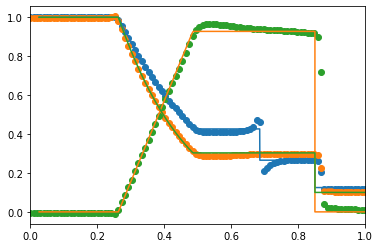

In [581]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
ax.plot(Exact[:,0],Exact[:,1])
ax.plot(Exact[:,0],Exact[:,2])
ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

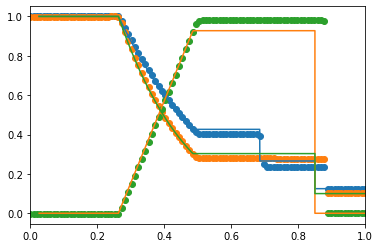

In [283]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x[:],u_pred[:,0])
ax.scatter(x[:],u_pred[:,1])
ax.scatter(x[:],u_pred[:,2])
ax.plot(Exact[:,0],Exact[:,1])
ax.plot(Exact[:,0],Exact[:,2])
ax.plot(Exact[:,0],Exact[:,3])
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(0.2, 1.2)
plt.show()

In [246]:
#Exact = np.loadtxt('sode.dat')
u_out = np.zeros((100,4))
u_out[:,0] = x
u_out[:,1] = u_pred[:,0]
u_out[:,2] = u_pred[:,2]
u_out[:,3] = u_pred[:,1]
file = open('3.dat','w')
np.savetxt(file, u_out, delimiter=' ')
file.close()

#Exact[:,0]

In [239]:
np.shape(u_pred)

(100, 3)

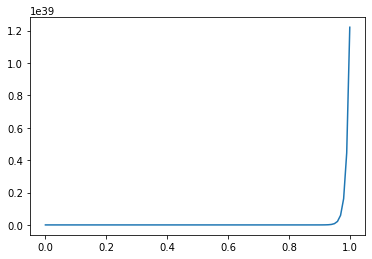

In [346]:
fig,ax = plt.subplots()
x = np.linspace(0,1,100)
#ax.plot(x,np.max([0.1-x,np.zeros_like(x)],axis=0))
#ax.plot(x,np.exp(100*(0.1-x))/ np.exp(100*(0.1)))
#ax.plot(x,np.exp(100*(-x)))
ax.plot(x,np.exp(100*(x-0.1)))
plt.show()

In [322]:
np.max([0.1-x,np.zeros_like(x)],axis=0)

array([0.1       , 0.08989899, 0.07979798, 0.06969697, 0.05959596,
       0.04949495, 0.03939394, 0.02929293, 0.01919192, 0.00909091,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [60]:
xp= x.flatten()[:,None]
rhop= u_pred[:,0].flatten()[:,None]
up= u_pred[:,1].flatten()[:,None]
pp= u_pred[:,2].flatten()[:,None]
uxy= np.hstack((xp,rhop,up,pp))    
np.savetxt('shockCrho.dat', uxy)

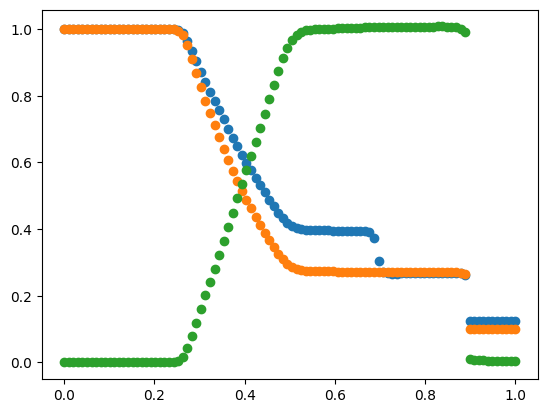

In [61]:
# first 15000step conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()

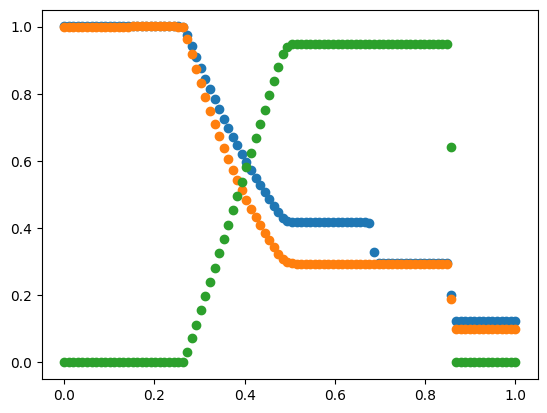

In [66]:
# first 15000step non-conservation
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x[:],u_pred[:,0])
plt.scatter(x[:],u_pred[:,1])
plt.scatter(x[:],u_pred[:,2])
plt.show()